In [91]:
from statistics import mean

import pandas as pd
from string import ascii_letters, digits

import cython #ENSURE cython package is installed on computer/canopy
from gensim.models import phrases 
from gensim import corpora, models, similarities #calc all similarities at once, from http://radimrehurek.com/gensim/tut3.html
from scipy import spatial
from gensim.models import Word2Vec, KeyedVectors
from sklearn.manifold import TSNE
from gensim.test.utils import datapath

import os
import csv
import json
from xml.etree import cElementTree as ET

from nltk.translate.meteor_score import wordnetsyn_match
from nltk.data import load
import re
# from flair.embeddings import FlairEmbeddings, StackedEmbeddings, FastTextEmbeddings, ELMoEmbeddings, BertEmbeddings
# from flair.data import Sentence

import numpy as np
import random
import matplotlib.pyplot as plt

In [3]:
translator = str.maketrans(ascii_letters, ascii_letters, digits)
tokenizer = load('tokenizers/punkt/english.pickle')


apas_error = '&apos;'
DATA_KEY = "data"
VERSION_KEY = "version"
DOC_KEY = "document"
QAS_KEY = "qas"
ANS_KEY = "answers"
TXT_KEY = "text"  # the text part of the answer
ORIG_KEY = "origin"
ID_KEY = "id"
TITLE_KEY = "title"
CONTEXT_KEY = "context"
SOURCE_KEY = "source"
QUERY_KEY = "query"
CUI_KEY = "cui"
SEMTYPE_KEY = "sem_type"

In [59]:
def stripword(word):
    word = word.replace("[", "")
    word = word.replace("]", "")
    word = word.replace("'", "")
    word = word.replace("'", "")
    word = word.replace(",", "")
    word = word.replace(".", "")
    word = word.replace("_", "")
    word = word.replace(":", "")
    word = word.replace("-", "")
    word = word.replace("*", "")
    word = word.replace("/", "")
    word = word.replace("(", "")
    word = word.replace(")", "")
    word = word.replace("´", "")
    word = word.replace("`", "")
    word = word.replace(";", "")
    word = word.replace("__END", "")
    word = word.replace("BEG__", "")
    return word

def stripword_flair(word):
    word = word.replace("[", "")
    word = word.replace("]", "")
    word = word.replace("'", "")
    word = word.replace("'", "")
    #word = word.replace(",", "")
    #word = word.replace(".", "")
    word = word.replace("_", "")
    #word = word.replace(":", "")
    #word = word.replace("-", "")
    word = word.replace("*", "")
    word = word.replace("/", "")
    word = word.replace("(", "")
    word = word.replace(")", "")
    word = word.replace("´", "")
    word = word.replace("`", "")
    word = word.replace(";", "")
    word = word.replace("__END", "")
    word = word.replace("BEG__", "")
    return word

In [60]:
def tokenize_folder():
    sentences = []
    for fname in os.listdir(os.path.join(os.getcwd(), 'cTakes archive')): #go through all file names in current directory
        if 'txt' in fname:
            with open(os.path.join(os.getcwd(), 'cTakes archive', fname)) as file:
                for l in file:
                    l = l.translate(translator)
                    l = re.sub(apas_error, "'", l)
                    l = l.strip()
                    l = l.lower()
                    l = stripword(l)
                    if len(l.split()) > 7:
                        l = l + ' .'
                        sentences.append(l.split())
    return sentences


def tokenize_json():
    sentences = []
    with open('train.json') as json_f:
        dataset = json.load(json_f)
        for data in dataset:
            for l in data['supports']:
                l = l.translate(translator)
                l = l.strip()
                l = tokenizer.tokenize(l)
                l = [stripword(n.lower()) for n in l]
                for sent in l:
                    if len(sent.split()) > 7:
                        sent = sent + ' .'
                        sentences.append(sent.split())
    return sentences


def tokenize_json2():
    sentences = []
    with open('train1.0.json') as json_f:
        dataset = json.load(json_f)
        data = dataset[DATA_KEY]
        for datum in data:
            l = datum[DOC_KEY][CONTEXT_KEY]
            l = l.translate(translator)
            l = l.strip()
            l = tokenizer.tokenize(l)
            l = [stripword(n.lower()) for n in l]
            for sent in l:
                if len(sent.split()) > 7:
                    sent = sent + ' .'
                    sentences.append(sent.split())
    return sentences


def tokenize_file():
    sentences = []
    with open(os.path.join(os.getcwd(), 'cTakes archive', fname)) as file:
        for i in range(0,7):
            next(file, None)
        for l in file:
            l = l.translate(translator)
            l = l.strip()
            l = l.lower()
            l = stripword(l)
            sentences.append(l.split())
    return sentences




def tokenize_xml():
    sentences = []
    for fname in os.listdir(os.path.join(os.getcwd(), 'cTakes archive/2try')): #go through all file names in current directory
        if 'xml' in fname:
            tree = ET.fromstring(open(os.path.join(os.getcwd(), 'cTakes archive/2try', fname)).read())
            for node in tree.iter('TEXT'):
                for elem in node.iter():
                    l = elem.text.translate(translator)
                    l = l.strip()
                    l = l.lower()
                    l = tokenizer.tokenize(l)
                    l = [stripword(n) for n in l]
                    for i, sent in enumerate(l):
                        if i < 1:
                            continue
                        elif len(sent.split()) > 7:
                            sent = sent + ' .'
                            sentences.append(sent.split())
    return sentences

In [63]:
df =  pd.read_csv("all_sents.csv", encoding="utf-8", names=["Number", "Sentence"])
#sentences = np.array(df["Sentence"].split(' '))


print(sentences[0:10])
print(len(sentences))

[['valdez', 'harlan', 'jr', 'february', 'har', 'is', 'a', 'year', 'old', 'pound', 'gentleman', 'who', 'is', 'referred', 'for', 'consultation', 'by', 'dr', 'harlan', 'oneil', '.'], ['about', 'a', 'week', 'ago', 'he', 'slipped', 'on', 'the', 'driveway', 'at', 'home', 'and', 'sustained', 'an', 'injury', 'to', 'his', 'left', 'ankle', '.'], ['he', 'was', 'seen', 'at', 'tricity', 'hospital', 'and', 'was', 'told', 'he', 'had', 'a', 'fracture', '.'], ['he', 'was', 'placed', 'in', 'an', 'air', 'splint', 'and', 'advised', 'to', 'be', 'partial', 'weight', 'bearing', 'and', 'he', 'is', 'using', 'a', 'cane', '.'], ['past', 'medical', 'history', 'is', 'notable', 'for', 'no', 'ankle', 'injuries', 'previously', '.'], ['he', 'has', 'a', 'history', 'of', 'diabetes', 'and', 'sleep', 'apnea', '.'], ['he', 'is', 'also', 'followed', 'by', 'dr', 'harold', 'nutter', 'for', 'an', 'arrhythmia', '.'], ['he', 'is', 'a', 'set', 'designer', 'at', 'columbia', 'pictures', '.'], ['on', 'examination', 'today', 'he', 'h

In [74]:
test_sent = random.sample(sentences, 30000)

In [127]:
bigram_transformer = phrases.Phrases(test_sent) 
bigram = phrases.Phraser(bigram_transformer)
trigram = phrases.Phrases(bigram_transformer[test_sent])

###figure out how to find number of trigram

TypeError: object of type 'Phrases' has no len()

In [ ]:
currentmodel = Word2Vec(trigram[bigram[test_sent]], workers=4, sg=0, size=100, min_count=6, window=3, sample=1e-3)

## Hyperparameter optimization

In [82]:
size_list = range(50,151,20)
window_list = range(3,8)

In [83]:
#currentmodel.build_vocab(trigram[bigram[sentences]], update=True)
#currentmodel.train(trigram[bigram[sentences]], total_examples=59040, epochs=currentmodel.iter)
models_size = list()
for size in size_list:
    currentmodel = Word2Vec(trigram[bigram[test_sent]], workers=4, sg=0, size=size, min_count=6, window=3, sample=1e-3)
    currentmodel.init_sims(replace=True)
    models_size.append(currentmodel)
        

###simplex optimization
###hyperparameter optimization -> find and plot distance between 2 words with increasing number of dimension -> see if number increases/decreases

In [123]:
models_window = list()
for window in window_list:
    currentmodel = Word2Vec(trigram[bigram[test_sent]], workers=4, sg=0, size=50, min_count=6, window=window, sample=1e-3)
    currentmodel.init_sims(replace=True)
    models_window.append(currentmodel)

In [ ]:
#currentmodel.save("C:/Users/schaa/PycharmProjects/UCSF_NLP/cosine_model/cosine_similarity_metric3")

In [ ]:
# currentmodel = Word2Vec.load("C:/Users/schaa/PycharmProjects/UCSF_NLP/cosine_model/cosine_similarity_metric2")
currentmodel = Word2Vec.load('cosine_similarity_metric')

In [ ]:
currentmodel.wv['wife']

In [ ]:
currentmodel.wv.most_similar('hrr', topn=10)

In [113]:
def cosine_similarity(word1, word2, model):
    return 1 - spatial.distance.cosine(model.wv[word1], model.wv[word2])

In [121]:
def extract_txt(filename):
    all_txt = []
    translator = str.maketrans(ascii_letters, ascii_letters, digits)
    with open(filename) as csvfile:
        csvdata = csv.reader(csvfile)
        next(csvdata, None)
        for row in csvdata:
            row13 = row[13]
            if row13.lower() in abbreviations_dic:
                    row13 = abbreviations_dic[row13.lower()]
            row3 = row[3]
            if row3 in abbreviations_dic:
                row3 = abbreviations_dic[row3]
            row13 = row13.translate(translator)
            row13 = row13.strip()
            row13 = row13.lower()
            row13 = stripword(row13)
            row3 = row3.translate(translator)
            row3 = row3.strip()
            row3 = row3.lower()
            row3 = stripword(row3)
            all_txt.append([row13.split(), row3.split()])
    return all_txt


all_txt = extract_txt('combined_diseases.csv') #combined_labs.csv

def average_cosine_similarity(concept, in_txt, currentmodel):
    concept_words = [stripword(i) for i in concept]
    range_words = [stripword(i) for i in in_txt]
    conc_vecs = list()
    for word in concept_words:
        try:
            conc_vecs.append(currentmodel.wv[word])
        except:
            pass
    average_conc_vec = np.mean(conc_vecs, axis = 0)
    range_vecs = list()
    for word in range_words:
        try:
            range_vecs.append(currentmodel.wv[word])
        except:
            pass
    average_range_vec = np.mean(range_vecs, axis = 0)
    return 1 - spatial.distance.cosine(average_conc_vec, average_range_vec)
    


def combined_cosine_similarity(concept, in_txt, model):
    if concept == in_txt:
        return 1.0
    concept_words = [stripword(i) for i in concept]
    range_words = [stripword(i) for i in in_txt]
    
    cosine_average = 0
    count = 0
    
    for m in range(0, len(concept_words)):
        try:
            word1 = '_'.join(concept_words[m:m + 3])
            word2 = '_'.join(range_words[m:m + 3])

            cosine_average += cosine_similarity(word1, word2, model)
            count += 1
        except:
            pass
    for m in range(0, len(concept_words)):
        try:
            word1 = '_'.join(concept_words[m:m + 2])
            word2 = '_'.join(range_words[m:m + 2])
            cosine_average += cosine_similarity(word1, word2, model)
            count += 1
        except:
            pass
    for word3 in concept_words:
        for word4 in range_words:
            try:
                cosine_average += cosine_similarity(word3, word4, model)
                count += 1
            except:
                pass
    if count == 0:
        return 0.0
    else:
        return cosine_average / count
    
    
def combined_cosine_similarity_flair(concept, in_txt):
    concept_words = Sentence('the disease and illness ' + '_'.join(concept))
    stacked_embeddings.embed(concept_words)
    range_words = Sentence('_'.join(in_txt))
    stacked_embeddings.embed(range_words)
    cosine_sim = 0
    count = 0
    
    for wrd in concept_words:
        for wrd2 in range_words:
            cosine_sim += (1-spatial.distance.cosine(wrd.embedding, wrd2.embedding))
            count += 1
        
    return cosine_sim / count

def combined_cosine_similarity_bert(concept, in_txt):
#     if concept == in_txt:
#         return 1.0
    concept_words = Sentence('the disease and illness ' + '_'.join(concept))
    elmo_embedding.embed(concept_words)
    range_words = Sentence('_'.join(in_txt))
    elmo_embedding.embed(range_words)
    cosine_sim = 0
    count = 0
    
    for wrd in concept_words[4:]:
        for wrd2 in range_words:
            cosine_sim += (1 - spatial.distance.cosine(wrd.embedding, wrd2.embedding))
            count += 1
        
    return cosine_sim / count

['end', 'stage', 'liver', 'disease'] ['terminal', 'illness']


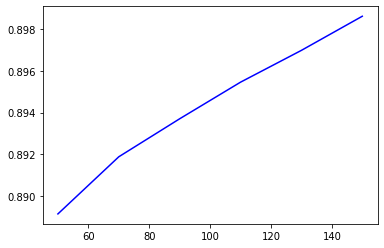

['hepatitis', 'c'] ['hepatitis', 'c']


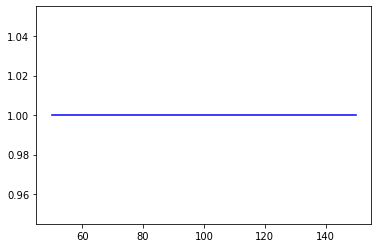

['cirrhosis'] ['liver', 'cirrhosis']


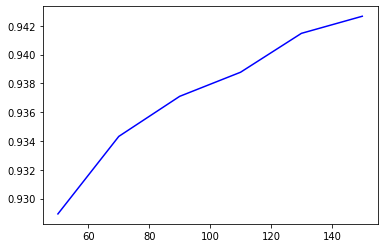

['encephalopathy'] ['encephalopathies']


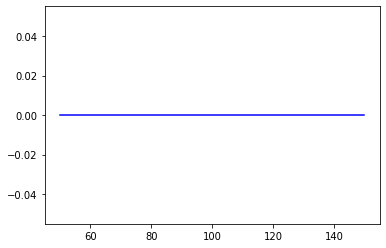

['hepatorenal', 'syndrome'] ['hepatorenal', 'syndrome']


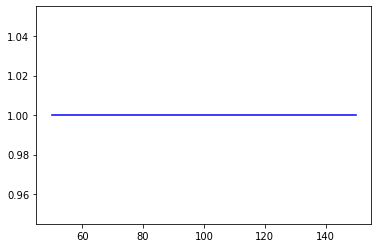

['hepatitis', 'c'] ['hepatitis', 'c']


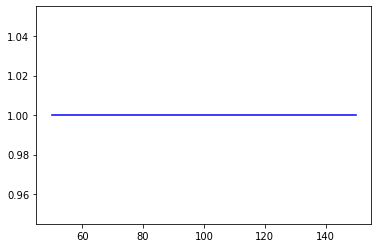

['cirrhosis'] ['liver', 'cirrhosis']


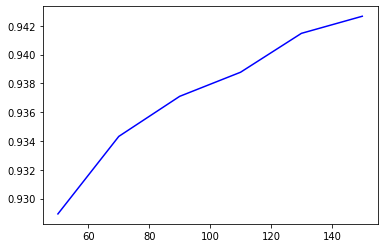

['hypertension'] ['hypertensive', 'disease']


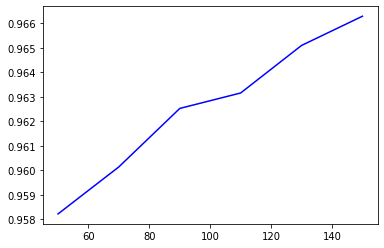

['nephrolithiasis'] ['kidney', 'calculi']


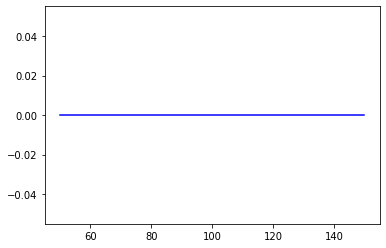

['hemorrhoids'] ['hemorrhoids']


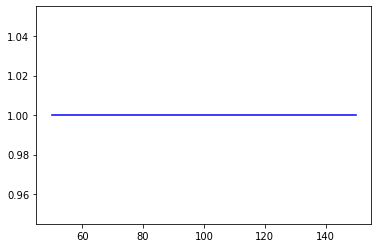

['staph'] ['staphylococcal', 'infections']


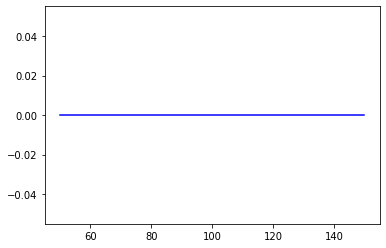

['bacteremia'] ['bacteremia']


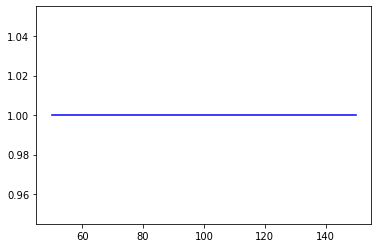

['spontaneous', 'bacterial', 'peritonitis'] ['primary', 'bacterial', 'peritonitis']


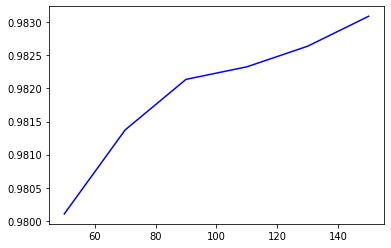

['surgical', 'incision'] ['surgical', 'wound']


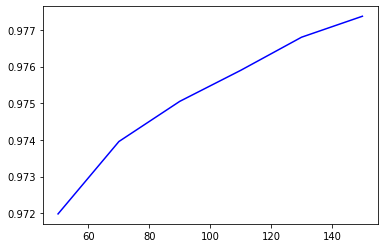

['infection'] ['communicable', 'diseases']


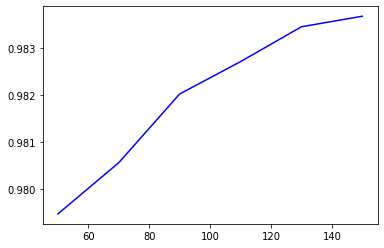

['bleeding', 'or', 'clotting', 'disorders'] ['blood', 'coagulation', 'disorders']


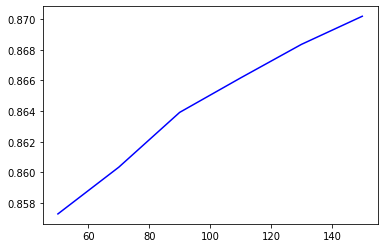

['knee', 'injury'] ['knee', 'injuries']


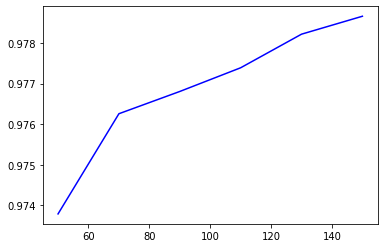

['seasonal', 'allergies'] ['hay', 'fever']


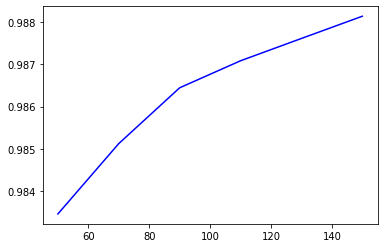

['hypertension'] ['hypertensive', 'disease']


KeyboardInterrupt: 

<Figure size 432x288 with 0 Axes>

In [122]:
for concepts in all_txt:
    print(concepts[0], concepts[1])
    similarity_scores = list()
    for model in models_size:
        similarity_scores.append(combined_cosine_similarity(concepts[0], concepts[1], model))
    if similarity_scores[0] is not None:
        plt.plot(size_list, similarity_scores,'b-')
        plt.show()
        
##lower than 50 dimensions
##run this with ML model

['end', 'stage', 'liver', 'disease'] ['terminal', 'illness']


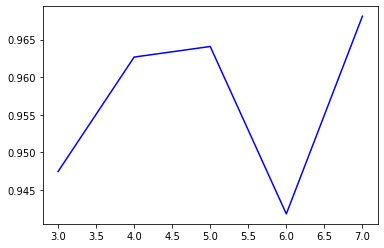

['hepatitis', 'c'] ['hepatitis', 'c']


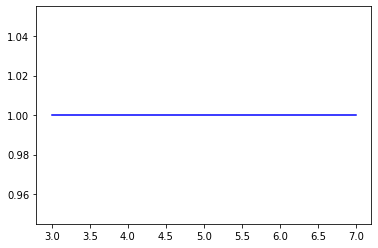

['cirrhosis'] ['liver', 'cirrhosis']


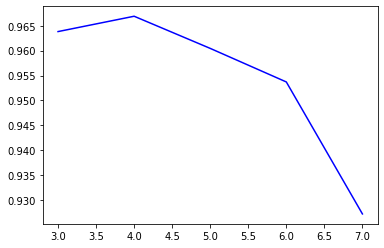

['encephalopathy'] ['encephalopathies']


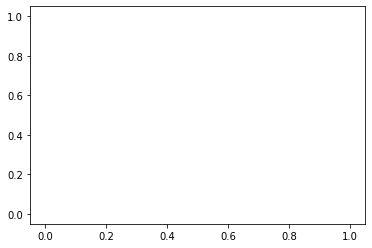

['hepatorenal', 'syndrome'] ['hepatorenal', 'syndrome']


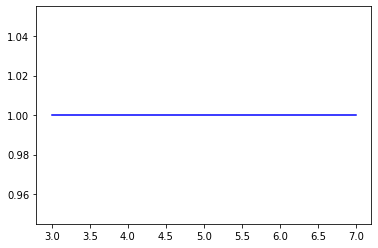

['hepatitis', 'c'] ['hepatitis', 'c']


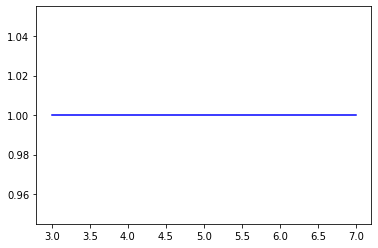

['cirrhosis'] ['liver', 'cirrhosis']


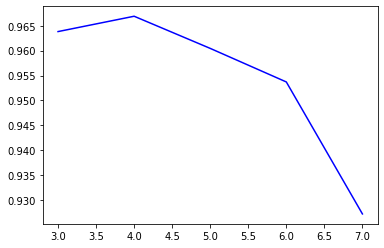

['hypertension'] ['hypertensive', 'disease']


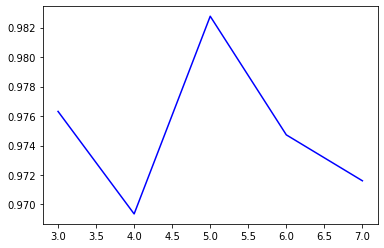

['nephrolithiasis'] ['kidney', 'calculi']


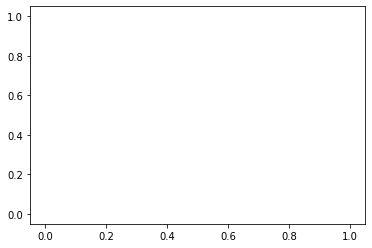

['hemorrhoids'] ['hemorrhoids']


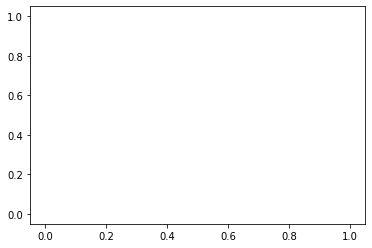

['staph'] ['staphylococcal', 'infections']


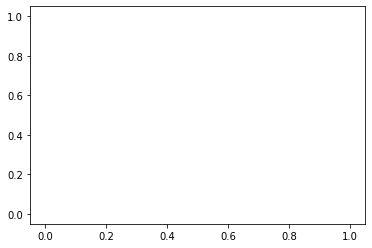

['bacteremia'] ['bacteremia']


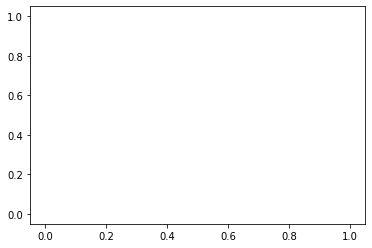

['spontaneous', 'bacterial', 'peritonitis'] ['primary', 'bacterial', 'peritonitis']


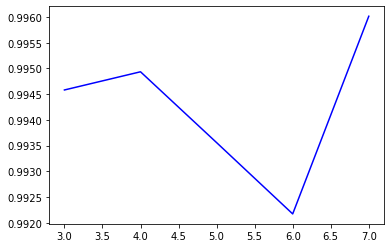

['surgical', 'incision'] ['surgical', 'wound']


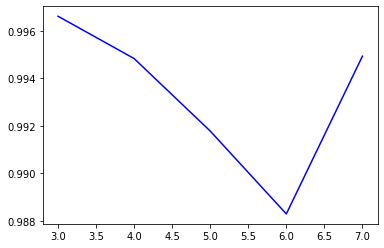

['infection'] ['communicable', 'diseases']


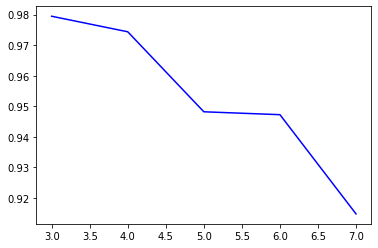

['bleeding', 'or', 'clotting', 'disorders'] ['blood', 'coagulation', 'disorders']


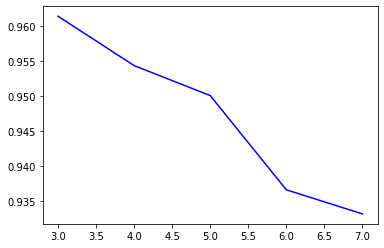

['knee', 'injury'] ['knee', 'injuries']


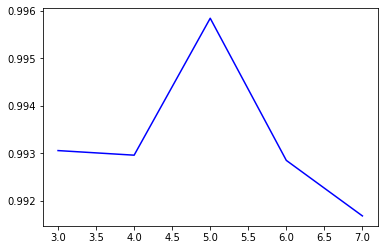

['seasonal', 'allergies'] ['hay', 'fever']


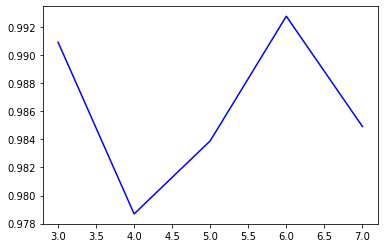

['hypertension'] ['hypertensive', 'disease']


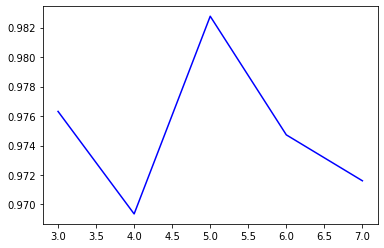

['chronic', 'obstructive', 'pulmonary', 'disease'] ['chronic', 'obstructive', 'airway', 'disease']


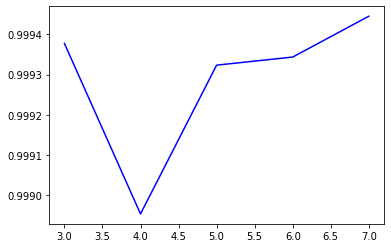

['mmm'] ['myelofibrosis']


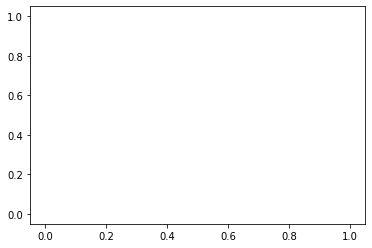

['nml'] ['lymphoma', 'mixedcell', 'follicular']


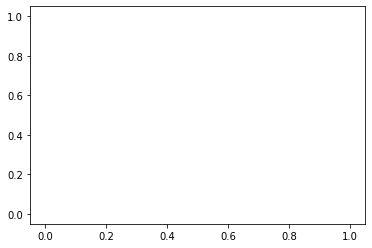

['extremities'] ['hereditary', 'multiple', 'exostoses']


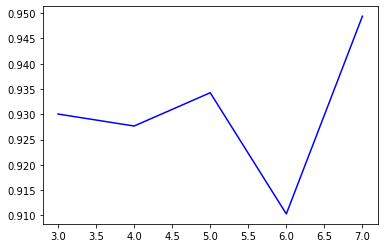

['cord'] ['retinitis', 'pigmentosa']


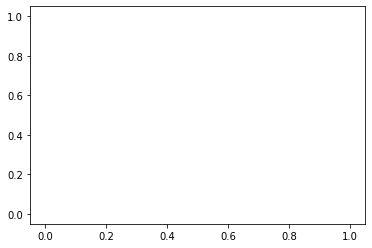

['intracranial', 'hemorrhage'] ['intracranial', 'hemorrhages']


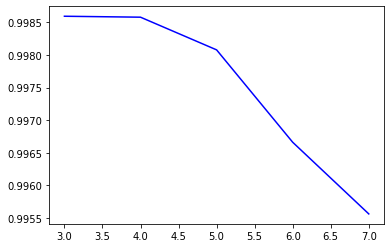

['fractures'] ['fracture']


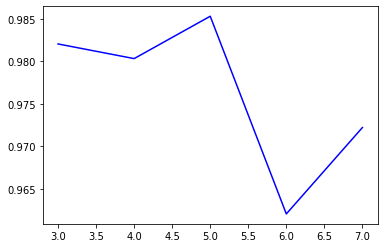

['ventricular', 'septal', 'defect'] ['ventricular', 'septal', 'defects']


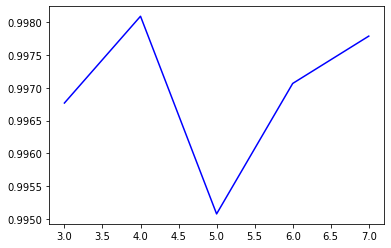

['aortic', 'regurgitation'] ['aortic', 'valve', 'insufficiency']


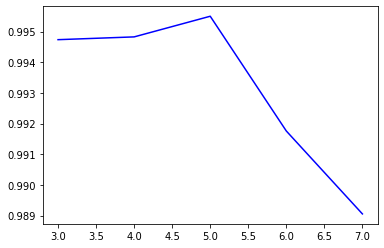

['mitral', 'valve', 'prolapse'] ['mitral', 'valve', 'prolapse', 'syndrome']


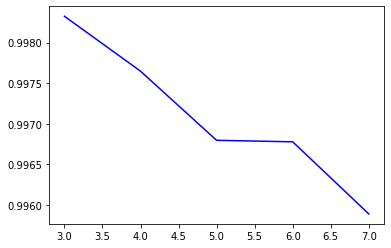

['systolic', 'hypertension'] ['systolic', 'hypertension']


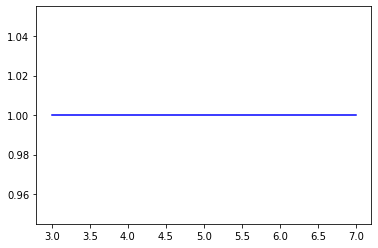

['pericardial', 'effusion'] ['pericardial', 'effusion']


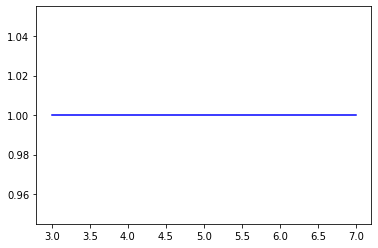

['hypertension'] ['hypertensive', 'disease']


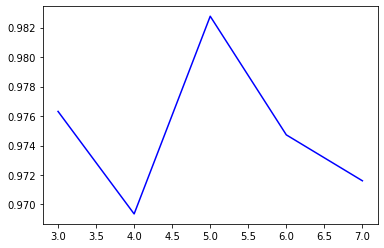

['deep', 'venous', 'thrombosis'] ['deep', 'vein', 'thrombosis']


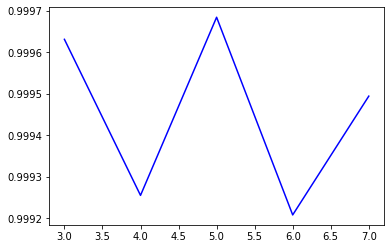

['sinus', 'tach'] ['sinus', 'tachycardia']


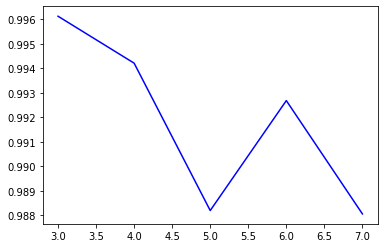

['depression'] ['depressive', 'disorder']


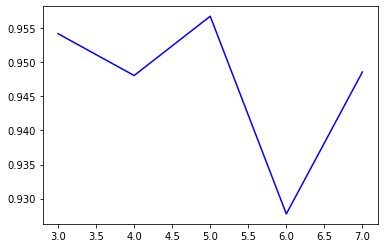

['bucket', 'handle', 'medial', 'meniscal', 'tear'] ['bucket', 'handle', 'tears']


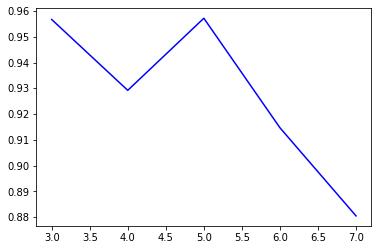

['tear'] ['laceration']


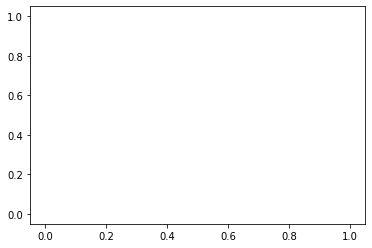

['posterior'] ['posterior', 'pituitary', 'disease']


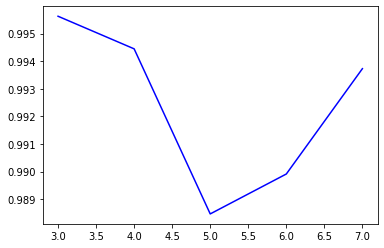

['joint', 'effusion'] ['hydrarthrosis']


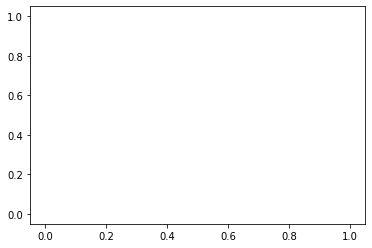

['cyst'] ['cyst']


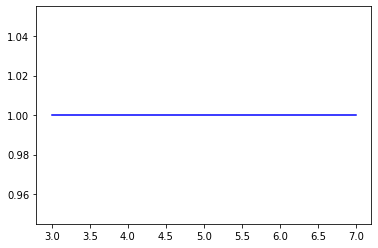

['posterior', 'cruciate', 'ligament'] ['milroy', 'disease']


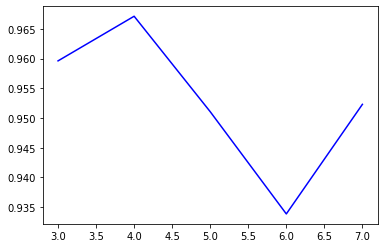

['discoid', 'lateral', 'meniscus'] ['discoid', 'lateral', 'meniscus']


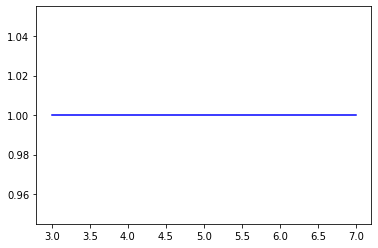

['saddle', 'pulmonary', 'embolus'] ['leriche', 'syndrome']


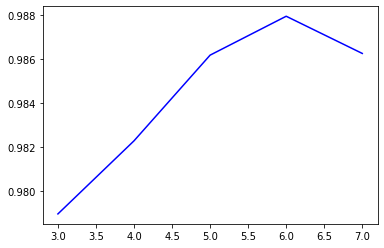

['knee', 'injury'] ['knee', 'injuries']


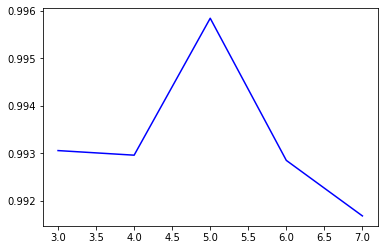

['deep', 'venous', 'thrombosis'] ['deep', 'vein', 'thrombosis']


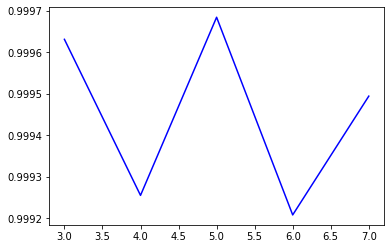

['trauma'] ['trauma']


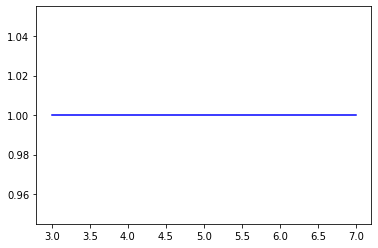

['hemodynamic', 'instability'] ['hemodynamic', 'instability']


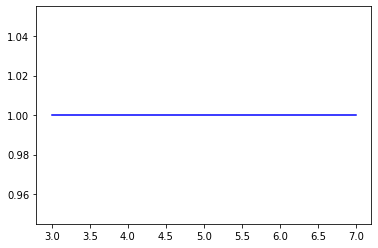

['thrombophilia'] ['thrombophilia']


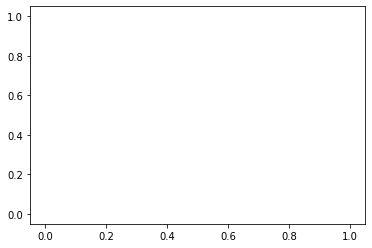

['strain'] ['muscle', 'strain']


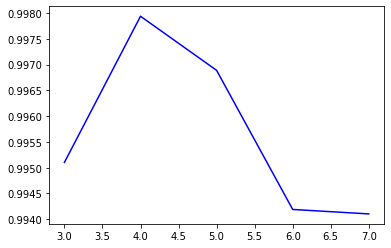

['abnormalities'] ['congenital', 'abnormality']


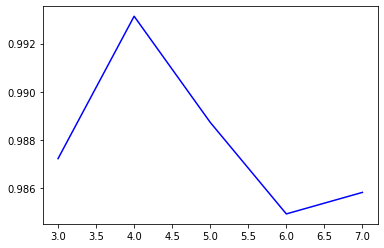

['knee', 'injury'] ['knee', 'injuries']


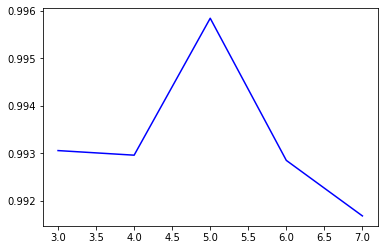

['injury'] ['traumatic', 'injury']


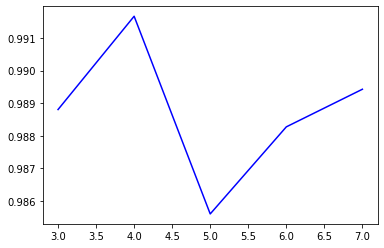

['tear'] ['laceration']


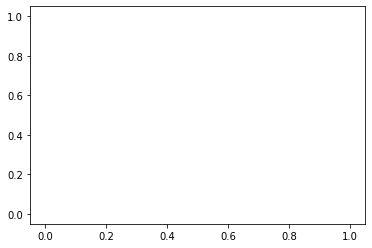

['pulmonary', 'embolus'] ['pulmonary', 'embolism']


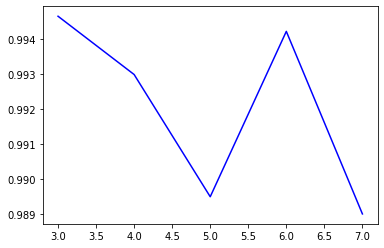

['tear'] ['laceration']


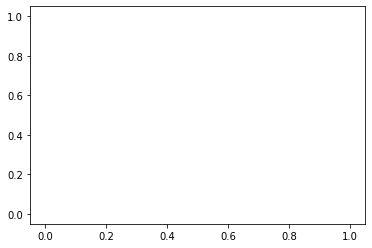

['pulmonary', 'embolism'] ['pulmonary', 'embolism']


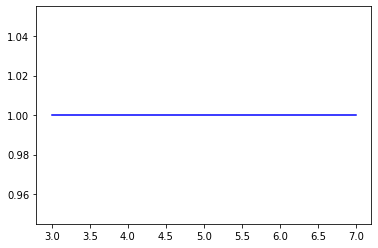

['tear'] ['laceration']


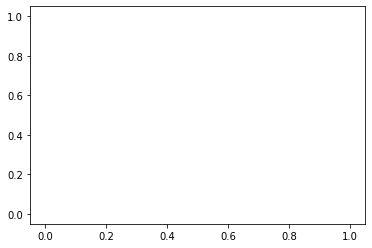

['pneumonia'] ['pneumonia']


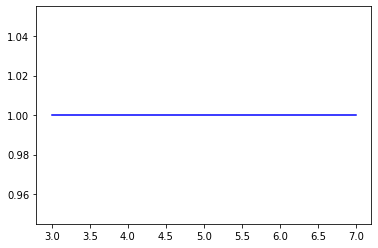

['plan'] ['infantile', 'neuroaxonal', 'dystrophy']


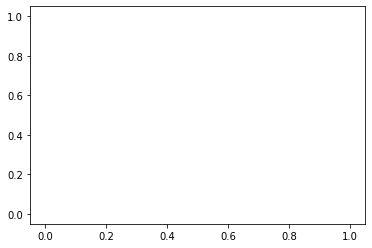

['pneumonia'] ['pneumonia']


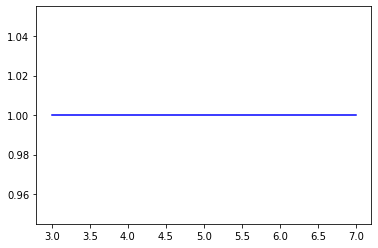

['chronic', 'obstructive', 'pulmonary', 'disease'] ['chronic', 'obstructive', 'airway', 'disease']


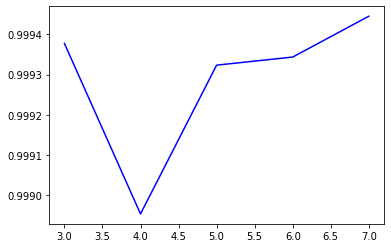

['asthma'] ['asthma']


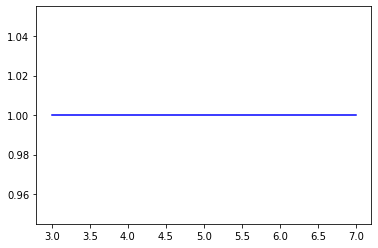

['upper', 'respiratory', 'like', 'infection'] ['upper', 'respiratory', 'infections']


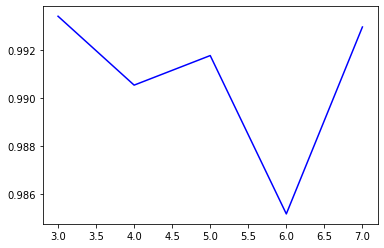

['asthma'] ['asthma']


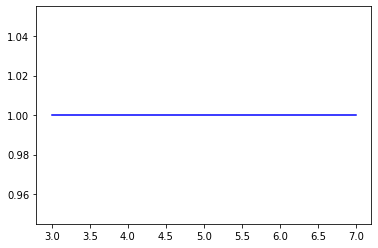

['chronic', 'obstructive', 'pulmonary', 'disease'] ['chronic', 'obstructive', 'airway', 'disease']


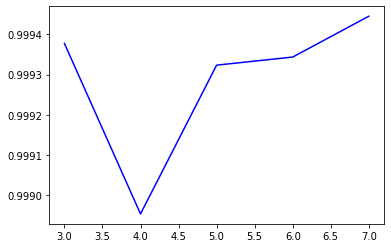

['restrictive', 'lung', 'disease'] ['restrictive', 'lung', 'disease']


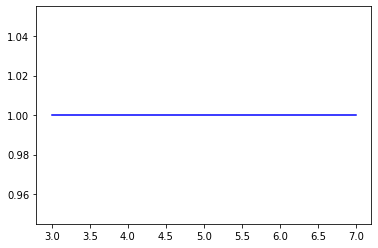

['chronic', 'inflammatory', 'demyelinating', 'polyradiculopathy'] ['polyradiculoneuropathy', 'chronic', 'inflammatory', 'demyelinating']


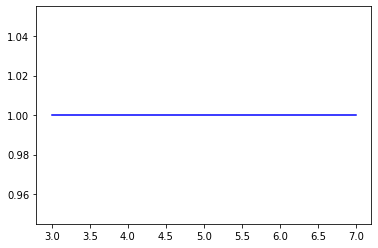

['gastritis', 'and', 'duodenitis'] ['gastroduodenitis']


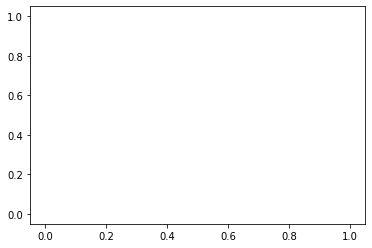

['neurogenic', 'bladder'] ['neurogenic', 'urinary', 'bladder']


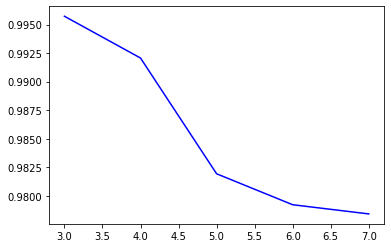

['coronary', 'artery', 'disease'] ['coronary', 'artery', 'disease']


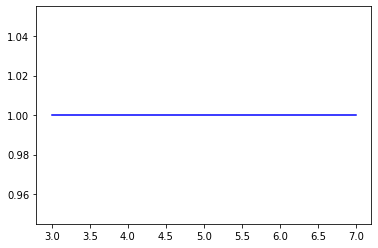

['adrenal', 'insufficiency'] ['adrenal', 'gland', 'hypofunction']


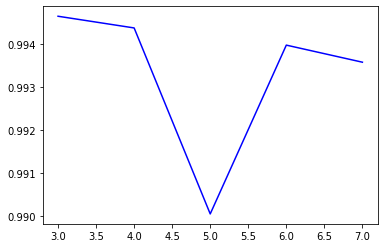

['hypercholesterolemia'] ['hypercholesterolemia']


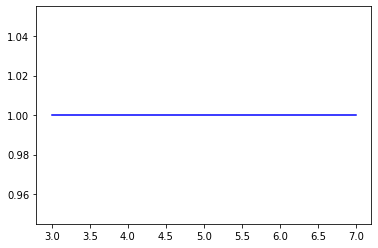

['depression', 'and', 'anxiety'] ['mixed', 'anxiety', 'and', 'depressive', 'disorder']


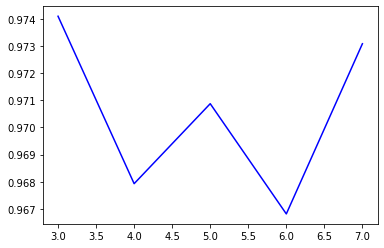

['hyperthyroidism'] ['hyperthyroidism']


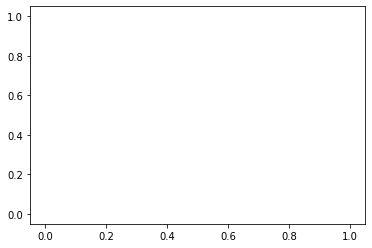

['igg', 'deficiency'] ['igg', 'deficiency']


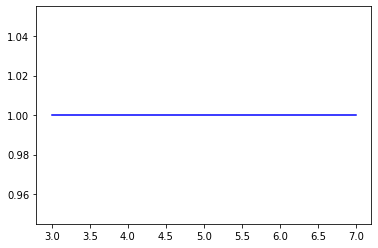

['anemia', 'of', 'chronic', 'disease'] ['anemia', 'of', 'chronic', 'disease']


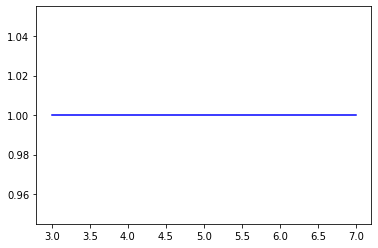

['chronic', 'obstructive', 'pulmonary', 'disease'] ['chronic', 'obstructive', 'airway', 'disease']


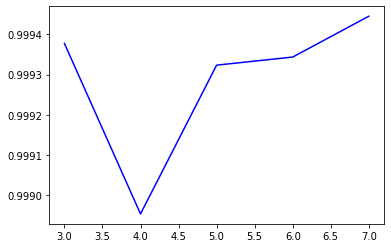

['consolidation'] ['lung', 'consolidation']


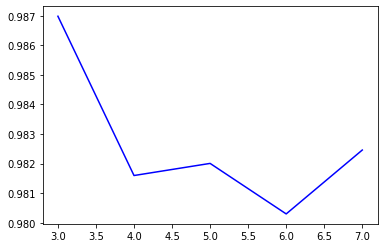

['pneumonia'] ['pneumonia']


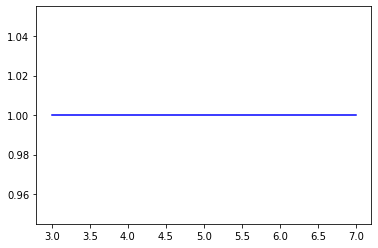

['adrenal', 'insufficiency'] ['adrenal', 'gland', 'hypofunction']


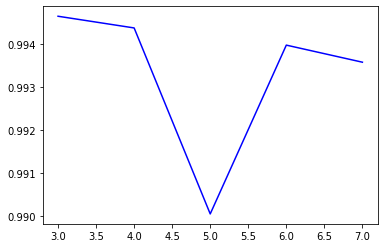

['reflux'] ['gastroesophageal', 'reflux', 'disease']


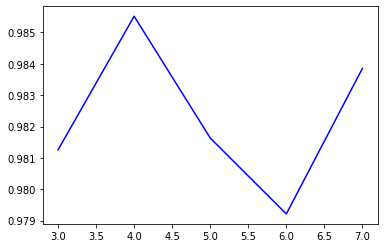

['gastritis'] ['gastritis']


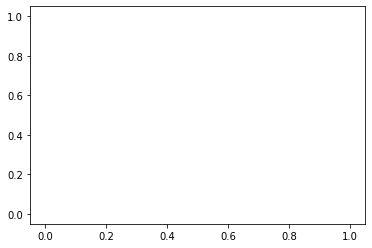

['neurogenic', 'bladder'] ['neurogenic', 'urinary', 'bladder']


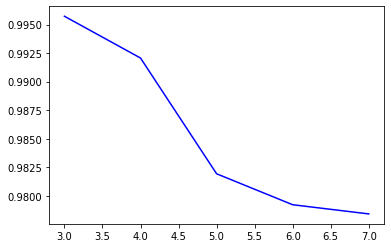

['hyperthyroidism'] ['hyperthyroidism']


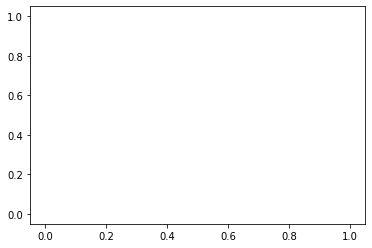

['persistent'] ['persistent', 'embryonic', 'structure']


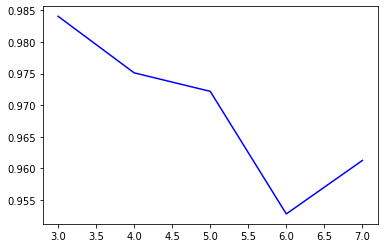

['respiratory', 'acidosis'] ['acidosis', 'respiratory']


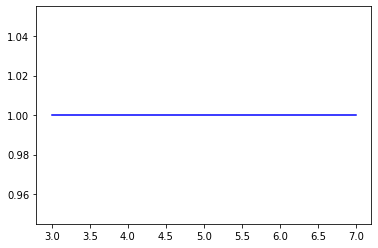

['adrenal', 'insufficiency'] ['adrenal', 'gland', 'hypofunction']


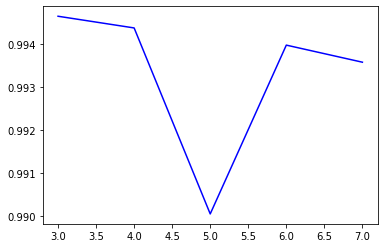

['megaloblastic'] ['anemia', 'megaloblastic']


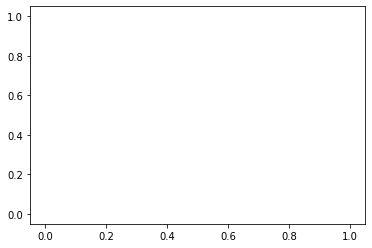

['anemia', 'question', 'b', 'deficiency'] ['vitamin', 'b', 'deficiency', 'anemia']


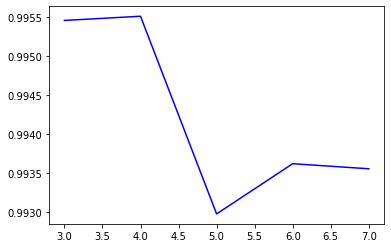

['asthma', 'flare', 'and', 'bronchitis'] ['asthmatic', 'bronchitis']


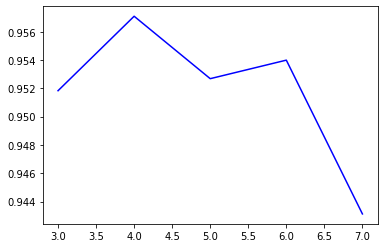

['chronic', 'obstructive', 'pulmonary', 'disease'] ['chronic', 'disease']


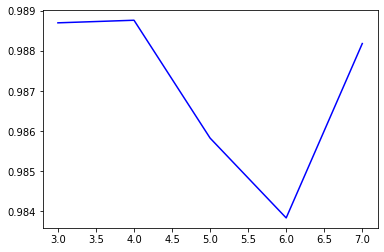

['polyradiculopathy'] ['polyradiculopathy']


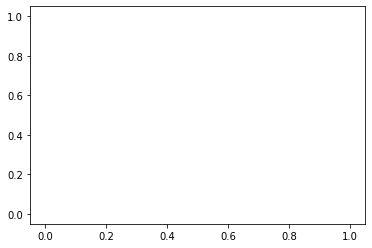

['anxiety'] ['anxiety']


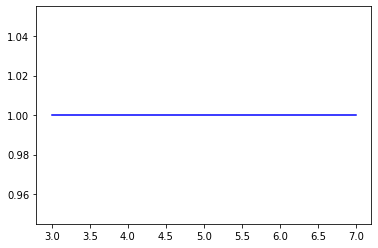

['allergies', 'to', 'drugs'] ['drug', 'allergy']


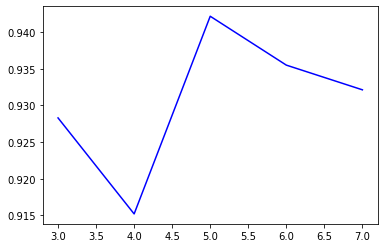

['renal', 'cell', 'cancer'] ['renal', 'cell', 'carcinoma']


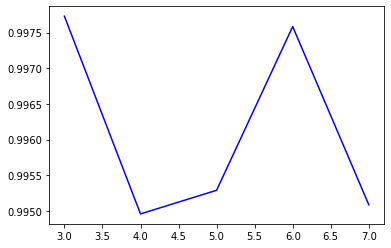

['renal', 'insufficiency'] ['renal', 'insufficiency']


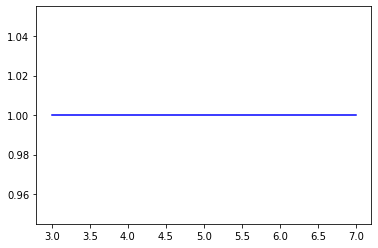

['cancer'] ['malignant', 'neoplasms']


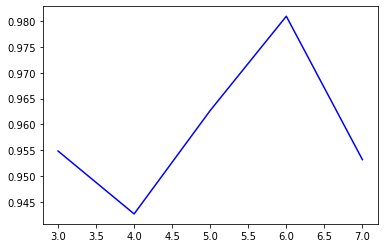

['choking', 'with', 'food'] ['asphyxia', 'by', 'inhalation', 'of', 'food']


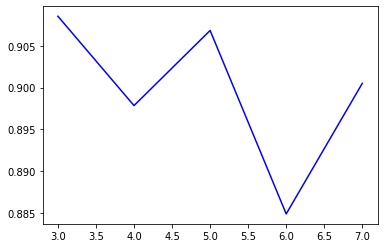

['reflux'] ['gastroesophageal', 'reflux', 'disease']


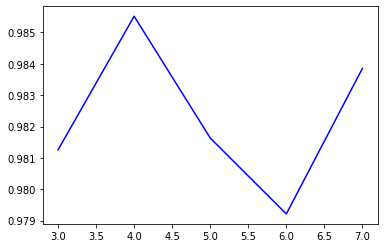

['metastatic', 'renal', 'cell', 'carcinoma'] ['metastatic', 'renal', 'cell', 'cancer']


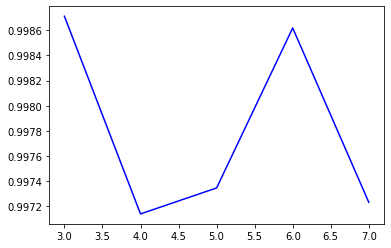

['renal', 'cell', 'carcinoma'] ['renal', 'cell', 'carcinoma']


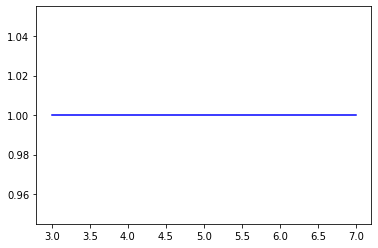

['renal', 'insufficiency'] ['renal', 'insufficiency']


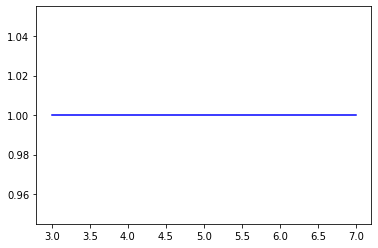

['seasonal', 'allergies'] ['hay', 'fever']


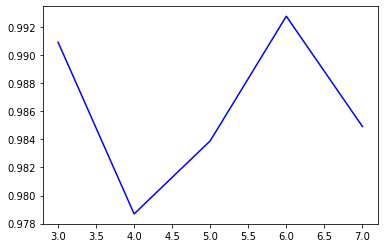

['extremities'] ['hereditary', 'multiple', 'exostoses']


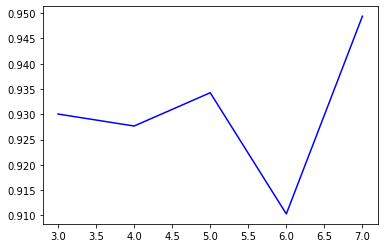

['eosinophils'] ['familial', 'eosinophilia']


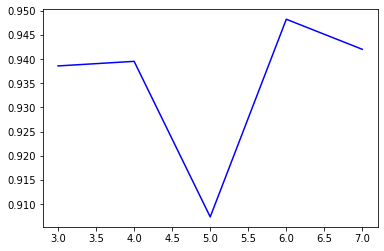

['deep', 'venous', 'thrombosis'] ['deep', 'vein', 'thrombosis']


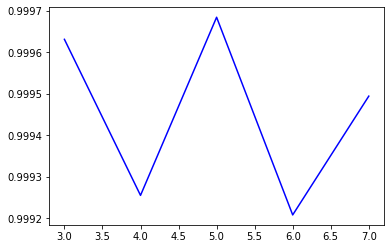

['bilateral', 'small', 'pleural', 'effusion'] ['bilateral', 'pleural', 'effusion']


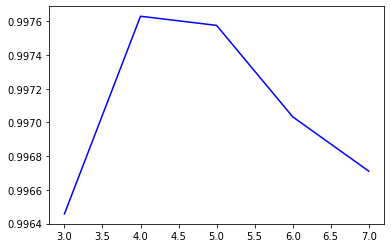

['pneumothorax'] ['pneumothorax']


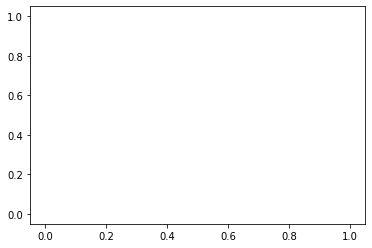

['pleural', 'effusions'] ['pleural', 'effusion', 'disorder']


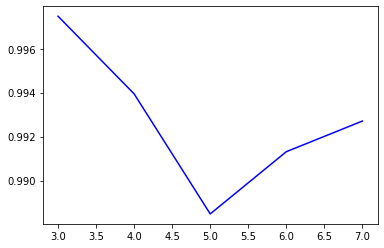

['cardiac', 'insufficiency'] ['heart', 'failure']


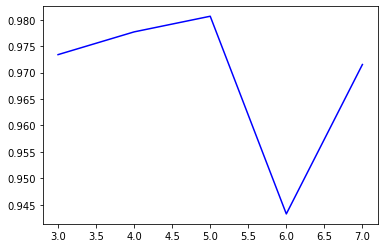

['volume', 'overload'] ['fluid', 'overload']


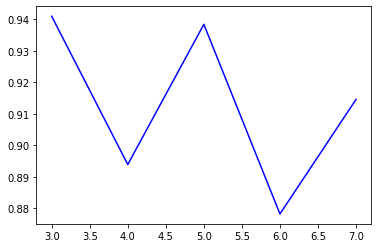

['infectious'] ['communicable', 'diseases']


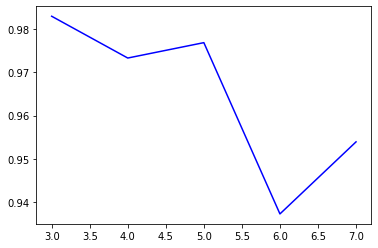

['consolidation'] ['lung', 'consolidation']


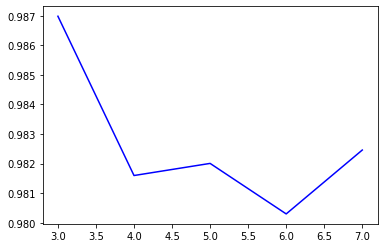

['infectious'] ['communicable', 'diseases']


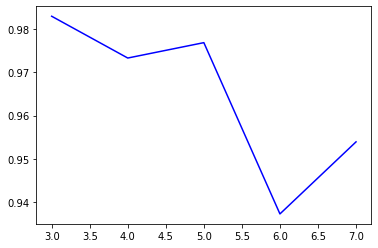

['mycobacterial', 'infections'] ['mycobacterium', 'infections']


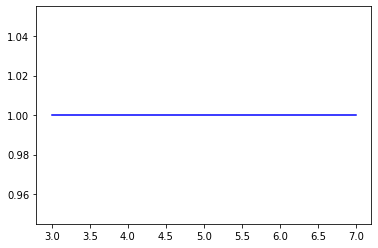

['drug', 'toxicity'] ['drug', 'toxicity']


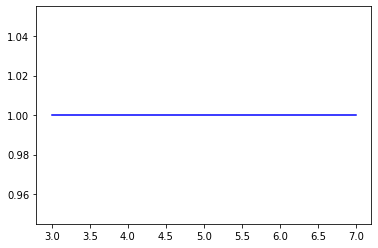

['persistent'] ['persistent', 'embryonic', 'structure']


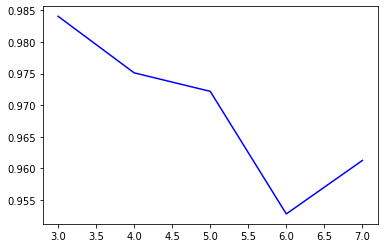

['infectious'] ['communicable', 'diseases']


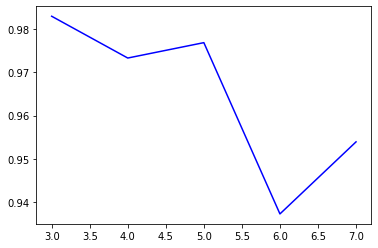

['left', 'ventricular', 'hypertrophy'] ['left', 'ventricular', 'hypertrophy']


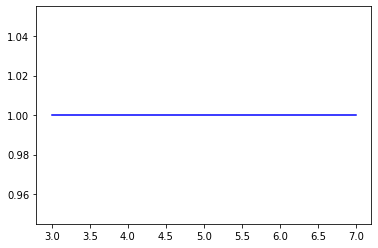

['posterior'] ['posterior', 'pituitary', 'disease']


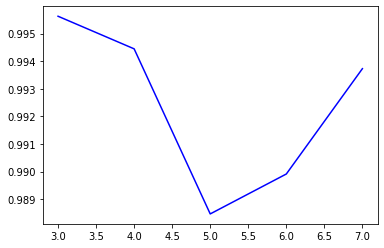

['mitral', 'valve', 'prolapse'] ['mitral', 'valve', 'prolapse', 'syndrome']


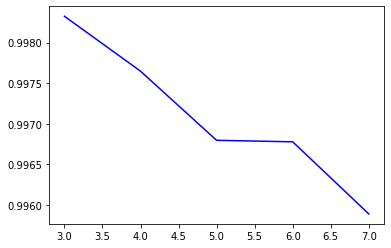

['pericardial', 'effusion'] ['pericardial', 'effusion']


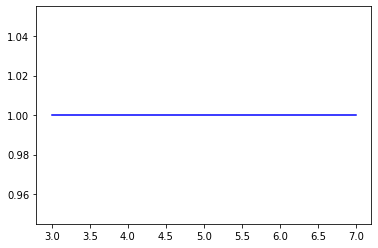

['displaced', 'fracture'] ['fracture', 'with', 'displacement']


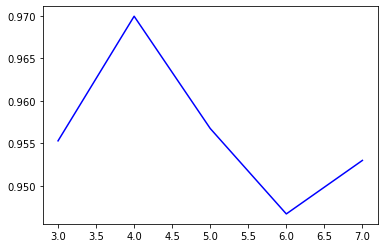

['renal', 'cell', 'cancer'] ['renal', 'cell', 'carcinoma']


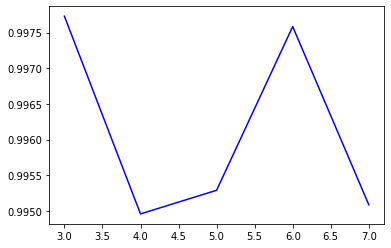

['pneumonia'] ['pneumonia']


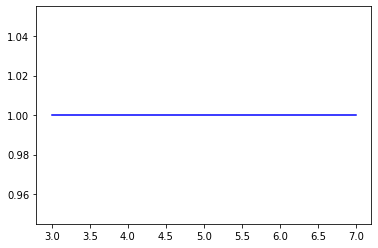

['pneumonia'] ['pneumonia']


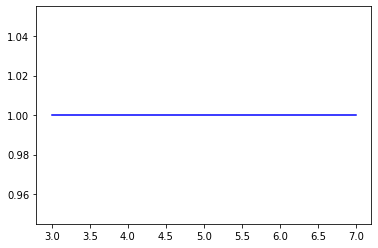

['communityacquired', 'pneumonia'] ['community', 'acquired', 'pneumonia']


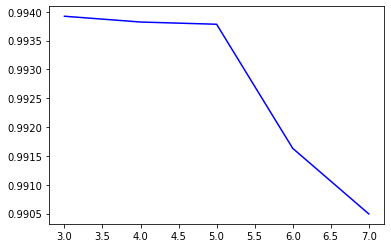

['oncology'] ['neoplasms']


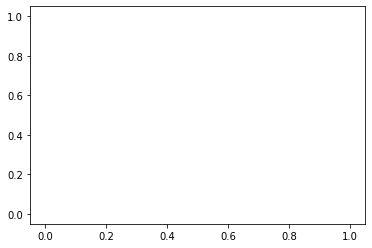

['infectious'] ['communicable', 'diseases']


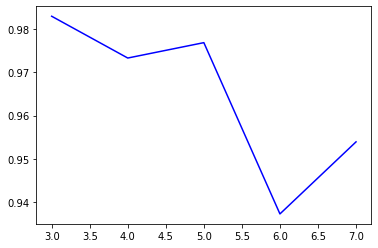

['renal', 'cell', 'cancer'] ['renal', 'cell', 'carcinoma']


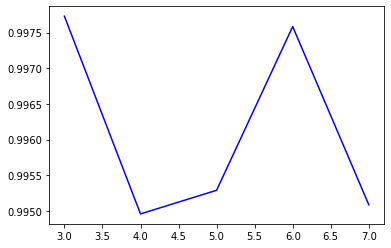

['acute', 'infection'] ['acute', 'infectious', 'disease']


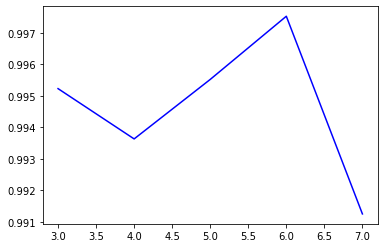

['tumor'] ['neoplasms']


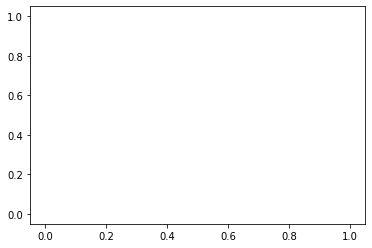

['fracture'] ['fracture']


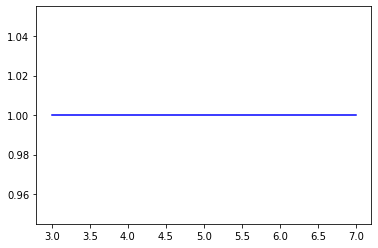

['renal', 'insufficiency'] ['renal', 'insufficiency']


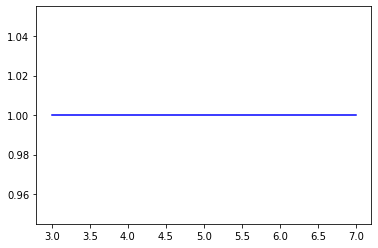

['malignancy'] ['malignant', 'neoplasms']


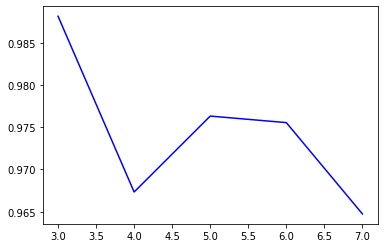

['pneumonia'] ['pneumonia']


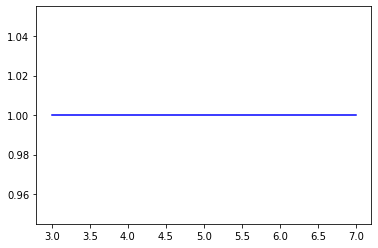

['acute', 'renal', 'failure'] ['kidney', 'failure', 'acute']


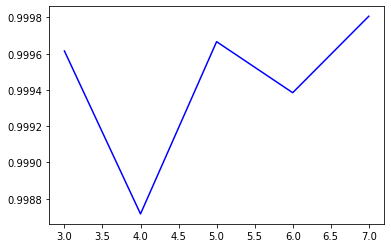

['metastatic', 'renal', 'cell', 'carcinoma'] ['metastatic', 'carcinoma']


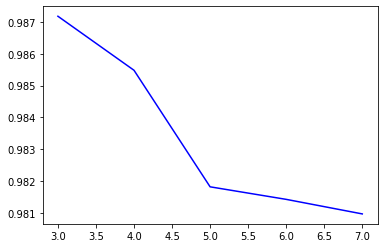

['pneumonia'] ['pneumonia']


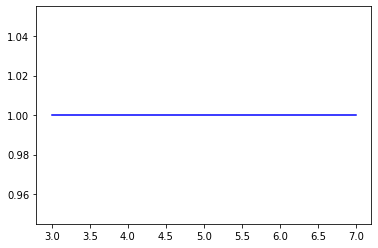

In [126]:
for concepts in all_txt:
    print(concepts[0], concepts[1])
    similarity_scores = list()
    for model in models_window:
        similarity_scores.append(average_cosine_similarity(concepts[0], concepts[1], model))
    if similarity_scores[0] is not None:
        plt.plot(window_list, similarity_scores,'b-')
        plt.show()
        
###boxplot for average behaviour
###look at trend by looking at ratio

In [ ]:
for concepts in all_txt:
    print(concepts[0], concepts[1])
    print(combined_cosine_similarity(concepts[0], concepts[1]))
    print(combined_cosine_similarity_flair(concepts[0], concepts[1]))
    print(combined_cosine_similarity_bert(concepts[0], concepts[1]))
    print('-------------')

In [ ]:
difference_vector = currentmodel.wv['staphylococcal_infections'] - currentmodel.wv['staph']
print(difference_vector)
print(combined_cosine_similarity2(90))

In [ ]:
print(cosine_similarity('deficiency', 'insufficiency'))

In [85]:
abbreviation_path = 'concept_abbreviation.txt'
with open(abbreviation_path, 'r') as dictionary:
    abbreviations_dic = {}
    for line in dictionary:
        if len(line)>1:
            line=line.split('-',1)
            abbreviations_dic[line[0].rstrip().lower()] = line[1].lstrip().lower()

In [86]:
with open('train.json') as json_f:
    dataset = json.load(json_f)
    for data in dataset:
        for n in data['supports']:
            print(n)

Induction of apoptosis of Beta cells of the pancreas by advanced glycation end-products , important mediators of chronic complications of diabetes mellitus . We herein report cytotoxicity of advanced glycation end-products ( AGEs ) on pancreatic beta cells . AGEs stimulated reactive oxygen species ( ROS ) generation but did not arrest proliferation of the P01308 -1 cell line . Pancreatic beta cell lines or primary cultured islets possess a receptor for P51606 ( RAGE ) , and its expression increased after P51606 treatment . TUNEL staining and FACS analysis using annexin V/PI antibodies showed that apoptosis increased in P01308 -1 cells or primary cultured islets when incubated with BSA conjugated with glyceraldehyde ( AGE2 ) or glucoaldehyde ( AGE3 ) , compared with those conjugated with glucose ( AGE1 ) . Reaction of P01308 -1 cells to Ki67 , which is a cellular marker for proliferation , was also increased after P51606 treatment . The ability of primary cultured islets to secrete insu

Glucocorticoid-induced surface expression of annexin 1 blocks beta2-integrin adhesion of human eosinophils to intercellular adhesion molecule 1 surrogate protein . BACKGROUND : Glucocorticoids attenuate the population of eosinophils and T lymphocytes in asthmatic airways . The decrease in airway eosinophilia is caused both by accelerated cell death and by induction of blockade of integrin adhesion . In this study , we examined the hypothesis that annexin 1 surface expression , which is upregulated by the glucocorticoid receptor , prevents integrin adhesion essential to cell migration by blocking intracellular translocation of cytosolic group IV phospholipase A2 ( P47712 ) . OBJECTIVE : To examine the relationship of the glucocorticoid on annexin 1 expression and the effect of blockade of annexin 1 activity on adhesion of human eosinophils in vitro . To determine the relationship between annexin 1surface expression and nuclear membrane translocation of P47712 . METHODS : Eosinophils iso

Sources contributing to the average extracellular concentration of dopamine in the nucleus accumbens . Mesolimbic dopamine neurons fire in both tonic and phasic modes resulting in detectable extracellular levels of dopamine in the nucleus accumbens ( NAc ) . In the past , different techniques have targeted dopamine levels in the NAc to establish a basal concentration . In this study , we used in vivo fast scan cyclic voltammetry ( FSCV ) in the NAc of awake , freely moving rats . The experiments were primarily designed to capture changes in dopamine caused by phasic firing - that is , the measurement of dopamine ' transients ' . These FSCV measurements revealed for the first time that spontaneous dopamine transients constitute a major component of extracellular dopamine levels in the NAc . A series of experiments were designed to probe regulation of extracellular dopamine . DB00281 was infused into the ventral tegmental area , the site of dopamine cell bodies , to arrest neuronal firin

DB00107 alleviates the neuroendocrine and cytokine response to bacterial endotoxin in healthy men . DB00107 is a hormone and neurotransmitter found to have anti-inflammatory functions in rodents . Here we used experimental bacterial endotoxinemia to examine the role of exogenous oxytocin administration on innate immune responses in humans . Ten healthy men received , in a randomized , placebo-controlled , crossover design , placebo , oxytocin , LPS , and LPS + oxytocin . DB00107 treatment resulted in a transient or prolonged reduction of endotoxin-induced increases in plasma DB01285 , cortisol , procalcitonin , P01375 , IL-1 receptor antagonist , P05112 , P05231 , macrophage inflammatory protein-1alpha , macrophage inflammatory protein-1beta , monocyte chemoattractant protein-1 ( P13500 ) , interferon-inducible protein 10 , and P15692 . In vitro , oxytocin had no impact on LPS effects in releasing P01375 , P05231 , and P13500 in monocytes and peripheral blood mononuclear cells from hea

Topoisomerase II-mediated DNA cleavage and mutagenesis activated by nitric oxide underlie the inflammation-associated tumorigenesis . AIMS : Both cancer-suppressing and cancer-promoting properties of reactive nitrogen and oxygen species ( RNOS ) have been suggested to play a role in tumor pathology , particularly those activities associated with chronic inflammation . Here , we address the impact of nitric oxide ( NO ) on the induction of DNA damage and genome instability with a specific focus on the involvement of topoisomerase II ( P11388 ) . We also investigate the contribution of NO to the formation of skin melanoma in mice . RESULTS : Similar to the P11388 -targeting drug , etoposide ( DB00773 ) , the NO-donor , S-nitrosoglutathione ( GSNO ) , induces skin melanomas formation in 7,12-dimethyl- benz[a]anthracene ( DMBA ) -initiated mice . To explore the mechanism(s) underlying this NO-induced tumorigenesis , we use a co-culture model system to demonstrate that inflamed macrophages 

Loss of homologous recombination or non-homologous end-joining leads to radial formation following DNA interstrand crosslink damage . High levels of interstrand cross-link damage in mammalian cells cause chromatid breaks and radial formations recognizable by cytogenetic examination . The mechanism of radial formation observed following DNA damage has yet to be determined . Due to recent findings linking homologous recombination and non-homologous end-joining to the action of the Fanconi anemia pathway , we speculated that radials might be the result of defects in either of the pathways of DNA repair . To test this hypothesis , we have investigated the role of homologous recombination proteins Q06609 and P43351 , non-homologous end-joining proteins P12956 and P49917 , and protein P49959 in radial formation and cell survival following interstrand crosslink damage with mitomycin C . For the studies we used small inhibitory RNA to deplete the proteins from cells , allowing for evaluation o

P35367 antagonist cetirizine impairs working memory processing speed , but not episodic memory . BACKGROUND AND PURPOSE : The histaminergic neurotransmitter system is currently under investigation as a target for drug treatment of cognitive deficits in clinical disorders . The therapeutic potential of new drugs may initially be screened using a model of histaminergic dysfunction , for example , as associated with the use of centrally active antihistamines . Of the selective second generation antihistamines , cetirizine has been found to have central nervous system effects . The aim of the present study was to determine whether cetirizine can be used as a tool to model cognitive deficits associated with histaminergic hypofunction . EXPERIMENTAL APPROACH : The study was conducted according to a three-way , double-blind , cross-over design . Treatments were single oral doses of cetirizine 10 and 20 mg and placebo . Effects on cognition were assessed using tests of word learning , memory s

2,3,5,4'-tetrahydroxystilbene-2-O-β-d-glucoside ameliorates vascular senescence and improves blood flow involving a mechanism of p53 deacetylation . BACKGROUND AND AIMS : 2,3,5,4'-tetrahydroxystilbene-2-O-β-d-glucoside ( THSG ) , a resveratrol analog with glucoside , has been shown in various studies to inhibit proliferation of vascular smooth muscle cells , attenuate inflammation , and prevent vascular endothelial dysfunction . In the study , we examined the effects of THSG on vascular senescence and blood flow . METHODS AND RESULTS : Oral administration of THSG for 14 weeks , resulted in notable increases in blood flow in spontaneously hypertensive rats ( SHRs ) ; and effective inhibition of vascular senescence as indicated by senescence-associated β-galactosidase ( SA-β-gal ) staining , phosphorylation of γ P16104 observed by stain analysis of immunofluorescence , and K373 acetylation of p53 in the aortic arches of SHRs . Oral administration of THSG also induced P29474 expression an

New perspectives of vesicular monoamine transporter 2 chemical characteristics in mammals and its constant expression in type 1 diabetes rat models . Vesicular monoamine transporter 2 ( Q05940 ) has been exploited as a biomarker of β-cell mass in human islets . However , a current report suggested no immunoreactivity of Q05940 in the β cells of rat islets . To investigate the cellular localization of Q05940 in islets further , the pancreatic tissues from monkeys and humans were compared with those of rats and mice . The study was performed using among-species comparisons and a type 1 diabetes model ( T1DM ) for rats by Western blotting , double-label immunofluorescence , and confocal laser scanning microscopy . We found that Q05940 -immunoreactivity ( IR ) was distributed peripherally in the islets of rodents , but was widely scattered throughout the islets of primates . Consistent with rodent islets , Q05940 -IR did not exist in insulin ( P01308 ) -IR cells but was abundantly present 

Acidic pH induces topoisomerase II-mediated DNA damage . Acidic pH plays an important role in various pathophysiological states and has been demonstrated to be carcinogenic in animal models . Recent studies have also implicated acidic pH in the development of preneoplastic Barrett 's esophagus in human . However , little is known about the molecular mechanism underlying acidic pH-induced carcinogenesis . In the current study , we show that acidic pH , like the topoisomerase II ( P11388 ) poison DB00773 ( demethylepipodophyllotoxin ethylidene-beta-D-glucoside ) , induces tumors in 9,10-dimethyl-1,2-benzanthracene(DMBA)-initiated mice . The following studies in tissue culture models have suggested that acidic pH acts like a P11388 poison to induce P11388 -mediated DNA damage : ( i ) acidic pH induces P11388 -dependent DNA damage signals as evidenced by up-regulation of p53 and DB00133 -139 phosphorylation of P16104 [ a substrate for ataxia telangiectasia mutated ( Q13315 ) Q13315 and Rad

Stimulation of epithelial repair is a likely mechanism for the action of mifepristone in reducing duration of bleeding in users of progestogen-only contraceptives . Many women using progestogen ( P ) -only contraceptives experience uterine bleeding problems . In clinical trials , a single low dose of mifepristone , given to DB00294 users at the beginning of a bleeding episode reduced the number of bleeding days by approximately 50 % compared with controls . In this study , a single dose of mifepristone was administered to etonogestrel ( P17813 ) -exposed pseudo-pregnant mice , 5 days after artificial decidualization was induced when the endometrium showed signs of bleeding . Control mice received vehicle alone . Mice were culled 12- , 18- , 24- and 48-h post-treatment . In the continued presence of P17813 , a single dose of mifepristone stimulated tissue breakdown followed by very rapid repair : most treated tissues were fully restored to the pre-decidualized state by 48 h post-treatme

Targeting Q01196 / Q06455 -histone deacetylase repressor complex : a novel mechanism for valproic acid-mediated gene expression and cellular differentiation in Q01196 / Q06455 -positive acute myeloid leukemia cells . In t(8;21) acute myeloid leukemia ( AML ) , the Q01196 / Q06455 fusion protein promotes leukemogenesis by recruiting class I histone deacetylase ( HDAC ) -containing repressor complex to the promoter of Q01196 target genes . Valproic acid ( DB00313 ) , a commonly used antiseizure and mood stabilizer drug , has been shown to cause growth arrest and induce differentiation of malignant cells via HDAC inhibition . DB00313 causes selective proteasomal degradation of Q92769 but not other class I HDACs ( i.e. , HDAC 1 , 3 , and 8 ) . Therefore , we raised the question of whether this drug can effectively target the leukemogenic activity of the Q01196 / Q06455 fusion protein that also recruits Q13547 , a key regulator of normal and aberrant histone acetylation . We report here tha

DB00184 induces cell proliferation , invasion and epithelial-mesenchymal transition in a variety of human cancer cell lines . Cigarette smoking is strongly correlated with the onset of nonsmall cell lung cancer ( NSCLC ) . DB00184 , an active component of cigarettes , has been found to induce proliferation of lung cancer cell lines . In addition , nicotine can induce angiogenesis and confer resistance to apoptosis . All these events are mediated through the nicotinic acetylcholine receptors ( nAChRs ) on lung cancer cells . In this study , we demonstrate that nicotine can promote anchorage-independent growth in NSCLCs . In addition , nicotine also induces morphological changes characteristic of a migratory , invasive phenotype in NSCLCs on collagen gel . These morphological changes were similar to those induced by the promigratory growth factor P15692 . The proinvasive effects of nicotine were mediated by alpha7-nAChRs on NSCLCs . RT-PCR analysis showed that the alpha7-nAChRs were also

4-[3,5-Bis(trimethylsilyl)benzamido] benzoic acid inhibits angiogenesis in colon cancer through reduced expression of vascular endothelial growth factor . 4-[3,5-bis(trimethylsilyl)benzamido] Benzoic acid ( TAC-101 ) has potent antiproliferative , antiangiogenic , and antitumor effects in vitro and in vivo . These effects might be due to TAC-101 binding to retinoic acid receptor alpha ( P10276 ) and interfering with the binding of activator protein-1 ( AP-1 ) to DNA . However , little is known about the detailed mechanism of TAC-101 function . We investigated the mechanism of the antiangiogenic effect of TAC-101 using a rat hepatic metastatic model in vivo and DLD-1 human colon cancer cells in vitro . Liver metastases were induced by portal injection of Q15293 -9 rat colonic cancer cells into F344 rats . TAC-101 ( 8 mg/kg ) was orally administered 5 days per week for 4 weeks and then hepatic tumors were immunohistochemically evaluated for microvessel density ( P53602 ) and vascular end

Loss of epigenetic Kruppel-like factor 4 histone deacetylase ( KLF-4-HDAC ) -mediated transcriptional suppression is crucial in increasing vascular endothelial growth factor ( P15692 ) expression in breast cancer . Vascular endothelial growth factor ( P15692 ) is recognized as an important angiogenic factor that promotes angiogenesis in a series of pathological conditions , including cancer , inflammation , and ischemic disorders . We have recently shown that the inflammatory transcription factor P56270 is , at least in part , responsible for the marked increase of P15692 levels in breast cancer . Here , we show that P56270 -mediated induction of P15692 is repressed by KLF-4 transcription factor . KLF-4 is abundantly present in normal breast epithelial cells , but its level is considerably reduced in breast cancer cells and clinical cancer tissues . In the human P15692 promoter , P56270 - and KLF-4-binding elements are overlapping , whereas P56270 induces and KLF-4 suppresses P15692 ex

Anti-Parkinson 's disease drugs and pharmacogenetic considerations . INTRODUCTION : The development of pharmacogenetic-based clinical practice guidelines for the use of anti-Parkinson 's disease drugs requires , as a pre-requisite , the identification and validation of genetic biomarkers . These biomarkers are then used as surrogate endpoints . This review analyzes potential genetic biomarkers which can be used to improve anti-Parkinson 's disease therapy . AREAS COVERED : The authors present an overview of current knowledge of pharmacogenetic implications of anti-Parkinson 's disease drugs , including genes coding for the corresponding drug-metabolizing enzymes and drug targets . The gene/drug pairings with the strongest potential for pharmacogenetic recommendations include : P33261 /benztropine , P21964 /levodopa and entacapone , P20813 /selegiline , P22309 /entacapone , P14416 /ropinirole , pramipexole and cabergoline , and P35462 /ropinirole and pramipexole . Evidence supporting th

Second generation steroidal 4-aminoquinolines are potent , dual-target inhibitors of the botulinum neurotoxin serotype A metalloprotease and P. falciparum malaria . Significantly more potent second generation 4-amino-7-chloroquinoline ( 4,7-ACQ ) based inhibitors of the botulinum neurotoxin serotype A ( DB00083 ) light chain were synthesized . Introducing an amino group at the C(3) position of the cholate component markedly increased potency ( IC50 values for such derivatives ranged from 0.81 to 2.27 μM ) . Two additional subclasses were prepared : bis(steroidal)-4,7-ACQ derivatives and bis(4,7-ACQ)cholate derivatives ; both classes provided inhibitors with nanomolar-range potencies ( e.g. , the Ki of compound 67 is 0.10 μM ) . During DB00083 challenge using primary neurons , select derivatives protected P60880 by up to 89 % . Docking simulations were performed to rationalize the compounds ' in vitro potencies . In addition to specific residue contacts , coordination of the enzyme 's c

Inhibition of histamine H1 receptor activity modulates proinflammatory cytokine production of dendritic cells through c-Rel activity . BACKGROUND : DB11320 exerts diverse effects on immune regulation through four types of histamine receptors ( HRs ) . Among them , type 1 receptor ( P35367 ) plays an important role in allergic inflammation . Dendritic cells ( DCs ) , which express at least three types of HRs , are professional antigen-presenting cells controlling the development of allergic inflammation . However , the molecular mechanisms involved in P35367 -mediated NF-ĸB signaling of DCs remain poorly defined . METHODS : Bone-marrow ( BM ) -derived DCs ( BM-DCs ) were treated with P35367 inverse agonists to interrupt basal P35367 -mediated signaling . The crosstalk of P35367 -mediated signaling and the NF-ĸB pathway was examined by NF-ĸB cellular activity using a luciferase reporter assay , NF-ĸB subunit analysis using Western blotting and P01375 -α promoter activity using chromatin 

Accelerated intoxication of GABAergic synapses by botulinum neurotoxin A disinhibits stem cell-derived neuron networks prior to network silencing . Botulinum neurotoxins ( BoNTs ) are extremely potent toxins that specifically cleave SNARE proteins in peripheral synapses , preventing neurotransmitter release . Neuronal responses to BoNT intoxication are traditionally studied by quantifying SNARE protein cleavage in vitro or monitoring physiological paralysis in vivo . Consequently , the dynamic effects of intoxication on synaptic behaviors are not well-understood . We have reported that mouse embryonic stem cell-derived neurons ( ESNs ) are highly sensitive to BoNT based on molecular readouts of intoxication . Here we study the time-dependent changes in synapse- and network-level behaviors following addition of DB00083 to spontaneously active networks of glutamatergic and GABAergic ESNs . Whole-cell patch-clamp recordings indicated that DB00083 rapidly blocked synaptic neurotransmission

Dynamics of motor nerve terminal remodeling unveiled using SNARE-cleaving botulinum toxins : the extent and duration are dictated by the sites of P60880 truncation . Nerve sprouts emerge from motor nerve terminals following blockade of exo-endocytosis for more than 3 days by botulinum neurotoxin ( BoNT ) , and form functional synapses , albeit temporary . Upon restoration of synaptic activity to the parent terminal 7 and 90 days after exposure to BoNT/F or A respectively , a concomitant retraction of the outgrowths was observed . BoNT/E caused short-term neuroparalysis , and dramatically accelerated the recovery of DB00083 -paralyzed muscle by further truncation of P60880 and its replenishment with functional full-length SNARE . The removal of 9 C-terminal residues from P60880 by DB00083 leads to persistence of the inhibitory product due to the formation of a nonproductive SNARE complex(es) at release sites , whereas deletion of a further 17 amino acids permits replenishment and a spee

8-Hydroxyquinoline and hydroxamic acid inhibitors of botulinum neurotoxin DB00083 . We describe here the state of the art of certain aspects concerning potential small molecule therapy directed toward botulism , by inhibition of the zinc-protease containing light chain ( LC ) of botulinum neurotoxin DB00083 from the anaerobic bacillus Clostridium botulinum . Botulinum neurotoxins ( BoNTs ) are comprised of eight serologically-distinct proteins ( A - H ) , several of which are further divided , such as DB00083 which has five subtypes . The BoNTs are the most toxic substances known to mankind , causing a form of flaccid paralysis that can be rapid and is often lethal . DB00083 is comprised of a ~100 kDa heavy chain ( HC ) attached via a single disulfide DB00151 - DB00151 bond to a ~50 kDa LC . The HC mediates transport to and uptake by presynaptic glutamatergic neurons , where the LC cleaves the protein P60880 and thus prevents vesicular trafficking and release of acetylcholine . The Zn-

Protective effects of metallothionein on isoniazid and rifampicin-induced hepatotoxicity in mice . Isoniazid ( DB00951 ) and DB01045 ( RFP ) are widely used in the world for the treatment of tuberculosis , but the hepatotoxicity is a major concern during clinical therapy . Previous studies showed that these drugs induced oxidative stress in liver , and several antioxidants abated this effect . Metallothionein ( MT ) , a member of cysteine-rich protein , has been proposed as a potent antioxidant . This study attempts to determine whether endogenous expression of MT protects against DB00951 and RFP-induced hepatic oxidative stress in mice . Wild type ( MT+/+ ) and MT-null ( MT-/- ) mice were treated intragastrically with DB00951 ( 150 mg/kg ) , RFP ( 300 mg/kg ) , or the combination ( 150 mg/kg DB00951 +300 mg/kg RFP ) for 21 days . The results showed that MT-/- mice were more sensitive than MT+/+ mice to DB00951 and RFP-induced hepatic injuries as evidenced by hepatic histopathological 

Long-distance retrograde effects of botulinum neurotoxin A . Botulinum neurotoxins ( designated DB00083 -BoNT/G ) are bacterial enzymes that block neurotransmitter release by cleaving essential components of the vesicle fusion machinery . DB00083 , which cleaves P60880 ( synaptosomal-associated protein of 25 kDa ) , is extensively exploited in clinical medicine to treat neuromuscular pathologies , facial wrinkles , and various types of pain . It is widely assumed that DB00083 remains at the synaptic terminal and its effects are confined to the injection site . Here we demonstrate that catalytically active DB00083 is retrogradely transported by central neurons and motoneurons and is then transcytosed to afferent synapses , in which it cleaves P60880 . P60880 cleavage by DB00083 was observed in the contralateral hemisphere after unilateral DB00083 delivery to the hippocampus . Appearance of cleaved P60880 resulted in blockade of hippocampal activity in the untreated hemisphere . Injectio

Detection of thymidylate synthase modulators by a novel screening assay . P04818 ( TS ) , a key cancer chemotherapeutic target , catalyzes the conversion of deoxyuridylate to thymidylate . TS can serve as a repressor of its own synthesis by binding to its own mRNA through TS-specific binding elements ( TBEs ) . In this report , we describe the use of a luciferase reporter plasmid containing two TBEs that can be used as a tool for the identification and initial profiling of compounds that modulate TS activity , levels , or ability to bind mRNA . To validate this model , we evaluated several groups of drugs . Thus , cells were exposed to the pyrimidine analogs 5-fluorouracil ( DB00544 ) , 5-fluorouridine ( DB01629 ) , 5-fluoro-2'-deoxyuridine ( FUdR ) , trifluorothymidine ( DB00432 ) ; to the nonpyrimidine TS-inhibitors AG-331 , nolatrexed ( AG337 ) , and raltitrexed ( DB00293 ) ; or to drugs with other primary sites of action ( methotrexate , actinomycin D , 5-azacytidine , 8-thioguanos

Therapeutic effectiveness of botulinum neurotoxin A : potent blockade of autonomic transmission by targeted cleavage of only the pertinent P60880 . In search of a basis for the impressive potency of an endoprotease that cleaves P60880 , botulinum neurotoxin type A ( DB00083 ) , in treating numerous diseases due to hyper-active autonomic nerves , truncation of its target and inhibition of neurotransmission were studied in rat sympathetic neurons . DB05232 -sensitive spontaneous cholinergic neurotransmission was blocked > 80 % by 1 pM DB00083 despite cleaving < 20 % of the P60880 . A maximum cleavage of ∼60 % P60880 could be achieved with > 1 nM DB00083 , despite an absence of non-cleavable P60880 in the detergent-solubilised neurons . In contrast , BoNT/E ( 100 nM ) truncated nearly all the P60880 in the intact cells , but was unable to block neurotransmission at low concentrations like DB00083 . Chimeras created by inserting the acceptor-binding HC domain of DB00083 into BoNT/E still c

[ Innate resistance to thymidylate synthase inhibition after 5-fluorouracil treatment -- a rationale of combined use of cisplatin and its optimal administration dose ] . We examined the changes of the number of DB00322 MP binding sites of thymidylate thynthase ( TS-BS ) in Yoshida sarcoma after administration of DB00544 to the tumor bearing rats . We also investigated the optimal dose of DB00515 for the increase of intracellular folate level . In the group received consecutive 7-days administration of DB09327 ( U-7 group ) , total TS-BS was significantly increased compared with non-treatment group and the group received only DB09327 ( U-1 group ) . For free TS-BS , however , there was no difference despite of DB09327 administration . P04818 inhibition rate ( TSIR ) was , therefore , significantly high in U-7 group compared with U-1 group . It seemed necessary to take some counter measure for the induction of TS in the tumor tissue when DB00544 chemotherapy was performed . The optimal d

DB00368 inhibits exocytosis via the G protein βγ subunit and refilling of the readily releasable granule pool via the α(i1/2) subunit . The molecular mechanisms responsible for the ' distal ' effect by which noradrenaline ( NA ) blocks exocytosis in the β-cell were examined by whole-cell and cell-attached patch clamp capacitance measurements in P01308 832/13 β-cells . NA inhibited Ca(2+)-evoked exocytosis by reducing the number of exocytotic events , without modifying vesicle size . Fusion pore properties also were unaffected . NA-induced inhibition of exocytosis was abolished by a high level of Ca(2+) influx , by intracellular application of antibodies against the G protein subunit Gβ and was mimicked by the myristoylated βγ-binding/activating peptide mSIRK . NA-induced inhibition was also abolished by treatment with DB00083 , which cleaves the C-terminal nine amino acids of P60880 , and also by a P60880 C-terminal-blocking peptide containing the DB00083 cleavage site . These data ind

The destructive effect of botulinum neurotoxins on the SNARE protein : P60880 and synaptic membrane fusion . Synaptic exocytosis requires the assembly of syntaxin 1A and P60880 on the plasma membrane and synaptobrevin 2 ( P63027 ) on the vesicular membrane to bridge the two opposite membranes . It is believed that the three SNARE proteins assemble in steps along the dynamic assembly pathway . The C-terminus of P60880 is known to be the target of botulinum neurotoxins ( DB00083 and BoNT/E ) that block neurotransmitters release in vivo . In this study , we employed electron paramagnetic resonance ( EPR ) spectroscopy to investigate the conformation of the P60880 C-terminus in binary and ternary SNARE complexes . The fluorescence lipid mixing assay shows that the C-terminal of P60880 is essential for membrane fusion , and that the truncated P60880 mutants cleaved by DB00083 and BoNT/E display different inhibition effects on membrane fusion : P60880 -25E ( Δ26 ) abolishes the fusion activi

Botulinum neurotoxin C1 cleaves both syntaxin and P60880 in intact and permeabilized chromaffin cells : correlation with its blockade of catecholamine release . The seven types ( A -- G ) of botulinum neurotoxin ( BoNT ) are DB01593 -dependent endoproteases that potently block neurosecretion . Syntaxin is presently thought to be the sole substrate for BoNT/C1 , and synaptosomal-associated protein of Mr = 25 000 ( P60880 ) is selectively proteolyzed by types A and E . In this study , the effects of C1 on Ca2+ -regulated exocytosis of dense core granules from adreno-chromaffin cells were examined together with its underlying molecular action . Intact chromaffin cells were exposed to the toxin , and catecholamine release therefrom was then measured in conjunction with the monitoring of syntaxin cleavage by Western blotting . A good correlation was obtained between degradation of syntaxin 1A/B and reduction in Ca2+- or Ba2+-dependent secretion . However , blotting with antibodies against a

Correlation of cleavage of P60880 with muscle function in a rat model of Botulinum neurotoxin type A induced paralysis . Injection of botulinum neurotoxin serotype A ( DB00083 ) into muscle results in cleavage of the synaptosomal associated protein of 25 kDa ( P60880 ) and relatively long-term paralysis . However , nerve-terminal sprouting , which appears to require intact P60880 , has been reported to occur much earlier . The difference between the long-term paralysis induced by injection of DB00083 and the short time needed for sprouting led us to investigate the relationship between DB00083 catalyzed cleavage of P60880 and muscle function . The effect of DB00083 on P60880 present in nerve endings innervating gastrocnemius muscles of rats was monitored over time . Cleaved P60880 was found in nerve terminals innervating the muscles within 24h of inoculation with DB00083 and was present more than 2 months later . Comparison of the ratios of cleaved to intact P60880 from the onset of DB

Self-assembled peptide monolayers as a toxin sensing mechanism within arrayed microchannels . A sensor for the lethal bacterial enzyme , botulinum neurotoxin type A ( DB00083 ) , was developed using self-assembled monolayers ( SAMs ) . SAMs consisting of an immobilized synthetic peptide that mimicked the toxin 's in vivo P60880 protein substrate were formed on Au and interfaced with arrayed microfluidic channels . Efforts to optimize DB00118 composition and assay conditions for greatest reaction efficiency and sensitivity are described in detail . Channel design provided facile fluid manipulation , sample incubation , analyte concentration , and fluorescence detection all within a single microfluidic channel , thus avoiding sample transfer and loss . Peptide SAMs were exposed to varying concentrations of DB00083 or its catalytic light chain ( ALC ) , resulting in enzymatic cleavage of the peptide substrate from the surface . Fluorescence detection was achieved down to 20 pg/mL ALC and 

Basic tetrapeptides as potent intracellular inhibitors of type A botulinum neurotoxin protease activity . Botulinum neurotoxins ( BoNT ) are the most potent of all toxins that cause flaccid muscle paralysis leading to death . They are also potential biothreat agents . A systematic investigation of various short peptide inhibitors of the BoNT protease domain with a 17-residue peptide substrate led to arginine-arginine-glycine-cysteine having a basic tetrapeptide structure as the most potent inhibitor . When assayed in the presence of dithiothreitol ( DTT ) , the inhibitory effect was drastically reduced . Replacing the terminal cysteine with one hydrophobic residue eliminated the DTT effect but with two hydrophobic residues made the pentapeptide a poor inhibitor . Replacing the first arginine with cysteine or adding an additional cysteine at the N terminus did not improve inhibition . When assessed using mouse brain lysates , the tetrapeptides also inhibited DB00083 cleavage of the endo

Novel chimeras of botulinum neurotoxins A and E unveil contributions from the binding , translocation , and protease domains to their functional characteristics . Hyperexcitability disorders of cholinergically innervated muscles are treatable with botulinum neurotoxin ( BoNT ) A . The seven serotypes ( A-G ) potently block neurotransmission by binding to presynaptic receptors , undergoing endocytosis , transferring to the cytosol , and inactivating proteins essential for vesicle fusion . Although DB00083 and BoNT/E cleave P60880 , albeit at distinct sites , BoNT/E blocks neurotransmission faster and more potently . To identify the domains responsible for these characteristics , the C-terminal heavy chain portions of DB00083 and BoNT/E were exchanged to create chimeras AE and EA . After high yield expression in Escherichia coli , these single chain chimeras were purified by two-step chromatography and activated by conversion to disulfide-linked dichains . In vitro , each entered neurons

Recombinant P60880 is an effective substrate for Clostridium botulinum type A toxin endopeptidase activity in vitro . Bacterial neurotoxins are now being used routinely for the treatment of neuromuscular conditions . Alternative assays to replace or to complement in vivo bioassay methods for assessment of the safety and potency of these botulinum neurotoxin-based therapeutic products are urgently needed . Advances made in understanding the mode of action of clostridial neurotoxins have provided the basis for the development of alternative mechanism-based assay methods . Thus , the identification of P60880 ( synaptosomal-associated protein of molecular mass 25 kDa ) as the intracellular protein target which is selectively cleaved during poisoning by botulinum neurotoxin type A ( DB00083 ) has enabled the development of a functional in vitro assay for this toxin . Using recombinant DNA methods , a segment of P60880 ( aa residues 134-206 ) spanning the toxin cleavage site was prepared as 

Anti-nociceptive effect of a conjugate of DB05875 and light chain of botulinum neurotoxin type A . Neuropathic pain is a debilitating condition resulting from damage to sensory transmission pathways in the peripheral and central nervous system . A potential new way of treating chronic neuropathic pain is to target specific pain-processing neurons based on their expression of particular receptor molecules . We hypothesized that a toxin-neuropeptide conjugate would alter pain by first being taken up by specific receptors for the neuropeptide expressed on the neuronal cells . Then , once inside the cell the toxin would inhibit the neurons ' activity without killing the neurons , thereby providing pain relief without lesioning the nervous system . In an effort to inactivate the nociceptive neurons in the trigeminal nucleus caudalis in mice , we targeted the NK1 receptor ( P25103 ) using DB05875 ( SP ) . The catalytically active light chain of botulinum neurotoxin type A ( LC/A ) was conjug

Persistence of botulinum neurotoxin action in cultured spinal cord cells . Primary dissociated fetal mouse spinal cord cultures were used to study the mechanisms underlying the differences in persistence of botulinum neurotoxin A ( DB00083 ) and botulinum neurotoxin/E ( BoNT/E ) activities . Spinal cord cultures were exposed to DB00083 ( 0.4 pM ) for 2-3 days , which converted approximately half of the P60880 to an altered form lacking the final nine C-terminal residues . The distribution of toxin-damaged to control P60880 remained relatively unchanged for up to 80 days thereafter . Application of a high concentration of BoNT/E ( 250 pM ) either 25 or 60 days following initial intoxication with DB00083 converted both normal and DB00083 -truncated P60880 into a single population lacking the final 26 C-terminal residues . Excess BoNT/E was removed by washout , and recovery of intact P60880 was monitored by Western blot analysis . The BoNT/E-truncated species gradually diminished during t

Structural analysis of botulinum neurotoxin serotype F light chain : implications on substrate binding and inhibitor design . The seven serologically distinct Clostridium botulinum neurotoxins ( BoNTs A-G ) are zinc endopeptidases which block the neurotransmitter release by cleaving one of the three proteins of the soluble N-ethylmaleimide-sensitive-factor attachment protein receptor complex ( SNARE complex ) essential for the fusion of vesicles containing neurotransmitters with target membranes . These metallopeptidases exhibit unique specificity for the substrates and peptide bonds they cleave . Development of countermeasures and therapeutics for BoNTs is a priority because of their extreme toxicity and potential misuse as biowarfare agents . Though they share sequence homology and structural similarity , the structural information on each one of them is required to understand the mechanism of action of all of them because of their specificity . Unraveling the mechanism will help in 

17 DB00783 -mediated growth inhibition of MDA-MB-468 cells stably transfected with the estrogen receptor : cell cycle effects . P03372 ( ER ) -negative MDA-MB-468 human breast cancer cells were stably transfected with wild-type human ER and utilized as a model for investigating estrogen- and aryl hydrocarbon ( Ah ) -responsiveness . Treatment of the stably transfected cells with 10 nM 17 beta-estradiol ( E2 ) resulted in a significant inhibition ( > 60 % ) of cell proliferation and DNA synthesis , which was blocked by 10(-7) M ICI 182 780 . Analysis by flow cytometry indicated that treatment with E2 increased the percentage of cells in G0/ P55008 ( from 68.8 to 89.4 ) and decreased cells in S ( from 18.4 to 3.4 ) and G2/M ( from 12.8 to 7.2 ) phases of the cell cycle . The effects of E2 on the major cyclins , cyclin-dependent kinases and cyclin-dependent kinase inhibitors , retinoblastoma protein ( RB ) , Q01094 , and cyclin-dependent kinase activities were also investigated in the sta

Neuromuscular transmission and muscle contractility in P60880 -deficient coloboma mice . Synaptosomal associated protein of 25 kDa ( P60880 ) is a cytoplasmic protein that participates in the docking and fusion of synaptic vesicles with the nerve terminal in preparation for neurotransmitter release . P60880 is also a substrate for three of the seven serotypes of botulinum neurotoxin ( BoNT ) . Intoxication by DB00083 , /C1 or /E results in weakness and paralysis of skeletal muscle due to cleavage of P60880 ( and syntaxin la in the case /C1 ) at discrete serotype-specific sites . To elucidate the role of P60880 in muscle function in more detail , contractility and neuromuscular transmission were studied in a mutant mouse model termed coloboma . The coloboma mutation results from a contiguous deletion of 1-2 centiMorgans on chromosome 2 , which includes the entire P60880 locus and three other identified genes . Homozygotes do not survive beyond gestation day 6 ; heterozygotes ( Cm/+ ) ha

Candidate gene studies of ADHD : a meta-analytic review . Quantitative genetic studies ( i.e. , twin and adoption studies ) suggest that genetic influences contribute substantially to the development of attention deficit hyperactivity disorder ( ADHD ) . Over the past 15 years , considerable efforts have been made to identify genes involved in the etiology of this disorder resulting in a large and often conflicting literature of candidate gene associations for ADHD . The first aim of the present study was to conduct a comprehensive meta-analytic review of this literature to determine which candidate genes show consistent evidence of association with childhood ADHD across studies . The second aim was to test for heterogeneity across studies in the effect sizes for each candidate gene as its presence might suggest moderating variables that could explain inconsistent results . Significant associations were identified for several candidate genes including Q01959 , P21917 , P21918 , P31645 

Desmopressin ( DB00035 ) induces NO production in human endothelial cells via V2 receptor- and DB02527 -mediated signaling . The hemostatic agent desmopressin ( DB00035 ) also has strong vasodilatory effects . DB00035 is a selective agonist for the vasopressin V2 receptor ( P30518 ) , which is coupled to DB02527 -dependent signaling . DB00035 -induced vasodilation may be due to endothelial NO synthase ( P29474 ) activation . This hypothesis implies DB02527 -mediated P29474 activation . It also implies wide extrarenal , endothelial P30518 expression . We show that in human umbilical vein endothelial cells ( HUVECs ) the DB02527 -raising agents forskolin and epinephrine increase NO production , as measured by a l-NMMA-inhibitable rise in cellular cGMP content . They also increase P29474 enzymatic activity , in a partly calcium-independent manner . DB02527 -mediated P29474 activation is associated with phosphorylation of residue Ser1177 , in a phosphatidyl inositol 3-kinase ( PI3K ) -inde

Spline-fitting with a genetic algorithm : a method for developing classification structure-activity relationships . Classification methods allow for the development of structure-activity relationship models when the target property is categorical rather than continuous . We describe a classification method which fits descriptor splines to activities , with descriptors selected using a genetic algorithm . This method , which we identify as SFGA , is compared to the well-established techniques of recursive partitioning ( RP ) and soft independent modeling by class analogy ( SIMCA ) using five series of compounds : cyclooxygenase-2 ( P35354 ) inhibitors , benzodiazepine receptor ( BZR ) ligands , estrogen receptor ( ER ) ligands , dihydrofolate reductase ( P00374 ) inhibitors , and monoamine oxidase ( MAO ) inhibitors . Only 1-D and 2-D descriptors were used . Approximately 40 % of compounds in each series were assigned to a test set , " cherry-picked " from the complete set such that the

Identification and analysis of specific chromosomal region adjacent to exogenous Dhfr-amplified region in Chinese hamster ovary cell genome . Chinese hamster ovary ( CHO ) cells are widely used for the stable production of recombinant proteins . Gene amplification techniques are frequently used to improve of protein production , and the dihydrofolate reductase ( P00374 ) gene amplification system is most widely used in the CHO cell line . We previously constructed a CHO genomic bacterial artificial chromosome ( BAC ) library from a mouse Dhfr-amplified CHO DR1000L-4N cell line and one BAC clone ( Cg0031N14 ) containing the CHO genomic DNA sequence adjacent to Dhfr was selected . To identify the specific chromosomal region adjacent to the exogenous Dhfr-amplified region in the CHO cell genome , we performed further screening of BAC clones to obtain other Dhfr-amplified regions in the CHO genome . From the screening by high-density replica filter hybridization using a digoxigenin-labeled

Chronic daily tadalafil prevents the corporal fibrosis and veno-occlusive dysfunction that occurs after cavernosal nerve resection . OBJECTIVES : To determine whether a long-term single daily oral dose of a longer half-life phosphodiesterase-5 ( O76074 ) inhibitor , tadalafil , has a similar effect to that of the shorter half-life O76074 inhibitors sildenafil and vardenafil , and can prevent the fibrosis and resultant corporal veno-occlusive dysfunction ( CVOD ) occurring after cavernosal nerve ( CN ) injury . MATERIALS AND METHODS : Male rats ( 10 per group ) had either a sham operation , unilateral CN resection ( P21554 ) or bilateral P21554 , and were left untreated or given retrolingually 5 mg/kg per day of tadalafil . After 45 days , CVOD was assessed via cavernosometry , and the underlying corporal tissue changes were examined by immunohistochemistry and histochemistry ( followed by quantitative image analysis ) , Western blots , and ad hoc methods . RESULTS : DB00820 treatment n

Correlation between tumor volume response to radiotherapy and expression of biological markers in patients with cervical squamous cell carcinoma . OBJECTIVE : To determine the factors associated with tumor volume response to radiotherapy ( RT ) in cervical cancer patients , and the relationship between the tumor volume response and alteration of the expression of biological markers during RT . METHODS : Twenty consecutive patients with cervical squamous cell carcinoma who received definitive RT were enrolled . Tumor volumes were calculated by Q9BWK5 examinations performed at the start of RT ( pre-RT ) , at the fourth week of RT ( mid-RT ) , and 1 month after RT completion ( post-RT ) . Two serial punch biopsies were performed at pre- and mid-RT , and immunohistochemical staining was performed for cyclooxygenase ( P36551 ) -2 and epidermal growth factor receptor ( P00533 ) . RESULTS : For the pre-RT evaluation , fourteen ( 70 % ) and eleven ( 55 % ) patients showed positive immunoreacti

P00374 protects endothelial nitric oxide synthase from uncoupling in tetrahydrobiopterin deficiency . DB00360 ( BH4 ) is a required cofactor for the synthesis of NO by endothelial nitric oxide synthase ( P29474 ) , and endothelial BH4 bioavailability is a critical factor in regulating the balance between NO and superoxide production ( P29474 coupling ) . Biosynthesis of BH4 is determined by the activity of GTP-cyclohydrolase I ( GTPCH ) . However , BH4 levels may also be influenced by oxidation , forming 7,8-dihydrobiopterin ( BH2 ) , which promotes P29474 uncoupling . Conversely , dihydrofolate reductase ( P00374 ) can regenerate BH4 from BH2 , but whether P00374 is functionally important in maintaining P29474 coupling remains unclear . To investigate the mechanism by which P00374 might regulate P29474 coupling in vivo , we treated wild-type , BH4-deficient ( hph-1 ) , and GTPCH-overexpressing ( P30793 -Tg ) mice with methotrexate ( MTX ) , to inhibit BH4 recycling by P00374 . MTX tre

P10275 controls P00533 and P04626 gene expression at different levels in prostate cancer cell lines . P00533 or P04626 contributes to prostate cancer ( PCa ) progression by activating the androgen receptor ( AR ) in hormone-poor conditions . Here , we investigated the mechanisms by which androgens regulate P00533 and P04626 expression in PCa cells . In steroid-depleted medium ( SDM ) , P00533 protein was less abundant in androgen-sensitive LNCaP than in androgen ablation-resistant 22Rv1 cells , whereas transcript levels were similar . DB02901 ( DB02901 ) treatment increased both P00533 mRNA and protein levels and stimulated RNA polymerase II recruitment to the P00533 gene promoter , whereas it decreased P04626 transcript and protein levels in LNCaP cells . DB02901 altered neither P00533 or P04626 levels nor the abundance of prostate-specific antigen ( PSA ) , TMEPA1 , or O15393 mRNAs in 22Rv1 cells , which express the full-length and a shorter AR isoform deleted from the COOH-terminal 

DB06288 is a potent P34969 antagonist : relevance for antidepressant actions in vivo . RATIONALE : DB06288 is approved for clinical use in treating schizophrenia in a number of European countries and also for treating dysthymia , a mild form of depression , in Italy . DB06288 has also been demonstrated to be an antidepressant for patients with major depression in many clinical trials . In part because of the selective D(2)/D(3) receptor antagonist properties of amisulpride , it has long been widely assumed that dopaminergic modulation is the proximal event responsible for mediating its antidepressant and antipsychotic properties . OBJECTIVES : The purpose of these studies was to determine if amisulpride 's antidepressant actions are mediated by off-target interactions with other receptors . MATERIALS AND METHODS : We performed experiments that : ( 1 ) examined the pharmacological profile of amisulpride at a large number of central nervous system ( CNS ) molecular targets and , ( 2 ) af

DB00338 , a gastric proton pump inhibitor , inhibits melanogenesis by blocking Q04656 trafficking . DB00338 is a proton pump inhibitor used in the treatment of peptic ulcer disease and gastrosophageal reflux disease and acts by irreversibly blocking P20648 , a P-type H+/K+ ATPase in gastric parietal cells . We found that omeprazole and its closely related congeners inhibited melanogenesis at micromolar concentrations in B16 mouse melanoma cells , normal human epidermal melanocytes , and in a reconstructed human skin model . DB00338 topically applied to the skin of UV-irradiated human subjects significantly reduced pigment levels after 3 weeks compared with untreated controls . DB00338 had no significant inhibitory effect on the activities of purified human tyrosinase or on the mRNA levels of tyrosinase , dopachrome tautomerase , Pmel17 , or O75030 mRNA levels . Although melanocytes do not express P20648 , they do express Q04656 , a copper transporting P-type ATPase in the trans-Golgi n

Protective effects of metallothionein on isoniazid and rifampicin-induced hepatotoxicity in mice . Isoniazid ( DB00951 ) and DB01045 ( RFP ) are widely used in the world for the treatment of tuberculosis , but the hepatotoxicity is a major concern during clinical therapy . Previous studies showed that these drugs induced oxidative stress in liver , and several antioxidants abated this effect . Metallothionein ( MT ) , a member of cysteine-rich protein , has been proposed as a potent antioxidant . This study attempts to determine whether endogenous expression of MT protects against DB00951 and RFP-induced hepatic oxidative stress in mice . Wild type ( MT+/+ ) and MT-null ( MT-/- ) mice were treated intragastrically with DB00951 ( 150 mg/kg ) , RFP ( 300 mg/kg ) , or the combination ( 150 mg/kg DB00951 +300 mg/kg RFP ) for 21 days . The results showed that MT-/- mice were more sensitive than MT+/+ mice to DB00951 and RFP-induced hepatic injuries as evidenced by hepatic histopathological 

P35367 antagonist cetirizine impairs working memory processing speed , but not episodic memory . BACKGROUND AND PURPOSE : The histaminergic neurotransmitter system is currently under investigation as a target for drug treatment of cognitive deficits in clinical disorders . The therapeutic potential of new drugs may initially be screened using a model of histaminergic dysfunction , for example , as associated with the use of centrally active antihistamines . Of the selective second generation antihistamines , cetirizine has been found to have central nervous system effects . The aim of the present study was to determine whether cetirizine can be used as a tool to model cognitive deficits associated with histaminergic hypofunction . EXPERIMENTAL APPROACH : The study was conducted according to a three-way , double-blind , cross-over design . Treatments were single oral doses of cetirizine 10 and 20 mg and placebo . Effects on cognition were assessed using tests of word learning , memory s

Serotonin skews human macrophage polarization through P41595 and P34969 . Besides its role as a neurotransmitter , serotonin ( 5-hydroxytryptamine , 5HT ) regulates inflammation and tissue repair via a set of receptors ( 5HT(1-7) ) whose pattern of expression varies among cell lineages . Considering the importance of macrophage polarization plasticity for inflammatory responses and tissue repair , we evaluated whether 5HT modulates human macrophage polarization . 5HT inhibited the LPS-induced release of proinflammatory cytokines without affecting P22301 production , upregulated the expression of M2 polarization-associated genes ( P05120 , P07996 , Q9NY15 , Q86Y22 ) , and reduced the expression of M1-associated genes ( P08476 , P41597 , P39900 , P05121 , P29016 , O94788 ) . Whereas only 5HT(7) mediated the inhibitory action of 5HT on the release of proinflammatory cytokines , both 5HT(2B) and 5HT(7) receptors mediated the pro-M2 skewing effect of 5HT . In fact , blockade of both recepto

Phosphodiesterase type 5 inhibitors for the treatment of erectile dysfunction in patients with diabetes mellitus . DB00203 , a phosphodiesterase 5 ( O76074 ) inhibitor , has become a first-line therapy for diabetic patients with erectile dysfunction ( ED ) . The efficacy in this subgroup , based on the Global Efficacy Question , is 56 % vs 84 % in a selected group of non-diabetic men with ED . Two novel O76074 inhibitors , tadalafil ( Lilly Q9Y6W8 ) and vardenafil ( Bayer ) , have recently completed efficacy and safety clinical trials in ' general ' and diabetic study populations and are now candidates for US FDA approval . A summary analysis of the phase three clinical trials of sildenafil , tadalafil and vardenafil in both study populations is presented to provide a foundation on which the evaluation of the role of the individual O76074 inhibitors for the treatment of patients with ED and DM can be built .
A novel mutation in P30518 causing congenital nephrogenic diabetes insipidus w

Sources contributing to the average extracellular concentration of dopamine in the nucleus accumbens . Mesolimbic dopamine neurons fire in both tonic and phasic modes resulting in detectable extracellular levels of dopamine in the nucleus accumbens ( NAc ) . In the past , different techniques have targeted dopamine levels in the NAc to establish a basal concentration . In this study , we used in vivo fast scan cyclic voltammetry ( FSCV ) in the NAc of awake , freely moving rats . The experiments were primarily designed to capture changes in dopamine caused by phasic firing - that is , the measurement of dopamine ' transients ' . These FSCV measurements revealed for the first time that spontaneous dopamine transients constitute a major component of extracellular dopamine levels in the NAc . A series of experiments were designed to probe regulation of extracellular dopamine . DB00281 was infused into the ventral tegmental area , the site of dopamine cell bodies , to arrest neuronal firin

Induction , binding specificity and function of human Q9Y6W8 . Recently , we have identified the inducible co-stimulator ( Q9Y6W8 ) , an activation-dependent , T cell-specific cell surface molecule related to P10747 and P16410 . Detailed analysis of human Q9Y6W8 presented here shows that it is a 55-60-kDa homodimer with differently N-glycosylated subunits of 27 and 29 kDa . Q9Y6W8 requires both phorbol 12-myristate 13-acetate and ionomycin for full induction , and is sensitive to DB00091 . Q9Y6W8 is up-regulated early on all T cells , including the P10747 - subset , and continues to be expressed into later phases of T cell activation . On stimulation of T cells by antigen-presenting cells , the P10747 / P33681 , but not the P29965 / P25942 pathway is critically involved in the induction of Q9Y6W8 . Q9Y6W8 does not bind to P33681 -1 or P33681 -2 , and P10747 does not bind to O75144 ; thus the P10747 and Q9Y6W8 pathways do not cross-interact on the cell surface . In vivo , Q9Y6W8 is expr

Glucocorticoid-induced surface expression of annexin 1 blocks beta2-integrin adhesion of human eosinophils to intercellular adhesion molecule 1 surrogate protein . BACKGROUND : Glucocorticoids attenuate the population of eosinophils and T lymphocytes in asthmatic airways . The decrease in airway eosinophilia is caused both by accelerated cell death and by induction of blockade of integrin adhesion . In this study , we examined the hypothesis that annexin 1 surface expression , which is upregulated by the glucocorticoid receptor , prevents integrin adhesion essential to cell migration by blocking intracellular translocation of cytosolic group IV phospholipase A2 ( P47712 ) . OBJECTIVE : To examine the relationship of the glucocorticoid on annexin 1 expression and the effect of blockade of annexin 1 activity on adhesion of human eosinophils in vitro . To determine the relationship between annexin 1surface expression and nuclear membrane translocation of P47712 . METHODS : Eosinophils iso

Current researches on breast cancer epidemiology in Korea . As a cause of death in women , breast cancer ranks second to stomach cancer in Korea . Age-standardized mortality rates for breast cancer steadily increased during the 1980s and 1990s . There are big differences in the incidence rates for breast cancer compared with Western countries . Epidemiological features , trends in morbidity and mortality , various age-specific incidence curves , migrant study results , and analysis of the risk factors , however , suggest that the incidence of breast cancer might be further increasing in Korea . The key epidemiological hormonal risk factors for breast cancer are all explicable in terms of the estrogen augmented by progesterone hypothesis . These include older age , family history of breast cancer , early menarche , late menopause , late full-term pregnancy , and never a breast feeding . Both the establishment of high-risk groups and the estimation of lifetime risk are essential to devel

Immunohistochemical analysis in ethinylestradiol-treated breast cancers after prior long-term estrogen-deprivation therapy . BACKGROUND : P03372 ( ER ) positive breast cancer can often be treated by hormone therapy ; however a certain population of ER-positive patients become resistant to hormone therapy after long-term hormone treatment . DB00977 ( EE2 ) is a derivative of estrogen , which has shown promising effects in these patients . METHODS : We successfully obtained tissue samples from 6 patients undergoing EE2 treatment and examined 13 well-known breast cancer-related factors by immunohistochemistry . Of the 6 patients , 5 responded but one patient did not . RESULTS : Before EE2 treatment , staining for both ER and androgen receptor ( AR ) was strong in the nucleus , and the progesterone receptor ( PgR ) was almost no staining . EE2 treatment significantly down-regulated ER and up-regulated PgR while nuclear and cytosolic AR were oppositely down- and up-regulated , respectively 

P48061 and [N33A] P48061 in 5637 and HeLa cells : regulating P00533 phosphorylation via calmodulin/calcineurin . In the human neoplastic cell lines 5637 and HeLa , recombinant P48061 elicited , as expected , downstream signals via both G-protein-dependent and β-arrestin-dependent pathways responsible for inducing a rapid and a late wave , respectively , of P27361 /2 phosphorylation . In contrast , the structural variant [N33A] P48061 triggered no β-arrestin-dependent phosphorylation of P27361 /2 , and signaled via G protein-dependent pathways alone . Both P48061 and [N33A] P48061 , however , generated signals that transinhibited P00533 phosphorylation via intracellular pathways . 1 ) Prestimulation of P61073 / P00533 -positive 5637 or HeLa cells with P48061 modified the HB- P01133 -dependent activation of P00533 by delaying the peak phosphorylation of tyrosine 1068 or 1173 . 2 ) Prestimulation with the synthetic variant [N33A] P48061 , while preserving P61073 -related chemotaxis and P6

DB00171 -sensitive potassium channels ( K( DB00171 ) ) in retina : a key role for delayed ischemic tolerance . The objectives of the present study were to determine the localization of K( DB00171 ) channels in normal retina and to evaluate their potential roles in ischemic preconditioning ( IPC ) in a rat model of ischemia induced by increased intraocular pressure ( IOP ) . Brown Norway rats were subjected to sublethal 3- , lethal 20- and 40-min ischemia and the functional recovery was evaluated using electroretinography . The time interval between ischemic insults ranged from 1 to 72 h . The effects of K( DB00171 ) channel blockade on IPC protection were studied by treatment with 0.01 % glipizide . IPC was mimicked by injection of K( DB00171 ) channel openers of 0.01 % (-)cromakalim or 0.01 % P1060 72 h before 20-min ischemia . Co-expression of K( DB00171 ) channel subunits Kir6.2/ Q09428 was observed in the retinal pigment epithelium , inner segments of photoreceptors , outer plexifo

Estrogenic chemicals at puberty change ERalpha in the hypothalamus of male and female rats . The effects of two environmental endocrine disruptors , the synthetic pharmaceutical estrogen DB00977 ( EE ) and bisphenol-A ( Q03001 ) , were analysed in male and female rats in a very sensitive developmental period , puberty . Immunohistochemistry was used to evaluate changes in the number of cells expressing estrogen receptors ( P03372 ) in the arcuate nucleus ( ARC ) , ventromedial nucleus ( VMH ) and medial preoptic area ( DB00603 ) of the hypothalamus . Animals were treated during early puberty , from P01160 23 to P01160 30 , with EE and Q03001 given orally every day . They were then sacrificed and perfused on P01160 37 or P01160 90 , and blood and brains were collected for hormonal determination ( testosterone and estradiol ) and immunohistochemistry ( estrogen receptors , ER ) . At P01160 37 , ER-labelled neurons were higher in males than in females in the ARC and DB00603 . EE and Q0300

Pharmacogenetics in chemotherapy of colorectal cancer . Although in recent years , chemotherapeutic options for colorectal carcinoma have expanded , overall response rates are still too low , with high rates of toxicity . Pharmacogenetics aim at predicting both treatment response and adverse effects in individual patients . This review describes the current knowledge of pharmacogenetic markers in the systemic treatment of colorectal cancer . P22309 *28 leads to reduced conjugation of SN-38 , the active metabolite of irinotecan , resulting in an increased rate of adverse effects , especially neutropenia . To a lesser extent , increased DB00544 toxicity is predicted by Q12882 *2A . A variable number of tandem repeats polymorphism in the thymidylate synthase enhancer region , in combination with a single nucleotide polymorphism C > G , may predict poorer response to DB00544 . Efficacy of oxaliplatin is influenced by polymorphisms in components of DNA repair systems , such as P07992 and P1

Cross-talk between PKA-Cβ and p65 mediates synergistic induction of Q07343 by roflumilast and NTHi . Phosphodiesterase 4B ( Q07343 ) plays a key role in regulating inflammation . DB01656 , a phosphodiesterase (PDE)4-selective inhibitor , has recently been approved for treating severe chronic obstructive pulmonary disease ( P48444 ) patients with exacerbation . However , there is also clinical evidence suggesting the development of tachyphylaxis or tolerance on repeated dosing of roflumilast and the possible contribution of Q07343 up-regulation , which could be counterproductive for suppressing inflammation . Thus , understanding how Q07343 is up-regulated in the context of the complex pathogenesis and medications of P48444 may help improve the efficacy and possibly ameliorate the tolerance of roflumilast . Here we show that roflumilast synergizes with nontypeable Haemophilus influenzae ( NTHi ) , a major bacterial cause of P48444 exacerbation , to up-regulate PDE4B2 expression in human

Mitoxantrone inhibits HIF-1α expression in a topoisomerase II-independent pathway . PURPOSE : Solid tumors encounter a growth-limiting hypoxic microenvironment as they develop . Hypoxia-inducible factors ( HIF ) play important roles in hypoxia-associated tumor development and therapeutic resistance . Targeting the HIF pathway ( especially HIF-1α ) represents a promising cancer treatment strategy . Here , we report a novel class of HIF-1α inhibitors and the possible molecular basis of inhibition . EXPERIMENTAL DESIGN : We analyzed the inhibitory effects of clinically used topoisomerase II ( P11388 ) -targeting drugs on HIF-1α expression with a primary focus on mitoxantrone . The potential role of P11388 in mitoxantrone-inhibited HIF-1α expression was studied using pharmacologic inhibition , a knockdown approach , and P11388 mutant cells . Moreover , involvement of mitoxantrone in proteasome-mediated degradation , transcription , and translation of HIF-1α was examined . RESULTS : The P11

Induction of apoptosis of Beta cells of the pancreas by advanced glycation end-products , important mediators of chronic complications of diabetes mellitus . We herein report cytotoxicity of advanced glycation end-products ( AGEs ) on pancreatic beta cells . AGEs stimulated reactive oxygen species ( ROS ) generation but did not arrest proliferation of the P01308 -1 cell line . Pancreatic beta cell lines or primary cultured islets possess a receptor for P51606 ( RAGE ) , and its expression increased after P51606 treatment . TUNEL staining and FACS analysis using annexin V/PI antibodies showed that apoptosis increased in P01308 -1 cells or primary cultured islets when incubated with BSA conjugated with glyceraldehyde ( AGE2 ) or glucoaldehyde ( AGE3 ) , compared with those conjugated with glucose ( AGE1 ) . Reaction of P01308 -1 cells to Ki67 , which is a cellular marker for proliferation , was also increased after P51606 treatment . The ability of primary cultured islets to secrete insu

P01308 secretory defects and impaired islet architecture in pancreatic beta-cell-specific P40763 knockout mice . Normal islet formation and function depends on the action of various growth factors operating in pre- and postnatal development ; however , the specific physiological function of each factor is largely unknown . Loss-of-function analyses in mice have provided little information so far , perhaps due to functional redundancies of the growth factors acting on the pancreas . The present study focuses on the role of the transcription factor P40763 in insulin-producing cells . P40763 is one of the potential downstream mediators for multiple growth factors acting on the pancreatic beta-cells , including betacellulin , hepatocyte growth factor , growth hormone , and heparin-binding P01133 -like growth factor . To elucidate its role in the beta-cells , the P40763 gene was disrupted in insulin-producing cells in mice ( P40763 -insKO ) , using a cre-mediated gene recombination approach

A novel bisphosphonate inhibitor of squalene synthase combined with a statin or a nitrogenous bisphosphonate in vitro . Statins and nitrogenous bisphosphonates ( NBP ) inhibit 3-hydroxy-3-methylglutaryl-coenzyme-A reductase ( P04035 ) and farnesyl diphosphate synthase ( P14324 ) , respectively , leading to depletion of farnesyl diphosphate ( FPP ) and disruption of protein prenylation . P37268 ( P37268 ) utilizes FPP in the first committed step from the mevalonate pathway toward cholesterol biosynthesis . Herein , we have identified novel bisphosphonates as potent and specific inhibitors of P37268 , including the tetrasodium salt of 9-biphenyl-4,8-dimethyl-nona-3,7-dienyl-1,1-bisphosphonic acid ( compound 5 ) . Compound 5 reduced cholesterol biosynthesis and lead to a substantial intracellular accumulation of FPP without reducing cell viability in HepG2 cells . At high concentrations , lovastatin and zoledronate impaired protein prenylation and decreased cell viability , which limits t

Differential role of the basolateral amygdala 5- Q9H205 and Q13639 serotonin receptors upon ACPA-induced anxiolytic-like behaviors and emotional memory deficit in mice . BACKGROUND AND AIM : The critical role of cannabinoidergic and serotonergic systems of the amygdala in modulation of anxiety-like behaviors and emotional memory has already been demonstrated . The present study aimed to investigate the possible role of the basolateral amygdala ( BLA ) 5- Q9H205 and Q13639 serotonergic systems upon ACPA ( P21554 cannabinoid receptor agonist ) -induced anxiolytic-like behaviors and emotional memory impairment using the elevated plus-maze ( EPM ) test-retest paradigm in male mice . METHOD : bilateral guide-cannulae were implanted to allow intra-BLA microinjection of serotonergic agents . RESULTS : the intraperitoneal injection of ACPA could induce anxiolytic-like behaviors and reduce the emotional memory formation . Intra-BLA injection of M-Chlorophenylbiguanide ( M-Chl , a 5- Q9H205 sero

Effects of metoclopramide and tropisetron on aldosterone secretion possibly due to agonism and antagonism at the Q13639 receptor . OBJECTIVE : Part of the prokinetic activity of metoclopramide can possibly be ascribed to agonist activity at Q13639 receptors . The 5- Q9H205 antagonist tropisetron is thought to act as an antagonist at Q13639 receptors . In the present study aldosterone secretion in response to the administration of these two drugs was explored to examine the role of the Q13639 receptor in aldosterone secretion . METHODS : Following a single-blind , random design , ten normal male volunteers received one of the following regimens on three occasions , with at least 2-week intervals : metoclopramide 10 mg i.v. ; tropisetron 5 mg by slow i.v.i. , or ; tropisetron by slow i.v.i. , followed by 10 mg metoclopramide i.v. RESULTS : In response to metoclopramide alone the mean plasma aldosterone level rose significantly to 149 % of basal level and remained significantly elevated f

DB01233 does not increase gastric muscle contractility in newborn rats . Feeding intolerance resulting from delayed gastric emptying is common in premature neonates . DB01233 ( MCP ) , the most frequently used prokinetic drug in neonates , enhances gastric muscle contractility through inhibition of dopamine receptors . Although its therapeutic benefit is established in adults , limited data are available to support its clinical use in infants . Hypothesizing that developmentally dependent differences are present , we comparatively evaluated the effect of MCP on fundus muscle contractility in newborn , juvenile , and adult rats . The muscle strips were either contracted with electrical field stimulation ( O43281 ) to induce cholinergic nerve-mediated acetylcholine release or carbachol , a cholinergic agonist acting directly on the muscarinic receptor . Although in adult rats MCP increased O43281 -induced contraction by 294 ± 122 % of control ( P < 0.01 ) , no significant effect was obse

P35367 antagonist cetirizine impairs working memory processing speed , but not episodic memory . BACKGROUND AND PURPOSE : The histaminergic neurotransmitter system is currently under investigation as a target for drug treatment of cognitive deficits in clinical disorders . The therapeutic potential of new drugs may initially be screened using a model of histaminergic dysfunction , for example , as associated with the use of centrally active antihistamines . Of the selective second generation antihistamines , cetirizine has been found to have central nervous system effects . The aim of the present study was to determine whether cetirizine can be used as a tool to model cognitive deficits associated with histaminergic hypofunction . EXPERIMENTAL APPROACH : The study was conducted according to a three-way , double-blind , cross-over design . Treatments were single oral doses of cetirizine 10 and 20 mg and placebo . Effects on cognition were assessed using tests of word learning , memory s

Ras-dependent P29323 activation by the human G(s)-coupled serotonin receptors Q13639 (b) and P34969 (a) . Receptor tyrosine kinases activate mitogen-activated protein ( Q96HU1 ) kinases through Ras , P04049 , and MEK . Receptor tyrosine kinases can be transactivated by G protein-coupled receptors coupling to G(i) and G(q) . The human G protein-coupled serotonin receptors 5-HT(4(b)) and 5-HT(7(a)) couple to G(s) and elevate intracellular DB02527 . Certain G(s)-coupled receptors have been shown to activate Q96HU1 kinases through a protein kinase A- and Rap1-dependent pathway . We report the activation of the extracellular signal-regulated kinases ( ERKs ) 1 and 2 ( Q8TCB0 and Q8NFH3 Q96HU1 kinase ) through the human serotonin receptors 5-HT(4(b)) and 5-HT(7(a)) in COS-7 and human embryonic kidney HEK293 cells . In transfected HEK293 cells , 5-HT-induced activation of P27361 /2 is sensitive to H89 , which indicates a role for protein kinase A . The observed activation of P27361 /2 does no

DB01233 stimulates catecholamine- and granin-derived peptide secretion from pheochromocytoma cells through activation of serotonin type 4 ( Q13639 ) receptors . The gastroprokinetic agent metoclopramide is known to stimulate catecholamine secretion from pheochromocytomas . The aim of the study was to investigate the mechanism of action of metoclopramide and expression of serotonin type 4 ( 5-HT(4) ) receptors in pheochromocytoma tissues . Tissue explants , obtained from 18 pheochromocytomas including the tumor removed from a 46-year-old female patient who experienced life-threatening hypertension crisis after metoclopramide administration and 17 additional pheochromocytomas ( 9 benign and 8 malignant ) were studied . Cultured pheochromocytoma cells derived from the patient who previously received metoclopramide were incubated with metoclopramide and various 5-HT(4) receptor ligands . In addition , total mRNAs were extracted from all the 18 tumors . Catecholamine- and granin-derived pep

[ The significance of inflammatory markers in sputum of asthmatic and chronic obstructive pulmonary diseases patients before and after glucocorticoid treatment ] . OBJECTIVE : To study the change of cytokines and eosinophil cationic protein ( P12724 ) level in the sputum before and after glucocorticoid ( GC ) inhalation treatment so as to comprehend their effect on asthmatic and chronic obstructive pulmonary diseases ( P48444 ) patients . METHODS : A method to induce sputum with inhaled hypertonic saline was used . The level of interleukin ( IL ) -5 , P10145 and P12724 was measured with enzyme-linked immunosorbent assay method . RESULTS : The concentration of P12724 decreased from ( 500.3 +/- 49.6 ) microg/L to ( 59.8 +/- 10.9 ) microg/L , the percentage of eosinophils ( Eos ) dropped from ( 11.6 +/- 1.7 ) x 10(-2) to ( 4.1 +/- 0.7 ) x 10(-2) and there is significant difference in the concentration of P05113 in the group of asthmatic patients after GC treatment . However , the concentr

Glucocorticoid-induced surface expression of annexin 1 blocks beta2-integrin adhesion of human eosinophils to intercellular adhesion molecule 1 surrogate protein . BACKGROUND : Glucocorticoids attenuate the population of eosinophils and T lymphocytes in asthmatic airways . The decrease in airway eosinophilia is caused both by accelerated cell death and by induction of blockade of integrin adhesion . In this study , we examined the hypothesis that annexin 1 surface expression , which is upregulated by the glucocorticoid receptor , prevents integrin adhesion essential to cell migration by blocking intracellular translocation of cytosolic group IV phospholipase A2 ( P47712 ) . OBJECTIVE : To examine the relationship of the glucocorticoid on annexin 1 expression and the effect of blockade of annexin 1 activity on adhesion of human eosinophils in vitro . To determine the relationship between annexin 1surface expression and nuclear membrane translocation of P47712 . METHODS : Eosinophils iso

How corticosteroids control inflammation : Quintiles Prize Lecture 2005 . Corticosteroids are the most effective anti-inflammatory therapy for many chronic inflammatory diseases , such as asthma but are relatively ineffective in other diseases such as chronic obstructive pulmonary disease ( P48444 ) . Chronic inflammation is characterised by the increased expression of multiple inflammatory genes that are regulated by proinflammatory transcription factors , such as nuclear factor-kappaB and activator protein-1 , that bind to and activate coactivator molecules , which then acetylate core histones to switch on gene transcription . Corticosteroids suppress the multiple inflammatory genes that are activated in chronic inflammatory diseases , such as asthma , mainly by reversing histone acetylation of activated inflammatory genes through binding of liganded glucocorticoid receptors ( GR ) to coactivators and recruitment of histone deacetylase-2 ( Q92769 ) to the activated transcription comp

Loss of corepressor O15055 under hypoxia up-regulates OCT1-mediated EMT gene expression and enhances tumor malignancy . The circadian clock gene Period2 ( O15055 ) has been suggested to be a tumor suppressor . However , detailed mechanistic evidence has not been provided to support this hypothesis . We found that loss of O15055 enhanced invasion and activated expression of epithelial-mesenchymal transition ( EMT ) genes including Q15672 , O43623 , and SNAIL . This finding was corroborated by clinical observation that O15055 down-regulation was associated with poor prognosis in breast cancer patients . We further demonstrated that O15055 served as a transcriptional corepressor , which recruited polycomb proteins Q15910 and Q15022 as well as Q92769 to octamer transcription factor 1 ( OCT1 ) ( P14859 ) binding sites of the Q15672 and O43623 promoters to repress expression of these EMT genes . Hypoxia , a condition commonly observed in tumors , caused O15055 degradation and disrupted the O

P06401 level as a predictor of response to megestrol acetate in advanced breast cancer : a retrospective study . DB00351 ( 160 mg/day ) produced a response rate of 44 % in a retrospective series of 39 evaluable patients with advanced breast cancer . The estrogen-receptor ( ER ) level was greater than 10 fmols/mg of protein in 28 patients , and the progesterone-receptor ( PR ) level was greater than 10 fmols/mg of protein in 26 patients . ER and PR levels , age , and disease-free interval were analyzed for their relationship to response . The PR was the single best predictor of response to megestrol acetate ; the addition of ER added 2 % to the predictive accuracy rate of PR alone .
Systems pharmacology assessment of the 5-fluorouracil pathway . AIM : To assess the impact of the 5-fluorouracil ( DB00544 ) drug-pathway genes on cytotoxicity , and determine whether loss-of-function analyses coupled with functional assays can help prioritize pharmacogenomic candidate genes . MATERIALS & ME

Patient age and biological aggressiveness of endometrial carcinoma . BACKGROUND : Advanced age is associated with a significantly worse prognosis of endometrial carcinoma patients . The aim of this study was to test whether age is a poor-risk factor in endometrial carcinoma because tumors arising in older patients are biologically different from those diagnosed in patients of an earlier age . MATERIALS AND METHODS : DB03843 -fixed , paraffin-embedded samples from 136 previously untreated patients with endometrial carcinoma were studied by means of immunohistochemistry . The expression of molecular markers associated with hormone responsiveness ( estrogen and progesterone receptors ) , proliferation ( Ki67 , C-ERB-B2 , p53 ) , invasiveness ( P12830 ) and apoptosis ( P10415 and p53 ) was analyzed . The obtained expression levels , together with all available clinical and pathological features were tested for correlations with the patients age and survival . RESULTS : Advanced patient age

Role of adiponectin in delayed embryonic development of the short-nosed fruit bat , Cynopterus sphinx . The aim of this study was to evaluate the role of adiponectin in the delayed embryonic development of Cynopterus sphinx . Q15848 receptor ( Q96A54 ) abundance was first observed to be lower during the delayed versus non-delayed periods of utero-embryonic unit development . The effects of adiponectin treatment on embryonic development were then evaluated during the period of delayed development . Exogenous treatment increased the in vivo rate of embryonic development , as indicated by an increase in weight , Q96A54 levels in the utero-embryonic unit , and histological changes in embryonic development . Treatment with adiponectin during embryonic diapause showed a significant increase in circulating progesterone and estradiol concentrations , and in production of their receptors in the utero-embryonic unit . The adiponectin-induced increase in estradiol synthesis was correlated with in

Stimulation of epithelial repair is a likely mechanism for the action of mifepristone in reducing duration of bleeding in users of progestogen-only contraceptives . Many women using progestogen ( P ) -only contraceptives experience uterine bleeding problems . In clinical trials , a single low dose of mifepristone , given to DB00294 users at the beginning of a bleeding episode reduced the number of bleeding days by approximately 50 % compared with controls . In this study , a single dose of mifepristone was administered to etonogestrel ( P17813 ) -exposed pseudo-pregnant mice , 5 days after artificial decidualization was induced when the endometrium showed signs of bleeding . Control mice received vehicle alone . Mice were culled 12- , 18- , 24- and 48-h post-treatment . In the continued presence of P17813 , a single dose of mifepristone stimulated tissue breakdown followed by very rapid repair : most treated tissues were fully restored to the pre-decidualized state by 48 h post-treatme

Differential role of two P11473 coactivators , Q15648 and Q9Y6Q9 , in keratinocyte proliferation and differentiation . Cell programs such as proliferation and differentiation involve the selective activation and repression of gene expression . The vitamin D receptor ( P11473 ) , through 1,25(OH)(2)D(3) , controls the proliferation and differentiation of keratinocytes . Previously , we have identified two P11473 binding coactivator complexes . In proliferating keratinocytes P11473 bound preferentially to the DRIP complex , whereas in differentiated keratinocytes the P12931 complex was preferred . We proposed that different coactivators are required for sequential gene regulation in the transition from proliferation to differentiation . Here we examined the roles of Q15648 and Q9Y6Q9 in this transition . Silencing of Q15648 and P11473 caused hyperproliferation of keratinocytes , demonstrated by increased XTT and BrdU incorporation . Q9Y6Q9 silencing , on the other hand , did not have an 

Polymorphisms in DNA repair and apoptosis-related genes and clinical outcomes of patients with non-small cell lung cancer treated with first-line paclitaxel-cisplatin chemotherapy . This study was conducted to analyze a comprehensive panel of single nucleotide polymorphisms ( SNPs ) in genes in DNA repair and apoptosis pathways and determine the relationship between polymorphisms and treatment outcomes of patients with non-small cell lung cancer ( NSCLC ) treated with first-line paclitaxel-cisplatin chemotherapy . Three hundred eighty two patients with NSCLC were enrolled . Seventy-four SNPs in 48 genes ( 42 SNPs in 27 DNA repair pathway genes and 32 SNPs in 21 apoptotic pathway genes ) were genotyped and their associations with chemotherapy response and overall survival ( OS ) were analyzed . Among SNPs in DNA repair genes , P38398 rs799917 was significantly associated with both chemotherapy response and OS . P18887 rs25487 exhibited a significant association with chemotherapy respons

Influence of a 3-day regimen of azithromycin on the disposition kinetics of cyclosporine A in stable renal transplant patients . Some macrolide antibiotics have been shown to produce significant drug-drug interactions through the inhibition of cytochrome P450 ( CYP ) enzymes . In renal transplant patients these interactions pose potentially serious problems for the safe administration of cyclosporine A ( Q13216 ) , a substrate of P08684 . The effects of azithromycin on Q13216 disposition kinetics were evaluated in eight stable renal transplant patients . Patients had been stabilized on individualized doses of Q13216 which remained unchanged throughout the study . DB00207 was administered for 3 days . Baseline measurements of Q13216 disposition kinetics were taken prior to azithromycin treatment ( study day 2 ) and after 3 days ( study day 5 ) of azithromycin treatment ( 500mg/day , orally ) . The key parameters of interest were the area under the Q13216 blood concentration versus time 

[ Effects of octreotide on necrosis of hepatocellular carcinoma xenografts in nude mice ] . BACKGROUND AND OBJECTIVE : DB00104 , a kind of somatostatin analogue , may inhibit the growth of hepatocellular carcinoma ( HCC ) . This study was to investigate the mechanism of inducing necrosis of HCC xenografts in nude mice by octreotide . METHODS : The proliferation of HepG2 cells was determined by MTT assay . Nude mice bearing HepG2 xenografts were treated with octreotide [ 100 microg times ; ( kg times ; d ) (-1) ] or normal saline ( as control ) for eight weeks . The necrosis of HCC was estimated by histology . Vascular endothelial growth factor ( P15692 ) was detected by immunohistochemistry . Somatostatin receptor 2 ( P30874 ) was quantified by Western blot and located with immunohistochemistry . RESULTS : The proliferation of HepG2 cells was not obviously affected by 24-hour treatment of octreotide ( 0.1-1000 nmol/L ) in vitro . The tumor weight was significantly heavier in octreotide

Modeling the neurovascular niche : murine strain differences mimic the range of responses to chronic hypoxia in the premature newborn . Preterm birth results in significant cognitive and motor disabilities , but recent evidence suggests that there is variable recovery over time . One possibility that may explain this variable recovery entails variable neurogenic responses in the subventricular zone ( SVZ ) following the period of chronic hypoxia experienced by these neonates . In this report , we have characterized the responses to chronic hypoxia of two mouse strains that represent a wide range of susceptibility to chronic hypoxia . We determined that C57BL/6 pups and neural progenitor cells ( NPCs ) derived from them exhibit a blunted response to hypoxic insult compared with CD-1 pups and NPCs . Specifically , C57BL/6 pups and NPCs exhibited blunted in vivo and in vitro proliferative and increased apoptotic responses to hypoxic insult . Additionally , C57BL/6 NPCs exhibited lower bas

DB01296 sulfate inhibits P01375 and P01579 -induced production of P05362 in human retinal pigment epithelial cells in vitro . PURPOSE : DB01296 sulfate ( GS ) is a naturally occurring sugar that possesses some immunosuppressive effects in vitro and in vivo , but its mechanism is unknown . We investigated whether GS could modulate the proinflammatory cytokine-induced expression of the gene for intercellular adhesion molecule ( ICAM ) -1 , an inflammatory protein in human retinal pigment epithelial ( Q96AT9 ) cells . METHODS : ARPE-19 cells were used as a model to determine the effects of GS on the expression of the P05362 gene upregulated by P01375 or P01579 , by Western blot analysis and semiquantitative reverse transcription polymerase chain reaction ( RT-PCR ) . The activation and nuclear translocation of the nuclear factors NF-kappaB and P42224 were evaluated by immunocytochemistry , Western blot analysis , and electrophoretic mobility shift assay ( EMSA ) . RESULTS : Both P01375 an

Pharmacological approach to acute pancreatitis . The aim of the present review is to summarize the current knowledge regarding pharmacological prevention and treatment of acute pancreatitis ( AP ) based on experimental animal models and clinical trials . Somatostatin ( SS ) and octreotide inhibit the exocrine production of pancreatic enzymes and may be useful as prophylaxis against post endoscopic retrograde cholangiopancreatography pancreatitis ( PEP ) . The protease inhibitor gabexate mesilate ( GM ) is used routinely as treatment to AP in some countries , but randomized clinical trials and a meta-analysis do not support this practice . Nitroglycerin ( P04626 ) is a nitrogen oxide ( NO ) donor , which relaxes the sphincter of Oddi . Studies show conflicting results when applied prior to ERCP and a large multicenter randomized study is warranted . Steroids administered as prophylaxis against PEP has been validated without effect in several randomized trials . The non-steroidal anti-in

The potential for trastuzumab emtansine in human epidermal growth factor receptor 2 positive metastatic breast cancer : latest evidence and ongoing studies . The treatment of breast cancer that is driven by amplification and overexpression of human epidermal growth factor receptor 2 ( P04626 ) has been drastically improved by the development of P04626 -targeted therapies including trastuzumab and lapatinib . While outcomes for patients diagnosed with P04626 -positive breast cancer have been greatly impacted by these therapies , treatment resistance is common and toxicity to standard regimens remains a therapeutic challenge . DB00072 emtansine ( DB05773 ) is a novel antibody drug conjugate that consists of the P04626 -targeted monoclonal antibody , trastuzumab , joined via a stable linker to a derivative of maytansine , a highly potent cytotoxic chemotherapy . While other antibody drug conjugates have been developed clinically , this is the first in its class that maintains the antitumo

Responses to subsequent anti- P04626 therapy after treatment with trastuzumab-DM1 in women with P04626 -positive metastatic breast cancer . BACKGROUND : Women with human epidermal growth factor receptor 2 ( P04626 ) -positive metastatic breast cancer ( MBC ) can respond to multiple lines of anti- P04626 therapy . It is unknown whether these patients will derive further clinical benefit following treatment with trastuzumab-MCC-DM1 ( DB05773 ) . PATIENTS AND METHODS : We retrospectively identified P04626 -positive MBC patients treated with DB05773 and characterized outcomes during subsequent lines of anti- P04626 therapy . Response was determined by a blinded radiology review . Time-dependent analyses were carried out using Kaplan-Meier estimates . RESULTS : We identified 23 patients treated with single-agent DB05773 and report on the 20 patients who discontinued protocol therapy . All patients received trastuzumab-based metastatic therapy before initiation of DB05773 [ median 7 regimens

Survivin expression in breast cancer predicts clinical outcome and is associated with P04626 , P15692 , urokinase plasminogen activator and P05121 . BACKGROUND : Survivin , a novel inhibitor of apoptosis , is one of the most cancer-specific proteins identified to date . In this study we ( a ) evaluated the association between survivin and P04626 , vascular endothelial growth factor ( P15692 ) and uPA/ P05121 expression and ( b ) defined its effect on clinical outcome in a large breast cancer patient cohort . PATIENTS AND METHODS : Survivin expression was measured by ELISA in primary breast cancer tissue extracts from 420 patients with long-term clinical follow-up . RESULTS : Survivin was detected in 378 ( 90 % ) of the 420 primary breast cancer cases . Increased survivin levels were significantly associated with high nuclear grade ( P < 0.0001 ) , negative hormone receptor status ( P = 0.0028 ) , P04626 overexpression ( P = 0.0094 ) , P15692 expression ( P < 0.0001 ) , high uPA ( P = 0

Estrogen regulation in human breast cancer cells of new downstream gene targets involved in estrogen metabolism , cell proliferation and cell transformation . We explored , by cDNA mini-arrays , gene expression measurements of MVLN , a human breast carcinoma cell line derived from MCF-7 , after 4 days of exposure to 17beta-estradiol ( E(2) ) treatment , in order to extend our understanding of the mechanism of the pharmacological action of estrogens . We focused on 22 genes involved in estrogen metabolism , cell proliferation regulation and cell transformation . The specificity of the E(2) response was reinforced by comparison with 4-hydroxytamoxifen ( OH-Tam ) , DB00947 and E(2)+OH-Tam expression profiles . Real-time quantitative PCR ( RTQ-PCR ) confirmed the variation of expression of known ( P04155 , P15514 , P35568 , P22692 , P12004 , P04626 , P07339 , MYC ) as well as novel ( DLEU2 , P20248 , P22309 , O15438 , O15440 , O75410 , P20827 , NOV , P01040 , P51511 , O75362 ) genes . The 

Potential mechanisms for thrombocytopenia development with trastuzumab emtansine ( DB05773 ) . PURPOSE : DB00072 -emtansine ( DB05773 ) is an antibody-drug conjugate ( ADC ) comprising the cytotoxic agent DM1 conjugated to trastuzumab with a stable linker . Thrombocytopenia was the dose-limiting toxicity in the phase I study , and grade ≥3 thrombocytopenia occurred in up to 13 % of patients receiving DB05773 in phase III studies . We investigated the mechanism of DB05773 -induced thrombocytopenia . EXPERIMENTAL DESIGN : The effect of DB05773 on platelet function was measured by aggregometry , and by flow cytometry to detect the markers of activation . The effect of DB05773 on differentiation and maturation of megakaryocytes ( MK ) from human hematopoietic stem cells was assessed by flow cytometry and microscopy . Binding , uptake , and catabolism of DB05773 in MKs , were assessed by various techniques including fluorescence microscopy , scintigraphy to detect T-[H(3)]-DM1 and (125)I- D

DB00877 effects transcriptional programs in smooth muscle cells controlling proliferative and inflammatory properties . Neointima formation , the leading cause of restenosis , is caused by proliferation of coronary artery smooth muscle cells ( CASMCs ) and is associated with infiltration by monocytes . DB00877 inhibits neointima formation after stent implantation in humans . It reduces proliferation by its effects on mammalian target of rapamycin ( P42345 ) kinase . In this study , we investigated the expression of P42345 in human neointima and the effect of rapamycin on global transcriptional events controlling CASMC phenotype . In neointimal CASMCs , P42345 exhibited increased phosphorylation and was translocated to the nucleus compared with control . Comparative gene expression analysis of CASMCs treated with rapamycin ( 100 ng/ml ) revealed down-regulation of the transcription factor Q01094 , a key regulator of G(1)/S-phase entry , and of various retinoblastoma protein/ Q01094 -reg

DB00203 inhibits calcineurin/ Q13469 -mediated cyclin A expression in pulmonary artery smooth muscle cells . AIMS : To examine whether calcineurin/NFAT signaling pathway leads to proliferation of pulmonary artery smooth muscle cells ( PASMCs ) by regulating cell cycle proteins and whether the phosphodiesterase-5 ( O76074 ) inhibitor sildenafil affects calcineurin/NFAT-induced cell proliferation . MAIN METHODS : A [(3)H]thymidine incorporation assay was used to examine DNA synthesis ( cell proliferation ) ; cyclin A and Q13469 expressions were determined by Western blot . P24941 ( P24941 ) activity was measured with an in vitro kinase activity assay , and calcineurin and NFAT activity were evaluated using a calcineurin assay kit and a luciferase activity assay , respectively . A chemical inhibitor or siRNA transfection was used to inhibit calcineurin/NFAT signaling pathway . KEY FINDINGS : Serotonin dose-dependently stimulated cyclin A expression in PASMCs . This effect was accompanied 

DB05773 , a novel antibody-drug conjugate , is highly effective against primary P04626 overexpressing uterine serous carcinoma in vitro and in vivo . Amplification of c-erbB2 has been reported in over 30 % of uterine serous carcinoma ( USC ) and found to confer poor survival because of high proliferation and increased resistance to therapy . In this study , we evaluated for the first time DB00072 emtansine ( DB05773 ) , a novel antibody-drug conjugate , against multiple epidermal growth factor receptor-2 ( P04626 ) -positive USC cells in vitro followed by developing a supportive in vivo model . Fifteen primary USC cell lines were assessed by immunohistochemistry ( IHC ) and flow cytometry for P04626 protein expression . C-erbB2 gene amplification was evaluated using fluorescent in situ hybridization . Sensitivity to DB05773 and trastuzumab ( T ) -induced antibody-dependent cell-mediated cytotoxicity was evaluated in 5-h chromium release assays . DB05773 and T cytostatic and apoptotic a

Human epidermal growth factor receptor 2 positive ( P04626 + ) metastatic breast cancer : how the latest results are improving therapeutic options . Human epidermal growth factor receptor 2 positive ( P04626 + ) metastatic breast cancer ( MBC ) remains an incurable disease , and approximately 25 % of patients with P04626 + early breast cancer still relapse after adjuvant trastuzumab-based treatment . P04626 is a validated therapeutic target that remains relevant throughout the disease process . Recently , a number of novel P04626 targeted agents have become available , including lapatinib ( a small molecule tyrosine kinase inhibitor of both P04626 and the epidermal growth factor receptor ) , pertuzumab ( a new anti- P04626 monoclonal antibody ) and ado-trastuzumab emtansine ( DB05773 , a novel antibody-drug conjugate ) , which provide additional treatment options for patients with P04626 + MBC . The latest clinical trials have demonstrated improved outcome with treatment including pert

Cell cycle arrest in Metformin treated breast cancer cells involves activation of AMPK , downregulation of cyclin D1 , and requires P46527 or p21Cip1 . BACKGROUND : The antihyperglycemic drug metformin may have beneficial effects on the prevention and treatment of cancer . Metformin is known to activate AMP-activated protein kinase ( AMPK ) . It has also been shown to inhibit cyclin D1 expression and proliferation of some cultured cancer cells . However , the mechanisms of action by which metformin mediates cell cycle arrest are not completely understood . RESULTS : In this study , metformin was found to inhibit proliferation of most cultured breast cancer cell lines . This was independent of estrogen receptor , P04626 , or p53 status . Inhibition of cell proliferation was associated with arrest within G0/ P55008 phase of the cell cycle . As in previous studies , metformin treatment led to activation of ( AMPK ) and downregulation of cyclin D1 . However , these events were not sufficie

Treatment of P04626 -overexpressing breast cancer . The HER family of receptors consists of four closely related type 1 transmembrane TK receptors : P00533 ( P00533 ) , P04626 , P21860 and Q15303 . Signalling via the HER family of receptors underpins the majority of the intricate array of cellular activities on which cell survival and functionality depend . Aberrant P04626 expression and/or functionality have been implicated in the evolution of breast cancer and this receptor has proved to be a potent target for anticancer therapies , including antibody-based therapies to prevent ligand binding , dimer formation or the recruitment of antibody-dependent cell-mediated cytotoxicity , and direct kinase inhibition to prevent molecular activation and recruitment of downstream signalling partners . Novel strategies against P04626 include HER tyrosine kinase inhibitors , HSP90 inhibitors and antibody-chemotherapy conjugates . This latter approach is exemplified by DB05773 , a potent antibody t

Molecular basis of functional gastrointestinal disorders . There are a number of abnormalities of gastrointestinal function , including sensory and motor dysfunction , which are believed to play a role in the manifestation of symptoms in patients with functional gastrointestinal disorders ( FGID ) . In addition , there is a remarkable psychiatric comorbidity . Family and twin studies have provided strong evidence for a clustering of FGID in families and an increased concordance in monozygotic compared to dizygotic twins . This points towards the role of one or more hereditary ( genetic ) factors . Considering these disorders of function and the psychiatric comorbidity , polymorphisms of adrenergic , opioidergic or serotonergic receptors as well as G-protein beta3 ( P16520 ) subunit gene polymorphisms ( C825T ) and polymorphisms of 5-HT transporter genes are suitable causes . In addition , mediators or regulators of mucosal inflammation may trigger events that ultimately result in the m

A vitamin A deficient diet enhances proinflammatory cytokine , P35372 , and HIV-1 expression in the HIV-1 transgenic rat . The HIV-1 ( HIV ) transgenic ( Tg ) rat develops several immune abnormalities in association with clinical impairments that are similar to what are seen with HIV infection in humans . In HIV infection , retinoids and opioids can have separate and potentially combined effects on the clinical course of HIV disease . In these studies , the effects of a vitamin A deficient diet on T cell proinflammatory cytokine and mu opioid receptor ( MOR ) expression were examined in the Tg and in wild-type ( WT ) rats . The effects of the diet on HIV gene expression were also analyzed in the Tg rats . Phytohemagglutinin-stimulated T cells from WT rats on the vitamin A diet and from Tg rats on either diet were more likely to either produce increased percentages of T cells expressing intracytoplasmic P01579 , secrete higher levels of P01375 , and express higher levels of MOR mRNA and

Colocalization and shared distribution of endomorphins with DB05875 , calcitonin gene-related peptide , gamma-aminobutyric acid , and the mu opioid receptor . The endomorphins are endogenous opioids with high affinity and selectivity for the mu opioid receptor ( MOR , P35372 , MOP ) . Endomorphin-1 ( DB00135 -Pro- DB00150 - DB00120 -NH(2) ; EM1 ) and endomorphin-2 ( DB00135 -Pro- DB00120 - DB00120 -NH(2) ; EM2 ) have been localized to many regions of the central nervous system ( CNS ) , including those that regulate antinociception , autonomic function , and reward . Colocalization or shared distribution ( overlap ) of two neurotransmitters , or a transmitter and its cognate receptor , may imply an interaction of these elements in the regulation of functions mediated in that region . For example , previous evidence of colocalization of EM2 with DB05875 ( SP ) , calcitonin gene-related peptide ( P80511 ) , and MOR in primary afferent neurons suggested an interaction of these peptides in

[ Drugs stimulating insulin release. Importance of their use for improving glycemia , safety and quality of life in diabetes mellitus type 2 ] . Etiopathogenesis of diabetes mellitus is bipolar . On one hand there occurs impairment in beta-cell function caused by genetic factors or abnormal development during fetal period . On the other hand defects of peripheral insulin action are also of significant importance . The bipolarity is also expressed by changing relationship between genetic and environmental factors . P01308 release is connected with closing DB00171 -dependent kalium channel , a structure closely connected with sulfonylurea receptors . Several receptors may be distinguished : Q09428 in Langerhans isles and SUR2 in heart ( SUR2A ) and vessel smoot muscles ( SUR2B ) . In the treatment of insulin release disorders sulfonylureas are still of significant importance though repaglinid and phenyloalanine derivates also have some clinical importance . Within sulfonylurea derivates 

Genetic mechanism of aspirin-induced urticaria/angioedema . PURPOSE OF REVIEW : DB00945 -induced urticaria/angioedema is a major aspirin-related hypersensitivity often associated with aspirin-intolerant asthma . Genetic studies on aspirin-intolerant asthma have shown chronic overproduction of cysteinyl leukotrienes . The genetic analysis of aspirin-induced urticaria/angioedema is limited , however . RECENT FINDINGS : A recent study on HLA genotypes has suggested that the HLA alleles DRB11302 and DQB10609 may be genetic markers for aspirin-induced urticaria/angioedema . A polymorphism study that examined nine single-nucleotide polymorphisms of five leukotriene-related genes [ P09917 ( encoding P09917 ) , P20292 ( P09917 -activating protein ) , P35354 ( cyclooxygenase 2 ) , Q16873 ( leukotriene C4 synthase ) , and Q9Y271 ( cysteinyl leukotriene receptor 1 ) ] found that promoter polymorphisms of P09917 ( -1708A > G ) and Q9Y271 ( -634C > T ) were significantly different between aspirin-i

Immunohistochemical analysis in ethinylestradiol-treated breast cancers after prior long-term estrogen-deprivation therapy . BACKGROUND : P03372 ( ER ) positive breast cancer can often be treated by hormone therapy ; however a certain population of ER-positive patients become resistant to hormone therapy after long-term hormone treatment . DB00977 ( EE2 ) is a derivative of estrogen , which has shown promising effects in these patients . METHODS : We successfully obtained tissue samples from 6 patients undergoing EE2 treatment and examined 13 well-known breast cancer-related factors by immunohistochemistry . Of the 6 patients , 5 responded but one patient did not . RESULTS : Before EE2 treatment , staining for both ER and androgen receptor ( AR ) was strong in the nucleus , and the progesterone receptor ( PgR ) was almost no staining . EE2 treatment significantly down-regulated ER and up-regulated PgR while nuclear and cytosolic AR were oppositely down- and up-regulated , respectively 

Altered expression of beta-catenin , P12830 , cycloxygenase-2 , and p53 protein by ovine intestinal adenocarcinoma cells . Around 1.6 % of sheep in New Zealand develop small-intestinal adenocarcinomas . These neoplasms typically develop widespread metastases . The common development of these neoplasms and their subsequent behavior suggests that sheep could be a useful animal model of human colonic cancer . However , for an animal model of human disease to be relevant , similar genetic mutations should be present . Genetic mutations within human colonic cancers frequently result in expression of cycloxygenase-2 ( P35354 ) , loss of membranous expression of beta-catenin and P12830 , and accumulation of p53 protein within the neoplastic cells . Immunohistochemistry was used to investigate the presence of these 4 proteins within 26 ovine intestinal adenocarcinomas . Loss of membranous beta-catenin reactivity was observed in 14 of 26 ovine intestinal adenocarcinomas ( 54 % ) . The loss of m

Distinct signalling pathways of murine histamine H1- and H4-receptors expressed at comparable levels in HEK293 cells . DB11320 ( HA ) is recognized by its target cells via four G-protein-coupled receptors , referred to as histamine H1-receptor ( P35367 ) , P25021 , Q9Y5N1 , and Q9H3N8 . Both P35367 and Q9H3N8 exert pro-inflammatory functions . However , their signal transduction pathways have never been analyzed in a directly comparable manner side by side . Moreover , the analysis of pharmacological properties of the murine orthologs , representing the main targets of pre-clinical research , is very important . Therefore , we engineered recombinant HEK293 cells expressing either mouse (m) P35367 or mH4R at similar levels and analyzed HA-induced signalling in these cells . HA induced intracellular calcium mobilization via both mH1R and mH4R , with the mH1R being much more effective . Whereas DB02527 accumulation was potentiated via the mH1R , it was reduced via the mH4R . The regulatio

Effects of phenytoin , ketamine , and atropine methyl nitrate in preventing neuromuscular toxicity of acetylcholinesterase inhibitors soman and diisopropylphosphorofluoridate . Toxic manifestations of acetylcholinesterase inhibitors ( P22303 -I ) include muscle twitching and muscle fiber necrosis , in addition to muscarinic manifestations of acetylcholine excess . The P22303 -Is pinacolyl methylphosphonofluoridate ( soman ) or diisopropylphosphorofluoridate ( DB00677 ) were administered to rats to produce spontaneous muscle fiber discharges . Soman produced discharges that arose primarily from the central nervous system ( CNS ) , while those due to DB00677 were generated from the peripheral nerves as well as the CNS . Three drugs were tested for their potential to reduce muscle fiber discharges : atropine methyl nitrate ( Q9BXJ7 ) , ketamine , and phenytoin . DB01221 caused a significant decrease in discharges of CNS origin , while Q9BXJ7 and phenytoin had no effect . For muscle fiber 

Growth factors expression in patients with erosive esophagitis . Although the pathogenesis and treatment of erosive esophagitis ( EE ) is well recognized , little is known about the cellular and molecular mechanisms of mucosal healing in EE patients . In this pilot study , we enrolled typical EE patients to evaluate what kinds of growth factors and their receptors were activated in their injured esophageal mucosa . Forty endoscopically proved EE patients were consecutively enrolled . Messenger RNA expressions , which includes keratinocyte growth factor ( KGF ) and its receptor ( P21802 ) , epidermal growth factor ( P01133 ) and its receptor ( P00533 ) , hepatocyte growth factor ( P14210 ) and its receptor ( HGFR ) , basic fibroblast growth factor ( P09038 ) , vascular endothelial growth factor ( P15692 ) , and cyclooxygenase ( P36551 ) -1 and P35354 , were measured using real-time polymerase chain reaction ( PCR ) . Data were compared between the injured EE mucosa and their normal esop

Estrogenic chemicals at puberty change ERalpha in the hypothalamus of male and female rats . The effects of two environmental endocrine disruptors , the synthetic pharmaceutical estrogen DB00977 ( EE ) and bisphenol-A ( Q03001 ) , were analysed in male and female rats in a very sensitive developmental period , puberty . Immunohistochemistry was used to evaluate changes in the number of cells expressing estrogen receptors ( P03372 ) in the arcuate nucleus ( ARC ) , ventromedial nucleus ( VMH ) and medial preoptic area ( DB00603 ) of the hypothalamus . Animals were treated during early puberty , from P01160 23 to P01160 30 , with EE and Q03001 given orally every day . They were then sacrificed and perfused on P01160 37 or P01160 90 , and blood and brains were collected for hormonal determination ( testosterone and estradiol ) and immunohistochemistry ( estrogen receptors , ER ) . At P01160 37 , ER-labelled neurons were higher in males than in females in the ARC and DB00603 . EE and Q0300

Nitrergic response to cyclophosphamide treatment in blood and bone marrow . Daily intraperitoneal injection of cyclophosphamide ( P15085 ) ( 50 mgkg(-1) of body weight ) for 5 days resulted in reduced levels of marrow and blood cellularity , which was most pronounced in 18 days post-treatment ( pt ) . On day 18 after P15085 treatment the enhancedlevels of nitric oxide ( NO ) precursors and metabolites ( L-arginine , L-citrulline , reactive nitrogen species ( RNS ) ) of marrow and blood cells ( platelet , neutrophil , lymphocyte and monocyte ) resulted from up-regulation of Ca(II)/calmodulin( P62158 )-independent " inducible " NO synthase ( P35228 ) , with a lessercontribution of Ca(II)/ P62158 -dependent " constitutive " P29474 isoforms to systemic NO.Biphasic response to P15085 of marrow nitrergic system , i.e. both P35228 and P29474 showed significantly depressed activities , as well as diminished levels of NO metabolites on day 9 pt , suggested that signals in addition to NO might b

Gender difference in the activity but not expression of estrogen receptors alpha and beta in human lung adenocarcinoma cells . The higher frequency of lung adenocarcinoma in women smokers than in men smokers suggests a role for gender-dependent factors in the etiology of lung cancer . We evaluated estrogen receptor ( ER ) alpha and beta expression and activity in human lung adenocarcinoma cell lines and normal lung fibroblasts . Q8N1N2 -length ERalpha and ERbeta proteins were expressed in all cell lines with higher ERbeta than ERalpha . Although estradiol ( E(2) ) binding was similar , E(2) stimulated proliferation only in cells from females , and this response was inhibited by anti-estrogens 4-hydroxytamoxifen ( DB04468 ) and DB00947 . In contrast , E(2) did not stimulate replication of lung adenocarcinoma cells from males and DB04468 or ICI did not block cell proliferation . Similarly , transcription of an estrogen response element-driven reporter gene was stimulated by E(2) in lung 

DB06779 , a low-molecular-weight heparin , promotes angiogenesis mediated by heparin-binding P15692 in vivo . Tumors are angiogenesis dependent and vascular endothelial growth factor-A ( P15692 ) , a heparin-binding protein , is a key angiogenic factor . As chemotherapy and co-treatment with anticoagulant low-molecular-weight heparin ( LMWH ) are common in cancer patients , we investigated whether angiogenesis in vivo mediated by P15692 is modulated by metronomic-type treatment with : ( i ) the LMWH dalteparin ; ( ii ) low-dosage cytostatic epirubicin ; or ( iii ) a combination of these two drugs . Using the quantitative rat mesentery angiogenesis assay , in which angiogenesis was induced by intraperitoneal injection of very low doses of P15692 , dalteparin sodium ( Fragmin(®) ) and epirubicin ( Farmorubicin(®) ) were administered separately or in combination by continuous subcutaneous infusion at a constant rate for 14 consecutive days . DB06779 was administered at 27 , 80 , or 240 IU

P06401 level as a predictor of response to megestrol acetate in advanced breast cancer : a retrospective study . DB00351 ( 160 mg/day ) produced a response rate of 44 % in a retrospective series of 39 evaluable patients with advanced breast cancer . The estrogen-receptor ( ER ) level was greater than 10 fmols/mg of protein in 28 patients , and the progesterone-receptor ( PR ) level was greater than 10 fmols/mg of protein in 26 patients . ER and PR levels , age , and disease-free interval were analyzed for their relationship to response . The PR was the single best predictor of response to megestrol acetate ; the addition of ER added 2 % to the predictive accuracy rate of PR alone .
Correlation between tumor volume response to radiotherapy and expression of biological markers in patients with cervical squamous cell carcinoma . OBJECTIVE : To determine the factors associated with tumor volume response to radiotherapy ( RT ) in cervical cancer patients , and the relationship between the t

Desmopressin ( DB00035 ) induces NO production in human endothelial cells via V2 receptor- and DB02527 -mediated signaling . The hemostatic agent desmopressin ( DB00035 ) also has strong vasodilatory effects . DB00035 is a selective agonist for the vasopressin V2 receptor ( P30518 ) , which is coupled to DB02527 -dependent signaling . DB00035 -induced vasodilation may be due to endothelial NO synthase ( P29474 ) activation . This hypothesis implies DB02527 -mediated P29474 activation . It also implies wide extrarenal , endothelial P30518 expression . We show that in human umbilical vein endothelial cells ( HUVECs ) the DB02527 -raising agents forskolin and epinephrine increase NO production , as measured by a l-NMMA-inhibitable rise in cellular cGMP content . They also increase P29474 enzymatic activity , in a partly calcium-independent manner . DB02527 -mediated P29474 activation is associated with phosphorylation of residue Ser1177 , in a phosphatidyl inositol 3-kinase ( PI3K ) -inde

Drug-induced activation of SREBP-controlled lipogenic gene expression in CNS-related cell lines : marked differences between various antipsychotic drugs . BACKGROUND : The etiology of schizophrenia is unknown , but neurodevelopmental disturbances , myelin- and oligodendrocyte abnormalities and synaptic dysfunction have been suggested as pathophysiological factors in this severe psychiatric disorder . DB04540 is an essential component of myelin and has proved important for synapse formation . Recently , we demonstrated that the antipsychotic drugs clozapine and haloperidol stimulate lipogenic gene expression in cultured glioma cells through activation of the sterol regulatory element-binding protein ( SREBP ) transcription factors . We here compare the action of chlorpromazine , haloperidol , clozapine , olanzapine , risperidone and ziprasidone on SREBP activation and SREBP-controlled gene expression ( ACAT2 , P04035 , Q01581 , P14324 , O75845 , Q9UBM7 , P01130 , P49327 and SCD1 ) in fo

DB00184 activates P46937 through nAChRs mediated signaling in esophageal squamous cell cancer ( ESCC ) . Cigarette smoking is an established risk factor for esophageal cancers . P46937 ( P46937 ) , the key transcription factor of the mammalian Hippo pathway , has been reported to be an oncogenic factor for many cancers . In this study , we find nicotine administration can induce nuclear translocation and activation of P46937 in ESCC . Consistently , we observed nuclear translocation and activation of P46937 by knockdown of P32297 , which is a negative regulator of nicotine signaling in bronchial and esophageal cancer cells . DB00184 administration or P32297 depletion substantially increased proliferation and migration in esophageal cancer cells . Interestingly , we find that P46937 physically interacts with nAChRs , and nAChRs-signaling dissociates P46937 from its negative regulatory complex composed with α-catenin , β-catenin and 14-3-3 in the cytoplasm , leading to upregulation and n

Expression of retinoic acid receptor beta in dermatofibrosarcoma protuberans . BACKGROUND : P10826 ( RAR beta ) has been shown to act as a tumor suppressor in many solid human tumors . To investigate the putative role of RAR beta in dermatofibrosarcoma protuberans ( DFSP ) , we examined the expression of RAR beta in DFSPs and analyzed the correlation of expression patterns between RAR beta and cyclooxygenase ( P36551 ) -2 as well as clinicopathological variables . METHODS : Using tissue microarray and immunohistochemistry , we evaluated nuclear RAR beta staining and cytoplasm P35354 staining in 53 DFSPs . RESULTS : 48 DFSPs ( 90.58 % ) were immunopositive for RAR beta , while 32 DFSPs ( 60.38 % ) were immunopositive for P35354 . RAR beta staining was significantly inversely correlated with P35354 staining ( p < 0.001 ; r =-0.668 ) . CONCLUSIONS : Our data indicated that RAR beta expressed in DFSPs and correlated with P35354 expression . RAR beta may be a potential therapeutic target fo

Microarray analysis revealed different gene expression patterns in HepG2 cells treated with low and high concentrations of the extracts of Anacardium occidentale shoots . In this study , the effects of low and high concentrations of the Anacardium occidentale shoot extracts on gene expression in liver HepG2 cells were investigated . From MTT assays , the concentration of the shoot extracts that maintained 50 % cell viability ( IC(50) ) was 1.7 mg/ml . Cell viability was kept above 90 % at both 0.4 mg/ml and 0.6 mg/ml of the extracts . The three concentrations were subsequently used for the gene expression analysis using Affymetrix Human Genome 1.0 S.T arrays . The microarray data were validated using real-time qRT-PCR . A total of 246 , 696 and 4503 genes were significantly regulated ( P < 0.01 ) by at least 1.5-fold in response to 0.4 , 0.6 and 1.7 mg/ml of the extracts , respectively . Mutually regulated genes in response to the three concentrations included CDKN3 , LOC100289612 , P0

Small interfering RNA knocks down the molecular target of alendronate , farnesyl pyrophosphate synthase , in osteoclast and osteoblast cultures . P14324 ( FPPS ) , an enzyme in the mevalonate pathway , is the inhibition target of alendronate , a potent FDA-approved nitrogen-containing bisphosphonate ( N-BP ) drug , at the molecular level . DB00630 not only inhibits osteoclasts but also has been reported to positively affect osteoblasts . This study assesses the knockdown effects of siRNA targeting FPPS compared with alendronate in both osteoclast and osteoblast cultures . Primary murine bone marrow cell-induced osteoclasts and the preosteoblast MC3T3-E1 cell line were used to assess effects of anti-FPPS siRNA compared with alendronate . Results show that both FPPS mRNA message and protein knockdown in serum-based culture is correlated with reduced osteoclast viability . FPPS siRNA is more potent than 10 μM alendronate , but less potent than 50 μM alendronate on reducing osteoclast viab

Toll-like receptor expression in human keratinocytes : nuclear factor kappaB controlled gene activation by Staphylococcus aureus is toll-like receptor 2 but not toll-like receptor 4 or platelet activating factor receptor dependent . Cultured primary human keratinocytes were screened for their expression of various members of the toll-like receptor ( TLR ) family . Keratinocytes were found to constitutively express Q15399 , O60603 , O15455 , O60602 , and Q9NR96 but not O00206 , Q9Y2C9 , Q9NYK1 , Q9NR97 , or Q9BXR5 as shown by polymerase chain reaction analysis . The expression of the crucial receptor for signaling of staphylococcal compounds O60603 was also confirmed by immunohistochemistry , in contrast to O00206 , which showed a negative staining pattern . Next , we analyzed the activation of the proinflammatory nuclear transcription factor kappaB by Staphylococcus aureus strain 8325-4 . Using nuclear extract gel shifts , RelA staining , and luciferase reporter transfection plasmids w

Coadministrating luteolin minimizes the side effects of the aromatase inhibitor letrozole . P11511 inhibitors ( AIs ) have been used as adjuvant therapeutic agents for breast cancer . Their adverse side effect on blood lipid is well documented . Some natural compounds have been shown to be potential AIs . In the present study , we compared the efficacy of the flavonoid luteolin to the clinically approved AI letrozole ( DB01006 ; Novartis Pharmaceuticals , East Hanover , NJ ) in a cell and a mouse model . In the in vitro experimental results for aromatase inhibition , the Ki values of luteolin and letrozole were estimated to be 2.44 µM and 0.41 nM , respectively . Both letrozole and luteolin appeared to be competitive inhibitors . Subsequently , an animal model was used for the comparison . P11511 -expressing MCF-7 cells were transplanted into ovariectomized athymic mice . Luteolin was given by mouth at 5 , 20 , and 50 mg/kg , whereas letrozole was administered by intravenous injection 

Therapy with interferon-beta modulates endogenous catecholamines in lymphocytes of patients with multiple sclerosis . OBJECTIVE : To investigate the endogenous dopaminergic/adrenergic system of lymphocytes in multiple sclerosis ( MS ) patients during treatment with interferon ( IFN ) -beta . METHODS : Patients with relapsing-remitting MS undergoing IFN-beta treatment were prospectively studied during the first year of treatment . Circulating lymphocytes were obtained at baseline and after 1 , 3 , 6 and 12 months of treatment and assayed for catecholamine ( CA ) production and mRNA expression of tyrosine hydroxylase ( TH , the rate-limiting enzyme in the synthesis of CA ) , beta(2)-adrenoceptors ( AR ) and D2 , D3 and D5 dopaminergic receptors ( DR ) . RESULTS : In cells from patients treated with IFN-beta for 12 months the production of CA hugely increased and was less sensitive to P01579 -induced inhibition . Expression of mRNA for TH , beta(2)-AR and P21918 was already enhanced after

5-hydroxytryptamine and its receptors in systemic vascular walls . 5-hydroxytryptamine ( 5-HT ) in the bloodstream is largely contained in platelets and circulates throughout the entire vascular system . 5-HT released from activated platelets dramatically changes the function of vascular smooth muscle cells ( VSMCs ) and endothelial cells ( ECs ) . In VSMCs , 5-HT induces proliferation and migration via 5- Q13049 receptors . These effects are further enhanced by vasoactive substances such as thromboxane A2 and angiotensin II . 5- Q13049 receptor activation in VSMCs also causes both enhancement of prostaglandin I2 production by inducing cyclooxygenase-2 and reduction of nitric oxide ( NO ) by suppressing inducible NO synthase . Evidence showing that 5-HT in ECs plays a principal role in angiogenesis now exists . Stimulation of 5-HT1 and/or 5-HT2 receptors has been implicated in the angiogenic effect of 5-HT . The extracellular signal-regulated kinase and endothelial NO synthase ( P29474

Effect of metoclopramide , ondansetron and granisetron on aldosterone secretion in man . The plasma aldosterone response following the administration of drugs with antagonist and agonist activity at Serotonin 3 and 4 ( 5- Q9H205 & 4 ) receptors has been examined in 9 healthy male volunteers receiving the following four treatments i.v. in a randomised , cross-over sequence : ondansetron 8 mg , granisetron 3 mg , metoclopramide 20 mg , and saline 20 ml . DB01233 significantly increased the mean plasma aldosterone level to 196 % of basal level at 5 min . It rose to 234 % at 15 min and remained at more than 185 % of basal level for the duration of the experiment . The response to ondansetron and granisetron did not differ significantly from placebo . If dopamine antagonism is discounted , the results suggest that metoclopramide-induced aldosterone secretion results from its agonist activity at Q13639 receptors , although slow neuronal depolarization via an unidentified receptor remains a p

P48061 and [N33A] P48061 in 5637 and HeLa cells : regulating P00533 phosphorylation via calmodulin/calcineurin . In the human neoplastic cell lines 5637 and HeLa , recombinant P48061 elicited , as expected , downstream signals via both G-protein-dependent and β-arrestin-dependent pathways responsible for inducing a rapid and a late wave , respectively , of P27361 /2 phosphorylation . In contrast , the structural variant [N33A] P48061 triggered no β-arrestin-dependent phosphorylation of P27361 /2 , and signaled via G protein-dependent pathways alone . Both P48061 and [N33A] P48061 , however , generated signals that transinhibited P00533 phosphorylation via intracellular pathways . 1 ) Prestimulation of P61073 / P00533 -positive 5637 or HeLa cells with P48061 modified the HB- P01133 -dependent activation of P00533 by delaying the peak phosphorylation of tyrosine 1068 or 1173 . 2 ) Prestimulation with the synthetic variant [N33A] P48061 , while preserving P61073 -related chemotaxis and P6

Chronic atrial fibrillation alters the functional properties of If in the human atrium . INTRODUCTION : Despite the evidence that the hyperpolarization-activated current ( If ) is highly modulated in human cardiomyopathies , no definite data exist in chronic atrial fibrillation ( cAF ) . We investigated the expression , function , and modulation of If in human cAF . METHODS AND RESULTS : Right atrial samples were obtained from sinus rhythm ( SR , n = 49 ) or cAF ( duration > 1 year , n = 31 ) patients undergoing corrective cardiac surgery . Among f-channel isoforms expressed in the human atrium ( O60741 , 2 and 4 ) , Q9Y3Q4 mRNA levels measured by RT-PCR were significantly reduced . However , protein expression was preserved in cAF compared to SR ( +85 % for Q9Y3Q4 ) ; concurrently , miR-1 expression was significantly reduced . In patch-clamped atrial myocytes , current-specific conductance ( gf ) was significantly increased in cAF at voltages around the threshold for If activation ( -

The relationship between gastric motility and nausea : gastric prokinetic agents as treatments . Nausea is one of a cluster of symptoms described subjectively by patients with delayed gastric emptying . The mechanisms and treatments are unclear ( anti-emetic drugs are not fully effective against nausea ) . Can nausea be relieved by stimulating gastric emptying ? Physostigmine ( together with atropine ) has been shown experimentally to stimulate gastric motility , relieve nausea and restore normal gastric motility . Is this mimicked by gastric prokinetic drugs ? The answer is complicated by mixed pharmacology . DB01233 increases gastric motility by activating myenteric Q13639 receptors but also directly inhibits vomiting via D2 and 5- Q9H205 receptor antagonism ; relationships between increased gastric motility and relief from nausea are therefore unclear . Similarly , the D2 receptor antagonist domperidone has direct anti-emetic activity . Nevertheless , more selective Q13639 and motil

A whole genome Bayesian scan for adaptive genetic divergence in West African cattle . BACKGROUND : The recent settlement of cattle in West Africa after several waves of migration from remote centres of domestication has imposed dramatic changes in their environmental conditions , in particular through exposure to new pathogens . West African cattle populations thus represent an appealing model to unravel the genome response to adaptation to tropical conditions . The purpose of this study was to identify footprints of adaptive selection at the whole genome level in a newly collected data set comprising 36,320 SNPs genotyped in 9 West African cattle populations . RESULTS : After a detailed analysis of population structure , we performed a scan for SNP differentiation via a previously proposed Bayesian procedure including extensions to improve the detection of loci under selection . Based on these results we identified 53 genomic regions and 42 strong candidate genes . Their physiological

P25021 overexpression induces U937 cell differentiation despite triggered mechanisms to attenuate DB02527 signalling . Knowing that cell-surface receptors that recognize and respond to extracellular stimuli are key components for the regular communication between individual cells required for the survival of any living organism , the aim of the present work was to investigate the effect of P25021 overexpression on the U937 signal transduction pathway and its consequences on cell proliferation and differentiation . The overexpression of P25021 led to an increase in DB02527 basal levels , a leftward shift of agonist concentration-response curves , and similar maximal response to agonist treatment , suggesting that overexpressed H2Rs act as functional spare receptors . In this system cells triggered several mechanisms tending to restore DB02527 basal levels to those of the naïve cells . P25021 overexpression induced PDE activity stimulation and P25098 overexpression . In spite of the onse

Thrombin induces slug-mediated P12830 transcriptional repression and the parallel up-regulation of P19022 by a transcription-independent mechanism in Q96AT9 cells . The proliferation , directional migration to the vitreous and epithelial-mesenchymal transition ( EMT ) of quiescent , differentiated retinal pigment epithelium ( Q96AT9 ) cells is a major feature in the development of proliferative vitreoretinopathy ( P15151 ) following exposure of the immuno-privileged eye niche to serum components , thrombin among them . We have previously documented thrombin induction of Q96AT9 cell proliferation and migration . We here analyzed the effect of thrombin on the E/N cadherin switch , a hallmark of EMT . Results show that thrombin induces the specific repression of epithelial P12830 gene transcription , alongside with the up-regulation of mesenchymal P19022 protein in Q96AT9 cells . We demonstrate , for the first time , that thrombin induces P12830 repression by stimulating snail-2 ( O43623 

[ DB00391 in the management of functional dyspepsia and delayed gastric emptying ] . DB00391 is a sulpiride isomer that exerts its prokinetic action through a dual mechanism : 1 ) as a P14416 antagonist and 2 ) as a serotonin 5HT(4) receptor agonist , conferring this drug with a cholinergic effect . At a dosage of 25mg three times daily , levosulpiride accelerates gastric and gallbladder emptying . Clinical trials have shown that this agent is more effective than placebo in reducing the symptoms of dyspepsia , while comparative studies have demonstrated that its effect is similar or superior to that of other dopamine antagonists . The safety profile of levosulpiride is good and the frequency of adverse events is similar to that of other D(2) dopamine antagonists . Therefore , this drug is a useful therapeutic option in the management of patients with functional dyspepsia , as well as in those with delayed gastric emptying .
No differences in the pharmacodynamics and pharmacokinetics of

DB09030 , an oral P25116 receptor antagonist , does not affect the pharmacokinetics and pharmacodynamics of warfarin . PURPOSE : DB09030 is an orally active protease-activated receptor 1 ( P25116 ) antagonist that inhibits thrombin-induced platelet aggregation . This open-label study assessed the pharmacokinetics and pharmacodynamics of single-dose warfarin in the presence/absence of multiple-dose vorapaxar in 12 healthy men . METHODS : Subjects received two treatments separated by ≥ 7-day washout : Treatment A warfarin 25 mg ( Day 1 ) ; Treatment B vorapaxar 2.5 mg/day on Days 1-6 and vorapaxar 40 mg coadministered with warfarin 25 mg ( Day 7 ) . R-warfarin , S-warfarin , and prothrombin time ( PT ) were assayed predose and up to 120 h postdose . RESULTS : The geometric mean ratio ( GMR ) as a percentage ( warfarin + vorapaxar/warfarin ) was calculated . The GMR ( 90 % CIs ) estimates of C(max) were 105 ( 99 , 111 ) and 105 ( 99 , 112 ) for R- and S-warfarin , respectively . The GMR (

Safety of the novel protease-activated receptor-1 antagonist vorapaxar in Japanese patients with a history of ischemic stroke . BACKGROUND : DB09030 , formerly P35240 530348 , is a novel , orally active , potent thrombin receptor inhibitor selective for the protease-activated receptor-1 ( P25116 ) . Previous phase II studies of patients undergoing urgent or scheduled percutaneous coronary intervention treated with vorapaxar plus aspirin and clopidogrel or ticlopidine showed a trend toward reducing major adverse cardiac events , particularly myocardial infarction , without increasing bleeding risk . The present study evaluated the safety of vorapaxar in Japanese patients with a history of ischemic stroke receiving aspirin . METHODS : Ninety patients with previous ischemic stroke ( ≥14 days to < 1 year before randomization ) were randomized to receive vorapaxar ( 1 or 2.5 mg ) or placebo once daily for 60 days . All patients received aspirin ( 75-150 mg/day ) . The primary endpoint was o

Comparison of gene expression profiles and related pathways in chronic thromboembolic pulmonary hypertension . Chronic thromboembolic pulmonary hypertension ( CTEPH ) is one of the main causes of severe pulmonary hypertension . However , despite treatment ( pulmonary endarterectomy ) , in approximately 15-20 % of patients , pulmonary vascular resistance and pulmonary arterial pressure continue to increase . To date , little is known about the changes that occur in gene expression in CTEPH . The identification of genes associated with CTEPH may provide insight into the pathogenesis of CTEPH and may aid in diagnosis and treatment . In this study , we analyzed the gene expresion profiles of pulmonary artery endothelial cells from 5 patients with CTEPH and 5 healthy controls using oligonucleotide microarrays . Bioinformatics analyses using the Gene Ontology ( GO ) and KEGG databases were carried out to identify the genes and pathways specifically associated with CTEPH . Signal transduction

P25116 antagonists : current state of evidence . DB09030 ( P35240 530348 ) and atopaxar ( E5555 ) are oral protease-activated receptor-1 ( P25116 ) antagonists with high bioavailability . They inhibits thrombin induced platelet aggregation by competitively inhibiting P25116 . We systematically evaluated the evidence for the efficacy and safety of all P25116 antagonists as well as for the individual drugs vorapaxar and atopaxar in different databases-PubMed , EMBASE , Scopus , and Cochrane register of Controlled Clinical Trials (CENTRAL).We selected randomized controlled trials of P25116 antagonists that reported on cardiovascular mortality as a clinical outcome . The random-effects Mantel-Haenszel model was used to evaluate the effect of P25116 antagonists on cardiovascular mortality . Seven trials were selected ( N = 42,355 ) for analysis . P25116 antagonists as a class , as well as individually , were associated with a non-significant numerically lower risk of cardiovascular mortalit

A novel bisphosphonate inhibitor of squalene synthase combined with a statin or a nitrogenous bisphosphonate in vitro . Statins and nitrogenous bisphosphonates ( NBP ) inhibit 3-hydroxy-3-methylglutaryl-coenzyme-A reductase ( P04035 ) and farnesyl diphosphate synthase ( P14324 ) , respectively , leading to depletion of farnesyl diphosphate ( FPP ) and disruption of protein prenylation . P37268 ( P37268 ) utilizes FPP in the first committed step from the mevalonate pathway toward cholesterol biosynthesis . Herein , we have identified novel bisphosphonates as potent and specific inhibitors of P37268 , including the tetrasodium salt of 9-biphenyl-4,8-dimethyl-nona-3,7-dienyl-1,1-bisphosphonic acid ( compound 5 ) . Compound 5 reduced cholesterol biosynthesis and lead to a substantial intracellular accumulation of FPP without reducing cell viability in HepG2 cells . At high concentrations , lovastatin and zoledronate impaired protein prenylation and decreased cell viability , which limits t

Amelioration of nephropathy with apoA-1 mimetic peptide in apoE-deficient mice . BACKGROUND : There is mounting evidence that dyslipidaemia may contribute to development and progression of renal disease . For instance , hyperlipidaemia in apolipoprotein E-deficient ( apoE(-/-) ) mice is associated with glomerular inflammation , mesangial expansion and foam cell formation . ApoA-1 mimetic peptides are potent antioxidant and anti-inflammatory compounds which are highly effective in ameliorating atherosclerosis and inflammation in experimental animals . Given the central role of oxidative stress and inflammation in progression of renal disease , we hypothesized that apoA-1 mimetic peptide , D-4F , may attenuate renal lesions in apoE(-/-) mice . METHODS : Twenty-five-month-old female apoE(-/-) mice were treated with D-4F ( 300 µg/mL in drinking water ) or placebo for 6 weeks . Kidneys were harvested and examined for histological and biochemical characteristics . RESULTS : Compared with the

DB03419 incorporation into genomic DNA does not predict toxicity caused by chemotherapeutic inhibition of thymidylate synthase . P04818 ( TS ) is an important target of several chemotherapeutic agents , including DB00544 and raltitrexed ( DB00293 ) . During TS inhibition , TTP levels decrease with a subsequent increase in dUTP . DB03419 incorporated into the genome is removed by base excision repair ( BER ) . Thus , BER initiated by uracil DNA glycosylase ( P13051 ) activity has been hypothesized to influence the toxicity induced by TS inhibitors . In this study we created a human cell line expressing the Ugi protein inhibitor of P13051 family of UDGs , which reduces cellular P13051 activity by at least 45-fold . Genomic uracil incorporation was directly measured by mass spectrometry following treatment with TS inhibitors . Genomic uracil levels were increased over 4-fold following TS inhibition in the Ugi-expressing cells , but did not detectably increase in P13051 proficient cells . 

Novel bioactive metabolites of dipyrone ( metamizol ) . DB04817 is a common antipyretic drug and the most popular non-opioid analgesic in many countries . In spite of its long and widespread use , molecular details of its fate in the body are not fully known . We administered dipyrone orally to mice . Two unknown metabolites were found , viz. the arachidonoyl amides of the known major dipyrone metabolites , 4-methylaminoantipyrine ( 2 ) and 4-aminoantipyrine ( 3 ) . They were identified by P19957 -LC-MS/MS after extraction from the CNS , and comparison with reference substances prepared synthetically . The arachidonoyl amides were positively tested for cannabis receptor binding ( CB(1) and CB(2) ) and cyclooxygenase inhibition ( P23219 and P35354 in tissues and as isolated enzymes ) , suggesting that the endogenous cannabinoid system may play a role in the effects of dipyrone against pain .
Increase in proinflammatory cytokines in peripheral blood without haemostatic changes after LPS 

Screening of 134 single nucleotide polymorphisms ( SNPs ) previously associated with type 2 diabetes replicates association with 12 SNPs in nine genes . More than 120 published reports have described associations between single nucleotide polymorphisms ( SNPs ) and type 2 diabetes . However , multiple studies of the same variant have often been discordant . From a literature search , we identified previously reported type 2 diabetes-associated SNPs . We initially genotyped 134 SNPs on 786 index case subjects from type 2 diabetes families and 617 control subjects with normal glucose tolerance from Finland and excluded from analysis 20 SNPs in strong linkage disequilibrium ( r(2) > 0.8 ) with another typed SNP . Of the 114 SNPs examined , we followed up the 20 most significant SNPs ( P < 0.10 ) on an additional 384 case subjects and 366 control subjects from a population-based study in Finland . In the combined data , we replicated association ( P < 0.05 ) for 12 SNPs : P37231 Pro12Ala a

A comparative study of the antipyretic effects of indomethacin and dipyrone in rats . OBJECTIVE : Compare the antipyretic effects of dipyrone and indomethacin . MATERIALS AND METHODS : Fever was induced in rats by i. v. LPS or i . c . v. interleukins ( IL ) , prostaglandins ( PG ) , arachidonic acid ( AA ) , pre-formed pyrogenic factor ( PFPF ) , tumour necrosis factor-alpha ( P01375 ) or corticotrophin releasing hormone ( P06850 ) . DB04817 and indomethacin were administered i.p. , arginine vasopressin V1-receptor antagonist , d(CH2)5 DB00135 (Me)AVP , into the ventral septal area . Cyclooxygenase ( P23219 /-2 ) blocking activity was assessed in transfected COS-7 cells . P06850 release from isolated hypothalami was determined by ELISA . RESULTS : Indomethacin or dipyrone reduced LPS , IL-1beta , P05231 or P01375 induced fever and P06850 release from rat hypothalamus . Only dipyrone inhibited P10145 , PFPF or PGF2alpha fever . Only indomethacin inhibited fever induced by AA or IL-1beta

Accelerated intoxication of GABAergic synapses by botulinum neurotoxin A disinhibits stem cell-derived neuron networks prior to network silencing . Botulinum neurotoxins ( BoNTs ) are extremely potent toxins that specifically cleave SNARE proteins in peripheral synapses , preventing neurotransmitter release . Neuronal responses to BoNT intoxication are traditionally studied by quantifying SNARE protein cleavage in vitro or monitoring physiological paralysis in vivo . Consequently , the dynamic effects of intoxication on synaptic behaviors are not well-understood . We have reported that mouse embryonic stem cell-derived neurons ( ESNs ) are highly sensitive to BoNT based on molecular readouts of intoxication . Here we study the time-dependent changes in synapse- and network-level behaviors following addition of DB00083 to spontaneously active networks of glutamatergic and GABAergic ESNs . Whole-cell patch-clamp recordings indicated that DB00083 rapidly blocked synaptic neurotransmission

P00734 in normal human cerebrospinal fluid originates from the blood . In spite of the fact that prothrombin is produced by cells within the central nervous system , its presence in the cerebrospinal fluid ( P04141 ) has not been investigated . We determined the concentration of prothrombin in P04141 with reference to the concentration in plasma in paired samples from 18 " normal " control patients and 4 patients with relapsing-remitting type of multiple sclerosis ( MS ) . The newly developed ELISA was very specific ( no cross-reactivity with thrombin ) and sensitive ( detection limit -- 0.7 ng/ml ) with an imprecision of CV = 8.3 % ( intraseries ) and 7.0 % ( interassay ) . The mean prothrombin concentration in normal P04141 was 0.55 mg/l ( CV +/- 33 % , range : 0.28-0.93 mg/l ) , in normal plasma 121.8 mg/l +/- 21 % , resulting in a mean P04141 /plasma concentration quotient ( Q(Proth) -- 4.5 x 10(-3) ( CV +/- 35 % , range : 2.1-8.3 x 10(-3) ) corresponding to a mean albumin quotient

Long-lasting effects of elevated neonatal leptin on rat hippocampal function , synaptic proteins and DB01221 receptor subunits . The high circulating levels of leptin in neonatal rodents do not seem to be regulating energy balance at this age , but rather may play an important role for brain development . We tested the hypothesis that high neonatal leptin levels modify hippocampal function and production of synaptic proteins with possible long-term consequences on long-term potentiation ( LTP ) in adulthood . We first showed that in postnatal day ( P01160 ) 10 neonates , acute leptin treatment functionally activated leptin receptors ( ObR ) in the P00915 and DG regions of the hippocampus through the induction of phosphoERK1/2 , but not phosphoSTAT3 protein although both phospho-proteins were induced in the arcuate nucleus . We next examined whether chronic leptin administration ( 3 mg/kg BW , intraperitoneally ) during the first 2 weeks of life ( postnatal day , P01160 2-14 ) produces 

Lessons learned from the irinotecan metabolic pathway . DB00762 , a camptothecin analogue , is a prodrug which requires bioactivation to form the active metabolite SN-38 . SN-38 acts as a P11387 poison . DB00762 has been widely used in the treatment of metastatic colorectal cancer , small cell lung cancer and several other solid tumors . However , large inter-patient variability in irinotecan and SN-38 disposition , as well as severe but unpredictable diarrhea limits the clinical potential of irinotecan . Intense clinical pharmacology studies have been conducted to elucidate its complicated metabolic pathways and to provide scientific rationale in defining strategies to optimize drug therapy . DB00762 is subjected to be shunted between P08684 mediated oxidative metabolism to form two inactive metabolites P25054 or NPC and tissue carboxylesterase mediated hydrolysis to form SN-38 which is eventually detoxified via glucuronidation by P22309 to form SN-38G . The pharmacology of this compo

P00734 haplotype associated with kidney stone disease in Northeastern Thai patients . OBJECTIVE : To evaluate genetic variations associated with kidney stone disease in Northeastern Thai patients . METHODS : Altogether , 67 single nucleotide polymorphisms ( SNP ) distributed within 8 candidate genes , namely P04155 , P05109 , P06702 , P80511 , P02760 , P10451 , P07911 , and F2 , which encode stone inhibitor proteins , including trefoil factor 1 , calgranulin ( A , B , and C ) , bikunin , osteopontin , tamm-Horsfall protein , and prothrombin , respectively , were initially genotyped in 112 individuals each and in additional subjects to consist of 164 patients and 216 control subjects in total . RESULTS : We found that minor allele and homozygous genotype frequencies of 8 of 10 SNPs distributed within the F2 gene were significantly higher in the control group than in the patient group . Two F2 haplotypes were found to be dually associated with kidney stone risk , one ( TGCCGCCGCG ) with 

Functional characterization of botulinum neurotoxin serotype H as a hybrid of known serotypes F and A ( BoNT F/A ) . A unique strain of Clostridium botulinum ( IBCA10-7060 ) was recently discovered which produces two toxins : botulinum neurotoxin ( BoNT ) serotype B and a novel BoNT reported as serotype H . Previous molecular assessment showed that the light chain ( LC ) of the novel BoNT most resembled the bont of the light chain of known subtype P12259 , while the C-terminus of the heavy chain ( HC ) most resembled the binding domain of serotype A . We evaluated the functionality of both toxins produced in culture by first incorporating an immunoaffinity step using monoclonal antibodies to purify BoNT from culture supernatants and tested each immune-captured neurotoxin with full-length substrates vesicle-associated membrane protein 2 ( P63027 ) , synaptosomal-associated protein 25 ( P60880 ) , syntaxin , and shortened peptides representing the substrates . The BoNT/B produced by this

Differential contribution of syntaxin 1 and P60880 to secretion in noradrenergic and adrenergic chromaffin cells . We used botulinum neurotoxins ( BoNT ) to examine whether differences in the secretory activity of noradrenergic and adrenergic chromaffin cells are related to differences in the exocytotic machinery of these two types of bovine adrenal medulla cells . Cleavage of syntaxin and P60880 by BoNT/C1 decreased in a dose-dependent way the release of both noradrenaline and adrenaline , but noradrenaline release was more sensitive to BoNT/C1 . Cleavage of P60880 by DB00083 also had a larger inhibitory effect on noradrenaline release than on adrenaline release . Neither BoNT/C1 nor DB00083 affected the intracellular Ca2+ responses induced by K+-depolarisation , and the extent of the inhibition of K+-evoked catecholamine release by selective blockers of voltage-gated Ca2+ channels was not affected by BoNT/C1 . Therefore , our data do not support the hypothesis of a regulatory effect 

Differential presentation of glutamic acid decarboxylase 65 ( Q05329 ) T cell epitopes among HLA- Q8IUH3 *0401-positive individuals . DB00142 decarboxylase 65 ( Q05329 ) is one of the major autoantigens in type 1 diabetes . We investigated whether there is variation in the processing of Q05329 epitopes between individuals with similar HLA backgrounds and whether the processing characteristics of certain immunogenic epitopes are different in distinct P25054 subpopulations . Using DR401-restricted T cell hybridomas specific for two immunogenic Q05329 epitopes ( 115-127 and 274-286 ) , we demonstrate an epitope-specific presentation pattern in human B-lymphoblastoid cell lines ( B-LCL ) . When pulsed with the Q99259 protein , some Q8IUH3 *0401-positive B-LCL , which presented Q05329 274-286 epitope efficiently , were unable to present the Q05329 115-127 epitope . However , all B-LCL presented synthetic peptides corresponding to either Q99259 epitope . In addition , when pulsed with human 

Botulinum toxin type A selectivity for certain types of pain is associated with capsaicin-sensitive neurons . Unlike most classical analgesics , botulinum toxin type A ( DB00083 ) does not alter acute nociceptive thresholds , and shows selectivity primarily for allodynic and hyperalgesic responses in certain pain conditions . We hypothesized that this phenomenon might be explained by characterizing the sensory neurons targeted by DB00083 in the central nervous system after its axonal transport . DB00083 's central antinociceptive activity following its application into the rat whisker pad was examined in trigeminal nucleus caudalis ( P24821 ) and higher-level nociceptive brain areas using DB00083 -cleaved synaptosomal-associated protein 25 ( P60880 ) and c-Fos immunohistochemistry . Occurrence of cleaved P60880 in P24821 was examined after nonselective ganglion ablation with formalin or selective denervation of capsaicin-sensitive ( vanilloid receptor-1 or Q8NER1 -expressing ) neurons 

DB00435 induces apoptosis in GM- P04141 -treated eosinophils via caspase-6-dependent lamin and DNA fragmentation . Asthma is characterized by accumulation of eosinophils in the lungs and delayed apoptosis may be one mechanism leading to eosinophilia . DB00435 ( NO ) , present in inflamed lungs , has been shown to possess both anti- and proeosinophilic properties . We previously showed that NO induces apoptosis in the presence of survival prolonging cytokine P05113 in human eosinophils . In the present study , we examined the intracellular mechanisms of NO-induced apoptosis in granulocyte macrophage-colony stimulating factor ( GM- P04141 ) -treated eosinophils concentrating on the role of caspases and calpains . Eosinophils were isolated from human blood and apoptosis was determined by relative DNA fragmentation assay , morphological analysis and/or Annexin-V FITC assay . We showed that NO-donor S-nitroso-N-acetyl-d,l-penicillamine ( P60880 ) induced apoptosis in GM- P04141 -treated eos

Modulatory effects of heparin and short-length oligosaccharides of heparin on the metastasis and growth of LMD MDA-MB 231 breast cancer cells in vivo . Expression of the chemokine receptor P61073 allows breast cancer cells to migrate towards specific metastatic target sites which constitutively express P48061 . In this study , we determined whether this interaction could be disrupted using short-chain length heparin oligosaccharides . Radioligand competition binding assays were performed using a range of heparin oligosaccharides to compete with polymeric heparin or heparan sulphate binding to I(125) P48061 . DB01109 dodecasaccharides were found to be the minimal chain length required to efficiently bind P48061 ( 71 % inhibition ; P < 0.001 ) . These oligosaccharides also significantly inhibited P48061 -induced migration of P61073 -expressing LMD MDA-MB 231 breast cancer cells . In addition , heparin dodecasaccharides were found to have less anticoagulant activity than either a smaller 

Stable expression of a neuronal dopaminergic progenitor phenotype in cell lines derived from human amniotic fluid cells . Cells from human amniotic fluid derived from the fetus are considered a source of multipotent cells . Their properties have not been fully exploited , partially because unlike other embryonic sources such as embryonic stem ( ES ) cells , cell lines from amniocentesis samples have not been generated . We have established and characterized the properties of eight individual cell lines . Flow cytometry using several cell surface markers showed that all cell lines generated consisted of homogeneous populations that lack HLAII antigenicity . Using a combination of immunocytochemistry , Western blotting , and RT-PCR , we found weak expression of Oct4 and nestin and strong expression of tubulin-betaIII , P11137 , and tau . Specific markers for cholinergic , (nor)adrenergic , and GABAergic neurons or glia were weakly expressed or absent , whereas expression of factors impli

S,S'-dinitrosobucillamine , a new nitric oxide donor , induces a better vasorelaxation than other S-nitrosothiols . S-nitrosothiols ( RSNO ) are considered as potential drugs for delivering nitric oxide ( NO ) or related species in cardiovascular disorders associated with decrease in NO bioavailability . We have synthesized a new RSNO , i.e. S,S'-dinitrosobucillamine ( BUC(NO)2 ) , which combines in its structure two S-mononitrosothiols , S-nitroso-N-acetylpenicillamine ( P60880 ) and S-nitroso- DB06151 ( NACNO ) . Synthesized BUC(NO)2 was structurally characterized using high-performance liquid chromatography/mass spectrometry ( HPLC/MS ) , (1)H nuclear magnetic resonance ( (1)H NMR ) , infrared ( IR ) and UV-visible spectroscopies , and thermal analysis ; resulting data are consistent with the expected structure . The vasorelaxant effect of BUC(NO)2 was evaluated using isolated rat aortic rings and compared to P60880 , NACNO , and to an equimolar mixture of NACNO plus P60880 in order

Phase II study of weekly intravenous oxaliplatin combined with oral daily capecitabine and radiotherapy with biologic correlates in neoadjuvant treatment of rectal adenocarcinoma . PURPOSE : To evaluate the efficacy of a combination of capecitabine , oxaliplatin , and radiotherapy ( RT ) in the neoadjuvant treatment of Stage II and III rectal cancers . METHODS : DB01101 was given at 725 mg/m(2) orally twice daily Monday through Friday concurrently with RT . DB00526 was given intravenously at 50 mg/m(2) once weekly five times starting the first day of RT . The radiation dose was 50.4 Gy in 28 fractions ( 1.8 Gy/fraction ) , five fractions weekly . Endorectal tumor biopsies were obtained before treatment and on the third day of treatment to explore the effects of treatment on thymidine phosphorylase , thymidylate synthase , excision repair cross-complementing rodent repair deficiency complementation group 1 ( P07992 ) , and apoptosis . RESULTS : A total of 25 patients were enrolled in th

The molecular basis of the chemosensitivity of metastatic cutaneous melanoma to chemotherapy . BACKGROUND : Chemotherapy benefits relatively few patients with cutaneous melanoma . The assessment of tumour chemosensitivity by the DB00171 -based tumour chemosensitivity assay ( DB00171 -TCA ) has shown strong correlation with outcome in cutaneous melanoma , but requires fresh tissue and dedicated laboratory facilities . AIM : To examine whether the results of the DB00171 -TCA correlate with the expression of genes known to be involved in resistance to chemotherapy , based on the hypothesis that the molecular basis of chemosensitivity lies within known drug resistance mechanisms . METHOD : The chemosensitivity of 47 cutaneous melanomas was assessed using the DB00171 -TCA and correlated with quantitative expression of 93 resistance genes measured by quantitative reverse transcriptase PCR ( qRT-PCR ) in a Taqman Array after extraction of total RNA from formalin-fixed paraffin-embedded tissue

Influence of a 3-day regimen of azithromycin on the disposition kinetics of cyclosporine A in stable renal transplant patients . Some macrolide antibiotics have been shown to produce significant drug-drug interactions through the inhibition of cytochrome P450 ( CYP ) enzymes . In renal transplant patients these interactions pose potentially serious problems for the safe administration of cyclosporine A ( Q13216 ) , a substrate of P08684 . The effects of azithromycin on Q13216 disposition kinetics were evaluated in eight stable renal transplant patients . Patients had been stabilized on individualized doses of Q13216 which remained unchanged throughout the study . DB00207 was administered for 3 days . Baseline measurements of Q13216 disposition kinetics were taken prior to azithromycin treatment ( study day 2 ) and after 3 days ( study day 5 ) of azithromycin treatment ( 500mg/day , orally ) . The key parameters of interest were the area under the Q13216 blood concentration versus time 

DB00741 is a suppressor of apoptosis in bovine corpus luteum . Glucocorticoid ( GC ) acts as a modulator of physiological functions in several organs . In the present study , we examined whether GC suppresses luteolysis in bovine corpus luteum ( CL ) . DB00741 ( an active GC ) reduced the mRNA expression of caspase 8 ( Q14790 ) and caspase 3 ( P42574 ) and reduced the enzymatic activity of P42574 and cell death induced by tumor necrosis factor ( P01375 ) and interferon gamma ( P01579 ) in cultured bovine luteal cells . mRNAs and proteins of GC receptor ( P04150 ) , 11beta-hydroxysteroid dehydrogenase type 1 ( P28845 ) , and P80365 were expressed in CL throughout the estrous cycle . Moreover , the protein expression and the enzymatic activity of P28845 were high at the early and the midluteal stages compared to the regressed luteal stage . These results suggest that cortisol suppresses P01375 - P01579 -induced apoptosis in vitro by reducing apoptosis signals via Q14790 and P42574 in bov

Dual effect of angiotensin-converting enzyme inhibition on angiogenesis in type 1 diabetic mice . OBJECTIVE : We analyzed the beneficial therapeutic effect of angiotensin converting enzyme inhibitor ( ACEI ) on both retinal and hind limb neovascularization in diabetic mice . METHODS AND RESULTS : Diabetic mice ( streptozotocin , 40 mg/kg ) were treated with or without ACEI ( DB00790 , 3 mg/kg per day ) or AT1 receptor blocker ( DB00796 , 20 mg/kg ) for 4 months . Hind limb ischemia was then induced by right femoral artery ligature for 1 additional month . In the ischemic leg , angiographic score , capillary density , and foot perfusion were increased by 2.7 , 2.0-fold , and 1.6-fold , respectively , in ACEI-treated diabetic mice compared with untreated diabetic animals ( P < 0.01 ) . ACEI also raised vascular endothelial growth factor ( P15692 ) protein level by 1.4-fold in ischemic diabetic leg . This ACEI pro-angiogenic effect was totally blunted in diabetic bradykinin B2 receptor-de

Recombinant P17936 inhibits allergic lung inflammation , P15692 production , and vascular leak in a mouse model of asthma . BACKGROUND : Vascular endothelial growth factor ( P15692 ) plays a pro-inflammatory mediator as well as a vascular permeability factor in bronchial asthma . P01308 -like growth factor ( IGF ) -I is also involved in the inflammatory process associated with bronchial asthma and stimulates P15692 expression . The IGF-binding proteins ( IGFBPs ) , especially P17936 , display distinctive properties and can interfere with various biological processes . METHODS : In this study , an ovalbumin ( OVA ) -induced murine model of allergic airway disease was used to investigate which mechanism is implicated in the preventive and therapeutic actions of P17936 administered exogenously on allergen-induced bronchial inflammation and airway hyper-responsiveness , in particular focusing on the regulation of P15692 expression . RESULTS : Administration of recombinant human P17936 to O

Characterization of the pattern of the nongenomic signaling pathway through which TCDD-induces early inflammatory responses in U937 human macrophages . 2,3,7,8-Tetrachlorodibenzo(p)dioxin ( TCDD ) has been known to induce inflammatory signaling in a number of cell types and tissues . We found that in U937 macrophages TCDD causes rapid activation of cytosolic phospholipase A2 ( P47712 ) within 30min as judged by the increase in the serine 505 phosphorylated form of P47712 protein and the increased cellular release of free arachidonic acid . This initial action of TCDD is accompanied with the up-regulation of an important inflammation marker , P35354 mRNA expression within 1h , and by 3h , several other markers become up-regulated . These effects appear to be dependent on the initial increase in the intracellular concentration of Ca(2+) , and activation of P47712 and P35354 . A comparative study among three different human cell lines showed that activation of P35354 within 1h of action o

Suppression of tumor growth and metastasis by a P17948 antagonizing peptide identified from a phage display library . Although the P15692 -Flk-1-pathway has been known as the major driving force of angiogenesis , new evidence has shown that P17948 /Flt-1 plays important roles during the neovascularization under pathological conditions including tumor , atherosclerosis and arthritis . In search of Flt-1 receptor antagonizing peptides , we screened a phage display 12-mer-peptide library with recombinant Flt-1 protein . Seven candidate peptides were identified that specifically bound to P15692 receptor Flt-1 , of which peptide F56 ( WHSDMEWWYLLG ) almost abolished P15692 binding to receptor Flt-1 in vitro . In vivo , F56 fused with P00374 ( P00374 -F56 ) inhibited angiogenesis in a P62158 assay . Moreover , P00374 -F56 significantly inhibited the growth of nodules of human gastric cancer cell line MGC-803 in BALB/c nude mice . Histological analyses showed that necrosis of the implanted tu

[ Association and interaction of AGT , P30556 , P12821 , P07550 , P21728 , P35611 , P35612 , P20020 , P21731 and P35354 genes on the risk of hypertension in Antioquian population ] . INTRODUCTION : Hypertension is a multifactorial disease influenced by genetic and environmental components , with its prevalence varying across ethnic groups . Manifold studies on blood pressure regulatory system genes have been carried out -such as the renin-angiotensin-aldosterone system , the sympathetic nervous system , endothelial factor , and sodium balance- , but the results yielded were inconsistent among populations . OBJECTIVES : To evaluate the effect of both variants in genes AGT , P30556 , P12821 , P07550 , P21728 , P35611 , P35612 , P20020 , P21731 P35354 , and the result of the individual ancestry component on hypertension and blood pressure levels among population in Antioquia . METHODS AND MATERIALS : 107 cases and 253 controls were genotyped for 12 variants on genes AGT , P30556 , P12821 

Vascular endothelial growth factor expression and glomerular endothelial cell loss in the remnant kidney model . BACKGROUND : Vascular endothelial growth factor ( P15692 ) is constitutively expressed in the glomerulus where it may have a role in the maintenance of capillary endothelial cell integrity . The present study sought to examine changes in P15692 expression in a model of progressive renal disease and to assess the effects of angiotensin converting enzyme ( P12821 ) inhibition . METHODS : Subtotal nephrectomized ( STNx ) rats were randomly assigned to receive vehicle ( n=10 ) or the P12821 inhibitor perindopril ( 8 mg/l drinking water ) for 12 weeks duration ( n=10 ) . Sham-operated rats were used as controls ( n=10 ) . Glomerular capillary endothelial cell density was evaluated by immunostaining for the pan-endothelial cell marker Q06609 -1 and P15692 expression was assessed by quantitative in situ hybridization . RESULTS : In STNx rats glomerular capillary endothelial cell de

Effects of cytokines on P15692 expression and secretion by human first trimester trophoblast cell line . PROBLEM : The mechanism through which vascular endothelial growth factor ( P15692 ) regulation occurs at the feto-maternal interface is poorly understood . The aim of this study was to investigate the effects of various cytokines on P15692 expression and secretion by trophoblast cells . METHOD OF STUDY : We investigated the effects of cytokines on P15692 expression in human first trimester trophoblast cell line by analyzing P15692 messenger RNA ( mRNA ) by reverse transcription-polymerase chain reaction and P15692 protein secretion by enzyme linked immunosorbent assay . RESULTS : The trophoblast cells expressed P15692 mRNA constitutively and the main subtypes were identified as VEGF121 and VEGF165 . When cultured in the presence of interferon ( IFN ) -gamma , interleukin ( IL ) - 1beta , tumor necrosis factor ( P01375 ) -alpha , P60568 , or P22301 , P15692 mRNA expression was found 

Cellular mechanisms of the hemostatic effects of desmopressin ( DB00035 ) . The synthetic analog of vasopressin desmopressin ( DB00035 ) is widely used for the treatment of patients with von Willebrand disease ( VWD ) , hemophilia A , several platelet disorders , and uremic bleeding . DB00035 induces an increase in plasma levels of P04275 ( P04275 ) , coagulation factor VIII ( FVIII ) , and tissue plasminogen activator ( t-PA ) . It also has a vasodilatory action . In spite of its extensive clinical use , its cellular mechanism of action remains incompletely understood . Its effect on P04275 and t-PA as well as its vasodilatory effect are likely explained by a direct action on the endothelium , via activation of endothelial vasopressin P30518 receptor and DB02527 -mediated signaling . This leads to exocytosis from Weibel Palade bodies where both P04275 and t-PA are stored , as well as to nitric oxide ( NO ) production via activation of endothelial NO synthase . The mechanism of action 

P00797 -angiotensin system modulation : the weight of evidence . Modulation of the renin-angiotensin system is considered to be the most complete way to manage high-risk patients including those with hypertension . P12821 ( P12821 ) inhibitors are effective at reducing the morbidity and mortality of patients with overt clinical heart failure , asymptomatic left ventricular dysfunction , and uncomplicated myocardial infarction . Furthermore , recent trials like the Heart Outcomes Prevention Evaluations ( HOPE ) study and the EUropean trial on Reduction Of cardiac events with DB00790 in stable coronary Artery disease ( EUROPA ) support extending the use of P12821 inhibitors to the routine/first-line treatment of patients with an increased global cardiovascular risk . Although some investigators have seen the development of angiotensin II receptor blockers ( ARBs ) as a more effective and tolerable way of reproducing the benefits of P12821 inhibition , there remain important concerns rega

Activation of P00533 promotes squamous carcinoma SCC10A cell migration and invasion via inducing EMT-like phenotype change and P14780 -mediated degradation of P12830 . P00533 is a potent stimulator of invasion and metastasis in head and neck squamous cell carcinomas ( HNSCC ) . However , the mechanism by which P00533 may stimulate tumor cell invasion and metastasis still need to be elucidated . In this study , we showed that activation of P00533 by P01133 in HNSCC cell line SCC10A enhanced cell migration and invasion , and induced loss of epitheloid phenotype in parallel with downregulation of P12830 and upregulation of P19022 and vimentin , indicating that P00533 promoted SCC10A cell migration and invasion possibly by an epithelial to mesenchymal transition ( EMT ) -like phenotype change . Interestingly , activation of P00533 by P01133 induced production of matrix metalloproteinase-9 ( P14780 ) and soluble P12830 ( sE-cad ) , and knockdown of P14780 by siRNA inhibited sE-cad productio

Influence of immunomodulatory drugs on the cytotoxicity induced by monoclonal antibody 17-1A and interleukin-2 . Patients treated with monoclonal antibodies and cytokines for cancer receive often co-medication , which may influence treatment efficacy . Therefore , we investigated with a flowcytometric cytotoxicity assay the effect of several immunomodulatory drugs on antibody dependent cellular cytotoxicity ( ADCC ) , interleukin-2 ( P60568 ) induced cytotoxicity and P60568 -induced-ADCC . We found that dexamethasone markedly inhibited the P60568 induced cytotoxicity and the P60568 -induced-ADCC . DB00904 , a P46098 serotonin receptor antagonist augmented significantly ADCC . Clemastine , a histamine type-2 receptor antagonist augmented the P60568 -induced-ADCC . The P01375 antagonist thalidomide suppressed ADCC whereas pentoxifylline proved to be ineffective . Other tested drugs namely ibuprofen and indomethacin , both prostaglandin E2 antagonists , cimetidine a histamine type-2 recep

Sources contributing to the average extracellular concentration of dopamine in the nucleus accumbens . Mesolimbic dopamine neurons fire in both tonic and phasic modes resulting in detectable extracellular levels of dopamine in the nucleus accumbens ( NAc ) . In the past , different techniques have targeted dopamine levels in the NAc to establish a basal concentration . In this study , we used in vivo fast scan cyclic voltammetry ( FSCV ) in the NAc of awake , freely moving rats . The experiments were primarily designed to capture changes in dopamine caused by phasic firing - that is , the measurement of dopamine ' transients ' . These FSCV measurements revealed for the first time that spontaneous dopamine transients constitute a major component of extracellular dopamine levels in the NAc . A series of experiments were designed to probe regulation of extracellular dopamine . DB00281 was infused into the ventral tegmental area , the site of dopamine cell bodies , to arrest neuronal firin

Inhibition of central angiotensin converting enzyme ameliorates scopolamine induced memory impairment in mice : role of cholinergic neurotransmission , cerebral blood flow and brain energy metabolism . Evidences indicate that inhibition of central P00797 angiotensin system ( DB01367 ) ameliorates memory impairment in animals and humans . Earlier we have reported involvement of central angiotensin converting enzyme ( P12821 ) in streptozotocin induced neurodegeneration and memory impairment . The present study investigated the role of central P12821 in cholinergic neurotransmission , brain energy metabolism and cerebral blood flow ( Q03701 ) in model of memory impairment induced by injection of scopolamine in mice . DB00790 ( 0.05 and 0.1 mg/kg , PO ) was given orally for one week before administration of scopolamine ( 3mg/kg , IP ) . Then , memory function was evaluated by Morris water maze and passive avoidance tests . Q03701 was measured by laser Doppler flowmetry . Biochemical and m

Immunity 12 years after alemtuzumab in RA : CD5⁺ B-cell depletion , thymus-dependent T-cell reconstitution and normal vaccine responses . OBJECTIVES : Lymphocyte depleting therapies have been used to treat refractory autoimmune disease , including RA , but treatment may be associated with long-term lymphopenia . It is unclear whether delayed reconstitution preferentially affects lymphocyte subsets , how this modulates immune challenges and whether thymic function influences the outcome . These questions are now addressed in a detailed analysis of RA patients 12 years after alemtuzumab ( anti- P31358 ) treatment . METHODS : Blood was obtained from 20 RA patients 12 years after alemtuzumab treatment . Lymphocyte subsets were enumerated by flow cytometry . T-cell receptor excision circles ( TRECs ) /ml were determined to quantify thymic function , and serological responses to neoantigens and recall antigens were assessed . RESULTS : RA patients remained lymphopenic 12 years after their fi

Gene transfer of GM- P04141 , P33681 and CD154 cDNA enhances survival in a murine model of acute leukemia with persistence of a minimal residual disease . Gene transfer of various cytokines and co-stimulatory molecules has been reported to induce a potent antileukemic immunity in murine models , however , the relative efficiency and possible synergistic effects between candidate genes have not been extensively investigated . We analyzed in a murine model of P11274 / P00519 acute leukemia whether gene transfer of CD154 , P33681 or GM- P04141 as a single agent or combination of CD154 + GM- P04141 , P33681 + CD154 and GM- P04141 + P33681 in leukemic cells could enhance survival . We observed that CD154 gene transfer induced a marked inhibition of leukemogenicity , and also that CD154 and combination of GM- P04141 and P33681 gene transfer protected mice against subsequent challenge with leukemic cells and had a therapeutic effect for a pre-established leukemia disease . We also found minim

Very early-onset lone atrial fibrillation patients have a high prevalence of rare variants in genes previously associated with atrial fibrillation . BACKGROUND : Atrial fibrillation ( AF ) is the most common cardiac arrhythmia . Currently , 14 genes important for ion channel function , intercellular signaling , and homeostatic control have been associated with AF . OBJECTIVE : We hypothesized that rare genetic variants in genes previously associated with AF had a higher prevalence in early-onset lone AF patients than in the background population . METHODS : Sequencing results of P51787 , Q12809 , Q14524 , P22460 , Q9UK17 , P15382 , 2 , 5 , P63252 , P35498 -3B , P01160 , and P36382 from 192 early-onset lone AF patients were compared with data from the National Heart , Lung , and Blood Institute Exome Variant Server consisting of 6503 persons from 18 different cohort studies . RESULTS : Among the lone AF patients , 29 ( 7.6 % ) alleles harbored a novel or very rare variant ( minor allele

Inhibition of histamine H1 receptor activity modulates proinflammatory cytokine production of dendritic cells through c-Rel activity . BACKGROUND : DB11320 exerts diverse effects on immune regulation through four types of histamine receptors ( HRs ) . Among them , type 1 receptor ( P35367 ) plays an important role in allergic inflammation . Dendritic cells ( DCs ) , which express at least three types of HRs , are professional antigen-presenting cells controlling the development of allergic inflammation . However , the molecular mechanisms involved in P35367 -mediated NF-ĸB signaling of DCs remain poorly defined . METHODS : Bone-marrow ( BM ) -derived DCs ( BM-DCs ) were treated with P35367 inverse agonists to interrupt basal P35367 -mediated signaling . The crosstalk of P35367 -mediated signaling and the NF-ĸB pathway was examined by NF-ĸB cellular activity using a luciferase reporter assay , NF-ĸB subunit analysis using Western blotting and P01375 -α promoter activity using chromatin 

Chronic daily tadalafil prevents the corporal fibrosis and veno-occlusive dysfunction that occurs after cavernosal nerve resection . OBJECTIVES : To determine whether a long-term single daily oral dose of a longer half-life phosphodiesterase-5 ( O76074 ) inhibitor , tadalafil , has a similar effect to that of the shorter half-life O76074 inhibitors sildenafil and vardenafil , and can prevent the fibrosis and resultant corporal veno-occlusive dysfunction ( CVOD ) occurring after cavernosal nerve ( CN ) injury . MATERIALS AND METHODS : Male rats ( 10 per group ) had either a sham operation , unilateral CN resection ( P21554 ) or bilateral P21554 , and were left untreated or given retrolingually 5 mg/kg per day of tadalafil . After 45 days , CVOD was assessed via cavernosometry , and the underlying corporal tissue changes were examined by immunohistochemistry and histochemistry ( followed by quantitative image analysis ) , Western blots , and ad hoc methods . RESULTS : DB00820 treatment n

Genetic markers in the EET metabolic pathway are associated with outcomes in patients with aneurysmal subarachnoid hemorrhage . Preclinical studies show that epoxyeicosatrienoic acids ( EETs ) regulate cerebrovascular tone and protect against cerebral ischemia . We investigated the relationship between polymorphic genes involved in EET biosynthesis/metabolism , cytochrome P450 ( CYP ) eicosanoid levels , and outcomes in 363 patients with aneurysmal subarachnoid hemorrhage ( aSAH ) . Epoxyeicosatrienoic acids and dihydroxyeicosatetraenoic acid ( DHET ) cerebrospinal fluid ( P04141 ) levels , as well as acute outcomes defined by delayed cerebral ischemia ( P42126 ) or clinical neurologic deterioration ( CND ) , were assessed over 14 days . Long-term outcomes were defined by Modified Rankin Scale ( P59665 ) at 3 and 12 months . P10632 *4 allele carriers had 44 % and 36 % lower mean EET and DHET P04141 levels ( P=0.003 and P=0.007 ) and were 2.2- and 2.5-fold more likely to develop P42126 

P35367 occupancy in human brains after single oral doses of histamine H1 antagonists measured by positron emission tomography . 1. P35367 occupancy in the human brain was measured in 20 healthy young men by positron emission tomography ( PET ) using [ 11C ] -doxepin . 2 . (+)- DB01114 , a selective and classical antihistamine , occupied 76.8 +/- 4.2 % of the averaged values of available histamine H1 receptors in the frontal cortex after its administration in a single oral dose of 2 mg . Intravenous administration of 5 mg (+)-chlorpheniramine almost completely abolished the binding of [ 11C ] -doxepin to H1 receptors ( H1 receptor occupancy : 98.2 +/- 1.2 % ) . 3 . Terfenadine , a nonsedative antihistamine , occupied 17.2 +/- 14.2 % of the available H1 receptors in the human frontal cortex after its administration in a single oral dose of 60 mg . 4 . There was no correlation between H1 receptor occupancy by terfenadine and the plasma concentration of the active acid metabolite of terfen

Long-term follow-up of symptomatic patients with lymphoplasmacytic lymphoma/Waldenström macroglobulinemia treated with the anti- P31358 monoclonal antibody alemtuzumab . P31358 is expressed on malignant cells in lymphoplasmacytic lymphoma ( P06858 ) , including IgM-secreting Waldenström macroglobulinemia ( WM ) . We examined the activity of alemtuzumab in 28 symptomatic P06858 ( 27 IgM and 1 IgA ) patients . The median prior number of therapies for these patients was 2 ( range , 0-5 ) and 43 % had refractory disease . Patients received alemtuzumab at 30 mg IV 3 times weekly for up to 12 weeks after test dosing , and also received hydrocortisone , acyclovir , and Bactrim or equivalent prophylaxis . Patients had a complete response ( n = 1 ) , a partial response ( n = 9 ) , or a MR ( n = 11 ) for an overall and major response rate of 75 % and 36 % , respectively . Median serum Ig decreased from 3510 to 1460 mg/dL ( P < .001 at best response ) . With a median follow-up of 64 months , the 

Extrapulmonary small cell : a novel case of small cell carcinoma of the thyroid gland . Neuroendocrine tumors comprise a large group of malignancies which share unique morphological features and are characterized by the presence of neuroendocrine markers such as synaptophysin , chromogranin-A , and CD56 ( N- P62158 ) , ranging from indolent tumors , such as carcinoid tumors , to aggressive tumors , such as small cell carcinoma . The lung is the most common site for primary neuroendocrine tumors . Extrapulmonary primary sites of small cell carcinoma are rare but have been documented arising from various sites including esophagus , stomach , colon and rectum , gallbladder , thymus , salivary gland , ovary , cervix , bladder , prostate , and skin . We present a case of small cell carcinoma arising from the thyroid gland , a site not previously described in the literature . A 59-year-old woman presented with a thyroid mass , which , after resection , showed small cell morphology and positi

Serotonin skews human macrophage polarization through P41595 and P34969 . Besides its role as a neurotransmitter , serotonin ( 5-hydroxytryptamine , 5HT ) regulates inflammation and tissue repair via a set of receptors ( 5HT(1-7) ) whose pattern of expression varies among cell lineages . Considering the importance of macrophage polarization plasticity for inflammatory responses and tissue repair , we evaluated whether 5HT modulates human macrophage polarization . 5HT inhibited the LPS-induced release of proinflammatory cytokines without affecting P22301 production , upregulated the expression of M2 polarization-associated genes ( P05120 , P07996 , Q9NY15 , Q86Y22 ) , and reduced the expression of M1-associated genes ( P08476 , P41597 , P39900 , P05121 , P29016 , O94788 ) . Whereas only 5HT(7) mediated the inhibitory action of 5HT on the release of proinflammatory cytokines , both 5HT(2B) and 5HT(7) receptors mediated the pro-M2 skewing effect of 5HT . In fact , blockade of both recepto

Maximizing clinical benefit with trastuzumab . To optimize patient management in breast cancer a number of factors are considered , including hormone receptor and P04626 status . A feasible approach for women with less aggressive , estrogen receptor/ P04626 -positive metastatic breast cancer is to consider trastuzumab ( Herceptin ; F. Hoffmann-La Roche , Basel , Switzerland ) combined with endocrine therapy . Randomized clinical trials are ongoing to assess the combination of trastuzumab with aromatase inhibitors . In patients with aggressive P04626 -positive metastatic breast cancer , trastuzumab/chemotherapy combination regimens are warranted . When administered first line in combination with a taxane , trastuzumab improves all clinical outcome parameters , including survival , in such patients . DB00072 adds little to the toxicity profile of taxanes , and trastuzumab combination therapy is associated with improvements in quality of life when compared with chemotherapy alone . There 

Statin decreases endothelial microparticle release from human coronary artery endothelial cells : implication for the Rho-kinase pathway . OBJECTIVE : Elevated plasma levels of endothelial microparticles ( EMPs ) are associated with the presence of clinical atherosclerosis . Considering the anti-inflammatory properties of P04035 inhibitors on the endothelium , we studied the effect of fluvastatin on the release of EMPs in cultured human coronary artery endothelial cells ( HCAEC ) . METHODS AND RESULTS : EMPs were generated in P01375 -activated HCAECs . The absolute number of EMPs was enumerated using a novel two-color flow cytometric immunostaining technique with TruCount beads as an internal reference . EMPs are defined as EC membrane vesicles ( 1-2 microm in size ) with a characteristic immunophenotype . The addition of fluvastatin to P01375 -activated HCAECs significantly suppressed Q7L5Y9 release . DB01095 suppressed P01375 -induced Rho activation . The Rho-kinase inhibitor , Y-276

A new role for the P40763 inhibitor , Q9Y6X2 : a repressor of microphthalmia transcription factor . In vitro and in vivo evidence suggest that microphthalmia transcription factor ( O75030 ) plays a key regulatory role in tissue-specific gene regulation in several cell types , including melanocytes , osteoclasts , and mast cells . A yeast two-hybrid search , using a portion of a nonmutated O75030 gene as the bait in the screening of a mast cell library , resulted in the isolation of the P40763 inhibitor , Q9Y6X2 . Q9Y6X2 is a transcriptional inhibitor that acts by specifically inhibiting P40763 's DNA binding activity . We found that it can directly associate with O75030 using an in vitro pull-down assay . Immunoprecipitation of O75030 from rat basophilic leukemic cells or mouse melanocytes resulted in the specific co-immunoprecipitation of Q9Y6X2 . Co-transfection of O75030 with Q9Y6X2 in NIH 3T3 fibroblasts containing an mMCP-6 promoter-luciferase reporter demonstrated up to 94 % inhi

Vascular changes after cardiac surgery : role of NOS , P36551 , kinases , and growth factors . Cardiovascular disease remains the leading cause of mortality in the industrialized world . Despite advances in pharmacotherapy and catheter based interventions , coronary artery bypass grafting remains an essential therapeutic modality . The majority of coronary artery bypass operations , as well as other cardiac surgical procedures require the use of ischemic cardioplegic arrest and cardiopulmonary bypass , both of which result in iatrogenic injury to the vasculature and microcirculation . This injury can manifest as impaired vasorelaxation or vasoconstriction , depending upon the organ system involved , resulting in impaired tissue perfusion and the development of edema . Key to this dysfunction are changes in the following : nitric oxide signaling secondary to changes in P29474 and P35228 expression and activity , cyclooxygenase function with increases in pro-inflammatory P35354 activity 

Histone deacetylase inhibitors suppress the induction of c-Jun and its target genes including P35354 . P35354 ( P35354 ) is considered to be a target for anticancer therapy . Histone deacetylase ( HDAC ) inhibitors exhibit antitumor activity , but the mechanisms of action are incompletely understood . We investigated whether HDAC inhibitors blocked AP-1-mediated activation of P35354 transcription . Trichostatin A and suberoylanilide hydroxamic acid , two structurally related inhibitors of HDAC activity , blocked AP-1-mediated induction of P35354 expression and prostaglandin E2 biosynthesis . Chromatin immunoprecipitation assays indicated that HDAC inhibitors suppressed c-Jun binding to the P35354 promoter and thereby blocked transcription . The observed reduction in binding reflected reduced levels of c-Jun . HDAC inhibitors suppressed the induction of c-jun transcription by blocking the recruitment of the preinitiation complex ( RNA polymerase II and Q00403 ) to the c-jun promoter . O

Restriction of adenoviral replication to the transcriptional intersection of two different promoters for colorectal and pancreatic cancer treatment . In our current study , we developed oncolytic adenoviruses which preferentially lyse pancreatic and colon cancer cells by replacing viral E1 and/or E4 promoter with the tumor/tissue-specific promoters , cyclooxygenase-2 ( P35354 ) , midkine ( MK ) , or the cell cycle-dependent promoter , Q01094 . We generated three sets of recombinant adenoviral vectors . In the first set , only the native E1A promoter was replaced by the P35354 , MK , or Q01094 promoter , respectively . In the second set , the viral E4 promoter was substituted by these heterologous promoters and the viral E1A promoter was substituted by the ubiquitously active cytomegalovirus-IE promoter . In the third set , we substituted the viral E1A and E4 promoters with the P35354 , MK , or Q01094 promoter , respectively . In our system , transcriptional targeting of solitary viral 

Q96RP3 is expressed in human pregnant myometrial cells and regulates myosin light chain phosphorylation : potential role of the type-2 corticotropin-releasing hormone receptor in the control of myometrial contractility . The family of P06850 -related peptides are suggested to play important roles in the control of myometrial contractility during pregnancy and labor . In this study we investigated the expression of urocortin II ( P55089 II ) in human myometrium and its ability to phosphorylate intracellular components that can be involved in modulating myometrial contractility . Using RT-PCR and fluorescent in situ hybridization , we demonstrated that P55089 II and type-2 P06850 receptor ( Q13324 ) mRNAs were expressed in human nonpregnant and pregnant myometrium . Immunofluorescent studies confirmed protein expression of P55089 II in human pregnant myometrial cells , whereas chemical cross-linking studies with radiolabeled P55089 II confirmed the presence of Q13324 sites with an appare

DB04630 stimulates vascular smooth muscle cell proliferation via big mitogen-activated protein kinase 1 activation . The nongenomic effects of aldosterone have been implicated in the pathogenesis of various cardiovascular diseases . DB04630 -induced nongenomic effects are attributable in part to the activation of extracellular signal-regulated kinase 1/2 ( P27361 /2 ) , a classical mitogen-activated protein ( Q96HU1 ) kinase . Q13164 ( Q13164 ) , a newly identified Q96HU1 kinase , has been shown to be involved in cell proliferation , differentiation , and survival . We examined whether aldosterone stimulates Q13164 -mediated proliferation of cultured rat aortic smooth muscle cells ( RASMCs ) . P08235 ( MR ) expression and localization were evaluated by Western blotting analysis and fluorolabeling methods . P27361 /2 and Q13164 activities were measured by Western blotting analysis with the respective phosphospecific antibodies . Cell proliferation was determined by Alamar Blue colorimet

Activation of c-Jun-N-terminal-kinase is crucial for the induction of a cell cycle arrest in human colon carcinoma cells caused by flurbiprofen enantiomers . The unselective cyclooxygenase ( P36551 ) inhibitor DB00712 and its-in terms of P36551 -inhibition- " inactive " enantiomer R-flurbiprofen have been previously found to inhibit tumor development and growth in various animal models . The underlying mechanisms are unknown . Here , we show that both R- and DB00712 reduce survival of three colon cancer cell lines , which differ in the expression of P35354 ( HCT-15 , no P35354 ; Caco-2 , inducible P35354 ; and HT-29 , constitutive P35354 ) . The IC50 for S- and R-flurbiprofen ranged from 250 to 450 microM . Both flurbiprofen enantiomers induced apoptosis in all three cell lines as indicated by DNA- and PARP-cleavage . In addition , R- and DB00712 caused a P55008 -cell cycle block . The latter was associated with an activation of c-Jun N-terminal kinase ( JNK ) , an increase of the DNA 

Signaling pathways mediating induction of the early response genes prostaglandin G/H synthase-2 and egr-1 by serotonin via 5- Q13049 receptors . Signaling pathways responsible for serotonin ( 5-HT ) -mediated induction of early response genes prostaglandin G/H synthase-2 ( P35354 , cyclooxygenase-2 ) and egr-1 were investigated in rat mesangial cells . Gene induction by 5-HT was dependent on 5- Q13049 receptors that were pertussis toxin insensitive indicating coupling to a G-protein of the Gq family . Binding of 5-HT to this receptor activates phosphatidylinositol-specific phospholipase C ( P98160 ) and release of Ca2+ from internal stores , but this activation was not related to P35354 mRNA expression . Similarly , P19957 kinase was not involved in 5-HT signaling . Instead , inhibition of phosphatidylcholine-specific P98160 interfered with P35354 and egr-1 mRNA induction , suggesting this enzyme as a link between 5- Q13049 receptors and protein kinase C , an essential part of 5-HT-med

Epigenetic mechanisms in the dopamine D2 receptor-dependent inhibition of the prolactin gene . Transcription of the prolactin gene is dynamically controlled by positive and negative hormone signals that target the regulatory promoter region . Based on the inducibility of prolactin gene expression by inhibitors of histone deacetylases ( HDACs ) , we examined the role of histone acetylation at the genomic prolactin promoter as a late step in transcriptional regulation . Chromatin immunoprecipitation analysis of GH4 cells revealed elevated levels of acetylated histones in the promoter and enhancer regions of the gene , compared with downstream intron sequences . 17beta-Estradiol stimulated histone H4 acetylation in the promoter region by 2- to 3-fold within 30 min . Dopamine inhibited histone H4 acetylation by 2-fold in 30 min , an effect mimicked by the MAPK kinase ( Q02750 ) inhibitor U0126 . In contrast , the synthetic glucocorticoid dexamethasone , which inhibits prolactin transcripti

DB00104 and the novel multireceptor ligand somatostatin receptor agonist pasireotide ( DB06663 ) block the adrenalectomy-induced increase in mitotic activity in male rat anterior pituitary . The novel somatostatin receptor agonist pasireotide binds with high affinity to somatostatin receptors P30872 , 2 , 3 , and 5 . Acting principally through the latter , it inhibits basal and P06850 -stimulated DB01285 secretion from the AtT20 corticotroph cell line and DB01285 release from a proportion of human corticotroph adenomas both in vitro and in vivo . Data supporting an additional antiproliferative effect has led to pasireotide being explored as a potential therapy for patients with Cushing 's disease . We have compared the effects of pasireotide and octreotide on adrenalectomy-induced mitotic and apoptotic activity in the male rat anterior pituitary . Adrenalectomized rats were treated with daily sc injections of vehicle , pasireotide , or octreotide . Changes in proliferation and apoptosi

Enhancement of the P11362 signaling in the P11362 - P08908 heteroreceptor complex in midbrain raphe 5-HT neuron systems . Relevance for neuroplasticity and depression . New findings show existence of P11362 - P08908 heteroreceptor complexes in 5-HT nerve cells of the dorsal and median raphe nuclei of the rat midbrain and hippocampus . Synergistic receptor-receptor interactions in these receptor complexes indicated their enhancing role in hippocampal plasticity . The existence of P11362 - P08908 heteroreceptor complexes also in midbrain raphe 5-HT nerve cells open up the possibility that antidepressant drugs by increasing extracellular 5-HT levels can cause an activation of the P09038 / P11362 mechanism in these nerve cells as well . Therefore , the agonist modulation of the P11362 - P08908 heteroreceptor complexes and their specific role is now determined in rat medullary raphe RN33B cells and in the caudal midline raphe area of the midbrain rich in 5-HT nerve cells . The combined i.c.

Absence of p21Waf1/Cip1/Sdi1 modulates macrophage differentiation and inflammatory response and protects against atherosclerosis . BACKGROUND : The tumor suppressor p53 protects against atherosclerosis progression in several different mouse models . A major target of p53 is P38936 , the cyclin-dependent kinase inhibitor that regulates entry into the cell cycle of different types of cells , including stem cells . P38936 is also involved in the maturation and differentiation of monocytes into macrophages . METHODS AND RESULTS : We studied the effect of p21Waf1 inactivation on atherosclerosis development in apolipoprotein E-deficient mice ( apoE-/- ) . Contrary to previous data suggesting a protective role for P38936 , we found that absence of P38936 , either globally or in bone marrow-derived cells , protects against atherosclerosis . Atherosclerotic lesions of P38936 -/-/apoE-/- mice exhibit a more stable phenotype , with increased apoptosis and reduced inflammatory vascular cell adhesi

Cardiac channelopathies associated with infantile fatal ventricular arrhythmias : from the cradle to the bench . BACKGROUND : Fatal ventricular arrhythmias in the early period of life have been associated with cardiac channelopathies for decades , and postmortem analyses in P22304 victims have provided evidence of this association . However , the prevalence and functional properties of cardiac ion channel mutations in infantile fatal arrhythmia cases are not clear . METHODS AND RESULTS : Seven infants with potentially lethal arrhythmias at age < 1 year ( 5 males , age of onset 44.1 ± 72.1 days ) were genetically analyzed for P51787 , Q12809 , P15382 -5 , P63252 , Q14524 , P36382 , and P62158 by using denaturing high-performance liquid chromatography and direct sequencing . Whole-cell currents of wildtype and mutant channels were recorded and analyzed in Chinese hamster ovary cells transfected with Q14524 and Q12809 cDNA . In 5 of 7 patients , we identified 4 mutations ( p.N1774D , p.T2

Impact of clinically relevant mutations on the pharmacoregulation and signaling bias of the calcium-sensing receptor by positive and negative allosteric modulators . DB01012 is predominantly used to treat secondary hyperparathyroidism due to end-stage renal failure , but , more recently , its potential clinical efficacy in treating patients with loss-of-function mutations in the calcium-sensing receptor ( P41180 ) has been recognized . Many clinically relevant P41180 mutations are located in the heptahelical membrane spanning and extracellular loop regions of the receptor , where allosteric modulators are predicted to bind . The aim of the present study was to investigate the impact of such mutations on the pharmacoregulation of the P41180 by the positive and negative allosteric modulators , cinacalcet and P0C0P6 -2143 , respectively . Both cinacalcet and P0C0P6 -2143 effectively rescued mutants whose cell surface expression was substantially impaired , suggesting that both classes of 

DB01076 inhibits RhoC function and limits head and neck cancer metastasis . OBJECTIVE : RhoC oncogene is a well characterized marker of metastasis in a majority of invasive cancers , including HNSCC . Elevated RhoC expression has been found to be associated with distant metastasis . Statins are a class of drugs that are used to reduce cholesterol levels by inhibiting P04035 activity which in turns prevents mevalonate synthesis , which is a precursor for synthesis of cholesterol and prenylation . Interestingly , the proper function of Rho proteins depends on prenylation . Significantly , it has been reported that metastasis in human melanoma can be reduced by atorvastatin which inhibits RhoC activity by preventing its geranylgeranylation . Given that RhoC is a key oncogene involved in metastasis , we hypothesized DB01076 can reduce head and neck metastasis by inhibiting RhoC activity . METHODS : In vitro and in vivo studies were carried out to evaluate the ability of DB01076 to inhibit 

Cytological properties of stromal cells derived from giant cell tumor of bone ( GCTSC ) which can induce osteoclast formation of human blood monocytes without cell to cell contact . When human blood monocytes were cocultured with stromal cells derived from human giant cell tumor of bone ( GCTSC ) and a Millipore filter ( 0.4 microm ) was interposed between monocytes and GCTSC , multinucleated giant cell formation of monocytes was induced . The multinucleated giant cells have characters as osteoclast-like cells , indicating that a soluble osteoclast-inducing factor(s) is secreted from GCTSC expressing Q9Y6Q6 , O14788 / O14788 / O14788 and P78536 mRNA . Furthermore , O00300 / O00300 inhibited GCTSC-induced osteoclastogenesis , showing that the Q9Y6Q6 - O14788 system is involved in GCTSC-induced osteoclastogenesis and that soluble form of O14788 / O14788 induces osteoclasts from monocytes . GCTSC expressed the cytokine mRNAs such as P09603 , GM- P04141 , P08700 , P05112 , P05231 , and P01

P04035 inhibitors up-regulate anti-aging klotho mRNA via RhoA inactivation in IMCD3 cells . OBJECTIVE : Q9UEF7 is thought to play a critical role in the development of age-related disorders including arteriosclerosis . Statins may exert vascular protective effects , independent of the lowering of plasma cholesterol levels . We investigated the impact of statins on mRNA expression of the age-suppressor gene , klotho in mIMCD3 cells . METHODS AND RESULTS : Q9UEF7 mRNA levels were evaluated with real-time RT-PCR . DB01076 and pitavastatin increased the expression of klotho mRNA in a dose-dependent manner . This stimulatory effect was abolished by the addition of mevalonate , GGPP and FPP , essential molecules for isoprenylation of the small GTPase Rho . As was the case with the statin treatment , inhibition of Rho-kinase by Y27632 up-regulated klotho mRNA . In contrast to the statin treatment , stimulation with angiotensin II down-regulated klotho mRNA expression without obvious morpholog

Discovery of a calcimimetic with differential effects on parathyroid hormone and calcitonin secretion . Calcimimetics are positive allosteric modulators to the calcium-sensing receptor ( P41180 ) . Activation of the P41180 inhibits the secretion of parathyroid hormone ( PTH ) , stimulates the secretion of calcitonin , and decreases serum calcium ( Ca(2+) ) . DB01012 , a second-generation calcimimetic , is used therapeutically to control PTH in patients with chronic kidney disease who are on dialysis with secondary hyperparathyroidism . A calcimimetic that displays increased separation of PTH versus Ca(2+) lowering in patients would potentially allow the use of calcimimetics to treat patients in earlier stages of renal disease because hypocalcemia can develop in this population . Toward this end , we developed a third-generation calcimimetic , determined the molecular pharmacological properties of it using an operation model of allosteric modulation/agonism , and measured the compound e

Identification of an acetylation-dependant P12956 /FLIP complex that regulates FLIP expression and HDAC inhibitor-induced apoptosis . FLIP is a potential anti-cancer therapeutic target that inhibits apoptosis by blocking caspase 8 activation by death receptors . We report a novel interaction between FLIP and the DNA repair protein P12956 that regulates FLIP protein stability by inhibiting its polyubiquitination . Furthermore , we found that the histone deacetylase ( HDAC ) inhibitor DB02546 ( DB02546 ) enhances the acetylation of P12956 , thereby disrupting the FLIP/ P12956 complex and triggering FLIP polyubiquitination and degradation by the proteasome . Using in vitro and in vivo colorectal cancer models , we further demonstrated that DB02546 -induced apoptosis is dependant on FLIP downregulation and caspase 8 activation . In addition , an Q9UBN7 -specific inhibitor Tubacin recapitulated the effects of DB02546 , suggesting that Q9UBN7 is a key regulator of P12956 acetylation and FLIP

Connexin36 knockout mice display increased sensitivity to pentylenetetrazol-induced seizure-like behaviors . OBJECTIVE : Large-scale synchronous firing of neurons during seizures is modulated by electrotonic coupling between neurons via gap junctions . To explore roles for connexin36 ( Q9UKL4 ) gap junctions in seizures , we examined the seizure threshold of connexin36 knockout ( Cx36KO ) mice using a pentylenetetrazol ( PTZ ) model . METHODS : Mice ( 2-3months old ) with Q9UKL4 wildtype ( WT ) or Cx36KO genotype were treated with vehicle or 10-40mg/kg of the convulsant PTZ by intraperitoneal injection . Seizure and seizure-like behaviors were scored by examination of video collected for 20min . Quantitative real-time PCR ( QPCR ) was performed to measure potential compensatory neuronal connexin ( Q8NFK1 , P35212 , P17302 and P36383 ) , pannexin ( Q96RD7 and Q96RD6 ) and gamma-aminobutyric acid type A ( GABA(A) ) receptor α1 subunit gene expression . RESULTS : Cx36KO animals exhibited 

DB02901 interacts with P00533 /MAPK signalling and modulates P00533 levels in androgen receptor-positive LNCaP prostate cancer cells . P10275 ( AR ) signalling plays a pivotal role in prostate cancer pathogenesis and progression . However , androgen-mediated AR signalling is yet to be fully understood . P00533 and Q96HU1 kinase signalling pathways play predominant roles in AR function . Therefore , we investigated the interaction of P00533 signalling and AR activity in AR-positive LNCaP cells . We found that 5alpha-dihydrotestosterone ( DB02901 ) and P01133 had a synergistic effect on AR activity as detected by a luciferase reporter system , although P01133 alone did not activate AR . Both P27361 /2 and p38 were involved in DB02901 and DB02901 / P01133 -induced AR activation as detected by specific MEK and p38 inhibitors . Furthermore , 24-h treatment of the cells with DB02901 resulted in ubiquitination and down-regulation of the P00533 . This effect could be inhibited by the anti-andr

Calcimimetic and calcilytic drugs for treating bone and mineral-related disorders . The calcium-sensing receptor ( P41180 ) plays a pivotal role in regulating systemic Ca(2+) homeostasis and is a target for drugs designed to treat certain disorders of bone and mineral metabolism . Calcimimetics are agonists or positive allosteric modulators of the P41180 ; they inhibit parathyroid hormone ( PTH ) secretion and stimulate renal Ca(2+) excretion . The first calcimimetic drug is cinacalcet , a positive allosteric modulator of the P41180 that is approved for treating secondary hyperparathyroidism ( Q9HD23 ) in patients on renal replacement therapy and for some forms of primary Q9HD23 characterized by clinically significant hypercalcemia . DB01012 is also being investigated as a therapy for other hypercalcemic conditions and certain hypophosphatemic disorders . Calcilytics are P41180 inhibitors that stimulate the secretion of PTH and decrease renal excretion of Ca(2+) . Although calcilytics 

[ The effect of blood pressure-reducing therapy with captopril on tubular marker excretion in type-1 diabetics with nephropathy ] . A prospective open clinical trial was carried out with 23 hypertensive type I diabetics ( 13 men , ten women , mean age 49 +/- 9.1 years , duration of diabetes 18 +/- 9.1 years ) with early nephropathy . Glomerular and tubular renal function and metabolic parameters were monitored during 8 months ' treatment with the angiotensin converting enzyme ( P12821 ) inhibitor , captopril , in addition to previous antihypertensive treatment with one or more drugs . Blood pressure control tended to improve on captopril ( systolic pressures 152 +/- 13 vs 140 +/- 13 mm Hg , P < 0.05 ; diastolic pressures 89 +/- 10 vs 87 +/- 10 mm Hg , not significant ) . Proteinuria ( > 0.5 g/24 hours ) fell into the microalbuminuria range ( albumin excretion 2-20 mg/mmol creatinine ) in four out of 13 patients , and microalbuminuria disappeared in four out of ten patients . Urinary le

LPS induces cardiomyocyte injury through calcium-sensing receptor . DB01373 -sensing receptor ( P41180 ) belongs to the family C of G-protein coupled receptors . We have previously demonstrated that P41180 could induce apoptosis of cultured neonatal rat ventricular cardiomyocytes in simulated ischemia/reperfusion . It remains unknown whether the P41180 has function in lipopolysaccharide ( LPS ) -induced myocardial injure . The aim of this study was to investigate whether the P41180 plays a role in LPS-induced myocardial injury . Cultured neonatal rat cardiomyocytes were treated with LPS , with or without pretreatment with the P41180 -specific agonist gadolinium chloride ( GdCl3 ) or the P41180 -specific antagonist NPS2390 . Release of P01375 -α and P05231 from cardiomyocytes was observed . Levels of malonaldehyde ( MDA ) , lactate dehydrogenase ( LDH ) , and activity of superoxide dismutase ( SOD ) were measured . In addition , apoptosis of the cardiomyocytes , [Ca(2+)]i and level of P

Calcimimetics in the chronic kidney disease-mineral and bone disorder . Mineral and bone disorders ( MBD ) are both an early and very common complication of chronic kidney disease ( CKD ) . It is now accepted that they represent a significant risk factor , explaining the high cardiovascular morbidity and mortality in CKD patients . During the last decade , we have been witnessing many advances in the nomenclature , classification , pathophysiology , diagnosis , and treatment of CKD and some of its complications , such as CKD-MBD . The identification of the calcium-sensing receptor ( P41180 ) involvement in the pathogenesis of primary and secondary hyperparathyroidism ( SHPT ) and the availability of a new class of drugs called calcimimetics are two outstanding examples . DB01012 , the only available calcimimetic , has been shown to be a very effective therapeutic tool in CKD-MBD . Many clinical trials with cinacalcet in hemodialysis patients with SHPT have shown a reduction in parathyr

Metabolism of risperidone to 9-hydroxyrisperidone by human cytochromes P450 2D6 and 3A4 . DB00734 is a relatively new antipsychotic drug that has been reported to improve both the positive and the negative symptoms of schizophrenia and produces relatively few extrapyramidal side effects at low doses . Formation of 9-hydroxyrisperidone , an active metabolite , is the most important metabolic pathway of risperidone in human . In the present study , in vitro metabolism of risperidone ( 100 microM ) was investigated using the recombinant human cytochrome P450 ( CYP ) enzymes P04798 , P05177 , P10632 , P11712 -arg144 , P11712 -cys144 , P33261 , P10635 , P08684 and P20815 supplemented with an NADPH-generating system . DB01267 was determined by a new HPLC method with an Hypersil CN column and a UV detector . Of these enzymes , CYPs 2D6 , 3A4 and 3A5 were found to be the ones capable of metabolising risperidone to 9-hydroxyrisperidone , with activities of 7.5 , 0.4 and 0.2 pmol pmol(-1) CYP mi

Clot penetration and retention by plasminogen activators promote fibrinolysis . P00750 ( tPA ) remains the sole thrombolytic approved by the FDA for the treatment of pulmonary embolism (PE). tPA has not been replaced by third generation plasminogen activators , e.g. DB00015 ( Ret ) and DB00031 ( TNK ) that circulate with longer life-spans and in theory should have more extended potency in vivo . One reason for this paradox is the inability to assign units of activity to plasminogen activators based on specific biologically relevant standards , which impairs objective comparison . Here , we compare clot permeation , retention and fibrinolytic activities of tPA , TNK and Ret in vitro and clot composition over time with outcome in a mouse model of disseminated pulmonary microembolism ( ME ) . When clots were incubated in the continuous presence of drug , tPA , TNK and Ret lysed fibrin clots identically in the absence of PA inhibitor-1 ( e.g. P05121 ) . Ret , which has lower fibrin affinit

DB00998 , a P28222 /1D receptor agonist for migraine . DB00998 is one of the most recent serotonin receptor agonists to receive FDA , approved labelling for use in the acute management of migraine with or without aura in adults . The mechanism of action of frovatriptan is thought to be similar to that of a serotonin agonist . However , frovatriptan has distinctive pharmacokinetic and pharmacologic properties , chiefly , a high affinity for serotonin receptors 1B and 1D and a long elimination half-life ; frovatriptan was shown to be more selective for cerebral than coronary arteries , a property which makes frovatriptan more favourable in patients at risk of coronary artery disease . Additionally , frovatriptan has a half-life of approximately 25 h , substantially longer than that of any other agent within its class . This property makes frovatriptan suitable for patients who typically suffer migraines of long duration and/or those who suffer migraine recurrence . The efficacy of frovat

DB06779 , a low-molecular-weight heparin , promotes angiogenesis mediated by heparin-binding P15692 in vivo . Tumors are angiogenesis dependent and vascular endothelial growth factor-A ( P15692 ) , a heparin-binding protein , is a key angiogenic factor . As chemotherapy and co-treatment with anticoagulant low-molecular-weight heparin ( LMWH ) are common in cancer patients , we investigated whether angiogenesis in vivo mediated by P15692 is modulated by metronomic-type treatment with : ( i ) the LMWH dalteparin ; ( ii ) low-dosage cytostatic epirubicin ; or ( iii ) a combination of these two drugs . Using the quantitative rat mesentery angiogenesis assay , in which angiogenesis was induced by intraperitoneal injection of very low doses of P15692 , dalteparin sodium ( Fragmin(®) ) and epirubicin ( Farmorubicin(®) ) were administered separately or in combination by continuous subcutaneous infusion at a constant rate for 14 consecutive days . DB06779 was administered at 27 , 80 , or 240 IU

Involvement of P28222 receptors in DB00669 -induced contractile responses in guinea-pig isolated iliac artery . Using a series of triptans we characterized in vitro the 5-hydroxytryptamine ( 5-HT ) receptor that mediates the contraction in guinea-pig iliac arteries moderately precontracted by prostaglandin F2alpha ( PGF2alpha ) . Additionally , we investigated by reverse-transcriptase polymerase chain reaction ( RT-PCR ) which DB00669 -sensitive receptor is present in this tissue . DB00998 , zolmitriptan , rizatriptan , naratriptan , sumatriptan , and almotriptan contracted guinea-pig iliac arteries with pD2 values of 7.52+/-0.04 , 6.72+/-0.03 , 6.38+/-0.06 , 6.22+/-0.05 , 5.86+/-0.05 and 5.26+/-0.04 respectively . For comparison , the pD2 values for 5-HT and 5-carboxamidotryptamine ( 5-CT ) were 7.52+/-0.02 and 7.55+/-0.03 respectively . In contrast to all other triptans tested , the concentration-response curve for eletriptan was biphasic ( first phase : 0.01-3 microM , pD2 approxima

Prevention of thrombus formation and growth by antithrombin III and heparin cofactor II-dependent thrombin inhibitors : importance of heparin cofactor II . DB01109 ( HEP ) prevents thrombus formation ( TF ) and thrombus growth ( TG ) , by accelerating thrombin ( THR ) inhibition by antithrombin III ( P01008 ) . Recent studies suggest that dermatan sulphate which catalyzes thrombin inhibition by heparin cofactor II ( HCII ) , can inhibit TF and TG as effectively as HEP . This study compared the antithrombotic effects of HEP and another agent , DB06271 ( SLX ) which catalyzes thrombin inhibition by P01008 and HCII simultaneously . TF was induced in rabbit jugular veins , using the stasis/hypercoagulation model . TG was measured as the accretion of 125I-fibrin onto existing thrombi in rabbit jugular veins . HEP and SLX inhibited TF when given in doses of 10 and 5 anti-thrombin U/kg , respectively . SLX ( 16 anti-thrombin U/kg or 260 micrograms/kg ) was more effective than HEP ( 120 anti-t

Distinct interaction of nilotinib and imatinib with P-Glycoprotein in intracellular accumulation and cytotoxicity in CML Cell Line K562 cells . DB04868 , a second-generation tyrosine kinase inhibitor ( TKI ) , has been approved for first-line chronic myeloid leukemia ( CML ) treatment . The improved clinical response of nilotinib over that of the first generation TKI , imatinib , has been thought to be a result of its high potency of inhibition of P11274 - P00519 kinase . This study aimed to characterize differences between nilotinib and imatinib in the intracellular accumulation and cytotoxic effect on the CML cell line K562 . Accumulation of nilotinib in K562 cells was from 4.7- to 9.0-fold higher than that of imatinib . The cytotoxic effect of nilotinib on K562 cells was 14.2-fold higher than that of imatinib . Inhibition experiments in K562 cells , and examination of the cellular uptake using influx transporter-transfected human embryonic kidney ( P29320 ) 293 cells , suggested tha

DB00731 and mitiglinide , but not sulfonylureas , induce insulin secretion through a mechanism mediated by calcium release from endoplasmic reticulum . DB00731 and mitiglinide ( glinides ) are characterized as rapid-onset and short-acting insulinotropic agents . Although both compounds do not have a sulfonylurea structure , it has been postulated that insulin secretion is preceded by their binding to Kir6.2/ Q09428 complex , and a mechanism of insulin secretion of glinides has been accounted for by this pathway . However , we hypothesized the involvement of additional mechanisms of insulin secretion enhanced by glinides , and we analyzed the pattern of time course of insulin secretion from MIN6 cells with the existence of agents that have specific pharmacologic actions . Dose-dependent effects of tolbutamide , glibenclamide , nateglinide , and mitiglinide were observed . P01308 secretion induced by 3 microM tolbutamide and 1 nM glibenclamide was completely inhibited by 10 microM diazox

Influence of a 3-day regimen of azithromycin on the disposition kinetics of cyclosporine A in stable renal transplant patients . Some macrolide antibiotics have been shown to produce significant drug-drug interactions through the inhibition of cytochrome P450 ( CYP ) enzymes . In renal transplant patients these interactions pose potentially serious problems for the safe administration of cyclosporine A ( Q13216 ) , a substrate of P08684 . The effects of azithromycin on Q13216 disposition kinetics were evaluated in eight stable renal transplant patients . Patients had been stabilized on individualized doses of Q13216 which remained unchanged throughout the study . DB00207 was administered for 3 days . Baseline measurements of Q13216 disposition kinetics were taken prior to azithromycin treatment ( study day 2 ) and after 3 days ( study day 5 ) of azithromycin treatment ( 500mg/day , orally ) . The key parameters of interest were the area under the Q13216 blood concentration versus time 

New perspectives of vesicular monoamine transporter 2 chemical characteristics in mammals and its constant expression in type 1 diabetes rat models . Vesicular monoamine transporter 2 ( Q05940 ) has been exploited as a biomarker of β-cell mass in human islets . However , a current report suggested no immunoreactivity of Q05940 in the β cells of rat islets . To investigate the cellular localization of Q05940 in islets further , the pancreatic tissues from monkeys and humans were compared with those of rats and mice . The study was performed using among-species comparisons and a type 1 diabetes model ( T1DM ) for rats by Western blotting , double-label immunofluorescence , and confocal laser scanning microscopy . We found that Q05940 -immunoreactivity ( IR ) was distributed peripherally in the islets of rodents , but was widely scattered throughout the islets of primates . Consistent with rodent islets , Q05940 -IR did not exist in insulin ( P01308 ) -IR cells but was abundantly present 

Modulatory effects of heparin and short-length oligosaccharides of heparin on the metastasis and growth of LMD MDA-MB 231 breast cancer cells in vivo . Expression of the chemokine receptor P61073 allows breast cancer cells to migrate towards specific metastatic target sites which constitutively express P48061 . In this study , we determined whether this interaction could be disrupted using short-chain length heparin oligosaccharides . Radioligand competition binding assays were performed using a range of heparin oligosaccharides to compete with polymeric heparin or heparan sulphate binding to I(125) P48061 . DB01109 dodecasaccharides were found to be the minimal chain length required to efficiently bind P48061 ( 71 % inhibition ; P < 0.001 ) . These oligosaccharides also significantly inhibited P48061 -induced migration of P61073 -expressing LMD MDA-MB 231 breast cancer cells . In addition , heparin dodecasaccharides were found to have less anticoagulant activity than either a smaller 

P00797 inhibition with aliskiren . 1. Initial attempts to inhibit renin in humans have faced numerous difficulties . Molecular modelling and X-ray crystallography of the active site of renin have led to the development of new orally active renin inhibitors , such as aliskiren . 2 . DB09026 has a low bioavailability ( between 2.6 and 5.0 % ) compensated by its high potency to inhibit renin ( IC50 : 0.6 nmol/L ) and a long plasma half-life ( 23-36 h ) , which makes it suitable for once-daily dosing . 3 . The once-daily administration of aliskiren to hypertensive patients lowers BP as strongly as standard doses of established angiotensin II type 1 ( AT1 ) receptor blockers ( losartan , valsartan , irbesartan ) , hydrochlorothiazide , angiotensin converting enzyme inhibitors ( ramipril and lisinopril ) or long acting calcium channel blockers ( amlodipine ) . In combination therapy , aliskiren further decreases blood pressure when combined with either hydrochlorothiazide , amlodipine , irbe

HRAS1 and P01308 genes are relocated but not structurally altered as a result of the t(7;11)(p15;p15) in a clone from a patient with acute myeloid leukaemia ( M4 ) . A patient whose leukaemic cells carried the rare t(7;11)(p15;p15) was diagnosed as having acute myelomonocytic leukaemia ( AML-M4 ) , and supports the association of this specific translocation with forms of acute myeloid leukaemia showing differentiation . Blast phase chronic myeloid leukaemia was excluded by lack of involvement of the P00519 and P11274 genes . Chromosome in situ hybridization studies showed that both the HRAS1 and P01308 genes were present on the terminal part of chromosome 11p which was translocated to chromosome 7p . Neither HRAS1 nor P01308 were structurally rearranged . Field inversion gel electrophoresis showed that a 400 kb fragment encompassing HRAS1 was structurally entire in leukaemic DNA . Because the P01308 gene , which was also translocated , is probably located proximal to HRAS1 on chromosom

Chemically synthesized SDF-1alpha analogue , N33A , is a potent chemotactic agent for P61073 / P61073 / P61073 -expressing human leukocytes . Stromal cell-derived factor ( SDF ) 1 is a potent chemoattractant for leukocytes through activation of the receptor P61073 / P61073 / P61073 , which is a fusion co-factor for the entry of T lymphocytotropic human immunodeficiency virus type 1 ( HIV-1 ) . This P61073 -mediated HIV-1 fusion can be inhibited by P48061 . Because of its importance in the study of immunity and AIDS , large scale production of P48061 is desirable . In addition to recombinant technology , chemical synthesis provides means by which biologically active proteins can be produced not only in large quantity but also with a variety of designed modifications . In this study , we investigated the binding and function of an SDF-1alpha analogue , N33A , synthesized by a newly developed native chemical ligation approach . Radioiodinated N33A showed high affinity binding to human mon

DB00731 is Effective for Diabetes Mellitus with Reactive Hypoglycemia in a Child with a Compound Heterozygous Q09428 Mutation . Q09428 encodes the sulfonylurea receptor 1 ( Q09428 ) subunits of the beta-cell DB00171 -sensitive potassium ( K- DB00171 ) channel playing a critical role in the regulation of insulin secretion , and inactivating mutations in Q09428 cause congenital hyperinsulinism . Recently , Q09428 inactivating mutations were reported to be involved in the development of diabetes mellitus later in life . We report a girl who was born macrosomic with transient hypoglycemia and thereafter developed diabetes mellitus accompanied by severe reactive hypoglycemia at the age of 11 yr . An OGTT ( oral glucose tolerance test ) revealed hyperglycemia due to poor early insulin response and subsequent hypoglycemia due to delayed prolonged insulin secretion . Hypoglycemia was improved by the combination of nateglinide , which stimulates early insulin secretion , and an alpha-glucosidas

Selective effect of INGAP-PP upon mouse embryonic stem cell differentiation toward islet cells . We evaluated the effect of islet neogenesis-associated protein pentadecapeptide ( INGAP-PP ) upon islet beta- and non-beta cell differentiation from mouse embryonic stem ( mES ) cells . ES-D3 cell lines were cultured following Lumelsky 's protocol with or without INGAP-PP ( 5 microg/ml ) at different stages . Gene expression was quantified using qPCR. mES cells were fixed and immunostained using anti insulin- , somatostatin- , glucagon- , Pdx-1- , Ngn-3- , Nkx-6.1 and P09936 specific antibodies . P12004 was used to measure replication rate . Bcl(2) ( immunostaining ) and caspase-3 ( enzyme activity and gene expression ) were determined as apoptosis markers . INGAP-PP increased P10997 , Glut-2 , Kir-6.2 , Q09428 -1 and insulin gene expression , and the percentage of insulin-immunostained cells . Conversely , INGAP-PP reduced significantly glucagon and somatostatin gene expression and immunop

Adulthood nicotine treatment alleviates behavioural impairments in rats neonatally treated with quinpirole : possible roles of acetylcholine function and neurotrophic factor expression . Increases in dopamine D(2) receptor sensitivity are known to be common in drug abuse and neurological disorders . Past data from this laboratory have shown that long-term increases in D(2) sensitivity can be produced by quinpirole treatment ( a D(2)/D(3) agonist ) during early development . The present investigation was designed to test the hypothesis that nicotine administration in adulthood would reduce both cognitive and skilled reaching impairments produced by increases in D(2) sensitivity . Female Sprague-Dawley rats were treated with quinpirole ( 1 mg/kg ) or saline from postnatal day 1 ( PD 1 ) to PD 21 . Beginning in adulthood ( PD 61 ) , rats were treated with nicotine ( 0.3 mg/kg free base ) or saline twice daily for 14 consecutive days before behavioural testing commenced . Animals neonatall

Exendin-4 exerts its effects through the P01138 /p75NTR system in diabetic mouse pancreas . Glucagon-like peptide-1 ( P0C6A0 ) ameliorates the symptoms of diabetes through stimulation of insulin secretion . We have investigated the possible components of cellular mechanism triggered by exendin-4 , a potent P43220 agonist , in streptozotocin ( Q11206 ) induced diabetic mice pancreas . BALB/c male mice were divided into four groups for this investigation . The first group was given citrate buffer only , the second group was administered exendin-4 alone , the third group received Q11206 , and the fourth group was given both Q11206 and exendin-4 . Exendin-4 ( 3 microg/kg ) was administered by daily subcutaneous injection for 30 days after the animals were rendered diabetic by administration of Q11206 ( 200 mg/kg ) . With exendin-4 treatment on diabetic mice , the following results were noted : ( i ) exendin-4 suppressed the increase in plasma glucose and inhibited somatostatin expression i

[ P35354 inhibitor non-steroidal anti-inflammatory drugs , myth or reality ? ] . The discovery of two isoforms of cyclooxygenase , Cox-1 constitutive and Cox-2 inducible , has prompted the development of new molecules with high Cox-2 selectivity . These new NSAIDs belong to the coxib class and have theoretically a better digestive tolerability than classical NSAID have . In Belgium , rofecoxib ( ( Vioxx ) and celecoxib ( DB00482 ) are commercialized . DB00533 is indicated in the symptomatic treatment of osteoarthritis ( 12.5 to 25 mg/d ) and celecoxib is indicated in osteoarthritis ( 200 mg/d ) and in rheumatoid arthritis ( 200 to 400 mg/d ) . Several studies have demonstrated their efficacy , similarly to classical NSAID as diclofenac ( Voltaren ) , naproxen ( Naprosyne ) , ibuprofen ( DB01050 ) and their superiority compared to placebo . Their safety profile for gastrointestinal events is proven in patients without ulcer history compared to classical NSAID . However , the concomitant

P0C6A0 treatment reduces endogenous insulin resistance via activation of central P0C6A0 receptors in mice fed a high-fat diet . Glucagon-like peptide-1 ( P0C6A0 ) improves insulin sensitivity in humans and rodents . It is currently unknown to what extent the ( metabolic ) effects of P0C6A0 treatment are mediated by central P0C6A0 receptors . We studied the impact of central P43220 ( P43220 ) antagonism on the metabolic effects of peripheral P0C6A0 administration in mice . High-fat-fed insulin-resistant C57Bl/6 mice were treated with continuous subcutaneous infusion of P0C6A0 or saline ( PBS ) for 2 wk , whereas the P43220 antagonist exendin-9 ( EX-9 ) and cerebrospinal fluid ( P04141 ) were simultaneously infused in the left lateral cerebral ventricle ( icv ) . DB09341 and glycerol turnover were determined during a hyperinsulinemic euglycemic clamp . VLDL-triglyceride ( VLDL-TG ) production was determined in hyperinsulinemic conditions . Our data show that the rate of glucose infusion 

Enhancement of cytotoxicity of natural product drugs against multidrug resistant variant cell lines of human head and neck squamous cell carcinoma and breast carcinoma by tesmilifene . N,N-diethyl-2-[4-(phenylmethyl)phenoxyl]ethanamine ( tesmilifene ) , a tamoxifen derivative with antihistamine activity , greatly enhanced the survival of doxorubicin-treated , advanced stage breast cancer patients in a phase III trial . However , the molecular basis of tesmilifene action is not firmly established . The effects of tesmilifene on activity of several anticancer drugs was investigated using human head and neck squamous cell carcinoma ( HNSCC ) and breast carcinoma cell lines as a model system . Multidrug resistant ( MDR ) variants of an HNSCC cell line , HN-5a/V15e , and a breast carcinoma cell line , MCF-7/V25a , both highly overexpressed mdr1 ( P08183 ) mRNA and the proteins P-glycoprotein and glutathione transferase-pi . Drug sensitivities were measured by a vital stain after 4 days of c

DB09045 : the newest P43220 agonist for the management of type 2 diabetes . OBJECTIVE : To review the pharmacology , pharmacokinetics , safety , and efficacy of the glucagon-like peptide-1 receptor agonist ( P0C6A0 RA ) , dulaglutide , in the treatment of type 2 diabetes mellitus ( T2D ) . DATA SOURCES : A PubMed search was completed to identify publications from 1947 to October 2014 using the search terms dulaglutide and LY2189265 . References were reviewed to identify additional resources . STUDY SELECTION AND DATA EXTRACTION : Articles were included if they evaluated the pharmacology , pharmacokinetics , safety , or efficacy of dulaglutide . DATA SYNTHESIS : DB09045 reduces both glycosylated hemoglobin ( A1C ) and weight by stimulating insulin secretion and suppressing glucagon in a glucose-dependent manner , delaying gastric emptying , and promoting satiety . DB09045 consists of 2 P0C6A0 analogues that have been modified to make it a long-acting , once-weekly agent . DB09045 has be

DB08827 : A novel agent for the treatment of homozygous familial hypercholesterolemia . PURPOSE : The pharmacology , pharmacokinetics , and clinical efficacy and safety of lomitapide in the management of homozygous familial hypercholesterolemia ( HoFH ) are reviewed . SUMMARY : DB08827 ( Juxtapid , Aegerion Pharmaceuticals ) is an oral microsomal triglyceride transfer protein ( P55157 ) inhibitor indicated for the treatment of patients with HoFH , a rare form of hypercholesterolemia that can lead to premature atherosclerotic disease . In clinical trials , the use of lomitapide alone or in combination with other lipid-lowering modalities reduced plasma concentrations of low-density lipoprotein cholesterol ( LDL-C ) by a mean of more than 50 % . DB08827 is associated with significant gastrointestinal adverse effects and increases in hepatic fat levels . DB08827 undergoes hepatic metabolism via cytochrome P-450 ( CYP ) isoenzyme 3A4 and interacts with P08684 substrates including atorvasta

P13569 mediated chloride secretion in the avian renal proximal tubule . In primary cell cultures of the avian ( Gallus gallus ) renal proximal tubule parathyroid hormone and DB02527 activation generate a Cl(-)-dependent short circuit current ( I(SC) ) response , consistent with net transepithelial Cl(-) secretion . In this study we investigated the expression and physiological function of the Na-K-2Cl ( NKCC ) transporter and P13569 chloride channel , both associated with Cl(-) secretion in a variety of tissues , in these proximal tubule cells . Using both RT-PCR and immunoblotting approaches , we showed that NKCC and P13569 are expressed , both in proximal tubule primary cultures and in a proximal tubule fraction of non-cultured ( native tissue ) fragments . We also used electrophysiological methods to assess the functional contribution of NKCC and P13569 to forskolin-activated I(SC) responses in filter grown cultured monolayers . DB00887 ( 10 μM ) , a specific blocker of NKCC , inhib

Glucocorticoid-induced surface expression of annexin 1 blocks beta2-integrin adhesion of human eosinophils to intercellular adhesion molecule 1 surrogate protein . BACKGROUND : Glucocorticoids attenuate the population of eosinophils and T lymphocytes in asthmatic airways . The decrease in airway eosinophilia is caused both by accelerated cell death and by induction of blockade of integrin adhesion . In this study , we examined the hypothesis that annexin 1 surface expression , which is upregulated by the glucocorticoid receptor , prevents integrin adhesion essential to cell migration by blocking intracellular translocation of cytosolic group IV phospholipase A2 ( P47712 ) . OBJECTIVE : To examine the relationship of the glucocorticoid on annexin 1 expression and the effect of blockade of annexin 1 activity on adhesion of human eosinophils in vitro . To determine the relationship between annexin 1surface expression and nuclear membrane translocation of P47712 . METHODS : Eosinophils iso

DB02527 inhibition of murine intestinal Na/H exchange requires P13569 -mediated cell shrinkage of villus epithelium . BACKGROUND AND AIMS : Unlike the intestine of normal subjects , small-intestinal epithelia of cystic fibrosis patients and cystic fibrosis transmembrane conductance regulator protein-null ( P13569 (-) ) mice do not respond to stimulation of intracellular cyclic adenosine monophosphate with inhibition of electroneutral NaCl absorption . Because P13569 -mediated anion secretion has been associated with changes in crypt cell volume , we hypothesized that P13569 -mediated cell volume reduction in villus epithelium is required for intracellular cyclic adenosine monophosphate inhibition of Na(+)/H(+) exchanger ( primarily P48764 ) activity in the proximal small intestine . METHODS : Transepithelial (22)Na flux across the jejuna of P13569 (+) , P13569 (-) , the basolateral membrane Na(+)/K(+)/2Cl(-) co-transporter protein P55011 (+) , and P55011 (-) mice were correlated with c

P62158 and troponin C : affinity chromatographic study of divalent cation requirements for troponin I inhibitory peptide ( residues 104-115 ) , mastoparan and fluphenazine binding . The different conformations induced by the binding of Mg2+ or Ca2+ to troponin C ( TnC ) and calmodulin ( P62158 ) results in the exposure of various interfaces with potential to bind target compounds . The interaction of TnC or P62158 with three affinity columns with ligands of either the synthetic peptide of troponin I ( TnI ) inhibitory region ( residues 104-115 ) , mastoparan ( a wasp venom peptide ) , or fluphenazine ( a phenothiazine drug ) were investigated in the presence of Mg2+ or Ca2+ . TnC and P62158 in the presence of either Ca2+ or Mg2+ bound to the TnI peptide 104-115 . The cation specificity for this interaction firmly establishes that the TnI inhibitory region binds to the high affinity sites of TnC ( most likely the N-terminal helix of site III ) and presumably the homologous region of P62

Initial interrogation , confirmation and fine mapping of modifying genes : P40763 , P01584 and P15260 determine cystic fibrosis disease manifestation . We have used a stepwise approach consisting of initial interrogation , confirmation and fine mapping to analyze P40763 , P01584 and P15260 as modifiers of cystic fibrosis disease building upon the data and sample collection of the European Cystic Fibrosis Twin and Sibling Study . We have observed direct correlation between the length of the intronic microsatellite STAT3Sat to P40763 expression levels among F508del- P13569 homozygous patients ( P=0.0075 ) , and an association of longer STAT3Sat-alleles with the presence of P13569 -mediated residual chloride secretion ( P=0.0031 ) , measured as the manifestation of the CF basic defect in intestinal tissue . Both , family-based analysis by P04053 and case-reference comparison identified consistently the same intragenic P01584 haplotype as a risk variant ( P(raw)=0.055 for P04053 , P(raw) <

P05231 and P10145 increase the expression of glycosyltransferases and sulfotransferases involved in the biosynthesis of sialylated and/or sulfated Lewisx epitopes in the human bronchial mucosa . Bronchial mucins from patients suffering from CF ( cystic fibrosis ) exhibit glycosylation alterations , especially increased amounts of the sialyl-Lewis(x) ( NeuAcalpha2-3Galbeta1-4[Fucalpha1-3]GlcNAc-R ) and 6-sulfo-sialyl-Lewis(x) ( NeuAcalpha2-3Galbeta1-4[Fucalpha1-3][SO(3)H-6]GlcNAc-R ) terminal structures . These epitopes are preferential receptors for Pseudomonas aeruginosa , the bacteria responsible for the chronicity of airway infection and involved in the morbidity and early death of CF patients . However , these glycosylation changes can not be directly linked to defects in P13569 ( CF transmembrane conductance regulator ) gene expression since cells that secrete airway mucins express no or very low amounts of the protein . Several studies have shown that inflammation may affect glyc

DB08916 enhances the efficacy of conventional chemotherapeutic agents by eradicating cancer stem-like cells . Cancer stem cells ( CSC ) have garnered significant attention as a therapeutic focus , based on evidence that they may represent an etiologic root of treatment-resistant cells . Indeed , expression of the multidrug resistance protein DB00171 -binding cassette subfamily G member 2 ( Q9UNQ0 ) confers chemoresistance to CSCs , where it serves as a potential biomarker and therapeutic target . Here , we show that afatinib , a small-molecule inhibitor of the tyrosine kinases P00533 , P04626 , and Q15303 , preferentially eliminated side population cells with CSC character , in both cell lines and patient-derived leukemia cells , by decreasing Q9UNQ0 expression . In these cells , afatinib also acted in parallel to suppress self-renewal capacity and tumorigenicity . Combining afatinib with the DNA-damaging drug topotecan enhanced the antitumor effect of topotecan in vitro and in vivo . 

Association of genetic polymorphisms with personality profile in individuals without psychiatric disorders . OBJECTIVE : Population-based twin studies demonstrate that approximately 40-50 % of the variability in personality dimensions results from genetic factors . This study assessed selected polymorphisms in the P21964 Val158Met , P21397 3'VNTR , 5HTTLPR , 102T/C 5- Q13049 , Q01959 3'VNTR and P14416 exon 8 genes and evaluated their association with personality profiles , anxiety levels , and depressiveness in healthy subjects . METHODS : This study included 406 unrelated ( mean age 38.51 years ) , mentally and somatically healthy Caucasian subjects of Polish origin . The prevalence of the gene variants mentioned above and their association with personality profiles , anxiety levels , and depressiveness was assessed using the Temperament and Character Inventory , NEO Five-Factor Inventory , Spielberger 's State-Trait Anxiety Inventory and Beck 's Depression Inventory . RESULTS : The e

Signatures of positive selection in genes associated with human skin pigmentation as revealed from analyses of single nucleotide polymorphisms . Phenotypic variation between human populations in skin pigmentation correlates with latitude at the continental level . A large number of hypotheses involving genetic adaptation have been proposed to explain human variation in skin colour , but only limited genetic evidence for positive selection has been presented . To shed light on the evolutionary genetic history of human variation in skin colour we inspected 118 genes associated with skin pigmentation in the Perlegen dataset , studying single nucleotide polymorphisms ( SNPs ) , and analyzed 55 genes in detail . We identified eight genes that are associated with the melanin pathway ( Q9UMX9 , Q04671 , P17643 , P40126 , P21583 , P00533 , P14416 and Q03181 ) and presented significant differences in genetic variation between Europeans , Africans and Asians . In six of these genes we detected ,

8-OH-DPAT ( P08908 agonist ) Attenuates 6-Hydroxy- dopamine-induced catalepsy and Modulates Inflammatory Cytokines in Rats . OBJECTIVE(S) : Neuroinflammation in Parkinson disease ( PD ) is associated with glial cells activation and production of different inflammatory cytokines . In this study , we investigated the effect of chronic administration of 8-OH-DPAT on 6-OHDA-induced catalepsy and levels of inflammatory cytokines in cerebrospinal fluid ( P04141 ) . MATERIALS AND METHODS : Catalepsy was induced by unilateral infusion of 6-OHDA ( 8 μg/2 μl/rat ) into the central region of the sabstantia nigra pars compacta ( SNc ) being assessed by the bar-test , 5 , 60 , 120 and 180 min after intraperitoneal ( IP ) administration of 8-OH-DPAT ( P08908 receptor agonist ; 0.25 , 0.5 and 1mg/kg , IP for 10 days ) . P04141 samples were collected on the tenth day of 8-OH-DPAT administration and analyzed by ELISA method to measure levels of P01375 -α , IL-1β and P05231 . RESULTS : Chronic injection

Oral epidermal growth factor receptor tyrosine kinase inhibitors for the treatment of non-small cell lung cancer : comparative pharmacokinetics and drug-drug interactions . The development of orally active small molecule inhibitors of the epidermal growth factor receptor ( P00533 ) has led to new treatment options for non-small cell lung cancer ( NSCLC ) . Patients with activating mutations of the P00533 gene show sensitivity to , and clinical benefit from , treatment with P00533 tyrosine kinase inhibitors ( P00533 -TKls ) . First generation reversible DB00171 -competitive P00533 -TKls , gefitinib and erlotinib , are effective as first , second-line or maintenance therapy . Despite initial benefit , most patients develop resistance within a year , 50-60 % of cases being related to the appearance of a T790M gatekeeper mutation . Newer , irreversible P00533 -TKls - afatinib and dacomitinib - covalently bind to and inhibit multiple receptors in the ErbB family ( P00533 , P04626 and Q15303

Current and emerging targeted therapies for metastatic breast cancer . The success of endocrine therapies for hormone receptor-positive breast cancer and trastuzumab and lapatinib for targeting human epidermal growth factor receptor 2 ( P04626 ) -positive tumors has paved the way for the clinical development of several other metastatic breast cancer ( MBC ) -targeted therapies . Although the benefit of the anti- P15692 ( vascular endothelial growth factor ) monoclonal antibody bevacizumab in the MBC setting has become a topic of debate , clinical trial results are accumulating , and phase 3 evaluations are ongoing for newer P04626 -targeted agents ( pertuzumab and trastuzumab-maytansine immunoconjugate ) and P15692 -targeted agents ( aflibercept ) , as well as dual , epidermal growth factor receptor/ P04626 -targeted agents ( afatinib [ DB08916 ] and neratinib ) , multitargeted tyrosine kinase inhibitors ( sunitinib and pazopanib ) , and mammalian target of rapamycin ( everolimus ) and

[ A new perspective in the treatment of non-small-cell lung cancer (NSCLC). Role of afatinib : An oral and irreversible ErbB family blocker ] . Tyrosine kinase inhibitors ( TKI ) that block epidermal growth factor receptor ( P00533 ) pathway have demonstrated a clinical benefit for patients with non-small-cell lung cancer ( NSCLC ) harboring P00533 mutations . The currently available TKI ( gefitinib and erlotinib ) are P00533 reversible inhibitors . DB08916 is an oral , irreversible ErbB family blocker that covalently binds and blocks signaling from P00533 ( ErbB1 ) , P04626 ( ErbB2 ) and ErbB4 . The compound inhibits also the transphosphorylation of ErbB3 . With this mode of action , afatinib is thought to have a mechanistic advantage over P00533 blockade alone , in that it provides a sustained , covalent inhibition of ErbB homo- and hetero-dimers . In the pivotal LUX-Lung 3 study , afatinib demonstrated a prolonged progression free survival over standard pemetrexed plus cisplatin che

Acquired resistance to epidermal growth factor receptor kinase inhibitors associated with a novel T854A mutation in a patient with P00533 -mutant lung adenocarcinoma . PURPOSE : Somatic mutations in the tyrosine kinase domain of the epidermal growth factor receptor ( P00533 ) gene are associated with sensitivity of lung adenocarcinomas to the P00533 tyrosine kinase inhibitors , gefitinib and erlotinib . Acquired drug resistance is frequently associated with a secondary somatic mutation that leads to the substitution of methionine for threonine at position 790 ( T790M ) . We aimed to identify additional second-site alterations associated with acquired resistance . EXPERIMENTAL DESIGN : Tumor samples were obtained from 48 patients with acquired resistance . Tumor cell DNA was analyzed for P00533 kinase domain mutations . Molecular analyses were then done to characterize the biological properties of a novel mutant P00533 allele . RESULTS : A previously unreported mutation in exon 21 of P0

DB08916 in the treatment of breast cancer . INTRODUCTION : DB00072 has dramatically improved outcomes for those diagnosed with human EGFR2 ( P04626 ) -positive breast cancer . Resistance to trastuzumab , however , is an ongoing problem that has led to the development of a number of new P04626 -targeted therapies . DB08916 is a novel , orally bioavailable irreversible pan-HER inhibitor that has been evaluated in multiple tumor types . It has also shown promise in NSCLC where it has earned FDA approval . Its activity in breast cancer is currently being evaluated . AREAS COVERED : This review briefly summarizes the current therapies available for P04626 -positive metastatic disease . This article also describes the data available for afatinib in breast cancer from preclinical analyses , published Phase I and II trials to ongoing and upcoming Phase II and III studies . EXPERT OPINION : While Phase I and II studies have demonstrated promising activity in P04626 -positive breast cancer , the

DB00909 block of cloned human T-type voltage-gated calcium channels . DB00909 ( ZNS ) is a multi-target antiepileptic drug reported to be efficient in the treatment of both partial and generalized seizures , with T-type Ca(2+) channel blockade being one of its proposed mechanisms of action . In this study , we systematically investigated electrophysiological effects of ZNS on cloned human Ca(v)3.1-3.3 Ca(2+) channels in a heterologous P29320 -293 expression system using whole cell patch-clamp technique . Concentration-response studies were performed in the range from 5 microM to 2mM for Ca(v)3.2 Ca(2+) channels exhibiting a 15.4-30.8 % reduction of Ca(2+) influx within the maximum therapeutic plasma range ( 50-200 microM ZNS ) . The other T-type Ca(2+) channel entities , Ca(v)3.1 and Q9P0X4 , were even less sensitive to ZNS . Both voltage- and concentration-dependence of inactivation kinetics remained unchanged for Ca(v)3.2 VGCC , whereas Ca(v)3.1 and Q9P0X4 exhibited minor , though si

Development of [18F]afatinib as new TKI-PET tracer for P00533 positive tumors . INTRODUCTION : DB08916 is an irreversible ErbB family blocker that was approved for the treatment of P00533 mutated non-small cell lung cancer in 2013 . Positron emission tomography ( PET ) with fluorine-18 labeled afatinib provides a means to obtain improved understanding of afatinib tumor disposition in vivo . PET imaging with [(18)F]afatinib may also provide a method to select treatment responsive patients . The aim of this study was to label afatinib with fluorine-18 and evaluate its potential as TKI-PET tracer in tumor bearing mice . METHODS : A radiochemically novel coupling , using peptide coupling reagent BOP , was explored and optimized to synthesize [(18)F]afatinib , followed by a metabolite analysis and biodistribution studies in two clinically relevant lung cancer cell lines , xenografted in nude mice . RESULTS : A reliable [(18)F]afatinib radiosynthesis was developed and the tracer could be pro

Dopamine agonist-induced hypothermia and disruption of prepulse inhibition : evidence for a role of D3 receptors ? The dopamine D3/D2 receptor agonists 7-OH-DPAT , quinpirole , quinelorane , and PD128907 , the mixed dopamine agonist apomorphine , the D2 agonist bromocriptine , and the D1/D5 agonist SKF38393 were examined in models of hypothermia and prepulse inhibition ( PPI ) in Wistar rats . As dopamine agonist-induced hypothermia has been proposed as a model of D3 receptor function , and dopamine agonists are known to disrupt PPI , drug potencies to induce hypothermia were established and compared with doses necessary to disrupt PPI . 7-OH-DPAT , quinpirole , quinelorane , PD128907 , and apomorphine , reduced body temperature and disrupted PPI with a similar rank order of potency ( quinelorane > quinpirole = 7-OH-DPAT > PD128907 = apomorphine ) . DB01200 and SKF38393 were ineffective in both models . In a separate study , the dopamine reuptake inhibitors cocaine and GBR 12909 had no

Transmitter neurochemistry of the efferent neuron system innervating the labyrinth . It is likely that several mechanisms contribute to the efferent control of cochlear and vestibular function . Different effects are probably mediated by different neuronal transmitters . In spite of a number of transmitter candidates , it is still widely assumed that the entire efferent system can be globally characterized as cholinergic . We attempted to label retrogradely identified efferent neurons in the brainstem with a monoclonal antibody against choline acetyltransferase ( P28329 ) , the acetylcholine ( ACh ) synthesizing enzyme . Only a portion of the vestibular efferents could thus be shown to be cholinergic in the rat . Medial cochlear efferents , terminating under outer hair cells , may also be cholinergic since they stain intensely for acetylcholine esterase ( P22303 ) after pre-treatment with the P22303 inhibitor diisopropylfluorophosphate ( DB00677 ) . The lateral cochlear efferents termi

DB00452 -arginine conjugate , a novel HIV-1 Tat antagonist : synthesis and anti-HIV activities . HIV-1 transactivating protein Tat is essential for virus replication and progression of HIV disease . HIV-1 Tat stimulates transactivation by binding to HIV-1 transactivator responsive element ( TAR ) RNA , and while secreted extracellularly , it acts as an immunosuppressor , an activator of quiescent T-cells for productive HIV-1 infection , and by binding to CXC chemokine receptor type 4 ( P61073 ) as a chemokine analogue . Here we present a novel HIV-1 Tat antagonist , a neomycin B-hexaarginine conjugate ( NeoR ) , which inhibits Tat transactivation and antagonizes Tat extracellular activities , such as increased viral production , induction of P61073 expression , suppression of CD3-activated proliferation of lymphocytes , and upregulation of the CD8 receptor . Moreover , Tat inhibits binding of fluoresceine isothiocyanate ( FITC ) -labeled NeoR to human peripheral blood mononuclear cells

The effectiveness of lurasidone as an adjunct to lithium or divalproex in the treatment of bipolar disorder . The majority of patients with bipolar disorder spend a lot of time in depressive episodes that impose a great burden on patients , caregivers , and society and accounts for the largest part of the morbidity-mortality of the illness . DB08815 is an atypical antipsychotic with a potent binding affinity as antagonist for D2 , 5- Q13049 , P34969 , and partial agonist at P08908 receptors . Affinity for other receptors as H1 and muscarinic were negligible . DB08815 was approved in 2010 for the treatment of schizophrenia and recently , 2013 , for bipolar depression in monotherapy and an adjunct to lithium or valproate . Clinical trials have established that lurasidone adjuvant to lithium or valproate has more efficacy than the placebo and is associated with minimal weight gain and no clinically meaningful alterations in glucose , lipids , or the QT interval . Additional studies are de

Puerarin alleviates noise-induced hearing loss via affecting PKCγ and GABAB receptor expression . Noise-induced hearing loss ( NIHL ) often results from prolonged exposure to high levels of noise . Our previous study revealed that during the development of NIHL , the expression of protein kinase C γ subunit ( PKCγ ) and GABAB receptor ( GABABR ) was changed within the cochlear nuclear complex ( CNC ) , suggesting that these molecules might be the potential targets for the treatment of NIHL . As an extending study , here we focused on puerarin , a major isoflavonoid extracted from Pueraria lobota , which has been used in the treatment of cardiovascular and cerebrovascular diseases , and investigated whether it could protect against NIHL by acting on PKCγ and GABABR . Transgenic Q99259 -GFP knock-in mice were subjected to the NIHL model and their auditory functions were evaluated by the auditory brainstem response thresholds and distortion product oto-acoustic emission signals . Our resu

Differential display RT-PCR reveals genes associated with lithium-induced neuritogenesis in SK-N-MC cells . DB01356 is shown to be neurotrophic and protective against variety of environmental stresses both in vitro as well as in vivo . In view of the wider clinical applications , it is necessary to examine alterations in levels of expression of genes affected by lithium . DB01356 induces neuritogenesis in human neuroblastoma cell line SK-N-MC . Our aim was to elucidate genes involved in lithium-induced neuritogenesis using SK-N-MC cells . The differential display reverse transcriptase polymerase chain reaction ( DD-RT-PCR ) technique was used to study gene expression profiles in SK-N-MC cells undergoing lithium-induced neuritogenesis . Differential expression of genes in control and lithium ( 2.5 mM , 24 h ) -treated cells was compared by display of cDNAs generated by reverse transcription of mRNA followed by PCR using arbitrary primers . Expression of four genes was altered in lithium

Potent and selective activation of the pancreatic beta-cell type K( DB00171 ) channel by two novel diazoxide analogues . AIMS/HYPOTHESIS : We investigated the pharmacological properties of two novel DB00171 sensitive potassium ( K( DB00171 ) ) channel openers , 6-Chloro-3-isopropylamino-4 H-thieno [ 3,2- e ] -1,2,4-thiadiazine 1,1-dioxide ( NNC 55-0118 ) and 6-chloro-3-(1-methylcyclopropyl)amino-4 H-thieno[3,2-e]-1,2,4-thiadiazine 1,1-dioxide ( NN414 ) , on the cloned cardiac ( Kir6.2/SUR2A ) , smooth muscle ( Kir6.2/SUR2B ) and pancreatic beta cell ( Kir6.2/ Q09428 ) types of K( DB00171 ) channel . METHODS : We studied the effects of these compounds on whole-cell currents through cloned K( DB00171 ) channels expressed in Xenopus oocytes or mammalian cells ( HEK293 ) . We also used inside-out macropatches excised from Xenopus oocytes . RESULTS : In P29320 293 cells , NNC 55-0118 and NN414 activated Kir6.2/ Q09428 currents with EC(50) values of 0.33 micromol/l and 0.45 micromol/l , resp

How valid is single nucleotide polymorphism ( SNP ) diagnosis for the individual risk assessment of breast cancer ? The number of reports investigating disease susceptibility based on the carriage of low-penetrance , high-frequency single nucleotide polymorphisms ( SNPs ) has increased in recent years . Evidence is accumulating defining specific individual variations in breast cancer susceptibility . Genetic variations of estradiol and xenobiotics metabolisms as well as genes involved in cell-cycle control have been described as significant contributors to breast cancer susceptibility , with variations depending on ethnic background and co-factors such as smoking and family history of breast cancer . In sum , the highest level of evidence to date linking SNPs and breast cancer comes from nested case-control studies within the prospective Nurses ' Health Study . These data establish seven SNPs - hPRB +331G/A , AR CAG repeat , P11511 (TTTA)10 , P04798 MspI , P11473 FOK1 , P18887 Arg194Tr

ExoS of Pseudomonas aeruginosa binds to a human Q2M1P5 to induce cytotoxicity in cultured human bronchial epithelial cells . The lungs are a major site of Pseudomonas aeruginosa infection in patients with compromised immune systems . P. aeruginosa secretes a number of toxins by a type III secretion system , and these are important in virulence . One of these toxins , ExoS can induce a cytotoxic effect and is associated with the ability to produce lung damage . ExoS is a bifunctional toxin , with N-terminal P20936 ( P20936 ) activity and a C-terminal ADP ribosyl transferase ( P09874 ) domain . Although these two domains have numerous potential cellular targets , the overall mechanism of ExoS-induced cytotoxicity remains unclear . We carried out a yeast two-hybrid screen using the ExoS truncation mutant ExoSΔ ( residue 1-388 ) , which lacks the 14-3-3 binding site in the P09874 domain , to identify unknown cellular targets associated with ExoS-induced cytotoxicity . We identified the mam

Genotoxicity and induction of DNA damage responsive genes by food-borne heterocyclic aromatic amines in human hepatoma HepG2 cells . Heterocyclic aromatic amines ( HAAs ) are potential human carcinogens formed in well-done meats and fish . The most abundant are 2-Amino-1-methyl-6-phenylimidazo[4,5-b]pyridine ( PhIP ) , 2-Amino-3,8-dimethylimidazo[4,5-f]quinoxaline ( MeIQx ) , 2-Amino-3,4,8-trimethyl-3H-imidazo[4,5-f]quinoxaline ( 4,8-DiMeIQx ) and 2-Amino-3-methyl-3H-imidazo[4,5-f]quinoline ( IQ ) . HAAs exert genotoxic activity after metabolic transformation by CYP1A enzymes , that is well characterized , however the genomic and intervening responses are not well explored . We have examined cellular and genomic responses of human hepatoma HepG2 cells after 24h exposure to HAAs . Comet assay revealed increase in formation of DNA strand breaks by PhIP , MeIQx and IQ but not 4,8-DiMeIQx , whereas increased formation of micronuclei was not observed . The four HAAs up-regulated expression 

Poly(ADP-ribose) binds to specific domains in DNA damage checkpoint proteins . Poly(ADP-ribose) is formed in possibly all multicellular organisms by a familiy of poly(ADP-ribose) polymerases ( PARPs ) . P09874 , the best understood and until recently the only known member of this family , is a DNA damage signal protein catalyzing its automodification with multiple , variably sized ADP-ribose polymers that may contain up to 200 residues and several branching points . Through these polymers , P09874 can interact noncovalently with other proteins and alter their functions . Here we report the discovery of a poly(ADP-ribose)-binding sequence motif in several important DNA damage checkpoint proteins . The 20-amino acid motif contains two conserved regions : ( i ) a cluster rich in basic amino acids and ( ii ) a pattern of hydrophobic amino acids interspersed with basic residues . Using a combination of alanine scanning , polymer blot analysis , and photoaffinity labeling , we have identifie

Molecular-pathological prognostic factors of gastric cancer : a review . Invasion and metastasis are critical determinants of cancer morbidity . Genes and molecules participating in these steps must be regarded as potential prognostic factors . Growth factors and their receptors , cell-cycle regulators , cell-adhesion molecules and matrix-degrading enzymes are those to be used as prognostic factors , including epidermal growth factor ( P01133 ) , P01133 receptor , P21802 , HER-2 , interleukin ( IL ) -8 , vascular endothelial growth factor ( P15692 ) , cyclin E , p27 , P12830 , CD44v6 , matrix metalloproteinase-1 ( P03956 ) , and tissue inhibitor of matrix metalloproteinase-1 ( P01033 ) . Alterations in epigenetics , such as aberrant DNA methylation and histone modification that are , in part , associated with the tumor progression of gastric cancer , can be candidate prognostic factors . The number of methylated genes may serve as a marker of tumor progression . Genetic polymorphism no

The calcium-sensing receptor -- a driver of colon cell differentiation . Dietary Ca(2+) reduces colon cell proliferation and carcinogenesis , but it becomes ineffective or even tumor-promoting during carcinogenesis . It appears that Ca(2+) and the colon cell P41180 together brake the massive cell production in normal colon crypts . The rapid proliferation of the transit-amplifying ( TA ) progeny of the colon stem cells at the bases of the crypts is driven by the " Wnt " signaling mechanism that stimulates proliferogenic genes and prevents apoptogenesis . It appears that TA cell cycling stops and terminal differentiation starts when the cells reach a higher level in the crypt where there is enough external Ca(2+) to stimulate the expression of CaSRs , the signals from which stimulate the expression of P12830 . At this point the P25054 ( adenomatous polyposis coli ) protein appears and some of it enters the nucleus . There it removes the apoptogenesis shield and stops the beta-cateninTcf

Prenatal exposure to bisphenol A promotes angiogenesis and alters steroid-mediated responses in the mammary glands of cycling rats . Prenatal exposure to Q03001 disturbs mammary gland histoarchitecture and increases the carcinogenic susceptibility to chemical challenges administered long after Q03001 exposure . Our aim was to assess the effect of prenatal Q03001 exposure on mammary gland angiogenesis and steroid hormone pathways in virgin cycling rats . Pregnant Wistar rats were exposed to either 25 or 250 g/kg/day ( 25 and 250 Q03001 , respectively ) or to vehicle . Female offspring were autopsied on postnatal day ( P01160 ) 50 or 110 . Ovarian steroid serum levels , the expression of steroid receptors and their co-regulators Q9Y6Q9 and Q9Y618 in the mammary gland , and angiogenesis were evaluated . At P01160 50 , all Q03001 -treated animals had lower serum levels of progesterone , while estradiol levels remained unchanged . The higher dose of Q03001 increased mammary ERα and decrease

Antagonistic action of novel 1alpha,25-dihydroxyvitamin D3-26 , 23-lactone analogs on differentiation of human leukemia cells ( HL-60 ) induced by 1alpha,25-dihydroxyvitamin D3 . We examined the effects of two novel 1alpha,25-dihydroxyvitamin D3-26,23-lactone ( 1alpha,25-lactone ) analogues on human promyelocytic leukemia cell ( HL-60 ) differentiation using the evaluation system of the vitamin D nuclear receptor ( P11473 ) /vitamin D-responsive element ( DRE ) -mediated genomic action stimulated by 1alpha,25-dihydroxyvitamin D3 ( DB00136 ) and its analogues . We found that the 1alpha,25-lactone analogues ( 23S ) -25-dehydro-1alpha-hydroxyvitamin-D3-26,23-lactone ( TEI-9647 ) , and ( 23R ) -25-dehydro-1alpha-hydroxyvitamin-D3-26,23-lactone ( TEI-9648 ) bound much more strongly to the P11473 than the natural ( 23S , 25R ) - DB00136 -26,23-lactone , but did not induce cell differentiation even at high concentrations ( 10(-6) M ) . Intriguingly , the differentiation of HL-60 cells induced

Very early-onset lone atrial fibrillation patients have a high prevalence of rare variants in genes previously associated with atrial fibrillation . BACKGROUND : Atrial fibrillation ( AF ) is the most common cardiac arrhythmia . Currently , 14 genes important for ion channel function , intercellular signaling , and homeostatic control have been associated with AF . OBJECTIVE : We hypothesized that rare genetic variants in genes previously associated with AF had a higher prevalence in early-onset lone AF patients than in the background population . METHODS : Sequencing results of P51787 , Q12809 , Q14524 , P22460 , Q9UK17 , P15382 , 2 , 5 , P63252 , P35498 -3B , P01160 , and P36382 from 192 early-onset lone AF patients were compared with data from the National Heart , Lung , and Blood Institute Exome Variant Server consisting of 6503 persons from 18 different cohort studies . RESULTS : Among the lone AF patients , 29 ( 7.6 % ) alleles harbored a novel or very rare variant ( minor allele

DB00203 inhibits calcineurin/ Q13469 -mediated cyclin A expression in pulmonary artery smooth muscle cells . AIMS : To examine whether calcineurin/NFAT signaling pathway leads to proliferation of pulmonary artery smooth muscle cells ( PASMCs ) by regulating cell cycle proteins and whether the phosphodiesterase-5 ( O76074 ) inhibitor sildenafil affects calcineurin/NFAT-induced cell proliferation . MAIN METHODS : A [(3)H]thymidine incorporation assay was used to examine DNA synthesis ( cell proliferation ) ; cyclin A and Q13469 expressions were determined by Western blot . P24941 ( P24941 ) activity was measured with an in vitro kinase activity assay , and calcineurin and NFAT activity were evaluated using a calcineurin assay kit and a luciferase activity assay , respectively . A chemical inhibitor or siRNA transfection was used to inhibit calcineurin/NFAT signaling pathway . KEY FINDINGS : Serotonin dose-dependently stimulated cyclin A expression in PASMCs . This effect was accompanied 

1,25-Dihydroxycholecalciferol enhances butyrate-induced P38936 (Waf1/Cip1) expression . Butyrate , a short-chain fatty acid produced in the colon , as well as its prodrug tributyrin , reduce proliferation and increase differentiation of colon cancer cells . P38936 (Waf1/Cip1) and p27(Kip1) are negative regulators of cell cycle and are thought to have a key function in the differentiation of various cell lines . We studied the effects of butyrate on differentiation , P11473 expression , as well as on P38936 (Waf1/Cip1) and p27(Kip1) expression in human colon cancer cells ( Caco-2 ) . Butyrate induced cell differentiation , which was further enhanced after addition of DB00136 . Synergistic effect of butyrate and dihydroxycholecalciferol in Caco-2 cells was due to butyrate-induced overexpression of P11473 . While butyrate as well as dihydroxycholecalciferol increased P38936 (Waf1/Cip1) and p27(Kip1) expression , in contrast combined exposure of butyrate and dihydroxycholecalciferol result

DB01037 transdermal system : in the treatment of major depressive disorder . The monamine oxidase ( MAO ) inhibitor selegiline is selective for P27338 at the low oral dosages used in the treatment of Parkinson 's disease . However , P21397 is also inhibited at the high oral dosages needed to effectively treat depression ( not an approved indication ) , necessitating a tyramine-restricted diet . The selegiline transdermal system was designed to deliver antidepressant drug concentrations to the CNS , without substantially impairing small intestine P21397 activity . At the target dose of 6 mg/24 hours , tyramine dietary restrictions are not needed . Short-term treatment with fixed ( 6 mg/24 hours ) or flexible ( 6 , 9 or 12 mg/24 hours ) doses of selegiline transdermal system was superior to placebo on most measures of antidepressant activity in 6- or 8-week , randomised , double-blind , multicentre studies in adult outpatients with major depressive disorder ( MDD ) . Likewise , long-term

Caveolae and caveolin-1 are implicated in 1alpha,25(OH)2-vitamin D3-dependent modulation of Src , MAPK cascades and P11473 localization in skeletal muscle cells . We previously reported that DB00136 induces non-transcriptional rapid responses through activation of MAPKs in C2C12 skeletal muscle cells . However , there is little information on the molecular mechanism underlying the initiation of DB00136 signaling through this pathway . Plasma membrane components have been involved in some non-genomic effects . In this work , we investigated the role of caveolae and caveolin-1 ( cav-1 ) in DB00136 -stimulation of c-Src and MAPKs . When proliferating cells were pretreated with methyl beta cyclodextrin ( MbetaCD ) , a caveolae disrupting agent , under conditions in which cell morphology is not affected and no signs of apoptosis are observed , DB00136 -dependent activation of P27361 /2 , p38 MAPK and c-Src was suppressed . Similar results were obtained by siRNA technology whereby silencing 

Synaptic vesicular monoamine transporter expression : distribution and pharmacologic profile . The human vesicular monoamine transporter ( hSVMT ) cDNA predicts a protein of 515 amino acids that shares 92 % amino acid identity with the rat cDNA . Northern analyses reveal expression of 4.3 kb Q05940 mRNAs in rat hypothalamus , midbrain and brainstem , a 3 kb hSVMT mRNA in human brainstem and a 4.8 kb hSVMT mRNA in human hypothalamus . In situ hybridization documents significant Q05940 expression in human nigra compacta neurons and in rat hypothalamic neurons whose distribution patterns are identical to those previously reported to display histaminergic markers . COS cell hSVMT expression yielded nanomolar affinities for tetrabenazine and reserpine , micromolar affinities for haloperidol , GBR12909 , serotonin , mazindol , nomifensin and DB01576 , while dopamine , epinephrine , norepinephrine and histamine each displayed millimolar affinities . These observations extend the pharmacologic

DB03203 1-phosphate in amniotic fluid modulates cyclooxygenase-2 expression in human amnion-derived Q9NZQ3 cells . The metabolism of arachidonic acid , in particular the generation of prostaglandins ( PGs ) , has been proposed to play a key role in the regulation of labor . Moreover , several extracellular proteins have been reported to modulate PG synthesis in amnion cells . In this study , we found that lipid components dissolved in the amniotic fluid modulate PG synthesis in Q9NZQ3 human amnion cells and identified one of these components as a sphingosine 1-phosphate ( Q14703 ) . Q9NZQ3 cells express several Q14703 receptors including P21453 , O95136 , and Q99500 . When Q9NZQ3 cells were stimulated with Q14703 , DB00917 synthesis increased in a concentration-dependent manner , showing maximal activity at around 100 nM . Q14703 treatment also caused the up-regulation of cyclooxygenase-2 ( P35354 ) mRNA and protein , which was apparent within 3-12 h of stimulation . In terms of the in

Non-phosphorylated FTY720 induces apoptosis of human microglia by activating Q12772 . A synthetic analog of sphingosine named FTY720 ( DB08868 ) , phosphorylated by sphingosine kinase-2 , interacts with sphingosine-1-phosphate ( Q14703 ) receptors expressed on various cells . FTY720 suppresses the disease activity of multiple sclerosis ( MS ) chiefly by inhibiting Q14703 -dependent egress of autoreactive T lymphocytes from secondary lymphoid organs , and possibly by exerting anti-inflammatory and neuroprotective effects directly on brain cells . However , at present , biological effects of FTY720 on human microglia are largely unknown . We studied FTY720-mediated apoptosis of a human microglia cell line HMO6 . The exposure of HMO6 cells to non-phosphorylated FTY720 ( FTY720-non-P ) induced apoptosis in a dose-dependent manner with IC50 of 10.6 ± 2.0 μM , accompanied by the cleavage of caspase-7 and caspase-3 but not of caspase-9 . The apoptosis was inhibited by Z-DQMD-FMK , a caspase-3

Gender difference in the activity but not expression of estrogen receptors alpha and beta in human lung adenocarcinoma cells . The higher frequency of lung adenocarcinoma in women smokers than in men smokers suggests a role for gender-dependent factors in the etiology of lung cancer . We evaluated estrogen receptor ( ER ) alpha and beta expression and activity in human lung adenocarcinoma cell lines and normal lung fibroblasts . Q8N1N2 -length ERalpha and ERbeta proteins were expressed in all cell lines with higher ERbeta than ERalpha . Although estradiol ( E(2) ) binding was similar , E(2) stimulated proliferation only in cells from females , and this response was inhibited by anti-estrogens 4-hydroxytamoxifen ( DB04468 ) and DB00947 . In contrast , E(2) did not stimulate replication of lung adenocarcinoma cells from males and DB04468 or ICI did not block cell proliferation . Similarly , transcription of an estrogen response element-driven reporter gene was stimulated by E(2) in lung 

Cyclical and dose-dependent responses of adult human mature oligodendrocytes to fingolimod . DB08868 is a sphingosine-1-phosphate ( Q14703 ) analogue that has been used in clinical trials as a systemic immunomodulatory therapy for multiple sclerosis . DB08868 readily accesses the central nervous system , raising the issue of its direct effects on neural cells . We assessed the effects of active fingolimod on dissociated cultures of mature , myelin-producing oligodendrocytes ( OLGs ) derived from adult human brain . Human OLGs express Q14703 receptor transcripts in relative abundance of Q9H228 > Q99500 > P21453 , with undetectable levels of O95977 . Low doses of fingolimod ( 100 pmol/L to 1 nmol/L ) induced initial membrane elaboration ( 2 days ) , subsequent retraction ( 4 days ) , and recurrence of extension with prolonged treatment ( 8 days ) . Higher doses ( 10 nmol/L to 1 mumol/L ) caused the opposite modulation of membrane dynamics . Retraction was rescued by co-treatment with the

Histone deacetylase inhibitors increase microRNA-146a expression and enhance negative regulation of interleukin-1β signaling in osteoarthritis fibroblast-like synoviocytes . OBJECTIVE : MiR-146a exerts negative control on inflammatory responses by suppressing cytokine-induced expression of interleukin-1 receptor-associated kinase-1 ( P51617 ) and tumor necrosis factor receptor-associated factor 6 ( Q9Y4K3 ) by impairing NF-κB activity and inhibiting the expression of target genes . Recent study suggests that histone deacetylases ( HDACs ) are involved in the regulation of microRNA ( miRNA ) expression . Therefore , we determined whether HDAC inhibitors can increase miR-146a expression , thereby inhibiting interleukin-1β ( IL-1β ) -induced signaling in osteoarthritis fibroblast-like synoviocytes ( OA-FLS ) . METHOD : MiRNA expression was analyzed using real-time PCR . IL-1β-induced downstream signals and cytokine expression were evaluated using Western blotting and ELISA . Transcription

Q9NYA1 mediates head & neck squamous cell carcinoma invasion through sphingosine 1-phosphate receptor 1 . BACKGROUND : Head and neck squamous cell carcinoma ( HNSCC ) is characterized by aggressive loco-regional invasion . DB03203 kinase1 ( SphK1 ) , an enzyme in sphingolipid metabolism , is emerging as a key player in HNSCC pathology . The observation that SphK1 is overexpressed in all HNSCC stages and is associated with depth of tumor invasion , metastasis and clinical failure underscores the importance of SphK1 in HNSCC pathology . Still , the mechanisms underlying SphK1 regulation of invasion have not been delineated . Therefore , we sought to mechanistically describe how SphK1 regulates invasion in HNSCC . METHODS : Invasion assays were used to measure invasive ability of SphK1 overexpressing human tongue squamous cell carcinoma ( SCC-25 cells ) . Western blotting , quantitative qPCR , ELISA and zymography were used to measure the effect of SphK1 and sphingosine 1-phoshate recepto

Small interfering RNA knocks down the molecular target of alendronate , farnesyl pyrophosphate synthase , in osteoclast and osteoblast cultures . P14324 ( FPPS ) , an enzyme in the mevalonate pathway , is the inhibition target of alendronate , a potent FDA-approved nitrogen-containing bisphosphonate ( N-BP ) drug , at the molecular level . DB00630 not only inhibits osteoclasts but also has been reported to positively affect osteoblasts . This study assesses the knockdown effects of siRNA targeting FPPS compared with alendronate in both osteoclast and osteoblast cultures . Primary murine bone marrow cell-induced osteoclasts and the preosteoblast MC3T3-E1 cell line were used to assess effects of anti-FPPS siRNA compared with alendronate . Results show that both FPPS mRNA message and protein knockdown in serum-based culture is correlated with reduced osteoclast viability . FPPS siRNA is more potent than 10 μM alendronate , but less potent than 50 μM alendronate on reducing osteoclast viab

DB03203 1-phosphate signalling in cancer . There is an increasing body of evidence demonstrating a critical role for the bioactive lipid Q14703 ( sphingosine 1-phosphate ) in cancer . Q14703 is synthesized and metabolized by a number of enzymes , including sphingosine kinase , Q14703 lyase and Q14703 phosphatases . Q14703 binds to cell-surface G-protein-coupled receptors ( P21453 - Q9H228 ) to elicit cell responses and can also regulate , by direct binding , a number of intracellular targets such as HDAC ( histone deacetylase ) 1/2 to induce epigenetic regulation . Q14703 is involved in cancer progression including cell transformation/oncogenesis , cell survival/apoptosis , cell migration/metastasis and tumour microenvironment neovascularization . In the present paper , we describe our research findings regarding the correlation of sphingosine kinase 1 and Q14703 receptor expression in tumours with clinical outcome and we define some of the molecular mechanisms underlying the involveme

Distinct energy requirements for human memory P01730 T-cell homeostatic functions . Differentiation and activation of P01730 memory T cells ( T(mem) cells ) require energy from different sources , but little is known about energy sources for maintenance and surveillance activities of unactivated T(mem) cells . Mitochondrial fatty acid oxidation ( FAO ) in human unactivated P01730 T(mem) cells was significantly enhanced by inhibition of glycolysis , with respective means of 1.7- and 4.5-fold for subjects < 45 yr and > 65 yr , and by stimulation of AMP-activated protein kinase , with respective means of 1.3- and 5.2-fold . However , Q99731 and sphingosine 1-phosphate ( Q14703 ) , which control homeostatic lymphoid trafficking of unactivated T(mem) cells , altered FAO and glycolysis only minimally or not at all . Inhibition of P01730 T(mem)-cell basal FAO , but not basal glycolysis , significantly suppressed Q99731 - and Q14703 -mediated adherence to collagen by > 50 and 20 % , respective

DB03203 1-phosphate mediates proliferation and survival of mesoangioblasts . Mesoangioblasts are stem cells capable of differentiating in various mesodermal tissues and are presently regarded as suitable candidates for cell therapy of muscle degenerative diseases , as well as myocardial infarction . The enhancement of their proliferation and survival after injection in vivo could greatly improve their ability to repopulate damaged tissues . In this study , we show that the bioactive sphingolipid sphingosine 1-phosphate ( Q14703 ) regulates critical functions of mesoangioblast cell biology . Q14703 evoked a full mitogenic response in mesoangioblasts , measured by labeled thymidine incorporation and cell counting . Moreover , Q14703 strongly counteracted the apoptotic process triggered by stimuli as diverse as serum deprivation , P06681 -ceramide treatment , or staurosporine treatment , as assessed by cell counting , as well as histone-associated fragments and caspase-3 activity determin

Discriminative stimulus effects of gamma-hydroxybutyrate ( DB01440 ) and its metabolic precursor , DB04699 ( Q9BVC4 ) in rats . RATIONALE : Gamma-hydroxybutyrate ( DB01440 ) is becoming an increasingly popular drug of abuse . Metabolic precursors of DB01440 , DB04699 ( Q9BVC4 ) and 1,4-butanediol ( BDL ) , are commercially available industrial solvents that may also present potential health risks . Relatively little is known about the neurobehavioral effects of DB01440 and its precursors . OBJECTIVE : The aim of the present investigation was to characterize the discriminative stimulus effects of DB01440 and its precursor , Q9BVC4 . METHODS : Male Sprague-Dawley rats were trained to discriminate DB01440 [ 300 mg/kg , i.g. ; n=16 ] or Q9BVC4 ( 150 mg/kg , i.p. ; n=8 ) from vehicle under a fixed ratio 20 ( FR 20 ) schedule of food reinforcement . Stimulus generalization tests were then conducted with several compounds . RESULTS : DB01440 and Q9BVC4 produced cross-generalization and BDL wa

Anti-stress effect of astragaloside IV in immobilized mice . ETHNOPHARMACOLOGICAL RELEVANCE : Astragaloside IV , a major component extracted from the roots of Astragalus membranaceus ( AM ) , possesses anti-inflammatory , anti-oxidative , anti-fibrotic , anti-infarction and immunoregulatory effects . To clarify anti-stress effect of AM , anxiolytic and anti-inflammatory effects of 80 % ethanol extract of AM and astragaloside IV were investigated in immobilization stress model . MATERIALS AND METHODS : The mice were orally administered with AM ( 50 , 200 , and 500 mg/kg ) , astragaloside IV ( 5 , 10 , and 20 mg/kg ) and buspirone , a positive drug , 1h before immobilization treated for 2h . For anxiolytic activity assay , EPM test was performed in mice . For anti-inflammatory activity assay , serum levels of corticosterone , P05231 and P01375 -α were measured using ELISA kits . RESULTS : AM extract and astragaloside IV increased dose-dependently time spent on open arms and open arm entr

Subdivisions of human parietal area 5 revealed by quantitative receptor autoradiography : a parietal region between motor , somatosensory , and cingulate cortical areas . Brodmann 's area ( BA ) 5 of the human superior parietal cortex occupies a central anatomical position between the primary motor ( BA 4 ) , somatosensory ( area 3b and BA 2 ) , cingulate ( area 23c ) , and superior parietal association cortex ( BA 7 ) . We studied the regional and laminar distributions of the binding sites of 12 different neurotransmitter receptors ( glutamatergic : AMPA , kainate , DB01221 ; GABAergic : GABAA , GABAB ; cholinergic : muscarinic M2 , nicotinic ; adrenergic : alpha1 , alpha2 ; serotoninergic : P08908 , 5-HT2 ; dopaminergic : D1 ) in human postmortem brains by means of quantitative receptor autoradiography , since the structural and functional aspects of human BA 5 are widely unknown , and previous observations have demonstrated characteristic differences in receptor distribution between

Stage-dependent inhibition of Plasmodium falciparum by potent Ca2+ and calmodulin modulators . The effects of Ca2+ channel blockers , verapamil , nicardipine and diltiazem , and of potent calmodulin ( P62158 ) inhibitors , trifluoperazine ( Q9HCM9 ) , calmidazolium , W-7 and W-5 , on Plasmodium falciparum in culture were examined . Among Ca2+ blockers , nicardipine was the most potent with the 50 % inhibitory concentration ( IC50 ) of 4.3 microM at 72 h after culture . Parasites were more sensitive to calmidazolium and W-7 with IC50 of 3.4 and 4.5 microM , respectively , than to Q9HCM9 and W-5 . All Ca2+ blockers and P62158 inhibitors suppressed parasite development at later stages . DB00622 , diltiazem , calmidazolium and W-5 also retarded parasite development at earlier stages and/or subsequent growth following pretreatment . Verapamil , nicardipine , Q9HCM9 and calmidazolium reduced erythrocyte invasion by merozoites . Fluorescence microscopy with the cationic fluorescent dye rhodam

Development of peptidomimetic ligands of Pro- DB00149 - DB00145 -NH(2) as allosteric modulators of the dopamine D(2) receptor . A variety of stable , small-molecule peptidomimetic ligands have been developed to elucidate the mechanism by which the neuropeptide Pro- DB00149 - DB00145 -NH(2) ( P00747 ) modulates dopaminergic neurotransmission . Photoaffinity labeling ligands based upon P00747 peptidomimetics have been used to establish that P00747 binds to the P14416 at a site that is different from the orthosteric site , thus making P00747 and its peptidomimetics allosteric modulators of the dopamine receptor . Through the design , synthesis and pharmacological evaluation of conformationally constrained peptidomimetics containing lactam , bicyclic , and spiro-bicyclic scaffolds , support was provided for the hypothesis that the bioactive conformation of P00747 is a type II β-turn . In addition , studies with peptidomimetics designed to mimic either a type VI β-turn or polyproline II hel

Lessons learned from the irinotecan metabolic pathway . DB00762 , a camptothecin analogue , is a prodrug which requires bioactivation to form the active metabolite SN-38 . SN-38 acts as a P11387 poison . DB00762 has been widely used in the treatment of metastatic colorectal cancer , small cell lung cancer and several other solid tumors . However , large inter-patient variability in irinotecan and SN-38 disposition , as well as severe but unpredictable diarrhea limits the clinical potential of irinotecan . Intense clinical pharmacology studies have been conducted to elucidate its complicated metabolic pathways and to provide scientific rationale in defining strategies to optimize drug therapy . DB00762 is subjected to be shunted between P08684 mediated oxidative metabolism to form two inactive metabolites P25054 or NPC and tissue carboxylesterase mediated hydrolysis to form SN-38 which is eventually detoxified via glucuronidation by P22309 to form SN-38G . The pharmacology of this compo

Interactome mapping of the phosphatidylinositol 3-kinase-mammalian target of rapamycin pathway identifies deformed epidermal autoregulatory factor-1 as a new glycogen synthase kinase-3 interactor . The phosphatidylinositol 3-kinase-mammalian target of rapamycin ( PI3K- P42345 ) pathway plays pivotal roles in cell survival , growth , and proliferation downstream of growth factors . Its perturbations are associated with cancer progression , type 2 diabetes , and neurological disorders . To better understand the mechanisms of action and regulation of this pathway , we initiated a large scale yeast two-hybrid screen for 33 components of the PI3K- P42345 pathway . Identification of 67 new interactions was followed by validation by co-affinity purification and exhaustive literature curation of existing information . We provide a nearly complete , functionally annotated interactome of 802 interactions for the PI3K- P42345 pathway . Our screen revealed a predominant place for glycogen synthase

Ocular surface injury induces inflammation in the brain : in vivo and ex vivo evidence of a corneal-trigeminal axis . PURPOSE : To test whether a corneal injury can stimulate inflammation in the trigeminal ganglion ( TG ) , a structure located in the brain . METHODS : At 4 and 8 days after alkali burn induced in the right eyes of mice , in vivo magnetic resonance imaging ( Q9BWK5 ) of the brain was done before and after ultrasmall superparamagnetic iron oxide nanoparticle ( USPIO ) contrast to track macrophages . Trigeminal ganglia were stained for Prussian Blue and inflammatory cell markers . Interleukin-1β , P01375 -α , and P15692 transcripts were quantified on days 1 , 4 , and 8 , and 4 days after corneal topical anti-inflammatory treatment with 0.2 % dexamethasone . The expression of Substance P and its receptor P25103 was also measured in the TG on day 4 . RESULTS : Corneal alkali burn induced leukocyte infiltration , including T cells , in the right TG at 4 and 8 days . In vivo Q

Pattern and pharmacology of propagating epileptiform activity in mouse cerebral cortex . Multiple extracellular recording electrodes were used to study the intra- and interhemispheric spread of stimulus-evoked epileptiform responses in adult mouse neocortical slices . Bath application of 20 microM bicuculline methiodide induced epileptiform activity that propagated at approximately 0.08 m/s over several millimeters in rostro-caudal and medio-lateral direction within the ipsilateral hemisphere and across the corpus callosum to the contralateral hemisphere . A vertical incision from layer II to subcortical regions did not prevent the spread to remote cortical regions , indicating that layer I plays a major role in the lateral propagation of epileptiform activity . The intra- and interhemispheric spread was not influenced by application of an N-methyl-d-aspartate ( DB01221 ) receptor antagonist , but blocked by an antagonist acting at the (+/-)-alpha-amino-3-hydroxy-5-methylisoxazole-4-pr

Opposed effects of lithium on the MEK- P29323 pathway in neural cells : inhibition in astrocytes and stimulation in neurons by GSK3 independent mechanisms . DB01356 is widely used in the treatment of bipolar disorder , but despite its proven therapeutic efficacy , the molecular mechanisms of action are not fully understood . The present study was undertaken to explore lithium effects of the MEK/ P29323 cascade of protein kinases in astrocytes and neurons . In asynchronously proliferating rat cortical astrocytes , lithium decreased time- and dose-dependently the phosphorylation of MEK and P29323 , with 1 mM concentrations achieving 60 and 50 % inhibition of P29323 and MEK , respectively , after a 7-day exposure . DB01356 also inhibited [3H]thymidine incorporation into DNA and induced a G2/M cell cycle arrest . In serum-deprived , quiescent astrocytes , pre-exposure to lithium resulted in the inhibition of cell cycle re-entry as stimulated by the mitogen endothelin-1 : under this experim

The behavioural effects of MK-801 in rats : involvement of dopaminergic , serotonergic and noradrenergic systems . The non-competitive DB01221 receptor antagonist , MK-801 ( dizocilpine ) , induces in rats a characteristic behavioural syndrome with ataxia , stereotypies and hyperlocomotion . At least part of this behavioural syndrome is thought to be related to interactions between glutamatergic and dopaminergic neurotransmission . Based on recent biochemical evidence that serotonin ( 5-HT ) might also be involved in the effects of MK-801 several 5-HT receptor ligands were tested for effects on MK-801-induced behaviours . The P08908 receptor ligands , ipsapirone and NAN-190 , which are known to display antagonist-like properties in functional models of postsynaptic P08908 receptor activity attenuated or blocked the hyperlocomotion and head weaving observed after administration of MK-801 , whereas the 5-HT2 receptor antagonist , ritanserin , was ineffective in this respect . The dopamin

Habituation in prepulse inhibition is affected by a polymorphism on the DB01221 receptor 2B subunit gene ( Q13224 ) . OBJECTIVES : To identify the reliable connectivity between causal genes or variants with an abnormality expressed in a certain endophenotype has been viewed as a crucial step in unraveling the etiology of schizophrenia because of the considerable heterogeneity in this disorder . METHODS : According to this practical and scientific demand , we aimed to investigate the relationship between seven top-ranked variants in the SZgene database [ 120-bpTR in P21917 , rs1801028 and rs6277 in P14416 , rs1019385 ( T200G ) in Q13224 , rs1800532 in P17752 , rs1801133 ( C677T ) in P42898 , rs2619528 ( P1765 ) in Q96EV8 ] and prepulse inhibition ( PPI ) and habituation after acoustic stimulus ( HAB ) . RESULTS : Both PPI and HAB were decreased significantly in patients with schizophrenia . In addition , we observed a significant effect of Q13224 ( human DB01221 receptor 2B subunit gene

Transforming growth factor-beta1 induces tumor stroma and reduces tumor infiltrate in cervical cancer . Cervical carcinomas consist of tumor cell nests surrounded by varying amounts of intratumoral stroma containing different quantities and types of immune cells . Besides controlling ( epithelial ) cell growth , the multifunctional cytokine transforming growth factor-beta(1) ( TGF-beta(1) ) is involved in the formation of stroma and extracellular matrix ( Q13201 ) and in immunosuppression . Several malignancies are known to be associated with enhanced production of TGF-beta(1) , repression or mutation of TGF-beta transmembrane receptors , or mutations at the postreceptor intracellular signaling pathway . The aim of our study was to investigate the role of tumor cell-derived TGF-beta(1) on the amount of intratumoral stroma ; the deposition of collagen IV , fibronectin , and laminin ; and the tumor infiltrate in cervical carcinoma . The expression of TGF-beta(1) mRNA in 108 paraffin-embe

Estrogen upregulates endothelial nitric oxide synthase gene expression in fetal pulmonary artery endothelium . NO , produced by endothelial NO synthase ( P29474 ) , is a key mediator of pulmonary vasodilation during cardiopulmonary transition at birth . The capacity for NO production is maximal at term because pulmonary P29474 expression increases during late gestation . Since fetal estrogen levels rise markedly during late gestation and there is indirect evidence that the hormone enhances nonpulmonary NO production in adults , estrogen may upregulate P29474 in fetal pulmonary artery endothelium . Therefore , we studied the direct effects of estrogen on P29474 expression in ovine fetal pulmonary artery endothelial cells ( PAECs ) . DB00783 caused a 2.5-fold increase in NOS enzymatic activity in PAEC lysates . This effect was evident after 48 hours , and it occurred in response to physiological concentrations of the hormone ( 10(-10) to 10(-6) mol/L ) . The increase in NOS activity was 

Comparison of the effects of aging on P34969 and P08908 receptors in discrete regions of the circadian timing system in hamsters . The circadian timekeeping system exhibits many functional changes with aging , including a loss of sensitivity to time cues such as systemic injections of the serotonergic agonist , 8-hydroxy-2-(di-n-propylamino)tetralin ( 8-OH-DPAT ) . In order to elucidate the neurochemical mechanisms responsible for this age-related loss of sensitivity of the circadian pacemaker to serotonin agonists , the present study used quantitative autoradiography to determine whether aging decreases serotonin receptor populations in male Syrian hamsters . Four neuroanatomical regions that regulate circadian timekeeping were studied ( the suprachiasmatic nuclei [ SCN ] , the lateral geniculate nuclei [ P81274 ] , and the median raphe nucleus [ MRN ] and dorsal raphe nucleus [ DRN ] ) . The specific binding of [3H]8-OH-DPAT to serotonin7 ( P34969 ) and serotonin1A ( P08908 ) recepto

Promotion of colorectal cancer invasion and metastasis through activation of NOTCH- O75553 - P00519 -RHOGEF protein O75962 . We have recently identified a metastasis suppressor gene for colorectal cancer : Q08117 /Aes , which encodes an endogenous inhibitor of NOTCH signaling . When Aes is knocked out in the adenomatous epithelium of intestinal polyposis mice , their tumors become malignant , showing marked submucosal invasion and intravasation . Here , we show that one of the genes induced by NOTCH signaling in colorectal cancer is O75553 /Dab1 . Genetic depletion of O75553 suppresses cancer invasion and metastasis in the NOTCH signaling-activated mice . O75553 is phosphorylated by P00519 tyrosine kinase , which activates P00519 reciprocally . Consistently , inhibition of P00519 suppresses cancer invasion in mice . Furthermore , we show that one of the targets of P00519 is the P31749 /RHOGEF protein O75962 , and that phosphorylation at its DB00135 residue 2681 ( pY2681 ) causes P08100

DB06288 is a potent P34969 antagonist : relevance for antidepressant actions in vivo . RATIONALE : DB06288 is approved for clinical use in treating schizophrenia in a number of European countries and also for treating dysthymia , a mild form of depression , in Italy . DB06288 has also been demonstrated to be an antidepressant for patients with major depression in many clinical trials . In part because of the selective D(2)/D(3) receptor antagonist properties of amisulpride , it has long been widely assumed that dopaminergic modulation is the proximal event responsible for mediating its antidepressant and antipsychotic properties . OBJECTIVES : The purpose of these studies was to determine if amisulpride 's antidepressant actions are mediated by off-target interactions with other receptors . MATERIALS AND METHODS : We performed experiments that : ( 1 ) examined the pharmacological profile of amisulpride at a large number of central nervous system ( CNS ) molecular targets and , ( 2 ) af

DB00644 specific binding sites in uterine leiomyomata . DB00644 ( DB00644 ) analogs can cause regression of uterine leiomyomata . This effect is thought to be mediated by the inhibition of gonadotropin release and steroid synthesis . In the present study we examined the possibility that these analogs may also act directly on uterine leiomyomata . Specific binding sites for DB00644 are present in myoma membranes , as 125I- DB06719 binding was displaced with equal efficiency by the superagonists , DB06719 and D-Trp6- DB00644 , and by the antagonist Organon 30276 , but not by unrelated peptides such as thyrotropin releasing hormone and oxytocin . A nonlinear Scatchard curve obtained for DB06719 specific binding suggests the presence of at least two binding sites , one of which exhibits a relatively high affinity for DB00644 analogs ( Kd of approximately 10(-8) M ) . Western blotting with a specific P30968 antibody revealed the presence of a 60 kDa protein in myoma membranes . This protein

Epigenetic mechanisms in the dopamine D2 receptor-dependent inhibition of the prolactin gene . Transcription of the prolactin gene is dynamically controlled by positive and negative hormone signals that target the regulatory promoter region . Based on the inducibility of prolactin gene expression by inhibitors of histone deacetylases ( HDACs ) , we examined the role of histone acetylation at the genomic prolactin promoter as a late step in transcriptional regulation . Chromatin immunoprecipitation analysis of GH4 cells revealed elevated levels of acetylated histones in the promoter and enhancer regions of the gene , compared with downstream intron sequences . 17beta-Estradiol stimulated histone H4 acetylation in the promoter region by 2- to 3-fold within 30 min . Dopamine inhibited histone H4 acetylation by 2-fold in 30 min , an effect mimicked by the MAPK kinase ( Q02750 ) inhibitor U0126 . In contrast , the synthetic glucocorticoid dexamethasone , which inhibits prolactin transcripti

Dissociable fronto-striatal effects of dopamine D2 receptor stimulation on cognitive versus motor flexibility . Genetic and pharmacological studies suggest an important role of the dopamine D2 receptor ( P14416 ) in flexible behavioral adaptation , mostly shown in reward-based learning paradigms . Recent evidence from imaging genetics indicates that also intentional cognitive flexibility , associated with lateral frontal cortex , is affected by variations in P14416 signaling . In the present functional magnetic resonance imaging ( Q9BWK5 ) study , we tested the effects of a direct pharmacological manipulation of P14416 stimulation on intentional flexibility in a task-switching context , requiring switches between cognitive task rules and between response hands . In a double blind , counterbalanced design , participants received either a low dose of the P14416 agonist bromocriptine or a placebo in two separate sessions . DB01200 modulated the blood-oxygen-level-dependent ( BOLD ) signal

Modulation of diabetes with gonadotropin-releasing hormone antagonists in the nonobese mouse model of autoimmune diabetes . The nonobese mouse model of autoimmune diabetes ( NOD mouse ) exhibits a strain-dependent preponderance of disease in females . Castration of male NOD mice leads to an increased incidence of diabetes , suggesting that testosterone directly modulates the expression of diabetes in the NOD mouse . However , castration also modulates hypothalamic and pituitary hormone production via removal of the negative feedback effects of testosterone . One hypothalamic hormone with immunomodulatory properties whose expression is increased by castration is DB00644 . To test whether the increased incidence of diabetes in castrated male NOD mice is related to an increase in DB00644 activity , we treated castrated male NOD mice with Antide , a P30968 antagonist , to determine the effect on the incidence and timing of onset of diabetes . The prevalence of diabetes at 40 wk of age in m

Inhibition of histamine H1 receptor activity modulates proinflammatory cytokine production of dendritic cells through c-Rel activity . BACKGROUND : DB11320 exerts diverse effects on immune regulation through four types of histamine receptors ( HRs ) . Among them , type 1 receptor ( P35367 ) plays an important role in allergic inflammation . Dendritic cells ( DCs ) , which express at least three types of HRs , are professional antigen-presenting cells controlling the development of allergic inflammation . However , the molecular mechanisms involved in P35367 -mediated NF-ĸB signaling of DCs remain poorly defined . METHODS : Bone-marrow ( BM ) -derived DCs ( BM-DCs ) were treated with P35367 inverse agonists to interrupt basal P35367 -mediated signaling . The crosstalk of P35367 -mediated signaling and the NF-ĸB pathway was examined by NF-ĸB cellular activity using a luciferase reporter assay , NF-ĸB subunit analysis using Western blotting and P01375 -α promoter activity using chromatin 

Expression of type I P01148 receptor and in vivo and in vitro P01148 -I effects in corpora lutea of pseudopregnant rabbits . The expression of type I P01148 receptor ( P30968 -I ) and the direct role of P01148 -I on corpora lutea ( CL ) function were studied in the pseudopregnant rabbit model . Immunohistochemistry evidenced P30968 -I and P01148 -I in luteal cells at early ( day 4 pseudopregnancy ) - , mid ( day 9 ) - , and late ( day 13 ) -luteal stages . Real-time RT-PCR and western blotting revealed P30968 -I mRNA and protein at the three luteal stages . DB06719 in vivo treatment at days 9 and 13 decreased plasma progesterone levels for 48 and 24 h respectively . In in vitro cultured CL , buserelin reduced progesterone secretion , increased prostaglandin F(2α) ( P49763 (2α) ) secretion and cyclo-oxygenase-2 ( P35354 ) and nitric oxide synthase ( NOS ) activities at days 9 and 13 , and decreased PGE₂ at day 13 . Co-incubation with antagonists for P01148 -I ( antide ) , inositol 1,4,5

Modulation of the P22301 /IL-12 cytokine circuit by interferon-beta inhibits the development of epitope spreading and disease progression in murine autoimmune encephalomyelitis . IFN-beta has been shown to be effective in the treatment of multiple sclerosis ( MS ) . However , the primary mechanism by which IFN-beta mediates its therapeutic effect remains unclear . Recent studies indicate that under defined conditions , IFN-beta may downregulate DC expression of IL-12 . We and others have shown that IFN-beta may also downregulate P22301 . In light of the recently proposed paradigm that an P22301 /IL-12 immunoregulatory circuit controls susceptibility to autoimmune disease , we examined the effect of IFN-beta on the development and behavior of the autoreactive T cell repertoire during experimental autoimmune encephalomyelitis ( EAE ) , an animal model sharing many features with MS . SWXJ mice were immunized with the immunodominant p139-151 determinant of myelin proteolipid protein ( PLP 

P35367 antagonist cetirizine impairs working memory processing speed , but not episodic memory . BACKGROUND AND PURPOSE : The histaminergic neurotransmitter system is currently under investigation as a target for drug treatment of cognitive deficits in clinical disorders . The therapeutic potential of new drugs may initially be screened using a model of histaminergic dysfunction , for example , as associated with the use of centrally active antihistamines . Of the selective second generation antihistamines , cetirizine has been found to have central nervous system effects . The aim of the present study was to determine whether cetirizine can be used as a tool to model cognitive deficits associated with histaminergic hypofunction . EXPERIMENTAL APPROACH : The study was conducted according to a three-way , double-blind , cross-over design . Treatments were single oral doses of cetirizine 10 and 20 mg and placebo . Effects on cognition were assessed using tests of word learning , memory s

[ The effects of DB00644 agonist on steroidogenesis in the rat ovary ] . The effects of DB00644 agonist ( buserelin ) on in vitro ovarian steroidogenesis were studied using DES-treated immature rats and PMS-treated immature rats . The estradiol and progesterone secreted by the cultured ovarian cells and the activities of various enzymes of steroid-metabolism were examined with or without gonadotropins ( DB00094 or hCG ) , and the effects of 10(-6)-10(-12) M of buserelin on those indices were observed for 3-72 hours . In addition , the kinetic study of ovarian P30968 was performed using 125I-labelled buserelin and crude ovarian cell membrane fraction of PMS-treated rats . The Scatchard analysis revealed the specific high affinity and low capacity ovarian P30968 ( Kd = 0.92 nM and Bmax = 0.57 fmol/mg tissue ) . The DB00094 -stimulated cholesterol side chain cleavage enzyme ( CSCC ) activity of the DES-treated rats was suppressed in a dose-dependent manner by buserelin . Estradiol release

Amyloid beta-derived neuroplasticity in bone marrow-derived DB05914 is mediated by P01303 and P41595 receptors via P27361 /2 signalling pathways . OBJECTIVE : In Alzheimer 's disease , toxic soluble and insoluble forms of amyloid beta ( Abeta ) cause synaptic dysfunction and neuronal loss . Given its potential role in producing a toxic host microenvironment for transplanted donor stem cells , we investigated the interaction between Abeta and proliferation , survival , and differentiation of bone marrow-derived DB05914 ( BM- O60682 ) in culture . MATERIALS AND METHODS : We used BM- O60682 that had been isolated from mouse bone marrow and cultured , and we also assessed relevant reaction mechanisms using gene microarray , immunocytochemistry , and inhibitors of potential signalling molecules , such as mitogen-activated protein kinase ( MAPK ) /extracellular signal-regulated kinase ( P29323 )1/2 and tyrosine protein kinase . RESULTS AND CONCLUSIONS : Interestingly , we found that treatmen

DB05039 inhibits tumor cell invasiveness and P14780 expression by suppressing IKK/NF-κB activation . The β2 adrenergic receptor ( P07550 ) is a G protein-coupled transmembrane receptor expressed in the human respiratory tract and widely recognized as a pharmacological target for treatments of asthma and chronic obstructive pulmonary disorder ( P48444 ) . Although a number of P07550 agonists have been developed for use in asthma therapy , indacaterol is the only ultra-long-acting inhaled β2-agonist ( LABA ) approved by the FDA for relieving the symptoms in P48444 patients . The precise molecular mechanism underlying the pharmacological effect of indacaterol , however , remains unclear . Here , we show that β-arrestin-2 mediates the internalization of P07550 following indacaterol treatment . Moreover , we demonstrate that indacaterol significantly inhibits tumor necrosis factor-α ( P01375 -α ) -induced NF-κB activity by reducing levels of both phosphorylated-IKK and -IκBα , thereby decre

Reduced folate carrier and dihydrofolate reductase expression in acute lymphocytic leukemia may predict outcome : a Children 's Cancer Group Study . PURPOSE : DB00563 is a major component of current treatment regimens for children with acute lymphocytic leukemia ( ALL ) . Potential mechanisms of methotrexate resistance include impaired drug uptake , decreased drug retention , and dihydrofolate reductase ( P00374 ) amplification . The purpose of this study was to assess whether reduced folate carrier ( P41440 ) and P00374 expression in untreated leukemic blasts correlated with outcome . METHODS : Quantitative real-time RT-PCR was used to measure P41440 and P00374 mRNA expression in leukemic blasts from 40 newly diagnosed patients with ALL obtained in a blinded fashion from Children 's Cancer Group studies . RESULTS : Low P41440 expression at diagnosis correlated significantly with an unfavorable event free survival . Surprisingly , low , not high , P00374 expression correlated significa

Flow cytometric analysis of mammalian glial cultures treated with methotrexate . DB00563 ( MTX ) is an antineoplastic drug that acts by competitive inhibition of the enzyme dihydrofolate reductase ( P00374 ) . MTX treatment of cultured cell lines leads to the emergence of resistant cell populations . Studies using stepwise selection procedures have demonstrated that MTX resistance conferred by overproduction of P00374 can be caused by P00374 gene amplification . We examined the effect of MTX on cells whose origin more closely approximates the in vivo condition by developing a culture system using dissociated brain tissue from 17-19 day old mouse embryos . At the first passage , cultures were divided into control and MTX groups . Cells were treated with the same or successively higher concentrations of MTX at each passage over a 3-4 month period . The first passage eliminated neurons and left a glial culture comprised of approximately 90 % astrocytes . We used the Fluorescence Activated

Primary cilia in stem cells and neural progenitors are regulated by neutral sphingomyelinase 2 and ceramide . We show here that human embryonic stem ( ES ) and induced pluripotent stem cell-derived neuroprogenitors ( NPs ) develop primary cilia . Ciliogenesis depends on the sphingolipid ceramide and its interaction with atypical PKC ( aPKC ) , both of which distribute to the primary cilium and the apicolateral cell membrane in NP rosettes . Neural differentiation of human ES cells to NPs is concurrent with a threefold elevation of ceramide-in particular , saturated , long-chain C16:0 ceramide ( N-palmitoyl sphingosine ) and nonsaturated , very long chain C24:1 ceramide ( N-nervonoyl sphingosine ) . Decreasing ceramide levels by inhibiting ceramide synthase or neutral sphingomyelinase 2 leads to translocation of membrane-bound aPKC to the cytosol , concurrent with its activation and the phosphorylation of its substrate O14965 ( AurA ) . Inhibition of aPKC , AurA , or a downstream target

Matrix metalloproteinases are differentially expressed in adipose tissue during obesity and modulate adipocyte differentiation . Matrix metalloproteinases ( MMPs ) are essential for proper extracellular matrix remodeling , a process that takes place during obesity-mediated adipose tissue formation . Here , we examine expression profiles and the potential role of MMPs and their tissue inhibitors ( TIMPs ) in adipose tissue remodeling during obesity . Expression patterns are studied by Northern blot and real-time PCR in two genetic models of obesity ( ob/ob and db/db mice ) and in a diet-induced model of obesity ( AKR mice ) . Of the MMPs and TIMPs studied , mRNA levels for P08253 , P08254 , P39900 , P50281 , Q99542 , and P01033 are strongly induced in obese adipose tissues compared with lean tissues . In contrast , P09237 and P35625 mRNAs are markedly decreased in obesity . Interestingly , enzymatic activities of P39900 and of a new identified adipocyte-derived 30-kDa metalloproteinase 

Array-comparative genomic hybridization to detect genomewide changes in microdissected primary and metastatic oral squamous cell carcinomas . Oral squamous cell carcinoma ( OSCC ) is a common worldwide malignancy . However , it is unclear what , if any , genomic alterations occur as the disease progresses to invasive and metastatic OSCC . This study used genomewide array-CGH in microdissected specimens to map genetic alterations found in primary OSCC and neck lymph node metastases . We used array-based comparative genomic hybridization ( array-CGH ) to screen genomewide alterations in eight pairs of microdissected tissue samples from primary and metastatic OSCC . In addition , 25 primary and metastatic OSCC tissue pairs were examined with immunohistochemistry for protein expression of the most frequently altered genes . The highest frequencies of gains were detected in P12524 , Q04864 , TERC , P42336 , P10242 , P08183 , P01112 , GARP , P30279 , P07332 , P04626 , P01127 , and Q05066 . T

Synergistic growth-inhibitory effects of ponatinib and midostaurin ( PKC412 ) on neoplastic mast cells carrying P10721 D816V . Patients with advanced systemic mastocytosis , including mast cell leukemia , have a poor prognosis . In these patients , neoplastic mast cells usually harbor the P10721 mutant D816V that confers resistance against tyrosine kinase inhibitors . We examined the effects of the multi-kinase blocker ponatinib on neoplastic mast cells and investigated whether ponatinib acts synergistically with other antineoplastic drugs . DB08901 was found to inhibit the kinase activity of P10721 G560V and P10721 D816V in the human mast cell leukemia cell line HMC-1 . In addition , ponatinib was found to block Lyn- and P42229 activity in neoplastic mast cells . DB08901 induced growth inhibition and apoptosis in HMC-1.1 cells ( P10721 G560V(+) ) and HMC-1.2 cells ( P10721 G560V(+)/ P10721 D816V(+) ) as well as in primary neoplastic mast cells . The effects of ponatinib were dose-depe

Targeting the P11274 - P00519 signaling pathway in therapy-resistant Philadelphia chromosome-positive leukemia . Beginning with imatinib a decade ago , therapy based on targeted inhibition of the P11274 - P00519 kinase has greatly improved the prognosis for chronic myeloid leukemia ( CML ) patients . The recognition that some patients experience relapse due to resistance-conferring point mutations within P11274 - P00519 sparked the development of the second-generation P00519 kinase inhibitors nilotinib and dasatinib . Collectively , these drugs target most resistant P11274 - P00519 mutants , with the exception of P11274 - P00519 (T315I) . A third wave of advances is now cresting in the form of P00519 kinase inhibitors whose target profile encompasses P11274 - P00519 (T315I) . The leading third-generation clinical candidate for treatment-refractory CML , including patients with the T315I mutation , is ponatinib ( DB08901 ) , a pan- P11274 - P00519 inhibitor that has entered pivotal phas

DB04946 binding to human and rat dopamine and 5-HT receptors . DB04946 ( DB04946 ; 1- [ 4-[3-[4-(6-fluoro-1,2-benzisoxazol-3-yl)-1-piperidinyl]propoxy] -3- methoxyphenyl ] ethanone ) is a compound currently in clinical trials for the treatment of schizophrenia . DB04946 displays affinity for dopamine D2 receptors and for 5- Q13049 receptors and has a variety of in vivo activities suggestive of an atypical antipsychotic . Here we present an examination of the affinity of iloperidone to a variety of human and rat homologs of dopamine and 5-HT receptor subtypes . We employed receptor binding assays using membranes from cells stably expressing human dopamine D1 , D2S , D2L , D3 , D4 and D5 and 5- Q13049 and P28335 receptors and rat P50406 and P34969 receptors . DB04946 displayed higher affinity for the dopamine D3 receptor ( Ki = 7.1 nM ) than for the dopamine D4 receptor ( Ki = 25 nM ) . DB04946 displayed high affinity for the P50406 and P34969 receptors ( Ki = 42.7 and 21.6 nM , respecti

All tyrosine kinase inhibitor-resistant chronic myelogenous cells are highly sensitive to ponatinib . The advent of tyrosine kinase inhibitor ( TKI ) therapy has considerably improved the survival of patients suffering chronic myelogenous leukemia ( CML ) . Indeed , inhibition of P11274 - P00519 by imatinib , dasatinib or nilotinib triggers durable responses in most patients suffering from this disease . Moreover , resistance to imatinib due to kinase domain mutations can be generally circumvented using dasatinib or nilotinib , but the multi-resistant T315I mutation that is insensitive to these TKIs , remains to date a major clinical problem . In this line , ponatinib ( DB08901 ) has emerged as a promising therapeutic option in patients with all kinds of P11274 - P00519 mutations , especially the T315I one . However and surprisingly , the effect of ponatinib has not been extensively studied on imatinib-resistant CML cell lines . Therefore , in the present study , we used several CML ce

Multifaceted link between cancer and inflammation . Increasing evidence from epidemiological , preclinical and clinical studies suggests that dysregulated inflammatory response plays a pivotal role in a multitude of chronic ailments including cancer . The molecular mechanism(s) by which chronic inflammation drives cancer initiation and promotion include increased production of pro-inflammatory mediators , such as cytokines , chemokines , reactive oxygen intermediates , increased expression of oncogenes , P35354 ( cyclo-oxygenase-2 ) , 5- P28300 ( P09917 ) and MMPs ( matrix metalloproteinases ) , and pro-inflammatory transcription factors such as NF-κB ( nuclear factor κB ) , P40763 ( signal transducer and activator of transcription 3 ) , AP-1 ( activator protein 1 ) and HIF-1α ( hypoxia-inducible factor 1α ) that mediate tumour cell proliferation , transformation , metastasis , survival , invasion , angiogenesis , chemoresistance and radioresistance . These inflammation-associated mole

DB08901 induces apoptosis in imatinib-resistant human mast cells by dephosphorylating mutant D816V P10721 and silencing β-catenin signaling . Gain-of-function mutations of membrane receptor tyrosine kinase P10721 , especially gatekeeper D816V point mutation in P10721 , render kinase autoactivation , disease progression , and poor prognosis . D816V P10721 is found in approximately 80 % of the patients with systemic mastocytosis , and is resistant to the first and second generations of tyrosine kinase inhibitors ( TKI ) . The purpose of this investigation was aimed at exploring whether ponatinib ( DB08901 ) , a novel effective TKI against T315I Bcr-Abl , was active against D816V P10721 . We discovered that ponatinib abrogated the phosphorylation of P10721 harboring either V560G ( sensitive to imatinib ) or D816V mutation ( resistant to imatinib ) and the downstream signaling transduction . DB08901 inhibited the growth of D816V P10721 -expressing cells in culture and nude mouse xenografte

DB08901 suppresses the development of myeloid and lymphoid malignancies associated with P11362 abnormalities . Myeloid and lymphoid malignancies associated with fibroblast growth factor receptor-1 ( P11362 ) abnormalities are characterized by constitutively activated P11362 kinase and rapid transformation to acute myeloid leukemia and lymphoblastic lymphoma . Molecular targeted therapies have not been widely used for stem cell leukemia/lymphoma ( SCLL ) . DB08901 ( DB08901 ) , which potently inhibits native and mutant P11274 - P00519 , also targets the FGFR family . Using murine BaF3 cells , stably transformed with six different P11362 fusion genes , as well as human KG1 cells expressing activated chimeric P11362 and five newly established murine SCLL cell lines , we show that ponatinib ( < 50 nM ) can effectively inhibit phosphoactivation of the fusion kinases and their downstream effectors , such as PLCγ , Stat5 and Src . DB08901 also significantly extended survival of mice transplan

Structural mechanisms determining inhibition of the collagen receptor Q08345 by selective and multi-targeted type II kinase inhibitors . The discoidin domain receptors ( DDRs ) , Q08345 and Q16832 , form a unique subfamily of receptor tyrosine kinases that are activated by the binding of triple-helical collagen . Excessive signaling by Q08345 and Q16832 has been linked to the progression of various human diseases , including fibrosis , atherosclerosis and cancer . We report the inhibition of these unusual receptor tyrosine kinases by the multi-targeted cancer drugs imatinib and ponatinib , as well as the selective type II inhibitor Q08345 -IN-1 . DB08901 is identified as the more potent molecule , which inhibits Q08345 and Q16832 with an IC50 of 9nM . Co-crystal structures of human Q08345 reveal a DFG-out conformation ( DFG , DB00128 - DB00120 - DB00145 ) of the kinase domain that is stabilized by an unusual salt bridge between the activation loop and αD helix . Differences to Abelson 

[ Measurement of rifampicin and clarithromycin in serum by high-performance liquid chromatography with electrochemical detection ] . DB01045 ( RFP ) induces hepatic drug-metabolizing enzymes , making drug interactions a very important clinical problem . DB01211 ( P62158 ) metabolism is reportedly enhanced by induction of hepatic drug-metabolizing enzymes ( P08684 ) by RFP , so that the blood lend of P62158 decreases when RFP is administered concurrently . We connected an electrochemical detector to a high-performance liquid chromatograph ( HPLC ) for simple , rapid , easy measurement of blood concentrations of RFP and P62158 . Using samples of patient serum , normal serum , and reference standards , we compared HPLC by an external laboratory and the results of LC/MS/MS analysis with those of this new assay . A strong correlation was seen between our HPLC results and those of the external laboratory in RFP levels ( r=0.975 , p < 0.01 ) . A strong correlation was also seen between result

APRIL and Q9Y275 promote increased viability of replicating human B2 cells via mechanism involving cyclooxygenase 2 . Of relevance to both protective and pathogenic responses to Ag is the recent finding that soluble molecules of the innate immune system , i.e. , P05112 , B cell-activation factor of the P01375 family ( Q9Y275 ) , and P01024 , exhibit significant synergy in promoting the clonal expansion of human B2 cells following low-level P11274 ligation . Although P05112 , Q9Y275 , and C3dg each contribute to early cell cycle entry and progression to S phase , only Q9Y275 promotes later sustained viability of progeny needed for continued cycling . The present study sought to further clarify the mechanisms for Q9Y275 's multiple functions . By comparing Q9Y275 and a proliferation-inducing ligand ( APRIL ) efficacy at different stages in the response ( only Q9Y275 binds Q96RJ3 ; both bind transmembrane activator and calcium modulator and cyclophilin ligand interactor ( O14836 ) and B c

Akt inhibitors as an HIV-1 infected macrophage-specific anti-viral therapy . BACKGROUND : Unlike P01730 + T cells , HIV-1 infected macrophages exhibit extended life span even upon stress , consistent with their in vivo role as long-lived HIV-1 reservoirs . RESULTS : Here , we demonstrate that PI3K/Akt inhibitors , including clinically available Miltefosine , dramatically reduced HIV-1 production from long-living virus-infected macrophages . These PI3K/Akt inhibitors hyper-sensitize infected macrophages to extracellular stresses that they are normally exposed to , and eventually lead to cell death of infected macrophages without harming uninfected cells . Based on the data from these Akt inhibitors , we were able to further investigate how HIV-1 infection utilizes the PI3K/Akt pathway to establish the cytoprotective effect of HIV-1 infection , which extends the lifespan of infected macrophages , a key viral reservoir . First , we found that HIV-1 infection activates the well characteriz

DB01184 treatment for gastroparesis : demographic and pharmacogenetic characterization of clinical efficacy and side-effects . BACKGROUND : DB01184 is a useful alternative to metoclopramide for treatment of gastroparesis due to better tolerability . Effectiveness and side-effects from domperidone may be influenced by patient-related factors including polymorphisms in genes encoding drug-metabolizing enzymes , drug transporters , and domperidone targets . AIMS : The aim of this study was to determine if demographic and pharmacogenetic parameters of patients receiving domperidone are associated with response to treatment or side-effects . METHODS : Patients treated with domperidone for gastroparesis provided saliva samples from which DNA was extracted . Fourteen single-nucleotide polymorphisms ( SNPs ) in seven candidate genes ( P08183 , P10635 , P14416 , P15382 , Q9Y6J6 , Q12809 , P51787 ) were used for genotyping . SNP microarrays were used to assess single-nucleotide polymorphisms in 

Potentiator ivacaftor abrogates pharmacological correction of ΔF508 P13569 in cystic fibrosis . Cystic fibrosis ( CF ) is caused by mutations in the CF transmembrane conductance regulator ( P13569 ) . Newly developed " correctors " such as DB09280 ( VX-809 ) that improve P13569 maturation and trafficking and " potentiators " such as ivacaftor ( VX-770 ) that enhance channel activity may provide important advances in CF therapy . Although VX-770 has demonstrated substantial clinical efficacy in the small subset of patients with a mutation ( G551D ) that affects only channel activity , a single compound is not sufficient to treat patients with the more common P13569 mutation , ΔF508 . Thus , patients with ΔF508 will likely require treatment with both correctors and potentiators to achieve clinical benefit . However , whereas the effectiveness of acute treatment with this drug combination has been demonstrated in vitro , the impact of chronic therapy has not been established . In studies 

The low-potency , voltage-dependent Q12809 blocker propafenone -- molecular determinants and drug trapping . The molecular determinants of high-affinity human ether-a-go-go-related gene ( Q12809 ) potassium channel blockade by methanesulfonanilides include two aromatic residues ( Phe656 and Tyr652 ) on the inner helices ( S6 ) and residues on the pore helices that face into the inner cavity , but determinants for lower-affinity Q12809 blockers may be different . In this study , alanine-substituted Q12809 channel mutants of inner cavity residues were expressed in Xenopus laevis oocytes and were used to characterize the Q12809 channel binding site of the antiarrhythmic propafenone . DB01182 's blockade of Q12809 was strongly dependent on residue Phe656 but was insensitive or weakly sensitive to mutation of Tyr652 , Thr623 , Ser624 , Val625 , Gly648 , or Val659 and did not require functional inactivation . Homology models of Q12809 based on KcsA and MthK crystal structures , representing 

An analysis of DNA methylation in human adipose tissue reveals differential modification of obesity genes before and after gastric bypass and weight loss . BACKGROUND : Environmental factors can influence obesity by epigenetic mechanisms . Adipose tissue plays a key role in obesity-related metabolic dysfunction , and gastric bypass provides a model to investigate obesity and weight loss in humans . RESULTS : Here , we investigate DNA methylation in adipose tissue from obese women before and after gastric bypass and significant weight loss . In total , 485,577 CpG sites were profiled in matched , before and after weight loss , subcutaneous and omental adipose tissue . A paired analysis revealed significant differential methylation in omental and subcutaneous adipose tissue . A greater proportion of CpGs are hypermethylated before weight loss and increased methylation is observed in the 3' untranslated region and gene bodies relative to promoter regions . Differential methylation is foun

Association between type 2 diabetes genetic susceptibility loci and visceral and subcutaneous fat area as determined by computed tomography . Visceral fat accumulation has an important role in the development of several metabolic disorders , such as type 2 diabetes , dyslipidemia and hypertension . New genetic loci that contribute to the development of type 2 diabetes have been identified by genome-wide association studies . To examine the association of type 2 diabetes susceptibility loci and visceral fat accumulation , we genotyped 1279 Japanese subjects ( 556 men and 723 women ) , who underwent computed tomography for measurements of visceral fat area ( VFA ) and subcutaneous fat area ( SFA ) for the following single-nucleotide polymorphisms ( SNPs ) : Q04721 rs10923931 , Q6YHU6 rs7578597 , P37231 rs1801282 , Q9P2N4 rs4607103 , Q9Y6M1 rs1470579 , P15692 rs9472138 , Q86VZ6 rs864745 , CDKN2A/ P42772 rs564398 and rs10811661 , Q03014 rs1111875 and rs5015480 , Q9NQB0 rs7901695 , P51787 r

Sex steroid receptors , secondary bile acids and colorectal cancer . A possible mechanism of interaction . AIM : The aim of the work was to study in colon-rectum cancer mucosae the binding charateristics , as sex steroid receptors . METHODS : Specific androgen ( AR ) , estrogen ( ER ) and progesterone ( PgR ) receptors were measured in the tissue samples of 35 patients ( 15 males , 20 females ) undergoing colectomy or coloproctectomy for adenocarcinoma . The characteristics of androgen receptor ( AR , DB02901 -R : dihydrotestosterone receptor ) were also investigated using competitive activity of cyproterone acetate , cortisol , aldosterone and steroid-like substances such as deoxycholic and lithocholic acid , present in the milieu of the considered organ . Binding assays and competition tests were conducted using a charcoal dextran method . RESULTS : When present ( 50 % ) , ER and PgR receptors showed very low levels and no difference was noted between cancerous and the surrounding he

P10275 YAC transgenic mice recapitulate SBMA motor neuronopathy and implicate VEGF164 in the motor neuron degeneration . X-linked spinal and bulbar muscular atrophy ( SBMA ) is an inherited neuromuscular disorder characterized by lower motor neuron degeneration . SBMA is caused by polyglutamine repeat expansions in the androgen receptor ( AR ) . To determine the basis of AR polyglutamine neurotoxicity , we introduced human AR yeast artificial chromosomes carrying either 20 or 100 CAGs into mouse embryonic stem cells . The AR100 transgenic mice developed a late-onset , gradually progressive neuromuscular phenotype accompanied by motor neuron degeneration , indicating striking recapitulation of the human disease . We then tested the hypothesis that polyglutamine-expanded AR interferes with CREB binding protein ( CBP ) -mediated transcription of vascular endothelial growth factor ( P15692 ) and observed altered CBP-AR binding and P15692 reduction in AR100 mice . We found that mutant AR-in

A novel bisphosphonate inhibitor of squalene synthase combined with a statin or a nitrogenous bisphosphonate in vitro . Statins and nitrogenous bisphosphonates ( NBP ) inhibit 3-hydroxy-3-methylglutaryl-coenzyme-A reductase ( P04035 ) and farnesyl diphosphate synthase ( P14324 ) , respectively , leading to depletion of farnesyl diphosphate ( FPP ) and disruption of protein prenylation . P37268 ( P37268 ) utilizes FPP in the first committed step from the mevalonate pathway toward cholesterol biosynthesis . Herein , we have identified novel bisphosphonates as potent and specific inhibitors of P37268 , including the tetrasodium salt of 9-biphenyl-4,8-dimethyl-nona-3,7-dienyl-1,1-bisphosphonic acid ( compound 5 ) . Compound 5 reduced cholesterol biosynthesis and lead to a substantial intracellular accumulation of FPP without reducing cell viability in HepG2 cells . At high concentrations , lovastatin and zoledronate impaired protein prenylation and decreased cell viability , which limits t

Autocrine signaling via release of DB00171 and activation of Q99572 receptor influences motile activity of human lung cancer cells . Extracellular nucleotides , such as DB00171 , are released from cells and play roles in various physiological and pathological processes through activation of P2 receptors . Here , we show that autocrine signaling through release of DB00171 and activation of Q99572 receptor influences migration of human lung cancer cells . Release of DB00171 was induced by stimulation with TGF-β1 , which is a potent inducer of cell migration , in human lung cancer H292 cells , but not in noncancerous BEAS-2B cells . Treatment of H292 cells with a specific antagonist of Q99572 receptor resulted in suppression of TGF-β1-induced migration . PC-9 human lung cancer cells released a large amount of DB00171 under standard cell culture conditions , and Q99572 receptor-dependent dye uptake was observed even in the absence of exogenous ligand , suggesting constitutive activation of

Very early-onset lone atrial fibrillation patients have a high prevalence of rare variants in genes previously associated with atrial fibrillation . BACKGROUND : Atrial fibrillation ( AF ) is the most common cardiac arrhythmia . Currently , 14 genes important for ion channel function , intercellular signaling , and homeostatic control have been associated with AF . OBJECTIVE : We hypothesized that rare genetic variants in genes previously associated with AF had a higher prevalence in early-onset lone AF patients than in the background population . METHODS : Sequencing results of P51787 , Q12809 , Q14524 , P22460 , Q9UK17 , P15382 , 2 , 5 , P63252 , P35498 -3B , P01160 , and P36382 from 192 early-onset lone AF patients were compared with data from the National Heart , Lung , and Blood Institute Exome Variant Server consisting of 6503 persons from 18 different cohort studies . RESULTS : Among the lone AF patients , 29 ( 7.6 % ) alleles harbored a novel or very rare variant ( minor allele

DB01269 -induced interstitial lung disease in a case of metastatic colorectal cancer . BACKGROUND : A Japanese postmarketing survey of panitumumab revealed that panitumumab-associated interstitial lung disease ( ILD ) occurred in approximately 1 % ( 19/1767 ) of patients , causing death in 36.8 % of these cases . CASE REPORT : We report the case of a 60-year-old Japanese man who developed ILD associated with panitumumab therapy ( third-line therapy ) for metastatic sigmoid colon cancer involving the liver , lymph nodes , and lungs . 2 months after the initiation of panitumumab therapy , he developed a progressive nonproductive cough , dyspnea , and a fever , and was diagnosed with ILD . Intravenous pulse methylprednisolone treatment led to quick recovery . The patient had some risk factors for ILD associated with epidermal growth factor receptor ( P00533 ) -tyrosine kinase inhibitors . CONCLUSION : Further studies are required to elucidate the association between anti- P00533 antibodie

DB00472 induces preventive and complex effects against colon cancer development in epithelial and stromal areas in rats . DB00472 ( FLX ) is a drug commonly used as antidepressant . However , its effects on tumorigenesis remain controversial . Aiming to evaluate the effects of FLX treatment on early malignant changes , we analyzed serotonin ( 5-HT ) metabolism and recognition , aberrant crypt foci ( Q9NQ94 ) , proliferative process , microvessels , vascular endothelial growth factor ( P15692 ) , and cyclooxygenase-2 ( P35354 ) expression in colon tissue . Male Wistar rats received a daily FLX-gavage ( 30mgkg(-1) ) and , a single dose of 1,2 dimethylhydrazine ( Q03001 ; i.p. , 125mgkg(-1) ) . After 6 weeks of FLX-treatment , our results revealed that FLX and nor-fluoxetine ( N-FLX ) are present in colon tissue , which was related to significant increase in serotonin ( 5-HT ) levels ( P < 0.05 ) possibly through a blockade in P31645 mRNA ( serotonin reuptake transporter ; P < 0.05 ) resu

DB03419 incorporation into genomic DNA does not predict toxicity caused by chemotherapeutic inhibition of thymidylate synthase . P04818 ( TS ) is an important target of several chemotherapeutic agents , including DB00544 and raltitrexed ( DB00293 ) . During TS inhibition , TTP levels decrease with a subsequent increase in dUTP . DB03419 incorporated into the genome is removed by base excision repair ( BER ) . Thus , BER initiated by uracil DNA glycosylase ( P13051 ) activity has been hypothesized to influence the toxicity induced by TS inhibitors . In this study we created a human cell line expressing the Ugi protein inhibitor of P13051 family of UDGs , which reduces cellular P13051 activity by at least 45-fold . Genomic uracil incorporation was directly measured by mass spectrometry following treatment with TS inhibitors . Genomic uracil levels were increased over 4-fold following TS inhibition in the Ugi-expressing cells , but did not detectably increase in P13051 proficient cells . 

DB01032 reduces infection and inflammation in acute Pseudomonas aeruginosa pneumonia . The activation of inflammasome signaling mediates pathology of acute Pseudomonas aeruginosa pneumonia . This suggests that the inflammasome might represent a target to limit the pathological consequences of acute P. aeruginosa lung infection . Q96RD7 ( Px1 ) channels mediate the activation of caspase-1 and release of IL-1β induced by Q99572 receptor activation . The approved drug probenecid is an inhibitor of Px1 and DB00171 release . In this study , we demonstrate that probenecid reduces infection and inflammation in acute P. aeruginosa pneumonia . Treatment of mice prior to infection with P. aeruginosa resulted in an enhanced clearance of P. aeruginosa and reduced levels of inflammatory mediators , such as IL-1β . In addition , probenecid inhibited the release of inflammatory mediators in murine alveolar macrophages and human U937 cell-derived macrophages upon bacterial infection but not in human b

Targeting the P00533 pathway for cancer therapy . Clinical studies have shown that HER-2/Neu is over-expressed in up to one-third of patients with a variety of cancers , including B-cell acute lymphoblastic leukemia ( B-ALL ) , breast cancer and lung cancer , and that these patients are frequently resistant to conventional chemo-therapies . Additionally , in most patients with multiple myeloma , the malignant cells over-express a number of epidermal growth factor receptors ( P00533 )s and their ligands , HB- P01133 and amphiregulin , thus this growth-factor family may be an important aspect in the patho-biology of this disease . These and other , related findings have provided the rationale for the targeting of the components of the P00533 signaling pathways for cancer therapy . Below we discuss various aspects of P00533 -targeted therapies mainly in hematologic malignancies , lung cancer and breast cancer . Beside novel therapeutic approaches , we also discuss specific side effects as

Treatment with panitumumab after a severe infusion reaction to cetuximab in a patient with metastatic colorectal cancer : a case report . Monoclonal antibodies targeting the epidermal growth factor receptor ( P00533 ) are effective in the treatment of metastatic colorectal cancer . Cetuximab is a human-murine chimeric monoclonal antibody targeting the P00533 . Even with premedication , cetuximab can result in an infusion reaction in select patients . In a portion of these patients , the reaction is severe , and further therapy with cetuximab is contraindicated , thus preventing these patients from receiving potentially beneficial anti- P00533 therapy . DB01269 is a fully human monoclonal antibody also targeting the P00533 . DB01269 is given without premedication and , in clinical trials , has rarely been associated with infusion reactions . It is not yet known whether panitumumab can be safely given in patients with a previous severe reaction to cetuximab . We report a case of a patien

Targeted agents for the treatment of advanced renal cell carcinoma . Metastatic renal cell carcinoma ( RCC ) is currently one of the most treatment-resistant malignancies . However , the elucidation of the molecular mechanisms underlying RCC development has led to the identification of promising targets for novel therapeutic agents . The involvement of the Von Hippel-Lindau protein pathway in clear cell RCC suggests that downstream targets of this pathway , namely , signaling through vascular endothelial growth factor ( P15692 ) in endothelial cells , platelet-derived growth factor ( PDGF ) in endothelial cells and pericytes , and the epidermal growth factor receptor ( P00533 ) pathway in tumor cells are all reasonable and rational therapeutic targets . A number of agents are in development that target P15692 ( bevacizumab , a recombinant , humanized monoclonal antibody ) or its receptor , VEGFR ( PTK787 , SU011248 , and BAY 43-9006 , all of which are small molecule inhibitors ) . Agen

[ DB00707 sodium ( Photofrin-II ) ] . DB00707 sodium ( DB00707 ) is a photosensitizer which distributes selectively to tumor tissues , and causes tumor cell death by combination with light irradiation . Photodynamic therapy ( PDT ) by combination of porfimer sodium and laser was developed as a new cancer therapy . Tumor selectivity of porfimer sodium are based on the following reasons ; 1 ) high affinity for lipoprotein , especially , low density lipoprotein ( LDL ) , 2 ) elevation of P01130 activity in cancer tissue , and 3 ) lack or imcompleteness of lymphatic system in cancer tissue . DB00707 sodium is activated by laser irradiation at 630 nm , which can reacts with tissue oxygen to produce highly reactive excited siglet oxygen ( 1O2 ) . This highly reactive molecule is subsequently capable of killing tumor cells through oxidation of cellular component like mitochondrial enzymes . In addition , this highly reactive intermediate causes destruction of the tumor capillaries , which acc

Therapeutic integration of new molecule-targeted therapies with radiotherapy in lung cancer . Lung cancer is the most common form of the disease and the leading cause of cancer deaths worldwide . Non-small-cell lung cancer ( NSCLC ) accounts for approximately 80-85 % of all lung cancers . Forty percent of all cases present with stage III , and many of them are considered inoperable ( staged IIIA with mediastinal lymph node involvement ) or stage IIIB disease . Concurrent platinum-based chemotherapy and thoracic radiation has demonstrated survival benefits in these patients . We review the role of new target agents in combination with radiotherapy in stage III NSCLC . Antiangiogenics improve tumor oxygenation thereby improving the therapeutic efficacy of irradiation in models . DB00112 in combination with thoracic radiation has shown high toxicity . However , other antiangiogenic agents are more promising . Radiation activates epidermal growth factor receptor ( P00533 ) pathways , induc

JAK and P35610 proteins are expressed and activated by P01579 in rat pancreatic acinar cells . The development of acute pancreatitis ( AP ) is triggered by acinar events , but the subsequent extra-acinar events , particularly a distinct immune response , appear to determine its severity . Cytokines modulate this immune response and are derived not only from immunocytes but also from pancreatic acinar cells . We studied whether pancreatic acinar cells were also capable of responding to cytokines . The JAK/ P35610 -pathway represents the main effector for many cytokines . Therefore , expression and regulation of JAK and P35610 proteins were investigated in rat pancreatic acinar cells . Western blotting showed expression of P23458 , O60674 , Tyk2 , and P42224 , P52630 , P40763 , P42229 , P42226 . In addition , P42224 was reversibly tyrosine-phosphorylated upon the procedure of acinar cell isolation . In contrast , P40763 -phosphorylation occurred spontaneously after pancreas removal and w

DB00072 emtansine in the treatment of P04626 -positive metastatic breast cancer in Japanese patients . Anti- P04626 agents , such as trastuzumab , lapatinib , trastuzumab emtansine ( DB05773 ) , and pertuzumab , are standard agents in the treatment of breast cancer overexpressing the human epidermal growth factor receptor 2 ( P04626 ) . DB00072 is the first approved P04626 -targeted agent . Subsequent developments include agents with different mechanisms . In this paper , we review the results of clinical trials of DB05773 , a new anti- P04626 agent , with a focus on Japanese patients with breast cancer . On the basis of results from a Phase I study ( JO22591 ) , the maximum tolerated dose was determined to be 3.6 mg/kg every 3 weeks for both Japanese and western patients . In a Phase II study ( JO22997 ) , the overall response rate was 38.4 % ( 90 % confidence interval 28.8-48.6 ) . DB05773 was well tolerated in Japanese patients ; however , the incidence of grade 3 or 4 thrombocytope

DB05773 , a novel antibody-drug conjugate , is highly effective against primary P04626 overexpressing uterine serous carcinoma in vitro and in vivo . Amplification of c-erbB2 has been reported in over 30 % of uterine serous carcinoma ( USC ) and found to confer poor survival because of high proliferation and increased resistance to therapy . In this study , we evaluated for the first time DB00072 emtansine ( DB05773 ) , a novel antibody-drug conjugate , against multiple epidermal growth factor receptor-2 ( P04626 ) -positive USC cells in vitro followed by developing a supportive in vivo model . Fifteen primary USC cell lines were assessed by immunohistochemistry ( IHC ) and flow cytometry for P04626 protein expression . C-erbB2 gene amplification was evaluated using fluorescent in situ hybridization . Sensitivity to DB05773 and trastuzumab ( T ) -induced antibody-dependent cell-mediated cytotoxicity was evaluated in 5-h chromium release assays . DB05773 and T cytostatic and apoptotic a

Multifocal synchronous mucinous adenocarcinomas arising in congenital pulmonary airway malformation : a case report with molecular study . AIMS : Congenital pulmonary airway malformation ( CPAM ) is a rare developmental anomaly of the lung . Here , we report a case of mucinous adenocarcinoma arising in CPAM . A 23-month-old boy underwent a thoracoscopic lobectomy of the left upper lobe of the lung based on a presumptive diagnosis of asymptomatic CPAM , found in antenatal sonogram . METHODS AND RESULTS : Histologically , the lesion was consistent with CPAM , Stocker type I . In addition , multiple foci ranging from mucinous epithelial hyperplasia to mucinous adenocarcinoma were detected . All lesions shared the same immunoprofile with the expression of cytokeratin ( CK ) 20 , P98088 , and human epidermal growth factor receptor2 ( P04626 ) , but were negative for CK7 , transcription factor 1 ( Q15669 -1 ) , P15941 , Q99626 , P15056 ( VE1 ) and anaplastic lymphoma kinase ( Q9UM73 ) . K- D

Inhibition of histamine H1 receptor activity modulates proinflammatory cytokine production of dendritic cells through c-Rel activity . BACKGROUND : DB11320 exerts diverse effects on immune regulation through four types of histamine receptors ( HRs ) . Among them , type 1 receptor ( P35367 ) plays an important role in allergic inflammation . Dendritic cells ( DCs ) , which express at least three types of HRs , are professional antigen-presenting cells controlling the development of allergic inflammation . However , the molecular mechanisms involved in P35367 -mediated NF-ĸB signaling of DCs remain poorly defined . METHODS : Bone-marrow ( BM ) -derived DCs ( BM-DCs ) were treated with P35367 inverse agonists to interrupt basal P35367 -mediated signaling . The crosstalk of P35367 -mediated signaling and the NF-ĸB pathway was examined by NF-ĸB cellular activity using a luciferase reporter assay , NF-ĸB subunit analysis using Western blotting and P01375 -α promoter activity using chromatin 

DB00316 -inhibitable P35354 . Although paracetamol potently reduces pain and fever , its mechanism of action has so far not been satisfactorily explained . It inhibits both P23219 and P35354 weakly in vitro , but reduces prostaglandin synthesis markedly in vivo . In mouse macrophage J774.2 cells , P35354 induced for 48 hr with high concentrations of NSAIDs is more sensitive to inhibition with paracetamol than endotoxin-induced P35354 . In the rat pleurisy model of inflammation , a second peak of P35354 protein appears 48 hr after administration of the inflammatory stimulus , during the resolution phase of the inflammatory process . Inhibition of the activity of this late-appearing P35354 with indomethacin or a selective P35354 inhibitor , delays resolution and the inflammation is prolonged . Cultured lung fibroblasts also express P35354 activity after stimulation with IL-1beta which is highly sensitive to inhibition with paracetamol . Thus , evidence is accumulating for the existence o

Is the Improved Efficacy of DB00072 and DB01259 Combination Worth the Added Toxicity ? A Discussion of Current Evidence , Recommendations , and Ethical Issues Regarding Dual P04626 -Targeted Therapy . Following FDA approval of trastuzumab in 1998 and lapatinib in 2007 , several clinical studies have addressed the question of whether trastuzumab and lapatinib combination therapy is better than trastuzumab alone in the metastatic breast cancer and neoadjuvant setting . In this review , updated to September 2012 , we focus on the relevant clinical trials that address this question and , based on the available data , reach conclusions regarding a rational and reasonably individualized approach to the management of P04626 + breast cancer . With the FDA approval of pertuzumab in June 2012 and the likely approval of DB05773 approaching , several ethical issues overshadow the excitement oncologists have for these new treatment options . We discuss the potential evolution of highly active anti-

Breast cancer brain metastases responding to lapatinib plus capecitabine as second-line primary systemic therapy . Brain metastases ( BM ) are diagnosed in up to 40 % of P04626 -positive breast cancer patients . Standard treatment includes local approaches such as whole-brain radiotherapy ( WBRT ) , radiosurgery , and neurosurgery . The landscape trial established primary systemic therapy as an effective and safe alternative to WBRT in selected patients with Her2-positive BM . We aim to further focus on the role of systemic therapy in oligosymptomatic patients by presenting this case report . We report on a 50-year-old patient diagnosed with multiple BM 5 years after early breast cancer diagnosis . As the patient was asymptomatic and had a favorable diagnosis-specific P02724 score , she received primary systemic treatment with DB05773 . She achieved partial remission within the brain for eight treatment cycles and then progressed despite stable extracranial disease . As the patient rem

Targeting the P04626 receptor in metastatic breast cancer . The advent of targeted therapies has revolutionized the treatment of certain types of cancer . Identification of molecular targets on cancer cells has led to the design of novel drugs , which either used as single agents or in combination with chemotherapy , has prolonged survival in metastatic disease , or contributed to curative treatment in the adjuvant setting . A literature review was conducted to identify and present current knowledge on the molecular function of the P04626 receptor , its role in the pathogenesis of breast cancer and anti- P04626 targeted drugs in use or under development . Many molecular targets have been identified in breast cancer , with the HER family of receptors being the ones most extensively studied . DB00072 and lapatinib target the P04626 receptor and are approved drugs for the treatment of metastatic breast cancer . Several other targeted agents , including DB05773 , pertuzumab , neratinib , a

Potential mechanisms for thrombocytopenia development with trastuzumab emtansine ( DB05773 ) . PURPOSE : DB00072 -emtansine ( DB05773 ) is an antibody-drug conjugate ( ADC ) comprising the cytotoxic agent DM1 conjugated to trastuzumab with a stable linker . Thrombocytopenia was the dose-limiting toxicity in the phase I study , and grade ≥3 thrombocytopenia occurred in up to 13 % of patients receiving DB05773 in phase III studies . We investigated the mechanism of DB05773 -induced thrombocytopenia . EXPERIMENTAL DESIGN : The effect of DB05773 on platelet function was measured by aggregometry , and by flow cytometry to detect the markers of activation . The effect of DB05773 on differentiation and maturation of megakaryocytes ( MK ) from human hematopoietic stem cells was assessed by flow cytometry and microscopy . Binding , uptake , and catabolism of DB05773 in MKs , were assessed by various techniques including fluorescence microscopy , scintigraphy to detect T-[H(3)]-DM1 and (125)I- D

DB08816 reduces neutrophil recruitment and lung damage in abdominal sepsis . Abstract Platelets play an important role in abdominal sepsis and Q9H244 receptor antagonists have been reported to exert anti-inflammatory effects . Herein , we assessed the impact of platelet inhibition with the Q9H244 receptor antagonist ticagrelor on pulmonary neutrophil recruitment and tissue damage in a model of abdominal sepsis . Wild-type C57BL/6 mice were subjected to cecal ligation and puncture ( CLP ) . Animals were treated with ticagrelor ( 100 mg/kg ) or vehicle prior to CLP induction . Edema formation and bronchoalveolar neutrophils as well as lung damage were quantified . Flow cytometry was used to determine expression of platelet-neutrophil aggregates , neutrophil activation and P29965 expression on platelets . CLP-induced pulmonary infiltration of neutrophils at 24 hours was reduced by 50 % in ticagrelor-treated animals . Moreover , ticagrelor abolished CLP-provoked lung edema and decreased lu

Proteomic profiling of cancer stem cells derived from primary tumors of P04626 /Neu transgenic mice . Human epidermal growth factor receptor 2 ( P04626 ) overexpression leads to mammary tumorigenesis and its elevated levels lead to increase in cancer stem cells ( CSCs ) , invasion , and metastasis . CSCs are resistant to radiation/chemotherapeutic drugs and are believed to be responsible for recurrence/relapse of cancer . CSCs are isolated using flow cytometry based sorting , although reliable , this technology hinders the convenient identification of molecular targets of CSCs . Therefore to understand the molecular players of increased CSC through P04626 overexpression and to develop meaningful targets for combination therapy , we isolated and characterized breast CSCs through convenient tumorsphere culture . We identified the altered protein expression in CSC as compared to non-CSC using LC-MS/MS and confirmed those results using qRT-PCR and Western blotting . P02794 1 ( P02794 ) was

Association of genetic polymorphisms with personality profile in individuals without psychiatric disorders . OBJECTIVE : Population-based twin studies demonstrate that approximately 40-50 % of the variability in personality dimensions results from genetic factors . This study assessed selected polymorphisms in the P21964 Val158Met , P21397 3'VNTR , 5HTTLPR , 102T/C 5- Q13049 , Q01959 3'VNTR and P14416 exon 8 genes and evaluated their association with personality profiles , anxiety levels , and depressiveness in healthy subjects . METHODS : This study included 406 unrelated ( mean age 38.51 years ) , mentally and somatically healthy Caucasian subjects of Polish origin . The prevalence of the gene variants mentioned above and their association with personality profiles , anxiety levels , and depressiveness was assessed using the Temperament and Character Inventory , NEO Five-Factor Inventory , Spielberger 's State-Trait Anxiety Inventory and Beck 's Depression Inventory . RESULTS : The e

Interstitial lung disease in patients with non-small-cell lung cancer treated with epidermal growth factor receptor inhibitors . Interstitial lung disease ( ILD ) refers to a diverse range of pulmonary fibrotic disorders and may be hard to accurately diagnose , as distinguishing it from other pulmonary diseases can be difficult . Estimations of the incidence in populations are confounded by the complexity of the different forms of the disorder . In addition , ILD is a comorbid disease of lung cancer and is seen after most forms of chemotherapy and radiotherapy for advanced lung cancer . Incidences of > or=10 % have been reported ; however , whatever the true incidence , both chemotherapy and radiotherapy enhance the risk of developing ILD . ILD has also been reported with the epidermal growth factor receptor ( P00533 ) tyrosine kinase inhibitors , including erlotinib ( Tarceva , DB00530 ) and gefitinib ( IRESSA ) . In a large number of gefitinib-treated patients ( n > 185,000 ) an inci

Combined effects of C225 and 125-iodine seed radiation on colorectal cancer cells . BACKGROUND : To characterize the effect of combined treatment of the anti-epidermal growth factor receptor ( P00533 ) monoclonal antibody C225 and 125-iodine ( 125I ) seed radiation in human colorectal cancer . METHODS : We treated LS180 cells with 125I continuous low dose rate radiation in the presence and absence of 100 nM C225 . The clonogenic capacity , cellular proliferation , cell cycle distribution , apoptosis , and molecular pathways of the cells following the treatments were analyzed in vitro . RESULTS : The sensitizer enhancement ratio of C225 was approximately 1.4 . Treatment with C225 and radiation alone produced significant inhibition of cell growth , but combination therapy produced greater inhibition than either treatment administered alone . C225 increased the radiation-induced apoptosis and the fraction of γ- P16104 foci positive cells at 48 h after treatment . The Akt phosphorylation l

DB00741 is a suppressor of apoptosis in bovine corpus luteum . Glucocorticoid ( GC ) acts as a modulator of physiological functions in several organs . In the present study , we examined whether GC suppresses luteolysis in bovine corpus luteum ( CL ) . DB00741 ( an active GC ) reduced the mRNA expression of caspase 8 ( Q14790 ) and caspase 3 ( P42574 ) and reduced the enzymatic activity of P42574 and cell death induced by tumor necrosis factor ( P01375 ) and interferon gamma ( P01579 ) in cultured bovine luteal cells . mRNAs and proteins of GC receptor ( P04150 ) , 11beta-hydroxysteroid dehydrogenase type 1 ( P28845 ) , and P80365 were expressed in CL throughout the estrous cycle . Moreover , the protein expression and the enzymatic activity of P28845 were high at the early and the midluteal stages compared to the regressed luteal stage . These results suggest that cortisol suppresses P01375 - P01579 -induced apoptosis in vitro by reducing apoptosis signals via Q14790 and P42574 in bov

DB03419 incorporation into genomic DNA does not predict toxicity caused by chemotherapeutic inhibition of thymidylate synthase . P04818 ( TS ) is an important target of several chemotherapeutic agents , including DB00544 and raltitrexed ( DB00293 ) . During TS inhibition , TTP levels decrease with a subsequent increase in dUTP . DB03419 incorporated into the genome is removed by base excision repair ( BER ) . Thus , BER initiated by uracil DNA glycosylase ( P13051 ) activity has been hypothesized to influence the toxicity induced by TS inhibitors . In this study we created a human cell line expressing the Ugi protein inhibitor of P13051 family of UDGs , which reduces cellular P13051 activity by at least 45-fold . Genomic uracil incorporation was directly measured by mass spectrometry following treatment with TS inhibitors . Genomic uracil levels were increased over 4-fold following TS inhibition in the Ugi-expressing cells , but did not detectably increase in P13051 proficient cells . 

Association of genetic polymorphisms with personality profile in individuals without psychiatric disorders . OBJECTIVE : Population-based twin studies demonstrate that approximately 40-50 % of the variability in personality dimensions results from genetic factors . This study assessed selected polymorphisms in the P21964 Val158Met , P21397 3'VNTR , 5HTTLPR , 102T/C 5- Q13049 , Q01959 3'VNTR and P14416 exon 8 genes and evaluated their association with personality profiles , anxiety levels , and depressiveness in healthy subjects . METHODS : This study included 406 unrelated ( mean age 38.51 years ) , mentally and somatically healthy Caucasian subjects of Polish origin . The prevalence of the gene variants mentioned above and their association with personality profiles , anxiety levels , and depressiveness was assessed using the Temperament and Character Inventory , NEO Five-Factor Inventory , Spielberger 's State-Trait Anxiety Inventory and Beck 's Depression Inventory . RESULTS : The e

Local immunotherapy of glioma patients with a combination of 2 bispecific antibody fragments and resting autologous lymphocytes : evidence for in situ t-cell activation and therapeutic efficacy . After adoptive transfer of pre-activated lymphocytes into the operation cavity of glioma patients , tumor regression and improved survival have been reported in some patients . Results were most impressive when bispecific antibodies with tumor x CD3 specificity were also applied . In this study , we attempted to avoid time-consuming pre-activation procedures for adoptively transferred cells by using a combination of bispecific antibodies directed to the P01133 receptor ( P00533 ) on tumor cells and to CD3 and P10747 on T cells . Eleven patients with high-grade malignant glioma received 3 injections of 2 bispecific antibody fragments ( P00533 x CD3 and P00533 x P10747 ) together with freshly isolated autologous lymphocytes via an Ommaya reservoir . Intracavitary fluid aspirated during immunothe

Erlotinib ( Tarceva , DB00530 ) antagonizes DB00171 -binding cassette subfamily B member 1 and DB00171 -binding cassette subfamily G member 2-mediated drug resistance . It has been reported that gefitinib , an epidermal growth factor receptor ( P00533 ) tyrosine kinase inhibitor ( TKI ) , has the ability to modulate the function of certain DB00171 -binding cassette ( DB01048 ) transporters and to reverse ABC subfamily B member 1 ( P08183 ; P-glycoprotein ) - and ABC subfamily G member 2 ( Q9UNQ0 ; breast cancer resistance protein/mitoxantrone resistance protein ) -mediated multidrug resistance ( MDR ) in cancer cells . However , it is unknown whether other P00533 TKIs have effects similar to that of gefitinib . In the present study , we have investigated the interaction of another P00533 TKI , erlotinib , with selected ABC drug transporters . Our findings show that erlotinib significantly potentiated the sensitivity of established P08183 or Q9UNQ0 substrates and increased the accumulat

A novel approach in the treatment of cancer : targeting the epidermal growth factor receptor . The epidermal growth factor receptor ( P00533 ) autocrine pathway contributes to a number of processes important to cancer development and progression , including cell proliferation , apoptosis , angiogenesis , and metastatic spread . The critical role the P00533 plays in cancer has led to an extensive search for selective inhibitors of the P00533 signaling pathway . The results of a large body of preclinical studies and the early clinical trials thus far conducted suggest that targeting the P00533 could represent a significant contribution to cancer therapy . A variety of different approaches are currently being used to target the P00533 . The most promising strategies in clinical development include monoclonal antibodies to prevent ligand binding and small molecule inhibitors of the tyrosine kinase enzymatic activity to inhibit autophosphorylation and downstream intracellular signaling . At

New targeted therapies in gastrointestinal cancers . Despite surgical , radiotherapeutic , and chemotherapeutic advances , a large proportion of gastrointestinal ( GI ) cancers remain incurable . An improved understanding of the molecular pathogenesis of cancer has promulgated the development of novel agents designed to target critical pathways involved in cancer development and progression . The crucial role of the epidermal growth factor receptor ( P00533 ) in tumor proliferation and the overexpression of P00533 in several GI cancers provides the rationale for targeting and interrupting this key signaling network . P00533 blockade through monoclonal antibodies ( C225 and DB01269 ) and tyrosine kinase inhibitors ( ZD1839 and DB00530 ) has translated into promising evidence of clinical benefit . Ras-mediated signal transduction has been targeted using inhibitors of farnesyl transferase ( R115777 and SCH66336 ) to block the post-translation modification of Ras . Inhibitors of vascular g

Gefitinib ( ' DB00317 ' , ZD1839 ) and new epidermal growth factor receptor inhibitors . The epidermal growth factor receptor ( P00533 ) is a promising target for cancer therapy and a number of P00533 -targeted agents have been developed . Those most advanced in development are the P00533 tyrosine kinase inhibitors gefitinib ( ' DB00317 ' , ZD1839 ) and erlotinib ( ' Tarceva ' , DB00530 ) , and the monoclonal antibody cetuximab ( ' Erbitux ' , IMC-C225 ) . This review provides a clinical overview of these agents , highlighting their antitumour activities in different tumour types . P00533 -targeted agents are generally well tolerated and are not typically associated with the severe adverse events often seen with cytotoxic chemotherapy . Gefitinib is the agent with the most extensive clinical experience , particularly in non-small-cell lung cancer ( NSCLC ) . Recently , gefitinib became the first-approved P00533 -targeted agent , for use in patients with previously treated advanced NSCL

DB06779 , a low-molecular-weight heparin , promotes angiogenesis mediated by heparin-binding P15692 in vivo . Tumors are angiogenesis dependent and vascular endothelial growth factor-A ( P15692 ) , a heparin-binding protein , is a key angiogenic factor . As chemotherapy and co-treatment with anticoagulant low-molecular-weight heparin ( LMWH ) are common in cancer patients , we investigated whether angiogenesis in vivo mediated by P15692 is modulated by metronomic-type treatment with : ( i ) the LMWH dalteparin ; ( ii ) low-dosage cytostatic epirubicin ; or ( iii ) a combination of these two drugs . Using the quantitative rat mesentery angiogenesis assay , in which angiogenesis was induced by intraperitoneal injection of very low doses of P15692 , dalteparin sodium ( Fragmin(®) ) and epirubicin ( Farmorubicin(®) ) were administered separately or in combination by continuous subcutaneous infusion at a constant rate for 14 consecutive days . DB06779 was administered at 27 , 80 , or 240 IU

Significance of interleukin-6 signaling in the resistance of pharyngeal cancer to irradiation and the epidermal growth factor receptor inhibitor . PURPOSE : Tumor eradication by chemoradiotherapy for pharyngeal cancer has not been particularly successful . Targeting epithelial growth factor receptor ( P00533 ) could be a potential treatment strategy providing additional benefits , but only a subset of these tumors gives a clinically significant response to P00533 inhibitors . The aim has been to identify the role of interleukin-6 ( P05231 ) signaling and its predictive power in the treatment response of pharyngeal cancer . METHODS AND MATERIALS : Human pharyngeal cancer cell lines , including the hypopharyngeal cancer cell line FaDu and its derived cell line FaDu-C225-R , were selected . Changes in tumor growth , response to treatment , and responsible signaling pathway were investigated in vitro . Furthermore , 95 pharyngeal cancer tissue specimens were analyzed by immunohistochemical

Regulation of angiotensin II receptors beyond the classical pathway . The DB01367 ( renin-angiotensin system ) plays a role not only in the cardiovascular system , including blood pressure regulation , but also in the central nervous system . AngII ( angiotensin II ) binds two major receptors : the AT(1) receptor ( AngII type 1 receptor ) and AT(2) receptor ( AngII type 2 receptor ) . It has been recognized that AT(2) receptor activation not only opposes AT(1) receptor actions , but also has unique effects beyond inhibitory cross-talk with AT(1) receptor signalling . Novel pathways beyond the classical actions of DB01367 , the P12821 ( angiotensin-converting enzyme ) /AngII/AT(1) receptor axis , have been highlighted : the Q9BYF1 /Ang-(1-7) [ angiotensin-(1-7) ] /Mas receptor axis as a new opposing axis against the P12821 /AngII/AT(1) receptor axis , novel AngII-receptor-interacting proteins and various AngII-receptor-activation mechanisms including dimer formation . Q6RW13 ( AT(1)-rec

Peroxisome proliferator-activated receptor-gamma is a target of nonsteroidal anti-inflammatory drugs mediating cyclooxygenase-independent inhibition of lung cancer cell growth . Nonsteroidal anti-inflammatory drugs ( NSAIDs ) inhibit the growth of different cancer cell types , suggesting a broad role for their cyclooxygenase ( P36551 ) targets and eicosanoid products in tumor cell growth . Sulindac sulfide , a P36551 inhibitor , inhibited the growth of non-small-cell lung cancers ( NSCLC ) both in soft agar and as xenografts in nude mice . Importantly , the concentration of sulindac sulfide required to inhibit NSCLC cell growth greatly exceeded the concentration required to inhibit prostaglandin ( PG ) E(2) synthesis in NSCLC cells , suggesting that NSAID inhibition of cell growth is mediated by additional targets distinct from P36551 . Both sulindac sulfide and ciglitazone , a defined peroxisome proliferator-activated receptor-gamma ( PPARgamma ) agonist , stimulated a promoter constr

Involvement of PPARs in Cell Proliferation and Apoptosis in Human Colon Cancer Specimens and in Normal and Cancer Cell Lines . Q07869 involvement in cell growth was investigated " in vivo " and " in vitro " and was correlated with cell proliferation and apoptotic death . " In vivo " PPARgamma and alpha were evaluated in colon cancer specimens and adjacent nonneoplastic colonic mucosa . PPARgamma increased in most cancer specimens versus mucosa , with a decrease in c-Myc and in P12004 proteins , suggesting that colon cancer growth is due to increased cell survival rather than increased proliferation . The prevalence of survival over proliferation was confirmed by Bcl-2 or Bcl-X(L) increase in cancer versus mucosa , and by decreased PPARalpha . " In vitro " PPARgamma and PPARalpha were evaluated in human tumor and normal cell lines , treated with natural or synthetic ligands . PPARgamma was involved in inhibiting cell proliferation with a decrease in c-Myc protein , whereas PPARalpha was

Treatment of cardiovascular dysfunction associated with the metabolic syndrome and type 2 diabetes . Our previous studies have shown vascular dysfunction in small coronary and mesenteric arteries in Zucker obese rats , a model of the metabolic syndrome , and Zucker Diabetic Fatty ( ZDF ) rats , a model of type 2 diabetes . Because of their lipid lowering action and antioxidant activity , we predicted that treatment with DB01098 , an P04035 inhibitor ( statin ) or Enalapril , an angiotensin converting enzyme ( P12821 ) inhibitor would improve vascular dysfunction associated with the metabolic syndrome and type 2 diabetes . METHODS : 20-week-old Zucker obese and 16-week-old ZDF rats were treated with DB01098 ( 25 mg/kg/day ) or Enalapril ( 20 mg/kg/day ) for 12 weeks . We examined metabolic parameters , indices of oxidative stress and vascular dysfunction in ventricular and mesenteric small arteries ( 75-175 microm intraluminal diameter ) from lean , Zucker obese and ZDF rats ( untreated

Population pharmacokinetic study of memantine : effects of clinical and genetic factors . BACKGROUND AND OBJECTIVE : Memantine , a frequently prescribed anti-dementia drug , is mainly eliminated unchanged by the kidneys , partly via tubular secretion . Considerable inter-individual variability in plasma concentrations has been reported . We aimed to investigate clinical and genetic factors influencing memantine disposition . METHODS : A population pharmacokinetic study was performed including data from 108 patients recruited in a naturalistic setting . Patients were genotyped for common polymorphisms in renal cation transporters ( O15245 /2/5 , Q96FL8 , P08183 ) and nuclear receptors ( O75469 , Q14994 , RXR , Q07869 ) involved in transporter expression . RESULTS : The average clearance was 5.2 L/h with a 27 % inter-individual variability ( percentage coefficient of variation ) . Glomerular filtration rate ( p = 0.007 ) and sex ( p = 0.001 ) markedly influenced memantine clearance . O75

P35354 -derived prostacyclin modulates vascular remodeling . Suppression of prostacyclin ( DB01240 ) biosynthesis may explain the increased incidence of myocardial infarction and stroke which has been observed in placebo controlled trials of cyclooxygenase ( P36551 ) -2 inhibitors . Herein , we examine if P35354 -derived DB01240 might condition the response of the vasculature to sustained physiologic stress in experimental models that retain endothelial integrity . Deletion of the P43119 ( IP ) or suppression of DB01240 with the selective P35354 inhibitor , nimesulide , both augment intimal hyperplasia while preserving luminal geometry in mouse models of transplant arteriosclerosis or flow-induced vascular remodeling . Moreover , nimesulide or IP deletion augments the reduction in blood flow caused by common carotid artery ligation in wild-type mice . Generation of both thromboxane (Tx)A2 and the isoprostane , 8 , 12 -iso iPF(2alpha)-VI , are increased in the setting of flow reduction 

P43119 up-regulates the expression of angiogenic genes in human endometrium via cross talk with epidermal growth factor Receptor and the extracellular signaling receptor kinase 1/2 pathway . DB01240 ( P06744 ) is a member of the prostanoid family of lipid mediators that mediates its effects through a seven-transmembrane G protein-coupled receptor ( IP receptor ) . Recent studies have ascertained a role for prostanoid-receptor signaling in angiogenesis . In this study we examined the temporal-spatial expression of the IP receptor within normal human endometrium and additionally explored the signaling pathways mediating the role of IP receptor in activation of target angiogenic genes . Quantitative RT-PCR analysis demonstrated the highest endometrial expression of the IP receptor during the menstrual phase compared with all other stages of the menstrual cycle . Immunohistochemical analysis localized the site of IP receptor expression to the glandular epithelial compartment with stromal a

P48061 and [N33A] P48061 in 5637 and HeLa cells : regulating P00533 phosphorylation via calmodulin/calcineurin . In the human neoplastic cell lines 5637 and HeLa , recombinant P48061 elicited , as expected , downstream signals via both G-protein-dependent and β-arrestin-dependent pathways responsible for inducing a rapid and a late wave , respectively , of P27361 /2 phosphorylation . In contrast , the structural variant [N33A] P48061 triggered no β-arrestin-dependent phosphorylation of P27361 /2 , and signaled via G protein-dependent pathways alone . Both P48061 and [N33A] P48061 , however , generated signals that transinhibited P00533 phosphorylation via intracellular pathways . 1 ) Prestimulation of P61073 / P00533 -positive 5637 or HeLa cells with P48061 modified the HB- P01133 -dependent activation of P00533 by delaying the peak phosphorylation of tyrosine 1068 or 1173 . 2 ) Prestimulation with the synthetic variant [N33A] P48061 , while preserving P61073 -related chemotaxis and P6

Mechanisms for epigallocatechin gallate induced inhibition of drug metabolizing enzymes in rat liver microsomes . DB03823 gallate ( EGCG ) inhibits drug metabolizing enzymes by unknown mechanisms . Here we examined if the inhibition is due to covalent-binding of EGCG to the enzymes or formation of protein aggregates . EGCG was incubated with rat liver microsomes at 1-100μM for 30min . The EGCG-binding proteins were affinity purified using m-aminophenylboronic acid agarose and probed with antibodies against glyceraldehyde-3-phosphate dehydrogenase ( P04406 ) , actin , cytochrome P450 ( CYP ) 1A1 , P05177 , CYP2B1/2 , P05181 , CYP3A , catechol-O-methyltransferase ( P21964 ) and microsomal glutathione transferase 1 ( P10620 ) . All but actin and soluble P21964 were positively detected at ≥1μM EGCG , indicating EGCG selectively bound to a subset of proteins including membrane-bound P21964 . The binding correlated well with inhibition of CYP activities , except for P05181 whose activity was

Platelet P43119 affinity is reduced in pre-eclampsia . DB01240 ( DB01240 ) receptors were studied in platelet membrane preparations from women with normal pregnancy , pregnancy-induced hypertension ( PIH ) or pre-eclampsia . Patient groups showed no differences in gestational week at delivery . A markedly lower birth weight , however , was found in pre-eclampsia . No differences between groups could be detected in platelet P43119 number . In contrast , the binding affinity to the DB01240 mimetic iloprost was considerably reduced in pre-eclampsia , whereas receptor affinity between PIH and normal pregnancy did not differ significantly .
Glucocorticoids enhance regeneration of murine olfactory epithelium . CONCLUSION : Glucocorticoid ( GC ) administration enhanced apoptotic changes in mature olfactory receptor neurons ( ORNs ) . GC administration may enhance regeneration of olfactory epithelium ( OE ) . OBJECTIVES : The mechanism underlying olfactory epithelial cells turnover involves ap

P43119 -induced P40763 phosphorylation in human erythroleukemia cells is mediated via Galpha(s) and Galpha(16) hybrid signaling . Human prostacyclin receptor ( hIP ) stimulates P40763 via pertussis toxin-insensitive G proteins in human erythroleukemia ( HEL ) cells . Since hIP can utilize G(s) and G(q) proteins for signal transduction and that both G proteins can induce P40763 phosphorylation and activation via complex signaling networks , we sought to determine if one of them is predominant in mediating the hIP signal . Stimulation of P40763 DB00135 (705) and DB00133 (727) phosphorylations by the IP-specific agonist , cicaprost , was sensitive to inhibition of protein kinase A , phospholipase Cbeta , protein kinase C , calmodulin-dependent protein kinase II and O60674 /3 . Unlike Galpha(16)-mediated regulation of P40763 in the same cells , cicaprost-induced P40763 DB00135 (705) phosphorylation was resistant to inhibition of Src and MEK while P40763 DB00133 (727) phosphorylation distin

Red meat and poultry , cooking practices , genetic susceptibility and risk of prostate cancer : results from a multiethnic case-control study . Red meat , processed and unprocessed , has been considered a potential prostate cancer ( DB11245 ) risk factor ; epidemiological evidence , however , is inconclusive . An association between meat intake and DB11245 may be due to potent chemical carcinogens that are generated when meats are cooked at high temperatures . We investigated the association between red meat and poultry intake and localized and advanced DB11245 taking into account cooking practices and polymorphisms in enzymes that metabolize carcinogens that accumulate in cooked meats . We analyzed data for 1096 controls , 717 localized and 1140 advanced cases from the California Collaborative Prostate Cancer Study , a multiethnic , population-based case-control study . We examined nutrient density-adjusted intake of red meat and poultry and tested for effect modification by 12 SNPs a

Carbacyclin induces carnitine palmitoyltransferase-1 in cardiomyocytes via peroxisome proliferator-activated receptor ( Q07869 ) delta independent of the IP receptor signaling pathway . DB01240 ( DB01240 ) and its analogues exert cardioprotective effects via the rhodopsin type membrane P43119 , IP . Peroxisome proliferator-activated receptor ( Q07869 ) delta is a nuclear receptor abundantly expressed in cardiomyocytes and plays a pivotal role in maintaining constitutive mitochondrial fatty acid beta-oxidation ( FAO ) . Recently , a novel signaling pathway of DB01240 via PPARdelta has been demonstrated in non-cardiac tissues . We therefore examined whether carbacyclin ( cPGI2 ) , a DB01240 analogue , up-regulates transcriptional expression of carnitine palmitoyltransferase-1 ( CPT-1 ) , the rate-limiting enzyme in mitochondrial FAO , via PPARdelta in cardiomyocytes . Intraperitoneal injection of cPGI2 increased CPT-1 mRNA expression in murine hearts . Transcriptional activity was evalua

DB01240 -IP signaling and prostaglandin E2-EP2/EP4 signaling both mediate joint inflammation in mouse collagen-induced arthritis . Prostaglandin (PG)I2 ( prostacyclin [ P06744 ] ) and DB00917 are abundantly present in the synovial fluid of rheumatoid arthritis ( RA ) patients . Although the role of DB00917 in RA has been well studied , how much DB01240 contributes to RA is little known . To examine this issue , we backcrossed mice lacking the P43119 ( IP ) to the DBA/1J strain and subjected them to collagen-induced arthritis ( CIA ) . IP-deficient ( IP-/- ) mice exhibited significant reduction in arthritic scores compared with wild-type ( WT ) mice , despite anti-collagen antibody production and complement activation similar to WT mice . IP-/- mice also showed significant reduction in contents of proinflammatory cytokines , such as interleukin ( IL ) -6 in arthritic paws . Consistently , the addition of an IP agonist to cultured synovial fibroblasts significantly enhanced P05231 produc

Ca2+-calmodulin and janus kinase 2 are required for activation of sodium-proton exchange by the Gi-coupled 5-hydroxytryptamine 1a receptor . The type 1 sodium-proton exchanger ( P19634 ) is expressed ubiquitously and regulates key cellular functions , including mitogenesis , cell volume , and intracellular pH . Despite its importance , the signaling pathways that regulate P19634 remain incompletely defined . In this work , we present evidence that stimulation of the 5-hydroxytryptamine 1A ( P08908 ) receptor results in the formation of a signaling complex that includes activated O60674 ( Jak2 ) , Ca2+/calmodulin ( P62158 ) , and P19634 , and which involves tyrosine phosphorylation of P62158 . The signaling pathway also involves rapid agonist-induced association of P62158 and P19634 as assessed by coimmunoprecipitation studies and by bioluminescence resonance energy transfer studies in living cells . We propose that P19634 is activated through this pathway : P08908 receptor --> G(i2)alp

The anticoagulant effect of PGI2S and tPA in transgenic umbilical vein endothelial cells is linked to up-regulation of PKA and PKC . The selection of vascular grafts for coronary artery bypass surgery is crucial for a positive outcome . This study aimed to establish a novel line of vascular endothelial cells with a potent anticoagulant effect . A lentiviral vector was used to stably transfect human umbilical vein endothelial cells ( HUVECs ) with PGI2S alone ( HUVEC-PGI2S ) or both PGI2S and tPA ( HUVEC-PGI2S-tPA ) . Both HUVEC-PGI2S and HUVEC-PGI2S-tPA cells over-expressing PGI2S and tPA were compared to mock-transfected cells . The enzyme-linked immuno sorbent assay ( ELISAs ) demonstrated that the anticoagulation components , P01008 and P00747 , were up-regulated and coagulation factor FVIII was down-regulated in both cell lines . QRT-PCR and western blotting demonstrated the vasodilation and platelet disaggregation proteins PKA , PKC , and P43119 were up-regulated in both cell line

A comparative assessment of fracture resistance of endodontically treated and re-treated teeth : An in vitro study . AIM : To compare and assess the fracture resistance of endodontically treated teeth with those that have been subjected to endodontic retreatment . MATERIALS AND METHODS : 30 extracted mandibular premolars were decoronated at cementoenamel junction and randomly divided into 2 groups . In Group I endodontic treatment was performed with ProTaper rotary system till size F2 and obturated . In Group II , cleaning and shaping was done and teeth were subjected to Spiral CT to assess the remaining dentin thickness and obturated . Later retreatment was done using Protaper Universal Retreatment system and final shaping was performed till size P13726 . Remaining dentin thickness was again assessed using Spiral CT and then obturated . All the specimens were subjected to fracture resistance using universal testing machine . The results were statistically analyzed using Independent Sa

Rescue from failed growth factor and/or chemotherapy P19526 mobilization with G- P04141 and plerixafor ( DB06809 ) : an institutional experience . Auto- P09683 has been shown to be a potentially curative treatment for a variety of hematological malignancies . Auto- P09683 is dependent on the successful mobilization and collection of hematopoietic stem cells to ensure engraftment . The inability to mobilize sufficient number of hematopoietic stem cells using standard cytokine-assisted mobilization strategies excludes eligible patients from potentially curative auto- P09683 . DB06809 ( DB06809 ; DB06809 ) , a novel bicyclam antagonist of the SDF-1alpha/ P61073 complex , has been reported previously to augment PBSC mobilization in patients undergoing their first planned stem cell mobilization and collection attempt . In our experience , 17 of 20 patients otherwise eligible for auto- P09683 who failed previous mobilization attempts had successful mobilization of P28906 (+) hematopoietic st

P00797 inhibition reduces atherosclerotic plaque neovessel formation and regresses advanced atherosclerotic plaques . OBJECTIVE : The interaction between the renin-angiotensin system and toll-like receptors ( TLRs ) in the pathogenesis of advanced atherosclerotic plaques is not well understood . We studied the effects of the renin inhibitor aliskiren on the progression of advanced atherosclerotic plaque in apolipoprotein E-deficient ( ApoE(-/-) ) mice with a special focus on plaque neovessel formation . METHODS AND RESULTS : Four-wk-old ApoE(-/-) mice were fed a high-fat diet for 8 wks , and the mice were randomly assigned to one of three groups and administered a vehicle , hydralazine , or aliskiren for an additional 12 wks . DB09026 reduced the atherosclerotic plaque area and plaque neovessel density . It increased the plaque collagen and elastin contents , and reduced plasma angiotensin II levels and plaque macrophage infiltration and cathepsin S ( CatS ) protein . DB09026 also decr

Fanconi anemia : current management . Fanconi anemia ( FA ) is an autosomal recessive chromosomal instability disorder , characterized by congenital anomalies , defective hematopoiesis and a high risk of developing acute myeloid leukemia and certain solid tumors . All racial and ethnic groups are at risk , and at least 11 complementation groups have been identified and the genes defective in eight of these have been identified ( O15360 , C , D2 , E , F , G , L and P51587 ) . FA-A is the most common complementation group , accounting for approximately 65 % of all affected individuals . The gold-standard screening test for FA is based on the characteristic hypersensitivity of FA cells to the crosslinking agents , such as mitomicin C or diepoxybutane . Recent progress has been made in identifying the genes bearing pathogenetically relevant mutations , but slower progress has been made in defining the precise functions of the proteins in normal cells , in part because that the proteins are

P28908 (+) anaplastic large-cell lymphoma in children : analysis of 82 patients enrolled in two consecutive studies of the French Society of Pediatric Oncology . The purpose of this study was ( 1 ) to investigate the efficacy of chemotherapy regimens designed by the French Society of Pediatric Oncology for childhood anaplastic large-cell lymphoma ( ALCL ) and ( 2 ) to identify prognostic factors in these children . Eighty-two children with newly diagnosed ALCL were enrolled in two consecutive studies , P61073 and HM91 . The diagnosis of ALCL was based on immuno-morphological features and all the cases but 2 were investigated using P37023 antibody directed to the P06748 / Q9UM73 protein associated with the 2;5 translocation . Treatment consisted of 2 courses of COPADM ( methotrexate , cyclophosphamide , doxorubicin , vincristine , and prednisone ) and a maintenance treatment of 5 to 7 months . Seventy-eight patients ( 95 % ) achieved a complete remission and 21 relapsed . The probabilit

VIPhyb , an antagonist of vasoactive intestinal peptide receptor , enhances cellular antiviral immunity in murine cytomegalovirus infected mice . Vasoactive intestinal peptide ( P01282 ) is a neuropeptide hormone that suppresses Th1-mediated cellular immunity . We previously reported that P01282 -knockout ( P01282 -KO ) mice have enhanced cellular immune responses and increased survival following murine cytomegalovirus ( mCMV ) infection in C57BL/6 mice . In this study , we tested whether treatment with a P01282 receptor antagonistic peptide protects C57BL/6 and BALB/c mice from mCMV-infection . One week of daily subcutaneous injections of VIPhyb was non-toxic and did not alter frequencies of immune cell subsets in non-infected mice . VIPhyb administration to mCMV-infected C57BL/6 and BALB/c mice markedly enhanced survival , viral clearance , and reduced liver and lung pathology compared with saline-treated controls . The numbers of effector/memory CD8+ T-cells and mature NK cells were

Salacia oblonga extract increases glucose transporter 4-mediated glucose uptake in Q9BTT4 rat myotubes : role of mangiferin . BACKGROUND AND AIMS : To evaluate if the antidiabetic properties of Salacia oblonga extract are mediated not only by inhibiting intestinal alpha-glycosidases but also by enhancing glucose transport in muscle and adipose cells . METHODS : S. oblonga extract effects on 2-deoxy-D-glucose uptake were assayed in muscle Q9BTT4 -myotubes and 3T3-adipocytes . In Q9BTT4 -myotubes , the amount and translocation of glucose transporters were assayed . A fractionation of the extract was carried out to identify the active compounds . Furthermore , we analyzed the phosphorylation status of key components of signaling pathways that are involved in the molecular mechanisms regulating glucose uptake . RESULTS : S. oblonga extract increased 2-deoxy-D-glucose uptake by 50 % in Q9BTT4 -myotubes and 3T3-adipocytes . In Q9BTT4 -myotubes , the extract increased up to a 100 % the P14672

Results of a pivotal phase II study of brentuximab vedotin for patients with relapsed or refractory Hodgkin 's lymphoma . PURPOSE : DB08870 is an antibody-drug conjugate ( ADC ) that selectively delivers monomethyl auristatin E , an antimicrotubule agent , into P28908 -expressing cells . In phase I studies , brentuximab vedotin demonstrated significant activity with a favorable safety profile in patients with relapsed or refractory P28908 -positive lymphomas . PATIENTS AND METHODS : In this multinational , open-label , phase II study , the efficacy and safety of brentuximab vedotin were evaluated in patients with relapsed or refractory Hodgkin 's lymphoma ( HL ) after autologous stem-cell transplantation ( auto- P09683 ) . Patients had histologically documented P28908 -positive HL by central pathology review . A total of 102 patients were treated with brentuximab vedotin 1.8 mg/kg by intravenous infusion every 3 weeks . In the absence of disease progression or prohibitive toxicity , pa

DB01037 transdermal system : in the treatment of major depressive disorder . The monamine oxidase ( MAO ) inhibitor selegiline is selective for P27338 at the low oral dosages used in the treatment of Parkinson 's disease . However , P21397 is also inhibited at the high oral dosages needed to effectively treat depression ( not an approved indication ) , necessitating a tyramine-restricted diet . The selegiline transdermal system was designed to deliver antidepressant drug concentrations to the CNS , without substantially impairing small intestine P21397 activity . At the target dose of 6 mg/24 hours , tyramine dietary restrictions are not needed . Short-term treatment with fixed ( 6 mg/24 hours ) or flexible ( 6 , 9 or 12 mg/24 hours ) doses of selegiline transdermal system was superior to placebo on most measures of antidepressant activity in 6- or 8-week , randomised , double-blind , multicentre studies in adult outpatients with major depressive disorder ( MDD ) . Likewise , long-term

DB00909 block of cloned human T-type voltage-gated calcium channels . DB00909 ( ZNS ) is a multi-target antiepileptic drug reported to be efficient in the treatment of both partial and generalized seizures , with T-type Ca(2+) channel blockade being one of its proposed mechanisms of action . In this study , we systematically investigated electrophysiological effects of ZNS on cloned human Ca(v)3.1-3.3 Ca(2+) channels in a heterologous P29320 -293 expression system using whole cell patch-clamp technique . Concentration-response studies were performed in the range from 5 microM to 2mM for Ca(v)3.2 Ca(2+) channels exhibiting a 15.4-30.8 % reduction of Ca(2+) influx within the maximum therapeutic plasma range ( 50-200 microM ZNS ) . The other T-type Ca(2+) channel entities , Ca(v)3.1 and Q9P0X4 , were even less sensitive to ZNS . Both voltage- and concentration-dependence of inactivation kinetics remained unchanged for Ca(v)3.2 VGCC , whereas Ca(v)3.1 and Q9P0X4 exhibited minor , though si

Simultaneous inhibition of epidermal growth factor receptor ( P00533 ) signaling and enhanced activation of tumor necrosis factor-related apoptosis-inducing ligand ( P50591 ) receptor-mediated apoptosis induction by an scFv:sTRAIL fusion protein with specificity for human P00533 . P00533 ( P00533 ) signaling inhibition by monoclonal antibodies and P00533 -specific tyrosine kinase inhibitors has shown clinical efficacy in cancer by restoring susceptibility of tumor cells to therapeutic apoptosis induction . P01375 -related apoptosis-inducing ligand ( P50591 ) is a promising anti-cancer agent with tumor-selective apoptotic activity . Here we present a novel approach that combines P00533 -signaling inhibition with target cell-restricted apoptosis induction using a P50591 fusion protein with engineered specificity for P00533 . This fusion protein , scFv425:sTRAIL , comprises the P00533 -blocking antibody fragment scFv425 genetically fused to soluble P50591 ( sTRAIL ) . Treatment with scFv4

Microtubule-depolymerizing agents used in antibody-drug conjugates induce antitumor immunity by stimulation of dendritic cells . Antibody-drug conjugates ( ADC ) are emerging as powerful treatment strategies with outstanding target-specificity and high therapeutic activity in patients with cancer . DB08870 represents a first-in-class ADC directed against P28908 (+) malignancies . We hypothesized that its sustained clinical responses could be related to the stimulation of an anticancer immune response . In this study , we demonstrate that the dolastatin family of microtubule inhibitors , from which the cytotoxic component of brentuximab vedotin is derived , comprises potent inducers of phenotypic and functional dendritic cell ( DC ) maturation . In addition to the direct cytotoxic effect on tumor cells , dolastatins efficiently promoted antigen uptake and migration of tumor-resident DCs to the tumor-draining lymph nodes . Exposure of murine and human DCs to dolastatins significantly inc

Cordycepin suppresses P01375 -α-induced NF-κB activation by reducing p65 transcriptional activity , inhibiting IκBα phosphorylation , and blocking IKKγ ubiquitination . Cordycepin is reported to participate in multiple pharmacological activities including anti-tumor and anti-inflammation , and is involved in the regulation of NF-κB signaling pathway . However , the detailed molecular mechanism of cordycepin in suppression of NF-κB signaling pathway remains ambiguous . In this study , we first analyzed the effect of cordycepin on NF-κB activity in P29320 -293T cells , and found that cordycepin resulted in a dose-dependent reduction in P01375 -α-induced NF-κB activation . Although cordycepin did not block P01375 -α-induced nuclear translocation of p65 , high concentration of cordycepin reduced the DNA-binding and transcriptional activities of NF-κB . Moreover , cordycepin also inhibited IκBα phosphorylation so as to suppress the degradation of IκBα . Further investigation revealed that c

Renal medullary carcinoma : clinical , pathologic , immunohistochemical , and genetic analysis with pathogenetic implications . OBJECTIVES : To investigate the pathologic , clinical , and genetic features of renal medullary carcinomas ( RMCs ) in search of clues to their pathogenesis . METHODS : We analyzed 40 RMCs for clinical features , for immunohistochemical expression using a panel of markers , and for genetic changes using comparative genomic hybridization . RESULTS : Patients presented at 5 to 32 years of age , and 82 % were African American . All patients tested had sickle cell trait or disease . Seven patients presented with suspected renal abscess or urinary track infection without a clinically recognizable mass . Of the 15 tumors able to be analyzed , all were positive for epithelial markers P62158 5.2 and epithelial membrane antigen . All were negative for high-molecular-weight cytokeratin 34betaE12 . Cytokeratins 7 and 20 and carcinoembryonic antigen were heterogeneous and

Antipsychotic-like actions of the satiety peptide , amylin , in ventral striatal regions marked by overlapping calcitonin receptor and RAMP-1 gene expression . P10997 is a calcitonin-related peptide co-secreted with insulin , which produces satiety through brainstem-localized receptors ; however , its effects in forebrain are poorly understood . The nucleus accumbens shell ( AcbSh ) exhibits among the densest concentrations of high-affinity amylin binding ; nevertheless , these receptors have not been explored beyond one study showing dopamine antagonist-like effects of intra-Acb amylin on feeding and associated behavior ( Baldo and Kelley , 2001 ) . Here , we investigated whether intra-Acb amylin signaling modulates prepulse inhibition ( PPI ) , a measure of sensorimotor gating deficient in several illnesses including schizophrenia . First , in situ hybridization revealed marked anatomical gradients for both receptor activity-modifying protein-1 ( RAMP-1 ) and calcitonin receptor gene

E3 ubiquitin ligase Q13049 negatively regulates tumor suppressor p53 to promote tumorigenesis . P04637 has a key role in maintaining genomic stability and preventing tumorigenesis through its regulation of cellular stress responses , including apoptosis , cell cycle arrest and senescence . To ensure its proper levels and functions in cells , p53 is tightly regulated mainly through post-translational modifications , such as ubiquitination . Here , we identified E3 ubiquitin ligase Q13049 as a novel p53 target gene and negative regulator to regulate p53-mediated stress responses . In response to stress , such as DNA damage , p53 binds to the p53 responsive element in the promoter of the Q13049 gene and transcriptionally induces the expression of Q13049 in cells . In turn , Q13049 interacts with p53 and promotes p53 degradation through ubiquitination . Thus , Q13049 negatively regulates p53-mediated apoptosis , cell cycle arrest and senescence in response to stress . Q13049 is frequently 

Determination of ancestral allele for possible human cancer-associated polymorphisms . To determine ancestral allele in possible cancer-associated polymorphisms , DNA samples from 10 chimpanzees ( Pan troglodytes ) were sequenced for alleles corresponding to 17 polymorphisms : 8 short tandem repeats [ P18510 ( alias IL-1RA ) variable number tandem repeat ( VNTR ) ; P04818 ( previously TS ) VNTR ; AR CAG repeat ; dinucleotide repeats of P22309 , IGF1 , P01579 ( alias P01579 ) , P03372 ( alias P03372 ) , and P00533 ] and 9 single nucleotide polymorphisms ( P03956 -1607 1G/2G , P08254 -1171 5A/6A , O15527 Ser326Cys , P05091 Gly487Lys , P04637 Arg72Pro , Q9UNQ0 Gln141Lys , P16455 Leu84Phe , P04179 Ala-9Val , and P42898 Ala222Val ) . No chimpanzee polymorphism corresponded to human P18510 VNTR ; the ancestral allele was a repeat lost in humans . Dinucleotide repeat polymorphisms of IGF1 , P01579 , P03372 , and P00533 were shared by chimpanzees , but the length of repeats tended to be longer

Sources contributing to the average extracellular concentration of dopamine in the nucleus accumbens . Mesolimbic dopamine neurons fire in both tonic and phasic modes resulting in detectable extracellular levels of dopamine in the nucleus accumbens ( NAc ) . In the past , different techniques have targeted dopamine levels in the NAc to establish a basal concentration . In this study , we used in vivo fast scan cyclic voltammetry ( FSCV ) in the NAc of awake , freely moving rats . The experiments were primarily designed to capture changes in dopamine caused by phasic firing - that is , the measurement of dopamine ' transients ' . These FSCV measurements revealed for the first time that spontaneous dopamine transients constitute a major component of extracellular dopamine levels in the NAc . A series of experiments were designed to probe regulation of extracellular dopamine . DB00281 was infused into the ventral tegmental area , the site of dopamine cell bodies , to arrest neuronal firin

Targeting the epigenome in the treatment of asthma and chronic obstructive pulmonary disease . Epigenetic modification of gene expression by methylation of DNA and various post-translational modifications of histones may affect the expression of multiple inflammatory genes . Acetylation of histones by histone acetyltransferases activates inflammatory genes , whereas histone deacetylation results in inflammatory gene repression . Corticosteroids exert their antiinflammatory effects partly by inducing acetylation of antiinflammatory genes , but mainly by recruiting histone deacetylase-2 ( Q92769 ) to activated inflammatory genes . Q92769 deacetylates acetylated glucocorticoid receptors so that they can suppress activated inflammatory genes in asthma . In chronic obstructive pulmonary disease ( P48444 ) , there is resistance to the antiinflammatory actions of corticosteroids , which is explained by reduced activity and expression of Q92769 . This can be reversed by a plasmid vector , whic

Decreased exercise-induced expression of nuclear factor-κB-regulated genes in muscle of patients with P48444 . BACKGROUND : Nuclear factor ( NF ) -κB activation and oxidative stress are physiologic responses of skeletal muscle to exercise but may be impaired in patients with P48444 . Therefore , we investigated NF-κB activity and expression of NF-κB-regulated genes in muscle of patients with P48444 and control subjects before and after exercise . METHODS : Quadriceps specimens were obtained before , immediately after , and 2 h after a submaximal cycle ergometry test from seven patients with P48444 ( 50.6 ± 5.7 SEM Q99581 (1) of patients with P48444 ) and seven age-matched control subjects . NF-κB DNA-binding activity in muscle and peripheral blood mononuclear cells ( PBMCs ) was determined using electrophoretic mobility shift assay and enzyme-linked immunosorbent assay , respectively . mRNA expression and protein carbonylation were measured by real-time polymerase chain reaction and We

[ Assessment of the hypothalamic-hypophyseal-adrenal axis in patients with chronic obstructive lung disease. Comparison of inhalant with systemic glucocorticoid therapy ] . OBJECTIVE : The action of inhalation and systemic treatment of chronic obstructive pulmonary disease by suppressing the hypothalamo-hypophyseal-adrenal axis was compared in patients with chronic obstructive pulmonary disease ( P48444 ) . PATIENTS AND METHODS : DB01285 ( DB01285 ) and cortisol concentrations were evaluated after a corticotropin-releasing-hormone ( P06850 ) -test in 50 patients ( aged 43 +/- 14 years ) with chronic obstructive pulmonary disease ( P48444 ) receiving inhalant glucocorticoid treatment ( IGC ) , 61 patients ( aged 54 +/- 11 years ) with P48444 on systemic glucocorticoid treatment ( SGC ) and 50 healthy volunteers ( 32 +/- 4 years ) . RESULTS : All 50 patients on IGC had normal P06850 test results . 30 of 61 patients with SGC had decreased cortisol response ( 12 patients had no and 18 a re

Role of phosphoinositide 3-kinase beta in platelet aggregation and thromboxane A2 generation mediated by Gi signalling pathways . PI3Ks ( phosphoinositide 3-kinases ) play a critical role in platelet functional responses . PI3Ks are activated upon Q9H244 receptor stimulation and generate pro-aggregatory signals . Q9H244 receptor has been shown to play a key role in the platelet aggregation and thromboxane A2 generation caused by co-stimulation with Gq or Gz , or super-stimulation of Gi pathways . In the present study , we evaluated the role of specific PI3K isoforms alpha , beta , gamma and delta in platelet aggregation , thromboxane A2 generation and P29323 ( extracellular-signal-regulated kinase ) activation . Our results show that loss of the PI3K signal impaired the ability of ADP to induce platelet aggregation , P29323 phosphorylation and thromboxane A2 generation . We also show that Gq plus Gi- or Gi plus Gz-mediated platelet aggregation , P29323 phosphorylation and thromboxane A

Clinical safety of DB00315 : aggregated data from patients and volunteers to date . The tolerability of DB00315 , a novel , selective and highly effective P28221 receptor agonist in development for the acute treatment of migraine , has been evaluated in a number of clinical pharmacology and patient studies across the dose range 1-50 mg . DB00315 has been well tolerated across the entire dose range and no clinically relevant changes in routine laboratory parameters , blood pressure or ECG recordings have been observed . Adverse experiences reported are generally dose related , mild to moderate and resolve spontaneously . Chest-related symptoms occur infrequently and the cardiovascular safety profile of DB00315 is considered particularly favourable . DB00315 , therefore , possesses a desirable safety profile which is well suited to broad-based outpatient administration .
GLC756 decreases P01375 via an alpha2 and beta2 adrenoceptor related mechanism . GLC756 , a polyvalent anti-glaucoma d

Array-comparative genomic hybridization to detect genomewide changes in microdissected primary and metastatic oral squamous cell carcinomas . Oral squamous cell carcinoma ( OSCC ) is a common worldwide malignancy . However , it is unclear what , if any , genomic alterations occur as the disease progresses to invasive and metastatic OSCC . This study used genomewide array-CGH in microdissected specimens to map genetic alterations found in primary OSCC and neck lymph node metastases . We used array-based comparative genomic hybridization ( array-CGH ) to screen genomewide alterations in eight pairs of microdissected tissue samples from primary and metastatic OSCC . In addition , 25 primary and metastatic OSCC tissue pairs were examined with immunohistochemistry for protein expression of the most frequently altered genes . The highest frequencies of gains were detected in P12524 , Q04864 , TERC , P42336 , P10242 , P08183 , P01112 , GARP , P30279 , P07332 , P04626 , P01127 , and Q05066 . T

Acute migraine therapy : the newer drugs . In 1996 , our knowledge of acute antimigraine therapy expanded in three major areas . First , large surveys have confirmed the remarkable efficacy profile of sumatriptan in clinical practice . No satisfying clinical , pharmacokinetic or genetic explanations were found for its major shortcomings : nonresponders , headache recurrence and noncardiac chest symptoms . Second , the novel P28222 /D agonists zolmitriptan ( DB00315 ) , rizatriptan ( MK-462 ) , eletriptan ( UK-116,044 ) , avitriptan ( BMS-180048 ) and alniditan ( R091274 ) were all proved superior to placebo for attack treatment , but their advantages over sumatriptan are yet to be analysed in more detail . A higher lipophilicity explains ( except for alniditan ) their greater oral bioavailability and better central nervous system penetration . A central action now proved experimentally in animals and in humans for P28222 /D agonists such as zolmitriptan may be advantageous for the anti

5-HT2 receptor involvement in conditioned olfactory learning in the neonate rat pup . These experiments addressed the role of 5-HT2 receptors in conditioned olfactory learning . Ritanserin , a 5- Q13049 /2C antagonist , was injected subcutaneously into postnatal day ( P01160 ) 7 pups before or after conditioned olfactory training to a peppermint odor . When the pups were tested for olfactory preference on P01160 8 , those injected with ritanserin before training failed to acquire an odor preference whereas those injected after training learned . This suggested that the 5-HT2 receptor is required only in the acquisition of conditioned olfactory learning . Injection of ritanserin directly into the olfactory bulb before training also blocked preference for the peppermint odor . In pups that had depletion of the 5-HT input to the bulb , subcutaneous injection of a 5- Q13049 /2C agonist was sufficient to maintain conditioned olfactory learning , confirming the importance of 5-HT in learning

Differential functional activity of 5-hydroxytryptamine receptor ligands and beta adrenergic receptor antagonists at 5-hydroxytryptamine1B receptor sites in Chinese hamster lung fibroblasts and opossum renal epithelial cells . Functional activity of 5-hydroxytryptamine ( 5-HT ) receptor ligands and beta adrenergic receptor antagonists was studied at P28222 receptor sites in Chinese hamster lung ( CHL ) fibroblasts by measuring two cellular responses : inhibition of forskolin-stimulated cyclic AMP formation and potentiation of basic fibroblast growth ( BFGF ) induced mitogenesis . A good correlation was found between the potency of agonists to inhibit forskolin-induced cyclic AMP formation and their potency to potentiate P09038 -induced thymidine incorporation in CHL fibroblasts . Potent agonist activity was measured with 5-methoxy-3,1,2,3,6-tetrahydro-4-pyidinyl- 1H-indole ( RU 24,969 ) , 5-carboxamidotryptamine ( 5-CT ) , 3-(1,2,5,6)-tetrahydro-4-pyridyl-5-pyrrolo(3,2-b)pyril-5-one ( 

Purification and characterization of heterogeneous pluripotent hematopoietic stem cell populations expressing high levels of c-kit receptor . Mouse pluripotent hematopoietic stem cells ( PHSC ) were fractionated based on size and density using counterflow centrifugal elutriation ( CCE ) . These heterogeneous PHSC populations were further enriched by subtraction of cells with lineage-specific markers ( Lin- ) followed by positive sorting for c-kit expression . The cells were characterized for their functional and biochemical properties . We defined a subpopulation of c-kit-positive cells that expressed high numbers of c-kit receptors ( c-kitBR ) . One hundred c-kitBR cells from either low- or higher-density fractions were sufficient to repopulate the lymphohematopoietic system in WBB6F1-W/Wv ( W/Wv ) recipients , whereas no PHSC were found in cells with low ( c-kitDULL ) or no ( c-kitNEG ) c-kit expression . Lin- c-kitBR cells were separated into RhoDULL and RhoBR subsets based on their

Computer-aided design and synthesis of 5-substituted tryptamines and their pharmacology at the P28221 receptor : discovery of compounds with potential anti-migraine properties . The design and synthesis of a series of novel 5-substituted tryptamines with pharmacological activity at P28221 and other monoamine receptors is described . Structural modifications of N- and C-linked ( principally hydantoin ) analogues at the 5-position were synthesized and their pharmacological activities were utilized to deduce significant steric and electrostatic requirements of the P28221 and 5- Q13049 receptor subtypes . Conformations of the active molecules were computed which , when overlaid , suggested a pharmacophore hypothesis which was consistent with the affinity and selectivity measured at P28221 and 5- Q13049 receptors . This pharmacophore is composed of a protonated amine site , an aromatic site , a hydrophobic pocket , and two hydrogen-bonding sites . A " selectivity site " was also identified 

[ Clinical efficacy of zolmitriptan in migraine ] . Zolmitriptan ( previously known as DB00315 ) is a serotoninergic P28222 /D agonist with high oral bioavailability with a double , central and peripheral , action mechanism . Evaluation of its clinical efficacy was developed in a program of clinical studies ( search and confirmation of dosis , comparative and long term studies ) and through analysis of efficacy in different clinical situations . Zolmitriptan shows a high effectiveness in the treatment of migraine crisis , significantly reduces the headaches by 2 hours of its administration , reduce the symptoms associated with migraine ( nausea , photophobia and phonophobia ) and improves the quality of life of the migraine patient . The efficacy is independent of the type of migraine characteristics of the patient as well as of the administration of other concomitant medications . The dosis of 2.5 mg of zolmitriptan has been found to be the optimum considering both efficacy and tolera

DB01296 sulfate inhibits P01375 and P01579 -induced production of P05362 in human retinal pigment epithelial cells in vitro . PURPOSE : DB01296 sulfate ( GS ) is a naturally occurring sugar that possesses some immunosuppressive effects in vitro and in vivo , but its mechanism is unknown . We investigated whether GS could modulate the proinflammatory cytokine-induced expression of the gene for intercellular adhesion molecule ( ICAM ) -1 , an inflammatory protein in human retinal pigment epithelial ( Q96AT9 ) cells . METHODS : ARPE-19 cells were used as a model to determine the effects of GS on the expression of the P05362 gene upregulated by P01375 or P01579 , by Western blot analysis and semiquantitative reverse transcription polymerase chain reaction ( RT-PCR ) . The activation and nuclear translocation of the nuclear factors NF-kappaB and P42224 were evaluated by immunocytochemistry , Western blot analysis , and electrophoretic mobility shift assay ( EMSA ) . RESULTS : Both P01375 an

Ca2+-calmodulin and janus kinase 2 are required for activation of sodium-proton exchange by the Gi-coupled 5-hydroxytryptamine 1a receptor . The type 1 sodium-proton exchanger ( P19634 ) is expressed ubiquitously and regulates key cellular functions , including mitogenesis , cell volume , and intracellular pH . Despite its importance , the signaling pathways that regulate P19634 remain incompletely defined . In this work , we present evidence that stimulation of the 5-hydroxytryptamine 1A ( P08908 ) receptor results in the formation of a signaling complex that includes activated O60674 ( Jak2 ) , Ca2+/calmodulin ( P62158 ) , and P19634 , and which involves tyrosine phosphorylation of P62158 . The signaling pathway also involves rapid agonist-induced association of P62158 and P19634 as assessed by coimmunoprecipitation studies and by bioluminescence resonance energy transfer studies in living cells . We propose that P19634 is activated through this pathway : P08908 receptor --> G(i2)alp

The P28335 receptor agonist lorcaserin reduces nicotine self-administration , discrimination , and reinstatement : relationship to feeding behavior and impulse control . DB04871 ( ( 1R ) -8-chloro-1-methyl-2,3,4,5-tetrahydro-1H-3-benzazepine HCl ) is a selective 5-HT(2C) receptor agonist with clinical efficacy in phase-III obesity trials . Based on evidence that this drug class also affects behaviors motivated by drug reinforcement , we compared the effect of lorcaserin on behavior maintained by food and nicotine reinforcement , as well as the stimulant and discriminative stimulus properties of nicotine in the rat . Acutely administered lorcaserin ( 0.3-3 mg/kg , subcutaneous ( SC ) ) dose dependently reduced feeding induced by 22-h food deprivation or palatability . Effects up to 1 mg/kg were consistent with a specific effect on feeding motivation . DB04871 ( 0.6-1 mg/kg , SC ) reduced operant responding for food on progressive and fixed ratio schedules of reinforcement . In this dose

Induction , binding specificity and function of human Q9Y6W8 . Recently , we have identified the inducible co-stimulator ( Q9Y6W8 ) , an activation-dependent , T cell-specific cell surface molecule related to P10747 and P16410 . Detailed analysis of human Q9Y6W8 presented here shows that it is a 55-60-kDa homodimer with differently N-glycosylated subunits of 27 and 29 kDa . Q9Y6W8 requires both phorbol 12-myristate 13-acetate and ionomycin for full induction , and is sensitive to DB00091 . Q9Y6W8 is up-regulated early on all T cells , including the P10747 - subset , and continues to be expressed into later phases of T cell activation . On stimulation of T cells by antigen-presenting cells , the P10747 / P33681 , but not the P29965 / P25942 pathway is critically involved in the induction of Q9Y6W8 . Q9Y6W8 does not bind to P33681 -1 or P33681 -2 , and P10747 does not bind to O75144 ; thus the P10747 and Q9Y6W8 pathways do not cross-interact on the cell surface . In vivo , Q9Y6W8 is expr

Oral keratinocytes support non-replicative infection and transfer of harbored HIV-1 to permissive cells . BACKGROUND : Oral keratinocytes on the mucosal surface are frequently exposed to HIV-1 through contact with infected sexual partners or nursing mothers . To determine the plausibility that oral keratinocytes are primary targets of HIV-1 , we tested the hypothesis that HIV-1 infects oral keratinocytes in a restricted manner . RESULTS : To study the fate of HIV-1 , immortalized oral keratinocytes ( OKF6/ O14746 -2 ; O14746 -2 cells ) were characterized for the fate of HIV-specific RNA and DNA . At 6 h post inoculation with X4 or R5-tropic HIV-1 , HIV-1gag RNA was detected maximally within O14746 -2 cells . Reverse transcriptase activity in O14746 -2 cells was confirmed by VSV-G-mediated infection with HIV-NL4-3Deltaenv-EGFP . DB00495 inhibited EGFP expression in a dose-dependent manner , suggesting that viral replication can be supported if receptors are bypassed . Within 3 h post in

Clot penetration and retention by plasminogen activators promote fibrinolysis . P00750 ( tPA ) remains the sole thrombolytic approved by the FDA for the treatment of pulmonary embolism (PE). tPA has not been replaced by third generation plasminogen activators , e.g. DB00015 ( Ret ) and DB00031 ( TNK ) that circulate with longer life-spans and in theory should have more extended potency in vivo . One reason for this paradox is the inability to assign units of activity to plasminogen activators based on specific biologically relevant standards , which impairs objective comparison . Here , we compare clot permeation , retention and fibrinolytic activities of tPA , TNK and Ret in vitro and clot composition over time with outcome in a mouse model of disseminated pulmonary microembolism ( ME ) . When clots were incubated in the continuous presence of drug , tPA , TNK and Ret lysed fibrin clots identically in the absence of PA inhibitor-1 ( e.g. P05121 ) . Ret , which has lower fibrin affinit

DB00338 , a gastric proton pump inhibitor , inhibits melanogenesis by blocking Q04656 trafficking . DB00338 is a proton pump inhibitor used in the treatment of peptic ulcer disease and gastrosophageal reflux disease and acts by irreversibly blocking P20648 , a P-type H+/K+ ATPase in gastric parietal cells . We found that omeprazole and its closely related congeners inhibited melanogenesis at micromolar concentrations in B16 mouse melanoma cells , normal human epidermal melanocytes , and in a reconstructed human skin model . DB00338 topically applied to the skin of UV-irradiated human subjects significantly reduced pigment levels after 3 weeks compared with untreated controls . DB00338 had no significant inhibitory effect on the activities of purified human tyrosinase or on the mRNA levels of tyrosinase , dopachrome tautomerase , Pmel17 , or O75030 mRNA levels . Although melanocytes do not express P20648 , they do express Q04656 , a copper transporting P-type ATPase in the trans-Golgi n

Activation of Akt1 by human 5-hydroxytryptamine (serotonin)1B receptors is sensitive to inhibitors of MEK . Akt1/protein kinase B and the mitogen-activated protein ( Q96HU1 ) kinases extracellular signal-regulated kinase 1 ( P27361 ) and P28482 have been shown to promote cell survival in a cell-specific manner . Since many receptors activate both pathways , inhibitors are commonly used to study the relative role of each pathway . In the present study , we examined the effects of PD098059 and U0126 , two structurally dissimilar inhibitors of Q96HU1 kinase kinase ( Q02750 /2 ) , on the activation of P29323 and Akt stimulated by human 5-hydroxytryptamine(1B) ( serotonin ) ( P28222 ) receptors . Surprisingly , pathways for activation of both P29323 and Akt were found to be sensitive to the two MEK inhibitors at concentrations commonly used to selectively inhibit the activation of P29323 . Both compounds caused complete inhibition of phosphorylation of P29323 and a maximal 60 % inhibition o

DB01098 , a new P04035 inhibitor , reduces the colonic inflammatory response in dextran sulfate sodium-induced colitis in mice . The aim of the present study was to elucidate the beneficial effects of rosuvastatin , a new P04035 inhibitor , on colonic mucosal damage and on the inflammatory response in a dextran sulfate sodium ( DSS ) colitis model . Acute colitis was induced using 8 % DSS in female BALB/c mice . Colonic mucosal inflammation was evaluated clinically , biochemically , and histologically . Mucosal protein contents and mRNA levels of tumor necrosis factor ( P01375 ) -alpha were determined by immunoassay and real time-PCR . The mRNA levels of endothelial nitric oxide synthase ( P29474 ) were determined by real-time PCR . Disease activity scores in DSS-induced colitis model mice , as determined by weight loss , stool consistency , and blood in stool , were significantly lower in the rosuvastatin-treated mice than in control mice . Shortening of the colon was significantly re

Gastroprotective action of orexin-A against stress-induced gastric damage is mediated by endogenous prostaglandins , sensory afferent neuropeptides and nitric oxide . O43612 -A , identified in the neurons and endocrine cells in the gut , has been implicated in control of food intake and sleep behavior but little is known about its influence on gastric secretion and mucosal integrity . The effects of orexin-A on gastric secretion and gastric lesions induced in rats by 3.5 h of water immersion and restraint stress ( P23381 ) or 75 % ethanol were determined . O43612 -A ( 5-80 microg/kg i.p. ) increased gastric acid secretion and attenuated gastric lesions induced by P23381 and this was accompanied by the significant rise in plasma orexin-A , P80511 and gastrin levels , the gastric mucosal blood flow ( GBF ) , luminal NO concentration and an increase in mRNA for P80511 and overexpression of P35354 protein and the generation of PGE(2) in the gastric mucosa . O43612 -A-induced protection was

The role of endothelium-derived hyperpolarizing factor and cyclooxygenase pathways in the inhibitory serotonergic response to the pressor effect elicited by sympathetic stimulation in chronic sarpogrelate treated rats . We have demonstrated that the antagonism of 5-HT2 receptors produces an enhancement of serotonergic sympathoinhibitory effect by P28221 and P34969 activation . The aim of this work was to determine mechanisms involved in the 5-hydroxytriptaminergic inhibitory action on the pressor responses elicited by sympathostimulation in pithed rats treated with a 5-HT2 receptor blocker . The blockade of 5-HT2 receptors was induced by orally sarpogrelate treatment ( 30 mg/kg/day ) . Two weeks later , animals were anaesthetized and pithed . A bolus injection of 1H-[1,2,4]oxadiazolo[4,3-a]quinoxalin-1-one ( ODQ ) ( 10 µg/kg ) , a guanylyl cyclase inhibitor , or indomethacin ( 2mg/kg ) , a non-selective P36551 inhibitor , prior to the infusion of ( 2S ) (+)-5-(1,3,5-trimethylpyrazol-4-

Activation of critical , host-induced , metabolic and stress pathways marks neutrophil entry into cystic fibrosis lungs . Cystic fibrosis ( CF ) patients undergo progressive airway destruction caused in part by chronic neutrophilic inflammation . While opportunistic pathogens infecting CF airways can cause inflammation , we hypothesized that host-derived metabolic and stress signals would also play a role in this process . We show that neutrophils that have entered CF airways have increased phosphorylation of the eukaryotic initiation factor 4E and its partner the 4E-binding protein 1 ; 2 key effectors in the growth factor- and amino acid-regulated mammalian target of rapamycin ( P42345 ) pathway . Furthermore CF airway neutrophils display increased phosphorylation of the DB02527 response element binding protein ( CREB ) , a major transcriptional coactivator in stress signaling cascades . These active intracellular pathways are associated with increased surface expression of critical a

Localization of P23219 and P35354 in the intracranial dura mater of the rat . Primary headaches such as migraine can be aborted by systemic administration of non-steroidal anti-inflammatory drugs ( NSAIDs ) , potentially through the non-selective inhibition of cyclooxygenase ( P36551 ) activity in the intracranial meninges . In this study we have used single and double labeling immunohistochemistry to examine the distribution of the P23219 and P35354 isoforms in the intracranial dura mater of the rat and identify cell types that express them . P23219 immunoreactivity was found in medium and small dural blood vessels and was co-expressed with the endothelial cell markers vimentin and the endothelial isoform of nitric oxide synthase ( ecNOS ) . P23219 was also found to be present in most dural mast cells . P35354 was mainly expressed in ED2-positive resident dural macrophages . Constitutive P35354 expression was also found in some axonal profiles , many of which were co-labeled with the 

Dual P00533 and P42345 targeting in squamous cell carcinoma models , and development of early markers of efficacy . The epidermal growth factor receptor ( P00533 ) is a validated target in squamous cell carcinoma ( SCC ) of the head and neck . Most patients , however , do not respond or develop resistance to this agent . P42345 ( P42345 ) is involved in the pathogenesis of SCC of the head and neck ( SCCHN ) . This study aimed to determine if targeting P42345 in combination with P00533 is effective in SCC , and to develop early pharmacodynamic markers of efficacy . Two SCC cell lines , one resistant ( HEP2 ) and one of intermediate susceptibility ( Detroit 562 ) to P00533 inhibitors , were xenografted in vivo and treated with an P42345 inhibitor ( temsirolimus ) , an P00533 inhibitor ( erlotinib ) or a combination of both . DB06287 exerted superior growth arrest in both cell lines than erlotinib . The combined treatment resulted in synergistic antitumor effects in the Detroit 562 cell l

Phosphodiesterase-4 influences the PKA phosphorylation status and membrane translocation of G-protein receptor kinase 2 ( P25098 ) in P29320 -293beta2 cells and cardiac myocytes . Membrane-recruitment of P25098 ( G-protein receptor kinase 2 ) provides a fundamental step in the desensitization process controlling GPCRs ( G-protein-coupled receptors ) , such as the beta2AR ( beta2-adrenergic receptor ) . In the present paper , we show that challenge of P29320 -293beta2 [ human embryonic kidney cells stably overexpressing the FLAG-tagged beta2AR-GFP ( green fluorescent protein ) ] cells with the beta-adrenoceptor agonist , isoprenaline , causes P25098 to become phosphorylated by PKA ( DB02527 -dependent protein kinase ) . This action is facilitated when DB02527 -specific DB05876 ( phosphodiesterase-4 ) activity is selectively inactivated , either chemically with rolipram or by siRNA ( small interfering RNA ) -mediated knockdown of Q07343 and Q08499 . DB05876 -selective inhibition by rolip

Inhibition of histamine H1 receptor activity modulates proinflammatory cytokine production of dendritic cells through c-Rel activity . BACKGROUND : DB11320 exerts diverse effects on immune regulation through four types of histamine receptors ( HRs ) . Among them , type 1 receptor ( P35367 ) plays an important role in allergic inflammation . Dendritic cells ( DCs ) , which express at least three types of HRs , are professional antigen-presenting cells controlling the development of allergic inflammation . However , the molecular mechanisms involved in P35367 -mediated NF-ĸB signaling of DCs remain poorly defined . METHODS : Bone-marrow ( BM ) -derived DCs ( BM-DCs ) were treated with P35367 inverse agonists to interrupt basal P35367 -mediated signaling . The crosstalk of P35367 -mediated signaling and the NF-ĸB pathway was examined by NF-ĸB cellular activity using a luciferase reporter assay , NF-ĸB subunit analysis using Western blotting and P01375 -α promoter activity using chromatin 

Distinct mechanistic activity profile of pralatrexate in comparison to other antifolates in in vitro and in vivo models of human cancers . PURPOSE : This study evaluated mechanistic differences of pralatrexate , methotrexate , and pemetrexed . METHODS : Inhibition of dihydrofolate reductase ( P00374 ) was quantified using recombinant human P00374 . Cellular uptake and folylpolyglutamate synthetase ( Q05932 ) activity were determined using radiolabeled pralatrexate , methotrexate , and pemetrexed in NCI-H460 non-small cell lung cancer ( NSCLC ) cells . The tumor growth inhibition ( TGI ) was assessed using MV522 and NCI-H460 human NSCLC xenografts . RESULTS : Apparent K ( i ) values for P00374 inhibition were 45 , 26 , and > 200 nM for pralatrexate , methotrexate , and pemetrexed , respectively . A significantly greater percentage of radiolabeled pralatrexate entered the cells and was polyglutamylatated relative to methotrexate or pemetrexed . In vivo , pralatrexate showed superior anti

Small interfering RNA knocks down the molecular target of alendronate , farnesyl pyrophosphate synthase , in osteoclast and osteoblast cultures . P14324 ( FPPS ) , an enzyme in the mevalonate pathway , is the inhibition target of alendronate , a potent FDA-approved nitrogen-containing bisphosphonate ( N-BP ) drug , at the molecular level . DB00630 not only inhibits osteoclasts but also has been reported to positively affect osteoblasts . This study assesses the knockdown effects of siRNA targeting FPPS compared with alendronate in both osteoclast and osteoblast cultures . Primary murine bone marrow cell-induced osteoclasts and the preosteoblast MC3T3-E1 cell line were used to assess effects of anti-FPPS siRNA compared with alendronate . Results show that both FPPS mRNA message and protein knockdown in serum-based culture is correlated with reduced osteoclast viability . FPPS siRNA is more potent than 10 μM alendronate , but less potent than 50 μM alendronate on reducing osteoclast viab

Suppression of tumor growth and metastasis by a P17948 antagonizing peptide identified from a phage display library . Although the P15692 -Flk-1-pathway has been known as the major driving force of angiogenesis , new evidence has shown that P17948 /Flt-1 plays important roles during the neovascularization under pathological conditions including tumor , atherosclerosis and arthritis . In search of Flt-1 receptor antagonizing peptides , we screened a phage display 12-mer-peptide library with recombinant Flt-1 protein . Seven candidate peptides were identified that specifically bound to P15692 receptor Flt-1 , of which peptide F56 ( WHSDMEWWYLLG ) almost abolished P15692 binding to receptor Flt-1 in vitro . In vivo , F56 fused with P00374 ( P00374 -F56 ) inhibited angiogenesis in a P62158 assay . Moreover , P00374 -F56 significantly inhibited the growth of nodules of human gastric cancer cell line MGC-803 in BALB/c nude mice . Histological analyses showed that necrosis of the implanted tu

Microarray analysis revealed different gene expression patterns in HepG2 cells treated with low and high concentrations of the extracts of Anacardium occidentale shoots . In this study , the effects of low and high concentrations of the Anacardium occidentale shoot extracts on gene expression in liver HepG2 cells were investigated . From MTT assays , the concentration of the shoot extracts that maintained 50 % cell viability ( IC(50) ) was 1.7 mg/ml . Cell viability was kept above 90 % at both 0.4 mg/ml and 0.6 mg/ml of the extracts . The three concentrations were subsequently used for the gene expression analysis using Affymetrix Human Genome 1.0 S.T arrays . The microarray data were validated using real-time qRT-PCR . A total of 246 , 696 and 4503 genes were significantly regulated ( P < 0.01 ) by at least 1.5-fold in response to 0.4 , 0.6 and 1.7 mg/ml of the extracts , respectively . Mutually regulated genes in response to the three concentrations included CDKN3 , LOC100289612 , P0

Drug-induced activation of SREBP-controlled lipogenic gene expression in CNS-related cell lines : marked differences between various antipsychotic drugs . BACKGROUND : The etiology of schizophrenia is unknown , but neurodevelopmental disturbances , myelin- and oligodendrocyte abnormalities and synaptic dysfunction have been suggested as pathophysiological factors in this severe psychiatric disorder . DB04540 is an essential component of myelin and has proved important for synapse formation . Recently , we demonstrated that the antipsychotic drugs clozapine and haloperidol stimulate lipogenic gene expression in cultured glioma cells through activation of the sterol regulatory element-binding protein ( SREBP ) transcription factors . We here compare the action of chlorpromazine , haloperidol , clozapine , olanzapine , risperidone and ziprasidone on SREBP activation and SREBP-controlled gene expression ( ACAT2 , P04035 , Q01581 , P14324 , O75845 , Q9UBM7 , P01130 , P49327 and SCD1 ) in fo

A phase II study of pralatrexate with vitamin B12 and folic acid supplementation for previously treated recurrent and/or metastatic head and neck squamous cell cancer . BACKGROUND : DB06813 ( Fotolyn(TM) ; Allos Therapeutics Inc. ) is an antifolate dihydrofolate reductase ( P00374 ) inhibitor . We conducted a phase II study of pralatrexate with folic acid and B12 supplementation in patients with recurrent and/or metastatic head and neck squamous cell cancer ( R/M HNSCC ) . PATIENTS AND METHODS : This was a single-arm , Simon optimal two stage phase II study . Patients with R/M HNSCC previously treated with chemotherapy were eligible . The study was initiated with a dosing schedule of pralatrexate 190 mg/m(2) biweekly on a 4-week cycle with vitamin supplementation . Due to toxicity concerns , the dosing was modified to 30 mg/m(2) weekly for 3 weeks in a 4-week cycle with vitamin supplementation . Radiologic imaging was to be obtained about every 2 cycles . RESULTS : Thirteen subjects we

Novel Hsp90 inhibitor DB00238 -AUY922 radiosensitizes prostate cancer cells . Outcomes for poor-risk localized prostate cancers treated with radiation are still insufficient . Targeting the " non-oncogene " addiction or stress response machinery is an appealing strategy for cancer therapeutics . Heat-shock-protein-90 ( Hsp90 ) , an integral member of this machinery , is a molecular chaperone required for energy-driven stabilization and selective degradation of misfolded " client " proteins , that is commonly overexpressed in tumor cells . Hsp90 client proteins include critical components of pathways implicated in prostate cancer cell survival and radioresistance , such as androgen receptor signaling and the PI3K-Akt- P42345 pathway . We examined the effects of a novel non-geldanamycin Hsp90 inhibitor , AUY922 , combined with radiation ( RT ) on two prostate cancer cell lines , Myc-CaP and PC3 , using in vitro assays for clonogenic survival , apoptosis , cell cycle distribution , γ- P16

Topoisomerase II-mediated DNA cleavage and mutagenesis activated by nitric oxide underlie the inflammation-associated tumorigenesis . AIMS : Both cancer-suppressing and cancer-promoting properties of reactive nitrogen and oxygen species ( RNOS ) have been suggested to play a role in tumor pathology , particularly those activities associated with chronic inflammation . Here , we address the impact of nitric oxide ( NO ) on the induction of DNA damage and genome instability with a specific focus on the involvement of topoisomerase II ( P11388 ) . We also investigate the contribution of NO to the formation of skin melanoma in mice . RESULTS : Similar to the P11388 -targeting drug , etoposide ( DB00773 ) , the NO-donor , S-nitrosoglutathione ( GSNO ) , induces skin melanomas formation in 7,12-dimethyl- benz[a]anthracene ( DMBA ) -initiated mice . To explore the mechanism(s) underlying this NO-induced tumorigenesis , we use a co-culture model system to demonstrate that inflamed macrophages 

mRNA expression , functional profiling and multivariate classification of colon biopsy specimen by cDNA overall glass microarray . AIM : To understand the local pathophysiological alterations and gene ontology-based functional classification of colonic biopsies into inflammatory and neoplastic diseases . METHODS : Total RNA was extracted from frozen biopsies and amplified by T7-method . Expression profile was evaluated by Atlas Glass 1K microarrays . After microarray quality control , applicable data were available from 10 adenomas , 6 colorectal adenocarcinomas ( CRCs ) , and 6 inflammatory bowel diseases ( IBDs ) . Multivariate statistical and cell functional analyses were performed . Real-time RT-PCR and immunohistochemistry were used for validation . RESULTS : Discriminant analysis of selected genes , could correctly reclassify all 22 samples using 4 parameters ( heat shock transcription factor-1 , bystin-like , calgranulin-A , O14798 ) . Q9UKU7 samples were characterized by overre

Expression and prognostic significance of apoptotic genes in oral squamous cell carcinoma . Oral squamous cell carcinoma ( OSCC ) is the most common malignancy of oral cavity . Human cancers are characterized by an imbalance of regulatory mechanisms controlling different cellular pathways , including apoptosis . Apoptosis occurs in a wide variety of physiological processes , such as embryonic development , tissue homeostasis or immune defense , and its role is to remove harmful , damaged , or unwanted cells . Defective apoptosis represents an important causative factor in the development/progression of cancer , and the ability of tumor cells to evade apoptosis can play a significant role in their resistance to conventional anticancer treatment . We investigated the expression profile of genes involved in the apoptotic mechanism in 21 paired tissue samples ( OSCC and adjacent normal oral mucosa ) by cDNA macroarray , in order to identify differentially expressed genes in oral cancer com

The effects of pertussis toxin on dopamine D2 and serotonin P08908 autoreceptor-mediated inhibition of neurotransmitter synthesis : relationship to receptor reserve . Irreversible inactivation of striatal D2 dopamine ( DA ) autoreceptors with N-ethoxycarbonyl-2-ethoxy-1,2-dihydroquinoline ( EEDQ ) or inactivation of striatal guanine nucleotide binding proteins ( G proteins ) with pertussis toxin ( PT ) shifted the dose-response curve for N-n-propylnorapomorphine ( NPA ) -mediated inhibition of DB04699 ( Q9BVC4 ) -induced elevation of DB01235 ( DB01235 ) to the right , with a decrease in the maximum response . For the partial agonist (+)-3-(3-hydroxyphenyl)-N-n-propylpiperidine [ (+)-3-PPP ] , in contrast , there was little shift in the ED50 , after inactivation of either D2 receptors or G proteins . Completely analogous effects were found at the somatodendritic P08908 autoreceptor in the raphe nuclei , mediating inhibition of the synthesis of serotonin ( 5-HT ) ; the full agonist , 8-h

P00797 inhibition reduces atherosclerotic plaque neovessel formation and regresses advanced atherosclerotic plaques . OBJECTIVE : The interaction between the renin-angiotensin system and toll-like receptors ( TLRs ) in the pathogenesis of advanced atherosclerotic plaques is not well understood . We studied the effects of the renin inhibitor aliskiren on the progression of advanced atherosclerotic plaque in apolipoprotein E-deficient ( ApoE(-/-) ) mice with a special focus on plaque neovessel formation . METHODS AND RESULTS : Four-wk-old ApoE(-/-) mice were fed a high-fat diet for 8 wks , and the mice were randomly assigned to one of three groups and administered a vehicle , hydralazine , or aliskiren for an additional 12 wks . DB09026 reduced the atherosclerotic plaque area and plaque neovessel density . It increased the plaque collagen and elastin contents , and reduced plasma angiotensin II levels and plaque macrophage infiltration and cathepsin S ( CatS ) protein . DB09026 also decr

Acidic pH induces topoisomerase II-mediated DNA damage . Acidic pH plays an important role in various pathophysiological states and has been demonstrated to be carcinogenic in animal models . Recent studies have also implicated acidic pH in the development of preneoplastic Barrett 's esophagus in human . However , little is known about the molecular mechanism underlying acidic pH-induced carcinogenesis . In the current study , we show that acidic pH , like the topoisomerase II ( P11388 ) poison DB00773 ( demethylepipodophyllotoxin ethylidene-beta-D-glucoside ) , induces tumors in 9,10-dimethyl-1,2-benzanthracene(DMBA)-initiated mice . The following studies in tissue culture models have suggested that acidic pH acts like a P11388 poison to induce P11388 -mediated DNA damage : ( i ) acidic pH induces P11388 -dependent DNA damage signals as evidenced by up-regulation of p53 and DB00133 -139 phosphorylation of P16104 [ a substrate for ataxia telangiectasia mutated ( Q13315 ) Q13315 and Rad

Assessing ' radiosensitivity ' with kinetic profiles of γ- P16104 , Q12888 and P38398 foci . BACKGROUND AND PURPOSE : DNA repair assays to identify radiosensitive patients have had limited clinical implementation due to long turn-around times or limited specificity . This study evaluates γ- P16104 -Irradiation Induced Foci ( IRIF ) kinetics as a more rapid surrogate for the ' gold standard ' colony survival assay ( Q13216 ) using several known DNA repair disorders as reference models . MATERIALS AND METHODS : Radiosensitive cells of known and unknown etiology were studied . γ- P16104 -IRIFs were quantified over 24 h , and the curves were fitted by combining logarithmic growth and exponential decay functions . Fitted values that differed from radionormal controls were considered aberrant and compared to Q13216 results . RESULTS : We observed 87 % agreement of IRIF data with the Q13216 for the 14 samples tested . Analysis of γ- P16104 -IRIF kinetics for known repair disorders indicated s

The presence and function of dopamine type 2 receptors in boar sperm : a possible role for dopamine in viability , capacitation , and modulation of sperm motility . Several studies have shown that dopamine and other catecholamines are present in oviduct luminal fluid . We recently reported that dopamine type 2 receptors ( P14416 ) are present in a wide range of mammalian sperm , suggesting a role for dopaminergic signaling in events such as fertilization , capacitation , and sperm motility . In the present study , we used Western blot analysis to show that boar sperm express P14416 and that their activation with dopamine ( 100 nM ) has a positive effect on cell viability that can be correlated with AKT/ P31749 phosphorylation . DB01200 ( 100 nM ) and dopamine ( 100 nM and 10 muM ) increased tyrosine phosphorylation during the capacitation period . Immunofluorescence analysis indicated that P14416 localization is dynamic and depends on the capacitation stage , colocalizing with tyrosine

MicroRNA-302 replacement therapy sensitizes breast cancer cells to ionizing radiation . PURPOSE : Solid tumors can be resistant or develop resistance to radiotherapy . The purpose of this study is to explore whether microRNA-302 is involved in radioresistance and can be exploited as a sensitizer to enhance sensitivity of breast cancer cells to radiation therapy . METHODS : MiR-302 expression levels in radioresistant cell lines were analyzed in comparison with their parent cell lines . Furthermore , we investigated whether enforced expression of miR-302 sensitized radioresistant breast cancer cells to ionizing radiation in vitro and in vivo . RESULTS : MiR-302 was downregulated in irradiated breast cancer cells . Additionally , the expression levels of miR-302a were inversely correlated with those of P31749 and P43351 , two critical regulators of radioresistance . More promisingly , miR-302a sensitized radioresistant breast cancer cells to radiation therapy in vitro and in vivo and redu

Efficacy and safety of repeated dosing of netupitant , a neurokinin-1 receptor antagonist , in treating overactive bladder . AIM : NK-1 receptors in sensory nerves , the spinal cord and bladder smooth muscle participate in complex sensory mechanisms that regulate bladder activity . This study was designed to assess the efficacy and safety of a new P25103 antagonist , netupitant , in patients with OAB . METHODS : This was a phase II , multicenter , double-blind study in which adults with OAB symptoms > 6 months were randomized to receive 1 of 3 doses of netupitant ( 50 , 100 , 200 mg ) or placebo once daily for 8 weeks . The primary efficacy endpoint was percentage change from baseline in average number of daily micturitions at week 8 . Urinary incontinence , urge urinary incontinence ( UUI ) , and urgency episodes were also assessed . RESULTS : The primary efficacy endpoint was similar in the treatment groups ( -13.85 for placebo to -16.17 in the netupitant 200 mg group ) with no stati

Tyrosine kinase blockers : new hope for successful cancer therapy . Tyrosine kinases ( TKs ) are attractive targets for cancer therapy , as quite often their abnormal signaling has been linked with tumor development and growth . Constitutive activated TKs stimulate multiple signaling pathways responsible for DNA repair , apoptosis , and cell proliferation . During the last few years , thorough analysis of the mechanism underlying tyrosine kinase 's activity led to novel cancer therapy using TKs blockers . These drugs are remarkably effective in the treatment of various human tumors including head and neck , gastric , prostate and breast cancer and leukemias . The most successful example of kinase blockers is Imatinib ( Imatinib mesylate , Gleevec , STI571 ) , the inhibitor of Bcr/Abl oncoprotein , which has become a first-line therapy for chronic myelogenous leukemia . The introduction of STI571 for the treatment of leukemia in clinical oncology has had a dramatic impact on how this di

The dynamic alterations of P16104 complex during DNA repair detected by a proteomic approach reveal the critical roles of Ca(2+)/calmodulin in the ionizing radiation-induced cell cycle arrest . By using DNA nuclease digestion and a quantitative " dual tagging " proteomic approach that integrated mass spectrometry , stable isotope labeling , and affinity purification , we studied the histone P16104 -associating protein complex in chromatin in mammalian cells in response to ionizing radiation ( IR ) . In the non-irradiated control cells , calmodulin ( P62158 ) and the transcription elongation factor facilitates chromatin transcription ( FACT ) were associated with P16104 . Thirty minutes after exposing cells to IR the P62158 and FACT complexes dissociated , whereas two DNA repair proteins , poly(ADP-ribose) polymerase-1 and DEAH box polypeptide 30 isoform 1 , interacted with P16104 . Two hours and 30 min after exposure , none of the above proteins were in the complex . H2B , nucleophosmi

Colocalization of somatostatin receptors with Q9UD71 in cortex and striatum of rat brain . Somatostatin ( P61278 ) -positive medium-sized aspiny interneurons are selectively spared in excitotoxicity . The biological effects of P61278 are mediated via five different receptors , namely somatostatin receptor (SSTR)1-5 ; however , SSTR subtype spared in excitotoxicity and involved in neuroprotection is not known . Dopamine- and DB02527 -regulated phosphoprotein ( Q9UD71 ) is predominantly expressed in medium-sized projection neurons that are most vulnerable in excitotoxicity . In the present study , we determined the colocalization of P61278 and SSTRs with Q9UD71 in rat brain cortical and striatal regions using immunofluorescence immunohistochemistry . We also determined the expression of Q9UD71 in P30872 -5 immunoprecipitate prepared from cortex and striatum . P61278 -positive neurons in cortex and striatum are devoid of colocalization with Q9UD71 . However , in cortical and striatal brai

Stimulatory Effects of Peroxisome Proliferator-Activated Receptor-gamma on Fcgamma Receptor-Mediated Phagocytosis by Alveolar Macrophages . Alveolar macrophages abundantly express P37231 , with both natural and synthetic agonists maintaining the cell in a quiescent state hyporesponsive to antigen stimulation . Conversely , agonists upregulate expression and function of the cell-surface receptor P16671 , which mediates phagocytosis of lipids , apoptotic neutrophils , and other unopsonized materials . These effects led us to investigate the actions of P37231 agonists on the Fcgamma receptor , which mediates phagocytosis of particles opsonized by binding of immunoglobulin G antibodies . We found that troglitazone , rosiglitazone , and 15-deoxy-Delta12,14-prostaglandin J2 increase the ability of alveolar , but not peritoneal , macrophages to carry out phagocytosis mediated by the Fcgamma receptor . Receptor expression was not altered but activation of the downstream signaling proteins Syk 

Buspirone anti-dyskinetic effect is correlated with temporal normalization of dysregulated striatal P21728 signalling in DB01235 -treated rats . Dopamine replacement with l-DOPA is the most effective therapy in Parkinson 's disease . However , with chronic treatment , half of the patients develop an abnormal motor response including dyskinesias . The specific molecular mechanisms underlying dyskinesias are not fully understood . In this study , we used a well-characterized animal model to first establish the molecular differences between rats that did and did not develop dyskinesias . We then investigated the molecular substrates implicated in the anti-dyskinetic effect of buspirone , a 5HT1A partial agonist . Striatal protein expression profile of dyskinetic animals revealed increased levels of the dopamine receptor (DR)D3 , ΔFosB and phospho (p)CREB , as well as an over-activation of the P21728 signalling pathway , reflected by elevated ratios of phosphorylated Q9UD71 and P28482 . Bu

DB09053 inhibits P11274 and NF-κB signaling and reduces tumor proliferation in tissue-resident cells of patients with CLL . Chronic lymphocytic leukemia ( CLL ) cells depend on microenvironmental factors for proliferation and survival . In particular , tissue-resident CLL cells show prominent activation of both B-cell receptor ( P11274 ) and NF-κB pathways . We evaluated the in vivo effects of ibrutinib , a Q06187 ( Q06187 ) inhibitor on tumor cell activation and proliferation in the blood , lymph node , and bone marrow of patients with CLL . Applying validated pathway-specific gene signatures , we detected a rapid and sustained downregulation of P11274 and NF-κB signaling in CLL cells from both the peripheral blood and tissue compartments during ibrutinib treatment . DB09053 reduced phosphorylation of PLCγ2 and P29323 and decreased nuclear protein expression of NF-κB p50 . DB09053 significantly decreased tumor proliferation and expression of surface activation markers Q07108 and P4208

Dopamine receptor D4 polymorphism predicts the effect of DB01235 on gambling behavior . BACKGROUND : There is ample evidence that a subgroup of Parkinson 's disease patients who are treated with dopaminergic drugs develop certain behavioral addictions such as pathological gambling . The fact that only a subgroup of these patients develops pathological gambling suggests an interaction between dopaminergic drug treatment and individual susceptibility factors . These are potentially of genetic origin , since research in healthy subjects suggests that vulnerability for pathological gambling may be linked to variation in the dopamine receptor D4 ( P21917 ) gene . Using a pharmacogenetic approach , we investigated how variation in this gene modulates the impact of dopaminergic stimulation on gambling behavior in healthy subjects . METHODS : We administered 300 mg of L-dihydroxyphenylalanine ( DB01235 ) or placebo to 200 healthy male subjects who were all genotyped for their P21917 polymorphi

DB01296 sulfate inhibits P01375 and P01579 -induced production of P05362 in human retinal pigment epithelial cells in vitro . PURPOSE : DB01296 sulfate ( GS ) is a naturally occurring sugar that possesses some immunosuppressive effects in vitro and in vivo , but its mechanism is unknown . We investigated whether GS could modulate the proinflammatory cytokine-induced expression of the gene for intercellular adhesion molecule ( ICAM ) -1 , an inflammatory protein in human retinal pigment epithelial ( Q96AT9 ) cells . METHODS : ARPE-19 cells were used as a model to determine the effects of GS on the expression of the P05362 gene upregulated by P01375 or P01579 , by Western blot analysis and semiquantitative reverse transcription polymerase chain reaction ( RT-PCR ) . The activation and nuclear translocation of the nuclear factors NF-kappaB and P42224 were evaluated by immunocytochemistry , Western blot analysis , and electrophoretic mobility shift assay ( EMSA ) . RESULTS : Both P01375 an

Nonlinkage of bipolar illness to tyrosine hydroxylase , tyrosinase , and D2 and D4 dopamine receptor genes on chromosome 11 . OBJECTIVE : Previous linkage and allelic association studies using DNA polymorphisms , cosegregation of cytogenetic abnormalities with psychiatric illness , and assignment of genes involved in neutotransmitter metabolism suggested that chromosome 11 may harbor a gene predisposing to bipolar illness . The authors examined linkage in the families of 14 probands with bipolar illness , with the candidate genes tyrosine hydroxylase ( TH ) , D4 dopamine receptor ( P21917 ) at 11p15 , tyrosinase ( P14679 ) at 11q14-q21 , and D2 dopamine receptor ( P14416 ) at 11q22-q23 , as well as with the c-Harvey-ras oncogene ( P01112 ) and insulin gene ( P01308 ) , both located at 11p15 , a region that previously showed linkage to bipolar illness . METHOD : The genetic data were analyzed with both lod score analysis ( parametric ) and affected-sib-pair analysis ( nonparametric ) ; 

P04150 recruitment of histone deacetylase 2 inhibits interleukin-1beta-induced histone H4 acetylation on lysines 8 and 12 . We have investigated the ability of dexamethasone to regulate interleukin-1beta ( IL-1beta ) -induced gene expression , histone acetyltransferase ( O60235 ) and histone deacetylase ( HDAC ) activity . Low concentrations of dexamethasone ( 10(-10) M ) repress IL-1beta-stimulated granulocyte-macrophage colony-stimulating factor ( GM- P04141 ) expression and fail to stimulate secretory leukocyte proteinase inhibitor expression . Dexamethasone ( 10(-7) M ) and IL-1beta ( 1 ng/ml ) both stimulated O60235 activity but showed a different pattern of histone H4 acetylation . Dexamethasone targeted lysines P13647 and P08779 , whereas IL-1beta targeted K8 and K12 . Low concentrations of dexamethasone ( 10(-10) M ) , which do not transactivate , repressed IL-1beta-stimulated K8 and K12 acetylation . Using chromatin immunoprecipitation assays , we show that dexamethasone inhib

Permanent neonatal diabetes mellitus in China . BACKGROUND : Permanent neonatal diabetes mellitus ( PNDM ) is a rare disease , which is defined as the onset of diabetes before the age of 6 months with persistence through life . Infants with Q14654 or Q09428 genetic mutations may respond to oral sulfonylurea therapy . Currently , there are limited studies about the genetic analysis and long-term follow-up of PNDM . CASE PRESENTATION : We report four cases of PNDM . None of the infants or their parents had P01308 , Q14654 , or Q09428 genetic mutations . One infant underwent continuous subcutaneous insulin infusion ( CSII ) and the other infants underwent multiple injections of insulin ( MII ) . In these infants , PNDM persisted from 35 months to 60 months of follow-up . Three infants maintained fairly stable blood sugar levels , and one infant had poor sugar control . CONCLUSIONS : We suggest that all of the infants with PNDM should undergo genetic evaluation . For infants without Q14654

Q92769 attenuates P50591 -induced apoptosis of pancreatic cancer cells . BACKGROUND : Pancreatic ductal adenocarcinoma ( PDAC ) is one of the most malignant tumors with a dismal prognosis and no effective conservative therapeutic strategies . Although it is demonstrated that histone deacetylases ( HDACs ) , especially the class I HDACs Q13547 , 2 and 3 are highly expressed in this disease , little is known about HDAC isoenzyme specific functions . RESULTS : Depletion of Q92769 , but not Q13547 , in the pancreatic cancer cell lines MiaPaCa2 and Panc1 resulted in a marked sensitization towards the tumor necrosis factor-related apoptosis-inducing ligand ( P50591 ) . Correspondingly , the more class I selective HDAC inhibitor ( HDACI ) valproic acid ( DB00313 ) synergized with P50591 to induce apoptosis of MiaPaCa2 and Panc1 cells . At the molecular level , an increased expression of the O00220 ( DR5 ) , accelerated processing of caspase 8 , pronounced cleavage of the Q7L3V2 Bid , and incr

Rottlerin , a PKC isozyme-selective inhibitor , affects signaling events and cytokine production in human monocytes . The implication of select protein kinase C ( PKC ) isoenzymes in cytokine production by human monocytes was investigated using an isozyme-selective inhibitor of PKC , rottlerin . We found that lipopolysaccharide ( LPS ) triggers cytosol-to-membrane translocation of PKCalpha and delta isoenzymes , whereas phorbol ester ( PMA ) induces translocation of several PKC isoforms . Moreover , we show that in LPS- and PMA-stimulated monocytes rottlerin affects several cellular responses . ( 1 ) At low ( 15 microM ) concentration it blocks translocation of PKCdelta , diminishes DNA binding activity of AP-1 transcription factor , and attenuates cytokine production [ tumor necrosis factor alpha ( P01375 ) > interleukin-1beta ( IL-1beta ) ] . ( 2 ) At high ( 50 microM ) concentration it prevents translocation of PKCalpha , and subsequently inhibits P27361 / P28482 phosphorylation , D

Interaction of early environment , gender and genes of monoamine neurotransmission in the aetiology of depression in a large population-based Finnish birth cohort . Objectives Depression is a worldwide leading cause of morbidity and disability . Genetic studies have recently begun to elucidate its molecular aetiology . The authors investigated candidate genes of monoamine neurotransmission and early environmental risk factors for depressiveness in the genetically isolated population-based Northern Finland Birth Cohort 1966 ( 12 058 live births ) . Design The authors ascertained and subdivided the study sample ( n=5225 ) based on measures of early development and of social environment , and examined candidate genes of monoamine neurotransmission , many of which have shown prior evidence of a gene-environment interaction for affective disorders , namely P31645 , Q8IWU9 , P21964 , P21397 and the dopamine receptor genes P21728 - P21918 . Results and conclusion The authors observed no major

Integrative gene network analysis provides novel regulatory relationships , genetic contributions and susceptible targets in autism spectrum disorders . Autism spectrum disorders ( ASDs ) are a group of diseases exhibiting impairment in social drive , communication/language skills and stereotyped behaviors . Though an increased number of candidate genes and molecular interactions have been identified by various approaches , the pathogenesis remains elusive . Based on clinical observations , data from accessible GWAS and expression datasets we identified ASDs gene candidates . Integrative gene network and a novel CNV-centric Node Network ( CNN ) analysis method highlighted ASDs-associated key elements and biological processes . Functional analysis identified neurological functions including synaptic cholinergic receptor ( CHRNA ) families , dopamine receptor ( P14416 ) , and correlations between social behavior and oxytocin related pathways . CNN analysis of genome-wide genetic and expr

DB06699 . DB06699 is a gonadotropin-releasing hormone ( DB00644 ) receptor antagonist that , in common with P30968 agonists ( e.g. leuprolide , goserelin and triptorelin ) , is indicated for use as an androgen-deprivation therapy in patients with advanced prostate cancer . In 1-year , randomized , open-label , phase II or III trials in patients with all stages of prostate cancer , subcutaneous degarelix was associated with rapid , profound and sustained suppression of serum testosterone and prostate-specific antigen ( PSA ) , without evidence of testosterone surges or microsurges . In the phase III trial , degarelix ( 240 mg initially followed by 80 mg every 28 days ) was considered to be effective and noninferior to intramuscular leuprolide ( 7.5 mg every 28 days ) with regard to inducing and maintaining suppression of serum testosterone to castrate levels ( i.e. < or=0.5 ng/mL ) . DB06699 induced testosterone suppression more rapidly than leuprolide . Median serum testosterone levels

Microarray Analysis of the Major Depressive Disorder mRNA Profile Data . OBJECTIVE : Major depressive disorder ( MDD ) is a common mood disorder associated with several psychophysiological changes like disturbances of sleep , appetite , or sexual desire , and it affects the patients ' life seriously . We aimed to explore a genetic method to investigate the mechanism of MDD . METHODS : The mRNA expression profile ( GSE53987 ) of MDD was downloaded from Gene Expression Omnibus database , including 105 samples of three brain regions in post-mortem tissue suffered from MDD and unaffected controls . Differentially expressed genes ( DEGs ) in MDD were identified using the Limma package in R . Gene Ontology functions and Kyoto Enrichment of Genes and Genomes pathways of the selected DEGs were enriched using Database for Annotation , Visualization and Integrated Discovery . Protein-protein interactive network of DEGs was constructed using the Cytoscape software . RESULTS : Totally , 241 DEGs i

Reduced folate carrier and dihydrofolate reductase expression in acute lymphocytic leukemia may predict outcome : a Children 's Cancer Group Study . PURPOSE : DB00563 is a major component of current treatment regimens for children with acute lymphocytic leukemia ( ALL ) . Potential mechanisms of methotrexate resistance include impaired drug uptake , decreased drug retention , and dihydrofolate reductase ( P00374 ) amplification . The purpose of this study was to assess whether reduced folate carrier ( P41440 ) and P00374 expression in untreated leukemic blasts correlated with outcome . METHODS : Quantitative real-time RT-PCR was used to measure P41440 and P00374 mRNA expression in leukemic blasts from 40 newly diagnosed patients with ALL obtained in a blinded fashion from Children 's Cancer Group studies . RESULTS : Low P41440 expression at diagnosis correlated significantly with an unfavorable event free survival . Surprisingly , low , not high , P00374 expression correlated significa

DB00644 analogues reduce the proliferation of endometrial stromal cells but not endometriotic cells . AIMS : We investigated the potential of gonadotropin-releasing hormone ( DB00644 ) agonists and DB00644 antagonists to inhibit cell proliferation in endometriotic and endometrial stromal cells . METHODS : Twenty patients with ovarian endometriomas and 18 patients with uterine fibromas were recruited . Endometriotic and endometrial stromal cells were obtained from the ovarian chocolate cyst linings and the eutopic endometria of premenopausal women with uterine fibromas , respectively . RESULTS : DB00644 agonist or antagonist treatment attenuated tumor necrosis factor ( P01375 ) -α-induced cell proliferation in the endometrial stromal cells , whereas endometriotic stromal cells did not respond to treatment . The endometriotic stromal cells exhibited a decreased expression of the type I P30968 compared with the endometrial stromal cells . DB00644 agonists or antagonists did not repress P0

Effect of canagliflozin on renal threshold for glucose , glycemia , and body weight in normal and diabetic animal models . BACKGROUND : DB08907 is a sodium glucose co-transporter ( SGLT ) 2 inhibitor in clinical development for the treatment of type 2 diabetes mellitus ( T2DM ) . METHODS : (14)C-alpha-methylglucoside uptake in Chinese hamster ovary-K cells expressing human , rat , or mouse SGLT2 or P13866 ; (3)H-2-deoxy-d-glucose uptake in Q9BTT4 myoblasts ; and 2-electrode voltage clamp recording of oocytes expressing human SGLT3 were analyzed . Graded glucose infusions were performed to determine rate of urinary glucose excretion ( UGE ) at different blood glucose ( BG ) concentrations and the renal threshold for glucose excretion ( RT(G) ) in vehicle or canagliflozin-treated Zucker diabetic fatty ( ZDF ) rats . This study aimed to characterize the pharmacodynamic effects of canagliflozin in vitro and in preclinical models of T2DM and obesity . RESULTS : Treatment with canagliflozin 

[ Thrombocyte prostacyclin receptors in gestational hypertension and pre-eclampsia ] . OBJECTIVE : To determine prostacyclin ( DB01240 ) receptor characteristics in pregnancies complicated by hypertension and to assess any relation to the clinical outcome . METHODS : Radioligand binding studies with [ 3H ] - DB01088 were performed to measure receptor capacity ( Bmax ) and affinity ( Kd-1 ) using platelet membranes from patients with preeclampsia , gestational hypertension or normal pregnancy . RESULTS : P43119 capacity did not differ between the patient groups . In contrast , P43119 affinity was diminished in gestational hypertension and considerably reduced in preeclampsia compared to normal pregnancy . A similar pattern was found in fetal growth ( normal pregnancy > gestational hypertension > preeclampsia ) . Furthermore , the rate of low Apgar scores and acidosis was increased in preeclampsia . CONCLUSIONS : In preeclampsia reduced platelet P43119 affinity was found as well as poor 

Protective effects of metallothionein on isoniazid and rifampicin-induced hepatotoxicity in mice . Isoniazid ( DB00951 ) and DB01045 ( RFP ) are widely used in the world for the treatment of tuberculosis , but the hepatotoxicity is a major concern during clinical therapy . Previous studies showed that these drugs induced oxidative stress in liver , and several antioxidants abated this effect . Metallothionein ( MT ) , a member of cysteine-rich protein , has been proposed as a potent antioxidant . This study attempts to determine whether endogenous expression of MT protects against DB00951 and RFP-induced hepatic oxidative stress in mice . Wild type ( MT+/+ ) and MT-null ( MT-/- ) mice were treated intragastrically with DB00951 ( 150 mg/kg ) , RFP ( 300 mg/kg ) , or the combination ( 150 mg/kg DB00951 +300 mg/kg RFP ) for 21 days . The results showed that MT-/- mice were more sensitive than MT+/+ mice to DB00951 and RFP-induced hepatic injuries as evidenced by hepatic histopathological 

Concise prediction models of anticancer efficacy of 8 drugs using expression data from 12 selected genes . We developed concise , accurate prediction models of the in vitro activity for 8 anticancer drugs ( DB00544 , DB00515 , DB00305 , DOX , CPT-11 , SN-38 , TXL and TXT ) , along with individual clinical responses to DB00544 using expression data of 12 genes . We first performed cDNA microarray analysis and MTT assay of 19 human cancer cell lines to sort out genes which were correlative in expression levels with cytotoxicities of the 8 drugs ; we selected 13 genes with proven functional significance to drug sensitivity from a huge number of potent prediction marker genes . The correlation significance of each was confirmed using expression data quantified by real-time RT-PCR , and finally 12 genes ( P08183 , Q9UNQ0 , P10632 , P08684 , Q12882 , P09211 , P16455 , P15559 , P16435 , P11388 , P07437 and P04818 ) were selected as more reliable predictors of drug response . Using multiple re

Beyond statins : new lipid lowering strategies to reduce cardiovascular risk . Statins are the first-line therapy in LDL- DB04540 ( LDL-C ) reduction and its clinical use has contributed to significant prevention and treatment of atherosclerotic vascular disease . Yet , a significant proportion of patients remain at high risk . Recently , a number of new therapies have been developed to further lower LDL-C . These agents may provide clinical benefit on top of statin therapy in patients with high residual risk , severe hypercholesterolemia or as an alternative for patients who are intolerant to statins . We review four novel approaches based on the inhibition of proprotein convertase subtilisin/kexin type 9 ( Q8NBP7 ) , apolipoprotein-B100 ( apoB ) , Cholesteryl ester transport protein ( P11597 ) and microsomal triglyceride transfer protein ( P55157 ) . ApoB and P55157 inhibitors ( DB05528 and DB08827 ) are indicated only for homozygous familial hypercholesterolemia patients . The resul

Regulation of cyclooxygenase-2 and endogenous cytokine expression by bacterial lipopolysaccharide that acts in synergy with c-kit ligand and Fc epsilon receptor I crosslinking in cultured mast cells . Emerging evidence has suggested the pivotal role of mast cells in a host defense against bacterial infection . In this paper , we report that bacterial lipopolysaccharide ( LPS ) is a potent enhancer of the cytokine- and IgE-dependent delayed responses of P08700 -dependent mouse bone marrow-derived cultured mast cells ( BMMC ) . LPS , although showing minimal effects , significantly augmented the c-kit ligand ( KL ) - or IgE-dependent expression of cyclooxygenase ( P36551 ) -2 and the attendant delayed PGD2 generation , with P22301 and P05112 acting as potentiating and inhibitory cytokines , respectively . The P35354 -inducing activity of LPS was mimicked by exogenous P01584 . Assessment of endogenous cytokine induction revealed that P01584 expression was stimulated by either LPS or exoge

Developmental regulation of prostacyclin synthase and prostacyclin receptors in the ovine uterus and conceptus during the peri-implantation period . This study documents the expression of prostacyclin ( DB01240 ) synthase ( Q16647 ) and DB01240 receptors in the trophoblast and uterus of the ewe at the time of maternal recognition of pregnancy ( i.e. days 7 , 9 , 12 , 14 and 17 ) . The membrane receptor for DB01240 ( P43119 ) and the nuclear receptors , i.e. peroxisome proliferator-activated receptors ( Q07869 ) and their heterodimer partners the retinoid X receptors ( RXR ) , were analysed . In the endometrium , Q16647 transcript and protein were expressed at day 9 of pregnancy and levels declined from days 12 to 17 . Immunohistochemistry and in situ hybridization indicated that Q16647 was mainly located in the luminal epithelium of the endometrium . Endometrial P43119 , Q07869 , P37231 and P48443 expression was regulated during the peri-implantation period whereas Q03181 , P19793 and 

Translational research in bipolar disorder : emerging insights from genetically based models . Bipolar disorder ( BPD ) is characterized by vulnerability to episodic depression and mania and spontaneous cycling . Because of marked advances in candidate-gene and genome-wide association studies , the list of risk genes for BPD is growing rapidly , creating an unprecedented opportunity to understand the pathophysiology of BPD and to develop novel therapeutics for its treatment . However , genetic findings are associated with major unresolved issues , including whether and how risk variance leads to behavioral abnormalities . Although animal studies are key to resolving these issues , consensus is needed regarding how to define and monitor phenotypes related to mania , depression and mood swing vulnerability in genetically manipulated rodents . In this study we discuss multiple facets of this challenging area , including theoretical considerations , available tests , limitations associated

Expression of Th2-skewed pathology mediators in monocyte-derived type 2 of dendritic cells ( DC2 ) . The information conveyed from dendritic cells ( DCs ) to naïve P01730 (+) T cells has crucial influence on their differentiation toward effector T cells . In an effort to identify DC-derived molecules directly contributing to T cell differentiation , we searched for molecules distinctively expressed between two DC subtypes , which were differentiated from peripheral monocytes by cultivation with GM- P04141 ( for Q9NPG8 ) or P08700 ( for DC2 ) in the presence of P05112 and had the ability to induce naïve T cells to differentiate into Th1 or Th2 cells , respectively . As the first step to address this issue , we subtracted Q9NPG8 transcripts from those of DC2 and compiled the gene profile dominantly expressed in DC2 , whose products are known to reside in other than the nucleus . Intriguingly , many of them were molecules involved in Th2-skewed disease pathologies , such as P02751 , P3857

Increase in proinflammatory cytokines in peripheral blood without haemostatic changes after LPS inhalation . INTRODUCTION : Bronchoalveolar fibrin deposition is a characteristic of various lung disorders including acute lung injury , acute respiratory distress syndrome and sepsis . It is secondary to the activation of coagulation and inhibition of fibrinolysis in the alveolar space , and can be stimulated by lipopolysaccharide ( LPS ) inhalation . The aim of this study was to determine the relation between compartmental stress in the lung and systemic response after LPS inhalation by measuring haemostatic parameters . PATIENTS AND METHODS : 12 healthy subjects underwent a bronchial challenge test with LPS ; sequential dosages were performed for 5 biological markers ( P05231 ( P05231 ) , C-Reactive Protein ( CRP ) , P00734 Fragments 1 and 2 ( F 1+2 ) , cortisol and P00747 Activator Inhibitor 1 ( P05121 ) before endotoxin inhalation and 2 , 4 , 6 , 8 and 24 hours afterwards . RESULTS : P

Two types of prostacyclin receptor coupling to stimulation of adenylate cyclase and phosphatidylinositol hydrolysis in a cultured mast cell line , BNu-2cl3 cells . DB01240 ( DB01240 ) -mediated signal transduction was examined in interleukin 3 ( P08700 ) -dependent BNu-2cl3 mast cells . DB01088 , a stable DB01240 analogue , induced the accumulation of intracellular DB02527 and IP3 , and an increase in the intracellular Ca2+ concentration . Pretreatment of the cells with a protein kinase C activator , 12-O-tetradecanoyl phorbol 13-acetate , suppressed the iloprost-induced IP3 accumulation and Ca2+ mobilization , but inversely potentiated the DB02527 accumulation , suggesting that neither of these signal transduction pathways of iloprosts is the result of a secondary effect of activation of the other . Removal of P08700 from the culture medium reduced the iloprost-induced IP3 accumulation and Ca2+ mobilization , while it had no effect on the iloprost-induced DB02527 accumulation at all .

DB00644 induction of extracellular-signal regulated kinase is blocked by inhibition of calmodulin . Our previous studies demonstrate that DB00644 -induced P29323 activation required influx of extracellular Ca2+ in alphaT3-1 and rat pituitary cells . In the present studies , we examined the hypothesis that calmodulin ( Cam ) plays a fundamental role in mediating the effects of Ca2+ on P29323 activation . Cam inhibition using W7 was sufficient to block DB00644 -induced reporter gene activity for the c-Fos , murine glycoprotein hormone alpha-subunit , and MAPK phosphatase ( MKP ) -2 promoters , all shown to require P29323 activation . Inhibition of Cam ( using a dominant negative ) was sufficient to block DB00644 -induced P29323 but not c-Jun N-terminal kinase activity activation . The Cam-dependent protein kinase ( CamK ) II inhibitor KN62 did not recapitulate these findings . DB00644 -induced phosphorylation of Q02750 and c-Raf kinase was blocked by Cam inhibition , whereas activity of 

Human embryonic stem cells carrying an unbalanced translocation demonstrate impaired differentiation into trophoblasts : an in vitro model of human implantation failure . Carriers of the balanced translocation t(11;22) , the most common reciprocal translocation in humans , are at high risk of creating gametes with unbalanced translocation , leading to repeated miscarriages . Current research models for studying translocated embryos and the biological basis for their implantation failure are limited . The aim of this study was to elucidate whether human embryonic stem cells ( hESCs ) carrying the unbalanced chromosomal translocation t(11;22) can provide an explanation for repeated miscarriages of unbalanced translocated embryos . Fluorescent in situ hybridization and karyotype analysis were performed to analyze the t(11;22) in embryos during P52209 and in the derived hESC line . The hESC line was characterized by RT-PCR and FACS analysis for pluripotent markers . Directed differentiatio

DB03419 incorporation into genomic DNA does not predict toxicity caused by chemotherapeutic inhibition of thymidylate synthase . P04818 ( TS ) is an important target of several chemotherapeutic agents , including DB00544 and raltitrexed ( DB00293 ) . During TS inhibition , TTP levels decrease with a subsequent increase in dUTP . DB03419 incorporated into the genome is removed by base excision repair ( BER ) . Thus , BER initiated by uracil DNA glycosylase ( P13051 ) activity has been hypothesized to influence the toxicity induced by TS inhibitors . In this study we created a human cell line expressing the Ugi protein inhibitor of P13051 family of UDGs , which reduces cellular P13051 activity by at least 45-fold . Genomic uracil incorporation was directly measured by mass spectrometry following treatment with TS inhibitors . Genomic uracil levels were increased over 4-fold following TS inhibition in the Ugi-expressing cells , but did not detectably increase in P13051 proficient cells . 

P30968 and peritoneal plasmin activity . Most surgical procedures performed by obstetrician-gynecologists are associated with pelvic adhesions that cause subsequent serious sequelae , including small bowel obstruction , infertility , chronic pelvic pain , and difficulty in postoperative treatment , including complexity during subsequent surgical procedures . This study was conducted to determine if gonadotropin-releasing hormone analogues ( GnRHa ) affect the expressing tissue-type plasminogen activator ( t-PA ) and its inhibitor-1 ( P05121 ) in peritoneal cells in culture . Human peritoneal Met5A cells were used to examine the effects of GnRHa leuprolide , buserelin and goserelin on the levels of t-PA and PA-1 . Antigen concentrations were measured in conditioned media and cell lysates by real-time PCR and ELISA . P30968 ( GnRHR ) mRNA was determined by RT-PCR . GnRHR mRNA was detected in Met5A cells . Exposure of Met5A cells to GnRHa induced a rapid decrease of P05121 level in cultur

Effective dasatinib uptake may occur without human organic cation transporter 1 ( O15245 ) : implications for the treatment of imatinib-resistant chronic myeloid leukemia . We have previously shown that imatinib uptake into chronic myeloid leukemia ( CML ) cells is dependent on human organic cation transporter 1 ( O15245 ; O15245 ) , and that low O15245 expression is an important determinant of clinical outcome to imatinib treatment . We hypothesized that dasatinib might be transported differently than imatinib , possibly accounting for its favorable effects in imatinib-resistant patients . (14)C-dasatinib uptake was greater in KCL22-transfected cells with pcDNA3- O15245 plasmid ( high O15245 -expressing cells ) than in control cells ( P = .02 ) . However , hOCT inhibitors did not decrease dasatinib uptake into either control or primary cells , in contrast to their block on imatinib uptake . Dasa-tinib decreased the level of phosphorylated CrkL to 49.9 % in control and 40.3 % in high O

Menadione reduction by pharmacological doses of ascorbate induces an oxidative stress that kills breast cancer cells . Oxidative stress generated by ascorbate-driven menadione redox cycling kills MCF7 cells by a concerted mechanism including glycolysis inhibition , loss of calcium homeostasis , DNA damage and changes in mitogen activated protein kinases ( MAPK ) activities . Cell death is mediated by necrosis rather than apoptosis or macroautophagy . Neither 3-methyladenine nor Z-VAD affects cytotoxicity by ascorbate/menadione ( Asc/Men ) . BAPTA-AM , by restoring cellular capacity to reduce MTT , underlines the role of calcium in the necrotic process . Oxidative stress-mediated cell death is shown by the opposite effects of DB06151 and 3-aminotriazole . Moreover , oxidative stress induces DNA damage ( protein poly-ADP-ribosylation and gamma- P16104 phosphorylation ) and inhibits glycolysis . Asc/Men deactivates extracellular signal-regulated kinase ( P29323 ) while activating p38 , su

DB01281 inhibits effector T cells through regulatory T cells and TGF-β . The P10747 costimulatory receptor is a critical regulator of T cell function , making it an attractive therapeutic target for the treatment of immune-mediated diseases . DB01281 , now approved for use in humans , prevents naive T cell activation by binding to P33681 proteins and blocking engagement of P10747 . However , DB01281 suppresses inflammation even if administered when disease is established , suggesting alternative mechanisms . We identified a novel , P10747 -independent mechanism by which DB01281 inhibits activated T cells . We show that in vitro , DB01281 synergizes with NO from bone marrow-derived macrophages to inhibit T cell proliferation . Depletion of regulatory T cells ( Tregs ) or interference with TGF-β signaling abrogated the inhibitory effect of DB01281 . Parallel in vivo experiments using an allergic airway inflammation model demonstrated that this novel mechanism required both macrophages an

Role of phospholipase D2 in the agonist-induced and constitutive endocytosis of G-protein coupled receptors . We have recently shown that the mu-opioid receptor [ P35372 , also termed mu-opioid peptide ( MOP ) receptor ] is associated with the phospholipase D2 ( O14939 ) , a phospholipid-specific phosphodiesterase located in the plasma membrane . We further demonstrated that , in human embryonic kidney ( P29320 ) 293 cells co-expressing P35372 and O14939 , treatment with ( D-Ala2 , Me Phe4 , Glyol5 ) enkephalin ( DAMGO ) led to an increase in O14939 activity and an induction of receptor endocytosis , whereas morphine , which does not induce opioid receptor endocytosis , failed to activate O14939 . In contrast , a C-terminal splice variant of the mu-opioid receptor ( MOR1D , also termed MOP(1D) ) exhibited robust endocytosis in response to both DAMGO and morphine treatment . We report here that MOR1D also mediates an agonist-independent ( constitutive ) O14939 -activation facilitating a

Activation of c-Jun-N-terminal-kinase is crucial for the induction of a cell cycle arrest in human colon carcinoma cells caused by flurbiprofen enantiomers . The unselective cyclooxygenase ( P36551 ) inhibitor DB00712 and its-in terms of P36551 -inhibition- " inactive " enantiomer R-flurbiprofen have been previously found to inhibit tumor development and growth in various animal models . The underlying mechanisms are unknown . Here , we show that both R- and DB00712 reduce survival of three colon cancer cell lines , which differ in the expression of P35354 ( HCT-15 , no P35354 ; Caco-2 , inducible P35354 ; and HT-29 , constitutive P35354 ) . The IC50 for S- and R-flurbiprofen ranged from 250 to 450 microM . Both flurbiprofen enantiomers induced apoptosis in all three cell lines as indicated by DNA- and PARP-cleavage . In addition , R- and DB00712 caused a P55008 -cell cycle block . The latter was associated with an activation of c-Jun N-terminal kinase ( JNK ) , an increase of the DNA 

P35372 phosphorylation , desensitization , and ligand efficacy . Mu opioid receptors are subject to phosphorylation and desensitization through actions of at least two distinct biochemical pathways : agonist-dependent mu receptor phosphorylation and desensitization induced by a biochemically distinct second pathway dependent on protein kinase C activation ( 1 ) . To better understand the nature of the agonist-induced mu receptor phosphorylation events , we have investigated the effects of a variety of opiate ligands of varying potencies and intrinsic activities on mu receptor phosphorylation and desensitization . Exposure to the potent full agonists sufentanil , dihydroetorphine , etorphine , etonitazine , and [ D-Ala2 , MePhe4 , Glyol5 ] enkephalin ( DAMGO ) led to strong receptor phosphorylation , while methadone , l-alpha-acetylmethadone ( DB01227 ) , morphine , meperidine , DADL , beta-endorphin(1-31) , enkephalins , and dynorphin A(1-17) produced intermediate effects . The partial

Gating properties of Q14524 mutations and the response to mexiletine in long-QT syndrome type 3 patients . BACKGROUND : DB00379 ( Mex ) has been proposed as a gene-specific therapy for patients with long-QT syndrome type 3 ( LQT3 ) caused by mutations in the cardiac sodium channel gene ( Q14524 ) . The degree of QT shortening and the protection from arrhythmias vary among patients harboring different mutations . We tested whether the clinical response to Mex in LQT3 could be predicted by the biophysical properties of the different mutations . METHODS AND RESULTS : We identified 4 Q14524 mutations in 5 symptomatic LQT3 patients with different responses to Mex ( 6 to 8 mg . kg(-1) . d(-1) ) . We classified the mutations as sensitive to Mex ( P1332L , R1626P ; >/= 10 % of QTc shortening and QTc < 500 ms or no arrhythmias ) or insensitive to Mex ( S941N , M1652R ; negligible or no QTc shortening and sudden death ) . We measured Na(+) current from P29320 293 cells transfected with wild-type

Clinical and genetic factors associated with nausea and vomiting in cancer patients receiving opioids . BACKGROUND : This study investigates whether demographical , disease-related and genetic factors contribute to inter-individual differences in nausea and vomiting among patients receiving opioids for cancer pain . METHODS : Cancer patients receiving opioids were included from 17 centres in 11 European countries . Intensities of nausea and vomiting were reported by 1579 patients on four-point categorical scales . In stratified regression models including demographical and disease-related factors as covariates , 96 single nucleotide polymorphisms ( SNPs ) in 16 candidate genes related to opioid- or nausea/vomiting signalling pathways ( P08183 , P35372 , P41145 , P32121 , P42226 , P21964 , P20309 , P08912 , P35367 , P14416 , P35462 , P25103 , P46098 , O95264 , Q8WXA8 , P21554 ) were analysed for association with nausea and vomiting . FINDINGS : Age , body mass index , Karnofsky Performa

Granulocyte macrophage-colony stimulating factor increases the expression of histamine and histamine receptors in monocytes/macrophages in relation to arteriosclerosis . OBJECTIVE : To study the effect of granulocyte macrophage-colony-stimulating factor ( GM- P04141 ) on histamine metabolism in arteriosclerosis , the expression of histidine decarboxylase ( HDC ; histamine-producing enzyme ) , histamine receptors 1 and 2 ( P35367 and P25021 ) , and GM- P04141 was investigated in human and mouse arteriosclerotic carotid arteries . Furthermore , the molecular mechanisms of GM- P04141 -induced HDC and P35367 expression in monocytic U937 cells were investigated . METHODS AND RESULTS : Immunohistochemistry showed that atherosclerotic human coronary and mouse ligated carotid arteries contained HDC-expressing macrophages . Gene expression of HDC , P35367 , P25021 , and GM- P04141 was also detected in the lesions . In U937 cells , GM- P04141 enhanced histamine secretion and gene expression of H

Sex steroid receptors , secondary bile acids and colorectal cancer . A possible mechanism of interaction . AIM : The aim of the work was to study in colon-rectum cancer mucosae the binding charateristics , as sex steroid receptors . METHODS : Specific androgen ( AR ) , estrogen ( ER ) and progesterone ( PgR ) receptors were measured in the tissue samples of 35 patients ( 15 males , 20 females ) undergoing colectomy or coloproctectomy for adenocarcinoma . The characteristics of androgen receptor ( AR , DB02901 -R : dihydrotestosterone receptor ) were also investigated using competitive activity of cyproterone acetate , cortisol , aldosterone and steroid-like substances such as deoxycholic and lithocholic acid , present in the milieu of the considered organ . Binding assays and competition tests were conducted using a charcoal dextran method . RESULTS : When present ( 50 % ) , ER and PgR receptors showed very low levels and no difference was noted between cancerous and the surrounding he

Pharmacological profile of astemizole-derived compounds at the histamine H1 and H4 receptor -- H1/H4 receptor selectivity . DB00637 , a P35367 antagonist shows high affinity to the histamine H1 receptor but only a moderate affinity to the histamine H4 receptor . This study aims to modify the astemizole to keep high affinity to the histamine H1 receptor and to increase affinity to the histamine H4 receptor . Therefore , 13 astemizole-derived compounds and astemizole-JNJ7777120-derived hybrid compounds were synthesized and pharmacologically characterized at the histamine H1 and H4 receptors . The new compounds show affinity to the histamine H1 receptor in the pK i range from 5.3 to 8.8 , whereas the affinity of these compounds to the histamine H4 receptor was surprisingly rather low ( pK i from 4.4 to 5.6 ) . Three representative compounds were docked into the histamine H1 receptor and molecular dynamic studies were performed to explain the binding mode and the experimental results on a 

Inhibition of histamine H1 receptor activity modulates proinflammatory cytokine production of dendritic cells through c-Rel activity . BACKGROUND : DB11320 exerts diverse effects on immune regulation through four types of histamine receptors ( HRs ) . Among them , type 1 receptor ( P35367 ) plays an important role in allergic inflammation . Dendritic cells ( DCs ) , which express at least three types of HRs , are professional antigen-presenting cells controlling the development of allergic inflammation . However , the molecular mechanisms involved in P35367 -mediated NF-ĸB signaling of DCs remain poorly defined . METHODS : Bone-marrow ( BM ) -derived DCs ( BM-DCs ) were treated with P35367 inverse agonists to interrupt basal P35367 -mediated signaling . The crosstalk of P35367 -mediated signaling and the NF-ĸB pathway was examined by NF-ĸB cellular activity using a luciferase reporter assay , NF-ĸB subunit analysis using Western blotting and P01375 -α promoter activity using chromatin 

Candidate genes for the hypoxic tumor phenotype . In this study , we have analyzed changes induced by hypoxia at the transcriptional level of genes that could be responsible for a more aggressive phenotype . Using a series of DNA array membranes , we identified a group of hypoxia-induced genes that included plasminogen activator inhibitor-1 ( P05121 ) , insulin-like growth factor-binding protein 3 ( P17936 ) , endothelin-2 , low-density lipoprotein receptor-related protein ( Q14764 ) , P10415 -interacting killer ( Q13323 ) , migration-inhibitory factor ( MIF ) , matrix metalloproteinase-13 ( P45452 ) , fibroblast growth factor-3 ( P11487 ) , P24522 , and vascular endothelial growth factor ( P15692 ) . The induction of each gene was confirmed by Northern blot analysis in two different squamous cell carcinoma-derived cell lines . We also analyzed the kinetics of P05121 induction by hypoxia in more detail because it is a secreted protein that may serve as a useful molecular marker of hypo

Targeting P00441 reduces experimental non–small-cell lung cancer . Approximately 85 % of lung cancers are non–small-cell lung cancers ( NSCLCs ) , which are often diagnosed at an advanced stage and associated with poor prognosis . Currently , there are very few therapies available for NSCLCs due to the recalcitrant nature of this cancer . Mutations that activate the small GTPase P01116 are found in 20 % to 30 % of NSCLCs . Here , we report that inhibition of superoxide dismutase 1 ( P00441 ) by the small molecule DB05088 induced cell death in various NSCLC cells , including those harboring P01116 mutations . ATN-224–dependent P00441 inhibition increased superoxide , which diminished enzyme activity of the antioxidant glutathione peroxidase , leading to an increase in intracellular hydrogen peroxide ( H(2)O(2) ) levels . We found that ATN-224–induced cell death was mediated through H(2)O(2)-dependent activation of O75791 MAPK and that O75791 activation led to a decrease in the antiapopt

Simultaneous inhibition of MEK and P11802 leads to potent apoptosis in human melanoma cells . ABSTRACT Deregulation of DB01367 -RAF-MEK- P29323 and P42771 -cycylin D: P11802 /6-RB pathways is important for melanoma development . Chemotherapeutic agents targeting both pathways were developed but results of clinical studies with monotherapies were disappointing . We examined the effect of co-targeting both pathways with MEK inhibitor PD98059 and P11802 inhibitor 219476 on human melanoma cells lines , and found that combinatorial treatment dramatically increased apoptosis compared to the single agent treatment . The apoptosis was associated with downregulation of P10415 , Q07817 , O15392 , and upregulation of O43521 . Our results indicate that simultaneously targeting P29323 and RB pathways is a promising strategy for melanoma treatment and should encourage further in-depth investigations .
Altered decorin leads to disrupted endothelial cell function : a possible mechanism in the pathogen

P09455 -1 expression in ovarian cancer : a potential therapeutic target . BACKGROUND/AIM : Cellular retinol binding protein-1 regulates retinol bioavailability and contributes to cell differentiation maintenance , but its role in ovarian carcinogenesis remains uncertain . We investigated P09455 -1 expression in ovarian tumors and P09455 -1 signaling-regulated pathways . MATERIALS AND METHODS : We performed immunohistochemistry , methylation-specific PCR , gene copy number analysis in ovarian tumors and proliferation/apoptosis evaluation , gene array , blot and real-time PCR in P09455 -1-transfected A2780 ovarian cancer cells . RESULTS : P09455 -1 expression was reduced or absent in G2 and P46379 ovarian carcinomas . P09455 -1 silencing in 60 % of G2 and 66.7 % of P46379 carcinomas was due to P09455 -1 promoter methylation . A2780 P09455 -1-transfected cells showed increased retinol-induced apoptosis , retinoid-induced reduced clonogenicity and down-regulation of proliferation and trans

P60484 gene silencing prevents HIV-1 gp120(IIIB)-induced degeneration of striatal neurons . To assess the role of the phosphatase and tensin homologue on chromosome 10 ( P60484 ) in mediating envelope glycoprotein 120 (gp120)-induced neurotoxicity in the striatum , P60484 was silenced using short interfering RNA ( siRNA ) vectors . P60484 activity directs multiple downstream pathways implicated in gp120-induced neuronal injury and death . P60484 is a negative regulator of Akt ( protein kinase B ) phosphorylation , but has also been shown to directly activate extrasynaptic DB01221 receptors and dephosphorylate focal adhesion kinase . Rodent striatal neurons were nucleofected with green fluorescent protein ( GFP ) -expressing siRNA constructs to silence P60484 ( PTENsi-GFP ) or with negative-control ( NCsi-GFP ) vectors , and exposed to HIV-1 gp120(IIIB) using rigorously controlled , cell culture conditions including computerized time-lapse microscopy to track the fate of individual neur

Traps to catch unwary oncogenes . The MYC proto-oncogene has long been implicated in the control of normal cell growth and its deregulation is associated with the development of neoplasia . The MYC protein has a well-established role as a component of signal-transduction pathways promoting both proliferation and apoptosis . Because signalling pathways that drive cell death and cell proliferation are so tightly coupled , a synergy between genetic lesions leading to suppression of cell death and those promoting cell proliferation is observed during carcinogenesis . We discuss such synergy with respect to the cooperating oncogenes MYC , DB01367 and P10415 .
Association of genetic polymorphisms with personality profile in individuals without psychiatric disorders . OBJECTIVE : Population-based twin studies demonstrate that approximately 40-50 % of the variability in personality dimensions results from genetic factors . This study assessed selected polymorphisms in the P21964 Val158Met , P2

Follicular lymphoma cell lines , an in vitro model for antigenic selection and cytokine-mediated growth regulation of germinal centre B cells . In the periphery , B cells differentiate in germinal centres ( GCs ) of secondary lymphoid organs . Isolated GC cells die quickly in vitro by apoptosis . Therefore , cell lines originating from follicular lymphomas , which are the malignant counterparts of GC B cells , would provide a stable in vitro model to study the immunobiology of GC B cells . We have established three novel human follicular lymphoma cell lines that were characterized with special reference to immunophenotypic features , response to B-cell receptor ( P11274 ) triggering , response to cytokines and cytokine mRNA expression . One of the cell lines , HF-1A3 , has a phenotype of a centrocyte . It expresses surface immunoglobulin G ( sIgG ) and dies by apoptosis following P11274 cross-linking . Co-stimulation with interleukin-6 ( P05231 ) , P40933 or interferon-gamma ( P01579 )

cDNA array analysis of cytobrush-collected normal and malignant cervical epithelial cells : a feasibility study . Analysis of gene expression pattern is a useful approach to evaluating the biological behavior and clinical outcome of several human malignancies . Differentially expressed genes in malignant squamous cervical cells and the feasibility of gene expression profiling on squamous cervical cells obtained from cervical swabs were investigated . Cervical squamous cells from three women with high-risk human papilloma virus ( HR-HPV ) positive invasive squamous cervical carcinoma and from three HPV-negative women with normal ectocervical smears were analyzed with cDNA array . Immunoblot analysis was performed to detect the proteins corresponding to the highest upregulated genes with cDNA array . mRNA expression of P04626 , P10721 , P17948 , P04198 , DB01367 , CDKN2A , P24385 , P15531 , P22392 , MET , P21781 , P21802 , and P42224 was increased in malignant samples . Several expressed

Chemokines regulate hippocampal neuronal signaling and gp120 neurotoxicity . The HIV-1 envelope protein gp120 induces apoptosis in hippocampal neurons . Because chemokine receptors act as cellular receptors for HIV-1 , we examined rat hippocampal neurons for the presence of functional chemokine receptors . Fura-2-based Ca imaging showed that numerous chemokines , including SDF-1alpha , RANTES , and fractalkine , affect neuronal Ca signaling , suggesting that hippocampal neurons possess a wide variety of chemokine receptors . Chemokines also blocked the frequency of spontaneous glutamatergic excitatory postsynaptic currents recorded from these neurons and reduced voltage-dependent Ca currents in the same neurons . Reverse transcription-PCR demonstrated the expression of P32246 , CCR4 , P51681 , P51686 /10 , P25025 , P61073 , and P49238 , as well as the chemokine fractalkine in these neurons . Both fractalkine and macrophage-derived chemokine ( MDC ) produced a time-dependent activation 

Structure of the human Q9H244 receptor in complex with an antithrombotic drug . P2Y receptors ( P2YRs ) , a family of purinergic G-protein-coupled receptors ( GPCRs ) , are activated by extracellular nucleotides . There are a total of eight distinct functional P2YRs expressed in human , which are subdivided into P47900 -like receptors and Q9H244 -like receptors . Their ligands are generally charged molecules with relatively low bioavailability and stability in vivo , which limits our understanding of this receptor family . P2Y12R regulates platelet activation and thrombus formation , and several antithrombotic drugs targeting P2Y12R -- including the prodrugs clopidogrel ( Plavix ) and prasugrel ( DB06209 ) that are metabolized and bind covalently , and the nucleoside analogue ticagrelor ( DB08816 ) that acts directly on the receptor -- have been approved for the prevention of stroke and myocardial infarction . However , limitations of these drugs ( for example , a very long half-life o

Echicetin coated polystyrene beads : a novel tool to investigate GPIb-specific platelet activation and aggregation. P04275 /ristocetin ( P04275 /R ) induces GPIb-dependent platelet agglutination and activation of αIIbβ3 integrin , which also binds P04275 . These conditions make it difficult to investigate GPIb-specific signaling pathways in washed platelets . Here , we investigated the specific mechanisms of GPIb signaling using echicetin-coated polystyrene beads , which specifically activate GPIb . We compared platelet activation induced by echicetin beads to P04275 /R . Human platelets were stimulated with polystyrene beads coated with increasing amounts of echicetin and platelet activation by echicetin beads was then investigated to reveal GPIb specific signaling . Echicetin beads induced αIIbβ3-dependent aggregation of washed platelets , while under the same conditions P04275 /R treatment led only to αIIbβ3-independent platelet agglutination . The average distance between the echic

Monocyte stimulation by reactive oxygen species : role of superoxide and intracellular Ca2+ . OBJECTIVE : Production of reactive oxygen species has generally been linked to inflammatory processes . Whether the presence of superoxide and hydrogen peroxide affects mononuclear cell function was investigated with an in vitro model using isolated human mononuclear cells . MATERIALS AND METHODS : Human mononuclear cells were isolated from buffy coat . Toxicity was measured with DB09158 exclusion , secreted P01375 was measured with an ELISA , reactive oxygen species within mononuclear cells were quantified with dichlorodihydrofluorescein diacetate fluorescence , intracellular P01375 was measured with flow cytometry and fluorescence microscopy . RESULTS : The enzymatic production of superoxide caused a dose-dependent increase in P01375 synthesis , whereas hydrogen peroxide was ineffective . Flow cytometric measurements and immunofluorescence microscopy demonstrated that monocytes were the main

Q03135 tyrosine phosphorylation enhances paclitaxel-mediated cytotoxicity . Q03135 ( Q03135 ) , a highly conserved membrane-associated protein , is a putative regulator of cellular transformation . Q03135 is localized in the plasmalemma , secretory vesicles , Golgi , mitochondria , and endoplasmic reticulum membrane and associates with the microtubule cytoskeleton . Taxanes such as paclitaxel ( DB01229 ) are potent anti-tumor agents that repress the dynamic instability of microtubules and arrest cells in the G(2)/M phase . Src phosphorylation of DB00135 -14 on Q03135 regulates its cellular localization and function . We report that phosphorylation of Q03135 on DB00135 -14 regulates paclitaxel-mediated apoptosis in MCF-7 breast cancer cells . Befitting its role as a multitasking molecule , we show that Q03135 sensitizes cells to apoptosis by regulating cell cycle progression and activation of the apoptotic signaling molecules P10415 , p53 , and P38936 . We demonstrate that phosphorylate

A P04035 inhibitor possesses a potent anti-atherosclerotic effect other than serum lipid lowering effects -- the relevance of endothelial nitric oxide synthase and superoxide anion scavenging action . We have determined whether the anti-atherosclerotic effect of a 3-hydroxy-3-methyl-glutaryl- DB01992 ( HMG- DB01992 ) reductase inhibitor ( fluvastatin ) is mediated through nitric oxide ( NO ) as well as affecting plasma lipids . NO related vascular responses , endothelial nitric oxide synthase ( P29474 ) mRNA and superoxide anion ( O(2)(-) ) release were examined in vascular walls of oophorectomized female rabbits fed 0.5 % cholesterol chow for 12 weeks with or without fluvastatin ( 2 mg/kg per day ) . Serum lipid profile was not different between two groups . NO dependent responses stimulated by acetylcholine and calcium ionophore A23187 and tone related basal NO response induced by N(G)-monomethyl-L-arginine acetate ( L- Q13145 ) ; nitric oxide synthase inhibitor were all improved by 

Regulation of the human P38936 (waf1/cip1) gene promoter via multiple binding sites for p53 and the vitamin D3 receptor . The main regulator of the human tumor suppresser gene P38936 (waf1/cip1) is the transcription factor p53 , but more recently it has been suggested to be a primary anti-proliferative target for the nuclear receptor P11473 in the presence of its ligand 1alpha,25-dihydroxyvitamin D3 ( DB00136 ) . To identify P11473 responding regions , we analyzed 20 overlapping regions covering the first 7.1 kb of the P38936 (waf1/cip1) promoter in MCF-7 human breast cancer cells using chromatin immuno-precipitation assays ( ChIP ) with antibodies against p53 and P11473 . We confirmed two known p53 binding regions at approximate positions -1400 and -2300 and identified a novel site at position -4500 . In addition , we found three P11473 -associated promoter regions at positions -2300 , -4500 and -6900 , i.e. two regions showed binding for both p53 and P11473 . In silico screening and 

Pharmacokinetics and brain uptake of an IgG- P01375 decoy receptor fusion protein following intravenous , intraperitoneal , and subcutaneous administration in mice . P01375 ( P01375 ) -α is a proinflammatory cytokine active in the brain . DB00005 , the P01375 decoy receptor ( TNFR ) , does not cross the blood-brain barrier ( BBB ) . The TNFR was re-engineered for BBB penetration as a fusion protein with a chimeric monoclonal antibody ( mAb ) against the mouse transferrin receptor ( P02786 ) , and this fusion protein is designated cTfRMAb-TNFR . The cTfRMAb domain of the fusion protein acts as a molecular Trojan horse and mediates transport via the endogenous BBB P02786 . To support future chronic treatment of mouse models of neural disease with daily administration of the cTfRMAb-TNFR fusion protein , a series of pharmacokinetics and brain uptake studies in the mouse was performed . The cTfRMAb-TNFR fusion protein was radiolabeled and injected into mice via the intravenous , intraperit

DB05039 inhibits tumor cell invasiveness and P14780 expression by suppressing IKK/NF-κB activation . The β2 adrenergic receptor ( P07550 ) is a G protein-coupled transmembrane receptor expressed in the human respiratory tract and widely recognized as a pharmacological target for treatments of asthma and chronic obstructive pulmonary disorder ( P48444 ) . Although a number of P07550 agonists have been developed for use in asthma therapy , indacaterol is the only ultra-long-acting inhaled β2-agonist ( LABA ) approved by the FDA for relieving the symptoms in P48444 patients . The precise molecular mechanism underlying the pharmacological effect of indacaterol , however , remains unclear . Here , we show that β-arrestin-2 mediates the internalization of P07550 following indacaterol treatment . Moreover , we demonstrate that indacaterol significantly inhibits tumor necrosis factor-α ( P01375 -α ) -induced NF-κB activity by reducing levels of both phosphorylated-IKK and -IκBα , thereby decre

DB00005 attenuates TNBS-induced experimental colitis : role of P01375 -α expression . Crohn 's disease ( CD ) is associated with gut barrier dysfunction . Tumour necrosis factor-α ( P01375 -α ) plays an important role into the pathogenesis of several inflammatory diseases because its expression is increased in inflamed mucosa of CD patients . Anti- P01375 therapy improves significantly mucosal inflammation . Thus , this study aimed to evaluate the effect of DB00005 ( ETC ) , a tumour necrosis factor alpha ( P01375 -α ) antagonist on the 2,4,6-trinitrobenzene sulfonic acid ( TNBS ) -induced experimental colitis . A total of 18 Wistar rats were randomized into four groups , as follows : ( 1 ) Sham : sham induced-colitis ; ( 2 ) TNBS : non-treated induced-colitis ; ( 3 ) ETC control ; ( 4 ) ETC-treated induced-colitis . Rats from group 4 presented significant improvement either of macroscopic or of histopathological damage in the distal colon . The gene expression of P01375 -α mRNA , decr

DB00991 : kinetic and dynamic profile in the treatment of pain . DB00991 ( 4,5-diphenyl-2-oxazolepropionic acid ) is a non-steroidal anti-inflammatory drug ( NSAID ) which is effective in models of inflammation , pain and pyrexia . It is effective and well tolerated in the clinical management of adult rheumatoid arthritis ( RA ) , osteoarthritis ( OA ) , ankylosing spondylitis , soft tissue disorders and post operative dental pain . DB00991 has a high oral bioavailability ( 95 % ) , with peak plasma concentrations at 3 to 5 hours after dosing . It is metabolised in the liver by oxidative and conjugative pathways and readily eliminated by the renal and faecal routes . DB00991 's strong analgesic qualities are particularly useful in painful musculoskeletal conditions such as periarthritis of the shoulder , since it exhibits actions such as inhibition of P23219 and P35354 isoenzymes , inhibition of nuclear translocation of NF-kappaB and of metalloproteases , and modulates the endogenous c

DB00005 . BACKGROUND : In some patients with psoriasis the inflammatory process fueling skin lesions also afflicts their joints in a condition called psoriatic arthritis . P01375 has been shown to play a central role in the pathogenesis of both cutaneous and joint disease . DB00005 is a soluble fusion protein that binds P01375 , rendering the molecule inactive and making etanercept an effective , targeted therapeutic option for many P01375 -mediated inflammatory diseases . OBJECTIVE : To review the key clinical trials which evaluated efficacy of etanercept for the treatment of psoriasis and psoriatic arthritis , discuss various off-label uses for this therapeutic agent and describe the adverse events associated with its use . METHODS : A search of Medline for relevant articles on etanercept and psoriasis . RESULTS/CONCLUSION : DB00005 has demonstrated efficacy in the treatment of skin and joint manifestations of psoriatic disease , thus gaining FDA approval for use in both . A growing 

Genotype frequencies of 50 polymorphisms for 241 Japanese non-cancer patients . This paper lists the genotype frequencies of 50 polymorphisms of 37 genes ( P05091 , P07550 , P13945 , P21964 , P16671 , P25025 , P24385 , P35354 , P11509 , P05093 , P11511 , IGF1 , IL-1A , IL-1B , IL-1RN , IL-1R1 , P05231 , P10145 , P22301 , P41159 , Le , L-myc , P05164 , Q99707 , P42898 , P21397 , P15559 , O15527 , p53 , p73 , Se , P31213 , TGF-B , P01375 -A , P01375 -B , P18074 , and P18887 ) and 6 sets of combined genotype frequencies for 241 non-cancer Japanese outpatients . Though the genotype frequencies of 25 polymorphisms have already been reported in our previous papers , 15 polymorphisms ( P16671 A52C , P25025 C785T , P24385 G870A , IGF1 C/T at intron 2 and G2502T , IL-1A 46-bp VNTR , IL-1R1 C-116T , P05231 Ins/Del 17C , P10145 A-278T and C74T , IL- 10 T-819C , P41159 A-2548G , P31213 2-bp VNTR , P18074 Lys751Gln , and P18887 Arg399Gln ) and six sets of combined genotype frequencies ( IL-1B C-31T

P01375 and its inhibitors in cancer . P01375 ( P01375 ) -alpha is implicated in the same time in apoptosis and in cell proliferation . P01375 not only acts as pro-inflammatory cytokine conducing to wide spectrum of human diseases including inflammatory diseases , but can also induce tumor development . The molecular mechanisms of P01375 functions have been intensively investigated . In this review we covered P01375 , the molecule , its signaling pathway , and its therapeutic functions . We provide a particular insight in its paradoxical role in tumor promotion and in its use as anti-tumor agent . This review considers also the recent findings regarding P01375 inhibitors , their pharmacokinetics , and their pharmacodynamics . Six P01375 inhibitors have been considered here : DB00065 , DB00051 , Golimumab , DB08904 , CDP571 , DB00005 , and Thalidomide . We discussed the clinical relevance of their functions in treatment of several diseases such as advanced inflammatory rheumatic and bowe

DB00005 suppresses arteritis in a murine model of kawasaki disease : a comparative study involving different biological agents . Coronary arteritis , a complication of Kawasaki disease ( KD ) , can be refractory to immunoglobulin ( IVIG ) treatment . To determine the most effective alternative therapy , we compared the efficacy of different agents in a mouse model of KD . Vasculitis was induced by injection of Candida albicans water-soluble fractions ( CAWS ) into a DBA/2 mouse , followed by administration of IVIG , etanercept , methylprednisolone ( MP ) , and cyclosporine-A ( DB00091 ) . At 2 and 4 weeks , the mice were sacrificed , and plasma cytokines and chemokines were measured . CAWS injection induced active inflammation in the aortic root and coronary arteries . At 2 weeks , the vasculitis was reduced only by etanercept , and this effect persisted for the subsequent 2 weeks . At 4 weeks , IVIG and DB00091 also attenuated the inflammation , but the effect of etanercept was more s

DB00005 improves lipid profile and oxidative stress measures in patients with juvenile idiopathic arthritis . OBJECTIVE : To investigate the effect of 1-year treatment with the anti-tumor necrosis factor-α ( P01375 -α ) drug etanercept on lipid profile and oxidative stress in children and adolescents with juvenile idiopathic arthritis ( JIA ) . METHODS : Thirty children with JIA ( 22 females ; mean age 12.3 ± SD 5.7 yrs ) , all eligible for anti- P01375 -α treatment , were assessed at baseline and after 6- and 12-month treatment with etanercept . Disease activity was determined using the Juvenile Arthritis Disease Activity Score ( JADAS ) . Blood samples were drawn to measure the acute-phase reactants P02741 ( CRP ) and erythrocyte sedimentation rate ( P03372 ) , lipids , and the proinflammatory cytokines P01375 -α , interleukin-1β ( IL-1β ) , P05231 and interferon-γ . To measure the oxidative stress marker 8-iso-prostaglandin F2α , 24-h urine samples were collected . RESULTS : Inflamm

Expression of tumor necrosis factor-receptor superfamily members by lung T lymphocytes in interstitial lung disease . Recently , a novel receptor superfamily has been identified whose members interact with a parallel family of ligands showing homology to tumor necrosis factor ( P01375 ) . To investigate the role of these receptor structures in the pulmonary environment , we evaluated the expression of some members of the P01375 -receptor ( P26842 , P28908 , P25942 , CD95/Fas , CD120a , and DB00005 ) and P01375 -ligand ( P29965 , P32970 / P32970 , P32971 , and mTNFalpha ) superfamilies by bronchoalveolar lavage ( BAL ) T cells recovered from healthy subjects and patients with interstitial lung disease ( ILD ) . Lung T lymphocytes recovered from control subjects showed a slight expression of P26842 but did not bear P28908 , P25942 , CD120a , or DB00005 antigens . P26842 expression was restricted to normal P01730 + cells . Fas antigen ( CD95 ) , which is involved in activation-driven T-ce

[ Cytokines -- causes , players or bystanders in heart failure ] . BACKGROUND : Cytokines are important mediators of the immune system and are of pathophysiological relevance for different cardiac diseases . Currently , 18 cytokines carrying the name interleukin ( IL ) are known ; they can be subdivided into pro- and anti-inflammatory interleukins . CARDIAC CYTOKINES : They partly act in a negative inotropic manner and cause destruction of cardiomyocytes resulting in myocardial fibrosis . The proinflammatory cytokine tumor necrosis factor ( P01375 -)alpha induces cardiodepressive effects and causes apoptosis . P01375 , P05231 , soluble P01375 -receptor-1 and -2 are independent predictors of increased mortality of patients with heart failure . Experimental and clinical evidence has shown that plasma and tissue levels of P01375 were elevated to such extent as to explain at least some of the symptoms of heart failure due to the actions of this cytokine . CLINICAL TRIALS : Two multicenter 

DB00588 -induced regulation of the balance within macrophage subpopulations . In asthma , treatment with inhaled corticosteroids reduces chronic peribronchial inflammation and restores the balance within macrophage subpopulations . This study investigates whether corticosteroids can regulate monocyte differentiation in vitro and thereby influence the balance of functionally distinct macrophages . Graded doses of fluticasone propionate ( FP ) were added to cultures of normal peripheral blood monocytes in the presence or absence of P05112 . Cells were harvested after 7 days ' culture . Double immunofluorescence studies were performed on cytospins of differentiated macrophages using the MoAbs RFD1 and RFD7 to distinguish inductive and suppressive macrophages by their respective phenotypes . Macrophage function was determined by quantifying allostimulation in a mixed leucocyte reaction and by measuring tumour necrosis factor-alpha ( P01375 ) production . FP reduced the number of mature cel

Genetic factors influencing outcome from neurotrauma . PURPOSE OF REVIEW : Clinical outcome after neurotrauma is considerably variable and can only partly be explained by known prognostic factors . There is converging evidence from genetic research that a number of genetic variants may contribute to this variability . This review provides recent data from human studies , published in the previous year , on genetic factors influencing outcome after neurotrauma . The bibliographic databases MEDLINE , EMBASE and PsycINFO were searched to identify relevant studies . RECENT FINDINGS : Genetic susceptibility to various aspects of clinical outcome after neurotrauma was reported in recent clinical studies . Genetic loci investigated include polymorphisms in P02649 , P21397 , P23560 , NOS3 , P05231 , P12036 , P31645 , P21964 , P48454 and Q8IX03 genes . The importance of these findings and future directions are discussed . SUMMARY : Recent genetic studies have revealed emerging aspects and exten

Prolonged treatment with bicalutamide induces androgen receptor overexpression and androgen hypersensitivity . BACKGROUND : Various hormone refractory prostate cancer cell models have been established with androgen depletion and have helped to clarify the mechanism for the transition into androgen-depletion independent status . However , the mechanism of bicalutamide resistance remains unclear because few cell models have been generated . METHODS : We generated a bicalutamide-resistant subline , LNCaP- O43633 , from LNCaP after prolonged treatment with bicalutamide . Androgen and/or bicalutamide responsiveness for proliferation and prostate-specific antigen ( PSA ) secretion were examined in vitro and in vivo . DB00624 and dihydrotestosterone ( DB02901 ) levels in xenografted tumors were analyzed by liquid chromatography-tandem mass spectrometry . P10275 ( AR ) gene mutation and amplification and AR and pAR(210) expression were determined . RESULTS : LNCaP- O43633 did not grow in an an

Endotoxin-induced liver damage in rats is minimized by beta 2-adrenoceptor stimulation . OBJECTIVE AND DESIGN : To investigate the effects of beta(2)-adrenoceptor ( beta(2)-AR ) stimulation on endotoxin-induced liver damage and systemic cytokine levels in rats . SUBJECTS : Standard male Wistar rats . TREATMENT : A disease-model of lipopolysaccharide ( LPS ) -induced acute systemic inflammation was used . The beta(2)-selective AR agonist clenbuterol was administered before , during , and after LPS-challenge to investigate its effects on the acute inflammatory response and associated liver-failure . METHODS : The following parameters have been measured in plasma : P01375 alpha , P01584 , P05231 , P22301 , Q9NRA2 , ALT , and Bilirubin . Liver histological examination was performed to look for changes in tissue morphology . RESULTS : Administration of clenbuterol ( p.o. ) one hour before , or intravenous at the same time as LPS-challenge resulted in a marked reduction of plasma levels of P

Influence of polymorphisms and P01375 and IL1β serum concentration on the infliximab response in Crohn 's disease and ulcerative colitis . AIM : Inflammatory bowel diseases ( Q9UKU7 ) , such as Crohn 's disease ( CD ) and ulcerative colitis ( UC ) , are partially attributable to an increased secretion of proinflamatory cytokines , such as tumour necrosis factor ( P01375 ) and interleukin-1β ( IL1β ) , which play essential roles in the disease pathogenesis and are target molecules for specific therapy . Given the inter-individual variability in the response to the anti- P01375 monoclonal antibody infliximab , the aim of our study was to explore the predictive value of P01375 and/or IL1β as surrogate markers of infliximab response . METHODS : Serial serum concentrations of P01375 and IL1β and P01375 promoter region and P01584 polymorphisms were determined in 47 patients ( 29 CD and 18 UC ) receiving infliximab and correlated with treatment response . RESULTS : Baseline serum concentratio

Stimulation of central β2-adrenoceptors suppresses NFκB activity in rat brain : a role for IκB . In this study we examined the impact of systemic treatment with the long-acting brain penetrant β2-adrenoceptor agonist clenbuterol on NFκB activity and IκB expression in rat brain . DB01407 decreased NFκB activity ( p65 DNA binding ) in nuclear extracts prepared from rat cortex and hippocampus for up to 8h following a single treatment . This was accompanied by increased expression of IκBα mRNA and protein . The temporal increase in IκB protein expression paralleled the suppression of NFκB activity , suggesting that IκBα mediates the suppression NFκB activity observed . These actions of clenbuterol were prevented by pre-treatment with the non-selective β-adrenoceptor antagonist propranolol , the β2-adrenoceptor antagonist ICI-118,551 , but not the β1-adrenoceptor antagonist metoprolol , suggesting that the effects of clenbuterol on IκBα expression and NFκB activity are mediated specifically

[ New pharmacological approaches to the treatment of schizophrenia ] . Schizophrenia is a serious mental disorder with a challenging rational pharmacotherapy . Neurochemical transmission in the dopaminergic system , especially via D2 receptors , and related changes in postsynaptic signal transduction are very important in both the formation of schizophrenia and current pharmacotherapeutic treatment with antipsychotic drugs . Blocking the serotonergic 5- Q13049 and P28335 receptors is growing growing importance with regard to the action mechanisms of new generation antipsychotic medications . Recent preclinical and clinical data show that dysfunction of central neurotrophins , such as nerve growth factor ( P01138 ) , brain-derived neurotrophic factor ( P23560 ) , and neurophin-3 ( P20783 ) might contribute to impaired brain development and neuroplasticity , leading to schizophrenia . In addition , some recent studies suggest that there is an important relationship between alcohol and su

Regulatory roles of sex hormones in cutaneous biology and immunology . Recent studies have revealed that sex hormones manifest a variety of biological and immunological effects in the skin . Pregnancy , menstruation and the menopause modulate the natural course of psoriasis , indicating a female hormone-induced regulation of skin inflammation . Estrogen in vitro down-regulates the production of the neutrophil , type 1 T cell and macrophage-attracting chemokines , P10145 , P02778 , P13501 , by keratinocytes , and suppresses IL-12 production and antigen-presenting capacity while enhancing anti-inflammatory P22301 production by dendritic cells . These data indicate that estrogen may attenuate inflammation in psoriatic lesions . Estrogen , alone or together with progesterone , prevents or reverses skin atrophy , dryness and wrinkles associated with chronological or photo-aging . Estrogen and progesterone stimulate proliferation of keratinocytes while estrogen suppresses apoptosis and thus 

The β2-adrenoceptor agonist clenbuterol elicits neuroprotective , anti-inflammatory and neurotrophic actions in the kainic acid model of excitotoxicity . Excitotoxicity is a mechanism of neuronal cell death implicated in a range of neurodegenerative conditions . Systemic administration of the excitotoxin kainic acid ( KA ) induces inflammation and apoptosis in the hippocampus , resulting in neuronal loss . Evidence indicates that stimulation of glial β(2)-adrenoceptors has anti-inflammatory and neurotrophic properties that could result in neuroprotection . Consequently , in this study we examined the effect of the β(2)-adrenoceptor agonist clenbuterol on KA-induced inflammation , neurotrophic factor expression and apoptosis in the hippocampus . DB01407 ( 0.5mg/kg ) was administered to rats one hour prior to KA ( 10mg/kg ) . Epileptic behaviour induced by KA was assessed for three hours following administration using the Racine scale . Twenty-four hours later TUNEL staining in the P0745

Monoclonal antibodies targeting P01584 reduce biomarkers of atherosclerosis in vitro and inhibit atherosclerotic plaque formation in P02649 -deficient mice . OBJECTIVE : Atherosclerosis is a condition that is increasingly contributing to worldwide mortality through complications such as stroke and myocardial infarction . IL-1β plays multiple direct , local roles in the formation and stability of the atheroma by eliciting the production of additional cytokines and proteolytic enzymes from macrophages , endothelial cells ( EC ) and smooth muscle cells ( SMC ) . We therefore tested whether an anti-IL-1β antibody , DB06062 , might inhibit the secretion of pro-atherogenic cytokines from macrophages in vitro and affect a positive outcome in the P02649 -deficient mouse ( ApoE(-/-) ) model of atherosclerosis in vivo . METHODS AND RESULTS : In an in vitro co-culture model , DB06062 inhibited macrophage-induced secretion of key atherogenic cytokines from EC and SMC , including P05231 , P10145 , 

Apotransferrin decreases the response of oligodendrocyte progenitors to PDGF and inhibits the progression of the cell cycle . In the CNS , transferrin ( Tf ) is expressed by the oligodendroglial cells ( OLGcs ) and is essential for their development . We have previously shown that apotransferrin ( aTf ) accelerates maturation of OLGcs in vivo as well as in vitro . The mechanisms involved in this action appear to be complex and have not been completely elucidated . The aim of this study was to investigate if Tf participates in the regulation of the cell cycle of oligodendroglial progenitor cells ( OPcs ) . Primary cultures of OPcs were treated with aTf and/or with different combinations of mitogenic factors . Cell cycle progression was studied by BrdU incorporation , flow cytometry and by the expression of cell cycle regulatory proteins . Apotransferrin decreased the number of BrdU+ cells , increasing the cell cycle time and decreasing the number of cells in S phase . The cell cycle inh

Simultaneous inhibition of epidermal growth factor receptor ( P00533 ) signaling and enhanced activation of tumor necrosis factor-related apoptosis-inducing ligand ( P50591 ) receptor-mediated apoptosis induction by an scFv:sTRAIL fusion protein with specificity for human P00533 . P00533 ( P00533 ) signaling inhibition by monoclonal antibodies and P00533 -specific tyrosine kinase inhibitors has shown clinical efficacy in cancer by restoring susceptibility of tumor cells to therapeutic apoptosis induction . P01375 -related apoptosis-inducing ligand ( P50591 ) is a promising anti-cancer agent with tumor-selective apoptotic activity . Here we present a novel approach that combines P00533 -signaling inhibition with target cell-restricted apoptosis induction using a P50591 fusion protein with engineered specificity for P00533 . This fusion protein , scFv425:sTRAIL , comprises the P00533 -blocking antibody fragment scFv425 genetically fused to soluble P50591 ( sTRAIL ) . Treatment with scFv4

DB00203 inhibits calcineurin/ Q13469 -mediated cyclin A expression in pulmonary artery smooth muscle cells . AIMS : To examine whether calcineurin/NFAT signaling pathway leads to proliferation of pulmonary artery smooth muscle cells ( PASMCs ) by regulating cell cycle proteins and whether the phosphodiesterase-5 ( O76074 ) inhibitor sildenafil affects calcineurin/NFAT-induced cell proliferation . MAIN METHODS : A [(3)H]thymidine incorporation assay was used to examine DNA synthesis ( cell proliferation ) ; cyclin A and Q13469 expressions were determined by Western blot . P24941 ( P24941 ) activity was measured with an in vitro kinase activity assay , and calcineurin and NFAT activity were evaluated using a calcineurin assay kit and a luciferase activity assay , respectively . A chemical inhibitor or siRNA transfection was used to inhibit calcineurin/NFAT signaling pathway . KEY FINDINGS : Serotonin dose-dependently stimulated cyclin A expression in PASMCs . This effect was accompanied 

P43119 -induced P40763 phosphorylation in human erythroleukemia cells is mediated via Galpha(s) and Galpha(16) hybrid signaling . Human prostacyclin receptor ( hIP ) stimulates P40763 via pertussis toxin-insensitive G proteins in human erythroleukemia ( HEL ) cells . Since hIP can utilize G(s) and G(q) proteins for signal transduction and that both G proteins can induce P40763 phosphorylation and activation via complex signaling networks , we sought to determine if one of them is predominant in mediating the hIP signal . Stimulation of P40763 DB00135 (705) and DB00133 (727) phosphorylations by the IP-specific agonist , cicaprost , was sensitive to inhibition of protein kinase A , phospholipase Cbeta , protein kinase C , calmodulin-dependent protein kinase II and O60674 /3 . Unlike Galpha(16)-mediated regulation of P40763 in the same cells , cicaprost-induced P40763 DB00135 (705) phosphorylation was resistant to inhibition of Src and MEK while P40763 DB00133 (727) phosphorylation distin

S-sulfhydration of Q02750 leads to P09874 activation and DNA damage repair . The repair of DNA damage is fundamental to normal cell development and replication . Hydrogen sulfide ( H2S ) is a novel gasotransmitter that has been reported to protect cellular aging . Here , we show that H2S attenuates DNA damage in human endothelial cells and fibroblasts by S-sulfhydrating Q02750 at cysteine 341 , which leads to P09874 activation . H2S-induced Q02750 S-sulfhydration facilitates the translocation of phosphorylated P27361 /2 into nucleus , where it activates P09874 through direct interaction . Mutation of Q02750 cysteine 341 inhibits P29323 phosphorylation and P09874 activation . In the presence of H2S , activated P09874 recruits P18887 and P49916 to DNA breaks to mediate DNA damage repair , and cells are protected from senescence .
DB00227 -stimulated superinduction of P16581 , P05362 and P19320 in P01375 activated human vascular endothelial cells . Inhibitors of P04035 ( statins ) reveal 

Developmental regulation of prostacyclin synthase and prostacyclin receptors in the ovine uterus and conceptus during the peri-implantation period . This study documents the expression of prostacyclin ( DB01240 ) synthase ( Q16647 ) and DB01240 receptors in the trophoblast and uterus of the ewe at the time of maternal recognition of pregnancy ( i.e. days 7 , 9 , 12 , 14 and 17 ) . The membrane receptor for DB01240 ( P43119 ) and the nuclear receptors , i.e. peroxisome proliferator-activated receptors ( Q07869 ) and their heterodimer partners the retinoid X receptors ( RXR ) , were analysed . In the endometrium , Q16647 transcript and protein were expressed at day 9 of pregnancy and levels declined from days 12 to 17 . Immunohistochemistry and in situ hybridization indicated that Q16647 was mainly located in the luminal epithelium of the endometrium . Endometrial P43119 , Q07869 , P37231 and P48443 expression was regulated during the peri-implantation period whereas Q03181 , P19793 and 

Expression of adhesion molecules and c-kit on P28906 + hematopoietic progenitor cells : comparison of cytokine-mobilized blood stem cells with normal bone marrow and peripheral blood . We assessed the expression of the adhesion molecules leukocyte function antigen-1 ( LFA-1 , CD11a ) , intercellular adhesion molecule-1 ( P05362 , CD54 ) , homing-associated cell adhesion molecule ( H- P62158 , P16070 ) , and c-kit ( stem cell factor receptor ) on the P28906 + progenitor population from the leukapheresis products of 23 patients ( LP P28906 + ) . For blood stem cell collection granulocyte colony-stimulating factor ( DB00099 ) or interleukin-3/granulocyte-macrophage colony-stimulating factor ( P08700 /GM- P04141 ) was administered after cytotoxic chemotherapy . Furthermore , bone marrow- and blood-derived P28906 + progenitor cells from 6 normal volunteers ( BM and PB P28906 + ) were analyzed . LFA-1 expression was higher on PB P28906 + ( 88.2 +/- 2.5 % , mean +/- SEM ) than on BM P28906 + 

Effects of peroxisome proliferator-activated receptor ligands , bezafibrate and fenofibrate , on adiponectin level . OBJECTIVE : Q15848 is adipose-specific secretory protein and acts as anti-diabetic and anti-atherosclerotic molecule . We previously found peroxisome proliferators response element in adiponectin promoter region , suggesting that peroxisome proliferator-activated receptor ( Q07869 ) ligands elevate adiponectin . Fibrates are known to be PPARalpha ligands and were shown to reduce risks of diabetes and cardiovascular disease . Effect of fibrates on adiponectin has not been clarified , whereas thiazolidinediones enhance adiponectin . Thus , we explored the possibility and mechanism that fibrates enhance adiponectin in humans , mice , and cells . METHODS AND RESULTS : Significant increase of serum adiponectin was observed in bezafibrate-treated subjects compared with placebo group in patients enrolled in The DB01393 Infarction Prevention study . Higher baseline adiponectin l

Lysophosphatidic acid accelerates the development of human mast cells . Mast cells ( MCs ) initiate immune responses from mucosal surfaces and perivascular spaces . P21583 ( P21583 ) regulates MC development and viability , but the role of innate serum factors in MC development is unexplored . Cultured cord blood-derived human MCs ( hMCs ) express mRNA transcripts for all 4 known receptors for lysophosphatidic acid ( P08519 ) , an abundant serum-associated lipid growth factor . In an P21583 -dependent serum-free culture system , P08519 ( 2.5-10 microM ) increased the total number of hMCs by approximately 10-fold compared with cultures maintained in the absence of P08519 under otherwise identical conditions . P08519 was comitogenic with P21583 but did not prolong MC survival . P08519 -mediated proliferation was blocked by VPC-32179 , a competitive antagonist of P08519 (1) and P08519 (3) receptors , and by pertussis toxin , and it was also attenuated by GW9662 , a selective antagonist of

DB00501 enhances antigen-specific IgE and Th2 cytokine production . BACKGROUND : Treatment with anti-ulcer drugs has been shown to enhance IgE production against food antigens . However , little is known about the immunological effects of cimetidine , a histamine receptor type 2 ( P25021 ) antagonist that is widely used as an anti-ulcer drug , in allergy . Therefore , the present study investigated the role of cimetidine in Th2 immune responses in mice . METHODS : BALB/c mice were immunized intraperitoneally with ovalbumin ( OVA ) with and without cimetidine . The levels of cytokines in supernatants of spleen cells cultured in the presence of OVA for 4 days and the levels of total and OVA-specific IgG(1) , IgG(2a) and/or IgE in sera from these mice were determined by ELISA . RESULTS : Administration of cimetidine to OVA-sensitized BALB/c mice promoted Th2 cytokine secretion by OVA-stimulated spleen cells in vitro and increased serum levels of OVA-specific IgE , IgG(1) and IgG(2a) . CON

Cytokines and atherosclerosis : a comprehensive review of studies in mice . In the past few years , inflammation has emerged as a major driving force of atherosclerotic lesion development . It is now well-established that from early lesion to vulnerable plaque formation , numerous cellular and molecular inflammatory components participate in the disease process . The most prominent cells that invade in evolving lesions are monocyte-derived macrophages and T-lymphocytes . Both cell types produce a wide array of soluble inflammatory mediators ( cytokines , chemokines ) which are critically important in the initiation and perpetuation of the disease . This review summarizes the currently available information from mouse studies on the contribution of a specified group of cytokines expressed in atherosclerotic lesions , viz. interleukins ( IL-1 , P60568 , P08700 , P05112 , P05113 , P05231 , P22301 , IL-12 , Q14116 , IL-20 ) and macrophage-associated cytokines [ tumour necrosis factor-alpha

Expression of Th2-skewed pathology mediators in monocyte-derived type 2 of dendritic cells ( DC2 ) . The information conveyed from dendritic cells ( DCs ) to naïve P01730 (+) T cells has crucial influence on their differentiation toward effector T cells . In an effort to identify DC-derived molecules directly contributing to T cell differentiation , we searched for molecules distinctively expressed between two DC subtypes , which were differentiated from peripheral monocytes by cultivation with GM- P04141 ( for Q9NPG8 ) or P08700 ( for DC2 ) in the presence of P05112 and had the ability to induce naïve T cells to differentiate into Th1 or Th2 cells , respectively . As the first step to address this issue , we subtracted Q9NPG8 transcripts from those of DC2 and compiled the gene profile dominantly expressed in DC2 , whose products are known to reside in other than the nucleus . Intriguingly , many of them were molecules involved in Th2-skewed disease pathologies , such as P02751 , P3857

Clot penetration and retention by plasminogen activators promote fibrinolysis . P00750 ( tPA ) remains the sole thrombolytic approved by the FDA for the treatment of pulmonary embolism (PE). tPA has not been replaced by third generation plasminogen activators , e.g. DB00015 ( Ret ) and DB00031 ( TNK ) that circulate with longer life-spans and in theory should have more extended potency in vivo . One reason for this paradox is the inability to assign units of activity to plasminogen activators based on specific biologically relevant standards , which impairs objective comparison . Here , we compare clot permeation , retention and fibrinolytic activities of tPA , TNK and Ret in vitro and clot composition over time with outcome in a mouse model of disseminated pulmonary microembolism ( ME ) . When clots were incubated in the continuous presence of drug , tPA , TNK and Ret lysed fibrin clots identically in the absence of PA inhibitor-1 ( e.g. P05121 ) . Ret , which has lower fibrin affinit

Differential role of two P11473 coactivators , Q15648 and Q9Y6Q9 , in keratinocyte proliferation and differentiation . Cell programs such as proliferation and differentiation involve the selective activation and repression of gene expression . The vitamin D receptor ( P11473 ) , through 1,25(OH)(2)D(3) , controls the proliferation and differentiation of keratinocytes . Previously , we have identified two P11473 binding coactivator complexes . In proliferating keratinocytes P11473 bound preferentially to the DRIP complex , whereas in differentiated keratinocytes the P12931 complex was preferred . We proposed that different coactivators are required for sequential gene regulation in the transition from proliferation to differentiation . Here we examined the roles of Q15648 and Q9Y6Q9 in this transition . Silencing of Q15648 and P11473 caused hyperproliferation of keratinocytes , demonstrated by increased XTT and BrdU incorporation . Q9Y6Q9 silencing , on the other hand , did not have an 

DB00398 enhances pemetrexed cytotoxicity through an autophagy-dependent mechanism in cancer cells . DB00642 ( ALIMTA ) is a folate anti-metabolite that has been approved for the treatment of non-small cell lung cancer , and has been shown to stimulate autophagy . In the present study , we sought to further understand the role of autophagy in the response to pemetrexed and to test if combination therapy could enhance the level of toxicity through altered autophagy in tumor cells . The multikinase inhibitor sorafenib ( NEXAVAR ) , used in the treatment of renal and hepatocellular carcinoma , suppresses tumor angiogenesis and promotes autophagy in tumor cells . We found that sorafenib interacted in a greater than additive fashion with pemetrexed to increase autophagy and to kill a diverse array of tumor cell types . Tumor cell types that displayed high levels of cell killing after combination treatment showed elevated levels of AKT , P08133 S6K and/or phosphorylated P42345 , in addition t

DB00452 -arginine conjugate , a novel HIV-1 Tat antagonist : synthesis and anti-HIV activities . HIV-1 transactivating protein Tat is essential for virus replication and progression of HIV disease . HIV-1 Tat stimulates transactivation by binding to HIV-1 transactivator responsive element ( TAR ) RNA , and while secreted extracellularly , it acts as an immunosuppressor , an activator of quiescent T-cells for productive HIV-1 infection , and by binding to CXC chemokine receptor type 4 ( P61073 ) as a chemokine analogue . Here we present a novel HIV-1 Tat antagonist , a neomycin B-hexaarginine conjugate ( NeoR ) , which inhibits Tat transactivation and antagonizes Tat extracellular activities , such as increased viral production , induction of P61073 expression , suppression of CD3-activated proliferation of lymphocytes , and upregulation of the CD8 receptor . Moreover , Tat inhibits binding of fluoresceine isothiocyanate ( FITC ) -labeled NeoR to human peripheral blood mononuclear cells

Molecular mechanisms and modulation of key pathways underlying the synergistic interaction of sorafenib with erlotinib in non-small-cell-lung cancer ( NSCLC ) cells . Combination of drugs with different targets is a logical approach to overcome multilevel cross-stimulation among key pathways in NSCLC progression such as P00533 , K-Ras and VEGFR . The sorafenib-erlotinib combination showed clinical activity and acceptable safety . Therefore , we evaluated mechanisms underlying sorafenib-erlotinib interaction in seven NSCLC cell lines selected for their heterogeneous pattern of P00533 and Raf-kinase-inhibitor protein ( P30086 ) expression , and P00533 /K-Ras mutations . Pharmacologic interaction was studied using MTT/ P50991 assays and the combination index ( CI ) method , while effects on P00533 , Erk1/2 and Akt phosphorylation , cell cycle and apoptosis were studied with western-blot , ELISA , and flow cytometry . Intracellular drug concentrations were measured with LC-MS/MS , whereas 

DB00184 activates P46937 through nAChRs mediated signaling in esophageal squamous cell cancer ( ESCC ) . Cigarette smoking is an established risk factor for esophageal cancers . P46937 ( P46937 ) , the key transcription factor of the mammalian Hippo pathway , has been reported to be an oncogenic factor for many cancers . In this study , we find nicotine administration can induce nuclear translocation and activation of P46937 in ESCC . Consistently , we observed nuclear translocation and activation of P46937 by knockdown of P32297 , which is a negative regulator of nicotine signaling in bronchial and esophageal cancer cells . DB00184 administration or P32297 depletion substantially increased proliferation and migration in esophageal cancer cells . Interestingly , we find that P46937 physically interacts with nAChRs , and nAChRs-signaling dissociates P46937 from its negative regulatory complex composed with α-catenin , β-catenin and 14-3-3 in the cytoplasm , leading to upregulation and n

Prolyl-4-hydroxylase domain protein 2 controls NF-κB/p65 transactivation and enhances the catabolic effects of inflammatory cytokines on cells of the nucleus pulposus . Prolyl-4-hydroxylase ( P20941 ) proteins are key in sensing tissue hypoxia . In nucleus pulposus ( NP ) cells , our previous work demonstrated that P20941 isoforms have a differential contribution in controlling hypoxia-inducible factor ( HIF ) -α degradation and activity . Recently we have shown that a regulatory relationship exists between Q9H6Z9 and inflammatory cytokines in NP cells . With respect to Q9GZT9 , the most abundant P20941 isoform in NP cells , very little is known concerning its function and regulation under inflammatory conditions that characterize intervertebral disc degeneration . Here , we show that Q9GZT9 is a potent regulator of the catabolic activities of P01375 -α ; silencing of Q9GZT9 significantly decreased P01375 -α-induced expression of catabolic markers including P31431 , P08254 , P45452 , a

A study of 36 unrelated cases with pure erythrocytosis revealed three new mutations in the erythropoietin receptor gene . Thirty-six unrelated cases with erythrocytosis of unknown origin were investigated . Exons 5-8 of the erythropoietin receptor gene ( P19235 ) , the von Hippel-Lindau gene , and the prolyl hydroxylase domain protein 2 gene ( Q9GZT9 ) were screened by direct DNA sequencing . The O60674 mutation , O60674 ( Val617Phe ) , was screened by allele specific PCR . In this study , three new mutations of P19235 causing deletions in exon 8 were found : the first led directly to a stop codon [ g.5957_5958delTT ( p.Phe424X ) ] , the second to a stop codon after one residue [ g.5828_5829delCC ( p.Pro381GlnfsX1 ) ] and the third to a stop codon following a frameshift sequence of 23 residues [ g.5971delC ( p.Leu429TrpfsX23 ) ] . One patient had a previously reported P19235 mutation [ g.6146A > G ( p.Asn487Ser ) ] and another , a silent one ( g.5799G > A ) . All were heterozygotes . I

Deficiency of the oxygen sensor Q96KS0 augments liver regeneration after partial hepatectomy . PURPOSE : Liver regeneration after partial hepatectomy ( PH ) occurs in conditions of reduced oxygen supply . HIF prolyl hydroxylase enzymes ( Q96KS0 , Q9GZT9 , and Q9H6Z9 ) are oxygen sensors involved in adaptive response to hypoxia . Specific functions of these P20941 enzymes in liver regeneration have , however , remained enigmatic . Here , we investigated the significance of Q96KS0 in liver regeneration following hepatectomy . METHODS : Liver regeneration was studied in Q96KS0 -deficient ( Q96KS0 (-/-) ) and wild type ( WT ) mice subjected to 80 % hepatectomy . For in vitro analyses , hepatocytes were isolated from Q96KS0 (-/-) and WT livers . Cell cycle progression was studied via FACS-based analysis of nuclear DNA profile . Transcription factor binding assays , qRT-PCR , and immunoblotting were applied to study the relevance of Q96KS0 downstream effectors during liver regeneration . RES

[ DB00707 sodium ( Photofrin-II ) ] . DB00707 sodium ( DB00707 ) is a photosensitizer which distributes selectively to tumor tissues , and causes tumor cell death by combination with light irradiation . Photodynamic therapy ( PDT ) by combination of porfimer sodium and laser was developed as a new cancer therapy . Tumor selectivity of porfimer sodium are based on the following reasons ; 1 ) high affinity for lipoprotein , especially , low density lipoprotein ( LDL ) , 2 ) elevation of P01130 activity in cancer tissue , and 3 ) lack or imcompleteness of lymphatic system in cancer tissue . DB00707 sodium is activated by laser irradiation at 630 nm , which can reacts with tissue oxygen to produce highly reactive excited siglet oxygen ( 1O2 ) . This highly reactive molecule is subsequently capable of killing tumor cells through oxidation of cellular component like mitochondrial enzymes . In addition , this highly reactive intermediate causes destruction of the tumor capillaries , which acc

Candidate gene studies of ADHD : a meta-analytic review . Quantitative genetic studies ( i.e. , twin and adoption studies ) suggest that genetic influences contribute substantially to the development of attention deficit hyperactivity disorder ( ADHD ) . Over the past 15 years , considerable efforts have been made to identify genes involved in the etiology of this disorder resulting in a large and often conflicting literature of candidate gene associations for ADHD . The first aim of the present study was to conduct a comprehensive meta-analytic review of this literature to determine which candidate genes show consistent evidence of association with childhood ADHD across studies . The second aim was to test for heterogeneity across studies in the effect sizes for each candidate gene as its presence might suggest moderating variables that could explain inconsistent results . Significant associations were identified for several candidate genes including Q01959 , P21917 , P21918 , P31645 

DB00991 : kinetic and dynamic profile in the treatment of pain . DB00991 ( 4,5-diphenyl-2-oxazolepropionic acid ) is a non-steroidal anti-inflammatory drug ( NSAID ) which is effective in models of inflammation , pain and pyrexia . It is effective and well tolerated in the clinical management of adult rheumatoid arthritis ( RA ) , osteoarthritis ( OA ) , ankylosing spondylitis , soft tissue disorders and post operative dental pain . DB00991 has a high oral bioavailability ( 95 % ) , with peak plasma concentrations at 3 to 5 hours after dosing . It is metabolised in the liver by oxidative and conjugative pathways and readily eliminated by the renal and faecal routes . DB00991 's strong analgesic qualities are particularly useful in painful musculoskeletal conditions such as periarthritis of the shoulder , since it exhibits actions such as inhibition of P23219 and P35354 isoenzymes , inhibition of nuclear translocation of NF-kappaB and of metalloproteases , and modulates the endogenous c

Novel function of androgen receptor-associated protein 55/ O43294 as a negative regulator of P84022 signaling . P10275 -associated protein 55 ( O43294 / O43294 ) belongs to the LIM protein superfamily and is featured by three or four N-terminal LD motifs and four C-terminal zinc finger-like LIM domains . Both LD motifs and LIM domains can serve as protein-protein interaction interfaces . Recently , we found that enforced expression of O43294 inhibits transforming growth factor-beta-mediated up-regulation of Smad binding element-luciferase reporter activity in NRP-154 and NRP-152 rat prostate and LNCaP human prostate cell lines . Moreover , O43294 also inhibits the induction of Smad-binding element 4-luciferase and 3TP-luciferase ( a plasminogen activator inhibitor-1 ( P05121 ) promoter construct ) reporters by constitutively active ( CA ) - P84022 in these cell lines . Co-immunoprecipitation studies suggest an interaction between O43294 and either CA- P84022 or wild-type P84022 in HEK2

P10275 is widely expressed in bovine placentomes and up-regulated during differentiation of bovine trophoblast giant cells . OBJECTIVES : In cattle no biological role has been definitely identified for placental estrogens and progesterone . However , in the bovine trophoblast androgens may also be produced and have local effects . Thus , the aims of this study were to identify androgen receptor ( AR ) expressing cells and to monitor testosterone tissue concentrations in bovine placentomes throughout gestation . METHODS : Placental AR expression was characterized at the mRNA and protein level applying conventional and real-time RT-qPCR , western blot and immunohistochemistry . DB00624 was measured by radioimmunoassay . RESULTS : AR-mRNA was qualitatively detected from day 50 of gestation until term . Mean relative gene expression levels were constant between day 100 and late gestation . A slight non-significant increase was observed in the prepartal period . With immunohistochemistry di

Very early-onset lone atrial fibrillation patients have a high prevalence of rare variants in genes previously associated with atrial fibrillation . BACKGROUND : Atrial fibrillation ( AF ) is the most common cardiac arrhythmia . Currently , 14 genes important for ion channel function , intercellular signaling , and homeostatic control have been associated with AF . OBJECTIVE : We hypothesized that rare genetic variants in genes previously associated with AF had a higher prevalence in early-onset lone AF patients than in the background population . METHODS : Sequencing results of P51787 , Q12809 , Q14524 , P22460 , Q9UK17 , P15382 , 2 , 5 , P63252 , P35498 -3B , P01160 , and P36382 from 192 early-onset lone AF patients were compared with data from the National Heart , Lung , and Blood Institute Exome Variant Server consisting of 6503 persons from 18 different cohort studies . RESULTS : Among the lone AF patients , 29 ( 7.6 % ) alleles harbored a novel or very rare variant ( minor allele

Mass spectrometry and hydrogen/deuterium exchange measurements of alcohol-induced structural changes in cellular retinol-binding protein type I . To bind and release its ligand , cellular retinol-binding protein type I ( P09455 ) needs to undergo conformational and dynamic changes to connect the inner , solvent-shielded cavity , where retinol is found to bind , and the outside medium . DB00162 dissociation in vitro is favoured by water/alcohol mixtures whose moderately low dielectric constants mimic a property characteristic of the membrane microenvironment where this process occurs in vivo . Apo- and holo- P09455 , in either water/methanol or water/trifluoroethanol ( TFE ) mixtures , were analyzed at equilibrium by electrospray ionization with orthogonal quadrupole time-of-flight mass spectrometry ( P19957 -Q-TOFMS ) to identify the alcohol-induced species . The questions were asked whether the presence of alcohols affects protein dynamics , as reflected by hydrogen/deuterium ( H/D ) 

In utero and lactational exposure to 2,3,7,8-tetrachlorodibenzo-p-dioxin alters postnatal development of seminal vesicle epithelium . 2,3,7,8-Tetrachlorodibenzo-p-dioxin ( TCDD ) has been shown to alter male reproductive development of laboratory animals through in utero and lactational exposure . As a result of exposure , the accessory glands of the male reproductive tract , including the seminal vesicle , are decreased in size as determined by total weight of the tissue . Analysis of seminal vesicle weights over time suggests that the changes may be transient . Administration of 1.0 microg/kg TCDD during gestation caused a significant decrease in seminal vesicle weights of offspring 8-11 months of age . We examined the effects of TCDD on seminal vesicles from rats exposed in utero and lactationally . Pregnant Long Evans rats were gavaged on gestation day 15 with 1.0 microg/kg TCDD in corn oil . Male pups were euthanized and necropsied on postnatal days ( P01160 ) 15 , 25 , 32 , 49 , 

Phase II study of erlotinib ( DB00530 ) in patients with metastatic colorectal cancer . Erlotinib ( Tarceva , DB00530 ) , a potent epidermal growth factor receptor tyrosine kinase inhibitor ( P00533 ) , was evaluated in a phase II study to assess its activity in patients with metastatic colorectal cancer . In all , 38 patients with metastatic colorectal cancer were treated with erlotinib at a continuous daily oral dose of 150 mg . Radiological evaluation was carried out every 8 weeks and tumour biopsies were performed before treatment and on day 8 . Of 31 evaluable patients , 19 ( 61 % ) had progressive disease and 12 ( 39 % ) had stable disease ( s.d. ) . The median time to progression for those patients having s.d. was 123 days ( range 108-329 days ) . The most common adverse events were rash in 34 patients and diarrhoea in 23 patients . Correlative studies were conducted to investigate the effect of erlotinib on downstream signalling . Tumour tissue correlations were based on usable

Interferon-alpha promotes the anti-proliferative effect of Erlotinib ( DB00530 ) on human colon cancer cell lines . Interferon-alpha ( IFNalpha ) treatment is associated with up-regulation of epidermal growth factor receptor ( P00533 / P00533 ) expression and marked growth inhibition while maintaining the sensitivity of the target colon cancer cells to epidermal growth factor ( Gut 2004;53:123 ) . We aimed to determine the effect of combining IFNalpha and Erlotinib ( an P00533 / P00533 inhibitor ) on colon cancer cell line growth . Crystal-violet staining and flow cytometry were used to assess cell proliferation and expression of P00533 / P00533 . IFNalpha pre-treatment followed by a combination of IFNalpha plus Erlotinib significantly enhanced the sensitivity of 7/9 of colon cancer cell lines by 7-43 % . This approach may have clinical implications for improving treatment based on targeting of P00533 / P00533 .
[ Molecular target-based cancer therapy : epidermal growth factor receptor

Gender difference in the activity but not expression of estrogen receptors alpha and beta in human lung adenocarcinoma cells . The higher frequency of lung adenocarcinoma in women smokers than in men smokers suggests a role for gender-dependent factors in the etiology of lung cancer . We evaluated estrogen receptor ( ER ) alpha and beta expression and activity in human lung adenocarcinoma cell lines and normal lung fibroblasts . Q8N1N2 -length ERalpha and ERbeta proteins were expressed in all cell lines with higher ERbeta than ERalpha . Although estradiol ( E(2) ) binding was similar , E(2) stimulated proliferation only in cells from females , and this response was inhibited by anti-estrogens 4-hydroxytamoxifen ( DB04468 ) and DB00947 . In contrast , E(2) did not stimulate replication of lung adenocarcinoma cells from males and DB04468 or ICI did not block cell proliferation . Similarly , transcription of an estrogen response element-driven reporter gene was stimulated by E(2) in lung 

Inhibition of proliferation , migration , and matrix metalloprotease production in malignant mesothelioma cells by tyrosine kinase inhibitors . The epidermal growth factor receptor ( P00533 ) is expressed in a variety of human solid tumors , including malignant mesothelioma . P00533 has been implicated in regulation of cell proliferation , survival , angiogenesis , and metastasis , making it an ideal target for drug development . ZD1839 ( gefitinib ) and DB00530 ( erlotinib ) are new , low-molecular-weight , P00533 -selective tyrosine kinase ( TK ) inhibitors , whereas DB05424 is a pan- P00533 family TK inhibitor . In the present study , we used ZD1839 , DB00530 , and DB05424 and investigated the effect of these drugs on proliferation , migration , and matrix metalloprotease ( MMP ) production in three malignant mesothelioma cell lines ( M14K , ZL34 , and SPC212 ) . Using [3H]thymidine incorporation , DNA synthesis assay , we found that all three drugs inhibited transforming growth fac

Invasive Lobular Carcinomas Do Not Express Basal Cytokeratin Markers CK5/6 , CK14 and CK17 . The expression of basal cytokeratin markers CK5/6 in breast carcinomas has been associated with high histological grade and poor clinical outcome . A previous study has shown that CK5/6 can be detected in up to 17 % of invasive lobular carcinomas ( Q9Y4X3 ) . Here we study the expression of three basal cytokeratin markers ( CK5/6 , CK14 , and CK17 ) in 53 Q9Y4X3 cases diagnosed by histology and lack of P12830 expression . Among them , 42 were classic lobular carcinomas , 6 were tubular-lobular carcinoma , and 5 were pleomorphic lobular carcinomas . There was no significant difference among these three groups in patients ' age , tumor size , uni- and multi-focality , expression of ER and PR , lymphovascular invasion , perineural invasion and lymph node metastasis . The only statistically different factor was P04626 over-expression , which was observed only in pleomorphic Q9Y4X3 ( P = 0.0073 ) . 

P00533 tyrosine kinase inhibitors : application in non-small cell lung cancer . Despite treatment advances over the past decade , long-term survival for patients with non-small cell lung cancer ( NSCLC ) remains poor , and treatment options available after second-line therapy are limited . Increased understanding of cancer biology has led to the identification of several potential targets for treatment . The epidermal growth factor receptor ( P00533 ) belongs to a family of plasma membrane receptor tyrosine kinases that controls many important cellular functions , from growth and proliferation to cell death . This receptor is a particularly promising therapeutic target because it often is overexpressed in patients with NSCLC and has been implicated in the pathogenesis as well as the proliferation , invasion , and metastasis of lung cancer and other malignancies . New agents developed to inhibit P00533 function include small-molecule tyrosine kinase inhibitors , monoclonal antibodies to

Development of the epidermal growth factor receptor inhibitor DB00530 . The epidermal growth factor receptor ( P00533 ) is a transmembrane receptor involved in the regulation of a complex array of essential biological processes such as cell proliferation and survival . Dysregulation of the P00533 signaling network has been frequently reported in multiple human cancers and has been associated with the processes of tumor development , growth , proliferation , metastasis , and angiogenesis . Inhibition of the P00533 was associated with antitumor effects in preclinical models . On the basis of these data , therapeutics targeting the P00533 were explored in clinical trials . DB00530 is a small-molecule selective inhibitor of the P00533 tyrosine kinase . In preclinical studies , DB00530 inhibited the phosphorylation of the P00533 in a dose-dependent and concentration-dependent manner resulting in cell cycle arrest and induction of apoptosis . In in vivo studies , this agent caused tumor grow

P25101 antagonists prevent the development of pulmonary emphysema in rats . We hypothesised that endothelin ( ET ) -1 plays an important role in the pathogenesis of emphysema . We attempted to apply ET-1 receptor antagonists to demonstrate and further elucidate the molecular pathogenesis pathways through which ET-1 may cause emphysematous changes . Sprague-Dawley rats were divided into four groups : control , cigarette smoke extract ( CSE ) , CSE+BQ-123 ( a selective endothelin receptor type A ( ET(A) ) antagonist ) and CSE+ DB00559 ( a mixed ET(A)/ET(B) receptor antagonist ) . The CSE was injected intraperitoneally once a week for 3 weeks , and BQ-123 or DB00559 was administered daily for the same duration . The expression of ET(A) receptor , apoptosis index , caspase-3 activity , matrix metalloproteinase ( MMP ) -2 and P14780 activity , and tumour necrosis factor ( P01375 ) -alpha and interleukin ( IL ) -1beta concentrations were measured in the lung tissue . The ET-1 levels and anti

P00533 inhibitors , gefitinib and erlotinib ( Tarceva , DB00530 ) , in the treatment of bronchioloalveolar carcinoma .
Tamoxifen enhances erlotinib-induced cytotoxicity through down-regulating AKT-mediated thymidine phosphorylase expression in human non-small-cell lung cancer cells . Tamoxifen is a triphenylethylene nonsteroidal estrogen receptor ( ER ) antagonist used worldwide as an adjuvant hormone therapeutic agent in the treatment of breast cancer . However , the molecular mechanism of tamoxifen-induced cytotoxicity in non-small cell lung cancer ( NSCLC ) cells has not been identified . P19971 ( TP ) is an enzyme of the pyrimidine salvage pathway which is upregulated in cancers . In this study , tamoxifen treatment inhibited cell survival in two NSCLC cells , H520 and H1975 . Treatment with tamoxifen decreased TP mRNA and protein levels through AKT inactivation . Furthermore , expression of constitutively active AKT ( AKT-CA ) vectors significantly rescued the decreased TP protein

In vitro effects and ex vivo binding of an P00533 -specific immunotoxin on rhabdomyosarcoma cells . PURPOSE : Rhabdomyosarcoma ( RMS ) is a rare and aggressive soft tissue sarcoma with limited treatment options and a high failure rate during standard therapy . New therapeutic strategies based on targeted immunotherapy are therefore much in demand . The epidermal growth factor receptor ( P00533 ) has all the characteristics of an ideal target . It is overexpressed in up to 80 % of embryonal RMS and up to 50 % of alveolar RMS tumors . We therefore tested the activity of the P00533 -specific recombinant immunotoxin ( IT ) 425(scFv)- P25101 ' against P00533 (+) RMS cells in vitro and ex vivo . METHODS : We tested the specific binding and internalization behavior of 425(scFv)- P25101 ' in RMS cell lines in vitro by flow cytometry , compared to the corresponding imaging probe 425(scFv)- P60880 monitored by live cell imaging . The cytotoxic activity of 425(scFv)- P25101 ' was tested using cel

A transgenic platform for testing drugs intended for reversal of cardiac remodeling identifies a novel 11βHSD1 inhibitor rescuing hypertrophy independently of re-vascularization . RATIONALE : Rescuing adverse myocardial remodeling is an unmet clinical goal and , correspondingly , pharmacological means for its intended reversal are urgently needed . OBJECTIVES : To harness a newly-developed experimental model recapitulating progressive heart failure development for the discovery of new drugs capable of reversing adverse remodeling . METHODS AND RESULTS : A P15692 -based conditional transgenic system was employed in which an induced perfusion deficit and a resultant compromised cardiac function lead to progressive remodeling and eventually heart failure . Ability of candidate drugs administered at sequential remodeling stages to reverse hypertrophy , enlarged LV size and improve cardiac function was monitored . Arguing for clinical relevance of the experimental system , clinically-used d

P10275 controls P00533 and P04626 gene expression at different levels in prostate cancer cell lines . P00533 or P04626 contributes to prostate cancer ( PCa ) progression by activating the androgen receptor ( AR ) in hormone-poor conditions . Here , we investigated the mechanisms by which androgens regulate P00533 and P04626 expression in PCa cells . In steroid-depleted medium ( SDM ) , P00533 protein was less abundant in androgen-sensitive LNCaP than in androgen ablation-resistant 22Rv1 cells , whereas transcript levels were similar . DB02901 ( DB02901 ) treatment increased both P00533 mRNA and protein levels and stimulated RNA polymerase II recruitment to the P00533 gene promoter , whereas it decreased P04626 transcript and protein levels in LNCaP cells . DB02901 altered neither P00533 or P04626 levels nor the abundance of prostate-specific antigen ( PSA ) , TMEPA1 , or O15393 mRNAs in 22Rv1 cells , which express the full-length and a shorter AR isoform deleted from the COOH-terminal 

Beyond the TRIBUTE trial : integrating P00533 / P00533 tyrosine kinase inhibitors with chemotherapy in advanced NSCLC . Evaluation of : Herbst RS , Prager D , Hermann R et al. : TRIBUTE : a Phase III trial of erlotinib hydrochloride ( DB00530 ) combined with carboplatin and paclitaxel chemotherapy in advanced non-small cell lung cancer . J . Clin . Oncol . 23 , 5892-5899 ( 2005 ) . Patients diagnosed with advanced non-small cell lung cancer have limited therapeutic options . A large , randomized , controlled trial of the human epidermal growth factor receptor tyrosine-kinase inhibitor , erlotinib ( Tarceva ) , plus standard first-line chemotherapy did not meet its primary end point of improved survival in the overall population , but did reveal a striking survival benefit in a subset of patients who had never smoked . There are a number of possible explanations for the lack of overall benefit , including the use of an unselected patient population , the need for alternatives to concurr

Rat peroxisome proliferator-activated receptors and brown adipose tissue function during cold acclimatization . Brown adipose tissue ( Q14032 ) hyperplasia is a fundamental physiological response to cold ; it involves an acute phase of mitotic cell growth followed by a prolonged differentiation phase . Peroxisome proliferator-activated receptors ( PPARs ) are key regulators of fatty acid metabolism and adipocyte differentiation and may therefore mediate important metabolic changes during non-shivering thermogenesis . In the present study we have investigated Q07869 mRNA expression in relation to peroxisome proliferation in rat Q14032 during cold acclimatization . By immunoelectron microscopy we show that the number of peroxisomes per cytoplasmic volume and acyl- DB01992 oxidase immunolabeling density remained constant ( thus increasing in parallel with tissue mass and cell number ) during the initial proliferative phase and the acute thermogenic response but increased after 14 days of 

DB06779 , a low-molecular-weight heparin , promotes angiogenesis mediated by heparin-binding P15692 in vivo . Tumors are angiogenesis dependent and vascular endothelial growth factor-A ( P15692 ) , a heparin-binding protein , is a key angiogenic factor . As chemotherapy and co-treatment with anticoagulant low-molecular-weight heparin ( LMWH ) are common in cancer patients , we investigated whether angiogenesis in vivo mediated by P15692 is modulated by metronomic-type treatment with : ( i ) the LMWH dalteparin ; ( ii ) low-dosage cytostatic epirubicin ; or ( iii ) a combination of these two drugs . Using the quantitative rat mesentery angiogenesis assay , in which angiogenesis was induced by intraperitoneal injection of very low doses of P15692 , dalteparin sodium ( Fragmin(®) ) and epirubicin ( Farmorubicin(®) ) were administered separately or in combination by continuous subcutaneous infusion at a constant rate for 14 consecutive days . DB06779 was administered at 27 , 80 , or 240 IU

DB01032 reduces infection and inflammation in acute Pseudomonas aeruginosa pneumonia . The activation of inflammasome signaling mediates pathology of acute Pseudomonas aeruginosa pneumonia . This suggests that the inflammasome might represent a target to limit the pathological consequences of acute P. aeruginosa lung infection . Q96RD7 ( Px1 ) channels mediate the activation of caspase-1 and release of IL-1β induced by Q99572 receptor activation . The approved drug probenecid is an inhibitor of Px1 and DB00171 release . In this study , we demonstrate that probenecid reduces infection and inflammation in acute P. aeruginosa pneumonia . Treatment of mice prior to infection with P. aeruginosa resulted in an enhanced clearance of P. aeruginosa and reduced levels of inflammatory mediators , such as IL-1β . In addition , probenecid inhibited the release of inflammatory mediators in murine alveolar macrophages and human U937 cell-derived macrophages upon bacterial infection but not in human b

Positive effects of methylphenidate on hyperactivity are moderated by monoaminergic gene variants in children with autism spectrum disorders . Methylphenidate ( DB00422 ) reduces hyperactive-impulsive symptoms common in children with autism spectrum disorders ( ASDs ) , however , response and tolerability varies widely . We hypothesized monoaminergic gene variants may moderate DB00422 effects in P51689 , as in typically developing children with attention-deficit/hyperactivity disorder . Genotype data were available for 64 children with P51689 and hyperactivity who were exposed to DB00422 during a 1-week safety/tolerability lead-in phase and 58 who went on to be randomized to placebo and three doses of DB00422 during a 4-week blinded , crossover study . Outcome measures included the Clinical Global Impression-Improvement ( CGI-I ) scale and the Aberrant Behavior Checklist ( ABC-hyperactivity index ) . A total of 14 subjects discontinued the study because of DB00422 side effects . Subjec

[ Association and interaction of AGT , P30556 , P12821 , P07550 , P21728 , P35611 , P35612 , P20020 , P21731 and P35354 genes on the risk of hypertension in Antioquian population ] . INTRODUCTION : Hypertension is a multifactorial disease influenced by genetic and environmental components , with its prevalence varying across ethnic groups . Manifold studies on blood pressure regulatory system genes have been carried out -such as the renin-angiotensin-aldosterone system , the sympathetic nervous system , endothelial factor , and sodium balance- , but the results yielded were inconsistent among populations . OBJECTIVES : To evaluate the effect of both variants in genes AGT , P30556 , P12821 , P07550 , P21728 , P35611 , P35612 , P20020 , P21731 P35354 , and the result of the individual ancestry component on hypertension and blood pressure levels among population in Antioquia . METHODS AND MATERIALS : 107 cases and 253 controls were genotyped for 12 variants on genes AGT , P30556 , P12821 

Single-cell transcription site activation predicts chemotherapy response in human colorectal tumors . Candidate gene and pathway approaches , and unbiased gene expression profiling , have identified marker signatures predictive of tumor phenotypes , such as drug sensitivity and invasive or metastatic potential . However , application of such information to evaluation of tumors in the clinic is limited by cell heterogeneity in the tumor . We have developed a novel method of fluorescence in situ hybridization ( Q5TCZ1 ) that can detect transcriptional activation of individual genes at their site in single cells in the interphase nucleus . A major obstacle in the treatment of colorectal cancer is relative insensitivity to the chemotherapeutic agent DB00544 ( DB00544 ) . Here , we have developed a sensitive approach to predict relative sensitivity of colorectal cancer cells to DB00544 , using Q5TCZ1 with probes targeted to nascent mRNAs to measure the number of individual cells with active

AT1 receptors mediate the release of prostaglandins in porcine smooth muscle cells and rat astrocytes . Angiotensin II ( AII ) can release arachidonic acid metabolites such as prostacyclin ( DB01240 ) and DB00917 from cells in cultures . It has recently been reported that the AT1 selective nonpeptide AII receptor antagonist losartan had similar effects . The present study was undertaken to further evaluate the effects of AII and losartan on cells which synthesize prostaglandins , including vascular smooth muscle , endothelial , and glial cells . Inhibition of specific [125I]AII binding was demonstrated in porcine smooth muscle cell ( PSMC ) suspensions with unlabeled AII and losartan . The IC50 values were 1.3 x 10(-9) mol/L and 7.7 x 10(-9) mol/L , respectively . PD123177 ( an P50052 selective antagonist ) had no effect on binding . AII produced a concentration-related increase in calcium mobilization ( fura-2 fluorescence ) which was blocked by losartan ( IC50 = 8.4 x 10(-8) mol/L ) 

Estrogenic chemicals at puberty change ERalpha in the hypothalamus of male and female rats . The effects of two environmental endocrine disruptors , the synthetic pharmaceutical estrogen DB00977 ( EE ) and bisphenol-A ( Q03001 ) , were analysed in male and female rats in a very sensitive developmental period , puberty . Immunohistochemistry was used to evaluate changes in the number of cells expressing estrogen receptors ( P03372 ) in the arcuate nucleus ( ARC ) , ventromedial nucleus ( VMH ) and medial preoptic area ( DB00603 ) of the hypothalamus . Animals were treated during early puberty , from P01160 23 to P01160 30 , with EE and Q03001 given orally every day . They were then sacrificed and perfused on P01160 37 or P01160 90 , and blood and brains were collected for hormonal determination ( testosterone and estradiol ) and immunohistochemistry ( estrogen receptors , ER ) . At P01160 37 , ER-labelled neurons were higher in males than in females in the ARC and DB00603 . EE and Q0300

Expression of renin-angiotensin system components in the early bovine embryo . The renin-angiotensin system ( DB01367 ) , mainly associated with the regulation of blood pressure , has been recently investigated in female reproductive organs and the developing foetus . Angiotensin II ( Ang II ) influences oviductal gamete movements and foetal development , but there is no information about DB01367 in the early embryo . The aim of this study was to determine whether DB01367 components are present in the pre-implantation embryo , to determine how early they are expressed and to investigate their putative role at this stage of development . Bovine embryos produced in vitro were used for analysis of DB01367 transcripts ( RT-PCR ) and localisation of the receptors P30556 and P50052 ( immunofluorescent labelling ) . We also investigated the effects of Ang II , DB00275 ( P30556 antagonist ) and PD123319 ( P50052 antagonist ) on oocyte cleavage , embryo expansion and hatching . Pre-implanted em

Examination of ceramic restorative material interfacial debonding using acoustic emission and optical coherence tomography . OBJECTIVE : CAD/ P62158 ceramic restorative material is routinely bonded to tooth substrates using adhesive cement . This study investigates micro-crack growth and damage in the ceramic/dentin adhesive interface under fatigue shear testing monitored using the acoustic emission ( AE ) technique with optical coherence tomography ( O75051 ) . METHODS : Ceramic/dentin adhesive samples were prepared to measure the shear bond strength ( SBS ) under static load . Fatigue shear testing was performed using a modified ISO14801 method . Loads in the fatigue tests were applied at 80 % , 70 % , and 60 % of the SBS to monitor interface debonding . The AE technique was used to detect micro-crack signals in static and fatigue shear bond tests . RESULTS : The results showed that the average SBS value in the static tests was 10.61±2.23MPa ( mean±standard deviation ) . The average 

Targeting Q01196 / Q06455 -histone deacetylase repressor complex : a novel mechanism for valproic acid-mediated gene expression and cellular differentiation in Q01196 / Q06455 -positive acute myeloid leukemia cells . In t(8;21) acute myeloid leukemia ( AML ) , the Q01196 / Q06455 fusion protein promotes leukemogenesis by recruiting class I histone deacetylase ( HDAC ) -containing repressor complex to the promoter of Q01196 target genes . Valproic acid ( DB00313 ) , a commonly used antiseizure and mood stabilizer drug , has been shown to cause growth arrest and induce differentiation of malignant cells via HDAC inhibition . DB00313 causes selective proteasomal degradation of Q92769 but not other class I HDACs ( i.e. , HDAC 1 , 3 , and 8 ) . Therefore , we raised the question of whether this drug can effectively target the leukemogenic activity of the Q01196 / Q06455 fusion protein that also recruits Q13547 , a key regulator of normal and aberrant histone acetylation . We report here tha

Molecular basis of a multiple lymphokine deficiency in a patient with severe combined immunodeficiency . We have previously reported that the T lymphocytes of a child with severe combined immunodeficiency are defective in the transcription of several lymphokine genes that include P60568 , P08700 , P05112 , and P05113 , which encode interleukins 2 , 3 , 4 , and 5 ( P60568 , -3 , -4 , and -5 ) . To determine whether the defect in the patient 's T lymphocytes involved a trans-acting factor common to the affected lymphokine genes , we examined the ability of nuclear factors from the patient 's T lymphocytes to bind response elements present in the regulatory region of P60568 . Nuclear factor NF-kB , activation protein 1 ( AP-1 ) , O75051 -1 , and NF-IL-2B binding activity were normal . In contrast , the binding of the nuclear factor of activated T cells ( NF-AT ) to its response element in the P60568 enhancer and to an NF-AT-like response element present in the P05112 enhancer was abnormal

[ Cell cycle analysis of endometrial cancer cells in vitro treated with growth factor and steroid hormone ] . The aim of this study was to overtake the mechanism of the control system in endometrial cancer cell line in vitro . Ishikawa cell ( IK cell ) and O14777 -1 cell ( O14777 cell ) derived from endometrial cancers were cultured with serum free medium ( SFM-101 ) . IK cell possessed P03372 ( ER ) , P06401 ( PR ) , Epidermal growth factor ( P01133 ) and its receptor ( P00533 ) . O14777 cell had PR , P01133 , and P00533 , however O14777 cell did not keep ER . P01133 stimulated the growth of IK cell , but the growth of O14777 cell was not stimulated by P01133 . S phase cells were increased by P01133 in IK cell , but were not increased by P01133 in O14777 cell . The growth of IK cell was stimulated significantly by P01133 and Estradiol-17 beta ( E2 ) + P01133 than control . However , E2+ P01133 did not stimulate the growth of IK cell than P01133 significantly . DB01406 ( D ) and D+ P01

Sources contributing to the average extracellular concentration of dopamine in the nucleus accumbens . Mesolimbic dopamine neurons fire in both tonic and phasic modes resulting in detectable extracellular levels of dopamine in the nucleus accumbens ( NAc ) . In the past , different techniques have targeted dopamine levels in the NAc to establish a basal concentration . In this study , we used in vivo fast scan cyclic voltammetry ( FSCV ) in the NAc of awake , freely moving rats . The experiments were primarily designed to capture changes in dopamine caused by phasic firing - that is , the measurement of dopamine ' transients ' . These FSCV measurements revealed for the first time that spontaneous dopamine transients constitute a major component of extracellular dopamine levels in the NAc . A series of experiments were designed to probe regulation of extracellular dopamine . DB00281 was infused into the ventral tegmental area , the site of dopamine cell bodies , to arrest neuronal firin

DB00082 increases intra-abdominal fat in patients with acromegaly : a pilot study . OBJECTIVE : Acromegalic patients have increased lipolysis and decreased fat mass as well as reduced insulin sensitivity and glucose intolerance . During somatostatin analog therapy , these changes persist despite GH suppression , but they are now due to drug-induced suppression of insulin secretion . By contrast , during pegvisomant ( PEG ) therapy , GH no longer stimulates lipolysis due to the blockade of its receptor , while insulin action is unabated . Hence , both insulin sensitivity and fat mass , including intra-abdominal fat , should increase . We therefore studied intra-abdominal fat and insulin resistance in acromegalic patients after a 3-month octreotide-washout period , i.e. , during untreated acromegaly , and during PEG treatment . METHODS : Five acromegalic patients , not controlled on octreotide ( O75051 ) therapy , were studied after 3-month O75051 washout and 6-month PEG therapy . P01308

Statin Modulation of Human T-Cell Proliferation , IL-1β and Q16552 Production , and IFN-γ T Cell Expression : Synergy with Conventional Immunosuppressive Agents . P04035 inhibitors ( statins ) have been demonstrated to be immunomodulatory for human immune-mediated disease and in experimental models . The aim of this study was to compare statin-mediated immunosuppressive effects on human T-cell responses in vitro with those of conventional immunosuppressives ( dexamethasone , cyclosporin A ( DB00091 ) , mycophenolate , and rapamycin ) . Statins ( atorvastatin , lovastatin , and simvastatin ) were investigated for their modulatory effects on human PBMC viability , cytokine profiles , and T-cell proliferation . At concentrations that inhibited anti-CD3/28-stimulated T-cell proliferation ( P < 0.01 ) , simvastatin significantly decreased intracellular P01730 (+) T-cell expression of IFN-γ ( P < 0.01 ) to levels similar to those induced by conventional immunosuppressives . DB01076 and lovas

Role of phospholipase D2 in the agonist-induced and constitutive endocytosis of G-protein coupled receptors . We have recently shown that the mu-opioid receptor [ P35372 , also termed mu-opioid peptide ( MOP ) receptor ] is associated with the phospholipase D2 ( O14939 ) , a phospholipid-specific phosphodiesterase located in the plasma membrane . We further demonstrated that , in human embryonic kidney ( P29320 ) 293 cells co-expressing P35372 and O14939 , treatment with ( D-Ala2 , Me Phe4 , Glyol5 ) enkephalin ( DAMGO ) led to an increase in O14939 activity and an induction of receptor endocytosis , whereas morphine , which does not induce opioid receptor endocytosis , failed to activate O14939 . In contrast , a C-terminal splice variant of the mu-opioid receptor ( MOR1D , also termed MOP(1D) ) exhibited robust endocytosis in response to both DAMGO and morphine treatment . We report here that MOR1D also mediates an agonist-independent ( constitutive ) O14939 -activation facilitating a

TGBp3 triggers the unfolded protein response and P63208 -dependent programmed cell death . The Potato virus X ( PVX ) triple gene block protein 3 ( TGBp3 ) , an 8-kDa membrane binding protein , aids virus movement and induces the unfolded protein response ( UPR ) during PVX infection . TGBp3 was expressed from the Tobacco mosaic virus ( TMV ) genome ( TMV-p3 ) , and we noted the up-regulation of P63208 and several endoplasmic reticulum ( ER ) -resident chaperones , including the ER luminal binding protein ( P11021 ) , protein disulphide isomerase ( P07237 ) , calreticulin ( CRT ) and calmodulin ( P62158 ) . Local lesions were seen on leaves inoculated with TMV-p3 , but not TMV or PVX . Such lesions were the result of TGBp3-elicited programmed cell death ( P61457 ) , as shown by an increase in reactive oxygen species , DNA fragmentation and induction of P63208 expression . UPR-related gene expression occurred within 8 h of TMV-p3 inoculation and declined before the onset of P61457 . TGB

Thiol/disulfide exchange is a prerequisite for P61073 -tropic HIV-1 envelope-mediated T-cell fusion during viral entry . Attachment of gp120 to P01730 during HIV-1 entry triggers structural rearrangement in gp120 that enables binding to an appropriate coreceptor . Following coreceptor engagement , additional conformational changes occur in the envelope ( Env ) , resulting in fusion of virion and cell membranes . Catalysts with redox-isomerase activity , such as protein disulfide isomerase ( P07237 ) , facilitate Env conversion from its inactive to its fusion-competent conformation . We report here that anti- P07237 agents effectively block P61073 Env-mediated fusion and spread of virus infection . Exogenously added P07237 , in turn , can rescue fusion from this blockade . We further find that P07237 facilitates thiol/disulfide rearrangement in gp120 during conformational change , whereas inhibition of this redox shuffling prevents gp41 from assuming the fusogenic 6-helix bundle conform

Antenatal maternally-administered phosphodiesterase type 5 inhibitors normalize P29474 expression in the fetal lamb model of congenital diaphragmatic hernia . PURPOSE : Pulmonary hypertension ( pHTN ) , a main determinant of survival in congenital diaphragmatic hernia ( Q8NE62 ) , results from in utero vascular remodeling . Phosphodiesterase type 5 ( O76074 ) inhibitors have never been used antenatally to treat pHTN . The purpose of this study is to determine if antenatal O76074 inhibitors can prevent pHTN in the fetal lamb model of Q8NE62 . METHODS : Q8NE62 was created in pregnant ewes . Postoperatively , pregnant ewes received oral placebo or tadalafil , a O76074 inhibitor , until delivery . Near term gestation , lambs underwent resuscitations , and lung tissue was snap frozen for protein analysis . RESULTS : Mean cGMP levels were 0.53±0.11 in placebo-treated fetal lambs and 1.73±0.21 in tadalafil-treated fetal lambs ( p=0.002 ) . Normalized expression of P29474 was 82 % ±12 % in Nor

DB05039 inhibits tumor cell invasiveness and P14780 expression by suppressing IKK/NF-κB activation . The β2 adrenergic receptor ( P07550 ) is a G protein-coupled transmembrane receptor expressed in the human respiratory tract and widely recognized as a pharmacological target for treatments of asthma and chronic obstructive pulmonary disorder ( P48444 ) . Although a number of P07550 agonists have been developed for use in asthma therapy , indacaterol is the only ultra-long-acting inhaled β2-agonist ( LABA ) approved by the FDA for relieving the symptoms in P48444 patients . The precise molecular mechanism underlying the pharmacological effect of indacaterol , however , remains unclear . Here , we show that β-arrestin-2 mediates the internalization of P07550 following indacaterol treatment . Moreover , we demonstrate that indacaterol significantly inhibits tumor necrosis factor-α ( P01375 -α ) -induced NF-κB activity by reducing levels of both phosphorylated-IKK and -IκBα , thereby decre

P10275 signals regulate UDP-glucuronosyltransferases in the urinary bladder : a potential mechanism of androgen-induced bladder carcinogenesis . UDP-glucuronosyltransferases ( UGTs ) , major phase II drug metabolism enzymes , play an important role in urinary bladder cancer initiation by detoxifying carcinogens . We aimed to determine if androgens regulate P78381 expression via the androgen receptor ( AR ) pathway in the bladder . Real-time reverse transcription-polymerase chain reaction and Western blot analyses were used to assess P22309 levels in the normal urothelium SVHUC cell line stably expressed with AR and in bladder tissues from AR knockout ( ARKO ) and castrated male mice . Immunohistochemistry was also performed in radical cystectomy specimens . DB02901 ( DB02901 ) treatment in SVHUC-AR reduced mRNA expression of all the P22309 subtypes ( 19-75 % decrease ) , and hydroxyflutamide antagonized the DB02901 effects . In contrast , DB02901 showed only marginal effects on P22309 

Estrogenic chemicals at puberty change ERalpha in the hypothalamus of male and female rats . The effects of two environmental endocrine disruptors , the synthetic pharmaceutical estrogen DB00977 ( EE ) and bisphenol-A ( Q03001 ) , were analysed in male and female rats in a very sensitive developmental period , puberty . Immunohistochemistry was used to evaluate changes in the number of cells expressing estrogen receptors ( P03372 ) in the arcuate nucleus ( ARC ) , ventromedial nucleus ( VMH ) and medial preoptic area ( DB00603 ) of the hypothalamus . Animals were treated during early puberty , from P01160 23 to P01160 30 , with EE and Q03001 given orally every day . They were then sacrificed and perfused on P01160 37 or P01160 90 , and blood and brains were collected for hormonal determination ( testosterone and estradiol ) and immunohistochemistry ( estrogen receptors , ER ) . At P01160 37 , ER-labelled neurons were higher in males than in females in the ARC and DB00603 . EE and Q0300

Enhancement of cytotoxicity of natural product drugs against multidrug resistant variant cell lines of human head and neck squamous cell carcinoma and breast carcinoma by tesmilifene . N,N-diethyl-2-[4-(phenylmethyl)phenoxyl]ethanamine ( tesmilifene ) , a tamoxifen derivative with antihistamine activity , greatly enhanced the survival of doxorubicin-treated , advanced stage breast cancer patients in a phase III trial . However , the molecular basis of tesmilifene action is not firmly established . The effects of tesmilifene on activity of several anticancer drugs was investigated using human head and neck squamous cell carcinoma ( HNSCC ) and breast carcinoma cell lines as a model system . Multidrug resistant ( MDR ) variants of an HNSCC cell line , HN-5a/V15e , and a breast carcinoma cell line , MCF-7/V25a , both highly overexpressed mdr1 ( P08183 ) mRNA and the proteins P-glycoprotein and glutathione transferase-pi . Drug sensitivities were measured by a vital stain after 4 days of c

Epigenetic repression of miR-31 disrupts androgen receptor homeostasis and contributes to prostate cancer progression . P10275 signaling plays a critical role in prostate cancer pathogenesis . Yet , the regulation of androgen receptor signaling remains elusive . Even with stringent androgen deprivation therapy , androgen receptor signaling persists . Here , our data suggest that there is a complex interaction between the expression of the tumor suppressor miRNA , miR-31 , and androgen receptor signaling . We examined primary and metastatic prostate cancer and found that miR-31 expression was reduced as a result of promoter hypermethylation , and importantly , the levels of miR-31 expression were inversely correlated with the aggressiveness of the disease . As the expression of androgen receptor and miR-31 was inversely correlated in the cell lines , our study further suggested that miR-31 and androgen receptor could mutually repress each other . Upregulation of miR-31 effectively suppr

Poly( DB02059 )polymerase-1 signalling of the DNA damage induced by P11387 poison in D54(p53wt) and U251(p53mut) glioblastoma cell lines . Glioblastomas are widely characterised by the mutation of the p53 gene and p53 disruption sensitizes glioblastoma cells to P11387 ( TOPO I ) inhibitor-mediated apoptosis . We investigated the effects of combined treatments with the P11387 inhibitor DB01030 and the poly( DB02059 )polymerase-1 inhibitor DB02690 in D54(p53wt) and U251(p53mut) glioblastoma cell lines . Analysis of cell growth and cell cycle kinetics showed a synergistic anti-proliferative effect of 10 nM TPT and 10 microM DB02690 and a G2/M block of the cell cycle . We also evaluated , the influence of TPT+/- DB02690 treatment on P09874 and p53 activity . We got evidences of a TPT-dependent increase of P09874 auto-modification level in both the cells . Moreover , in the D54(p53wt) cells we found that in co-treatments DB02690 incremented the TPT-dependent stimulation of p53 transcription

P55210 ablation modulates UPR , reprograms TRAF2-JNK apoptosis and protects T17M rhodopsin mice from severe retinal degeneration . The UPR is activated in the mouse retina expressing misfolded T17M rhodopsin ( P08100 ) during autosomal dominant retinitis pigmentosa ( Q99541 ) progression . Therefore , the goal of this study is to validate the UPR-induced caspase-7 as a new therapeutic target that modulates the UPR , reduces the level of apoptosis and protects the Q99541 retina from retinal degeneration and light-induced damage . Mice were analyzed using ERG , SD- O75051 and histology to determine the role of caspase-7 ablation . The results of these experiments demonstrate the significant preservation of photoreceptors and their function in T17M P08100 P55210 retinas from P30 to P90 compared with control mice . These mice were also protected from the light-induced decline in the ERG responses and apoptosis . The RNA and protein analyses of T17M P08100 +Csp7-siRNA , Tn+Csp7-siRNA 661W c

DB04630 stimulates vascular smooth muscle cell proliferation via big mitogen-activated protein kinase 1 activation . The nongenomic effects of aldosterone have been implicated in the pathogenesis of various cardiovascular diseases . DB04630 -induced nongenomic effects are attributable in part to the activation of extracellular signal-regulated kinase 1/2 ( P27361 /2 ) , a classical mitogen-activated protein ( Q96HU1 ) kinase . Q13164 ( Q13164 ) , a newly identified Q96HU1 kinase , has been shown to be involved in cell proliferation , differentiation , and survival . We examined whether aldosterone stimulates Q13164 -mediated proliferation of cultured rat aortic smooth muscle cells ( RASMCs ) . P08235 ( MR ) expression and localization were evaluated by Western blotting analysis and fluorolabeling methods . P27361 /2 and Q13164 activities were measured by Western blotting analysis with the respective phosphospecific antibodies . Cell proliferation was determined by Alamar Blue colorimet

Metabolism of risperidone to 9-hydroxyrisperidone by human cytochromes P450 2D6 and 3A4 . DB00734 is a relatively new antipsychotic drug that has been reported to improve both the positive and the negative symptoms of schizophrenia and produces relatively few extrapyramidal side effects at low doses . Formation of 9-hydroxyrisperidone , an active metabolite , is the most important metabolic pathway of risperidone in human . In the present study , in vitro metabolism of risperidone ( 100 microM ) was investigated using the recombinant human cytochrome P450 ( CYP ) enzymes P04798 , P05177 , P10632 , P11712 -arg144 , P11712 -cys144 , P33261 , P10635 , P08684 and P20815 supplemented with an NADPH-generating system . DB01267 was determined by a new HPLC method with an Hypersil CN column and a UV detector . Of these enzymes , CYPs 2D6 , 3A4 and 3A5 were found to be the ones capable of metabolising risperidone to 9-hydroxyrisperidone , with activities of 7.5 , 0.4 and 0.2 pmol pmol(-1) CYP mi

Gating properties of Q14524 mutations and the response to mexiletine in long-QT syndrome type 3 patients . BACKGROUND : DB00379 ( Mex ) has been proposed as a gene-specific therapy for patients with long-QT syndrome type 3 ( LQT3 ) caused by mutations in the cardiac sodium channel gene ( Q14524 ) . The degree of QT shortening and the protection from arrhythmias vary among patients harboring different mutations . We tested whether the clinical response to Mex in LQT3 could be predicted by the biophysical properties of the different mutations . METHODS AND RESULTS : We identified 4 Q14524 mutations in 5 symptomatic LQT3 patients with different responses to Mex ( 6 to 8 mg . kg(-1) . d(-1) ) . We classified the mutations as sensitive to Mex ( P1332L , R1626P ; >/= 10 % of QTc shortening and QTc < 500 ms or no arrhythmias ) or insensitive to Mex ( S941N , M1652R ; negligible or no QTc shortening and sudden death ) . We measured Na(+) current from P29320 293 cells transfected with wild-type

Dietary phytochemicals alter epigenetic events and signaling pathways for inhibition of metastasis cascade : phytoblockers of metastasis cascade . Cancer metastasis is a multistep process in which a cancer cell spreads from the site of the primary lesion , passes through the circulatory system , and establishes a secondary tumor at a new nonadjacent organ or part . Inhibition of cancer progression by dietary phytochemicals ( DPs ) offers significant promise for reducing the incidence and mortality of cancer . Consumption of DPs in the diet has been linked to a decrease in the rate of metastatic cancer in a number of preclinical animal models and human epidemiological studies . DPs have been reported to modulate the numerous biological events including epigenetic events ( noncoding micro-RNAs , histone modification , and DNA methylation ) and multiple signaling transduction pathways ( Wnt/β-catenin , Notch , Sonic hedgehog , P35354 , P00533 , MAPK- P29323 , JAK- P35610 , Akt/PI3K/ P4234

Pulmonary arterial dysfunction in insulin resistant obese Zucker rats . BACKGROUND : P01308 resistance and obesity are strongly associated with systemic cardiovascular diseases . Recent reports have also suggested a link between insulin resistance with pulmonary arterial hypertension . The aim of this study was to analyze pulmonary vascular function in the insulin resistant obese Zucker rat . METHODS : Large and small pulmonary arteries from obese Zucker rat and their lean counterparts were mounted for isometric tension recording . mRNA and protein expression was measured by RT-PCR or Western blot , respectively . KV currents were recorded in isolated pulmonary artery smooth muscle cells using the patch clamp technique . RESULTS : Right ventricular wall thickness was similar in obese and lean Zucker rats . Lung Q13873 , KV1.5 and 5- Q13049 receptor mRNA and protein expression and KV current density were also similar in the two rat strains . In conductance and resistance pulmonary arter

Performance of in silico analysis in predicting the effect of non-synonymous variants in inherited steroid metabolic diseases . BACKGROUND : Unclassified genetic variants are commonly encountered in molecular diagnostic service . In silico analyses using web-based predictive programs may provide information on the nature of the genetic variants , and help to prioritize novel variants for in vitro functional characterization . The objective of this study was to compare the performance of three such programs in genes related to steroid metabolism . METHODS : The effects of non-synonymous benign and pathogenic sequence variants in the P05108 , P15538 , P19099 , P05093 , P11511 , P08686 , Q9UBM7 , P26439 , P80365 , P37058 , P16435 , and P31213 genes listed in the Human Gene Mutation Database and dbSNP were tested by SIFT , PolyPhen-2 and P27169 -P . Their concordance , sensitivity , specificity , positive and negative predictive values and accuracy were assessed , using the reported phenot

Characterization of the pattern of the nongenomic signaling pathway through which TCDD-induces early inflammatory responses in U937 human macrophages . 2,3,7,8-Tetrachlorodibenzo(p)dioxin ( TCDD ) has been known to induce inflammatory signaling in a number of cell types and tissues . We found that in U937 macrophages TCDD causes rapid activation of cytosolic phospholipase A2 ( P47712 ) within 30min as judged by the increase in the serine 505 phosphorylated form of P47712 protein and the increased cellular release of free arachidonic acid . This initial action of TCDD is accompanied with the up-regulation of an important inflammation marker , P35354 mRNA expression within 1h , and by 3h , several other markers become up-regulated . These effects appear to be dependent on the initial increase in the intracellular concentration of Ca(2+) , and activation of P47712 and P35354 . A comparative study among three different human cell lines showed that activation of P35354 within 1h of action o

Studying sudden and unexpected infant deaths in a time of changing death certification and investigation practices : evaluating sleep-related risk factors for infant death in New York City . We describe an approach for quantifying and characterizing the extent to which sudden and unexpected infant deaths ( SUIDs ) result from unsafe sleep environments ( e.g. , prone position , bedsharing , soft bedding ) ; and present data on sleep-related infant deaths in NYC . Using a combination of vital statistics and medical examiner data , including autopsy and death scene investigation findings , we analyzed any death due to accidental threat to breathing ( ATB ) ( ICD-10 W75 & W84 ) , and deaths of undetermined intent ( Q05707 ) ( Y10-Y34 ) between 2000 and 2003 in NYC for the presence of sleep-related factors ( P11831 ) . Homicide deaths were excluded as were P22304 , since in NYC P22304 is not a certification option if environmental factors were possibly contributors to the death . All 19 ATB

Enhanced NF-κB activity impairs vascular function through P09874 - , SP-1- , and P35354 -dependent mechanisms in type 2 diabetes . Type 2 diabetes ( T2D ) is associated with vascular dysfunction . We hypothesized that increased nuclear factor-κB ( NF-κB ) signaling contributes to vascular dysfunction in T2D . We treated type 2 diabetic ( db(-)/db(-) ) and control ( db(-)/db(+) ) mice with two NF-κB inhibitors ( 6 mg/kg dehydroxymethylepoxyquinomicin twice a week and 500 μg/kg/day IKK-NBD peptide ) for 4 weeks . Pressure-induced myogenic tone was significantly potentiated , while endothelium-dependent relaxation ( EDR ) was impaired in small coronary arterioles and mesenteric resistance artery from diabetic mice compared with controls . Interestingly , diabetic mice treated with NF-κB inhibitors had significantly reduced myogenic tone potentiation and improved EDR . Importantly , vascular function was also rescued in db(-)/db(-p50NF-κB-/-) and db(-)/db(- P09874 -/-) double knockout mice

Potentiator ivacaftor abrogates pharmacological correction of ΔF508 P13569 in cystic fibrosis . Cystic fibrosis ( CF ) is caused by mutations in the CF transmembrane conductance regulator ( P13569 ) . Newly developed " correctors " such as DB09280 ( VX-809 ) that improve P13569 maturation and trafficking and " potentiators " such as ivacaftor ( VX-770 ) that enhance channel activity may provide important advances in CF therapy . Although VX-770 has demonstrated substantial clinical efficacy in the small subset of patients with a mutation ( G551D ) that affects only channel activity , a single compound is not sufficient to treat patients with the more common P13569 mutation , ΔF508 . Thus , patients with ΔF508 will likely require treatment with both correctors and potentiators to achieve clinical benefit . However , whereas the effectiveness of acute treatment with this drug combination has been demonstrated in vitro , the impact of chronic therapy has not been established . In studies 

Circulating apoptotic proteins are increased in long-term disease-free breast cancer survivors . Circulating apoptotic proteins are increased in patients with heart failure . We evaluated whether circulating soluble ( s ) apoptosis-related proteins and inflammation markers are increased in long-term disease free breast cancer survivors and associated with cardiotoxicity , and if subgroups could be identified based on the applied treatments . Circulating tumour necrosis factor ( P01375 ) alpha , sTNF-receptor ( sTNF-R ) 1 and 2 , sFas , sFas ligand , sTNF-related apoptosis inducing ligand ( sTRAIL ) and serum P04626 were measured with immunoassay . High-sensitivity P02741 ( HS-CRP ) , fibrinogen , plasma B-type and N-terminal atrial natriuretic peptide ( NT- P01160 and DB04899 ) were also determined . Thirty-four patients with median 6.0 years follow-up and 12 healthy age-matched women were enrolled . Chemotherapy , consisting of five cycles fluorouracil , epirubicin ( 90 mg/m(2) ) , cy

Enhanced goblet cell hyperplasia in HDC knockout mice with allergic airway inflammation . BACKGROUND : DB11320 is known to have immunoregulatory roles in allergic reactions through histamine receptor 1 ( P35367 ) , P25021 , Q9Y5N1 and Q9H3N8 . However , its role in goblet cell hyperplasia in the airways of asthma patients is yet to be clarified . OBJECTIVE : This study was designed to examine the role of histamine in goblet cell hyperplasia using histamine-deficient mice ( Hdc-/- mice ) with allergic airway inflammation . METHODS : Wild-type and Hdc-/- C57BL/6 mice were sensitized with ovalbumin ( OVA ) . After a 2-week exposure to OVA , goblet cell hyperplasia was evaluated . Cell differentials and cytokines in BALF were analyzed . The mRNA levels of P98088 and Gob-5 gene were determined quantitatively . RESULTS : The number of eosinophils in BALF increased in both the sensitized wild-type mice and Hdc-/- mice with OVA inhalation . In addition , the numbers of alveolar macrophages and

Effect of the phosphodiesterase III inhibitor amrinone on cytokine and nitric oxide production in immunostimulated J774.1 macrophages . The level of intracellular cyclic nucleotides is a regulatory factor in a variety of immune processes . Increases in intracellular cyclic AMP ( DB02527 ) and/or cyclic GMP ( cGMP ) concentration by the inhibition of phosphodiesterase have been shown to modulate the inflammatory response . DB01427 is a clinically used positive inotropic agent which elevates intracellular DB02527 and cGMP levels by selective inhibition of the phosphodiesterase III isoenzyme . In the current study , we investigated the effect of various concentrations ( 1-300 microM ) of amrinone on lipopolysaccharide-induced production of pro- and anti-inflammatory cytokines and of nitric oxide ( NO ) in vitro . In cultured murine J774.1 macrophages , 1 ng/ml-10 microg/ml of lipopolysaccharide from Escherichia coli O55: P46977 induced production of tumor necrosis factor-alpha ( P01375 ) 

A functional comparison between the P04626 (high)/ P21860 and the P04626 (low)/ P21860 dimers on heregulin-β1-induced P03956 and P14780 expression in breast cancer cells . Overexpression of P04626 correlates with more aggressive tumors and increased resistance to cancer chemotherapy . However , a functional comparison between the P04626 (high)/ P21860 and the P04626 (low)/ P21860 dimers on tumor metastasis has not been conducted . Herein we examined the regulation mechanism of heregulin- β1 ( P04196 ) -induced P03956 and -9 expression in breast cancer cell lines . Our results showed that the basal levels of P03956 and -9 mRNA and protein expression were increased by P04196 treatment . In addition , P04196 -induced P03956 and -9 expression was significantly decreased by Q02750 /2 inhibitor , U0126 but not by phosphatidylinositol 3-kinase ( PI-3K ) inhibitor , LY294002 . To confirm the role of MEK/ P29323 pathway on P04196 -induced P03956 and -9 expression , MCF7 cells were transfected w

DB01427 suppresses the synthesis of tumor necrosis factor-alpha in human mononuclear cells . P01375 -alpha ( P01375 ) exerts a wide spectrum of biological activities and contributes to the pathophysiology of septic shock . Elevated circulating levels of P01375 have also been reported in patients with severe chronic heart failure . We studied the effect of amrinone , a class III cyclic nucleotide phosphodiesterase inhibitor used in the treatment of acute heart failure , on the synthesis of P01375 in vitro . Peripheral blood mononuclear cells from healthy volunteers or cells of a permanent monoblast cell line were stimulated for 20 h with bacterial lipopolysaccharide and different doses of amrinone . P01375 production is suppressed in a dose-dependent manner to a minimum of 9 % of controls with 1000 microM of amrinone , reaching half-maximal inhibition at 80 microM amrinone . This effect appears to be mediated via DB02527 , which accumulated nearly twofold in the presence of amrinone . S

Hypoxic/normoxic preconditioning increases endothelial differentiation potential of human bone marrow CD133+ cells . CD133+ cells are hemangioblasts that have capacity to generate into both hematopoietic and endothelial cells ( ECs ) . Hypoxia/normoxia has shown to be the regulator of the balance between stemness and differentiation . In this study we performed Agilent 's whole human genome oligo microarray analysis and examined the differentiation potential of the bone-marrow-derived CD133+ cells after hypoxic/normoxic preconditioning of CD133+ cells . Results showed that there was no significant increase in erythroid colony forming unit ( CFU-E ) and CFU-granulocyte , erythrocyte , monocyte , and megakaryocyte formation with cells treated under hypoxia/normoxia . However , a significant increment of EC forming unit at 24 h ( 143.2 +/- 8.0 % ) compared to 0 h ( 100 +/- 11.4 % ) was observed in CFU-EC analysis . Reverse transcription-polymerase chain reaction and immunostaining analysi

Prasugrel : a new antiplatelet drug for the prevention and treatment of cardiovascular disease . Prasugrel , trade name DB06209 , is an investigational new antiplatelet drug currently under review for clinical use by the Food and Drug Administration . It is a thienopyridine analog with a structure similar to that of clopidogrel and ticlopidine . Thienopyridine derivatives inhibit platelet aggregation induced by adenosine diphosphate by irreversibly inhibiting the binding of adenosine diphosphate to the purinergic Q9H244 receptor on the platelet surface . Prasugrel has been shown to be a potent antiplatelet agent with a faster , more consistent , and greater inhibition of platelet aggregation compared with clopidogrel . It is debatable , however , how effectively these pharmacologic benefits will translate to clinical benefits . The results of the large TRITON-TIMI 38 trial , which compared prasugrel and clopidogrel in patients with acute coronary syndrome who were scheduled to receive 

[ Effects of octreotide on necrosis of hepatocellular carcinoma xenografts in nude mice ] . BACKGROUND AND OBJECTIVE : DB00104 , a kind of somatostatin analogue , may inhibit the growth of hepatocellular carcinoma ( HCC ) . This study was to investigate the mechanism of inducing necrosis of HCC xenografts in nude mice by octreotide . METHODS : The proliferation of HepG2 cells was determined by MTT assay . Nude mice bearing HepG2 xenografts were treated with octreotide [ 100 microg times ; ( kg times ; d ) (-1) ] or normal saline ( as control ) for eight weeks . The necrosis of HCC was estimated by histology . Vascular endothelial growth factor ( P15692 ) was detected by immunohistochemistry . Somatostatin receptor 2 ( P30874 ) was quantified by Western blot and located with immunohistochemistry . RESULTS : The proliferation of HepG2 cells was not obviously affected by 24-hour treatment of octreotide ( 0.1-1000 nmol/L ) in vitro . The tumor weight was significantly heavier in octreotide

Influence of immunomodulatory drugs on the cytotoxicity induced by monoclonal antibody 17-1A and interleukin-2 . Patients treated with monoclonal antibodies and cytokines for cancer receive often co-medication , which may influence treatment efficacy . Therefore , we investigated with a flowcytometric cytotoxicity assay the effect of several immunomodulatory drugs on antibody dependent cellular cytotoxicity ( ADCC ) , interleukin-2 ( P60568 ) induced cytotoxicity and P60568 -induced-ADCC . We found that dexamethasone markedly inhibited the P60568 induced cytotoxicity and the P60568 -induced-ADCC . DB00904 , a P46098 serotonin receptor antagonist augmented significantly ADCC . Clemastine , a histamine type-2 receptor antagonist augmented the P60568 -induced-ADCC . The P01375 antagonist thalidomide suppressed ADCC whereas pentoxifylline proved to be ineffective . Other tested drugs namely ibuprofen and indomethacin , both prostaglandin E2 antagonists , cimetidine a histamine type-2 recep

Creating a genotype-based dosing algorithm for acenocoumarol steady dose . DB01418 is a commonly prescribed anticoagulant drug for the prophylaxis and treatment of venous and arterial thromboembolic disorders in several countries . In counterpart of warfarin , there is scarce information about pharmacogenetic algorithms for steady acenocoumarol dose estimation . The aim of this study was to develop an algorithm of prediction for acenocoumarol.The algorithm was created using the data from 973 retrospectively selected anticoagulated patients and was validated in a second independent cohort adding up to 2,683 patients . The best regression model to predict stable dosage in the Primary Cohort included clinical factors ( age and body mass index , BSA ) and genetic variants ( Q9BQB6 , P11712 * and P78329 polymorphisms ) and explained up to 50 % of stable dose . In the validation study the clinical algorithm yielded an adjusted R²=0.15 ( estimation´s standard error=4.5 ) and the genetic appro

P25116 genotype influences platelet aggregation and procoagulant responses in patients with coronary artery disease prior to and during clopidogrel therapy . Genetic variations of the protease-activated receptor-1 ( P25116 ) have been associated with platelet receptor density and linked to thrombin receptor-activating peptide ( TRAP ) -induced phenotypes of platelet aggregation and P16109 expression . We investigated whether the P25116 intervening sequence-14 A > T dimorphism influences platelet procoagulant activity . We also determined whether the Q9H244 antagonist clopidogrel could offset any observed functional polymorphism of the P25116 receptor by inhibiting Q9H244 -mediated amplification of TRAP-induced responses . We studied 54 patients listed for elective percutaneous coronary intervention assessing TRAP-induced platelet aggregation and markers of procoagulant activity . Platelet responses were measured at baseline , 4 h post clopidogrel 300 mg , and 10 and 28 days following c

Membrane P48023 kills human peripheral blood T lymphocytes , and soluble P48023 blocks the killing . It has been believed that the Fas expressed on human peripheral blood T cells ( P10721 ) is nonfunctional , because these cells are insensitive to agonistic anti-Fas/Apo-1 mAbs that efficiently kill in vitro-activated T cells and many Fas-expressing cell lines . Here , we demonstrate that membrane-bound P48023 ( P48023 ) kills both fresh and in vitro-activated P10721 , indicating that the Fas expressed on fresh P10721 is functional . In contrast , soluble P48023 kills only the latter . Naive T cells in umbilical cord blood do not express Fas , but can be induced to express Fas by P01579 or by a combination of P60568 and anti- P10747 mAb , after which they acquire sensitivity to membrane but not to soluble P48023 . Soluble P48023 inhibited the killing of fresh P10721 by membrane P48023 . These results indicate that the shedding of P48023 from the membrane is a mechanism for downregulatin

Amniotic DB05914 with robust chemotactic properties are effective in the treatment of a myocardial infarction model . BACKGROUND : We previously reported that amniotic DB05914 ( AMMs ) possess high angio-vasulogenic properties . In this study , we investigated the chemotactic abilities of AMMs for improved cardiac function and regenerative angiogenesis . METHODS : The expressions of chemotactic and angiogenic genes were determined by qRT-PCR . Myocardial infarction ( MI ) was induced in NOD/SCID mice and cells were directly transplanted into the border regions of ischemic heart tissue . Immunohistochemical analysis was also conducted . RESULTS : AMMs significantly expressed the representative chemotactic factor P04001 -2 , Q99733 as well as angiogenic factor Hif-1a . AMMs also highly expressed the chemokine receptors P41597 , P51677 and P51681 . AMM transplantation improved left ventricular function , capillary density , angiogenic cytokine levels , angiopoetin ( Ang ) -1 and vascular 

A case study of acenocoumarol sensitivity and genotype-phenotype discordancy explained by combinations of polymorphisms in Q9BQB6 and P11712 . To determine the cause of a genotype-phenotype discordancy for acenocoumarol sensitivity . Methods A patient , highly sensitive to acenocoumarol , and previously determined to carry only a single P11712 *3 allele , was genotyped for additional functionally defective alleles in the P11712 and Q9BQB6 genes . Family members were also analyzed to trace the pedigree . Results The acenocoumarol-sensitive patient was found to possess , in addition to P11712 *3 allele , a P11712 *11 allele and the Q9BQB6 AA diplotype which were all traced back through the parental lines . Conclusions DB01418 sensitivity in this subject is the consequence of inheritance of multiple functionally defective alleles in both the P11712 and Q9BQB6 genes . The study provides additional data in support of diminished P11712 activity due to the presence of the rare *11 allele .
Sy

Behind the curtain : cellular mechanisms for allosteric modulation of calcium-sensing receptors . DB01373 -sensing receptors ( P41180 ) are integral to regulation of systemic Ca(2+) homeostasis . Altered expression levels or mutations in P41180 cause Ca(2+) handling diseases . P41180 is regulated by both endogenous allosteric modulators and allosteric drugs , including the first Food and Drug Administration-approved allosteric agonist , DB01012 HCl ( Sensipar® ) . Recent studies suggest that allosteric modulators not only alter function of plasma membrane-localized P41180 , but regulate P41180 stability at the endoplasmic reticulum . This brief review summarizes our current understanding of the role of membrane-permeant allosteric agonists in cotranslational stabilization of P41180 , and highlights additional , indirect , signalling-dependent role(s) for membrane-impermeant allosteric drugs . Overall , these studies suggest that allosteric drugs act at multiple cellular organelles to c

P00734 kringle-2 induces death of mesencephalic dopaminergic neurons in vivo and in vitro via microglial activation . We have shown that prothrombin kringle-2 ( pKr-2 ) , a domain of human prothrombin distinct from thrombin could activate cultured rat brain microglia in vitro . However , little is known whether pKr-2-induced microglial activation could cause neurotoxicity on dopaminergic ( DA ) neurons in vivo . To address this question , pKr-2 was injected into the rat substantia nigra ( SN ) . Tyrosine hydroxylase ( TH ) immunohistochemistry experiments demonstrate significant loss of DA neurons seven days after injection of pKr-2 . In parallel , pKr-2-activated microglia were detected in the SN with OX-42 and OX-6 immunohistochemistry . Reverse transcription PCR and double-label immunohistochemistry revealed that activated microglia in vivo exhibit early and transient expression of inducible nitric oxide synthase ( P35228 ) , cyclooxygenase-2 ( P35354 ) and several proinflammatory c

Pharmacology of the calcium sensing receptor . DB01373 sensing receptor ( P41180 ) is a G-protein couple receptor which plays a key role in calcium homeostasis in vertebrates . Its extracellular domain is sensitive to divalent cations , aminoacids and polyamines . In parathyroid glands , P41180 activation causes parathyroid hormone ( PTH ) reduction and subsequently a decrease in blood calcium concentration . In PTH-dependent disorders , e.g. primary and secondary hyperparathyroidism ( Q9HD23 ) , the need for therapeutic options other than surgery led to the synthesis of various allosteric P41180 agonists ( calcimimetics ) , such as cinacalcet . DB01012 is the only calcimimetic approved for Q9HD23 secondary to chronic kidney disease ( CDK ) , parathyroid carcinoma , and , in some countries , primary Q9HD23 . Clinical trials showed that cinacalcet reduced PTH and calcemia both in CDK and primary Q9HD23 , lowering the risk of bone fractures , surgery , and cardiovascular complications in

Clinical utilization of cinacalcet in hypercalcemic conditions . INTRODUCTION : DB01012 has recently been introduced as a treatment for secondary hyperparathyroidism in dialysis patients and for parathyroid carcinoma . However , there has been an increasing interest in finding out whether cinacalcet can be used as a treatment for other parathyroid hormone ( PTH ) -dependent hypercalcemic conditions also . AREAS COVERED : The article reports the most relevant recent contributions dealing with calcium sensing receptor ( P41180 ) physiology as well as cinacalcet pharmacokinetics and pharmacodynamics . It also looks at the different hypercalcemic conditions where the use of cinacalcet has been proposed . This article was researched using clinical trials , case reports and outstanding basic research published in the last 3 years ( MEDLINE database up to 31 November 2010 ) . It provides the reader with an insight into the many unaddressed issues regarding cinacalcet that need to be resolved 

DB01012 upregulates calcium-sensing receptors of parathyroid glands in hemodialysis patients . BACKGROUND : DB01012 hydrochloride ( cinacalcet ) , a calcimimetic , has been shown to upregulate calcium-sensing receptor ( P41180 ) expression in parathyroid glands of rats with chronic renal insufficiency . However , the effect of cinacalcet on the reduced P41180 expression in human parathyroid glands remains to be elucidated . METHODS : Four normal parathyroid glands and 71 hyperplastic parathyroid glands from 18 hemodialysis patients with refractory secondary hyperparathyroidism ( SHPT ) treated with ( n = 10 ; cinacalcet group ) or without ( n = 8 ; conventional group ) cinacalcet were examined immunohistochemically with a specific antibody against P41180 . The expression level of P41180 was analyzed semiquantitatively . RESULTS : Compared with normal glands , the immunohistochemical expression of P41180 was decreased significantly in both the cinacalcet and conventional groups . In the

DB01373 -sensing receptor gene polymorphism Arg990Gly and its possible effect on response to cinacalcet HCl . DB01012 , a novel calcimimetic compound , is effective in reducing parathyroid hormone ( PTH ) levels in approximately 70 % of patients with secondary hyperparathyroidism . However , interindividual variations in the dose required to achieve the treatment goal have been noted in clinical studies . Our investigation examined the genetic polymorphisms of the calcium-sensing receptor ( P41180 ) gene as one possible cause of the different responses to cinacalcet . We report data on seven end-stage renal failure patients who were treated with regular haemodialysis and who participated in clinical trials of cinacalcet . All patients had secondary hyperparathyroidism with baseline intact PTH ( iPTH ) levels greater than 600 pg/ml . Three patients were male and four female with a mean+/-SD age of 60+/-12 years . DNA was extracted from peripheral lymphocytes . An area in exon 7 of the P

Protective effect of treatment with low-dose gliclazide in a model of middle cerebral artery occlusion and reperfusion in rats . The aim of this study was to explore the expression of sulfonylurea receptor 1 ( Q09428 ) , the regulatory subunit of the NCCa- DB00171 channel , and to investigate the protective effects of gliclazide following middle cerebral artery occlusion ( MCAO ) /reperfusion in male Wistar rats . Adult rats underwent 2h of the left MCAO using the intraluminal thread technique before reperfusion . The core areas of the infarct at different reperfusion time points were examined for the mRNA level and protein expression of Q09428 using reverse transcription-polymerase chain reaction ( RT-PCR ) and western blotting respectively . DB01120 was administered intravenously into the right jugular vein for 12h simultaneously with the reperfusion . The number of apoptotic cells was determined using the TUNEL assay . The neurological functional deficits were evaluated using Beders

LPS induces cardiomyocyte injury through calcium-sensing receptor . DB01373 -sensing receptor ( P41180 ) belongs to the family C of G-protein coupled receptors . We have previously demonstrated that P41180 could induce apoptosis of cultured neonatal rat ventricular cardiomyocytes in simulated ischemia/reperfusion . It remains unknown whether the P41180 has function in lipopolysaccharide ( LPS ) -induced myocardial injure . The aim of this study was to investigate whether the P41180 plays a role in LPS-induced myocardial injury . Cultured neonatal rat cardiomyocytes were treated with LPS , with or without pretreatment with the P41180 -specific agonist gadolinium chloride ( GdCl3 ) or the P41180 -specific antagonist NPS2390 . Release of P01375 -α and P05231 from cardiomyocytes was observed . Levels of malonaldehyde ( MDA ) , lactate dehydrogenase ( LDH ) , and activity of superoxide dismutase ( SOD ) were measured . In addition , apoptosis of the cardiomyocytes , [Ca(2+)]i and level of P

Ca2+-calmodulin and janus kinase 2 are required for activation of sodium-proton exchange by the Gi-coupled 5-hydroxytryptamine 1a receptor . The type 1 sodium-proton exchanger ( P19634 ) is expressed ubiquitously and regulates key cellular functions , including mitogenesis , cell volume , and intracellular pH . Despite its importance , the signaling pathways that regulate P19634 remain incompletely defined . In this work , we present evidence that stimulation of the 5-hydroxytryptamine 1A ( P08908 ) receptor results in the formation of a signaling complex that includes activated O60674 ( Jak2 ) , Ca2+/calmodulin ( P62158 ) , and P19634 , and which involves tyrosine phosphorylation of P62158 . The signaling pathway also involves rapid agonist-induced association of P62158 and P19634 as assessed by coimmunoprecipitation studies and by bioluminescence resonance energy transfer studies in living cells . We propose that P19634 is activated through this pathway : P08908 receptor --> G(i2)alp

DB01012 : pharmacological and clinical aspects . The calcium sensing receptor ( P41180 ) is expressed in cells secreting calcium-regulating hormones , in cells involved in calcium transport and in many other tissues , with an as yet not completely defined role . In parathyroid cells , the P41180 stimulation inhibits parathyroid hormone ( PTH ) secretion , synthesis and parathyroid cell proliferation . DB01012 belongs to calcimimetic type II compounds that can interact with P41180 , increasing its affinity for calcium . Clinical studies have proved cinacalcet to be effective in reducing calcium and PTH levels in primary hyperparathyroidism and in reducing PTH , calcium and phosphate in patients with secondary hyperparathyroidism owing to chronic renal failure , with a relatively safe profile , the only reported adverse events being hypocalcaemia and gastrointestinal symptoms . However , though calcimimetics do represent a real advancement in the field of the treatment of PTH secretion d

Impact of clinically relevant mutations on the pharmacoregulation and signaling bias of the calcium-sensing receptor by positive and negative allosteric modulators . DB01012 is predominantly used to treat secondary hyperparathyroidism due to end-stage renal failure , but , more recently , its potential clinical efficacy in treating patients with loss-of-function mutations in the calcium-sensing receptor ( P41180 ) has been recognized . Many clinically relevant P41180 mutations are located in the heptahelical membrane spanning and extracellular loop regions of the receptor , where allosteric modulators are predicted to bind . The aim of the present study was to investigate the impact of such mutations on the pharmacoregulation of the P41180 by the positive and negative allosteric modulators , cinacalcet and P0C0P6 -2143 , respectively . Both cinacalcet and P0C0P6 -2143 effectively rescued mutants whose cell surface expression was substantially impaired , suggesting that both classes of 

Poly(ADP-ribose) binds to specific domains in DNA damage checkpoint proteins . Poly(ADP-ribose) is formed in possibly all multicellular organisms by a familiy of poly(ADP-ribose) polymerases ( PARPs ) . P09874 , the best understood and until recently the only known member of this family , is a DNA damage signal protein catalyzing its automodification with multiple , variably sized ADP-ribose polymers that may contain up to 200 residues and several branching points . Through these polymers , P09874 can interact noncovalently with other proteins and alter their functions . Here we report the discovery of a poly(ADP-ribose)-binding sequence motif in several important DNA damage checkpoint proteins . The 20-amino acid motif contains two conserved regions : ( i ) a cluster rich in basic amino acids and ( ii ) a pattern of hydrophobic amino acids interspersed with basic residues . Using a combination of alanine scanning , polymer blot analysis , and photoaffinity labeling , we have identifie

γ-Glutamyl cysteine and γ-glutamyl valine inhibit P01375 -α signaling in intestinal epithelial cells and reduce inflammation in a mouse model of colitis via allosteric activation of the calcium-sensing receptor . BACKGROUND : The extracellular calcium-sensing receptor ( P41180 ) is distributed throughout the gastrointestinal tract , and its activation has been shown to promote intestinal homeostasis , suggesting that P41180 may be a promising target for novel therapies to prevent chronic intestinal inflammation such as inflammatory bowel disease ( Q9UKU7 ) . The γ-glutamyl dipeptides γ-glutamyl cysteine ( γ-EC ) and γ-glutamyl valine ( γ-EV ) are dietary flavor enhancing compounds , and have been shown to activate P41180 via allosteric ligand binding . The aim of this study was to examine the anti-inflammatory effects of γ-EC and γ-EV in vitro in intestinal epithelial cells and in a mouse model of intestinal inflammation . RESULTS : In vitro , treatment of Caco-2 cells with γ-EC and γ-

P35367 antagonist cetirizine impairs working memory processing speed , but not episodic memory . BACKGROUND AND PURPOSE : The histaminergic neurotransmitter system is currently under investigation as a target for drug treatment of cognitive deficits in clinical disorders . The therapeutic potential of new drugs may initially be screened using a model of histaminergic dysfunction , for example , as associated with the use of centrally active antihistamines . Of the selective second generation antihistamines , cetirizine has been found to have central nervous system effects . The aim of the present study was to determine whether cetirizine can be used as a tool to model cognitive deficits associated with histaminergic hypofunction . EXPERIMENTAL APPROACH : The study was conducted according to a three-way , double-blind , cross-over design . Treatments were single oral doses of cetirizine 10 and 20 mg and placebo . Effects on cognition were assessed using tests of word learning , memory s

Boca-dependent maturation of beta-propeller/ P01133 modules in low-density lipoprotein receptor proteins . The extracellular portions of cell surface receptor proteins are often comprised of independently folding protein domains . As they are translated into the endoplasmic reticulum ( ER ) , some of these domains require protein chaperones to assist in their folding . Members of the low-density lipoprotein receptor ( P01130 ) family require the chaperone called Boca in Drosophila or its ortholog , Mesoderm development , in the mouse . All LDLRs have at least one six-bladed beta-propeller domain , which is immediately followed by an epidermal growth factor ( P01133 ) repeat . We show here that Boca is specifically required for the maturation of these beta-propeller/ P01133 modules through the secretory pathway , but is not required for other P01130 domains . Protein interaction data suggest that as LDLRs are translated into the ER , Boca binds to the beta-propeller . Subsequently , onc

The antiproliferative effect of lidocaine on human tongue cancer cells with inhibition of the activity of epidermal growth factor receptor . Local anesthetics suppress proliferation in several cancer cells . The mechanism of the suppression , however , is unknown . Our previous study shows that lidocaine , at the level of tissue concentration under topical or local administration , has a direct inhibitory effect on the activity of epidermal growth factor receptor ( P00533 ) , which is a potential target for antiproliferation in cancer cells . Therefore , we hypothesized that lidocaine would suppress the proliferation of cancer cells through the inhibition of P00533 activity . We investigated the effects of lidocaine ( 40-4000 microM ) on proliferation of a human tongue cancer cell line , CAL27 , which has a high level of P00533 expression , and also examined the effect of lidocaine on epidermal growth factor ( P01133 ) -stimulated autophosphorylation of P00533 in CAL27 cells . A clinic

DB00819 inhibits osmotic water permeability by interaction with aquaporin-1 . DB09145 channel proteins , known as aquaporins , are transmembrane proteins that mediate osmotic water permeability . In a previous study , we found that acetazolamide could inhibit osmotic water transportation across Xenopus oocytes by blocking the function of aquaporin-1 ( P29972 ) . The purpose of the current study was to confirm the effect of acetazolamide on water osmotic permeability using the human embryonic kidney 293 ( HEK293 ) cells transfected with pEGFP/ P29972 and to investigate the interaction between acetazolamide and P29972 . The fluorescence intensity of HEK293 cells transfected with pEGFP/ P29972 , which corresponds to the cell volume when the cells swell in a hyposmotic solution , was recorded under confocal laser fluorescence microscopy . The osmotic water permeability was assessed by the change in the ratio of cell fluorescence to certain cell area . DB00819 , at concentrations of 1 and 1

Severe atypical HUS caused by P08603 S1191L -- case presentation and review of treatment options . Atypical hemolytic uremic syndrome ( aHUS ) has been associated with defective regulation of the alternative complement pathway . Although the use of plasma therapy is recommended , there is little consensus on the optimal treatment regimen . The outcome in many cases remains poor despite an improvement in our understanding of the pathology of aHUS . We have followed a female patient with aHUS associated with heterozygous complement Factor H ( P08603 ) mutation ( S1191L ) over a period of 15 years . She has been plasma dependent since infancy and has subsequently progressed to end stage kidney disease ( ESKD ) requiring dialysis treatment . Despite ESKD she still depends on regular plasma infusions to prevent thrombocytopenia . The long-term treatment plan for this patient is challenging . Renal transplantation in patients with the S1191L mutation of the P08603 gene carries a high risk of

Managing a pregnant patient with paroxysmal nocturnal hemoglobinuria in the era of eculizumab . Paroxysmal nocturnal hemoglobinuria ( PNH ) is a rare clonal stem cell disorder , which affects women of child-bearing age . PNH is associated with thrombotic complications , which are the main causes of morbidity and mortality . Management of a pregnant woman with PNH remains a challenge due to high incidence of thrombotic complications and the difficulty of differentiating a PNH crisis from the complications of pregnancy . PNH is associated with an increased rate of premature labor and fetal loss . DB01257 , a humanized monoclonal antibody directed against the terminal complement protein P01031 , has revolutionized treatment of PNH . However , the role of eculizumab in pregnancy is unclear . We review the current strategies for the management of pregnant women with PNH , underline the controversies and present our recommendations .
Ligands of peroxisome proliferator-activated receptor inhi

Conformationally constrained DB05875 analogues : the total synthesis of a constrained peptidomimetic for the Phe7-Phe8 region . A lactam-based peptidomimetic for the Phe7-Phe8 region of DB05875 has been synthesized . The synthesis used an anodic amide oxidation to selectively functionalize the P01031 -position of a 3-phenylproline derivative . The resulting proline derivative was coupled to a Cbz-protected phenylalanine , and an intramolecular reductive amination strategy used to convert the coupled material into a bicyclic piperazinone ring skeleton . The net result was a dipeptide building block that imbedded one of two proposed receptor bound conformations for the Phe7-Phe8 region of DB05875 into a bicyclic ring skeleton . The building block was then converted into a constrained DB05875 analogue with the use of solid-phase peptide synthesis . A similar intramolecular reductive amination strategy was used to synthesize a DB05875 analogue having only Phe7 constrained , and the origina

DB00277 treatment improves mitochondrial function after upper cervical spinal cord hemisection . The importance of mitochondria in spinal cord injury has mainly been attributed to their participation in apoptosis at the site of injury . But another aspect of mitochondrial function is the generation of more than 90 % of cellular energy in the form of DB00171 , mediated by the oxidative phosphorylation ( OxPhos ) process . P99999 oxidase ( CcO ) is a central OxPhos component and changes in its activity reflect changes in energy demand . A recent study suggests that respiratory muscle function in chronic obstructive pulmonary disease ( P48444 ) patients is compromised via alterations in mitochondrial function . In an animal model of cervical spinal cord hemisection ( C2HS ) respiratory dysfunction , we have shown that theophylline improves respiratory function . In the present study , we tested the hypothesis that theophylline improves respiratory function at the cellular level via improv

Timing of eculizumab therapy for P01024 glomerulonephritis . DB01257 is an anti- P01031 antibody that inhibits P01031 cleavage and prevents the generation of the terminal complement complex C5b-9 . DB01257 is licensed to treat paroxysmal nocturnal haemoglobinuria or atypical haemolytic uraemic syndrome ( aHUS ) . Clinical trials are ongoing for P01024 glomerulopathy . Given the unfamiliarity of physicians with these rare diseases and the variability of clinical presentation , a delayed initiation of eculizumab therapy is common . Thus , the question arises as to what extent improvement of kidney function may be expected when patients have been dialysis dependent for weeks or months already when eculizumab is initiated . Furthermore , given the high cost and potential adverse effects of eculizumab , the question arises of when to stop therapy because of futility when patients with kidney-only manifestations remain dialysis dependent . In literature reports , eculizumab was stopped as ea

A P04035 inhibitor possesses a potent anti-atherosclerotic effect other than serum lipid lowering effects -- the relevance of endothelial nitric oxide synthase and superoxide anion scavenging action . We have determined whether the anti-atherosclerotic effect of a 3-hydroxy-3-methyl-glutaryl- DB01992 ( HMG- DB01992 ) reductase inhibitor ( fluvastatin ) is mediated through nitric oxide ( NO ) as well as affecting plasma lipids . NO related vascular responses , endothelial nitric oxide synthase ( P29474 ) mRNA and superoxide anion ( O(2)(-) ) release were examined in vascular walls of oophorectomized female rabbits fed 0.5 % cholesterol chow for 12 weeks with or without fluvastatin ( 2 mg/kg per day ) . Serum lipid profile was not different between two groups . NO dependent responses stimulated by acetylcholine and calcium ionophore A23187 and tone related basal NO response induced by N(G)-monomethyl-L-arginine acetate ( L- Q13145 ) ; nitric oxide synthase inhibitor were all improved by 

DB01257 for paroxysmal nocturnal haemoglobinuria . The complement system plays a central part in both innate and acquired immunity , but the contribution of complement activation to pathobiology is largely ancillary . An exception to the non-dominant role of complement in disease is the haemolytic anaemia of paroxysmal nocturnal haemoglobinuria ( PNH ) . The intravascular haemolysis that is the clinical hallmark of PNH is a consequence of deficiency of the complement inhibitory proteins decay accelerating factor ( P08174 , P08174 ) and membrane inhibitor of reactive lysis ( P13987 , P13987 ) . DB01257 is a humanised monoclonal antibody that binds and prevents activation of complement P01031 and the subsequent formation of the cytolytic membrane attack complex of complement . DB01257 inhibits the intravascular haemolysis of PNH , reduces transfusion requirements , stabilises haemoglobin concentration , and improves quality of life . Although chronic treatment with eculizumab increases t

Efficacy and safety of repeated dosing of netupitant , a neurokinin-1 receptor antagonist , in treating overactive bladder . AIM : NK-1 receptors in sensory nerves , the spinal cord and bladder smooth muscle participate in complex sensory mechanisms that regulate bladder activity . This study was designed to assess the efficacy and safety of a new P25103 antagonist , netupitant , in patients with OAB . METHODS : This was a phase II , multicenter , double-blind study in which adults with OAB symptoms > 6 months were randomized to receive 1 of 3 doses of netupitant ( 50 , 100 , 200 mg ) or placebo once daily for 8 weeks . The primary efficacy endpoint was percentage change from baseline in average number of daily micturitions at week 8 . Urinary incontinence , urge urinary incontinence ( UUI ) , and urgency episodes were also assessed . RESULTS : The primary efficacy endpoint was similar in the treatment groups ( -13.85 for placebo to -16.17 in the netupitant 200 mg group ) with no stati

DB00338 , a gastric proton pump inhibitor , inhibits melanogenesis by blocking Q04656 trafficking . DB00338 is a proton pump inhibitor used in the treatment of peptic ulcer disease and gastrosophageal reflux disease and acts by irreversibly blocking P20648 , a P-type H+/K+ ATPase in gastric parietal cells . We found that omeprazole and its closely related congeners inhibited melanogenesis at micromolar concentrations in B16 mouse melanoma cells , normal human epidermal melanocytes , and in a reconstructed human skin model . DB00338 topically applied to the skin of UV-irradiated human subjects significantly reduced pigment levels after 3 weeks compared with untreated controls . DB00338 had no significant inhibitory effect on the activities of purified human tyrosinase or on the mRNA levels of tyrosinase , dopachrome tautomerase , Pmel17 , or O75030 mRNA levels . Although melanocytes do not express P20648 , they do express Q04656 , a copper transporting P-type ATPase in the trans-Golgi n

Cross-talk between PKA-Cβ and p65 mediates synergistic induction of Q07343 by roflumilast and NTHi . Phosphodiesterase 4B ( Q07343 ) plays a key role in regulating inflammation . DB01656 , a phosphodiesterase (PDE)4-selective inhibitor , has recently been approved for treating severe chronic obstructive pulmonary disease ( P48444 ) patients with exacerbation . However , there is also clinical evidence suggesting the development of tachyphylaxis or tolerance on repeated dosing of roflumilast and the possible contribution of Q07343 up-regulation , which could be counterproductive for suppressing inflammation . Thus , understanding how Q07343 is up-regulated in the context of the complex pathogenesis and medications of P48444 may help improve the efficacy and possibly ameliorate the tolerance of roflumilast . Here we show that roflumilast synergizes with nontypeable Haemophilus influenzae ( NTHi ) , a major bacterial cause of P48444 exacerbation , to up-regulate PDE4B2 expression in human

DB01257 as rescue therapy for atypical hemolytic uremic syndrome with normal platelet count . BACKGROUND : Atypical hemolytic uremic syndrome ( aHUS ) in childhood is a rare disease with frequent progression to end-stage renal disease and a high recurrence after kidney transplantation . DB01257 , a humanized monoclonal antibody that binds to complement protein P01031 , may be beneficial in the treatment of aHUS . CASE-DIAGNOSIS/TREATMENT : A 6-year-old girl developed aHUS with only slightly elevated C3d ( 4.4 % ) , no mutations in complement factors , and no antibodies against factor H . Plasma exchange treatment was successful initially , until aHUS recurred . After reinitiating plasma exchange , normalization of the platelet count and improvement of hemolysis occurred , but renal function worsened . Renal function then improved dramatically promptly after the switch to eculizumab . CONCLUSIONS : This case demonstrates that platelet count is not always a reliable marker for improvemen

[ DB00707 sodium ( Photofrin-II ) ] . DB00707 sodium ( DB00707 ) is a photosensitizer which distributes selectively to tumor tissues , and causes tumor cell death by combination with light irradiation . Photodynamic therapy ( PDT ) by combination of porfimer sodium and laser was developed as a new cancer therapy . Tumor selectivity of porfimer sodium are based on the following reasons ; 1 ) high affinity for lipoprotein , especially , low density lipoprotein ( LDL ) , 2 ) elevation of P01130 activity in cancer tissue , and 3 ) lack or imcompleteness of lymphatic system in cancer tissue . DB00707 sodium is activated by laser irradiation at 630 nm , which can reacts with tissue oxygen to produce highly reactive excited siglet oxygen ( 1O2 ) . This highly reactive molecule is subsequently capable of killing tumor cells through oxidation of cellular component like mitochondrial enzymes . In addition , this highly reactive intermediate causes destruction of the tumor capillaries , which acc

Conditional ablation of mediator subunit MED1 ( MED1/ Q15648 ) gene in mouse liver attenuates glucocorticoid receptor agonist dexamethasone-induced hepatic steatosis . P04150 ( GR ) agonist dexamethasone ( DB00514 ) induces hepatic steatosis and enhances constitutive androstane receptor ( CAR ) expression in the liver . CAR is known to worsen hepatic injury in nonalcoholic hepatic steatosis . Because transcription coactivator MED1/ Q15648 gene is required for GR- and CAR-mediated transcriptional activation , we hypothesized that disruption of MED1/ Q15648 gene in liver cells would result in the attenuation of DB00514 -induced hepatic steatosis . Here we show that liver-specific disruption of MED1 gene ( MED1 ( delta Liv ) ) improves DB00514 -induced steatotic phenotype in the liver . In wild-type mice DB00514 induced severe hepatic steatosis and caused reduction in medium- and short-chain acyl- DB01992 dehydrogenases that are responsible for mitochondrial beta-oxidation . In contrast ,

Differential regulation by troglitazone of plasminogen activator inhibitor type 1 in human hepatic and vascular cells . DB00197 , a novel oral insulin sensitizer , normalizes increased plasma activity of plasminogen activator inhibitor type 1 ( P05121 ) in hyperinsulinemic patients such as women with polycystic ovary syndrome and patients with type 2 diabetes mellitus . However , underlying mechanisms have not yet been fully elucidated . Human hepatic and vascular cells , the main sources of circulating P05121 , were studied in cell culture . In human hepatic cells , P05121 accumulated in conditioned medium by 23 % within 24 h after exposure to 3 microg/mL troglitazone ( P = 0.001 ) . The accumulation depended on the concentration of troglitazone , but not that of insulin ( known to stimulate P05121 synthesis ) . By contrast , in human aortic smooth muscle cells , 3 microg/mL troglitazone decreased basal P05121 expression by 23 % ( P = 0.037 ) and decreased transforming growth factor-b

Modeling of Q14654 and inhibition mechanism of the natural ligand , ellagic acid , using molecular docking . Diabetes mellitus is a disorder in which blood sugar ( glucose ) levels are abnormally high because the body does not produce enough insulin to meet its needs . Post-prandial hyperglycemia ( PPHG ) is an independent risk factor for the development of macro vascular complications . It is now recognized that normalizing post-prandial blood glucose is more difficult than normalizing fasting glucose . DB01345 channels are the most widely distributed type of ion channel and are found in virtually all living organisms . The function of KATP channels is best understood in pancreatic beta cells , the membrane potential of which is responsive to external glucose concentration . Beta cells show a remarkably complex electrical bursting behavior in response to an increase in glucose level . DB00731 and DB00222 are a class of insulin secretagog agents that lowers blood glucose levels by stim

Gender difference in the activity but not expression of estrogen receptors alpha and beta in human lung adenocarcinoma cells . The higher frequency of lung adenocarcinoma in women smokers than in men smokers suggests a role for gender-dependent factors in the etiology of lung cancer . We evaluated estrogen receptor ( ER ) alpha and beta expression and activity in human lung adenocarcinoma cell lines and normal lung fibroblasts . Q8N1N2 -length ERalpha and ERbeta proteins were expressed in all cell lines with higher ERbeta than ERalpha . Although estradiol ( E(2) ) binding was similar , E(2) stimulated proliferation only in cells from females , and this response was inhibited by anti-estrogens 4-hydroxytamoxifen ( DB04468 ) and DB00947 . In contrast , E(2) did not stimulate replication of lung adenocarcinoma cells from males and DB04468 or ICI did not block cell proliferation . Similarly , transcription of an estrogen response element-driven reporter gene was stimulated by E(2) in lung 

DB00197 enhances tamoxifen-induced growth inhibitory activity of MCF-7 cells . P37231 ( PPARgamma ) ligands have been identified as a potential source of therapy for human cancers . However , PPARgamma ligands have a limitation for breast cancer therapy , since estrogen receptor alpha ( ER(alpha) ) negatively interferes with PPARgamma signaling in breast cancer cells . Here we show that ER(alpha) inhihits PPARgamma transactivity and ER(alpha)-mediated inhibition of PPARgamma transactivity is blocked by tamoxifen , an estrogen receptor blocker . The activation of ER(alpha) with 17-beta-estradiol blocked PPRE transactivity induced by troglitazone , a PPARgamma ligand , indicating the resistance of ER(alpha)-positive breast cancer cells to troglitazone . Indeed , troglitazone inhibited the growth of ER(alpha)-negative MDA-MB-231 cells more than that of ER(alpha)-positive MCF-7 cells . Combination of troglitazone with tamoxifen led to a marked increase in growth inhibition of ER(alpha)-pos

P01308 signaling inhibits the P28335 receptor in choroid plexus via Q96HU1 kinase . BACKGROUND : G protein-coupled receptors ( GPCRs ) interact with heterotrimeric GTP-binding proteins ( G proteins ) to modulate acute changes in intracellular messenger levels and ion channel activity . In contrast , long-term changes in cellular growth , proliferation and differentiation are often mediated by tyrosine kinase receptors and certain GPCRs by activation of mitogen-activated protein ( Q96HU1 ) kinases . Complex interactions occur between these signaling pathways , but the specific mechanisms of such regulatory events are not well-understood . In particular it is not clear whether GPCRs are modulated by tyrosine kinase receptor- Q96HU1 kinase pathways . RESULTS : Here we describe tyrosine kinase receptor regulation of a GPCR via Q96HU1 kinase . P01308 reduced the activity of the P28335 receptor in choroid plexus cells which was blocked by the Q96HU1 kinase kinase ( MEK ) inhibitor , PD 09805

Mediator subunit Gal11p/ Q96RN5 is required for fatty acid-dependent gene activation by yeast transcription factor Oaf1p . The yeast zinc cluster transcription factor Oaf1p activates transcription of target genes in response to direct binding of fatty acids in a manner analogous to the vertebrate nuclear receptor peroxisome proliferator-activated receptoralpha ( PPARalpha ) . PPARs and other metazoan nuclear receptors productively engage several distinct LXXLL motif-containing co-activators , including P52701 family members and the Q15648 /MED1 subunit of the Mediator co-activator , to promote ligand-dependent gene activation . Yeast , however , does not appear to harbor LXXLL motif co-activators , and the mechanism of fatty acid-dependent gene activation by the yeast PPARalpha analog Oaf1p is unknown . Here we show that the yeast Mediator subunit Gal11p/ Q96RN5 and its activator-targeted KIX domain plays a critical role in fatty acid-dependent transcriptional regulation of fatty acid 

Disruption of ERalpha signalling pathway by PPARgamma agonists : evidences of PPARgamma-independent events in two hormone-dependent breast cancer cell lines . P37231 ( PPARgamma ) is a nuclear receptor that can be activated by natural ligands such as 15-deoxy-delta(12,14)-prostaglandin J2 ( 15d-PGJ(2) ) as well as synthetic drugs such as thiazolidinediones . The treatment of human breast cancer cell lines with PPARgamma agonists is known to have antiproliferative effects but the role of PPARgamma activation in the process remains unclear . In the present study , we investigated the effects of four PPARgamma agonists , Rosiglitazone ( RGZ ) , DB09201 ( CGZ ) , DB00197 ( Q96PF1 ) and the natural agonist 15d-PGJ(2) , on estrogen receptor alpha ( ERalpha ) signalling pathway in two hormone-dependent breast cancer cell lines , MCF-7 and ZR-75-1 . In both of them , Q96PF1 , CGZ and 15d-PGJ(2) induced an inhibition of ERalpha signalling associated with the proteasomal degradation of ERalpha .

Treatment of cardiovascular dysfunction associated with the metabolic syndrome and type 2 diabetes . Our previous studies have shown vascular dysfunction in small coronary and mesenteric arteries in Zucker obese rats , a model of the metabolic syndrome , and Zucker Diabetic Fatty ( ZDF ) rats , a model of type 2 diabetes . Because of their lipid lowering action and antioxidant activity , we predicted that treatment with DB01098 , an P04035 inhibitor ( statin ) or Enalapril , an angiotensin converting enzyme ( P12821 ) inhibitor would improve vascular dysfunction associated with the metabolic syndrome and type 2 diabetes . METHODS : 20-week-old Zucker obese and 16-week-old ZDF rats were treated with DB01098 ( 25 mg/kg/day ) or Enalapril ( 20 mg/kg/day ) for 12 weeks . We examined metabolic parameters , indices of oxidative stress and vascular dysfunction in ventricular and mesenteric small arteries ( 75-175 microm intraluminal diameter ) from lean , Zucker obese and ZDF rats ( untreated

The P28335 receptor agonist lorcaserin reduces nicotine self-administration , discrimination , and reinstatement : relationship to feeding behavior and impulse control . DB04871 ( ( 1R ) -8-chloro-1-methyl-2,3,4,5-tetrahydro-1H-3-benzazepine HCl ) is a selective 5-HT(2C) receptor agonist with clinical efficacy in phase-III obesity trials . Based on evidence that this drug class also affects behaviors motivated by drug reinforcement , we compared the effect of lorcaserin on behavior maintained by food and nicotine reinforcement , as well as the stimulant and discriminative stimulus properties of nicotine in the rat . Acutely administered lorcaserin ( 0.3-3 mg/kg , subcutaneous ( SC ) ) dose dependently reduced feeding induced by 22-h food deprivation or palatability . Effects up to 1 mg/kg were consistent with a specific effect on feeding motivation . DB04871 ( 0.6-1 mg/kg , SC ) reduced operant responding for food on progressive and fixed ratio schedules of reinforcement . In this dose

Pharmacological properties of thalidomide and its analogues . Thalidomide and its immunomodulatory imide drugs ( IMiDs ) analogues DB00480 ( DB00480 , DB00480 ) and CC-4047 ( Actimid , DB08910 ) have been used as anti-inflammatory and anticancerous drugs in the recent years . Thalidomide and IMiDs inhibit the cytokines tumour necrosis factor-alpha ( P01375 ) , interleukins ( IL ) 1-beta , 6 , 12 , and granulocyte macrophage-colony stimulating factor ( GM- P04141 ) . They also costimulate primary human T , NKT and NK lymphocytes inducing their proliferation , cytokine production , and cytotoxic activity . On the other hand , the compounds are anti-angiogenic , anti-proliferative , and pro-apoptotic . Thalidomide analogues have been used as inhibitors of alpha glucosidase and could be potential drugs for diabetes treatment . In this review , we explore the current trend of the different structures , the new patents , and the possible new applications in different pathologies .
DB00197 in

Novel function of androgen receptor-associated protein 55/ O43294 as a negative regulator of P84022 signaling . P10275 -associated protein 55 ( O43294 / O43294 ) belongs to the LIM protein superfamily and is featured by three or four N-terminal LD motifs and four C-terminal zinc finger-like LIM domains . Both LD motifs and LIM domains can serve as protein-protein interaction interfaces . Recently , we found that enforced expression of O43294 inhibits transforming growth factor-beta-mediated up-regulation of Smad binding element-luciferase reporter activity in NRP-154 and NRP-152 rat prostate and LNCaP human prostate cell lines . Moreover , O43294 also inhibits the induction of Smad-binding element 4-luciferase and 3TP-luciferase ( a plasminogen activator inhibitor-1 ( P05121 ) promoter construct ) reporters by constitutively active ( CA ) - P84022 in these cell lines . Co-immunoprecipitation studies suggest an interaction between O43294 and either CA- P84022 or wild-type P84022 in HEK2

Effects of the PPARgamma agonist troglitazone on endothelial cells in vivo and in vitro : differences between human and mouse . P37231 ( PPARgamma ) agonists and PPARgamma/alpha dual agonists have been or are being developed for clinical use in the treatment of type 2 diabetes mellitus and hyperlipidemias . A common tumor finding in rodent carcinogenicity studies for these agonists is hemangioma/hemangiosarcoma in mice but not in rats . We hypothesized that increased endothelial cell proliferation may be involved in the mechanism of Q07869 agonist-induced vascular tumors in mice , and we investigated the effects on endothelial cells utilizing troglitazone , the first clinically used PPARgamma agonist , in vivo and in vitro . DB00197 ( 400 and 800 mg/kg/day ) induced hemangiosarcomas in mice in a 2-year bioassay . We showed that troglitazone increased endothelial cell proliferation in brown and white adipose tissue and liver in mice at sarcomagenic doses after 4 weeks of treatment . DB0

HIV entry inhibitors : mechanisms of action and resistance pathways . Entry inhibitors represent a new generation of antivirals for the treatment of HIV infection . Several compounds which block the attachment of HIV gp120 to either the P01730 T cell receptor or the P51681 / P61073 co-receptors are currently in clinical development . Most of these compounds have different molecular structures and specific mechanisms of action . These agents are eagerly awaited by a growing number of patients carrying viruses resistant viruses to many of the current available reverse transcriptase and protease inhibitors . For enfuvirtide , the first and , so far , only entry inhibitor approved for clinical use , the main mechanism of resistance is the selection of changes within a 10 amino acid segment encompassing residues 36-45 within the Q96GN5 region of gp41 . For other entry inhibitors , multiple changes in different gp120 domains ( V1 , V2 , V3 , P06681 and C4 ) have been associated with loss of 

Differential ligand-dependent interactions between the AF-2 activating domain of nuclear receptors and the putative transcriptional intermediary factors mSUG1 and O15164 . Using a yeast two-hybrid system we report the isolation of a novel mouse protein , mSUG1 , that interacts with retinoic acid receptor alpha ( RAR alpha ) both in yeast cells and in vitro in a ligand- and AF-2 activating domain ( AF-2 AD ) -dependent manner and show that it is a structural and functional homologue of the essential yeast protein P62195 . mSUG1 also efficiently interacts with other nuclear receptors , including oestrogen ( ER ) , thyroid hormone ( TR ) , DB00169 ( P11473 ) and retinoid X ( RXR ) receptors . By comparing the interaction properties of these receptors with mSUG1 and O15164 , we demonstrate that : ( i ) RXR alpha efficiently interacts with O15164 , but not with mSUG1 , whereas TR alpha interacts much more efficiently with mSUG1 than with O15164 , and RAR alpha , P11473 and ER efficiently in

DNA methylation-related vitamin D receptor insensitivity in breast cancer . Calcitriol ( 1α , 25(OH)(2)- DB00169 ) binds to the vitamin D receptor ( P11473 ) and regulates differentiation of the normal mammary gland , and may therefore be useful in breast cancer treatment or prevention . Many breast cancer cells are , however , resistant to Calcitriol . In this study , we investigated the resistance mechanism and the role of epigenetic silencing of P11473 by promoter hypermethylation . Bisulfite sequencing of the P11473 promoter region revealed methylated CpG islands at -700 base pairs ( bp ) upstream and near the transcription start site . P11473 CpG islands were demethylated by 5'deoxy-azacytidine treatment , and this was accompanied by a parallel increase in P11473 mRNA levels in breast cancer cell lines . Quantitative methylation-specific PCR analyses confirmed hypermethylation of these CpG islands in primary tumors , and its absence in normal breast tissue . P11473 transcripts det

Particle size of latex beads dictates IL-1β production mechanism . Macrophages ( Mϕ ) are well documented to produce IL-1β through various signaling pathways in response to small particles such as silica , asbestos and urea crystals , in the presence of lipopolysaccharide ( LPS ) . However , it has not been clear to what extent particle size affects the response . To investigate this point , we stimulated bone marrow-derived macrophages ( BMDM ) with size-defined latex beads ( LxB ) . Although both nano-sized ( 20 nm ) and micro-sized ( 1,000 nm ) LxB induced IL-1β production , only the nano-sized particles formed large intracellular vacuoles . In contrast , 100 nm LxB did not induce either of the responses . The same cellular responses were also observed in primary microglia cells . Although K(+) efflux and Q96P20 activation in BMDM were crucial in response to both 20 and 1,000 nm LxB , only IL-1β production by 20 nm LxB was sensitive to cathepsin B and Q99572 , a receptor for DB00171

Conditional ablation of mediator subunit MED1 ( MED1/ Q15648 ) gene in mouse liver attenuates glucocorticoid receptor agonist dexamethasone-induced hepatic steatosis . P04150 ( GR ) agonist dexamethasone ( DB00514 ) induces hepatic steatosis and enhances constitutive androstane receptor ( CAR ) expression in the liver . CAR is known to worsen hepatic injury in nonalcoholic hepatic steatosis . Because transcription coactivator MED1/ Q15648 gene is required for GR- and CAR-mediated transcriptional activation , we hypothesized that disruption of MED1/ Q15648 gene in liver cells would result in the attenuation of DB00514 -induced hepatic steatosis . Here we show that liver-specific disruption of MED1 gene ( MED1 ( delta Liv ) ) improves DB00514 -induced steatotic phenotype in the liver . In wild-type mice DB00514 induced severe hepatic steatosis and caused reduction in medium- and short-chain acyl- DB01992 dehydrogenases that are responsible for mitochondrial beta-oxidation . In contrast ,

Increase in proinflammatory cytokines in peripheral blood without haemostatic changes after LPS inhalation . INTRODUCTION : Bronchoalveolar fibrin deposition is a characteristic of various lung disorders including acute lung injury , acute respiratory distress syndrome and sepsis . It is secondary to the activation of coagulation and inhibition of fibrinolysis in the alveolar space , and can be stimulated by lipopolysaccharide ( LPS ) inhalation . The aim of this study was to determine the relation between compartmental stress in the lung and systemic response after LPS inhalation by measuring haemostatic parameters . PATIENTS AND METHODS : 12 healthy subjects underwent a bronchial challenge test with LPS ; sequential dosages were performed for 5 biological markers ( P05231 ( P05231 ) , C-Reactive Protein ( CRP ) , P00734 Fragments 1 and 2 ( F 1+2 ) , cortisol and P00747 Activator Inhibitor 1 ( P05121 ) before endotoxin inhalation and 2 , 4 , 6 , 8 and 24 hours afterwards . RESULTS : P

DB00169 down-regulates monocyte TLR expression and triggers hyporesponsiveness to pathogen-associated molecular patterns . Toll-like receptors ( TLR ) represent an ancient front-line defence system that enables the host organism to sense the presence of microbial components within minutes . As inducers of inflammation , TLR act as important triggers of distinct entities such as sepsis or autoimmune disease exacerbation . We report here that vitamin D3 [ 1alpha,25-dihydroxycholecalciferol , 1,25(OH)(2)D3 ] suppresses the expression of O60603 and O00206 protein and mRNA in human monocytes in a time- and dose-dependent fashion . Despite 1,25(OH)(2)D3-induced up-regulation of P08571 , challenge of human monocytes with either LPS or lipoteichoic acid resulted in impaired P01375 and procoagulatory tissue factor ( CD142 ) production , emphasizing the critical role of TLR in the induction of inflammation . Moreover , reduced TLR levels in 1,25(OH)(2)D3-treated phagocytes were accompanied by im

Replication of genetic association studies in aortic stenosis in adults . Only a handful of studies have attempted to unravel the genetic architecture of calcific aortic valve stenosis ( AS ) . The goal of this study was to validate genes previously associated with AS . Seven genes were assessed : P04114 , P02649 , P29279 , P22301 , PTH , P01137 , and P11473 . Each gene was tested for a comprehensive set of single-nucleotide polymorphisms ( SNPs ) . SNPs were genotyped in 457 patients who underwent surgical aortic valve replacement , and allele frequencies were compared to 3,294 controls . A missense mutation in the P04114 gene was significantly associated with AS ( rs1042031 , E4181K , p = 0.00001 ) . A second SNP located 5.6 kilobases downstream of the P04114 stop codon was also associated with the disease ( rs6725189 , p = 0.000013 ) . Six SNPs surrounding the P22301 locus were strongly associated with AS ( 0.02 > p > 6.2 × 10⁻¹¹ ) . The most compelling association for P22301 was fo

Apoptosis induction by 1alpha,25-dihydroxyvitamin D3 in prostate cancer . Calcitriol [ 1alpha,25-dihydroxyvitamin D3 ] is the natural ligand of the vitamin D receptor ( P11473 ) . Using cultured prostate cancer ( PC ) cell lines , LN-CaP and ALVA-31 , we studied the effects of 1alpha,25(OH)2- DB00169 ( VD3 ) on expression of several apoptosis-regulating proteins including : ( a ) Bcl-2 family proteins ( Bcl-2 , Bcl-X(L) , Mcl-1 , Bax , and Bak ) ; ( b ) the heat shock protein 70-binding protein BAG1L ; and ( c ) IAP family proteins ( P98170 , cIAP1 , and cIAP2 ) . VD3 induced decreases in levels of antiapoptotic proteins Bcl-2 , Bcl-X(L) , and Mcl-1 , BAG1L , P98170 , cIAP1 , and cIAP2 ( without altering proapoptotic Bax and Bak ) in association with increases in apoptosis . In contrast to P11473 -expressing LN-CaP and ALVA-31 cells , P11473 -deficient prostate cancer line Du-145 demonstrated no changes in apoptosis protein expression after treatment with VD3 . In sensitive PC cell lin

Expression of P20839 and P12268 after transplantation and initiation of immunosuppression . BACKGROUND : DB01024 ( DB00603 ) mediates immunosuppressive effects by inhibiting inosine monophosphate dehydrogenase ( IMPDH ) . Induction of IMPDH activity has been observed in whole blood and erythrocyte samples during immunosuppressive therapy . Information concerning the mechanisms for increased IMPDH activity is limited and the potential implications of induction have been debated . METHODS : Whole blood , P01730 + cell , and reticulocyte samples were collected from 30 renal transplant patients pre- and posttransplantation . The expressions of two IMPDH isoforms , type 1 and 2 , were analyzed by real-time reverse-transcription polymerase chain reaction and quantified using a housekeeping gene index . The IMPDH activity was determined by ultraviolet high-performance liquid chromatography . RESULTS : Transplantation and the initiation of immunosuppressive therapy was associated with increase

Oncogenic events associated with endometrial and ovarian cancers are rare in endometriosis . Endometriosis displays some features that resemble malignant processes , including invasive growth , resistance to apoptosis and distant implantation . The objective of this study was to investigate whether gene alterations that are frequent in endometrial and/or ovarian cancers contribute to the pathogenesis of endometriosis . Biopsies were obtained from ectopic endometriosis lesions from 23 patients with revised American Fertility Score stage 1 ( n= 1 ) , 2 ( n= 10 ) , 3 ( n= 11 ) or 4 ( n= 1 ) endometriosis . Six genes ( P25054 , CDKN2A , Q9ULZ3 , P10826 , Q9NS23 and P03372 ) were analyzed for promoter hypermethylation using methylation-specific melting curve analysis , and 9 genes ( P15056 , P01112 , P01111 , P35222 , P11802 , P22607 , P42336 , P04637 and P60484 ) were analyzed for mutations using denaturing gradient gel electrophoresis and direct sequencing . An oncogenic mutation in P0111

TIF1delta , a novel P59665 -interacting member of the transcriptional intermediary factor 1 ( O15164 ) family expressed by elongating spermatids . O15164 ( transcriptional intermediary factor 1 ) proteins are encoded by an expanding family of developmental and physiological control genes that are conserved from flies to man . These proteins are characterized by an N-terminal RING-B box-coiled-coil ( Q9Y577 ) motif and a C-terminal P20941 finger/bromodomain unit , and have been implicated in epigenetic mechanisms of transcriptional repression involving histone modifiers and heterochromatin-binding proteins . We describe here the isolation and functional characterization of a fourth murine O15164 gene , TIF1delta . The predicted TIF1delta protein displays all the structural hallmarks of a bona fide O15164 family member and resembles the other TIF1s in that it can exert a deacetylase-dependent silencing effect when tethered to a promoter region . Moreover , like TIF1alpha and TIF1beta , T

Discovery of [4-Amino-2-(1-methanesulfonylpiperidin-4-ylamino)pyrimidin-5-yl] ( 2,3-difluoro-6- methoxyphenyl ) methanone ( R547 ) , a potent and selective cyclin-dependent kinase inhibitor with significant in vivo antitumor activity . The cyclin-dependent kinases ( CDKs ) and their cyclin partners are key regulators of the cell cycle . Since deregulation of CDKs is found with high frequency in many human cancer cells , pharmacological inhibition of CDKs with small molecules has the potential to provide an effective strategy for the treatment of cancer . The 2,4-diamino-5-ketopyrimidines 6 reported here represent a novel class of potent and DB00171 -competitive inhibitors that selectively target the cyclin-dependent kinase family . This diaminopyrimidine core with a substituted 4-piperidine moiety on the P06681 -amino position and 2-methoxybenzoyl at the P01031 position has been identified as the critical structure responsible for the CDK inhibitory activity . Further optimization has 

Multiple pathways of apolipoprotein E signaling in primary neurons . P02649 is a genetic risk factor for Alzheimer 's disease , and the apoE protein is associated with beta-amyloid deposits in Alzheimer 's disease brain . We examined signaling pathways stimulated by apoE in primary neurons in culture . ApoE and an apoE-derived peptide activated several intracellular kinases , including prominently extracellular signal-regulated kinase 1/2 ( P27361 /2 ) . P27361 /2 activation by apoE was blocked by an inhibitor of the low-density lipoprotein receptor family , the specific DB01221 glutamate receptor antagonist MK 801 and other calcium channel blockers . Activation of apoE receptors also induced tyrosine phosphorylation of Dab1 , an adaptor protein of apoE receptors , but experiments in Dab1 knockout neurons demonstrated that Dab1 was not necessary for P29323 activation . In contrast , apoE treatment of primary neurons decreased activation of c-Jun N-terminal kinase , a kinase that intera

Cordycepin suppresses P01375 -α-induced NF-κB activation by reducing p65 transcriptional activity , inhibiting IκBα phosphorylation , and blocking IKKγ ubiquitination . Cordycepin is reported to participate in multiple pharmacological activities including anti-tumor and anti-inflammation , and is involved in the regulation of NF-κB signaling pathway . However , the detailed molecular mechanism of cordycepin in suppression of NF-κB signaling pathway remains ambiguous . In this study , we first analyzed the effect of cordycepin on NF-κB activity in P29320 -293T cells , and found that cordycepin resulted in a dose-dependent reduction in P01375 -α-induced NF-κB activation . Although cordycepin did not block P01375 -α-induced nuclear translocation of p65 , high concentration of cordycepin reduced the DNA-binding and transcriptional activities of NF-κB . Moreover , cordycepin also inhibited IκBα phosphorylation so as to suppress the degradation of IκBα . Further investigation revealed that c

Simultaneous inhibition of epidermal growth factor receptor ( P00533 ) signaling and enhanced activation of tumor necrosis factor-related apoptosis-inducing ligand ( P50591 ) receptor-mediated apoptosis induction by an scFv:sTRAIL fusion protein with specificity for human P00533 . P00533 ( P00533 ) signaling inhibition by monoclonal antibodies and P00533 -specific tyrosine kinase inhibitors has shown clinical efficacy in cancer by restoring susceptibility of tumor cells to therapeutic apoptosis induction . P01375 -related apoptosis-inducing ligand ( P50591 ) is a promising anti-cancer agent with tumor-selective apoptotic activity . Here we present a novel approach that combines P00533 -signaling inhibition with target cell-restricted apoptosis induction using a P50591 fusion protein with engineered specificity for P00533 . This fusion protein , scFv425:sTRAIL , comprises the P00533 -blocking antibody fragment scFv425 genetically fused to soluble P50591 ( sTRAIL ) . Treatment with scFv4

DB08904 for the treatment of rheumatoid arthritis . INTRODUCTION : Improved understanding of the pathogenesis of rheumatoid arthritis ( RA ) , and subsequent development of targeted therapies , have greatly advanced the management of this chronic inflammatory disease . The aim of treatment is a state of clinical remission . DB08904 ( CZP ) is a novel pegylated P01375 alpha inhibitor ( TNFi ) therapy and is the focus of this review . AREAS COVERED : CZP is different from other TNFi as it contains a polyethylene glycol ( PEG ) moiety , and lacks the constant fragment ( Fc ) of immunoglobulin ; therefore it does not activate complement . In this review in addition to clinical efficacy of CZP , effects on radiographic and patient-reported outcomes , are discussed . Adverse event data from clinical trials and extension studies are also reviewed . EXPERT OPINION : The addition of novel TNFi therapies to treat RA is welcomed . As well as displaying clinical efficacy , there is evidence to sug

Targeting tumor necrosis factor alpha in psoriasis and psoriatic arthritis . BACKGROUND : Psoriasis is an immune-mediated chronic inflammatory disease triggered and maintained by inflammatory mediators , including P01375 . OBJECTIVE/METHODS : To summarize the role of anti- P01375 agents psoriasis therapy , focusing on the mechanisms and biological pathways involved , by reviewing relevant literature . RESULTS/CONCLUSIONS : The three P01375 antagonists currently available ( etanercept , infliximab and adalimumab ) are effective in the therapy of psoriasis and psoriatic arthritis . DB08904 and DB06674 are P01375 inhibitors not approved for therapy of psoriasis yet . In addition to neutralizing soluble P01375 , P01375 blockers bind to membrane P01375 and change the behavior of P01375 -expressing cells , resulting in hastened cell cycle arrest and apoptosis , and suppression of cytokine production . P01375 blockers may also affect adaptive immune responses by reducing T helper cell (Th)1 a

P01375 and its inhibitors in cancer . P01375 ( P01375 ) -alpha is implicated in the same time in apoptosis and in cell proliferation . P01375 not only acts as pro-inflammatory cytokine conducing to wide spectrum of human diseases including inflammatory diseases , but can also induce tumor development . The molecular mechanisms of P01375 functions have been intensively investigated . In this review we covered P01375 , the molecule , its signaling pathway , and its therapeutic functions . We provide a particular insight in its paradoxical role in tumor promotion and in its use as anti-tumor agent . This review considers also the recent findings regarding P01375 inhibitors , their pharmacokinetics , and their pharmacodynamics . Six P01375 inhibitors have been considered here : DB00065 , DB00051 , Golimumab , DB08904 , CDP571 , DB00005 , and Thalidomide . We discussed the clinical relevance of their functions in treatment of several diseases such as advanced inflammatory rheumatic and bowe

Efficacy and safety of certolizumab pegol in rheumatoid arthritis : meeting rheumatologists ' requirements in routine clinical practice . DB08904 , a pegylated Fab ' anti-tumour necrosis factor ( P01375 ) -α agent , has shown efficacy in patients with rheumatoid arthritis ( RA ) unresponsive to previous treatment . In key randomised controlled trials involving patients with moderate to severe RA and an inadequate response to methotrexate or one or more disease-modifying antirheumatic drug ( DMARD ) , the efficacy of certolizumab pegol , as monotherapy or with methotrexate , was similar to that reported in other anti- P01375 clinical studies , with 60 % or fewer of patients achieving American College of Rheumatology 20 % improvement in RA . Rapid clinical response was also seen , with significant differences evident at week 1 , and efficacy maintained at study end and in open-label extensions . Adding certolizumab pegol to non-biological DMARDs is efficacious in other RA populations . I

Current directions of biologic therapies in inflammatory bowel disease . Crohn 's disease ( CD ) and ulcerative colitis ( UC ) are chronic inflammatory bowel diseases which can be difficult to control with conventional therapies . A greater understanding of their pathophysiology has led to new therapies that target specific molecules of the inflammatory cascade . Three anti-tumor necrosis factor ( P01375 ) monoclonal antibodies have been developed . DB00065 and adalimumab can induce clinical response and sustained remission in CD . DB00065 is also effective in UC . DB08904 gives good short-term results but long-term efficacy has yet to be determined in other clinical trials . Therapies that target leucocyte trafficking ( anti-integrins ) have also been developed and are associated with good clinical response in CD . DB00108 ( anti-α4 integrin antibody ) is associated with important side effects and is not used anymore in gastroenterology in Europe but is still used in the USA . DB09033

Augmentation of methamphetamine-induced behaviors in transgenic mice lacking the trace amine-associated receptor 1 . The trace amine-associated receptor 1 ( Q96RJ0 ) is a G protein-coupled receptor that is functionally activated by amphetamine-based psychostimulants , including amphetamine , methamphetamine and DB01454 . Previous studies have shown that in transgenic mice lacking the Q96RJ0 gene ( Q96RJ0 knockout ; KO ) a single injection of amphetamine can produce enhanced behavioral responses compared to responses evoked in wild-type ( WT ) mice . Further , the psychostimulant effects of cocaine can be diminished by selective activation of Q96RJ0 . These findings suggest that Q96RJ0 might be implicated in the rewarding properties of psychostimulants . To investigate the role of Q96RJ0 in the rewarding effects of drugs of abuse , the psychomotor stimulating effects of amphetamine and methamphetamine and the conditioned rewarding effects of methamphetamine and morphine were compared be

The cytotoxic effects of certolizumab pegol and DB06674 mediated by transmembrane tumor necrosis factor α . BACKGROUND : Anti-tumor necrosis factor α ( anti- P01375 -α ) agents have been successfully applied for the treatment of rheumatoid arthritis , Crohn 's disease , and other chronic inflammatory diseases . Not only the neutralization of soluble P01375 -α but also the effect on transmembrane P01375 -α is important mechanisms of action of anti- P01375 -α agents . This study investigated the cytotoxic effects of new anti- P01375 -α agents , certolizumab pegol and DB06674 , which are mediated by transmembrane P01375 -α . METHODS : Transmembrane P01375 -α-expressing Jurkat T cells that did not express P01375 receptors were used . The binding ability of each anti- P01375 -α agent to transmembrane P01375 -α , antibody-dependent cell-mediated cytotoxicity , complement-dependent cytotoxicity , and the apoptotic effect were examined . RESULTS : DB08904 and DB06674 bound to transmembrane P01

Meta-analysis : the efficacy and safety of certolizumab pegol in Crohn 's disease . BACKGROUND : DB08904 is the third anti- P01375 agent approved by the Food and Drug Administration of the United States . AIM : To provide a comprehensive up-to-date review of the efficacy and safety of certolizumab in Crohn 's disease ( CD ) . METHODS : Electronic databases , including PubMed , EMBASE , the Cochrane library and the Science Citation Index , were searched to retrieve relevant trials . In addition , meeting abstracts and the reference lists of retrieved articles were reviewed for further relevant studies . RESULTS : Three trials , enrolling a total of 1040 patients , are included in the meta-analysis to evaluate the short-term efficacy of certolizumab , which is effective for rapid induction and long-term maintenance of clinical response or remission and can improve quality of life in patients with Crohn 's disease . Certolizumab is also effective for patients who have lost response to inf

DB08904 -- what role does this new P01375 inhibitor have in the treatment of RA ? The efficacy and safety of a new tumor necrosis factor inhibitor , certolizumab pegol , in active rheumatoid arthritis has now been assessed in three phase III , multicenter , randomized , double-blind , placebo-controlled clinical trials . This commentary focuses on the paper by Keystone et al. , in which patients were followed for the longest duration . This study , which compared two doses of subcutaneous certolizumab pegol with placebo in patients with active RA receiving methotrexate , showed no advantage of 400 mg over 200 mg certolizumab pegol over 52 weeks , after induction with 400 mg . The nature of the patients enrolled in this study , trial design and possible safety issues are discussed , as is whether this trial can teach us anything about tumor necrosis factor inhibitors in general . On the basis of the results from this study , certolizumab pegol does not represent a major addition to our 

DB08904 : a review of its use in the management of rheumatoid arthritis . DB08904 ( Cimzia(®) ) is a recombinant , polyethylene glycolylated , antigen-binding fragment of a humanized monoclonal antibody that selectively targets and neutralizes tumour necrosis factor ( P01375 ) -α . The drug is indicated for subcutaneous use every 2 or 4 weeks ( q2w or q4w ) for the treatment of adults with moderate to severe active rheumatoid arthritis ( RA ) . The efficacy of subcutaneous certolizumab pegol in adults with active RA has been investigated in several well designed , placebo-controlled trials . In four pivotal studies of ≤52 weeks duration , patients with moderate to severe disease receiving recommended dosages of certolizumab pegol ( 200 mg q2w or 400 mg q4w ) , either as monotherapy ( after failing prior disease-modifying anti-rheumatic drug [ DMARD ] therapy ) or in combination with methotrexate ( after responding inadequately to methotrexate alone ) , experienced rapid clinical improv

DB01393 restores the inhibition of DB00094 -induced follicular development and steroidogenesis by tumor necrosis factor-alpha through peroxisome proliferator-activated receptor-gamma pathway in an in vitro mouse preantral follicle culture . We recently reported that bezafibrate , a lipid-lowering drug of the fibrate class , administered in addition to clomiphene citrate ( CC ) successfully induced ovulation in CC-resistant polycystic ovary syndrome ( PCOS ) patients . We hypothesized that bezafibrate may directly affect ovarian follicle development . P01308 resistance and compensatory hyperinsulinemia are important for the pathogenesis of PCOS . In this study , we first examined the effects of tumor necrosis factor-alpha ( P01375 ) , which plays a role in insulin resistance , on follicle development by using the follicle culture system . P01375 significantly inhibited follicle-stimulating hormone ( DB00094 ) -induced follicle development , 17beta-estradiol ( E2 ) secretion , and ovulat

Genetics of type 2 diabetes mellitus and other specific types of diabetes ; its role in treatment modalities . Type 2 diabetes mellitus ( T2DM ) is among the most challenging health issues of the 21st century and is associated with an alarming rise in the incidence . The pathophysiological processes that lead to development of T2DM are still unclear , however impairment in insulin secretion and/or action is clearly indicated . Type 2 diabetes is a polygenic disorder with multiple genes located on different chromosomes contributing to its susceptibility . Analysis of the genetic factors is further complicated by the fact that numerous environmental factors interact with genes to produce the disorder . Only a minority of cases of type 2 diabetes are caused by single gene defects and one example is maturity onset diabetes of the young ( MODY ) . Previous studies indicated that variants in genes encoding the pancreatic β-cell K+ DB00171 channel subunits Kir6.2 ( Q14654 ) and Q09428 ( Q0942

Clot penetration and retention by plasminogen activators promote fibrinolysis . P00750 ( tPA ) remains the sole thrombolytic approved by the FDA for the treatment of pulmonary embolism (PE). tPA has not been replaced by third generation plasminogen activators , e.g. DB00015 ( Ret ) and DB00031 ( TNK ) that circulate with longer life-spans and in theory should have more extended potency in vivo . One reason for this paradox is the inability to assign units of activity to plasminogen activators based on specific biologically relevant standards , which impairs objective comparison . Here , we compare clot permeation , retention and fibrinolytic activities of tPA , TNK and Ret in vitro and clot composition over time with outcome in a mouse model of disseminated pulmonary microembolism ( ME ) . When clots were incubated in the continuous presence of drug , tPA , TNK and Ret lysed fibrin clots identically in the absence of PA inhibitor-1 ( e.g. P05121 ) . Ret , which has lower fibrin affinit

The anti-proliferative effects of DB00136 on breast and prostate cancer cells are associated with induction of P38398 gene expression . The anti-proliferative action of the seco-steroid hormone 1alpha , 25-dihydroxyvitamin D3 [ DB00136 ] extends to some , but not all breast and prostate cancer cell lines . By elucidating the molecular mechanisms mediating the sensitivity of these cells , we can identify critical target genes regulated directly or indirectly by DB00136 and pathways potentially disrupted during transformation . In this study , we demonstrated the induction of expression of P38398 mRNA and protein as well as transcriptional activation from the P38398 -promoter by DB00136 in the sensitive breast cancer cell line MCF-7 . This was not observed in the DB00136 -resistant breast cancer cell line MDA-MB-436 . The induction of P38398 mRNA was blocked by cyclohexamide . This indicated that transcriptional activation was mediated indirectly by the vitamin D receptor ( P11473 ) . In

Pathways targeted by antidiabetes drugs are enriched for multiple genes associated with type 2 diabetes risk . Genome-wide association studies ( GWAS ) have uncovered > 65 common variants associated with type 2 diabetes ( T2D ) ; however , their relevance for drug development is not yet clear . Of note , the first two T2D-associated loci ( P37231 and Q14654 / Q09428 ) encode known targets of antidiabetes medications . We therefore tested whether other genes/pathways targeted by antidiabetes drugs are associated with T2D . We compiled a list of 102 genes in pathways targeted by marketed antidiabetic medications and applied Gene Set Enrichment Analysis ( MAGENTA [ Meta-Analysis Gene-set Enrichment of variaNT Associations ] ) to this gene set , using available GWAS meta-analyses for T2D and seven quantitative glycemic traits . We detected a strong enrichment of drug target genes associated with T2D ( P = 2 × 10(-5) ; 14 potential new associations ) , primarily driven by insulin and thiazo

Nongenotropic , anti-apoptotic signaling of 1alpha,25(OH)2-vitamin D3 and analogs through the ligand binding domain of the vitamin D receptor in osteoblasts and osteocytes . Mediation by Src , phosphatidylinositol 3- , and JNK kinases . Because sex steroids regulate the life span of bone cells by modulating cytoplasmic kinase activity via a nongenotropic action of their classical receptors , we have explored the possibility that the vitamin D nuclear receptor ( P11473 ) might exhibit similar nongenotropic actions . We report that the conformationally flexible full P11473 agonist , 1alpha,25(OH)2-vitamin D3 ( DB00136 ) , and the 6-s-cis-locked 1alpha,25(OH)2-lumisterol3 ( JN ) analog , also acting through the P11473 but with poor transcriptional activity , protected murine osteoblastic or osteocytic cells from apoptosis . This effect was reproduced in HeLa cells transiently transfected with either wild type P11473 or a mutant consisting of only the P11473 ligand binding domain . The P11

The human peroxisome proliferator-activated receptor delta gene is a primary target of 1alpha,25-dihydroxyvitamin D3 and its nuclear receptor . Peroxisome proliferator-activated receptor ( Q07869 ) delta is the most widely expressed member of the Q07869 family of nuclear receptor fatty acid sensors . Real-time PCR analysis of breast and prostate cancer cell lines demonstrated that PPARdelta expression was increased 1.5 to 3.2-fold after three hours stimulation with the natural vitamin D receptor ( P11473 ) agonist , 1alpha,25-dihydroxyvitamin D3 ( DB00136 ) . In silico analysis of the 20 kb of the human PPARdelta promoter revealed a Q93038 -type DB00136 response element approximately 350 bp upstream of the transcription start site , which was able to bind P11473 -retinoid X receptor ( RXR ) heterodimers and mediate a DB00136 -dependent upregulation of reporter gene activity . Chromatin immuno-precipitation assays demonstrated that a number of proteins representative for DB00136 -mediat

Inhibition of histamine H1 receptor activity modulates proinflammatory cytokine production of dendritic cells through c-Rel activity . BACKGROUND : DB11320 exerts diverse effects on immune regulation through four types of histamine receptors ( HRs ) . Among them , type 1 receptor ( P35367 ) plays an important role in allergic inflammation . Dendritic cells ( DCs ) , which express at least three types of HRs , are professional antigen-presenting cells controlling the development of allergic inflammation . However , the molecular mechanisms involved in P35367 -mediated NF-ĸB signaling of DCs remain poorly defined . METHODS : Bone-marrow ( BM ) -derived DCs ( BM-DCs ) were treated with P35367 inverse agonists to interrupt basal P35367 -mediated signaling . The crosstalk of P35367 -mediated signaling and the NF-ĸB pathway was examined by NF-ĸB cellular activity using a luciferase reporter assay , NF-ĸB subunit analysis using Western blotting and P01375 -α promoter activity using chromatin 

Q13507 -like protein and vitamin D receptor mediate DB00136 -induced Q5T124 influx in muscle cells . 1alpha,25-Dihydroxy-Vitamin-D3 ( 1alpha,25(OH)2- DB00169 ) stimulates in skeletal muscle cells Ca2+ release from inner stores and influx through both voltage-dependent and store-operated Ca2+ ( Q5T124 , CCE ) channels . We investigated the involvement of TRPC proteins and Vitamin D receptor ( P11473 ) in CCE induced by DB00136 in chick muscle cells . Two fragments were amplified by RT-PCR , exhibiting approximately 80 % sequence homology with mammalian Q13507 /6/7 . Northern and Western blots employing a Q13507 -probe and anti- Q13507 antibodies , respectively , confirmed endogenous expression of a Q13507 -like protein of 140 kDa . Spectrofluorimetric measurements in Fura-2 loaded cells showed reduced CCE and Mn2+ entry in response to either thapsigargin or DB00136 upon transfection with anti- Q13507 /6/7 antisense oligodeoxynucleotides ( ODNs ) . Transfection with anti- P11473 antisens

P18075 blocks the cyclosporine-A-induced epithelial-to-mesenchymal transition in renal tubular epithelial cells . AIMS : The nephrotoxic side effects of cyclosporine A ( DB00091 ) are partly due to induction of the epithelial-to-mesenchymal transition ( EMT ) , possibly through upregulation of connective tissue growth factor ( P29279 ) . Bone morphogenetic protein ( P18075 ) has been reported to protect against and reverse renal injury via its renotropic and antifibrotic effects . We therefore designed a method to investigate the mechanism by which P18075 inhibits Q13216 -induced EMT in cultured human renal proximal tubular epithelial ( HK-2 ) cells and whether P18075 can antagonize DB00091 -induced profibrogenic effects . METHODS : Cultured HK-2 cells were treated with DB00091 or a combination of DB00091 and P18075 for 72 h . Morphological changes were assessed by phase-contrast microscopy . The expression of alpha-smooth muscle actin ( alpha-SMA ) , P12830 , collagen type I and P2927

Polymorphisms in genes implicated in dopamine , serotonin and noradrenalin metabolism suggest association with cerebrospinal fluid monoamine metabolite concentrations in psychosis . BACKGROUND : Homovanillic acid ( HVA ) , 5-hydroxyindoleacetic acid ( 5-HIAA ) and 3-methoxy-4-hydroxyphenylglycol ( MHPG ) are the major monoamine metabolites in the central nervous system ( CNS ) . Their cerebrospinal fluid ( P04141 ) concentrations , reflecting the monoamine turnover rates in CNS , are partially under genetic influence and have been associated with schizophrenia . We have hypothesized that P04141 monoamine metabolite concentrations represent intermediate steps between single nucleotide polymorphisms ( SNPs ) in genes implicated in monoaminergic pathways and psychosis . METHODS : We have searched for association between 119 SNPs in genes implicated in monoaminergic pathways [ tryptophan hydroxylase 1 ( P17752 ) , Q8IWU9 , tyrosine hydroxylase ( TH ) , P20711 ( DDC ) , dopamine beta-hydrox

Nuclear translocation of Q02750 triggers a complex T cell response through the corepressor silencing mediator of retinoid and thyroid hormone receptor . Q02750 phosphorylates P27361 /2 and regulates T cell generation , differentiation , and function . Q02750 has recently been shown to translocate to the nucleus . Its nuclear function is largely unknown . By studying human P01730 T cells , we demonstrate that a low level of Q02750 is present in the nucleus of P01730 T cells under basal conditions . T cell activation further increases the nuclear translocation of Q02750 . Q02750 interacts with the nuclear receptor corepressor silencing mediator of retinoid and thyroid hormone receptor ( Q9Y618 ) . Q02750 reduces the nuclear level of Q9Y618 in an activation-dependent manner . Q02750 is recruited to the promoter of c-Fos upon TCR stimulation . Conversely , Q9Y618 is bound to the c-Fos promoter under basal conditions and is removed upon TCR stimulation . We examined the role of Q9Y618 in re

Microarray analysis revealed different gene expression patterns in HepG2 cells treated with low and high concentrations of the extracts of Anacardium occidentale shoots . In this study , the effects of low and high concentrations of the Anacardium occidentale shoot extracts on gene expression in liver HepG2 cells were investigated . From MTT assays , the concentration of the shoot extracts that maintained 50 % cell viability ( IC(50) ) was 1.7 mg/ml . Cell viability was kept above 90 % at both 0.4 mg/ml and 0.6 mg/ml of the extracts . The three concentrations were subsequently used for the gene expression analysis using Affymetrix Human Genome 1.0 S.T arrays . The microarray data were validated using real-time qRT-PCR . A total of 246 , 696 and 4503 genes were significantly regulated ( P < 0.01 ) by at least 1.5-fold in response to 0.4 , 0.6 and 1.7 mg/ml of the extracts , respectively . Mutually regulated genes in response to the three concentrations included CDKN3 , LOC100289612 , P0

Small interfering RNA knocks down the molecular target of alendronate , farnesyl pyrophosphate synthase , in osteoclast and osteoblast cultures . P14324 ( FPPS ) , an enzyme in the mevalonate pathway , is the inhibition target of alendronate , a potent FDA-approved nitrogen-containing bisphosphonate ( N-BP ) drug , at the molecular level . DB00630 not only inhibits osteoclasts but also has been reported to positively affect osteoblasts . This study assesses the knockdown effects of siRNA targeting FPPS compared with alendronate in both osteoclast and osteoblast cultures . Primary murine bone marrow cell-induced osteoclasts and the preosteoblast MC3T3-E1 cell line were used to assess effects of anti-FPPS siRNA compared with alendronate . Results show that both FPPS mRNA message and protein knockdown in serum-based culture is correlated with reduced osteoclast viability . FPPS siRNA is more potent than 10 μM alendronate , but less potent than 50 μM alendronate on reducing osteoclast viab

Selective use of multiple vitamin D response elements underlies the 1 alpha,25-dihydroxyvitamin D3-mediated negative regulation of the human O15528 gene . The human 25-hydroxyvitamin D3 ( DB00146 ) 1alpha-hydroxylase , which is encoded by the O15528 gene , catalyzes the metabolic activation of the DB00146 into 1alpha,25-dihydroxyvitamin D3 ( DB00136 ) , the most biologically potent vitamin D3 metabolite . The most important regulator of O15528 gene activity is DB00136 itself , which down-regulates the gene . The down-regulation of the O15528 gene has been proposed to involve a negative vitamin D response element ( nVDRE ) that is located approximately 500 bp upstream from transcription start site ( TSS ) . In this study , we reveal the existence of two new P11473 -binding regions in the distal promoter , 2.6 and 3.2 kb upstream from the TSS , that bind vitamin D receptor-retinoid X receptor complexes . Since the down regulation of the O15528 gene is tissue- and cell-type selective , a 

[ Innate resistance to thymidylate synthase inhibition after 5-fluorouracil treatment -- a rationale of combined use of cisplatin and its optimal administration dose ] . We examined the changes of the number of DB00322 MP binding sites of thymidylate thynthase ( TS-BS ) in Yoshida sarcoma after administration of DB00544 to the tumor bearing rats . We also investigated the optimal dose of DB00515 for the increase of intracellular folate level . In the group received consecutive 7-days administration of DB09327 ( U-7 group ) , total TS-BS was significantly increased compared with non-treatment group and the group received only DB09327 ( U-1 group ) . For free TS-BS , however , there was no difference despite of DB09327 administration . P04818 inhibition rate ( TSIR ) was , therefore , significantly high in U-7 group compared with U-1 group . It seemed necessary to take some counter measure for the induction of TS in the tumor tissue when DB00544 chemotherapy was performed . The optimal d

Signaling and biological effects of glucagon-like peptide 1 on the differentiation of DB05914 from human bone marrow . Glucagon-like peptide 1 ( P0C6A0 ) functions as an incretin hormone with antidiabetogenic properties . However , the role of P0C6A0 in human bone marrow-derived DB05914 ( hMSCs ) , if any , remains unknown . The effects of P0C6A0 on hMSCs were tested with regard to cell proliferation , cytoprotection , and cell differentiation into adipocytes . The signaling pathways involved in these processes were also analyzed . Cells were characterized with biochemical and morphological approaches before and after being induced to differentiate into adipocytes . P12004 protein levels were used as a proliferation index , whereas cell apoptosis was studied by deprivation of fetal bovine serum . Isolated hMSCs expressed stem cell markers as well as mRNA and P43220 protein . P0C6A0 increased the proliferation of hMSCs , which decreased when they were induced to differentiate into adipo

[ Signal transduction inhibitor -- STI571 -- a new treatment for chronic myeloid leukemia ( CML ) , which opens a new targeted approach to cancer therapy ] . Chronic myeloid leukemia ( CML ) , in most of the cases , is the molecular consequence of the t(9,22) translocation , resulting in the Philadelphia ( Ph ) chromosome and the creation of the fusion gene P11274 - P00519 . The fusion gene is translated to the protooncogen P11274 - P00519 , a constitutively activated tyrosine kinase that is linked to the malignant transformation . Thus , this tyrosine kinase became an attractive target for drug design . The development of the novel investigational drug DB00619 is based on its potent and selective ability to inhibit this fusion tyrosine kinase . In preclinical studies , DB00619 selectively inhibited the growth of CML cells that carry the Ph chromosome . In this review we discuss the drug development and design , its mechanism of action , the preclinical studies and the results of phase

Exendin-4 alleviates angiotensin II-induced senescence in vascular smooth muscle cells by inhibiting Rac1 activation via a DB02527 /PKA-dependent pathway . Vascular aging has been implicated in the progression of diabetes and age-related cardiovascular disorders . Glucagon-like peptide-1 ( P0C6A0 ) is an incretin hormone capable of cytoprotective actions in addition to its glucose-lowering effect . The present study was undertaken to examine whether Exendin-4 , a specific ligand for the P43220 , could prevent angiotensin ( P03950 ) II-induced premature senescence in vascular smooth muscle cells ( VSMCs ) and to determine the underlying mechanism involved . Senescence-associated β-galactosidase ( SA β-gal ) assay showed that P03950 II induced premature senescence of VSMCs . Pretreatment with Exendin-4 significantly attenuated P03950 II-induced generation of H2O2 and the subsequent VSMC senescence . These effects were , however , reversed in the presence of exendin fragment 9-39 , a P432

Exenatide twice daily : a review of its use in the management of patients with type 2 diabetes mellitus . Exenatide , administered subcutaneously twice daily ( DB01276 (®) ) , is a synthetic version of the natural peptide exendin-4 , which is a glucagon-like peptide-1 ( P0C6A0 ) receptor agonist ( incretin mimetic ) . Exenatide binds to the P43220 with the same affinity as P0C6A0 , but has a much longer half-life , since it is not degraded by the enzyme dipeptidyl peptidase-4 . Exenatide twice daily enhances glucose-dependent insulin secretion , suppresses inappropriately elevated glucagon secretion , slows gastric emptying and reduces caloric intake . In well-designed clinical trials , adjunctive subcutaneous exenatide 5 or 10 μg twice daily for 16-52 weeks significantly and dose-dependently improved glycaemic control and reduced mean body weight compared with placebo in patients with type 2 diabetes inadequately controlled with oral antihyperglycaemic drugs ( OADs ) and/or basal insu

Induction of high mobility group box 1 release from serotonin-stimulated human umbilical vein endothelial cells . High mobility group box 1 ( P09429 ) is a non-histone nuclear protein which is released from the nucleus of activated macrophages into the extracellular space in response to stimuli such as endotoxin or necrosis . The P09429 functions as a potent proinflammatory cytokine in the extracellular spaces . Recently , P09429 has been implicated in the progression of atherosclerosis . However , the association between P09429 and the development of atherosclerosis is poorly understood . Therefore , we examined whether serotonin ( 5-HT ) , a key factor involved in the development of atherosclerosis , induced P09429 release in human umbilical vein endothelial cells ( HUVECs ) . We found that 5-HT induced the release of P09429 but not of P27361 /2 and JNK from HUVECs via the 5-HT receptor ( P28222 ) /p38 mitogen-activated protein kinase ( MAPK ) signaling pathway . The p38MAPK inhibito

Phosphorylation of beta-arrestin2 regulates its function in internalization of beta(2)-adrenergic receptors . Beta-arrestins mediate agonist-dependent desensitization and internalization of G protein-coupled receptors . Previously , we have shown that phosphorylation of beta-arrestin1 by ERKs at DB00133 -412 regulates its association with clathrin and its function in promoting clathrin-mediated internalization of the receptor . In this paper we report that beta-arrestin2 is also phosphorylated , predominantly at residues DB00156 -383 and DB00133 -361 . DB01064 stimulation of the beta(2)-adrenergic receptor promotes dephosphorylation of beta-arrestin2 . Mutation of beta-arrestin2 phosphorylation sites to aspartic acid decreases the association of beta-arrestin2 with clathrin , thereby reducing its ability to promote internalization of the beta(2)-adrenergic receptor . Its ability to bind and desensitize the beta(2)-adrenergic receptor is , however , unaltered . These results suggest tha

Role of histamine receptors in the effects of histamine on the production of reactive oxygen species by whole blood phagocytes . AIMS : The diverse physiological functions of histamine are mediated through distinct histamine receptors . In this study we investigated the role of P25021 and Q9H3N8 in the effects of histamine on the production of reactive oxygen species by phagocytes in whole blood . MAIN METHODS : Changes in reactive oxygen species ( ROS ) production by whole blood phagocytes after treatment with histamine , Q9H3N8 agonists ( 4-methylhistamine , VUF8430 ) , P25021 agonist ( dimaprit ) and their combinations with Q9H3N8 antagonist ( JNJ10191584 ) and P25021 antagonist ( ranitidine ) were determined using the chemiluminescence ( CL ) assay . To exclude the direct scavenging effects of the studied compounds on the CL response , the antioxidant properties of all compounds were measured using several methods ( TRAP , ORAC , and luminol-HRP-H2O2 based CL ) . KEY FINDINGS : DB1

Extracellular signal-regulated kinase and the small GTP-binding protein , Rac , contribute to the effects of transforming growth factor-beta1 on gene expression . The kinases and regulatory proteins that convey signals initiated by transforming growth factor-beta ( TGF-beta ) to the nucleus are poorly characterized . To study the role of the extracellular signal-regulated kinase ( P29323 ) pathway in this process , we transiently transfected NIH 3T3 fibroblasts with TGF-beta-responsive luciferase reporter genes and expression vectors designed to interrupt this kinase cascade . Mitogen-activated protein ( Q96HU1 ) kinase phosphatase-1 and a dominant negative Q96HU1 / P29323 kinase 1 mutant reduced stimulation of plasminogen activator inhibitor-1 ( P05121 ) promoter activity by TGF-beta1 from 11.5- to 4-fold and 4.9-fold , respectively . Similar results were observed with the type I collagen promoters . TGF-beta1 increased P27361 activity 4.5-fold at 5 min and 3 . 1-fold at 3 h , while J

Acute renal failure from hemoglobinuric and interstitial nephritis secondary to iodine and mefenamic acid . DB00784 ingestion , usually in excess and over prolonged period is known to produce interstitial nephritis , or less commonly papillary necrosis , with acute renal failure . However , it is not dose-dependent for the induction of tubulointerstitial damage . Excess iodine ingestion is known to produce toxicity and possible death , but acute renal failure is rare . There is evidence from clinical and experimental data that iodine has toxic effect on tubular epithelial cells . Iodine has not been documented to produce red cell hemolysis and hemoglobinuria . We present a unique case of acute renal failure from hemoglobinuric and acute interstitial nephritis secondary to suicidal ingestion of potassium iodide solution and also ingestion of a few mefenamic acid tablets . These agents led to potentiation of the renal injury from hemoglobinuric tubulopathy , probably from the iodine , an

The use of IRES-based bicistronic vectors allows the stable expression of recombinant G-protein coupled receptors such as NPY5 and histamine 4 . Stable expression of G protein coupled receptors in cell lines is a crucial tool for the characterization of the molecular pharmacology of receptors and the screening for new antagonists . However , in some instances , many difficulties have been encountered to obtain stable cell lines expressing functional receptors . Here , we addressed the question of vector optimization to establish cell lines expressing the human neuropeptide Y receptor 5 ( Q15761 ) or histamine receptor 4 ( Q9H3N8 ) . We have compared bicistronic vectors containing viral or cellular internal ribosome entry sites ( IRES ) , co-expressing the receptor and the neomycine resistance gene from a single mRNA , to a bigenic vector containing two distinct promoters upstream each different genes . This study is the first one to validate the use of three cellular IRESs for long-ter

Emergence of motor circuit activity . In the developing nervous system , ordered neuronal activity patterns can occur even in the absence of sensory input and to investigate how these arise , we have used the model system of the embryonic chicken spinal motor circuit , focusing on motor neurons of the lateral motor column ( O15467 ) . At the earliest stages of their molecular differentiation , we can detect differences between medial and lateral O15467 neurons in terms of expression of neurotransmitter receptor subunits , including P30532 , P36544 , Q12879 , P39086 , P08908 and P28222 , as well as the Q9H2X9 transporter . Using patch-clamp recordings we also demonstrate that medial and lateral O15467 motor neurons have subtly different activity patterns that reflect the differential expression of neurotransmitter receptor subunits . Using a combination of patch-clamp recordings in single neurons and calcium-imaging of motor neuron populations , we demonstrate that inhibition of nicotin

The pharmacological profile and clinical prospects of the oral P30939 receptor agonist lasmiditan in the acute treatment of migraine . More than 20 years have passed without the launch of a new substance class for acute migraine therapy . Triptans were the latest class of substances which successfully passed all developmental stages with a significant antimigraine efficacy and a sufficient safety profile . New drugs with a better adverse event profile and at least similar efficacy are needed for migraine subjects who can not tolerate triptans for attack treatment . Lasmiditan is a novel highly specific P30939 receptor agonist currently in clinical trials for acute migraine therapy and devoid of vasoconstriction in coronary arteries as determined in a surrogate assay . In both phase II randomized , placebo-controlled trials in acute migraine the primary endpoint was met . For the intravenous formulation a clear dose-dependent effect on headaches could be determined . Lasmiditan tablets 

Enhancement of cytotoxicity of natural product drugs against multidrug resistant variant cell lines of human head and neck squamous cell carcinoma and breast carcinoma by tesmilifene . N,N-diethyl-2-[4-(phenylmethyl)phenoxyl]ethanamine ( tesmilifene ) , a tamoxifen derivative with antihistamine activity , greatly enhanced the survival of doxorubicin-treated , advanced stage breast cancer patients in a phase III trial . However , the molecular basis of tesmilifene action is not firmly established . The effects of tesmilifene on activity of several anticancer drugs was investigated using human head and neck squamous cell carcinoma ( HNSCC ) and breast carcinoma cell lines as a model system . Multidrug resistant ( MDR ) variants of an HNSCC cell line , HN-5a/V15e , and a breast carcinoma cell line , MCF-7/V25a , both highly overexpressed mdr1 ( P08183 ) mRNA and the proteins P-glycoprotein and glutathione transferase-pi . Drug sensitivities were measured by a vital stain after 4 days of c

Increased expression of receptor for advanced glycation end products by synovial tissue macrophages in rheumatoid arthritis . OBJECTIVE : The accumulation of advanced glycation end products ( AGEs ) , P80511 , and high mobility group box chromosomal protein 1 has been associated with joint inflammation in rheumatoid arthritis ( RA ) . This study was undertaken to determine the induction of the receptor for these proteins , termed receptor for AGEs ( RAGE ) , in synovial tissue ( ST ) macrophages from RA patients . METHODS : RAGE and P34810 expression in ST were determined by 2-color immunofluorescence labeling . Cell surface and messenger RNA ( mRNA ) expression of RAGE were examined by flow cytometry and reverse transcriptase-polymerase chain reaction ( PCR ) or real-time PCR , respectively . RESULTS : P34810 + lining macrophages , like the vasculature , expressed high levels of RAGE in inflamed ST from RA patients . RAGE mRNA expression was significantly higher in RA ST than in ST fr

Conditional ablation of mediator subunit MED1 ( MED1/ Q15648 ) gene in mouse liver attenuates glucocorticoid receptor agonist dexamethasone-induced hepatic steatosis . P04150 ( GR ) agonist dexamethasone ( DB00514 ) induces hepatic steatosis and enhances constitutive androstane receptor ( CAR ) expression in the liver . CAR is known to worsen hepatic injury in nonalcoholic hepatic steatosis . Because transcription coactivator MED1/ Q15648 gene is required for GR- and CAR-mediated transcriptional activation , we hypothesized that disruption of MED1/ Q15648 gene in liver cells would result in the attenuation of DB00514 -induced hepatic steatosis . Here we show that liver-specific disruption of MED1 gene ( MED1 ( delta Liv ) ) improves DB00514 -induced steatotic phenotype in the liver . In wild-type mice DB00514 induced severe hepatic steatosis and caused reduction in medium- and short-chain acyl- DB01992 dehydrogenases that are responsible for mitochondrial beta-oxidation . In contrast ,

Array-comparative genomic hybridization to detect genomewide changes in microdissected primary and metastatic oral squamous cell carcinomas . Oral squamous cell carcinoma ( OSCC ) is a common worldwide malignancy . However , it is unclear what , if any , genomic alterations occur as the disease progresses to invasive and metastatic OSCC . This study used genomewide array-CGH in microdissected specimens to map genetic alterations found in primary OSCC and neck lymph node metastases . We used array-based comparative genomic hybridization ( array-CGH ) to screen genomewide alterations in eight pairs of microdissected tissue samples from primary and metastatic OSCC . In addition , 25 primary and metastatic OSCC tissue pairs were examined with immunohistochemistry for protein expression of the most frequently altered genes . The highest frequencies of gains were detected in P12524 , Q04864 , TERC , P42336 , P10242 , P08183 , P01112 , GARP , P30279 , P07332 , P04626 , P01127 , and Q05066 . T

Individual DB00669 selection in migraine attack therapy . About 6 % of men and 18 % of women suffer migraine attacks . Migraine can induce a great impact in the quality of life of the patient and the costs of medical care and lost productivity can be also high . There are two therapeutic approaches in the treatment of migraine : preventive therapy and acute treatment of migraine attack . Immediate treatment with selective serotonin [ P28222 /1T ] receptor agonists ( so-called triptans ) is the first-line option in the acute treatment of moderate-severe migraine attacks . The introduction in early nineties of triptans was a revolution in migraine therapy and evidences about their efficacy are at present irrefutable . At the moment , there are seven marketed molecules : sumatriptan , rizatriptan , zolmitriptan , eletriptan , naratriptan , almotriptan and frovatriptan . Obviously , every molecule has different pharmacokinetic and pharmacodinamic properties and , moreover , some triptans h

DB09053 treatment ameliorates murine chronic graft-versus-host disease . Chronic graft-versus-host disease ( cGVHD ) is a life-threatening impediment to allogeneic hematopoietic stem cell transplantation , and current therapies do not completely prevent and/or treat cGVHD . P01730 + T cells and B cells mediate cGVHD ; therefore , targeting these populations may inhibit cGVHD pathogenesis . DB09053 is an FDA-approved irreversible inhibitor of Bruton 's tyrosine kinase ( Q06187 ) and P60568 inducible T cell kinase ( Q08881 ) that targets Th2 cells and B cells and produces durable remissions in B cell malignancies with minimal toxicity . Here , we evaluated whether ibrutinib could reverse established cGVHD in 2 complementary murine models , a model interrogating T cell-driven sclerodermatous cGVHD and an alloantibody-driven multiorgan system cGVHD model that induces bronchiolar obliterans ( BO ) . In the T cell-mediated sclerodermatous cGVHD model , ibrutinib treatment delayed progression

A combination of molecular cytogenetic analyses reveals complex genetic alterations in conventional renal cell carcinoma . Here we report the complex pattern of genomic imbalances and rearrangements in a panel of 19 renal cell carcinoma cell lines detected with molecular cytogenetic analysis . Consistent heterogeneity in chromosome number was found , and most cell lines showed a near-triploid chromosome complement . Several cell lines showed deletions of the P04637 ( alias p53 ) , CDKN2A ( alias p16 ) , and P40337 genes . Multiplex fluorescence in situ hybridization ( M- Q5TCZ1 ) analysis revealed chromosome 3 translocated to several other partners chromosomes , as well as breakage events commonly affecting chromosomes 1 , 5 , 8 , 10 , and 17 . The most common abnormality detected with comparative genomic hybridization ( CGH ) was deletions of chromosome 3p , with loss of the Q9NS23 , P49789 , and p44S10 loci frequently involved . CGH gain of 5q showed overrepresentation of the P18146 

Gender difference in the activity but not expression of estrogen receptors alpha and beta in human lung adenocarcinoma cells . The higher frequency of lung adenocarcinoma in women smokers than in men smokers suggests a role for gender-dependent factors in the etiology of lung cancer . We evaluated estrogen receptor ( ER ) alpha and beta expression and activity in human lung adenocarcinoma cell lines and normal lung fibroblasts . Q8N1N2 -length ERalpha and ERbeta proteins were expressed in all cell lines with higher ERbeta than ERalpha . Although estradiol ( E(2) ) binding was similar , E(2) stimulated proliferation only in cells from females , and this response was inhibited by anti-estrogens 4-hydroxytamoxifen ( DB04468 ) and DB00947 . In contrast , E(2) did not stimulate replication of lung adenocarcinoma cells from males and DB04468 or ICI did not block cell proliferation . Similarly , transcription of an estrogen response element-driven reporter gene was stimulated by E(2) in lung 

No contractile effect for P28221 and P30939 receptor agonists in human and bovine cerebral arteries : similarity with human coronary artery . 1. Using subtype-selective 5-HT1 receptor agonists and/or the 5-HT1 receptor antagonist GR127935 , we characterized in vitro the 5-HT receptor that mediates the contraction of human and bovine cerebral arteries . Further , we investigated which sumatriptan-sensitive receptors are present in human coronary artery by reverse-transcriptase polymerase chain reaction ( RT-PCR ) . 2 . Agonists with affinity at the P28222 receptor , such as sumatriptan , alniditan and/or IS-159 , elicited dose-dependent contraction in both human and bovine cerebral arteries . They behaved as full agonists at the sumatriptan-sensitive 5-HT1 receptors in both species . In contrast , PNU-109291 and LY344864 , selective agonists at P28221 and P30939 receptors , respectively , were devoid of any significant vasocontractile activity in cerebral arteries , or did not affect th

DB00184 consumption is regulated by a human polymorphism in dopamine neurons . Smoking is the most important preventable cause of morbidity and mortality worldwide . Recent genome-wide association studies highlighted a human haplotype on chromosome 15 underlying the risk for tobacco dependence and lung cancer . Several polymorphisms in the P32297 - P30532 - P30926 cluster coding for the nicotinic acetylcholine receptor ( nAChR ) α3 , α5 and β4 subunits were implicated . In mouse models , we define a key role in the control of sensitivity to nicotine for the α5 subunit in dopaminergic ( DAergic ) neurons of the ventral tegmental area ( VTA ) . We first investigated the reinforcing effects of nicotine in drug-naive α5(-/-) mice using an acute intravenous nicotine self-administration task and ex vivo and in vivo electrophysiological recordings of nicotine-elicited DA cell activation . We designed lentiviral re-expression vectors to achieve targeted re-expression of wild-type or mutant α5 

Sources contributing to the average extracellular concentration of dopamine in the nucleus accumbens . Mesolimbic dopamine neurons fire in both tonic and phasic modes resulting in detectable extracellular levels of dopamine in the nucleus accumbens ( NAc ) . In the past , different techniques have targeted dopamine levels in the NAc to establish a basal concentration . In this study , we used in vivo fast scan cyclic voltammetry ( FSCV ) in the NAc of awake , freely moving rats . The experiments were primarily designed to capture changes in dopamine caused by phasic firing - that is , the measurement of dopamine ' transients ' . These FSCV measurements revealed for the first time that spontaneous dopamine transients constitute a major component of extracellular dopamine levels in the NAc . A series of experiments were designed to probe regulation of extracellular dopamine . DB00281 was infused into the ventral tegmental area , the site of dopamine cell bodies , to arrest neuronal firin

DB00104 and the novel multireceptor ligand somatostatin receptor agonist pasireotide ( DB06663 ) block the adrenalectomy-induced increase in mitotic activity in male rat anterior pituitary . The novel somatostatin receptor agonist pasireotide binds with high affinity to somatostatin receptors P30872 , 2 , 3 , and 5 . Acting principally through the latter , it inhibits basal and P06850 -stimulated DB01285 secretion from the AtT20 corticotroph cell line and DB01285 release from a proportion of human corticotroph adenomas both in vitro and in vivo . Data supporting an additional antiproliferative effect has led to pasireotide being explored as a potential therapy for patients with Cushing 's disease . We have compared the effects of pasireotide and octreotide on adrenalectomy-induced mitotic and apoptotic activity in the male rat anterior pituitary . Adrenalectomized rats were treated with daily sc injections of vehicle , pasireotide , or octreotide . Changes in proliferation and apoptosi

The role of endothelium-derived hyperpolarizing factor and cyclooxygenase pathways in the inhibitory serotonergic response to the pressor effect elicited by sympathetic stimulation in chronic sarpogrelate treated rats . We have demonstrated that the antagonism of 5-HT2 receptors produces an enhancement of serotonergic sympathoinhibitory effect by P28221 and P34969 activation . The aim of this work was to determine mechanisms involved in the 5-hydroxytriptaminergic inhibitory action on the pressor responses elicited by sympathostimulation in pithed rats treated with a 5-HT2 receptor blocker . The blockade of 5-HT2 receptors was induced by orally sarpogrelate treatment ( 30 mg/kg/day ) . Two weeks later , animals were anaesthetized and pithed . A bolus injection of 1H-[1,2,4]oxadiazolo[4,3-a]quinoxalin-1-one ( ODQ ) ( 10 µg/kg ) , a guanylyl cyclase inhibitor , or indomethacin ( 2mg/kg ) , a non-selective P36551 inhibitor , prior to the infusion of ( 2S ) (+)-5-(1,3,5-trimethylpyrazol-4-

Leukotriene B4 amplifies NF-κB activation in mouse macrophages by reducing O15524 inhibition of MyD88 expression . Activation of NF-κB and P09917 -mediated ( P09917 -mediated ) biosynthesis of the lipid mediator leukotriene B4 ( LTB4 ) are pivotal components of host defense and inflammatory responses . However , the role of LTB4 in mediating innate immune responses elicited by specific TLR ligands and cytokines is unknown . Here we have shown that responses dependent on MyD88 ( an adaptor protein that mediates signaling through all of the known TLRs , except O15455 , as well as IL-1β and Q14116 ) are reduced in mice lacking either P09917 or the LTB4 receptor BTL1 , and that macrophages from these mice are impaired in MyD88-dependent activation of NF-κB . This macrophage defect was associated with lower basal and inducible expression of MyD88 and reflected impaired activation of P42224 and overexpression of the P42224 inhibitor O15524 . Expression of MyD88 and responsiveness to the O002

Flow cytometric analysis of mammalian glial cultures treated with methotrexate . DB00563 ( MTX ) is an antineoplastic drug that acts by competitive inhibition of the enzyme dihydrofolate reductase ( P00374 ) . MTX treatment of cultured cell lines leads to the emergence of resistant cell populations . Studies using stepwise selection procedures have demonstrated that MTX resistance conferred by overproduction of P00374 can be caused by P00374 gene amplification . We examined the effect of MTX on cells whose origin more closely approximates the in vivo condition by developing a culture system using dissociated brain tissue from 17-19 day old mouse embryos . At the first passage , cultures were divided into control and MTX groups . Cells were treated with the same or successively higher concentrations of MTX at each passage over a 3-4 month period . The first passage eliminated neurons and left a glial culture comprised of approximately 90 % astrocytes . We used the Fluorescence Activated

Cytokine-modulating activity of tepoxalin , a new potential antirheumatic . Tepoxalin is a new dual cyclooxygenase/ P09917 anti-inflammatory compound currently under clinical investigation . It has been shown to possess anti-inflammatory activity in a variety of animal models and more recently to inhibit P60568 induced signal transduction . The current study was conducted to evaluate the cytokine modulating activity of tepoxalin and the role of iron in these effects . In human peripheral blood mononuclear cells ( PBMC ) stimulated with OKT3/PMA , tepoxalin inhibited lymphocyte proliferation with an IC50 of 6 microM . Additionally , it inhibited the production of LTB4 ( IC50 = 0.5 microM ) and the cytokines P60568 , P05231 and P01375 alpha ( IC50 = 10-12 microM ) . Cytotoxicity was not demonstrated at these concentrations . Add-back experiments with either cytokines ( P60568 or P05231 ) , LTB4 or conditioned media failed to restore the proliferative response in the presence of tepoxalin

Suppression of cyclooxygenase-2 overexpression by 15S-hydroxyeicosatrienoic acid in androgen-dependent prostatic adenocarcinoma cells . Emerging reports now implicate alterations of arachidonic acid ( AA ) metabolism with prostate carcinogenesis . To test this hypothesis , androgen-primed benign hyperplastic ( BHC ) and malignant tumorigenic ( P04629 ) cells derived from the Lobund-Wistar rat model of autochthonous prostate adenocarcinoma were incubated with (14)C-AA . Our data using MTCs revealed enhanced dual metabolism of (14)C-AA via P36551 to generate increased PGE(2) and via P09917 ( P28300 ) to generate increased 5S-HETE in tumorigenic cells . Western blot of MTCs revealed upregulation of P35354 expression . This paralleled the increased biosynthesis of PGE(2) . Since some polyunsaturated fatty acids have been reported to modulate AA metabolism and tumorigenesis , we primed the cells with either gamma-linolenic acid ( GLA ) or its in vivo metabolite , 15S-HETrE , prior to incuba

Unfavourable expression of pharmacologic markers in mucinous colorectal cancer . Patients with mucinous colorectal cancer generally have worse prognoses than those with the nonmucinous variety . The reason for this disparity is unclear , but may result from a differential response to adjuvant chemotherapy . We examined known molecular markers for response to common chemotherapy in these two histological subtypes . In all , 21 patients with mucinous and 30 with nonmucinous Dukes C colorectal cancer were reviewed for demographic data and outcome . Total RNA from the tumours and adjacent normal mucosa was isolated and reverse transcribed . Quantitative expression levels of drug pathway genes were determined using TaqMan RT-PCR ( 5-fluorouracil ( DB00544 ) : P04818 , Q12882 , P19971 ; oxaliplatin : P09211 ( glutathione S-transferase pi ) , P07992 and 2 ; irinotecan : P08183 , Q9UNQ0 , P08684 , P22309 , CES2 , P11387 ) . Mucinous tumours significantly overexpressed both P04818 and P09211 re

Upregulation of molecules associated with T-regulatory function by thymoglobulin pretreatment of human P01730 + cells . BACKGROUND : This study evaluated the immunologic effects of thymoglobulin in modulating human P01730 + cells . METHODS : Human P01730 + cells were purified from peripheral blood mononuclear cells by negative selection method . P01730 + cells were pretreated with thymoglobulin and incubated for 72 hr . Cells and culture supernatants were collected and studied by real-time quantitative polymerase chain reaction , fluorescence activated cell scanning , multiplex cytokine assay , and mixed lymphocyte reaction ( P08235 ) . RESULTS : DB00098 pretreated P01730 + cells demonstrated up-regulation of gene transcripts for P16410 , OX40 , forkhead box P09131 ( Foxp3 ) , CD25 , P01579 , P22301 , and P60568 as determined by real-time quantitative polymerase chain reaction . Fluorescence-activated cell scanning analysis demonstrated that P01730 + cells , pretreated with thymoglobul

DB00877 unbalances the polarization of human macrophages to M1 . Plasticity is a hallmark of macrophages , and in response to environmental signals these cells undergo different forms of polarized activation , the extremes of which are called classic ( M1 ) and alternative ( M2 ) . DB00877 ( Q96PN7 ) is crucial for survival and functions of myeloid phagocytes , but its effects on macrophage polarization are not yet studied . To address this issue , human macrophages obtained from six normal blood donors were polarized to M1 or M2 in vitro by lipopolysaccharide plus interferon-γ or interleukin-4 ( P05112 ) , respectively . The presence of Q96PN7 ( 10 ng/ml ) induced macrophage apoptosis in M2 but not in M1 . Beyond the impact on survival in M2 , Q96PN7 reduced P61073 , CD206 and Q9NNX6 expression and stem cell growth factor-β , P55774 and Q99616 release . In contrast , in M1 Q96PN7 increased P42081 and P32248 expression and P05231 , tumour necrosis factor-α and IL-1β release but reduced

Antithymocyte globulins suppress dendritic cell function by multiple mechanisms . BACKGROUND : The polyclonal rabbit antithymocyte and anti-T-cell immunoglobulins ( ATGs ) DB00098 ( TG ) and DB05320 ( ATG-F ) have been widely used for the prevention and therapy of allograft rejection and graft versus host disease in transplantation . Although immunosuppressive mechanisms of ATGs on T cells are well studied , less is known about their impact on dendritic cells ( DCs ) . METHODS : Effects of TG and ATG-F on immune functions and signaling pathways of human monocyte-derived DCs were determined by flow cytometry , enzyme-linked immunosorbent assay , Western blot , apoptosis assays , endocytosis assays , and T cell stimulation assays . RESULTS : TG and ATG-F bind rapidly and with high affinity to CD11c , P33681 , P42081 , P25942 , P16671 , P28907 , CD206 , and human leukocyte antigen-DR on DCs . TG and , to a lesser extent , ATG-F induce apoptosis in immature and mature DCs . Macropinocytoti

In vivo characterization of rabbit anti-mouse thymocyte globulin : a surrogate for rabbit anti-human thymocyte globulin . BACKGROUND : Polyclonal rabbit anti-human thymocyte globulin ( DB00098 ) is used clinically for immunosuppression in solid organ transplantation ; however , it is difficult to fully characterize the effects of this agent in humans . METHODS : A surrogate rabbit anti-murine thymocyte globulin ( mATG ) was generated analogously to the commercial product DB00098 and in vivo activities were evaluated , including pharmacokinetics , T-cell depletion , dose response and kinetics , depletion/sparing of T-cell subsets or other leukocyte populations , and depletion in different lymphoid organs . RESULTS : Within 1 day , T cells are depleted by mATG in the blood , spleen , lymph node , and bone marrow down to doses of 1 mg/kg . Although mATG binds and depletes thymocytes in vitro , there is no thymocyte depletion in vivo at any dose level , suggesting decreased antibody access

Influence of immunomodulatory drugs on the cytotoxicity induced by monoclonal antibody 17-1A and interleukin-2 . Patients treated with monoclonal antibodies and cytokines for cancer receive often co-medication , which may influence treatment efficacy . Therefore , we investigated with a flowcytometric cytotoxicity assay the effect of several immunomodulatory drugs on antibody dependent cellular cytotoxicity ( ADCC ) , interleukin-2 ( P60568 ) induced cytotoxicity and P60568 -induced-ADCC . We found that dexamethasone markedly inhibited the P60568 induced cytotoxicity and the P60568 -induced-ADCC . DB00904 , a P46098 serotonin receptor antagonist augmented significantly ADCC . Clemastine , a histamine type-2 receptor antagonist augmented the P60568 -induced-ADCC . The P01375 antagonist thalidomide suppressed ADCC whereas pentoxifylline proved to be ineffective . Other tested drugs namely ibuprofen and indomethacin , both prostaglandin E2 antagonists , cimetidine a histamine type-2 recep

DB06779 , a low-molecular-weight heparin , promotes angiogenesis mediated by heparin-binding P15692 in vivo . Tumors are angiogenesis dependent and vascular endothelial growth factor-A ( P15692 ) , a heparin-binding protein , is a key angiogenic factor . As chemotherapy and co-treatment with anticoagulant low-molecular-weight heparin ( LMWH ) are common in cancer patients , we investigated whether angiogenesis in vivo mediated by P15692 is modulated by metronomic-type treatment with : ( i ) the LMWH dalteparin ; ( ii ) low-dosage cytostatic epirubicin ; or ( iii ) a combination of these two drugs . Using the quantitative rat mesentery angiogenesis assay , in which angiogenesis was induced by intraperitoneal injection of very low doses of P15692 , dalteparin sodium ( Fragmin(®) ) and epirubicin ( Farmorubicin(®) ) were administered separately or in combination by continuous subcutaneous infusion at a constant rate for 14 consecutive days . DB06779 was administered at 27 , 80 , or 240 IU

DB06287 induces surfactant lipid accumulation and lung inflammation in mice . Interstitial lung disease ( ILD ) is a well-known adverse effect of mammalian target of rapamycin ( P42345 ) inhibitors . However , it remains unknown how lung toxicities are induced by P42345 inhibitors . Here , we constructed a mouse model of P42345 inhibitor-induced ILD using temsirolimus and examined the pathogenesis of the disease . Male ICR mice were treated with an intraperitoneal injection of different doses of temsirolimus ( 3 or 30 mg·kg(-1)·wk(-1) ) or vehicle . DB06287 treatment increased capillary-alveolar permeability and induced neutrophil infiltration and fibrinous exudate into the alveolar space , indicating alveolar epithelial and/or endothelial injury . It also induced macrophage depletion and the accumulation of excessive surfactant phospholipids and cholesterols . Alveolar macrophage depletion is thought to cause surfactant lipid accumulation . To further examine whether temsirolimus has 

A pilot pharmacologic biomarker study of busulfan and fludarabine in hematopoietic cell transplant recipients . PURPOSE : Sixteen patients diagnosed with various hematologic malignancies participated in a phase II study evaluating the addition of rabbit antithymocyte globulin ( DB00098 , DB00098 (®) ) to the hematopoietic cell transplant ( HCT ) conditioning regimen of IV fludarabine monophosphate ( fludarabine ) and targeted intravenous ( IV ) busulfan ( fludarabine/(T)busulfan ) . Our goal was to evaluate pharmacologic biomarkers pertinent to both medications in these patients . METHODS : We characterized the interpatient variability of pharmacologic biomarkers relevant to busulfan , specifically busulfan concentration at steady state , and fludarabine , specifically F-ara-A area under the curve ( AUC ) and fludarabine triphosphate ( F-ara- DB00171 ) intracellular accumulation and concentration in separate P01730 (+) and CD8(+) T-lymphocyte populations . RESULTS : Acute and chronic g

Rapid T cell repopulation after rabbit anti-thymocyte globulin ( DB00098 ) treatment is driven mainly by cytomegalovirus . Rabbit anti-thymocyte globulin ( DB00098 ) induces a long-lasting lymphocytopenia . P01730 (+) T cells remain depleted for up to 2 years , whereas the CD8(+) T cell compartment is refilled rapidly by highly differentiated P26842 (-) CD45RA(+) CD57(+) effector-type cells . Because the presence of these highly differentiated CD8(+) T cells has been associated with cytomegalovirus ( CMV ) infection , we questioned to what extent restoration of CMV T cell immunity contributes to the re-emergence of T cells following DB00098 treatment . We compared T cell repopulation in six CMV-seropositive patients with CMV reactivation ( reactivating CMV(+) ) to that in three CMV(+) patients without reactivation ( non-reactivating CMV(+) ) , and to that in three CMV-seronegative recipients receiving a kidney from a CMV-seronegative donor ( CMV(-/-) ) . All patients received DB00098 b

A cell-intrinsic inhibitor of HIV-1 reverse transcription in P01730 (+) T cells from elite controllers . HIV-1 reverse transcription represents the predominant target for pharmacological inhibition of viral replication , but cell-intrinsic mechanisms that can block HIV-1 reverse transcription in a clinically significant way are poorly defined . We find that effective HIV-1 reverse transcription depends on the phosphorylation of viral reverse transcriptase by host cyclin-dependent kinase ( CDK ) 2 at a highly conserved DB00156 residue . P24941 -dependent phosphorylation increased the efficacy and stability of viral reverse transcriptase and enhanced viral fitness . Interestingly , P38936 , a cell-intrinsic CDK inhibitor that is upregulated in P01730 (+) T cells from " elite controllers , " potently inhibited P24941 -dependent phosphorylation of HIV-1 reverse transcriptase and significantly reduced the efficacy of viral reverse transcription . These data suggest that P38936 can indirectl

Acute and chronic vascular rejection in nonhuman primate kidney transplantation . A nonhuman primate ( NHP ) study was designed to evaluate in nonlife-supporting kidney allografts the progression from acute rejection with transplant endarteritis ( TXA ) to chronic rejection ( CR ) with sclerosing vasculopathy . Group P55008 ( n = 6 ) received high cyclosporine A ( DB00091 ) immunosuppression and showed neither TXA nor CR during 90 days post-transplantation . Group G2 ( n = 6 ) received suboptimal DB00091 immunosuppression and showed severe TXA with graft loss within 46 days ( median ) . Arterial intimal changes included infiltration of macrophages and T lymphocytes ( CD3 , P01730 , CD8 ) with few myofibroblasts , abundant fibronectin/collagen IV , scant collagens I/III , high rate of cellular proliferation and no C4d accumulation along peritubular capillaries . Group P46379 ( n = 12 ) received suboptimal DB00091 and anti-rejection therapy ( DB00098 + methylprednisolone + DB00091 ) of T

Tumor-derived exosomes promote tumor progression and T-cell dysfunction through the regulation of enriched exosomal microRNAs in human nasopharyngeal carcinoma . Tumor-derived exosomes contain biologically active proteins and messenger and microRNAs ( miRNAs ) . These particles serve as vehicles of intercellular communication and are emerging mediators of tumorigenesis and immune escape . Here , we isolated 30-100 nm exosomes from the serum of patients with nasopharyngeal carcinoma ( NPC ) or the supernatant of TW03 cells . Increased circulating exosome concentrations were correlated with advanced lymphoid node stage and poor prognosis in NPC patients ( P < 0.05 ) . TW03-derived exosomes impaired T-cell function by inhibiting T-cell proliferation and Th1 and Th17 differentiation and promoting Treg induction by NPC cells in vitro . These results are associated with decreases in P29323 , P42224 , and P40763 phosphorylation and increases in P42229 phosphorylation in exosome-stimulated T-c

ATG induction in renal transplant recipients : Long-term hazard of severe infection is associated with long-term functional T cell impairment but not the ATG-induced P01730 cell decline . BACKGROUND AND METHODS : We showed previously that DB00098 induction induces a strong decrease of P01730 + T cells together with impaired in vitro P60568 secretion up to 1 year post-transplant . To further characterize long-term immunological effects of ATG induction 2 and 5 years post-transplant , we used sensitive intracellular cytokine analysis in the same prospective study of 84 renal transplant recipients ( ATG , n=44 ) . RESULTS : A significantly increased frequency of severe infectious disease ( HR=2.0 , p=0.027 ) as well as suppressed T cell functions were found within 2 years after ATG induction but not beyond ( logistic regression ( logreg ) : P01730 cell P22301 responses , p=0.064 ; T cell proliferation , p=0.038 ) . Impaired T cell proliferation at 2 years was associated with occurrence of

Acute cellular rejection . The incidence of acute rejection of the kidney allograft in the world has been around 15 % during the period between 2001 and 2003 . It is clinically defined as an elevation in the level of serum creatinine by more than 0.3 mg/dL and is diagnosed by kidney biopsy . On pathologic examination , the interstitium of the allograft is diffusely edematous and infiltrated by P01730 and CD8 lymphocytes . Tubulitis occurs when the lymphocytes and monocytes extend into the walls and lumina of the tubules . Presence of leukocytes determines infection or antibody-mediated rejection . Typically C4d staining is negative . Other causes of acute allograft dysfunction included prerenal factors , interstitial nephritis , infection , acute tubular necrosis , toxicity by drugs , and obstruction in the urinary tract . The primary diagnostic assessments include history , especially adherence to immunosuppressive therapy , physical examination , blood and urine laboratory tests , me

Effectiveness of infliximab , adalimumab and DB06674 for non-infectious refractory uveitis in adults . AIM : To discuss the available data regarding the off-label uses of anti- P01375 agents in non-infectious uveitis . DATA SOURCE : A literature search was performed in Medline through PubMed from January 2001 to January 2014 . STUDY SELECTION AND DATA EXTRACTION : English-language articles about uveitis treatment with anti- P01375 drugs in adult patients were reviewed . DATA SYNTHESIS : The use of anti- P01375 -Î ± drugs for treatment of several refractory manifestations of refractory uveitis in adult patients is increasing . However , due to the lack of evidence from randomized controlled trials , the use of anti- P01375 in uveitis remains âoff-labelâ in most countries . There is no trial-based evidence to support it except for the experience provided by cases and case series . This experience , which is continuously increasing , has yielded encouraging results . Anti- P01375 -Î ±

Biologic agents for rheumatoid arthritis : 2008 and beyond . Rheumatoid arthritis ( RA ) is a chronic disease with a complex underlying pathology and varied presentation in patients . Several novel biologic disease-modifying antirheumatic drugs have become available for the treatment of RA . Agents in late-stage clinical trials include DB06674 and certolizumab , which are anti-tumor necrosis factor ( P01375 ) -alpha agents ; ocrelizumab , an anti- P11836 agent ; and tocilizumab , an inhibitor of interleukin-6 . As treatment options for RA expand , nursing care will play an increasingly important role in empowering patients through interventions such as patient education and adverse effect management .
Treatment of psoriasis and psoriatic arthritis . Skin and joint manifestations associated with psoriasis and psoriatic arthritis ( PsA ) can significantly impact a patient 's quality of life . Successful treatment is imperative in order to improve signs and symptoms of the disease , and t

Targeting tumor necrosis factor alpha in psoriasis and psoriatic arthritis . BACKGROUND : Psoriasis is an immune-mediated chronic inflammatory disease triggered and maintained by inflammatory mediators , including P01375 . OBJECTIVE/METHODS : To summarize the role of anti- P01375 agents psoriasis therapy , focusing on the mechanisms and biological pathways involved , by reviewing relevant literature . RESULTS/CONCLUSIONS : The three P01375 antagonists currently available ( etanercept , infliximab and adalimumab ) are effective in the therapy of psoriasis and psoriatic arthritis . DB08904 and DB06674 are P01375 inhibitors not approved for therapy of psoriasis yet . In addition to neutralizing soluble P01375 , P01375 blockers bind to membrane P01375 and change the behavior of P01375 -expressing cells , resulting in hastened cell cycle arrest and apoptosis , and suppression of cytokine production . P01375 blockers may also affect adaptive immune responses by reducing T helper cell (Th)1 a

Characterization of the pattern of the nongenomic signaling pathway through which TCDD-induces early inflammatory responses in U937 human macrophages . 2,3,7,8-Tetrachlorodibenzo(p)dioxin ( TCDD ) has been known to induce inflammatory signaling in a number of cell types and tissues . We found that in U937 macrophages TCDD causes rapid activation of cytosolic phospholipase A2 ( P47712 ) within 30min as judged by the increase in the serine 505 phosphorylated form of P47712 protein and the increased cellular release of free arachidonic acid . This initial action of TCDD is accompanied with the up-regulation of an important inflammation marker , P35354 mRNA expression within 1h , and by 3h , several other markers become up-regulated . These effects appear to be dependent on the initial increase in the intracellular concentration of Ca(2+) , and activation of P47712 and P35354 . A comparative study among three different human cell lines showed that activation of P35354 within 1h of action o

Oral keratinocytes support non-replicative infection and transfer of harbored HIV-1 to permissive cells . BACKGROUND : Oral keratinocytes on the mucosal surface are frequently exposed to HIV-1 through contact with infected sexual partners or nursing mothers . To determine the plausibility that oral keratinocytes are primary targets of HIV-1 , we tested the hypothesis that HIV-1 infects oral keratinocytes in a restricted manner . RESULTS : To study the fate of HIV-1 , immortalized oral keratinocytes ( OKF6/ O14746 -2 ; O14746 -2 cells ) were characterized for the fate of HIV-specific RNA and DNA . At 6 h post inoculation with X4 or R5-tropic HIV-1 , HIV-1gag RNA was detected maximally within O14746 -2 cells . Reverse transcriptase activity in O14746 -2 cells was confirmed by VSV-G-mediated infection with HIV-NL4-3Deltaenv-EGFP . DB00495 inhibited EGFP expression in a dose-dependent manner , suggesting that viral replication can be supported if receptors are bypassed . Within 3 h post in

New therapies in the management of rheumatoid arthritis . PURPOSE OF REVIEW : The therapeutic landscape in the management of rheumatoid arthritis ( RA ) has witnessed significant changes over the past decade . The ambition to improve outcomes further , minimize safety concerns and provide more convenient means of administration are all factors that continue to drive continued drug development . This review summarizes novel therapies that have been most recently under investigation . RECENT FINDINGS : More refined drug technology has seen the development of subcutaneous forms of existing therapies ( abatacept , tocilizumab ) , as well as newer-generation monoclonal antibodies ( e.g. B-cell-depleting agents , ocrelizumab and ofatumumab and the P01375 -inhibitors certolizumab and DB06674 ) . Alternative methods of targeting critical pathways , for example Blys inhibition ( atacicept ) and P05231 as opposed to P05231 receptor antagonism , have also been evaluated . Finally , small molecule

Two cases of Takayasu 's arteritis occurring under anti- P01375 therapy . Takayasu 's arteritis is a granulomatous , large vessel vasculitis that affects the aorta , its major branches and the pulmonary arteries . Compelling evidence exists to support the notion that Takayasu 's arteritis is a T-cell mediated process and that tumor necrosis factor alpha ( TNFa ) is an important factor in the pathogenesis of this disease . Moreover , encouraging results from recent studies support the use of anti-TNFa therapy for relapsing or resistant cases of Takayasu 's arteritis . Here , however , we describe the case of two patients : one with seropositive rheumatoid arthritis , the other with HLA- Q8TCY5 negative spondylarthropathy , who developed Takayasu 's arteritis during treatment with TNFa inhibitors ( adalimumab and DB06674 respectively ) . This is the first report of Takayasu 's arteritis in rheumatic patients under TNFa blocking agents which suggests the presence of different pathogenetic

Selective P01375 -α inhibitor-induced injection site reactions . INTRODUCTION : During the last decade , many new biological immune modulators entered the market as new therapeutic principles . P01375 -α is a pro-inflammatory cytokine known to a have a key role in the pathogenic mechanisms of various immune-mediated or inflammatory diseases . P01375 -α blockers have demonstrated efficacy in large , randomized controlled clinical trials either as monotherapy or in combination with other anti-inflammatory or disease-modifying anti-rheumatic drugs . AREAS COVERED : Although generally well tolerated and safe , potential adverse events may be associated with P01375 -α inhibitor treatment . The authors will briefly review the potential adverse drug reactions and the immunological mechanisms of injection site reactions ( ISRs ) in patients treated with etanercept and adalimumab . EXPERT OPINION : Patients treated with P01375 -α inhibitors can develop ISR around the sites of injections . ' Typ

The effect of neutralizing antibodies on the sustainable efficacy of biologic therapies : what 's in it for African and Middle Eastern rheumatologists . Over the last decade , biologic therapeutic proteins have advanced the treatment of diseases such as rheumatoid arthritis ( RA ) . Therapeutic antibodies such as infliximab , adalimumab , rituximab , tocilizumab , DB06674 , certolizumab pegol , the receptor construct etanercept , and abatacept , an anticluster of differentiation (CD)80/anti- P42081 fusion protein , are used as treatment for RA and ankylosing spondylitis ( AS ) . DB00065 , adalimumab , DB06674 , certolizumab pegol , and etanercept are inhibitors of tumor necrosis factor ( P01375 ) , a key regulator of inflammation . Left untreated , progression of rheumatic diseases due to inflammation can lead to irreversible joint damage and serious disability . One limitation for the use of therapeutic antibodies is immunogenicity , the induction of antibodies by the adaptive immune 

One target , different effects : a comparison of distinct therapeutic antibodies against the same targets . To date , more than 30 antibodies have been approved worldwide for therapeutic use . While the monoclonal antibody market is rapidly growing , the clinical use of therapeutic antibodies is mostly limited to treatment of cancers and immunological disorders . Moreover , antibodies against only five targets ( P01375 -α , P04626 , P11836 , P00533 , and P15692 ) account for more than 80 percent of the worldwide market of therapeutic antibodies . The shortage of novel , clinically proven targets has resulted in the development of many distinct therapeutic antibodies against a small number of proven targets , based on the premise that different antibody molecules against the same target antigen have distinct biological and clinical effects from one another . For example , four antibodies against P01375 -α have been approved by the FDA -- infliximab , adalimumab , DB06674 , and certolizu

Pharmacology of P01375 blockade in rheumatoid arthritis and other chronic inflammatory diseases . P01375 -alpha ( P01375 ) has been unequivocally validated as a therapeutic target in a number of immune-mediated inflammatory disorders ( IMIDs ) . There is now increasing choice of biologic agents within the class all of which successfully neutralize sTNF . But approaches to P01375 inhibition differ and currently include mAbs ( infliximab , adalimumab , and DB06674 ) , either chimeric or human in sequence , a PEGylated Fab ' fragment ( certolizumab ) , and an IgG1- P20333 fusion protein ( etanercept ) . It is emerging that the pharmacological properties of these three anti- P01375 subtypes differ with respect to Fc function , binding of tmTNF and the possible consequences of this , as well as the ability to form complexes . The mode of administration of each agent , clearance and the local tissue concentrations achieved may also confer unique characteristics of relevance with respect to e

Prolonged treatment with bicalutamide induces androgen receptor overexpression and androgen hypersensitivity . BACKGROUND : Various hormone refractory prostate cancer cell models have been established with androgen depletion and have helped to clarify the mechanism for the transition into androgen-depletion independent status . However , the mechanism of bicalutamide resistance remains unclear because few cell models have been generated . METHODS : We generated a bicalutamide-resistant subline , LNCaP- O43633 , from LNCaP after prolonged treatment with bicalutamide . Androgen and/or bicalutamide responsiveness for proliferation and prostate-specific antigen ( PSA ) secretion were examined in vitro and in vivo . DB00624 and dihydrotestosterone ( DB02901 ) levels in xenografted tumors were analyzed by liquid chromatography-tandem mass spectrometry . P10275 ( AR ) gene mutation and amplification and AR and pAR(210) expression were determined . RESULTS : LNCaP- O43633 did not grow in an an

P15056 inhibitors suppress apoptosis through off-target inhibition of JNK signaling . DB08881 and dabrafenib selectively inhibit the P15056 ( P15056 ) kinase , resulting in high response rates and increased survival in melanoma . Approximately 22 % of individuals treated with vemurafenib develop cutaneous squamous cell carcinoma ( cSCC ) during therapy . The prevailing explanation for this is drug-induced paradoxical P29323 activation , resulting in hyperproliferation . Here we show an unexpected and novel effect of vemurafenib/PLX4720 in suppressing apoptosis through the inhibition of multiple off-target kinases upstream of c-Jun N-terminal kinase ( JNK ) , principally Q9NYL2 . JNK signaling is suppressed in multiple contexts , including in cSCC of vemurafenib-treated patients , as well as in mice . Expression of a mutant Q9NYL2 that can not be inhibited reverses the suppression of JNK activation and apoptosis . Our results implicate suppression of JNK-dependent apoptosis as a signifi

Resistance of P04626 /neu-overexpressing tumor targets to lymphokine-activated-killer-cell-mediated lysis : evidence for deficiency of binding and post-binding events . P04626 /neu-overexpressing tumor cell lines are relatively resistant to lymphokine-activated killer ( Q96QP1 ) cell cytotoxicity when compared to P04626 /neu-nonexpressing lines . P04626 /neu+ targets were also resistant to binding by Q96QP1 large granular lymphocytes ( LGL ) as shown by visualization at the single-cell level , a target monolayer binding assay and in " cold " target inhibition experiments . P04626 /neu+ Q96QP1 -resistant ovarian cell lines demonstrated an absence of P05362 expression while expression of LFA-3 , N- P62158 , laminin and beta 1 integrins was comparable to that of P04626 /neu- targets . In contrast , the P04626 /neu+ breast cell line , SKBR-3 , which was also resistant to lysis and binding by Q96QP1 LGL , demonstrated normal expression of P05362 . Anti- P05362 antibodies blocked binding and

Mutation of the calmodulin binding motif IQ of the L-type Ca(v)1.2 Ca2+ channel to EQ induces dilated cardiomyopathy and death . Cardiac excitation-contraction coupling ( EC coupling ) links the electrical excitation of the cell membrane to the mechanical contractile machinery of the heart . DB01373 channels are major players of EC coupling and are regulated by voltage and Ca(2+)/calmodulin ( P62158 ) . P62158 binds to the IQ motif located in the C terminus of the Ca(v)1.2 channel and induces Ca(2+)-dependent inactivation ( CDI ) and facilitation ( P05231 ) . Mutation of DB00167 to DB00142 ( Ile1624Glu ) in the IQ motif abolished regulation of the channel by CDI and P05231 . Here , we addressed the physiological consequences of such a mutation in the heart . Murine hearts expressing the Ca(v)1.2(I1624E) mutation were generated in adult heterozygous mice through inactivation of the floxed WT Ca(v)1.2( Q401N2 ) allele by tamoxifen-induced cardiac-specific activation of the MerCreMer Cre 

Release of cytokines by blood monocytes during strenuous exercise . During strenuous exercise in endurance athletes , monocytes are activated and there is an acute inflammation and hypoxemia possibly due to lesional pulmonary edema . P05231 and P01375 released by monocytes may be implicated in the acute phase of lesional pulmonary edema . A study was carried out to determine whether P01375 and P05231 are released during strenuous exercise , and , if adrenalin released during exercise alters their generation . Ten young and six master athletes underwent an incremental exercise test . Arterial blood was drawn at rest , at the end of the exercise , and 20 minutes afterwards . Monocytes were isolated and incubated for 18 hours in the presence or absence of adrenalin . Il-6 and P01375 were measured in monocyte supernatants . The spontaneous release of P05231 or P01375 was increased in young athletes when compared to older subjects . The spontaneous release of P01375 was increased , but not 

Potentiator ivacaftor abrogates pharmacological correction of ΔF508 P13569 in cystic fibrosis . Cystic fibrosis ( CF ) is caused by mutations in the CF transmembrane conductance regulator ( P13569 ) . Newly developed " correctors " such as DB09280 ( VX-809 ) that improve P13569 maturation and trafficking and " potentiators " such as ivacaftor ( VX-770 ) that enhance channel activity may provide important advances in CF therapy . Although VX-770 has demonstrated substantial clinical efficacy in the small subset of patients with a mutation ( G551D ) that affects only channel activity , a single compound is not sufficient to treat patients with the more common P13569 mutation , ΔF508 . Thus , patients with ΔF508 will likely require treatment with both correctors and potentiators to achieve clinical benefit . However , whereas the effectiveness of acute treatment with this drug combination has been demonstrated in vitro , the impact of chronic therapy has not been established . In studies 

DB06212 , a selective oral vasopressin V2 receptor antagonist , ameliorates podocyte injury in puromycin aminonucleoside nephrotic rats . BACKGROUND : Proteinuria caused by glomerular disease is characterized by podocyte injury . P30518 antagonists are effective in reducing albuminuria , although their actions on glomerular podocytes have not been explored . The objective of this study was to evaluate the effects of tolvaptan , a selective oral V2 receptor antagonist , on podocytes in a puromycin aminonucleoside ( PAN ) -induced nephrosis rat model . METHODS : Rats were allocated to a control , PAN nephrosis , or tolvaptan-treated PAN nephrosis group ( n = 9 per group ) . Urinary protein excretion and serum levels of total protein , albumin , creatinine , and total cholesterol were measured on day 10 . The influence of tolvaptan on podocytes was examined in renal tissues by immunofluorescence and electron microscopy . RESULTS : PAN induced massive proteinuria and serum creatinine eleva

Genetics of idiopathic disseminated bronchiectasis . Bronchiectasis is an abnormal dilation of bronchi , consequent to the destruction of their walls . It is included in the category of obstructive pulmonary diseases , along with chronic obstructive pulmonary disease ( P48444 ) , asthma , and cystic fibrosis . In approximately 50 % of cases , bronchiectasis is associated with underlying conditions ; in the remainder , known causes are not ascertainable ( idiopathic bronchiectasis ) . A search for genetic determinants of this phenotype , with the cystic fibrosis gene as a candidate , has been performed by three independent groups . The results of this search agreed on the association of bronchiectasis with cystic fibrosis gene mutations and polymorphisms . The cystic fibrosis gene is also associated with bronchiectasis due to rheumatoid arthritis and allergic bronchopulmonary aspergillosis . A few other genes have been investigated in idiopathic bronchiectasis , with negative results . 

Dopamine selectively reduces GABA(B) transmission onto dopaminergic neurones by an unconventional presynaptic action . The functioning of midbrain dopaminergic neurones is closely involved in mental processes and movement . In particular the modulation of the inhibitory inputs on these cells might be crucial in controlling firing activity and dopamine ( DA ) release in the brain . Here , we report a concentration-dependent depressant action of dopamine on the GABA(B) IPSPs intracellularly recorded from dopaminergic neurones . Such effect was observed in spite of the presence of D(1)/ P14416 antagonists . A reduction of the GABA(B) IPSPs was also caused by noradrenaline ( norepinephrine ) and by L-beta-3,4-dihydroxyphenylalanine ( DB01235 ) , which is metabolically transformed into DA . The DA-induced depression of the IPSPs was partially antagonised by the alpha2 antagonists yohimbine and phentolamine . DA did not change the postsynaptic effects of the GABA(B) agonist baclofen , sugges

The low-potency , voltage-dependent Q12809 blocker propafenone -- molecular determinants and drug trapping . The molecular determinants of high-affinity human ether-a-go-go-related gene ( Q12809 ) potassium channel blockade by methanesulfonanilides include two aromatic residues ( Phe656 and Tyr652 ) on the inner helices ( S6 ) and residues on the pore helices that face into the inner cavity , but determinants for lower-affinity Q12809 blockers may be different . In this study , alanine-substituted Q12809 channel mutants of inner cavity residues were expressed in Xenopus laevis oocytes and were used to characterize the Q12809 channel binding site of the antiarrhythmic propafenone . DB01182 's blockade of Q12809 was strongly dependent on residue Phe656 but was insensitive or weakly sensitive to mutation of Tyr652 , Thr623 , Ser624 , Val625 , Gly648 , or Val659 and did not require functional inactivation . Homology models of Q12809 based on KcsA and MthK crystal structures , representing 

Sustained increase of PKA activity in the postcommissural putamen of dyskinetic monkeys . Levodopa-induced dyskinesias ( LID ) are a frequent complication of Parkinson 's disease pharmacotherapy that causes significant disability and narrows the therapeutic window . Pharmacological management of LID is challenging partly because the precise molecular mechanisms are not completely understood . Here , our aim was to determine molecular changes that could unveil targetable mechanisms underlying this drug complication . We examined the expression and downstream activity of dopamine receptors ( DR ) in the striatum of 1-methyl-4-phenyl-1,2,3,6 tetrahydropiridine ( MPTP ) -lesioned monkeys with and without DB01235 treatment . Four monkeys were made dyskinetic and other four received a shorter course of DB01235 and did not develop LID . Our results show that DB01235 treatment induces an increase in P14416 and P35462 expression in the postcommissural putamen , but only P35462 is correlated wit

Association of dopamine-related gene alleles , smoking behavior and decline in FEV1 in subjects with P48444 : findings from the lung health study . Cigarette smoking is the major risk factor for chronic obstructive pulmonary disease ( P48444 ) . Specific dopamine related gene alleles have previously been found to be associated with smoking initiation , maintenance and cessation . We investigated the association between specific dopamine related gene alleles and both change in smoking behavior and lung function change over time in individuals with mild-to-moderate P48444 . Subjects included a subset of participants in the Lung Health Study ( LHS ) , a smoking intervention study in smokers with mild to moderate P48444 . Smoking status was determined and lung function performed at baseline and annually for 5 years . In post-hoc analyses , we assessed the association of the dopamine receptor ( P14416 ) TaqI A1(+) allele ( A1A1 , A1A2 genotypes ) and A1(-) allele ( A2A2 genotype ) , and the

Dopaminergic , serotonergic , and oxytonergic candidate genes associated with infant attachment security and disorganization ? In search of main and interaction effects . BACKGROUND AND METHODS : In two birth cohort studies with genetic , sensitive parenting , and attachment data of more than 1,000 infants in total , we tested main and interaction effects of candidate genes involved in the dopamine , serotonin , and oxytocin systems ( P21917 , P14416 , P21964 , 5-HTT , P30559 ) on attachment security and disorganization . Parenting was assessed using observational rating scales for parental sensitivity ( Ainsworth , Bell , & Stayton , 1974 ) , and infant attachment was assessed with the Strange Situation Procedure . RESULTS : We found no consistent additive genetic associations for attachment security and attachment disorganization . However , specific tests revealed evidence for a codominant risk model for P21964 Val158Met , consistent across both samples . Children with the DB00161 /

P14416 desensitization by dopamine or corticotropin releasing factor in ventral tegmental area neurons is associated with increased glutamate release . Neurons of the ventral tegmental area ( VTA ) are the source of dopaminergic ( DAergic ) input to important brain regions related to addiction . Prolonged exposure of these VTA neurons to moderate concentrations of dopamine ( DA ) causes a time-dependent decrease in DA-induced inhibition , a complex desensitization called DA inhibition reversal ( P30518 ) . P30518 is mediated by conventional protein kinase C ( cPKC ) through concurrent stimulation of D2 and D1-like DA receptors , or by D2 stimulation concurrent with activation of some Gq-linked receptors . DB01285 releasing factor ( CRF ) acts via Gq , and can modulate glutamater neurotransmission in the VTA . In the present study , we used brain slice electrophysiology to characterize the interaction of DA , glutamate antagonists , and CRF agonists in the induction and maintenance of P

Dopamine receptor agonists reverse behavioral abnormalities of alpha-synuclein transgenic mouse , a new model of Parkinson 's disease . Parkinson 's disease ( PD ) is characterized by loss of nigral dopaminergic ( DAergic ) neurons and presence of Lewy bodies , whose major component is alpha-synuclein . We had previously generated transgenic mice termed Syn130m that express truncated human alpha-synuclein ( amino acid residues 1-130 ) in DAergic neurons . Syn130m mice showed significant loss of DAergic neurons in the substantia nigra pars compacta . Subsequently , the striatal DA level and spontaneous locomotor activity of the mice were decreased significantly . In the present study , we investigated behavioral responses of Syn130m mice to DB01235 and DA receptor agonists . Administration of DB01235 dose dependently ameliorated the reduction of spontaneous locomotor activity of Syn130m mice . Similarly , D(2) agonists , quinpirole and talipexole , and a D1/D2 agonist , pergolide , were

Buspirone anti-dyskinetic effect is correlated with temporal normalization of dysregulated striatal P21728 signalling in DB01235 -treated rats . Dopamine replacement with l-DOPA is the most effective therapy in Parkinson 's disease . However , with chronic treatment , half of the patients develop an abnormal motor response including dyskinesias . The specific molecular mechanisms underlying dyskinesias are not fully understood . In this study , we used a well-characterized animal model to first establish the molecular differences between rats that did and did not develop dyskinesias . We then investigated the molecular substrates implicated in the anti-dyskinetic effect of buspirone , a 5HT1A partial agonist . Striatal protein expression profile of dyskinetic animals revealed increased levels of the dopamine receptor (DR)D3 , ΔFosB and phospho (p)CREB , as well as an over-activation of the P21728 signalling pathway , reflected by elevated ratios of phosphorylated Q9UD71 and P28482 . Bu

Expression of vitamin D3 receptor and retinoid receptors in human breast cancer : identification of potential heterodimeric receptors . DB00169 ( VD ) and all-trans-retinoic acid ( DB00755 ) have been postulated as a novel treatment option for breast carcinoma . Since the combined effects of retinoids and VD derivatives are attributed to heterodimeric interactions between members of the nuclear receptor family , the expression patterns of the heterodimers formed by vitamin D3 receptor ( P11473 ) and the retinoid receptors RARs ( P10276 , P10826 and P13631 ) and RXRs ( RXR-alpha , RXR-beta and RXR-gamma ) have been studied by immunohistochemistry in benign and malignant breast tissues . Present results revealed that immunoexpressions to all receptor types studied were higher in both in situ and infiltrative carcinomas than in benign breast diseases . In a variable number of cases of infiltrative carcinoma , immunostaining appeared in the nucleus , whereas in the other two disorders immu

DB01259 -mediated cyclooxygenase-2 expression via epidermal growth factor receptor/ Q15717 interaction enhances the aggressiveness of triple-negative breast cancer cells . DB01259 , a dual epidermal growth factor receptor ( P00533 ) /human epidermal growth factor receptor 2 ( P04626 ) kinase inhibitor , showed clinical benefits in advanced P04626 -positive breast cancer patients . Because some triple-negative breast cancers ( TNBCs ) frequently overexpress P00533 , the antitumor activity of lapatinib in such diseases was also tested . However , the results showed a worse event-free survival rate . It remains unknown whether and how lapatinib elicits the aggressiveness of such cancer cells . In this study , our results demonstrated that lapatinib facilitated axillary and lung metastases of triple-negative MDA-MB-231 breast cancer cells without affecting their viability , leading to worse survival in orthotopic xenograft mice . The lapatinib-increased motility was attributed by the eleva

Dynamic simulations of pathways downstream of P00533 -family , including mutations and treatments : concordance with experimental results . The pathways downstream of ErbB-family proteins are very important in BC , especially when considering treatment with onco-protein inhibitors . We studied and implemented dynamic simulations of four downstream pathways and described the fragment of the signaling network we evaluated as a Molecular Interaction Map . Our simulations , enacted using Ordinary Differential Equations , involved 242 modified species and complexes , 279 reversible reactions and 111 catalytic reactions . Mutations within a single pathway tended to be mutually exclusive ; only inhibitors acting at , or downstream ( not upstream ) , of a given mutation were active . A double alteration along two distinct pathways required the inhibition of both pathways . We started an analysis of sensitivity/robustness of our network , and we systematically introduced several individual fluc

The preclinical development of regorafenib for the treatment of colorectal cancer . INTRODUCTION : The DB01367 -RAF-MEK- P29323 pathway is one of the best characterized kinase cascades . During the exploration of small molecules that inhibit P04049 kinase , regorafenib ( DB08896 ) was discovered as a multikinase inhibitor which demonstrated anti-cancer , anti-angiogenic , and apoptotic activities in metastatic colorectal cancer . This was not the first multikinase inhibitor discovered for the disease ; indeed , before regorafenib was approved by FDA as a multikinase inhibitor for metastatic colorectal cancer in 2012 , sorafenib ( BAY 43-9006 ) had already been developed to be the first in the world as a multikinase inhibitor for malignancy . Indeed , the only difference between the two compounds is fluorine bound to its proximal phenyl ring although the end result is a considerably different profile , both as a kinase inhibitor as well as in its clinical application . AREAS COVERED : I

Casitas B-lineage lymphoma mutants activate AKT to induce transformation in cooperation with class III receptor tyrosine kinases . In addition to overexpression and the occurrence of activating mutations , receptors can be aberrantly activated by impaired downregulation . In this study , we show that an oncogenic mutant of the ubiquitin ligase casitas B-lineage lymphoma ( P22681 ; CBLΔexon8 ) , which is found in acute myeloid leukemia patients , predominantly cooperates with receptor tyrosine kinase ( RTK ) class III receptors ( P16234 , P09619 , P10721 , and P36888 ) , but not with non-class III RTKs or cytokine receptors , to induce P08700 -independent growth of Ba/ P13726 cells . In cells coexpressing RTK class III/CBLΔexon8 , receptor internalization was delayed , and cells were protected from apoptosis after cytokine withdrawal . Ligand-stimulated Ba/ P13726 cells and acute myeloid leukemia cell lines coexpressing the P22681 deletion mutant and P36888 showed enhanced AKT phosphory

Phosphorylation of calmodulin by the epidermal-growth-factor-receptor tyrosine kinase . An epidermal-growth-factor( P01133 )-receptor preparation isolated by calmodulin-affinity chromatography from rat liver plasma membranes is able to phosphorylate calmodulin . P62158 phosphorylation was enhanced 3-8-fold by P01133 , was dependent on the presence of a polycation or basic protein and was inhibited by micromolar concentrations of Ca2+ . Phosphate incorporation into calmodulin occurs predominantly on tyrosine residues . Partial proteolysis of phosphocalmodulin by thrombin identifies Tyr99 , located in the third calcium-binding domain of calmodulin , as the phosphorylated residue . Stoichiometric measurements show a 32P/calmodulin molar ratio of approximately 1 when optimal phosphorylation conditions are used .
Critical appraisal of the use of regorafenib in the management of colorectal cancer . The lack of valid clinical management options for patients affected by metastatic colorectal c

Cord blood stem-cell-derived dendritic cells generate potent antigen-specific immune responses and anti-tumour effects . The aim of the present study was to investigate whether CBSCs [ ( umbilical ) cord blood stem cells ] can be a new source of DCs ( dendritic cells ) , which can generate more potent antigen-specific immune responses and anti-tumour effects . CBSCs and PBMCs ( peripheral blood mononuclear cells ) were collected , cultured and differentiated into DCs . Surface markers , secreting cytokines , antigen-presentation activity , antigen-specific cell-mediated immunity and cytotoxic killing effects induced by these two DC origins were evaluated and compared . CBSCs were expanded ~17-fold by ex vivo culture . The expression of surface markers in CBSC-derived DCs were higher than those in PBMC-derived DCs treated with LPS ( lipopolysaccharide ) . The CBSC-derived DCs mainly secreted IL (interleukin)-6 , P22301 and P01375 ( tumour necrosis factor ) -α , whereas PBMC-derived DCs 

DB08896 ( DB08896 ) : stromal and oncogenic multikinase inhibitor with potential activity in renal cell carcinoma . The introduction of targeted therapies , specifically those that target the P15692 receptor ( VEGFR ) , PDGF receptor ( P09619 ) and the P42345 pathways , has significantly changed the approach to patients with unresectable renal cell cancer ( RCC ) . However , drug resistance develops through bypassing of targeted pathways . DB08896 ( DB08896 ) is a novel bi-aryl urea compound that has potential anti-tumour activity in RCC , as along with targeting P15692 and PDGF receptors , it targets additional kinases associated with alternative pathways of angiogenesis and resistance to P15692 -targeted drugs . Based on a phase II clinical trial , the efficacy outcome of regorafenib in the first-line setting of unresectable RCC appears comparable that of other targeted first-line drugs . However , testing regorafenib in standard phase III trials seems inappropriate in view of its to

DB08896 in metastatic colorectal cancer . DB08896 is an oral multikinase inhibitor that blocks the activity of protein kinases involved in the regulation of tumor angiogenesis ( P17948 , 2 , 3 ; angiopoietin-1 receptor ) , oncogenesis ( stem cell growth factor receptor ; P07949 ; P15056 including BRAFV600E ) , and tumor microenvironment ( P09619 -β and FGFR ) . Based on data from the Phase III CORRECT study , regorafenib stands as a further option for patient affected by metastatic colorectal cancer who have exhausted previous available therapies . Its multi-targeted effect might explain activity in advanced lines of treatment , when cancer cells have been heavily challenged with previous lines of therapy and potentially developed multiple mechanisms of resistance , but also makes difficult to identify predictive biomarkers . In this article we examine preclinical as well as clinical data of regorafenib in the therapy of metastatic colorectal cancer , challenges for potential markers o

The development of regorafenib and its current and potential future role in cancer therapy . DB08896 is a novel multikinase inhibitor that has demonstrated broad antitumor activity across various solid tumor types , in preclinical and clinical studies . Preclinical data show inhibitory activity of angiogenic , stromal and oncogenic tyrosine kinases through the targeting of vascular endothelial growth factor receptors 1 , 2 and 3 , tyrosine-protein kinase receptor P35590 -2 , platelet-derived growth factor receptor β , fibroblast growth factor receptor 1 , proto-oncogene tyrosine-protein kinase receptor Ret , mast/stem cell growth factor receptor Kit , P04049 and wild-type and V600E mutant serine/threonine-protein kinase B-raf . Phase I trials have shown that the drug is relatively well tolerated at doses of 160 mg daily on a 3-weeks-on/1-week-off schedule , or 100 mg daily on a continuous schedule , with adverse effects typical of other multikinase inhibitors . Phase II studies demonst

Implantation of P15692 transfected preadipocytes improves vascularization of fibrin implants on the cylinder chorioallantoic membrane ( P62158 ) model . The successful substitution or augmentation of soft tissues by implantation of three dimensional cell constructs , consisting of human preadipocytes and fibrin glue as a carrier matrix , requires a rapid and homogeneous vascularization of the whole implant in order to provide a sufficient blood supply of centrally situated cells . Previous investigations have shown that under in vivo conditions primary human preadipocytes induce vascularization of fibrin matrices by secretion of several growth factors , such as P15692 and P09038 . The current study investigates whether vascularization of implants can be improved by transplantation of preadipocytes following transfection with a P15692 -vector . Transfection was performed by electroporation with an pCMX-GFP and pCMX-VEGF165 vector . Transfection efficiency ( GFP expression ) and P15692 e

Molecular profiling in the treatment of colorectal cancer : focus on regorafenib . Metastatic colorectal cancer ( mCRC ) is a highly heterogeneous disease . Its treatment outcome has been significantly improved over the last decade with the incorporation of biological targeted therapies , including anti- P00533 antibodies , cetuximab and panitumumab , and P15692 inhibitors , bevacizumab , ramucirumab , and aflibercept . The identification of predictive biomarkers has further improved the survival by accurately selecting patients who are most likely to benefit from these treatments , such as DB01367 mutation profiling for P00533 antibodies . DB08896 is a multikinase inhibitor currently used as late line therapy for mCRC . The molecular and genetic markers associated with regorafenib treatment response are yet to be characterized . Here , we review currently available clinical evidence of mCRC molecular profiling , such as DB01367 , P15056 , and P22897 testing , and its role in targeted 

Management of regorafenib-related toxicities : a review . DB08896 ( Stivarga , DB08896 ; Bayer Pharma AG , Berlin , Germany ) is an oral multikinase inhibitor that targets the angiogenic tumor microenvironment and oncogenic kinases including vascular endothelial growth factor receptor 2 ( P35968 ) , P17948 , P35916 , fibroblast growth factor receptor 1 ( P11362 ) , RAF , P10721 , P07949 and P15056 . Its antiangiogenic effect is greater than that of its related drug , sorafenib . DB08896 has been approved by the US Food and Drug Administration ( FDA ) for the treatment of metastatic colorectal cancer ( mCRC ) in patients who have failed treatment with fluoropyrimidine , oxaliplatin and irinotecan based chemotherapy , an anti- P15692 therapy and , if P01116 wild type , an anti- P00533 therapy . The FDA based this approval on data from the CORRECT trial , which showed the efficacy of regorafenib compared with placebo . The most common grade 3-4 adverse reactions with the drug are hand foo

Order of genes on human chromosome 5q with respect to 5q interstitial deletions . Using ( a ) somatic cell hybrids retaining partial chromosome 5 and ( b ) clinical samples from patients with acquired deletions of the long arm of chromosome 5 , combined with chromosome 5-linked DNA probes , some of which exhibited RFLPs , we have determined the order of a series of genes on chromosome 5 . The order established is 5pter ---- MLVI-2 ---- cen ---- P07686 ---- P00374 ---- Pi227- --- cp12.6 ---- ( P05113 , P05112 ) ---- P08700 ---- P04141 ---- P05230 ---- ( P07333 , P09619 ) ---- ( treC,ADRBR ) ---- ( Q5SW96 - Q13585 , P09603 ) ---- qter . The suggested order and orientation for the closely linked P08700 / P04141 gene pair is cen ---- 5' P08700 3' ---- 5' P04141 3' ---- qter , on the basis of analysis of the P04141 rearrangement in HL60 DNA . The map position of the GRL locus , which was consistent with both somatic cell hybrid and 5q- analyses , was telomeric to P04141 and centromeric to P

P48061 and [N33A] P48061 in 5637 and HeLa cells : regulating P00533 phosphorylation via calmodulin/calcineurin . In the human neoplastic cell lines 5637 and HeLa , recombinant P48061 elicited , as expected , downstream signals via both G-protein-dependent and β-arrestin-dependent pathways responsible for inducing a rapid and a late wave , respectively , of P27361 /2 phosphorylation . In contrast , the structural variant [N33A] P48061 triggered no β-arrestin-dependent phosphorylation of P27361 /2 , and signaled via G protein-dependent pathways alone . Both P48061 and [N33A] P48061 , however , generated signals that transinhibited P00533 phosphorylation via intracellular pathways . 1 ) Prestimulation of P61073 / P00533 -positive 5637 or HeLa cells with P48061 modified the HB- P01133 -dependent activation of P00533 by delaying the peak phosphorylation of tyrosine 1068 or 1173 . 2 ) Prestimulation with the synthetic variant [N33A] P48061 , while preserving P61073 -related chemotaxis and P6

Rationalizing cyclooxygenase ( P36551 ) inhibition for maximal efficacy and minimal adverse events . New information indicates that cyclooxygenase-2 ( P35354 ) is constitutively expressed in several tissues , including brain , lung , pancreas , kidney , and ovary , and plays an important role in renal and gastrointestinal function . Selective P35354 inhibition has been associated in animal studies with impairment of ulcer healing and renal function and inhibition of prostacyclin , an effect that inhibits vasodilation without inhibiting platelet aggregation . The clinical consequences , if any , of these effects remain to be determined in long-term studies in humans . The premise that selective P35354 inhibitors will cause less gastrointestinal toxicity than nonsteroidal antiinflammatory drugs that inhibit both P36551 isoforms needs to take into account the low toxicity of nabumetone . The gastrointestinal safety profile of this nonacidic , dual P36551 inhibitor that does not undergo en

Determination of fenofibric acid concentrations by HPLC after anion exchange solid-phase extraction from human serum . Triglycerides are increasingly being recognized as a risk factor for cardiovascular disease . Research efforts to identify sources of variability in triglyceride-lowering response to the lipid-lowering drug fenofibrate require quantification of the active acidic form of this Q07869 agonist . Anion-exchange solid-phase extraction , in combination with reverse-phase high-performance liquid chromatography ( HPLC ) , rapidly and accurately determines steady-state fenofibric acid serum concentrations . Chromatographic separation under isocratic conditions , with use of ultraviolet detection at 285 nm , provides clean baseline and sharp peaks for clofibric acid , 1-napthyl acetic acid ( internal standards ) , and fenofibric acid . Commonly prescribed and over-the-counter nonsteroidal anti-inflammatory drugs ( NSAIDs ) were screened for assay interference , and the assay was 

DB08827 : A novel agent for the treatment of homozygous familial hypercholesterolemia . PURPOSE : The pharmacology , pharmacokinetics , and clinical efficacy and safety of lomitapide in the management of homozygous familial hypercholesterolemia ( HoFH ) are reviewed . SUMMARY : DB08827 ( Juxtapid , Aegerion Pharmaceuticals ) is an oral microsomal triglyceride transfer protein ( P55157 ) inhibitor indicated for the treatment of patients with HoFH , a rare form of hypercholesterolemia that can lead to premature atherosclerotic disease . In clinical trials , the use of lomitapide alone or in combination with other lipid-lowering modalities reduced plasma concentrations of low-density lipoprotein cholesterol ( LDL-C ) by a mean of more than 50 % . DB08827 is associated with significant gastrointestinal adverse effects and increases in hepatic fat levels . DB08827 undergoes hepatic metabolism via cytochrome P-450 ( CYP ) isoenzyme 3A4 and interacts with P08684 substrates including atorvasta

Elevated retinol binding protein 4 induces apolipoprotein B production and associates with hypertriglyceridemia . CONTEXT AND OBJECTIVE : A high level of retinol binding protein 4 ( P02753 ) is reported to be associated with insulin resistance in humans . However , evidence from large-scale populations about the relationship between serum P02753 and metabolic phenotypes is scarce . In the present study , we aimed to evaluate serum P02753 distribution and its association with metabolic phenotypes among middle-aged and elderly Chinese . DESIGN AND PARTICIPANTS : Serum concentrations of P02753 in a cross-sectional sample of 2780 Chinese population aged 50-70 years old in Guangzhou were measured by ELISA . RESULTS : The mean of serum P02753 concentration was 28.04 μg/mL for male and 37.76 μg/mL for female ( P < .01 ) , respectively . Circulating P02753 was positively correlated with serum triglyceride and apolipoprotein B ( apoB ) concentrations . The odds ratio ( OR ) was substantially hi

Effect of canagliflozin on renal threshold for glucose , glycemia , and body weight in normal and diabetic animal models . BACKGROUND : DB08907 is a sodium glucose co-transporter ( SGLT ) 2 inhibitor in clinical development for the treatment of type 2 diabetes mellitus ( T2DM ) . METHODS : (14)C-alpha-methylglucoside uptake in Chinese hamster ovary-K cells expressing human , rat , or mouse SGLT2 or P13866 ; (3)H-2-deoxy-d-glucose uptake in Q9BTT4 myoblasts ; and 2-electrode voltage clamp recording of oocytes expressing human SGLT3 were analyzed . Graded glucose infusions were performed to determine rate of urinary glucose excretion ( UGE ) at different blood glucose ( BG ) concentrations and the renal threshold for glucose excretion ( RT(G) ) in vehicle or canagliflozin-treated Zucker diabetic fatty ( ZDF ) rats . This study aimed to characterize the pharmacodynamic effects of canagliflozin in vitro and in preclinical models of T2DM and obesity . RESULTS : Treatment with canagliflozin 

Expression of Th2-skewed pathology mediators in monocyte-derived type 2 of dendritic cells ( DC2 ) . The information conveyed from dendritic cells ( DCs ) to naïve P01730 (+) T cells has crucial influence on their differentiation toward effector T cells . In an effort to identify DC-derived molecules directly contributing to T cell differentiation , we searched for molecules distinctively expressed between two DC subtypes , which were differentiated from peripheral monocytes by cultivation with GM- P04141 ( for Q9NPG8 ) or P08700 ( for DC2 ) in the presence of P05112 and had the ability to induce naïve T cells to differentiate into Th1 or Th2 cells , respectively . As the first step to address this issue , we subtracted Q9NPG8 transcripts from those of DC2 and compiled the gene profile dominantly expressed in DC2 , whose products are known to reside in other than the nucleus . Intriguingly , many of them were molecules involved in Th2-skewed disease pathologies , such as P02751 , P3857

Purification and characterization of heterogeneous pluripotent hematopoietic stem cell populations expressing high levels of c-kit receptor . Mouse pluripotent hematopoietic stem cells ( PHSC ) were fractionated based on size and density using counterflow centrifugal elutriation ( CCE ) . These heterogeneous PHSC populations were further enriched by subtraction of cells with lineage-specific markers ( Lin- ) followed by positive sorting for c-kit expression . The cells were characterized for their functional and biochemical properties . We defined a subpopulation of c-kit-positive cells that expressed high numbers of c-kit receptors ( c-kitBR ) . One hundred c-kitBR cells from either low- or higher-density fractions were sufficient to repopulate the lymphohematopoietic system in WBB6F1-W/Wv ( W/Wv ) recipients , whereas no PHSC were found in cells with low ( c-kitDULL ) or no ( c-kitNEG ) c-kit expression . Lin- c-kitBR cells were separated into RhoDULL and RhoBR subsets based on their

P03372 -immunoreactive neurons contain calcitonin gene-related peptide , methionine-enkephalin or tyrosine hydroxylase in the female rat preoptic area . We have shown in our previous studies that estrogen treatment selectively influences calcitonin gene-related peptide ( P80511 ) - , methionine-enkephalin ( DB00134 -Enk ) - and tyrosine hydroxylase ( TH ) -immunoreactive ( IR ) intensities in the neurons of the periventricular preoptic nucleus ( Q9H237 ) and the medial preoptic area ( DB00603 ) of the female rat . In the present study , we examined whether estrogen receptor ( ER ) -IR neurons in the Q9H237 and DB00603 contain P80511 , DB00134 -Enk , or TH using a double-labeling immunohistochemical method and investigated changes in the number of double-labeling cells upon treatment with estrogen . Brain sections of ovariectomized rats and ovariectomized and estrogen-treated rat were stained using the avidin-biotin-peroxidase complex method followed by the peroxidase-anti-peroxidase me

The effects of aging and chronic fluoxetine treatment on circadian rhythms and suprachiasmatic nucleus expression of neuropeptide genes and P28222 receptors . Age-related changes in circadian rhythms , including attenuation of photic phase shifts , are associated with changes in the central pacemaker in the suprachiasmatic nucleus ( SCN ) . Aging decreases expression of mRNA for vasoactive intestinal peptide ( P01282 ) , a key neuropeptide for rhythm generation and photic phase shifts , and increases expression of serotonin transporters and 5-HT(1B) receptors , whose activation inhibits these phase shifts . Here we describe studies in hamsters showing that aging decreases SCN expression of mRNA for gastrin-releasing peptide , which also modulates photic phase resetting . Because serotonin innervation trophically supports SCN P01282 mRNA expression , and serotonin transporters decrease extracellular serotonin , we predicted that chronic administration of the serotonin-selective reuptake

Antidepressant effects on serotonin 1A/1B receptors in the rat brain using a gene x environment model . A gene-environment ( GxE ) interaction is implicated in both the pathophysiology and treatment of major depressive disorder ( MDD ) . This study modeled the effects of genetic vulnerability by using the Flinders sensitive line ( FSL ) , a rat model of depression and its control counterpart-the Flinders resistant line ( FRL ) . The effects of environmental vulnerability ( e.g. , early-life stress ) were modeled by using maternal separation . Rats ( n=105 ) were drawn from four groups reflecting experimental crossing of strain ( FSL vs. FRL ) and early-life stress ( high vs. low ) to assess the effects of two antidepressants ( escitalopram or nortriptyline ) compared to vehicle . Quantitative in vitro autoradiography was performed using [(125)I]MPPI ( P08908 ) and [(125)I]CYP ( P28222 ) in prefrontal cortex ( P27918 ) and hippocampus . Stringent , Bonferroni-corrected statistical analy

P10275 and calcitonin gene-related peptide in neurons of the genitofemoral nerve during testicular descent induced with human chorionic gonadotropin . BACKGROUND : Low levels of circulating testosterone during testis descent cause cryptorchidism in humans and rats . Treatment with human chorionic gonadotrophin ( hCG ) induces testis descent by stimulating production of testosterone ( T ) . Neurons of genitofemoral nerve ( GFN ) , which innervate testicular gubernaculum , may play a role in testis descent . METHODS : In the current study , putative correlations were made between T and GFN motor and sensory neuron activity during inguinoscrotal testis descent . Cryptorchidism was provoked in prepuberal rats with estradiol . Rats with testicular descent induced with hCG and cryptorchid controls were used . Cells of spinal cord and dorsal root ganglia were labeled by retrograde staining with fast-blue . Expression of androgen receptor ( AR ) and calcitonin gene-related peptide ( P80511 ) w

Estrogenic chemicals at puberty change ERalpha in the hypothalamus of male and female rats . The effects of two environmental endocrine disruptors , the synthetic pharmaceutical estrogen DB00977 ( EE ) and bisphenol-A ( Q03001 ) , were analysed in male and female rats in a very sensitive developmental period , puberty . Immunohistochemistry was used to evaluate changes in the number of cells expressing estrogen receptors ( P03372 ) in the arcuate nucleus ( ARC ) , ventromedial nucleus ( VMH ) and medial preoptic area ( DB00603 ) of the hypothalamus . Animals were treated during early puberty , from P01160 23 to P01160 30 , with EE and Q03001 given orally every day . They were then sacrificed and perfused on P01160 37 or P01160 90 , and blood and brains were collected for hormonal determination ( testosterone and estradiol ) and immunohistochemistry ( estrogen receptors , ER ) . At P01160 37 , ER-labelled neurons were higher in males than in females in the ARC and DB00603 . EE and Q0300

Neurochemical properties of aquaporin 1-expressing sensory neurons from the ovine trigeminal ganglion . Aims of the present study were to investigate the distribution and morphology of aquaporin 1-immunoreactive ( P29972 -IR ) neurons in the sensory ganglia of the sheep . Double immunohistochemical staining was applied to figure out whether DB05875 ( SP ) , calcitonin gene-related peptide ( P80511 ) and galanin are present in P29972 -bearing primary afferent neurons . The expression of P29972 was present only in trigeminal ganglion , whereas in nodose ganglion , jugular ganglion as well as C(1) -C(7) dorsal root ganglia no presence of P29972 was found . In trigeminal ganglion , 15.4 ± 2.3 % of Hu C/D-IR neurons ( pan-neuronal marker ) showed the presence of P29972 . The vast majority of P29972 -IR trigeminal sensory neurons ( approximately 69.6 ± 3.3 % , n = 5 ) were classified as middle in size , 28.6 ± 3.0 % of P29972 -IR neurons were small and only 1.8 ± 0.6 % of P29972 -positive ne

Nardosinone protects H9c2 cardiac cells from angiotensin II-induced hypertrophy . Pathological cardiac hypertrophy induced by angiotensin II ( AngII ) can subsequently give rise to heart failure , a leading cause of mortality . Nardosinone is a pharmacologically active compound extracted from the roots of Nardostachys chinensis , a well-known traditional Chinese medicine . In order to investigate the effects of nardosinone on AngII-induced cardiac cell hypertrophy and the related mechanisms , the myoblast cell line H9c2 , derived from embryonic rat heart , was treated with nardosinone ( 25 , 50 , 100 , and 200 μmol/L ) or AngII ( 1 μmol/L ) . Then cell surface area and mRNA expression of classical markers of hypertrophy were detected . The related protein levels in PI3K/Akt/ P42345 and MEK/ P29323 signaling pathways were examined by Western blotting . It was found that pretreatment with nardosinone could significantly inhibit the enlargement of cell surface area induced by AngII . The 

[ The effect of type II diabetes and the metabolic syndrome on cardiac second window preconditioning ] . Preconditioning is the most powerful endogenous mechanism , to protect the heart against ischemic damage . Conflicting data are published whether preconditioning can be induced in case of diabetes and the metabolic syndrome , which are clinically very relevant conditions . If preconditioning could be induced consistently and chronically in this population , an important reduction of surgical morbidity and mortality could be reached . In this project we induced hypoxic preconditioning in mice and used cardiac pressure-conductance catheterisation and infarct size as outcome parameters . In the first part , we found that hypoxic preconditioning was capable to reduce infarct size with 40 % and preserve the load-independent parameters with 33 % after coronary occlusion . A DKO ( double knock-out : ob/ob ; P01130 -/- ) model for the metabolic syndrome developed a larger infarct size and h

Increase in proinflammatory cytokines in peripheral blood without haemostatic changes after LPS inhalation . INTRODUCTION : Bronchoalveolar fibrin deposition is a characteristic of various lung disorders including acute lung injury , acute respiratory distress syndrome and sepsis . It is secondary to the activation of coagulation and inhibition of fibrinolysis in the alveolar space , and can be stimulated by lipopolysaccharide ( LPS ) inhalation . The aim of this study was to determine the relation between compartmental stress in the lung and systemic response after LPS inhalation by measuring haemostatic parameters . PATIENTS AND METHODS : 12 healthy subjects underwent a bronchial challenge test with LPS ; sequential dosages were performed for 5 biological markers ( P05231 ( P05231 ) , C-Reactive Protein ( CRP ) , P00734 Fragments 1 and 2 ( F 1+2 ) , cortisol and P00747 Activator Inhibitor 1 ( P05121 ) before endotoxin inhalation and 2 , 4 , 6 , 8 and 24 hours afterwards . RESULTS : P

The transcriptional coactivator DRIP/mediator complex is involved in vitamin D receptor function and regulates keratinocyte proliferation and differentiation . Mediator is a multisubunit coactivator complex that facilitates transcription of nuclear receptors . We investigated the role of the mediator complex as a coactivator for vitamin D receptor ( P11473 ) in keratinocytes . Using P11473 affinity beads , the vitamin D receptor interacting protein ( DRIP ) /mediator complex was purified from primary keratinocytes , and its subunit composition was determined by mass spectrometry . The complex included core subunits , such as Q15648 /MED1 ( MED1 ) , that directly binds to P11473 . Additional subunits were identified that are components of the RNA polymerase II complex . The functions of different mediator components were investigated by silencing its subunits . The core subunit MED1 facilitates P11473 activity and regulating keratinocyte proliferation and differentiation . A newly descr

Leptin promotes neointima formation and smooth muscle cell proliferation via NADPH oxidase activation and signalling in caveolin-rich microdomains . AIMS : P02649 ( apoE ) may act as a vasculoprotective factor by promoting plasma lipid clearance and cholesterol efflux . Moreover , apoE accumulates at sites of vascular injury and modulates the effect of growth factors on smooth muscle cells ( SMCs ) . Experimental data suggested that hypothalamic apoE expression is reduced in obesity and associated with leptin resistance . In this study , we examined the role of apoE in mediating the effects of leptin on vascular lesion formation . METHODS AND RESULTS : Leptin was administered to apoE knockout ( apoE-/- ) mice via osmotic pumps to increase its circulating levels . Morphometric analysis revealed that leptin did not alter neointima formation and failed to increase α-actin- or P12004 -immunopositive SMCs after vascular injury . Similar findings were obtained after analysis of atherosclerot

Agonists and antagonists for P2 receptors . Recent work has identified nucleotide agonists selective for P47900 , P41231 and Q15077 receptors and nucleotide antagonists selective for P47900 , Q9H244 and P51575 receptors . Selective non-nucleotide antagonists have been reported for P47900 , P41231 , Q15077 , Q9H244 , Q9BPV8 , P2X(2/3)/ P56373 and Q99572 receptors . For example , the dinucleotide P01308 37217 ( Up4dC ) potently activates the P41231 receptor , and the non-nucleotide antagonist A-317491 is selective for P2X(2/3)/ P56373 receptors . Nucleotide analogues in which the ribose moiety is substituted by a variety of novel ring systems , including conformationally locked moieties , have been synthesized as ligands for P2Y receptors . The focus on conformational factors of the ribose-like moiety allows the inclusion of general modifications that lead to enhanced potency and selectivity . At P47900 ,2,4,11 receptors , there is a preference for the North conformation as indicated wit

DB04540 -lowering effect of ezetimibe in uridine diphosphate glucuronosyltransferase 1A-deficient ( Gunn ) rats . DB00973 ( EZE ) selectively blocks intestinal cholesterol absorption by interacting with Niemann-Pick C1 Like 1 ( Q9UHC9 ) . After administration , EZE is extensively metabolized in liver and intestine to its phenolic glucuronide form ( EZE-G ) by uridine diphosphate glucuronosyltransferases ( UGTs ) , among which P22309 and 1A3 exhibit highest activity . EZE-G is excreted into bile and undergoes extensive enterohepatic recirculation . Considering the pharmacokinetic properties of EZE and an in vitro binding study showing the high affinity binding of EZE-G to Q9UHC9 , glucuronidation by UGTs has been believed to be essential for the pharmacological efficacy of EZE . To study the role of glucuronidation by UGTs for the cholesterol-lowering effect of EZE , in vitro and in vivo studies were performed using Gunn rats , which hereditarily lack the expression of P22309 enzymes . 

Suppression of NF-kappaB activity by sulfasalazine is mediated by direct inhibition of IkappaB kinases alpha and beta . BACKGROUND & AIMS : Activation of NF-kappaB/Rel has been implicated in the pathogenesis of inflammatory bowel disease ( Q9UKU7 ) . Various drugs used in the treatment of Q9UKU7 , such as glucocorticoids , DB00244 , and sulfasalazine , interfere with NF-kappaB/Rel signaling . The aim of this study was to define the molecular mechanism by which sulfasalazine inhibits NF-kappaB activation . METHODS : The effects of sulfasalazine and its moieties on NF-kappaB signaling were evaluated using electromobility shift , transfection , and immune complex kinase assays . The direct effect of sulfasalazine on O15111 ( IKK ) activity was investigated using purified recombinant O15111 and -beta proteins . RESULTS : NF-kappaB/Rel activity induced by tumor necrosis factor alpha , 12-O-tetradecanoylphorbol-13-acetate , or overexpression of NF-kappaB-inducing kinase , O15111 , O14920 , o

Q07869 and P37231 activators induce cholesterol removal from human macrophage foam cells through stimulation of the O95477 pathway . Peroxisome proliferator-activated receptors ( PPARs ) are nuclear receptors that regulate lipid and glucose metabolism and cellular differentiation . Q07869 and P37231 are both expressed in human macrophages where they exert anti-inflammatory effects . The activation of Q07869 may promote foam-cell formation by inducing expression of the macrophage scavenger receptor P16671 . This prompted us to investigate the influence of different Q07869 -activators on cholesterol metabolism and foam-cell formation of human primary and THP-1 macrophages . Here we show that Q07869 and P37231 activators do not influence acetylated low density lipoprotein-induced foam-cell formation of human macrophages . In contrast , Q07869 and P37231 activators induce the expression of the gene encoding O95477 , a transporter that controls apoAI-mediated cholesterol efflux from macroph

Genetic demonstration of intestinal Q9UHC9 as a major determinant of hepatic cholesterol and blood atherogenic lipoprotein levels . OBJECTIVE : The correlation between intestinal cholesterol absorption values and plasma low-density lipoprotein-cholesterol ( LDL-C ) levels remains controversial . Niemann-Pick-C1-Like 1 ( Q9UHC9 ) is essential for intestinal cholesterol absorption , and is the target of ezetimibe , a cholesterol absorption inhibitor . However , studies with Q9UHC9 knockout mice or ezetimibe can not definitively clarify this correlation because Q9UHC9 expression is not restricted to intestine in humans and mice . In this study we sought to genetically address this issue . METHODS AND RESULTS : We developed a mouse model that lacks endogenous ( Q9UHC9 ) and P01130 ( P01130 ) ( DKO ) , but transgenically expresses human Q9UHC9 in gastrointestinal tract only ( DKO/ Q9NUQ9 (IntOnly) mice ) . Our novel model eliminated potential effects of non-intestinal Q9UHC9 on cholesterol 

17 DB00783 -mediated growth inhibition of MDA-MB-468 cells stably transfected with the estrogen receptor : cell cycle effects . P03372 ( ER ) -negative MDA-MB-468 human breast cancer cells were stably transfected with wild-type human ER and utilized as a model for investigating estrogen- and aryl hydrocarbon ( Ah ) -responsiveness . Treatment of the stably transfected cells with 10 nM 17 beta-estradiol ( E2 ) resulted in a significant inhibition ( > 60 % ) of cell proliferation and DNA synthesis , which was blocked by 10(-7) M ICI 182 780 . Analysis by flow cytometry indicated that treatment with E2 increased the percentage of cells in G0/ P55008 ( from 68.8 to 89.4 ) and decreased cells in S ( from 18.4 to 3.4 ) and G2/M ( from 12.8 to 7.2 ) phases of the cell cycle . The effects of E2 on the major cyclins , cyclin-dependent kinases and cyclin-dependent kinase inhibitors , retinoblastoma protein ( RB ) , Q01094 , and cyclin-dependent kinase activities were also investigated in the sta

DB00877 effects transcriptional programs in smooth muscle cells controlling proliferative and inflammatory properties . Neointima formation , the leading cause of restenosis , is caused by proliferation of coronary artery smooth muscle cells ( CASMCs ) and is associated with infiltration by monocytes . DB00877 inhibits neointima formation after stent implantation in humans . It reduces proliferation by its effects on mammalian target of rapamycin ( P42345 ) kinase . In this study , we investigated the expression of P42345 in human neointima and the effect of rapamycin on global transcriptional events controlling CASMC phenotype . In neointimal CASMCs , P42345 exhibited increased phosphorylation and was translocated to the nucleus compared with control . Comparative gene expression analysis of CASMCs treated with rapamycin ( 100 ng/ml ) revealed down-regulation of the transcription factor Q01094 , a key regulator of G(1)/S-phase entry , and of various retinoblastoma protein/ Q01094 -reg

Q9Y5Q5 mutations K317E and S472G from preeclamptic patients alter zymogen activation and cell surface targeting. [ Corrected ] . Q9Y5Q5 is a membrane-bound serine protease that acts as the atrial natriuretic peptide ( P01160 ) convertase in the heart . Recent studies show that corin also activates P01160 in the pregnant uterus to promote spiral artery remodeling and prevent pregnancy-induced hypertension . Two Q9Y5Q5 gene mutations , K317E and S472G , were identified in preeclamptic patients and shown to have reduced activity in vitro . In this study , we carried out molecular modeling and biochemical experiments to understand how these mutations impair corin function . By molecular modeling , the mutation K317E was predicted to alter corin P01130 -2 module conformation . Western blot analysis of K317E mutant in HEK293 cells showed that the mutation did not block corin expression on the cell surface but inhibited corin zymogen activation . In contrast , the mutation S472G was predicted

In [ ]:
currentmodel.corpus_count

In [ ]:
import xml.dom.minidom
from xml.etree import cElementTree as ET

def main():
    # use the parse() function to load and parse an XML file
    doc = xml.dom.minidom.parse("Myxml.xml");

    # print out the document node and the name of the first child tag
    print (doc.nodeName)
    print (doc.firstChild.tagName)
    # get a list of XML tags from the document and print each one
    expertise = doc.getElementsByTagName("expertise")
    print ("%d expertise:" % expertise.length)
    for skill in expertise:
        print (skill.getAttribute("name"))

    # create a new XML tag and add it into the document
    newexpertise = doc.createElement("expertise")
    newexpertise.setAttribute("name", "BigData")
    doc.firstChild.appendChild(newexpertise)
    print (" ")

    expertise = doc.getElementsByTagName("expertise")
    print ("%d expertise:" % expertise.length)
    for skill in expertise:
        print (skill.getAttribute("name"))

# if __name__ == "__main__":
#     main();

In [ ]:
if not os.path.exists("train"):
    os.makedirs("train")

for i in range(0,len(sentences4),6):
    rel_sentences = [' '.join(j) for j in sentences4[i:i+6]]
    text = "\n".join(rel_sentences[i:i+6])
    fp = open("train/"+str(i)+".txt","w")
    fp.write(text)
    fp.close()

In [ ]:
words = [word for sentence in sentences4 for word in sentence]
print("Number of tokens in Training data = ",len(words))
dictionary = Counter(words)
print("Size of Vocab",len(dictionary))
sorted_vocab = ["&lt;S&gt;","&lt;/S&gt;","&lt;UNK&gt;"]
sorted_vocab.extend([pair[0] for pair in dictionary.most_common()])
 
text = "\n".join(sorted_vocab)
fp = open("vocab.txt","w")
fp.write(text)
fp.close()

In [ ]:
len(currentmodel.wv.vocab)

In [ ]:
flair_forward_embedding = FlairEmbeddings('pubmed-forward')
flair_backward_embedding = FlairEmbeddings('pubmed-backward')
elmo_embedding = ELMoEmbeddings('pubmed')
stacked_embeddings = StackedEmbeddings([flair_forward_embedding, flair_backward_embedding])

In [ ]:
sentence = Sentence('wine_line')
stacked_embeddings.embed(sentence)
for token in sentence:
    print(token)
    print(token.embedding)